
#                        COMM053 Practical Business Analytics Project 


# Which Factors Influence the GCSE Performance of Disadvantaged Students –                                              Analysis and Interpretation 

 
##                                                 *Source Code of Project Team 2*


| Group Name    | Group 2                   |
| ------------- | -------------             |
| Team Members  | Alex Franke (6533102)     |
|               | Chow Kwan Lok (6766210)   |
|               | Hiroto Ono (6684123)      |
|               | Khalil El Daou (6760445)  |
|               | Siu Shing Kwong (6723830) |
|               | Shum Gao Yi (6776305)     |



# 1. Introduction

This analysis seeks to determine which factors at school level contribute most to the GCSE Attainment 8 and Progress 8 scores of disadvantaged students by analysing the annual school performance and background information datasets between 2015 and 2019. Education institutions have a limited budget, and as such, it is important that this budget is spent effectively to maximise the GCSE performance of disadvantaged students. Information detailing the relative contributions of different environmental factors to academic achievement will help schools to prioritise their spending in a way that is commensurate with improved results. Even if the most influential factors are shown to lie outside the sphere of influence of individual schools, the results of this analysis may help to advise the implementation of government social programmes. The secondary goal of this analysis is to determine the efficacy of our models in predicting Attainment 8 and Progress 8 scores based on these factors. Knowing the Attainment 8 and Progress 8 scores for a year ahead of time based on a sample dataset may enable the school to determine the effectiveness of recently implemented improvement measures or to develop strategy for the following year.

The data used to conduct this analysis was downloaded from the UK Government School Performance Open Data Portal (https://www.gov.uk/school-performance-tables) and is available under the Open Government License. The data spans the years from 2015-2019 and shows the average Attainment 8 and Progress 8 scores for English secondary education providers, alongside key characteristics.  The datasets contain the following CSV files:

- 2018-19 England school-level background information dataset (e.g. schoolinfo_2018_19.csv)
- Annual England school-level absence rate dataset (e.g. abs_2018_19.csv)
- Annual England school-level pupils characteristics dataset (e.g. census_2018_19.csv)
- Annual England school-level teaching staff dataset (e.g. swf_2018_19.csv)
- Annual England school-level income and expenditure dataset (e.g. cfr_2018_19)
- Annual England school-level GCSE performance dataset (e.g. ks4final_2018_19)

Starting from Section 1.1, data preparation and exploratory data analysis would be performed.  In Section 2, we would try to analyse the data sets by using Linear Regression, Random Forest Regression and Neural Network.

## 1.1 Setup the Environment
##### Note: please specify the path to the working directory in setwd()

In [163]:
# Load the libraries used in this project
MYLIBRARIES<-c("outliers",
               "corrplot",
               "formattable",
               "stats",
               "caret",
               "PerformanceAnalytics",
               "stringr",
               "partykit",
               "C50",
               "randomForest",
               "h2o",
               "ggplot2",
               "repr",
               "glmnet",
               "ISLR",
               "car",
               "leaps",
               "dplyr",
               "GGally",
               "reshape2",
               "randomForest",
               "neuralnet",
               "wordcloud2",
               "viridis"
                )

gc() # garbage collection to automatically release memory

# clear plots and other graphics
if(!is.null(dev.list())) dev.off()
graphics.off()

# This clears all warning messages
#assign("last.warning", NULL, envir = baseenv())

# clears the console area
cat("\014")

# Please update your path of working dir
wd <- getwd()
setwd(wd)

library(pacman)
pacman::p_load(char=MYLIBRARIES,install=TRUE,character.only=TRUE)

set.seed(123)


used     (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells  3021514 161.4  6932294   370.3  6932294 370.3
Vcells 10293359  78.6 38514104   293.9 48138886 367.3

null device 
          1

### 1.1.1 Include External Functions

In [164]:
# Below functions were developed by Professor Nick Ryman-Tubb and Dr. Spencer Thomas and by the 
# courtesy of them they were used in this project.

# Constants Variables used in this project 

TYPE_DISCRETE     <- "DISCRETE"           # field is discrete (numeric)
TYPE_ORDINAL      <- "ORDINAL"            # field is continuous numeric
TYPE_SYMBOLIC     <- "SYMBOLIC"           # field is a string
TYPE_NUMERIC      <- "NUMERIC"            # field is initially a numeric
TYPE_IGNORE       <- "IGNORE"             # field is not encoded

DISCRETE_BINS     <- 6                    # Number of empty bins to determine discrete
MAX_LITERALS      <- 55                   # Maximum numner of hotcoding new fields



# ************************************************
# This work is licensed under a Creative Commons
# Attribution-NonCommercial 4.0 International License.
# ************************************************
#
# Prof. Nick F Ryman-Tubb
# Dr Spencer Thomas
# Department of Computer Science
# University of Surrey
# GUILDFORD
# Surrey GU2 7XH
#
# UPDATE
# 1.00      1/2/2017    Initial Version
# 1.10      24/2/2019   Only code for rule output now inlcuded
# 1.11      8/8/2018    N_DEEP_TrainClassifier(), N_DEEP_Initialise reproducable parameter for h2o learning
# 1.12      27/9/2019   N_DEEP_Initialise() reproducable is optional parameter
# 1.13      22/10/2019  Added NROCgraph() which is modified myPerformancePlot() from lab3.R
# 1.14                  Created NdetermineThreshold()
#                       NDT5RuleOutput() now outputs class label as BAD or GOOD loan
# 1.15      27/10/2019  Added NConvertClass() top reduce clutter in lab code
# 1.16      31/10/2019  NdetermineThrehold(), added axis bound checks in abline plots
# 1.17      29/5/2020   NdetermineThreshold() added quiet parameter & use mindist as threshold
# 1.18      19/10/2020  NdetermineThreshold() use won ROC chart, as lab 3
# 1.19      20/10/2020  Added auroc() to calculate AUC for the ROC chart
#                       N_EVALUATE_DeepNeural() update for vector of expected values
# 1.20      11/11/2020  N_DEEP_Initialise() remove "max_mem_size=" that prevents H2O from using more than that amount of memory
# 1.21      16/3/2021   NplotTree() added new function to output tree
# 1.22      10/09/2022  updeted for jupyter
# ************************************************
print("ExternalFunc_ProfNickF.R Version 1.22")

# ************************************************
# NplotTree() :
#
# Plots tree to a PDF file
#
# INPUT   :
#             Data Frame    - train - to create the DT
#             int           - boost - optional parameter
#
# OUTPUT  :
#             File is created
#
# ************************************************
NplotTree<-function(train,boost=1){
  
  positionClassOutput<-which(names(train)==OUTPUT_FIELD)
  
  # Due to an issue with the R library, the dataset
  # has to be at the global environment level
  
  # train data: dataframe with the input fields
  Global_train_inputs<<-train[,-positionClassOutput]
  
  # train data: vector with the expedcted output
  Global_train_expected<<-train[,positionClassOutput]
  
  tree<-C50::C5.0(x=Global_train_inputs,
                  factor(Global_train_expected),
                  rules=FALSE,
                  trials=boost)
  
  # ::: is used to directly access a member of a package that is internal
  suppressWarnings(graphtree<-C50:::as.party.C5.0(tree))
  
  # The plot is large - so print to a big PDF file
  pdf(PDF_FILENAME, width=100, height=50, paper="special", onefile=F)
  
  # The number is the node level of the tree to print
  plot(graphtree[NODE_LEVEL])
  
  #This closes the PDF file
  dev.off()
  
  # Remove the global level objects
  rm(Global_train_inputs,pos=1)
  rm(Global_train_expected,pos=1)
}

# ************************************************
# NConvertClass() :
#
# In original dataset, $Status is the classification label
# We need to convert this to give the minority class a value of 0
# this just makes it easiert to define the confusioon matrix!
# for the UCI-G this is a class of {0,1} being {bad, good}
#
# INPUT   :
#             Data Frame        - dataset
#
# OUTPUT  :
#             Data Frame        - dataset
#
# ************************************************
NConvertClass<-function(dataset){
  positionClassOutput<-which(names(dataset)==OUTPUT_FIELD)
  classes<-sort(table(dataset[,positionClassOutput])) #smallest class will be first
  minority<-names(classes[1])
  indexToStatus2<-which(dataset[positionClassOutput]==minority)
  dataset[positionClassOutput][indexToStatus2,]<-0
  dataset[positionClassOutput][-indexToStatus2,]<-1
  return(dataset)
}

# ************************************************
# NEvaluateClassifier() :
#
# Use dataset to generate predictions from model
# Evaluate as classifier using threshold value
#
# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {
  
  predictedClass<-ifelse(test_predicted<threshold,0,1)
  
  results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)
  
  return(results)
} #endof NEvaluateClassifier()


# ************************************************
# Nauroc() :
#
# Calculate the Area Under Curve (AUC) for ROC
#
# INPUT   :   vector double     - score            - probability of being class 1
#             vector double     - bool             - Expected class of 0 or 1
#
# OUTPUT  :   double   - AUC
#
# ************************************************
# By Miron Kursa https://mbq.me
# See https://stackoverflow.com/questions/4903092/calculate-auc-in-r

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

# ************************************************
# NdetermineThreshold() :
#
# For the range of threholds [0,1] calculate a confusion matrix
# and classifier metrics.
# Deterime "best" threshold based on either distance or Youdan
# Plot threshold chart and ROC chart
#
# Plot the results
#
# INPUT   :   vector double  - test_predicted   - probability of being class 1
#         :   vector double  - test_expected    - dataset to evaluate
#         :   boolean        - plot             - TRUE=output charts
#         :   string         - title            - chart title
#
# OUTPUT  :   List       - Named evaluation measures from confusion matrix
#                        - Threshold at min Euclidean distance
#                        - AUC - area under the ROC curve
#                        - Predicted class probability
#
# 241019NRT - added plot flag and title for charts
# 311019NRT - added axis bound checks in abline plots
# 191020NRT - Updated to use own ROC plot & calculate AUC
# ************************************************
NdetermineThreshold<-function(test_predicted,
                              test_expected,
                              plot=TRUE,
                              title=""){
  toPlot<-data.frame()
  
  #Vary the threshold
  for(threshold in seq(0,1,by=0.01)){
    results<-NEvaluateClassifier(test_predicted=test_predicted,
                                 test_expected=test_expected,
                                 threshold=threshold)
    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR))
  }
  
  # the Youden index is the vertical distance between the 45 degree line
  # and the point on the ROC curve.
  # Higher values of the Youden index are better than lower values.
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5082211/
  # Youdan = sensitivty + specificity -1
  #        = TPR + (1-FPR) -1
  
  toPlot$youdan<-toPlot$tpr+(1-toPlot$fpr)-1
  
  # 121020NRT - max Youdan
  # use which.max() to return a single index to the higest value in the vector
  maxYoudan<-toPlot$x[which.max(toPlot$youdan)]
  
  # Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
  # To the top left (i.e. perfect classifier)
  toPlot$distance<-sqrt(((100-toPlot$tpr)^2)+((toPlot$fpr)^2))
  
  # 121020NRT - Euclidean distance to "perfect" classifier (smallest the best)
  # use which.min() to return a single index to the lowest value in the vector
  minEuclidean<-toPlot$x[which.min(toPlot$distance)]
  
  # ************************************************
  # Plot threshold graph
  
  if (plot==TRUE){
    # Sensitivity (TPR)
    plot(toPlot$x,toPlot$tpr,
         xlim=c(0, 1), ylim=c(0, 100),
         type="l",lwd=3, col="blue",
         xlab="Threshold",
         ylab="%Rate",
         main=paste("Threshold Perfomance Classifier Model",title))
    
    # Plot the specificity (1-FPR)
    lines(toPlot$x,100-toPlot$fpr,type="l",col="red",lwd=3,lty=1)
    
    # The point where specificity and sensitivity are the same
    crosspoint<-toPlot$x[which(toPlot$tpr<(100-toPlot$fpr))[1]]
    
    if (!is.na(crosspoint)){
      if ((crosspoint<1) & (crosspoint>0))
        abline(v=crosspoint,col="red",lty=3,lwd=2)
    }
    
    # Plot the Euclidean distance to "perfect" classifier (smallest the best)
    lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)
    
    # Plot the min distance, as might be more (311019NRT check it is within range)
    if ((minEuclidean<1) & (minEuclidean>0))
      abline(v=minEuclidean,col="green",lty=3,lwd=2)
    
    # Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
    lines(toPlot$x,toPlot$youdan,type="l",col="purple",lwd=2,lty=3)
    
    if ((maxYoudan<1) & (maxYoudan>0))
      abline(v=maxYoudan,col="purple",lty=3,lwd=2)
    
    legend("bottom",c("TPR","1-FPR","Distance","Youdan"),col=c("blue","red","green","purple"),lty=1:2,lwd=2)
    text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean,"\nYoudan=",maxYoudan))
    
    # ************************************************
    # 121020NRT ROC graph
    
    sensitivityROC<-toPlot$tpr[which.min(toPlot$distance)]
    specificityROC<-100-toPlot$fpr[which.min(toPlot$distance)]
    auc<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC
    
    # Set origin point for plotting
    toPlot<-rbind(toPlot,data.frame(x=0,fpr=0,tpr=0, youdan=0,distance=0))
    
    plot(100-toPlot$fpr,toPlot$tpr,type="l",lwd=3, col="black",
         main=paste("ROC:",title),
         xlab="Specificity (1-FPR) %",
         ylab="Sensitivity (TPR) %",
         xlim=c(100,0),
         ylim=c(0,100)
    )
    
    axis(1, seq(0.0,100,10))
    axis(2, seq(0.0,100,10))
    
    #Add crosshairs to the graph
    abline(h=sensitivityROC,col="red",lty=3,lwd=2)
    abline(v=specificityROC,col="red",lty=3,lwd=2)
    
    annotate<-paste("Threshold: ",round(minEuclidean,digits=4L),
                    "\nTPR: ",round(sensitivityROC,digits=2L),
                    "%\n1-FPR: ",round(specificityROC,digits=2L),
                    "%\nAUC: ",round(auc,digits=2L),sep="")
    
    text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1, col="red",annotate)
    
  } # endof if plotting
  
  # Select the threshold - I have choosen distance
  
  myThreshold<-minEuclidean      # Min Distance should be the same as analysis["threshold"]
  
  #Use the "best" distance threshold to evaluate classifier
  results<-NEvaluateClassifier(test_predicted=test_predicted,
                               test_expected=test_expected,
                               threshold=myThreshold)
  
  results$threshold<-myThreshold
  results$AUC<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC
  
  return(results)
} #endof myPerformancePlot()

# ************************************************
# NprintDTRules() :
#
# INPUT: text - filename
#
# OUTPUT : Frame - dataset
# ************************************************
NprintDTRules<-function(dtrules, filename){
  
  sink(filename)
  
  for (r in 1:nrow(dtrules)){
    print(paste("[",r,"]",dtrules$Rule[r],"==",(ifelse(dtrules$Class[r]==0,"BAD","GOOD"))))
  }
  sink()
}
# ************************************************
# DECISION TREE CONVERT DT RULES TO ASCII FORMATTED RULES
#
# <anticedent 1> AND <anticedent 2> ...
# Each anticedent is: [field][comparision][value]
#
# INPUT: Object - tree - Trained tree
#
# OUTPUT: data frame of rules, class and anticedents
# ************************************************
NDT5RuleOutput<-function(tree){
  #library(stringr)
  x<-summary(tree)[1]
  x<-substr(x,regexpr("Rules:",x)[1]+8,nchar(x))
  x<-substr(x,1,regexpr("Evaluation on training data",x)[1]-1)
  x<-gsub("[\n\t]", "*", x)
  df_of_rules<-data.frame(matrix(ncol=3,nrow=tree$size),stringsAsFactors = FALSE)
  df_of_rules<-setNames(df_of_rules,c("Rule","Class","Anti"))
  
  numberofrules<-tree$size
  # 271019 allow for multiple trees (i.e. boosted)
  if (length(numberofrules)>1){
    numberofrules<-numberofrules[1]
    warning("More than one tree found. Extracting rules for just the first")
  }
  
  totalAnticedents<-0
  for (ruleNumber in 1:numberofrules){
    start<-regexpr("\\*\\*",x)[1]+2
    end<-regexpr("->",x)[1]-3
    onerule<-substr(x,start,end) #Single rule, anticedents seperated by '**'
    onerule<-gsub("\\*\\*"," AND ",onerule) #Rule now has "AND" between anticedents
    #onerule<-convertNormalisedDTRuleToRealWorld(onerule)
    NumAnticedents<-str_count(onerule,"AND")+1
    totalAnticedents=totalAnticedents+NumAnticedents
    classpos<-regexpr("class ",x)+6
    classID<-as.numeric(substr(x,classpos,classpos))  #This has the class of the rule, i.e. {0,1}
    df_of_rules$Rule[ruleNumber]<-onerule
    df_of_rules$Class[ruleNumber]<-ifelse(classID==0,"BAD","GOOD") # Convert class to label
    df_of_rules$Anti[ruleNumber]<-NumAnticedents
    x<-substr(x,classpos,nchar(x))
    st<-regexpr("\\*\\*",x)[1]+2 #move past the rule ID
    x<-substr(x,st,nchar(x))
  }
  return(df_of_rules)
}

# ************************************************
# N_DEEP_Initialise()
# Initialise the H2O server
#
# INPUT:
#         Bool       - reproducible       - TRUE if model must be reproducable each run
#
# OUTPUT : none
# ************************************************
N_DEEP_Initialise<-function(reproducible=TRUE){
  
  #  library(h2o)
  
  print("Initialise the H2O server")
  #Initialise the external h20 deep learning local server if needed
  #130517NRT - set nthreads to -1 to use maximum so fast, but set to 1 to get reproducable results
  #080819NRT - use reproducible parameter
  #111120NRT - remove "max_mem_size=" that prevents H2O from using more than that amount of memory
  if (reproducible==TRUE)
    nthreads<-1
  else
    nthreads<- -1
  
  h2o.init(nthreads = nthreads)
  
  h2o.removeAll() # 261019NRT clean slate - just in case the cluster was already running
  
  #h2o.no_progress()
}

# ************************************************
# N_DEEP_TrainClassifier()
#
# h2O NEURAL NETWORK : DEEP LEARNING CLASSIFIER TRAIN
#
# INPUT:  Frame      - train              - scaled [0.0,1.0], fields & rows
#         String     - fieldNameOutput    - Name of the field to classify
#         Int Vector - hidden             - Number of hidden layer neurons for each layer
#         int        - stopping_rounds    - Number of times no improvement before stop
#         double     - stopping_tolerance - Error threshold
#         String     - activation         - Name of activation function
#         Bool       - reproducible       - TRUE if model must be reproducable each run
#
# OUTPUT: object     - trained neural network
# ************************************************
N_DEEP_TrainClassifier<- function(train,
                                  fieldNameOutput,
                                  hidden,
                                  stopping_rounds,
                                  stopping_tolerance,
                                  activation,
                                  reproducible){
  
  #positionOutput<-which(names(train)==fieldNameOutput)
  
  #Creates the h2o training dataset
  train[fieldNameOutput] <- lapply(train[fieldNameOutput] , factor) #Output class has to be a R "factor"
  
  train_h2o <- as.h2o(train, destination_frame = "traindata")
  
  # Create validation dataset for early stopping
  splits <- h2o.splitFrame(train_h2o, 0.9, seed=1234)
  nntrain  <- h2o.assign(splits[[1]], "nntrain.hex") # 90%
  nnvalid  <- h2o.assign(splits[[2]], "nnvalid.hex") # 10%
  
  #This lists all the input field names ignoring the fieldNameOutput
  predictors <- setdiff(names(train_h2o), fieldNameOutput)
  
  # Deep training neural network
  # Updated 13/5/17 - set reproducible = TRUE so that the same random numbers are used to initalise
  # 281019NRT - added validation dataset for early stopping
  
  deep<-h2o::h2o.deeplearning(x=predictors,
                              y=fieldNameOutput,
                              training_frame = nntrain,
                              validation_frame=nnvalid,
                              epochs=BASICNN_EPOCHS,
                              hidden=hidden,
                              adaptive_rate=TRUE,
                              stopping_rounds=stopping_rounds,
                              stopping_tolerance=stopping_tolerance,
                              stopping_metric = "misclassification",
                              fast_mode=FALSE,
                              activation=activation,
                              seed=1234,
                              l1 = 1e-2,
                              l2 = 1e-2,
                              variable_importances = TRUE,
                              reproducible = TRUE)
  return(deep)
}

# ************************************************
# N_EVALUATE_DeepNeural() :
#
# Evaluate Deep Neural Network classifier
# Generates probabilities from the classifier
#
# INPUT: Data Frame    -  test             - scaled [0.0,1.0], fields & rows
#        String        -  fieldNameOutput  - Name of the field that we are training on (i.e.Status)
#        Object         - deep             - trained NN including the learn weights, etc.
#         boolean      - plot              - TRUE = output charts/results
#         string       - myTitle           - title on results
#
# OUTPUT :
#         list - metrics from confusion matrix
# ************************************************
# Uses   library(h2o)

N_EVALUATE_DeepNeural<-function(test,fieldNameOutput, deep,plot,myTitle){
  
  # 201020NRT train data: expedcted class output as a numeric vector 0 or 1
  test_expected<-test[,fieldNameOutput]
  
  #Creates the h2o test dataset
  test[fieldNameOutput] <- lapply(test[fieldNameOutput] , factor) #Output class has to be a R "factor"
  test_h2o <- as.h2o(test, destination_frame = "testdata")
  
  pred <- h2o::h2o.predict(deep, test_h2o)
  
  test_predicted<-as.vector(pred$p1)  #Returns the probabilities of class 1
  
  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=test_predicted,
                                plot=plot,
                                title=myTitle)
  
  if (plot==TRUE)
    NprintMeasures(results=measures,title=myTitle)
  
  return(measures)
}

# ************************************************
# N_MLP_TrainClassifier()
#
# MLP NEURAL NETWORK
#
# INPUT:  Frame      - train              - scaled [0.0,1.0], fields & rows
#         String     - fieldNameOutput    - Name of the field to classify
#         Int Vector - hidden             - Number of hidden layer neurons for each layer
#         boolean    - plot               - TRUE = output charts/results
#
# OUTPUT: object     - trained neural network
# ************************************************
N_MLP_TrainClassifier<- function(train,
                                 fieldNameOutput,
                                 hidden,
                                 plot
){
  
  positionClassOutput<-which(names(train)==fieldNameOutput)
  
  # train data: dataframe with the input fields
  train_inputs<-train[-positionClassOutput]
  
  # train data: vector with the expedcted output
  train_expected<-train[,positionClassOutput]
  
  x<-as.matrix(train_inputs)
  y<-keras::to_categorical(train_expected,num_classes = 2)
  
  mlp_classifier = keras_model_sequential()
  
  # add layers, first layer needs input dimension
  mlp_classifier %>%
    keras::layer_dense(input_shape = ncol(x), units=ncol(x), activation = "relu") %>%
    keras::layer_dropout(0.2) %>%
    keras::layer_dense(units = hidden, activation = "relu") %>%
    keras::layer_dropout(0.2) %>%
    keras::layer_dense(units = 2, activation = "softmax")
  
  # add a loss function and optimizer
  mlp_classifier %>%
    keras::compile(
      loss = "categorical_crossentropy",
      optimizer = "adagrad",
      metrics = "accuracy"
    )
  
  # train model with our training data set
  fit = mlp_classifier %>%
    keras::fit(
      x = x,
      y = y,
      shuffle = T,
      batch_size = 5,
      validation_split = 0.2,
      epochs = BASICNN_EPOCHS,
      callbacks = c(
        callback_early_stopping(monitor = "val_loss", patience = 8, mode = "auto")),
      verbose=0, view_metrics=0
    )
  
  # Plot the neural network error (loss) udring training
  if (plot==TRUE)
    print(plot(fit))
  
  return(mlp_classifier)
}

# ************************************************
# N_EVALUATE_MLP() :
#
# Evaluate MLP Neural Network classifier
# Generates probabilities from the classifier
#
# INPUT: Data Frame    -  testing_data     - scaled [0.0,1.0], fields & rows
#        String        -  fieldNameOutput  - Name of the field that we are training on (i.e.Status)
#        Object        - mlp_classifier    - trained NN including the learn weights, etc.
#         boolean      - plot              - TRUE = output charts/results
#         string       - myTitle           - title on results
#
# OUTPUT :
#         list - metrics from confusion matrix
# ************************************************

N_evaluate_MLP<-function(test,fieldNameOutput,mlp_classifier,plot,myTitle){
  
  positionClassOutput<-which(names(test)==fieldNameOutput)
  
  # test data: dataframe with with just input fields
  test_inputs<-test[-positionClassOutput]
  
  # Generate class membership probabilities
  # Column 1 is for class 0 (bad loan) and column 2 is for class 1 (good loan)
  
  testPredictedAllClassProbs<-predict(mlp_classifier,as.matrix(test_inputs))
  
  # Probabilities for just class 1
  testPredictedClassProbs<-testPredictedAllClassProbs[,2]
  
  # train data: vector with the expedcted output
  test_expected<-test[,positionClassOutput]
  
  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=testPredictedClassProbs,
                                plot=plot,
                                title=myTitle)
  if (plot==TRUE)
    NprintMeasures(results=measures,title=myTitle)
  
  return(measures)
}



# To manually set a field type
# This will store $name=field name, $type=field type
manualTypes <- data.frame()

# ************************************************
# Nrescale() :
#
# These are the real values, that we scale between 0-1
# i.e. x-min / (max-min)
#
# INPUT:   vector - input - values to scale
#
# OUTPUT : vector - scaled values to [0.0,1.0]
# ************************************************
Nrescale<-function(input){
  
  minv<-min(input)
  maxv<-max(input)
  return((input-minv)/(maxv-minv))
}

# ************************************************
# Nrescaleentireframe() :
#
# Rescle the entire dataframe to [0.0,1.0]
#
# INPUT:   data frame - dataset - numeric data frame
#
# OUTPUT : data frame - scaled numeric data frame
# ************************************************
Nrescaleentireframe<-function(dataset){
  
  scaled<-sapply(as.data.frame(dataset),Nrescale)
  return(scaled)
}

# ************************************************
# NPREPROCESSING_removePunctuation()
#
# INPUT: String - fieldName - name of field
#
# OUTPUT : String - name of field with punctuation removed
# ************************************************
NPREPROCESSING_removePunctuation<-function(fieldName){
  return(gsub("[[:punct:][:blank:]]+", "", fieldName))
}

# ************************************************
# NreadDataset() :
#
# Read a CSV file from working directory
#
# INPUT: string - csvFilename - CSV filename
#
# OUTPUT : data frame - contents of the headed CSV file
# ************************************************
NreadDataset<-function(csvFilename){
  
  dataset<-read.csv(csvFilename,encoding="UTF-8",stringsAsFactors = FALSE)
  
  # The field names "confuse" some of the library algorithms
  # As they do not like spaces, punctuation, etc.
  names(dataset)<-NPREPROCESSING_removePunctuation(names(dataset))
  
  print(paste("CSV dataset",csvFilename,"has been read. Records=",nrow(dataset)))
  return(dataset)
}

# ************************************************
# NPREPROCESSING_setInitialFieldType() :
#
# Set  each field for NUMERIC or SYNBOLIC
#
# INPUT:
#        String - name - name of the field to manually set
#        String - type - manual type
#
# OUTPUT : None
# ************************************************
NPREPROCESSING_setInitialFieldType<-function(name,type){
  
  #Sets in the global environment
  manualTypes<<-rbind(manualTypes,data.frame(name=name,type=type,stringsAsFactors = FALSE))
}

# ************************************************
# NPREPROCESSING_initialFieldType() :
#
# Test each field for NUMERIC or SYNBOLIC
#
# INPUT: Data Frame - dataset - data
#
# OUTPUT : Vector - Vector of types {NUMERIC, SYMBOLIC}
# ************************************************
NPREPROCESSING_initialFieldType<-function(dataset){
  
  field_types<-vector()
  for(field in 1:(ncol(dataset))){
    
    entry<-which(manualTypes$name==names(dataset)[field])
    if (length(entry)>0){
      field_types[field]<-manualTypes$type[entry]
      next
    }
    
    if (is.numeric(dataset[,field])) {
      field_types[field]<-TYPE_NUMERIC
    }
    else {
      field_types[field]<-TYPE_SYMBOLIC
    }
  }
  return(field_types)
}

# ************************************************
# NPREPROCESSING_discreteNumeric() :
#
# Test NUMERIC field if DISCRETE or ORDINAL
#
# INPUT: data frame      - dataset     - input data
#        vector strings  - field_types - Types per field, either {NUMERIC, SYMBOLIC}
#        int             - cutoff      - Number of empty bins needed to determine discrete (1-10)
#
# OUTPUT : vector strings - Updated with types per field {DISCRETE, ORDINAL}
# ************************************************
# Plots histogram for visulisation
# ************************************************
NPREPROCESSING_discreteNumeric<-function(dataset,field_types,cutoff){
  
  #For every field in our dataset
  for(field in 1:(ncol(dataset))){
    
    #Only for fields that are all numeric
    if (field_types[field]==TYPE_NUMERIC) {
      
      #191020NRT use R hist() function to create 10 bins
      histogramAnalysis<-hist(dataset[,field], breaks = 10, plot=FALSE)
      bins<-histogramAnalysis$counts/length(dataset[,field])*100  # Convert to %
      
      graphTitle<-"AUTO:"
      
      #If the number of bins with less than 1% of the values is greater than the cutoff
      #then the field is deterimed to be a discrete value
      
      if (length(which(bins<1.0))>cutoff)
        field_types[field]<-TYPE_DISCRETE
      else
        field_types[field]<-TYPE_ORDINAL
      
      #Type of field is the chart name
      hist(dataset[,field], breaks = 10, plot=TRUE,
           main=paste(graphTitle,field_types[field]),
           xlab=names(dataset[field]),ylab="Number of Records",
           yaxs="i",xaxs="i",border = NA)
      
    } #endif numeric types
  } #endof for
  return(field_types)
}

# ************************************************
# NPREPROCESSING_categorical() :
#
# Transform SYMBOLIC or DISCRETE fields using 1-hot-encoding
#
# INPUT: data frame    - dataset      - symbolic fields
#        vector string - field_types  - types per field {ORDINAL, SYMBOLIC, DISCRETE}
#
# OUTPUT : data frame    - transformed dataset
#
# 18/2/2021 NRT Updated for efficiency
# ************************************************

NPREPROCESSING_categorical<-function(dataset,field_types){
  
  catagorical<-data.frame()
  
  categorical_fields<-names(dataset)[which(field_types==TYPE_SYMBOLIC | field_types==TYPE_DISCRETE)]
  
  # for each field
  for (field in categorical_fields){
    
    # Convert into factors. A level for each unique string
    ffield<-factor(dataset[,field])
    
    # Check if too many unique values to encode
    if (nlevels(ffield) > MAX_LITERALS) {
      stop(paste("Prof. Nick says - too many literals in:",
                 field,
                 nlevels(ffield)))
    }
    
    # Check if just one value!
    if (nlevels(ffield) ==1) {
      stop(paste("Prof. Nick says - field stuck at a single value:",
                 field))
    }
    
    # 1-hot encoding. A new column for each unique "level"
    xx<-data.frame(model.matrix(~ffield+0, data=ffield))
    
    names(xx)<-gsub("ffield",field,names(xx))
    
    # If 2 unique values, then can encode as a single "binary" column
    if (ncol(xx)==2){
      xx<-xx[,-2,drop=FALSE]
      names(xx)<-field  # Field name without the value appended
    }
    
    catagorical<-as.data.frame(append(catagorical,xx))
    
  } #endof for()
  return (catagorical)
  
} # endof categorical_encoding()

# ************************************************
# NplotOutliers() :
#
# Scatter plot of field values and colours outliers in red
#
# INPUT: Vector - sorted    -  points to plot as literal values
#        Vector - outliers  - list of above points that are considered outliers
#        String - fieldName - name of field to plot
#
# OUTPUT : None
# ************************************************
NplotOutliers<-function(sorted,outliers,fieldName){
  
  plot(1:length(sorted),sorted,
       pch=1,
       xlab="Unique records",
       ylab=paste("Sorted values",fieldName),
       bty="n")
  
  if (length(outliers)>0)
    points(outliers,sorted[outliers],col="red",pch=19)
}

# ************************************************
# NPLOT_correlagram() :
#
# Plots PLOT_correlagram
#
# INPUT: data frame - cr - n x n frame of correlation coefficients
#
# OUTPUT : None
# 221019 - plot absolute values only
# ************************************************
NPLOT_correlagram<-function(cr){
  
  #Defines the colour range
  col<-colorRampPalette(c("green", "red"))
  
  #To fir on screen, convert field names to a numeric
  rownames(cr)<-1:length(rownames(cr))
  colnames(cr)<-rownames(cr)
  
  corrplot::corrplot(abs(cr),method="square",
                     order="FPC",
                     cl.ratio=0.2,
                     cl.align="r",
                     tl.cex = 0.6,cl.cex = 0.6,
                     cl.lim = c(0, 1),
                     mar=c(1,1,1,1),bty="n")
}

# ************************************************
# NPREPROCESSING_redundantFields() :
#
# Determine if an entire field is redundant
# Uses LINEAR correlation,
# so use with care as information will be lost
#
# INPUT: data frame - dataset - numeric values only
#        double     - cutoff  - Value above which is determined redundant [0,1]
#
# OUTPUT : Frame - dataset with any fields removed
#
# Updated: 230529NRT c
# ************************************************
NPREPROCESSING_redundantFields<-function(dataset,cutoff){
  
  print(paste("Before redundancy check Fields=",ncol(dataset)))
  
  #Remove any fields that have a stdev of zero (i.e. they are all the same)
  xx<-which(apply(dataset, 2, function(x) sd(x, na.rm=TRUE))==0)+1
  
  if (length(xx)>0L)
    dataset<-dataset[,-xx]
  
  # "Kendall" is more robust for data do not necessarily come from a bivariate normal distribution.
  cr<-cor(dataset, use="everything")
  
  NPLOT_correlagram(cr)
  
  correlated<-which(abs(cr)>=cutoff,arr.ind = TRUE)
  list_fields_correlated<-correlated[which(correlated[,1]!=correlated[,2]),]
  
  if (length(list_fields_correlated)>0){
    
    print("Following fields are correlated")
    print(list_fields_correlated)
    
    #We have to check if one of these fields is correlated with another as cant remove both!
    v<-vector()
    numc<-nrow(list_fields_correlated)
    for (i in 1:numc){
      if (length(which(list_fields_correlated[i,1]==list_fields_correlated[i:numc,2]))==0) {
        v<-append(v,list_fields_correlated[i,1])
      }
    }
    v<-unique(v)  #230529NRT fields might repeat as correlated with more than one
    print(paste("Removing the", length(v),"named fields"))
    print(names(dataset)[v])
    
    return(dataset[,-v]) #Remove the first field that is correlated with another
  }
  return(dataset)
}

# ************************************************
# NPREPROCESSING_outlier() :
#
# Determine if a value of a record is an outlier for each field
#
# INPUT:   data frame    - dataset   - complete data set
#          vector string - field_types  - types per field {ORDINAL, SYMBOLIC, DISCRETE}
#          double        - confidence - Confidence above which is determined an outlier [0,1]
#          string        - operation  = "ignore" = make no changes
#                                     = "mean"   = replace with field mean
#                                     = "remove" = delete the entire record
#
# OUTPUT : data frame - data set with outlier values: ignored, replaced or deleted
#
# 110520NRT - Fixed bug to either replace with MEAN or DELETE records
# 020620NRT - Fixed bug to process all identified outlier records
# ************************************************
# ChiSquared method
# Uses   library(outliers)
# https://cran.r-project.org/web/packages/outliers/outliers.pdfß

NPREPROCESSING_outlier<-function(dataset,field_types, confidence, operation="remove"){
  
  #For everyfield in our dataset
  for(field in 1:(ncol(dataset))){
    
    #Only for fields that are all numeric
    if (field_types[field]==TYPE_ORDINAL) {
      
      #020620NRT  Assign data frame for just this field with the values and TRUE/FALSE  based on confidence level
      justField<-data.frame(v=dataset[,field],outlier=outliers::scores(dataset[,field],type="chisq",prob=abs(confidence)))
      indexToOutliers<-which(justField$outlier)
      numberOfOutliers<-length(indexToOutliers)
      
      # 020620NRT This sorts the entire dataframe from low values to high
      # and then plot
      sortedData<-justField[order(justField$v),]
      
      plot(1:nrow(sortedData),sortedData$v,
           pch=1,
           xlab="Records",
           ylab=paste("Sorted values",colnames(dataset)[field]),
           bty="n")
      
      # If outlier(s) detected then show on the plot and process
      if (numberOfOutliers>0){
        
        # Highlight outliers as red plots
        indexToSortedOutliers<-which(sortedData$outlier)
        points(indexToSortedOutliers,sortedData$v[indexToSortedOutliers],col="red",pch=19)
        
        #If found records with outlier values
        switch(operation,
               
               "mean"= {
                 dataset[indexToOutliers,field]<-mean(dataset[,field])
                 print(paste("REPLACED WITH MEAN: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
               },
               "remove"={
                 dataset<-dataset[-indexToOutliers,]
                 print(paste("DELETED RECORDS: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
               },
               "ignore"=  {
                 print(paste("NO REPLACEMENT: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
               }
        )
      } #endof if any outliers found
    } #endof if ordinal
  } #endof for() each field
  
  return(dataset)
}

# ************************************************
# NprintMeasures()
#
# Output measures to the Viewer
#
# INPUT:    list -   results - results from NcalcConfusion()
#           string - title   - title of the table
#
# OUTPUT :  NONE
#
# 070819NRT updated to output table to viewer only
# 171019NRT added column name "Metric"
# 241019NRT added title
# ************************************************
NprintMeasures<-function(results,title){
  
  #This outputs our results into the "Viewer" in RStudio
  tidyTable<-data.frame(t(t(results)))
  names(tidyTable)[1]<-title
  
  t<-formattable::formattable(tidyTable,list(
    TP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TP)),
    FN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FN)),
    TN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TN)),
    FP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FP))))
  print(t)
}

# ************************************************
# NplotConfusion()
#
# Plot confusion matrix
#
# INPUT:    list - results - results from NcalcConfusion()
#
# OUTPUT :  NONE
#
# 070819NRT Plots confusion matrix
# ************************************************
NplotConfusion<-function(results){
  
  aa<-matrix(c(round(results$TP,digits=0),
               round(results$FN,digits=0),
               round(results$FP,digits=0),
               round(results$TN,digits=0)),
             nrow=2)
  row.names(aa)<-c("Fraud","Genuine")
  colnames(aa)<-c("Fraud","Genuine")
  fourfoldplot(aa,color=c("#cc6666","#99cc99"),
               conf.level=0,
               margin=2,
               main="TP  FP / FN   TN")
} #endof NplotConfusion()

# ************************************************
# Nrmse() :
#
# Calculate the RMSE statistic
#
# INPUT: vector - actual_y     -  numbers indicating the known class
#        vector - y_predicted  - numbers indicating the predicted class
#
# OUTPUT : double - calculated RMSE
# ************************************************
Nrmse<-function(actual_y,y_predicted){
  
  return(sqrt(mean((actual_y-y_predicted)^2)))
}
# ************************************************
# NcalcMeasures() :
#
# Evaluation measures for a confusion matrix
#
# INPUT: numeric  - TP, FN, FP, TN
#
# OUTPUT: A list with the following entries:
#        TP        - double - True Positive records
#        FP        - double - False Positive records
#        TN        - double - True Negative records
#        FN        - double - False Negative records
#        accuracy  - double - accuracy measure
#        pgood     - double - precision for "good" (values are 1) measure
#        pbad      - double - precision for "bad" (values are 1) measure
#        FPR       - double - FPR measure
#        TPR       - double - FPR measure
#        TNR       - double - TNR measure
#        MCC       - double - Matthew's Correlation Coeficient
#
# 080819NRT added TNR measure
# 260221NRT rounded to sensible number of digits
# ************************************************
NcalcMeasures<-function(TP,FN,FP,TN){
  
  accuracy<-round(100.0*((TP+TN)/(TP+FP+FN+TN)), digits=2)
  pgood   <-round(100.0*(TP/(TP+FP)),digits=2)
  pbad    <-round(100.0*(TN/(FN+TN)),digits=2)
  fpr     <-round(100.0*(FP/(FP+TN)),digits=2)
  tpr     <-round(100.0*(TP/(TP+FN)),digits=2)
  tnr     <-round(100.0*(TN/(FP+TN)),digits=2)
  mcc     <-round( ((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),digits=3)
  
  retList<-list(  "TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "accuracy"=accuracy,
                  "pgood"=   pgood,
                  "pbad"=    pbad,
                  "FPR"=     fpr,
                  "TPR"=     tpr,
                  "TNR"=     tnr,
                  "MCC"=     mcc
  )
  return(retList)
}

# ************************************************
# NcalcConfusion() :
#
# Calculate a confusion matrix for 2-class classifier
# INPUT: vector - expectedClass  - {0,1}, Expected outcome from each row (labels)
#        vector - predictedClass - {0,1}, Predicted outcome from each row (labels)
#
# OUTPUT: A list with the  entries from NcalcMeasures()
#
# 070819NRT convert values to doubles to avoid integers overflowing
# Updated to the following definition of the confusion matrix
#
# A good loan is indicated when $Status=1 and bad when $Status=0

#                    ACTUAL
#               ------------------
# PREDICTED     GOOD=1   |  BAD=0
#               ------------------
#     GOOD=1      TP     |    FP
#               ==================
#     BAD=0       FN     |    TN
#
#
# ************************************************
NcalcConfusion<-function(expectedClass,predictedClass){
  
  confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))
  
  # This "converts" the above into our preferred format
  
  TP<-as.double(confusion[2,2])
  FN<-as.double(confusion[1,2])
  FP<-as.double(confusion[2,1])
  TN<-as.double(confusion[1,1])
  
  return(NcalcMeasures(TP,FN,FP,TN))
  
} #endof NcalcConfusion()

# ************************************************
# NPREPROCESSING_splitdataset() :
#
# Randomise and split entire data set
#
# INPUT: data Frame - combinedML - dataset
#
# OUTPUT : data Frame - test dataset
#          data Frame - train dataset
# 241019 use the global HOLDOUT
# ************************************************
NPREPROCESSING_splitdataset<-function(combinedML){
  
  # **** Create a TRAINING dataset using HOLDOUT % of the records
  
  combinedML<-combinedML[order(runif(nrow(combinedML))),]
  training_records<-round(nrow(combinedML)*(HOLDOUT/100))
  
  train <- 1:training_records
  test <- -train
  
  training_data <- combinedML[train,]
  testing_data = combinedML[test,]
  
  retList<-list("train"=training_data,
                "test"=testing_data)
  return(retList)
}

# ************************************************
# NPREPROCESSING_prettyDataset()
# Output simple dataset field analysis results as a table in "Viewer"
#
# REQUIRES: formattable
#
# INPUT: data frame    - dataset, full dataset used for train/test
#                      - Each row is one record, each column in named
#                      - Values are not scaled or encoded
#        String - OPTIONAL string which is used in table as a header
#
# OUTPUT : none
#
# Requires the library: PerformanceAnalytics
#                       formattable
# ************************************************
NPREPROCESSING_prettyDataset<-function(dataset,...){
  
  params <- list(...)
  
  tidyTable<-data.frame(Field=names(dataset),
                        Catagorical=FALSE,
                        Symbols=0,
                        Name=0,
                        Min=0.0,
                        Mean=0.0,
                        Max=0.0,
                        Skew=0.0,
                        stringsAsFactors = FALSE)
  
  if (length(params)>0){
    names(tidyTable)[1]<-params[1]
  }
  
  for (i in 1:ncol(dataset)){
    isFieldAfactor<-!is.numeric(dataset[,i])
    tidyTable$Catagorical[i]<-isFieldAfactor
    if (isFieldAfactor){
      tidyTable$Symbols[i]<-length(unique(dataset[,i]))  #Number of symbols in catagorical
      #Gets the count of each unique symbol
      symbolTable<-sapply(unique(dataset[,i]),function(x) length(which(dataset[,i]==x)))
      majoritySymbolPC<-round((sort(symbolTable,decreasing = TRUE)[1]/nrow(dataset))*100,digits=0)
      tidyTable$Name[i]<-paste(names(majoritySymbolPC),"(",majoritySymbolPC,"%)",sep="")
    } else
    {
      tidyTable$Max[i]<-round(max(dataset[,i]),2)
      tidyTable$Mean[i]<-round(mean(dataset[,i]),2)
      tidyTable$Min[i]<-round(min(dataset[,i]),2)
      tidyTable$Skew[i]<-round(PerformanceAnalytics::skewness(dataset[,i],method="moment"),2)
    }
  }
  
  #Sort table so that all numerics are first
  t<-formattable::formattable(tidyTable[order(tidyTable$Catagorical),],
                              list(Catagorical = formatter("span",style = x ~ style(color = ifelse(x,"green", "red")),
                                                           x ~ icontext(ifelse(x, "ok", "remove"), ifelse(x, "Yes", "No"))),
                                   Symbols = formatter("span",style = x ~ style(color = "black"),x ~ ifelse(x==0,"-",sprintf("%d", x))),
                                   Min = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Min, nsmall=2, big.mark=","))),
                                   Mean = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",format(Mean, nsmall=2, big.mark=","))),
                                   Max = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Max, nsmall=2, big.mark=","))),
                                   Skew = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",sprintf("%.2f", Skew)))
                              ))
  print(t)
}

# ************************************************
# preprocessdataset() :
#
# Run the steps discussed to pre-process a dataset
#
# INPUT: data frame - dataset    - original (raw) dataset
#        Bool       - scaleFlag  - true to scale dataset
#
# OUTPUT : Frame - dataset
# ************************************************
NPREPROCESSING_dataset<-function(dataset, scaleFlag=FALSE){
  
  NPREPROCESSING_prettyDataset(dataset)
  
  # ************************************************
  # Determine initial field types: NUMERIC or SYMBOLIC
  field_types<-NPREPROCESSING_initialFieldType(dataset)
  
  numeric_fields<-names(dataset)[field_types==TYPE_NUMERIC]
  print(numeric_fields)
  
  symbolic_fields<-names(dataset)[field_types==TYPE_SYMBOLIC]
  print(symbolic_fields)
  
  # ************************************************
  # Determine if the numeric fields might be discrete numeric
  # If there are over 3 bins with less than 1% of the values, then the field is
  # marked as a discrete numeric
  field_types<-NPREPROCESSING_discreteNumeric(dataset=dataset,
                                              field_types=field_types,
                                              cutoff=CUTOFF_DISCRETE)
  
  # ************************************************
  # FOR ORDINAL TYPES:
  
  # ************************************************
  # Outlier detection
  #
  # If the p-value<significance (e.g. p=0.05, confidence=95%)
  # Operation can be: "ignore", "mean" or "remove"
  # NRT110520 updated parameters to pass whole dataset andoperation
  dataset<-NPREPROCESSING_outlier(dataset=dataset,
                                  field_types=field_types,
                                  confidence=CUTOFF_OUTLIER,
                                  operation="remove")
  
  # The entire dataset is returned, as some records may have been removed
  
  ordinals<-dataset[,field_types==TYPE_ORDINAL]
  
  if (scaleFlag==TRUE){
    # ************************************************
    # Now z-scale
    zscaled<-apply(ordinals, MARGIN = 2,
                   FUN = function(X) (scale(X,center=TRUE,
                                            scale=TRUE)))
    
    # ************************************************
    # Scale in this case to be [0.0,1.0]
    ordinalReadyforML<-Nrescaleentireframe(as.data.frame(zscaled))
    
  } else
  {
    ordinalReadyforML<-ordinals
  }
  # We now have a frame called ordinalReadyforML of
  # just the numeric fields, nice and ready for the ML
  
  # ************************************************
  # IF SYMBOLIC TYPES:
  # This function undertakes 1-hot-encoding
  
  catagoricalReadyforML<-NPREPROCESSING_categorical(dataset = dataset,
                                                    field_types=field_types)
  
  # ************************************************
  # Are any of the fields of both the numeric and symbolic pre-processed datasets redundant?
  
  #Combine the two sets of data that are read for ML
  combinedML<-cbind(ordinalReadyforML,catagoricalReadyforML)
  
  # Are any of the fields redundant?
  combinedML<-NPREPROCESSING_redundantFields(dataset=combinedML,cutoff=CUTOFF_REDUNDANT)
  
  #The dataset for ML information
  print(paste("Fields=",ncol(combinedML)))
  
  # ************************************************
  # If teh names of the fields contain spaces then they
  # "confuse" some of the library algorithms
  # This removes the spaces.
  names(combinedML)<-gsub(" ", "", names(combinedML), fixed = TRUE)
  
  # ************************************************
  # Returns the pre-processed dataset
  return(combinedML)
}









[1] "ExternalFunc_ProfNickF.R Version 1.22"


### 1.1.2 Define Common Functions 

In [165]:
# Below functions were developed or use in this project.

# project utilities functions 
# ************************************************
# This work is licensed under a Creative Commons
# Attribution-NonCommercial 4.0 International License.
# ************************************************
#
# Team 2 of COMM053 Practical Business Analytics 2022
#
# UPDATE
# 1.00      19/11/2022   Initial Version
# ************************************************


# ************************************************
# PlotCorrelation() : Plot the correlation matrix
#
# A function to plot correlation matrix
#
# INPUT: corrmatrix - correlation matric to plot
#        title       - title of the plot
#
# OUTPUT : Nil
# ************************************************
PlotCorrelation<-function(corrmatrix, title){
  col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
  corrplot(corrmatrix, method="color", col=col(200),
           diag=FALSE, 
           type="upper", 
           # order="hclust", 
           title=title, 
           addCoef.col = "black", 
           # p.mat = p.mat,
           #sig.level = 0.05, 
           #insig = "blank", 
           mar=c(0,0,1,0) 
  )
  
}


# ************************************************
# GetInvalidValuesFilter() : Search the invalid values (NA, NaN, infinite, or a list of user-defined values) from a dataset
#
#
# INPUT: dataset - dataset for searching invalid values
#        colnames - a vector of column names for searching invalid values 
#        customInvalidValues - a vector of user defined invalid values for checking
#
# OUTPUT : a vector which is a resultant filter (TRUE/FALSE) indicating the row of the dataset WITHOUT invalid data
# ************************************************                
GetInvalidValuesFilter <- function(dataset, colnames, customInvalidValues=NA) {
  filter <- rep(TRUE, nrow(dataset))
  for (col in colnames) {
    filter <- filter & !is.na(dataset[,col]) & !is.infinite(dataset[,col]) 
    
    if (sum(is.na(customInvalidValues))==0)  {
      for (val in customInvalidValues){
        filter <- filter & dataset[,col]!=val
      }
    }
  }
  
  return(filter)
}


# ************************************************
# GetInvalidValuesSummary() : Search the invalid values (NA, NaN, infinite, or a list of user-defined values) from a dataset 
#                            and generate a summary table of the count of the invalid values
#
#
# INPUT: dataset - dataset for searching invalid values
#        colnames - a vector of column names for searching invalid values 
#        customInvalidValues - a vector of user defined invalid values for checking
#
# OUTPUT : a dataframe which summarizes the number of invalid values 
# ************************************************                 
GetInvalidValuesSummary <- function(dataset, colnames, customInvalidValues=NA) {
  summaryvec <- c('is_na(%)',  'is_infinite(%)')
  if (sum(is.na(customInvalidValues))==0)  {
    extra <- paste('is_', customInvalidValues,'(%)')
    summaryvec <- append(summaryvec, extra)
  }
  
  result <- data.frame(Type=summaryvec)
  for (col in colnames) {
    
    isna <- sum(is.na(dataset[,col]))
    isnapct <- round(100*(isna/nrow(dataset)),1)
    
    isinf <- sum(is.infinite(dataset[,col]))
    isinfpct <- round(100*(isinf/nrow(dataset)),1)
    
    
    valvect <- c(  paste(isna, '(', isnapct, '%)'),
                   paste(isinf, '(', isinfpct, '%)')  )
    
    if (sum(is.na(customInvalidValues))==0)  {
      for (val in customInvalidValues){
        
        extra <- sum(dataset[,col]==val)
        extrapct <- round(100*(extra/nrow(dataset)),1)
        
        valvect <- append(valvect, paste(extra, '(', extrapct, '%)')) 
        
      }
    }
    
    result <- cbind(result,  data.frame(col=valvect)) 
  }
  
  names(result) <- append(c('Type'), colnames)
  return(result)
}

# ************************************************
# GetMode() : Search for the mode of elements of an vector
#                        
# INPUT: v - vector for searching the mode
#
# OUTPUT : the mode
# ************************************************                    
GetMode <- function(v) {
  uniqv <- unique(v)
  uniqv[which.max(tabulate(match(v, uniqv)))]
}

# ************************************************
# ImputeMean() : Impute mean values of a column to the is.na or is.infinite elements of a dataset.
#                Only columns with numeric type will be affected
#                        
# INPUT: dataset - dataset to be imputed
#        
#
# OUTPUT : the imputed dataset
# ************************************************ 
ImputeMean <- function(dataset){
  
  for (col in names(dataset)) {
    if (is.numeric(dataset[,col])) {
      # convert the Inf values to NA first
      inffilter <- is.infinite(dataset[,col])
      dataset[inffilter ,col] <- NA 
      nafilter <- is.na(dataset[,col])
      dataset[nafilter ,col] <- mean(dataset[,col], na.rm=TRUE)
    }
  }
  
  return(dataset)
}


# ************************************************
# PlotHBarChart() : Plot horizonal bar chart by group the value_counts of a vector
#                        
# INPUT: dataset - dataset column to be ploted
#        
#
# OUTPUT : Nil
# ************************************************ 
PlotHBarChart <- function(dataset, xlabel, ylabel, plotwidth=10, plotheight=5){
  
  counts <- as.data.frame(table(dataset))
  names(counts) <- c(xlabel,ylabel)
  options(repr.plot.width = plotwidth, repr.plot.height = plotheight)
  ggplot(counts, aes(counts[,xlabel], counts[,ylabel])) + 
    geom_bar(stat = "identity") + coord_flip() + 
    xlab(xlabel) + ylab(ylabel)
  
}


# ************************************************
# PlotHBarChart() : Encode the categorical variables of a dataset
#                        
# INPUT: dataset - dataset to be encoded
#         colname_categorical - a vector of categorical column names
#         colname_others - a vector of column names not to be encoded bu returned
#        
#
# OUTPUT : an encoded dataset.  The original categorical columns are removed.
# ************************************************ 
EncodeDataSet <- function(dataset, colname_categorical, colname_others) {
  
  result <- dataset[, colname_others]  
  for (col in colname_categorical){
    xx <- dataset[, c(col), drop=FALSE]
    xx_cat <- NPREPROCESSING_categorical(xx, c(TYPE_SYMBOLIC))
    result <- cbind(result, xx_cat)
  }
  
  return (result)
}


# ************************************************
# FitLinearModel() : A function to fit a linear regression model 
#                        
# INPUT: dataset - dataset to be encoded
#         outcolname - name of the output variable
#         exclucols - a vector of column names not to be regressed in the model
#         inclucols - a vector of column names specifically as input, if NULL, then all columns except exclucols will be input to fitting
#        
#
# OUTPUT : the fitted model
# ************************************************ 
FitLinearModel <- function(dataset, outcolname, exclucols, inclucols=NULL) {
  
  # Not rescale to faciliate prediction value comparison
  #rescale the columns  
  # for (col in names(dataset))
  #   dataset[,col] <- Nrescale(dataset[,col])

 
  for (col in exclucols) 
    dataset[,col] <- NULL
  
  if (!is.null(inclucols)) {
    for (col in names(dataset)){
      if (is.na(match(col, inclucols)) & col!=outcolname)
        dataset[,col] <- NULL
    }
  }
  
  
  fml <- as.formula(paste(outcolname, '~.'))
  lm.fit = lm(fml, data=dataset)
  
  return (lm.fit)
}


LinearRegressionAnalysis <- function(sourceset, P8Score, A8Score, IsP8Out, vif_threshold=10) {
  
  if (IsP8Out){
      ExCol <- A8Score
      OCol <- P8Score
  } else {
      ExCol <- P8Score
      OCol <- A8Score
  }
  
  print('                         ')
  print('########################')
  print('###Step 1. Fit the simple linear regression model and examine the singular columns, if any')
  
  
  # Let's first fit the 2018_19 data, with OCol as ouput
  dataset <- sourceset
  
  exclucols <- c(ExCol)
  outcolname <- OCol
  model <- FitLinearModel(dataset, outcolname, exclucols) 
  nacols <- names(model$coefficients)[is.na(model$coefficients)]  
  
  # Examine the singularities columns
  for (col in nacols) {
    print(paste("% of ", col, ' in dataset', 100*sum(dataset[,col])/nrow(dataset)))
  }
  
  print('All these columns are heavility unbalanced and exlcuded from the fitting.')
  
  # Check linear dependency on these columns
  ld.vars <- attributes(alias(model)$Complete)$dimnames[[1]]
  ld.vars 
  # alias(model)$Complete
  
  print('                         ')
  print('########################')
  print('### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it.')
  print('Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,
   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the baseline')
  
  # Let's first fit the 2018_19 data again and remove the linearly dependent columns, with OCol as ouput
  dataset <- sourceset
  
  # Now fit the model again without the linearly dependent columns
  model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols)) 
  summary(model)
  # confint(model)
  
  rsqr_b4vif <- summary(model)$r.squared
  
  print('                         ')
  print('########################')
  print('### Step 3. Examine the collinearity of predicting variables using VIF')
  
  # First we examie the correlation coefficients among variables, only select those with cross correlation coef > 0.7
  ds <- sourceset
  ds[, c(outcolname, exclucols, nacols)] <- NULL 
  
  # Here we only interest in predicting variables. 
  CorrMatrix <- cor(ds, use='complete.obs')
  for (i in 1:nrow(CorrMatrix)){
    for (j in i:ncol(CorrMatrix)){
      if (CorrMatrix[i,j] >= 0.7 & i!=j)
        print(paste(CorrMatrix[i,j], rownames(CorrMatrix)[i], colnames(CorrMatrix)[j]))
    }
  }
  
  print('We can see that there are a number of columns with strong corr coef.')
  
  print('                         ')
  print('########################')
  # Examine the VIF
  print('Now we use CAR library to compute the VIF. ')
  vifvect <- car::vif(model)
  
  print('Those columns of VIF greater than certain threshold should be considered as collinear and will affect the performance of the mode.')
  print('We try to vary such threshold over which the column will be excluded from a model,and then study the change of R squared')
  
  # a loop to check the change in R Squared with different VIF threshold
  vifcols <- c()
  dataset <- sourceset
  model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols))   
  r_sqrs <- c()
  for (vifth in 30:0){ # threshold from 200 to 5
    vifvect <- car::vif(model)
    vifcols <- names(vifvect)[vifvect > vifth]
    model_shrunk <- FitLinearModel(dataset, outcolname, c(exclucols, nacols, vifcols))     
    #     print(paste('Columns eliminated = ', length(vifcols), 'R-Squared =',summary(model_shrunk)$r.squared ))
    r_sqrs <- c(r_sqrs, summary(model_shrunk)$r.squared )
  }
  
  NumberofColExcluded <- 30:0
  plot(NumberofColExcluded, r_sqrs)
  
  print('From the plot above, we can select the VIF threshold which marks the beginning of significant drop in R-Squared ')
  
  print(paste('We set VIF Threshold to be ', vif_threshold))
  
  print('So let us try to remove these columns as well, and fit the model again.')
  
  dataset <- sourceset
  model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols))   
  vifvect <- car::vif(model)
  vifcols <- names(vifvect)[vifvect > vif_threshold]
  model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols, vifcols)) 
  
  print('The removed columns are:')
  print(vifcols)
  
  # summary(model)
  
  print('Those columns with significance level > 95% are:')
  signcol <- summary(model)$coefficients[,4]<0.05
  
  predictors_by_vif <- summary(model)$coefficients[signcol, ]
  predictors_by_vif
  
  rsqr_aftervif <- summary(model)$r.squared
  
  
  
  print(paste('The R squared from before VIF:',rsqr_b4vif ))
  print(paste('The R squared from after VIF:',rsqr_aftervif ))
  
  print('                         ')
  print('########################')
  
  # Use validation set approach for model selection
  print('###Step 4. We also use validation set approach to select optimum subset of predicting variables.')
  set.seed(1)
  train=sample(c(TRUE ,FALSE), nrow(dataset),rep=TRUE)
  test=(!train)
  
  
  dataset <- sourceset
  dataset[, c(exclucols, nacols, vifcols)] <- NULL ## excluding the columns 
  #dataset[, c(exclucols, nacols)] <- NULL ## excluding the columns 
  for (col in names(dataset))  # rescale the columns
    dataset[,col] <- Nrescale(dataset[,col])
  
  # print('Based on the VIF shrinking of predicting variables, we set 
  # the maximum number of predictors to incorporate in the model, nvmax, at 12, 
  # which is the number of significant variables returned in VIF shrinking approach.')
  
  print('We set the he maximum number of predictors to incorporate in the model, nvmax, to be the 
total number of predicting variables in the model first.  And then select using test set validation.')
  
  MAX_MODEL_SIZE <- ncol(dataset) - 1 
  
  
  regfit.best <- regsubsets(as.formula(paste(OCol,'~.')),
                            data=dataset[train,], nvmax = MAX_MODEL_SIZE)
  
  test.mat <- model.matrix(as.formula(paste(OCol,'~.')),data=dataset[test,])
  
 
  
  # Compute the MSE in the test set, and select the best models with minimum test MSE
  val.errors =rep(NA ,MAX_MODEL_SIZE)
  for(i in 1:MAX_MODEL_SIZE){
    coefi <- coef(regfit.best ,id=i)
    pred <- test.mat[,names(coefi)]%*%coefi
    val.errors[i]= mean(( dataset[test, OCol]-pred)^2)
  }
  
  # length(val.errors) 
  # 
  
  print('                         ')
  print('########################')
  print('We plot the change in the validation error, which the MSE of the testing 
set of the corresponding model size. ')
  Model_Size <- 1:MAX_MODEL_SIZE
  plot(Model_Size, val.errors)
  
  print(paste('It can be seen than the minimum MSE error occurs at model size = ',
              which.min(val.errors)))
  
  print('The corresponding coefficients are:')
  coef(regfit.best,id=which.min(val.errors))
  
  print('Since the above subset is picked using the training data set, even though
the MSE is computed in testing set. We should perform best subset selection on the full data set, and select
the best subset model. It is important that we make use of the full
data set in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best subset
model, rather than simply using the variables that were obtained
from the training set, because the best ten-variable model on the full data
set may differ from the corresponding model on the training set.')
  
  dataset <- sourceset
  dataset[, c(exclucols, nacols, vifcols)] <- NULL 
  ## excluding the columns 
  # rescale the columns
  for (col in names(dataset))  
    dataset[,col] <- Nrescale(dataset[,col])
  
  regfit.best <- regsubsets(as.formula(paste(OCol,'~.')),
                            data=dataset, nvmax = MAX_MODEL_SIZE)
  
  
  predictors_by_crossval <- coef(regfit.best,id=which.min(val.errors))
  
  print('We can compare the predictors selected using VIF with those from validation approach')
  
  vec1 <- rownames(predictors_by_vif)
  vec1 <- vec1[vec1!='(Intercept)']
  #names(vec1) <- 1:length(vec1)
  
  vec2 <- names(predictors_by_crossval)
  vec2 <- vec2[vec2!='(Intercept)']
  #names(vec2) <- 1:length(vec2)
  
  # data_rbind <- t(as.data.frame(bind_rows(vec1, vec2)))  # Bind as rows
  # colnames(data_rbind) <- c('By VIF Approach', 'By Cross Validation Approach') 
  # data_rbind
  # 
  return(list(vec1, vec2, r_sqrs, val.errors))
  
}


# ************************************************
# ExtractCoefficientsSummary() : A function to extract coefficient summary form a linear model
#                        
# INPUT: model - modle to be extracted
#         year - name to be input to the summary
#         analysis - what analysis method to be inserted
#         outputvar - Att8 or Prg8, name of the output variable of the model
#        
#
# OUTPUT : a coefficient summary data frame
# ************************************************ 
ExtractCoefficientsSummary <- function(model, year, analysis, outputvar) {
  
  result <- summary(model)$coefficients[summary(model)$coefficients[,4]<0.05 ,]
  yy <- data.frame(Coefficient=rownames(result), 
                   Estimate=result[,1],
                   StdError=result[,2],
                   t_value=result[,3],
                   p_value=result[,4],
                   Year=year,
                   Analysis=analysis,
                   OutputVar=outputvar)
  rownames(yy) <- NULL
  
  return (yy)
  
}


# ************************************************
# EvaluateModel() : Evaluate the model and show the result 
#                        
# INPUT: predict - predict dataset
#        target - target dataset
#      
# OUTPUT : Nil
# ************************************************ 
EvaluateModel <- function(predict, target) {
  
  plot(target, predict)
  abline(0,1)
  
  R_squared <- 1-mean((target-predict)^2)/mean((target-mean(target))^2)
  print(paste("R-squared: ", R_squared))
  
  MAE <- sum(abs((target-predict)))/length(target)
  print(paste("MAE: ", MAE))
  
  RMSE <- sqrt(sum((target-predict)^2)/length(target))
  print(paste("RMSE: ", RMSE))
  
  return(list(R_squared, MAE, RMSE))
  
}


# ************************************************
# EvaluateImportance() : Evaluate the variable importance of model and show the result 
#                        
# INPUT: dataset - dataset column to be ploted
#      
# OUTPUT : return the top 10 important variable of the model
# ************************************************ 
EvaluateImportance <- function(dataset) {
  #  ploting bar chart
  dataset_Imp <- importance(dataset)
  df <- data.frame(Variables = row.names(dataset_Imp), 
                   IncMSE = round(dataset_Imp[,'%IncMSE'], 0))
  df10<-df[order(df$IncMSE, decreasing = TRUE), ]
  IncMSE_plot<-ggplot(df, aes(x = IncMSE, y = reorder(Variables, IncMSE), fill = IncMSE)) +
    geom_bar(stat = 'identity') +
    labs(title = 'Importance of different Predictors', x = '%IncMSE', y = 'Predictors')
  print(IncMSE_plot)
  return(df10[1:10,])
}


# ************************************************
# ModelNN() :
#
# The ModelNN function takes an input dataset and normalises it using min-max normalisation. It then splits the data
# into train and test datasets via a 70/30 split respectively. The neuralnet function from the 'neuralnet' package
# is then called using the input dataset along with the user-provided input/output variables and neural network 
# architecture parameters.The model is then trained based on these inputs and is applied to the test data to predict 
# the user-provided output variable. The EvaluateModel function is then used to evaluate the predicted values with
# respect to the test values. The ModelNN function returns the results of EvaluateModel which include a plot and
# the RMSE, MAE and R^2 values.
# 
#
# INPUT   :   Data Frame     - dataset to split into train and test data for model training and evaluation
#             String         - name of output variable for the neural network (e.g. 'Att8Score_Disadvantaged')
#             Vector         - names of the input variables for the neural network
#             Vector         - the layer architecture of the neural network, (e.g. c(27, 9, 3))
#                            - activation function, either a string or pre-defined function
#             
# ************************************************
# OUTPUT  :   List       - Named evaluation measures
#             Plot       - Predicted class probability
#
# ************************************************
# SOURCES :   Package   - https://cran.r-project.org/web/packages/neuralnet/neuralnet.pdf
#                       - https://www.rdocumentation.org/packages/neuralnet/versions/1.44.2/topics/neuralnet
#                       - https://www.geeksforgeeks.org/how-neural-networks-are-used-for-regression-in-r-programming/
#             General   - https://stackoverflow.com/questions/27779667/neural-network-using-all-input-variables
# ************************************************
ModelNN <- function(indata,predvar,inputcol, layers, func) {
  set.seed(64)
  # Scale and normalise the input dataframe using min-max normalisation
  maxs <- apply(indata, 2, max) 
  mins <- apply(indata, 2, min)
  scaled <- as.data.frame(scale(indata, center = mins, scale = maxs - mins))
  #Splitting off our train and test datasts using an 70-30 split
  splitData <- sample(1:nrow(indata),round(0.7*nrow(indata)))
  test <- scaled[-splitData,]
  test_dn <- indata[-splitData,] #denormalized test data
  train <- scaled[splitData,]
  
  # Subsetting the test dataset to just the input fields
  test_x <- test[,colnames(test) %in% inputcol]
  
  # The formula which will be used when calling neuralnet function
  # It details the input and output variables for the neural network architecture
  formula <- as.formula(paste(paste0(predvar,"~"), paste(colnames(test_x), collapse = '+')))
  
  # Build Neural Network using the training data and the user-provided architecture parameters
  nn <- neuralnet(formula, 
                  data = train, hidden = layers, 
                  linear.output = TRUE, act.fct = func)
  
  # Use the trainied model on the test dataset to predict the values of predvar
  predictNN <- compute(nn, test_x)

  # Min Max Denormalization for plotting
  predictNN_dn <- predictNN$net.result*(max(test_dn[,predvar])-min(test_dn[,predvar]))+min(test_dn[,predvar])
  
  # Use the EvaluateModel function to output the R^2, MAE and RMSE values for the prediction
  Eval <- EvaluateModel(target = test_dn[,predvar],predict = predictNN_dn)  
  
  # Return the output of the EvaluateModel function
  return(Eval)
}


# ************************************************
# PredictAnotherYear() :
#
# The PredictAnotherYear function is similar to the ModelNN function but instead of split a single year's data into
# train and test datasets, it uses different input datasets. The intended function of this is to be able to determine
# the degree of time invariance of the trained model by making comparisons with similar outputs from ModelNN.
# 
# The function normalises both input datasets using min-max normalisation. It then assigns the datasets as test and
# train as appropriate. The neuralnet function from the 'neuralnet' package  is then called using the input datasets
# along with the user-provided input/output variables and neural network architecture parameters. The model is then
# trained based on these inputs and is applied to the test data to predict the user-provided output variable. The
# EvaluateModel function is then used to evaluate the predicted values with respect to the test values.
# The PredictAnotherYear function returns the results of EvaluateModel which include a plot and the RMSE, MAE and
# R^2 values.
#
#
# INPUT   :   Data Frame   - dataset referring to the second year which will be use as test data
#             Data Frame   - dataset to split into train and test data for model training and evaluation   
#             String       - name of output variable for the neural network (e.g. 'Att8Score_Disadvantaged')
#             Vector       - names of the input variables for the neural network
#             Vector       - the layer architecture of the neural network, (e.g. c(27, 9, 3))
#                          - activation function, either a string or pre-defined function.
#
# ************************************************
# OUTPUT  :   List      - Named evaluation measures
#                       - Predicted vs target output values
#
# ************************************************
# SOURCES :   Package   - https://cran.r-project.org/web/packages/neuralnet/neuralnet.pdf
#                       - https://www.rdocumentation.org/packages/neuralnet/versions/1.44.2/topics/neuralnet
#                       - https://www.geeksforgeeks.org/how-neural-networks-are-used-for-regression-in-r-programming/
#             General   - https://stackoverflow.com/questions/27779667/neural-network-using-all-input-variables
# ************************************************
PredictAnotherYear <- function(indataY2,indataY1,predvar,inputcol, layers, func) {
  #Setting the seed
  set.seed(64)
  # Scale and normalise the dataframe indataY1 using min-max normalisation
  maxsY1 <- apply(indataY1, 2, max) 
  minsY1 <- apply(indataY1, 2, min)
  scaledY1 <- as.data.frame(scale(indataY1, center = minsY1,scale = maxsY1 - minsY1))
  
  # Scale and normalise the dataframe indataY2 using min-max normalisation
  maxsY2 <- apply(indataY2, 2, max) 
  minsY2 <- apply(indataY2, 2, min)
  scaledY2 <- as.data.frame(scale(indataY2, center = minsY2,scale = maxsY2 - minsY2))
  
  # Reassigning scaledY1 as 'train' for the purposes of clarity
  train <- scaledY1
  # Reassigning scaledY2 as 'test' for the purposes of clarity
  test <- scaledY2

  # Subsetting the train dataset to just the input fields
  train_x <- train[,colnames(train) %in% inputcol]
  
  # The formula which will be used when calling neuralnet function
  # It details the input and output variables for the neural network architecture
  formula <- as.formula(paste(paste0(predvar," ~"), paste(colnames(train_x), collapse = '+')))
  
  # Build Neural Network using the training data and the user-provided architecture parameters
  nn <- neuralnet(formula, 
                  data = train, hidden = layers, 
                  linear.output = TRUE, act.fct = func)
  
  # Use the trained model on the test dataset to predict the values of predvar
  predictNN <- compute(nn, test)
  
  # Min Max Denormalization for plotting
  predictNN_dn <- predictNN$net.result*(max(indataY2[,predvar])-min(indataY2[,predvar]))+min(indataY2[,predvar])
  
  # Use the EvaluateModel function to output the R^2, MAE and RMSE values for the prediction
  Eval <- EvaluateModel(target = indataY2[,predvar],predict = predictNN_dn)  
  
  # Return the output of the EvaluateModel function
  return(Eval)
}


# Defining the softplus custom activation function. Softplus is essentially a smoothed version of the ReLU function
softplus <- function(x) log(1 + exp(x))
# The neuralnet package has some built in activation functions which will be called without being definition:
# 'tanh'
# 'logistic'
# Definitions for these functions can be found in the accompanying report


## 1.2 Load Datasets
##### Note: csv files should be extracted and placed in ".\Extracted" folder

In [166]:
#abs contains absence rate, 
#census contains the student characteristics, 
#swf contains the teacher's resources, 
#ks4final contains the KS4 GCSE scores
#cfr contains the expenditure data of the school

abs_2018_19 <- NreadDataset('.//Extracted//2018-19_england_abs.csv')
census_2018_19 <- NreadDataset('.//Extracted//2018-19_england_census.csv')
ks4final_2018_19 <- NreadDataset('.//Extracted//2018-19_england_ks4final.csv')
swf_2018_19 <- NreadDataset('.//Extracted//2018-19_england_swf.csv')
cfr_2018_19 <- NreadDataset('.//Extracted//2018-19_england_cfr.csv')

# this dataset contains the ofsted rating.  It is only available in 2018-19 and onward 
schoolinfo_2018_19 <- NreadDataset('.//Extracted//2018-19_england_school_information.csv')




[1] "CSV dataset .//Extracted//2018-19_england_abs.csv has been read. Records= 21217"
[1] "CSV dataset .//Extracted//2018-19_england_census.csv has been read. Records= 23942"
[1] "CSV dataset .//Extracted//2018-19_england_ks4final.csv has been read. Records= 5673"
[1] "CSV dataset .//Extracted//2018-19_england_swf.csv has been read. Records= 20191"
[1] "CSV dataset .//Extracted//2018-19_england_cfr.csv has been read. Records= 13344"
[1] "CSV dataset .//Extracted//2018-19_england_school_information.csv has been read. Records= 26166"


In [167]:
abs_2017_18 <- NreadDataset('.//Extracted//2017-18_england_abs.csv')
census_2017_18 <- NreadDataset('.//Extracted//2017-18_england_census.csv')
ks4final_2017_18 <- NreadDataset('.//Extracted//2017-18_england_ks4final.csv')
swf_2017_18 <- NreadDataset('.//Extracted//2017-18_england_swf.csv')
cfr_2017_18 <- NreadDataset('.//Extracted//2017-18_england_cfr.csv')

[1] "CSV dataset .//Extracted//2017-18_england_abs.csv has been read. Records= 21265"
[1] "CSV dataset .//Extracted//2017-18_england_census.csv has been read. Records= 23556"
[1] "CSV dataset .//Extracted//2017-18_england_ks4final.csv has been read. Records= 5673"
[1] "CSV dataset .//Extracted//2017-18_england_swf.csv has been read. Records= 20186"
[1] "CSV dataset .//Extracted//2017-18_england_cfr.csv has been read. Records= 13599"


In [168]:
abs_2016_17 <- NreadDataset('.//Extracted//2016-17_england_abs.csv')
census_2016_17 <- NreadDataset('.//Extracted//2016-17_england_census.csv')
ks4final_2016_17 <- NreadDataset('.//Extracted//2016-17_england_ks4final.csv')
swf_2016_17 <- NreadDataset('.//Extracted//2016-17_england_swf.csv')
cfr_2016_17 <- NreadDataset('.//Extracted//2016-17_england_cfr.csv')

[1] "CSV dataset .//Extracted//2016-17_england_abs.csv has been read. Records= 21250"
[1] "CSV dataset .//Extracted//2016-17_england_census.csv has been read. Records= 23510"
[1] "CSV dataset .//Extracted//2016-17_england_ks4final.csv has been read. Records= 5553"
[1] "CSV dataset .//Extracted//2016-17_england_swf.csv has been read. Records= 20199"
[1] "CSV dataset .//Extracted//2016-17_england_cfr.csv has been read. Records= 15273"


In [169]:
abs_2015_16 <- NreadDataset('.//Extracted//2015-16_england_abs.csv')
census_2015_16 <- NreadDataset('.//Extracted//2015-16_england_census.csv')
ks4final_2015_16 <- NreadDataset('.//Extracted//2015-16_england_ks4final.csv')
swf_2015_16 <- NreadDataset('.//Extracted//2015-16_england_swf.csv')
cfr_2015_16 <- NreadDataset('.//Extracted//2015-16_england_cfr.csv')

[1] "CSV dataset .//Extracted//2015-16_england_abs.csv has been read. Records= 21166"
[1] "CSV dataset .//Extracted//2015-16_england_census.csv has been read. Records= 24290"
[1] "CSV dataset .//Extracted//2015-16_england_ks4final.csv has been read. Records= 5489"
[1] "CSV dataset .//Extracted//2015-16_england_swf.csv has been read. Records= 20267"
[1] "CSV dataset .//Extracted//2015-16_england_cfr.csv has been read. Records= 16240"


In [170]:
abs_2014_15 <- NreadDataset('.//Extracted//2014-15_england_abs.csv')
census_2014_15 <- NreadDataset('.//Extracted//2014-15_england_census.csv')
ks4final_2014_15 <- NreadDataset('.//Extracted//2014-15_england_ks4final.csv')
swf_2014_15 <- NreadDataset('.//Extracted//2014-15_england_swf.csv')
cfr_2014_15 <- NreadDataset('.//Extracted//2014-15_england_cfr.csv')

[1] "CSV dataset .//Extracted//2014-15_england_abs.csv has been read. Records= 21181"
[1] "CSV dataset .//Extracted//2014-15_england_census.csv has been read. Records= 24319"
[1] "CSV dataset .//Extracted//2014-15_england_ks4final.csv has been read. Records= 5358"
[1] "CSV dataset .//Extracted//2014-15_england_swf.csv has been read. Records= 21896"
[1] "CSV dataset .//Extracted//2014-15_england_cfr.csv has been read. Records= 16221"


## 1.3 Extract Selected Columns

In [171]:
#To extract below columns from the abs datasets
#URN	School unique Reference Number
#PERCTOT	Percentage of overall absence
#PPERSABS10 or PPERSABS15	Percentage of enrolments who are persistent absentees
abs_col_extract <- c('URN', 'PERCTOT', 'PPERSABS10')
abs_2018_19<-abs_2018_19[,abs_col_extract]
abs_2017_18<-abs_2017_18[,abs_col_extract]
abs_2016_17<-abs_2016_17[,abs_col_extract]
abs_2015_16<-abs_2015_16[,abs_col_extract]

abs_col_extract <- c('URN', 'PERCTOT', 'PPERSABS15')
abs_2014_15<-abs_2014_15[,abs_col_extract]

In [172]:
#To extract below columns from the census datasets
# URN	School Unique Reference Number
# NOR	Total number of pupils on roll
# PNORG	Percentage of girls on roll
# PNORB	Percentage of boys on roll
# PSENELSE	Percentage of SEN pupils with an EHC plan
# PSENELK	Percentage of eligible pupils with SEN support
# PNUMEAL	%  pupils where English not first language
# PNUMENGFL	% pupils with English first language
# PNUMUNCFL	% pupils where first language is unclassified
#####*(missing in 2017_18 before) NUMFSM	No. pupils eligible for free school meals
#####*(missing in 2018_19 ) PNUMFSM	 % pupils eligible for free school meals
# PNUMFSMEVER	Percentage of pupils eligible for FSM at any time during the past 6 years

# census_col_extract <- c('URN', 'NOR', 'SCHOOLTYPE', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
#                         'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_col_extract <- c('URN', 'NOR', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
                        'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_2018_19<-census_2018_19[,census_col_extract]

census_col_extract <- c('URN', 'NOR', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
                        'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_2017_18<-census_2017_18[,census_col_extract]
census_2016_17<-census_2016_17[,census_col_extract]
census_2015_16<-census_2015_16[,census_col_extract]
census_2014_15<-census_2014_15[,census_col_extract]


In [173]:
#To extract below columns from the swf datasets
# URN	School Unique Reference Number
# 'TotalNumberofTeachersHeadcount'
# 'TotalNumberofTeachingAssistantsHeadcount'
# 'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount'
# 'TotalNumberofTeachersFullTimeEquivalent'
# 'TotalNumberofTeachingAssistantsFulltimeEquivalent'
# 'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent'
# 'PupilTeacherRatio'
# 'MeanGrossFTESalaryofAllTeacherss'

swf_col_extract <- c('URN', 'TotalNumberofTeachersHeadcount', 'TotalNumberofTeachingAssistantsHeadcount', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount', 
                     'TotalNumberofTeachersFullTimeEquivalent', 'TotalNumberofTeachingAssistantsFulltimeEquivalent', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent',
                     'PupilTeacherRatio', 'MeanGrossFTESalaryofAllTeacherss')

swf_2018_19 <- swf_2018_19[, swf_col_extract]
swf_2017_18 <- swf_2017_18[, swf_col_extract]

## Note that there is a difference in the 2016_17 swf dataset coloumn 'MeanGrossFTESalaryofAllTeachers'
swf_col_extract <- c('URN', 'TotalNumberofTeachersHeadcount', 'TotalNumberofTeachingAssistantsHeadcount', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount', 
                     'TotalNumberofTeachersFullTimeEquivalent', 'TotalNumberofTeachingAssistantsFulltimeEquivalent', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent',
                     'PupilTeacherRatio', 'MeanGrossFTESalaryofAllTeachers')

swf_2016_17 <- swf_2016_17[, swf_col_extract]

## Note that there is a difference in names of the 2015_16 swf dataset coloumns
swf_col_extract <- c('URN', 'TotalNumberofTeachersHeadcount', 'TotalNumberofTeachingAssistantsHeadcount', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExclud', 
                     'TotalNumberofTeachersFullTimeEquivalent', 'TotalNumberofTeachingAssistantsFulltimeEquivalent', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExclu1',
                     'PupilTeacherRatio', 'MeanGrossFTESalaryofAllTeachers')
swf_2015_16 <- swf_2015_16[, swf_col_extract]

## Note that there is a difference in names of the 2014_15 swf dataset coloumns
swf_col_extract <- c('URN', 'NTEA', 'NTEAAS', 
                     'NNONTEA', 
                     'NFTETEA', 'NFTETEAAS', 
                     'NFTENONTEA',
                     'RATPUPTEA', 'SALARY')
swf_2014_15 <- swf_2014_15[, swf_col_extract]


In [174]:
#To extract below columns from the ks4final datasets
#     URN	School Unique Reference Number
#     ATT8SCR	Average Attainment 8 score per pupil
#     P8MEA	Progress 8 measure after adjustment for extreme scores
#     ATT8SCRFSM6CLA1A	Average Attainment 8 score per disadvantaged pupil
#     P8MEAFSM6CLA1A	Adjusted Progress 8 measure - disadvantaged pupils
#    ATT8SCRNFSM6CLA1A	Average Attainment 8 score per non-disadvantaged pupil
#    P8MEANFSM6CLA1A	Adjusted Progress 8 measure - non-disadvantaged pupils



ks4final_col_extract <- c('URN', 'ATT8SCR', 'P8MEA', 
                           'ATT8SCRFSM6CLA1A', 'P8MEAFSM6CLA1A', 
                          'ATT8SCRNFSM6CLA1A', 'P8MEANFSM6CLA1A')

ks4final_2018_19 <- ks4final_2018_19[, ks4final_col_extract]
ks4final_2017_18 <- ks4final_2017_18[, ks4final_col_extract]
ks4final_2016_17 <- ks4final_2016_17[, ks4final_col_extract]
ks4final_2015_16 <- ks4final_2015_16[, ks4final_col_extract]
ks4final_2014_15 <- ks4final_2014_15[, ks4final_col_extract]




In [175]:
#To extract below columns from the schoolinfo_2018_19 datasets
# URN	School unique reference number
# SCHOOLTYPE	School Type eg Voluntary Aided school
# ISSECONDARY	Does the school provide secondary education? ( 0 = No, 1 = Yes)
# RELCHAR	Religious character
# ADMPOL	Admissions Policy
# OFSTEDLASTINSP	Ofsted last inspection date
# OFSTEDRATING	Ofsted rating

schoolinfo_2018_19_col_extract <- c('URN','SCHOOLTYPE','ISSECONDARY','RELCHAR','ADMPOL','OFSTEDLASTINSP','OFSTEDRATING')
schoolinfo_2018_19 <- schoolinfo_2018_19[, schoolinfo_2018_19_col_extract]

#sec_sch is a set of secondary schools with known ofsted rating and non-selective background
sec_sch <- schoolinfo_2018_19[!is.na(schoolinfo_2018_19$URN) & schoolinfo_2018_19$ISSECONDARY==1,
                                    which(names(schoolinfo_2018_19)!='ISSECONDARY')]

#Standardize values in categorical variables
sec_sch[sec_sch$OFSTEDRATING=='',]$OFSTEDRATING <- 'UNKNOWN'
sec_sch[sec_sch$OFSTEDLASTINSP=='',]$OFSTEDLASTINSP <- 'UNKNOWN'
sec_sch[sec_sch$ADMPOL=='',]$ADMPOL <- 'Not applicable' 

sec_sch[sec_sch$RELCHAR=='',]$RELCHAR <- 'Does not apply' 
sec_sch[sec_sch$RELCHAR=='None',]$RELCHAR <- 'Does not apply' 



In [176]:
# URN	Unique Reference Number		
# GRANTFUNDING	Grant funding (&pound; per pupil)	Includes funds delegated by the LA, funding for 6th form students, SEN funding, funding for minority ethnic pupils, standards fund, other government grants, other grants and payments, SSG pupil focused, pupil focused extended school funding and/or grants and Additional grant for schools	
# SELFGENERATEDINCOME	Self generated income (&pound; per pupil)	Includes income from facilities and services, receipts from other insurance claims, income from contributions to visits etc, donations and/or private funds	
# TOTALINCOME	Total income (&pound; per pupil)	Sum of grant funding and self generated income	
# TEACHINGSTAFF	Teaching staff (&pound; per pupil)	Includes all teachers' pay	
# SUPPLYTEACHERS	Supply Staff (&pound; per pupil)	Includes salaries for supply staff employed directly by the school, agency staff and insurance costs	
# EDUCATIONSUPPORTSTAFF	Education support staff (&pound; per pupil)	Includes salaries and wages of education support staff and insurance costs	
# PREMISES	Premises (incl. Staff costs) (&pound; per pupil)	Includes building and premises maintenance and improvement, cleaning and caretaking, water and sewerage services including security and hygiene and includes salaries for employees of the school	
# BACKOFFICE	Back office (incl. Staff costs) (&pound; per pupil)	Includes administrative and clerical staff, administrative supplies and bought in professional services for administrative functions such as finances or legal	
# CATERING	Catering (incl. Staff costs) (&pound; per pupil)	Includes spending on catering staff and catering supplies including providing free school meals and free milk	
# OTHERSTAFF	Other staff costs (&pound; per pupil)	Includes cost of other staff, indirect employess expenses, development and training, staff related insurance	
# ENERGY	Energy (&pound; per pupil)	Includes all costs related to fuel and energy	
# LEARNINGRESOURCES	Learning resources (not ICT equipment) (&pound; per pupil)	Includes  books, classroom and learning equipment, school trips and payments to alternative provision services	
# ICT	ICT learning resources (&pound; per pupil)	Includes education software, cost of broadband, hire contracts and ICT revenue expenditure	
# BOUGHTINPROFESSIONALSERVICES	Bought in professional services - curriculum (&pound; per pupil)	Includes spending on professional services to support the curriculum	
# OTHER	Other expenditure (&pound; per pupil)	Includes rates, exam fees, other insurance premiums, revenue contributions to capital costs, special facilities such as swimming pools	
# TOTALEXPENDITURE	Total expenditure (&pound; per pupil)	Sum of all expenditure categories	

cfr_col_extract <- c('URN', 'GRANTFUNDING', 'SELFGENERATEDINCOME', 'TOTALINCOME', 'TEACHINGSTAFF', 
                     'SUPPLYTEACHERS', 'EDUCATIONSUPPORTSTAFF', 'PREMISES', 'BACKOFFICE', 'CATERING', 
                     'OTHERSTAFF', 'ENERGY', 'LEARNINGRESOURCES', 'ICT', 'BOUGHTINPROFESSIONALSERVICES', 
                     'OTHER', 'TOTALEXPENDITURE')

cfr_2018_19 <- cfr_2018_19[, cfr_col_extract]
cfr_2017_18 <- cfr_2017_18[, cfr_col_extract]
cfr_2016_17 <- cfr_2016_17[, cfr_col_extract]
cfr_2015_16 <- cfr_2015_16[, cfr_col_extract]
cfr_2014_15 <- cfr_2014_15[, cfr_col_extract]

# remove the commas in the expenditure column values
for (col in cfr_col_extract[2:length(cfr_col_extract)]) {
    cfr_2018_19[,col] <- gsub("[[:punct:][:blank:]]+", "", cfr_2018_19[,col])
    cfr_2017_18[,col] <- gsub("[[:punct:][:blank:]]+", "", cfr_2017_18[,col])
    cfr_2016_17[,col] <- gsub("[[:punct:][:blank:]]+", "", cfr_2016_17[,col])
    cfr_2015_16[,col] <- gsub("[[:punct:][:blank:]]+", "", cfr_2015_16[,col])
    cfr_2014_15[,col] <- gsub("[[:punct:][:blank:]]+", "", cfr_2014_15[,col])
}




## 1.4 Join Datasets and Retain Secondary Schools Only

In [177]:
# Since only the 2018_19 datasets has school type, we join it first. 
# ks4final_2018_19
# census_2018_19
# abs_2018_19
# swf_2018_19

# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2018_19[!is.na(ks4final_2018_19$URN),], 
                       census_2018_19[!is.na(census_2018_19$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2018_19[!is.na(abs_2018_19$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
m3 <- merge(m2, swf_2018_19[!is.na(swf_2018_19$URN),], by='URN', all.x = TRUE)
# Further left join sec_sch which is a set of secondary schools with ofsted ratings
m4 <- merge(m3, sec_sch, by='URN', all.x = TRUE)
# Further left join cfr which is a set of school expenditures
merge_2018_19 <- merge(m4, cfr_2018_19[!is.na(cfr_2018_19$URN),], by='URN', all.x = TRUE)

paste('2018-19 merged rows: ', nrow(merge_2018_19))
paste('2018-19 unique school URN: ', length(unique(merge_2018_19$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2017_18[!is.na(ks4final_2017_18$URN),], 
                       census_2017_18[!is.na(census_2017_18$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2017_18[!is.na(abs_2017_18$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
m3 <- merge(m2, swf_2017_18[!is.na(swf_2017_18$URN),], by='URN', all.x = TRUE)
# Further left join sec_sch which is a set of secondary schools with ofsted ratings
m4 <- merge(m3, sec_sch, by='URN', all.x = TRUE)
# Further left join cfr which is a set of school expenditures
merge_2017_18 <- merge(m4, cfr_2017_18[!is.na(cfr_2017_18$URN),], by='URN', all.x = TRUE)

paste('2017_18 merged rows: ', nrow(merge_2017_18))
paste('2017_18 unique school URN: ', length(unique(merge_2017_18$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2016_17[!is.na(ks4final_2016_17$URN),], 
                       census_2016_17[!is.na(census_2016_17$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2016_17[!is.na(abs_2016_17$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
m3 <- merge(m2, swf_2016_17[!is.na(swf_2016_17$URN),], by='URN', all.x = TRUE)
# Further left join sec_sch which is a set of secondary schools with ofsted ratings
m4 <- merge(m3, sec_sch, by='URN', all.x = TRUE)
# Further left join cfr which is a set of school expenditures
merge_2016_17 <- merge(m4, cfr_2016_17[!is.na(cfr_2016_17$URN),], by='URN', all.x = TRUE)


paste('2016_17 merged rows: ', nrow(merge_2016_17))
paste('2016_17 unique school URN: ', length(unique(merge_2016_17$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2015_16[!is.na(ks4final_2015_16$URN),], 
                       census_2015_16[!is.na(census_2015_16$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2015_16[!is.na(abs_2015_16$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
m3 <- merge(m2, swf_2015_16[!is.na(swf_2015_16$URN),], by='URN', all.x = TRUE)
# Further left join sec_sch which is a set of secondary schools with ofsted ratings
m4 <- merge(m3, sec_sch, by='URN', all.x = TRUE)
# Further left join cfr which is a set of school expenditures
merge_2015_16 <- merge(m4, cfr_2015_16[!is.na(cfr_2015_16$URN),], by='URN', all.x = TRUE)

paste('2015_16 merged rows: ', nrow(merge_2015_16))
paste('2015_16 unique school URN: ', length(unique(merge_2015_16$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2014_15[!is.na(ks4final_2014_15$URN),], 
                       census_2014_15[!is.na(census_2014_15$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2014_15[!is.na(abs_2014_15$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
m3 <- merge(m2, swf_2014_15[!is.na(swf_2014_15$URN),], by='URN', all.x = TRUE)
# Further left join sec_sch which is a set of secondary schools with ofsted ratings
m4 <- merge(m3, sec_sch, by='URN', all.x = TRUE)
# Further left join cfr which is a set of school expenditures
merge_2014_15 <- merge(m4, cfr_2014_15[!is.na(cfr_2014_15$URN),], by='URN', all.x = TRUE)


paste('2014_15 merged rows: ', nrow(merge_2014_15))
paste('2014_15 unique school URN: ', length(unique(merge_2014_15$URN)))


[1] "2018-19 merged rows:  5516"

[1] "2018-19 unique school URN:  5516"

[1] "2017_18 merged rows:  5519"

[1] "2017_18 unique school URN:  5519"

[1] "2016_17 merged rows:  5399"

[1] "2016_17 unique school URN:  5399"

[1] "2015_16 merged rows:  5335"

[1] "2015_16 unique school URN:  5335"

[1] "2014_15 merged rows:  5204"

[1] "2014_15 unique school URN:  5204"

## 1.5 Standardise Column Names

In [178]:
# define a column name map

colnames <- c('URN',
'Att8Score',
'Prg8Score',
'Att8Score_Disadvantaged',
'Prg8Score_Disadvantaged',
'Att8Score_NonDisadvantaged',
'Prg8Score_NonDisadvantaged',
'TotalPupilsNo',
'Percent_Girls',
'Percent_Boys',
'Percent_SEN_EHCPlan',
'Percent_SEN_Support',
'Percent_NonEngFirstLang',
'Percent_EngFirstLang',
'Percent_UnclassifiedLang',
'Percent_FreeSchoolMealsEver',
'Percent_OverallAbsence',
'Percent_PersistentAbsence',
'TeachersHeadcount',
'TAHeadcount',
'SupportStaffHeadcount',
'TeachersFullTimeEquivalent',
'TAFulltimeEquivalent',
'SchoolSupportStaffFullTimeEquivalent',
'PupilTeacherRatio',
'MeanSalaryTeachers',
'SCHOOLTYPE',
'SchoolReligion',
'AdmissionPolicy',
'Ofsted_LastInspectionDate',
'Ofsted_Rating',
'SchoolFin_FundingGranted', 
'SchoolFin_SelfGeneratedIncome', 
'SchoolFin_TotalIncomewithFunding', 
'SchoolFin_TeacherStaffCostPerPupil',                     
'SchoolFin_SupplyStaffCostPerPupil', 
'SchoolFin_EducationSupportStaffCostPerPupil', 
'SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
'SchoolFin_AdminOfficeStaffCostPerPupil', 
'SchoolFin_CateringStaffCostPerPupil',                    
'SchoolFin_OtherTrainingStaffCostPerPupil', 
'SchoolFin_EnergyCostPerPupil', 
'SchoolFin_NonICTLearningResourcesCostPerPupil', 
'SchoolFin_ICTLearningResourcesCostPerPupil', 
'SchoolFin_BroughtInEducationServiceCostPerPupil',
'SchoolFin_MiscellaneousCost', 
'SchoolFin_TotalExpenditure')


coldesp <- c('School unique reference no.',
'Average Attainment 8 score per pupil',
'Progress 8 measure after adjustment for extreme scores',
'Average Attainment 8 score per disadvantaged pupil',
'Adjusted Progress 8 measure - disadvantaged pupils',
'Average Attainment 8 score per non-disadvantaged pupil',
'Adjusted Progress 8 measure - non-disadvantaged pupils',
'Total number of pupils on roll',
'Percentage of girls on roll',
'Percentage of boys on roll',
'Percentage of SEN pupils with an EHC plan',
'Percentage of eligible pupils with SEN support',
'% pupils where English not first language',
'% pupils with English first language',
'% pupils where first language is unclassified',
'Percentage of pupils eligible for FSM at any time during the past 6 years',
'Percentage of overall absence',
'Percentage of enrolments who are persistent absentees',
'Total Number of Teachers Headcount',
'Total Number of Teaching Assistants Headcount',
'Total Number of NonClassroombased School Support Staff Excluding Auxiliary Staff Headcount',
'Total Number of Teachers Full Time Equivalent',
'Total Number of Teaching Assistants Fulltime Equivalent',
'Total Number of NonClassroombased School Support Staff Excluding Auxiliary Staff FullTime Equivalent',
'Pupil Teacher Ratio',
'Mean Gross FTE Salary of All Teachers',
'School type',
'School religious character',
'School admission policy',
'OFSTED last inspection date',
'OFSTED rating',
'Granted funding per pupil. Includes funds delegated by the LA, funding for 6th form students, SEN funding, funding for minority ethnic pupils, standards fund, other government grants, other grants and payments, SSG pupil focused, pupil focused extended school funding and/or grants and Additional grant for schools',
'Self generated income per pupil. Includes income from facilities and services, receipts from other insurance claims, income from contributions to visits etc, donations and/or private funds',
'Total income per pupil. Sum of grant funding and self generated income',
'Teaching staff per pupil. Includes all teachers pay',
'Supply Staff per pupil.Includes salaries for supply staff employed directly by the school, agency staff and insurance costs',
'Education support staff per pupil. Includes salaries and wages of education support staff and insurance costs',
'Premises (incl. Staff costs) per pupil. Includes building and premises maintenance and improvement, cleaning and caretaking, water and sewerage services including security and hygiene and includes salaries for employees of the school',
'Back office (incl. Staff costs) per pupil. Includes administrative and clerical staff, administrative supplies and bought in professional services for administrative functions such as finances or legal',
'Catering (incl. Staff costs) per pupil. Includes spending on catering staff and catering supplies including providing free school meals and free milk',
'Other staff costs per pupil. Includes cost of other staff, indirect employess expenses, development and training, staff related insurance',
'Energy per pupil. Includes all costs related to fuel and energy',
'Learning resources (not ICT equipment) per pupil. Includes  books, classroom and learning equipment, school trips and payments to alternative provision services',
'ICT learning resources per pupil. Includes education software, cost of broadband, hire contracts and ICT revenue expenditure',
'Bought in professional services - curriculum per pupil. Includes spending on professional services to support the curriculum',
'Other expenditure per pupil. Includes rates, exam fees, other insurance premiums, revenue contributions to capital costs, special facilities such as swimming pools',
'Total expenditure per pupil. Sum of all expenditure categories')


coltypes <- c(TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL,
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, 
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL,
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL,
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL,
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_SYMBOLIC, TYPE_SYMBOLIC, TYPE_SYMBOLIC, TYPE_SYMBOLIC, TYPE_SYMBOLIC,
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, 
TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL )



merge_col_dict <- data.frame(name=colnames, description=coldesp, datatype = coltypes)
merge_col_dict

name                                             
1  URN                                              
2  Att8Score                                        
3  Prg8Score                                        
4  Att8Score_Disadvantaged                          
5  Prg8Score_Disadvantaged                          
6  Att8Score_NonDisadvantaged                       
7  Prg8Score_NonDisadvantaged                       
8  TotalPupilsNo                                    
9  Percent_Girls                                    
10 Percent_Boys                                     
11 Percent_SEN_EHCPlan                              
12 Percent_SEN_Support                              
13 Percent_NonEngFirstLang                          
14 Percent_EngFirstLang                             
15 Percent_UnclassifiedLang                         
16 Percent_FreeSchoolMealsEver                      
17 Percent_OverallAbsence                           
18 Percent_PersistentAbsence                        
19 TeachersHeadcount                                
20 TAHeadcount                                      
21 SupportStaffHeadcount                            
22 TeachersFullTimeEquivalent                       
23 TAFulltimeEquivalent                             
24 SchoolSupportStaffFullTimeEquivalent             
25 PupilTeacherRatio                                
26 MeanSalaryTeachers                               
27 SCHOOLTYPE                                       
28 SchoolReligion                                   
29 AdmissionPolicy                                  
30 Ofsted_LastInspectionDate                        
31 Ofsted_Rating                                    
32 SchoolFin_FundingGranted                         
33 SchoolFin_SelfGeneratedIncome                    
34 SchoolFin_TotalIncomewithFunding                 
35 SchoolFin_TeacherStaffCostPerPupil               
36 SchoolFin_SupplyStaffCostPerPupil                
37 SchoolFin_EducationSupportStaffCostPerPupil      
38 SchoolFin_BuildingMaintenanceAndWaterCostPerPupil
39 SchoolFin_AdminOfficeStaffCostPerPupil           
40 SchoolFin_CateringStaffCostPerPupil              
41 SchoolFin_OtherTrainingStaffCostPerPupil         
42 SchoolFin_EnergyCostPerPupil                     
43 SchoolFin_NonICTLearningResourcesCostPerPupil    
44 SchoolFin_ICTLearningResourcesCostPerPupil       
45 SchoolFin_BroughtInEducationServiceCostPerPupil  
46 SchoolFin_MiscellaneousCost                      
47 SchoolFin_TotalExpenditure                       
   description                                                                                                                                                                                                                                                                                                               
1  School unique reference no.                                                                                                                                                                                                                                                                                               
2  Average Attainment 8 score per pupil                                                                                                                                                                                                                                                                                      
3  Progress 8 measure after adjustment for extreme scores                                                                                                                                                                                                                                                                    
4  Average Attainment 8 score per disadvantaged pupil                                                                                                                                      

In [179]:
names(merge_2018_19) <- merge_col_dict[,'name']
names(merge_2017_18) <- merge_col_dict[,'name']
names(merge_2016_17) <- merge_col_dict[,'name']
names(merge_2015_16) <- merge_col_dict[,'name']
names(merge_2014_15) <- merge_col_dict[,'name']

## 1.6 Convert Column Types

In [180]:
# For teacher salary, remove the curreny and punctionuation before convert to numeric
merge_2018_19$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2018_19$MeanSalaryTeachers)
merge_2017_18$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2017_18$MeanSalaryTeachers)
merge_2016_17$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2016_17$MeanSalaryTeachers)
merge_2015_16$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2015_16$MeanSalaryTeachers)
merge_2014_15$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2014_15$MeanSalaryTeachers)



In [181]:
numeric_col <- merge_col_dict[merge_col_dict$datatype == TYPE_ORDINAL, 'name']

merge_2018_19[, numeric_col] <- apply(merge_2018_19[, numeric_col], 2, as.numeric)
merge_2017_18[, numeric_col] <- apply(merge_2017_18[, numeric_col], 2, as.numeric)
merge_2016_17[, numeric_col] <- apply(merge_2016_17[, numeric_col], 2, as.numeric)
merge_2015_16[, numeric_col] <- apply(merge_2015_16[, numeric_col], 2, as.numeric)
merge_2014_15[, numeric_col] <- apply(merge_2014_15[, numeric_col], 2, as.numeric)

Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeri

## 1.7 Features Engineering

### 1.7.1 Manipulate the school headcount and staff count

In [182]:
# Lets' consider these fields:             
# 'TeachersHeadcount',
# 'TAHeadcount',
# 'SupportStaffHeadcount',
# 'TeachersFullTimeEquivalent',
# 'TAFulltimeEquivalent',
# 'SchoolSupportStaffFullTimeEquivalent',
# 'PupilTeacherRatio',       
# 'TotalPupilsNo'


# 1. Using the below fields, we can compute the schools' teaching job fill-up rate as follows:
# TeacherAndSupportPostFillUpRate = 
#   SUM(TeachersFullTimeEquivalent, TAFulltimeEquivalent, SchoolSupportStaffFullTimeEquivalent) / SUM(TeachersHeadcount, TAHeadcount, SupportStaffHeadcount)
# 2. TeacherAndSupportStaffCount = SUM(TeachersFullTimeEquivalent, TAFulltimeEquivalent, SchoolSupportStaffFullTimeEquivalent)
xx <- rowSums(merge_2018_19[, c('TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')],
        na.rm=TRUE) 
yy <- rowSums(merge_2018_19[, c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount')],
        na.rm=TRUE) 
merge_2018_19$TeacherAndSupportPostFillUpRate <- xx/yy
merge_2018_19$TeacherAndSupportStaffCount <- xx

xx <- rowSums(merge_2017_18[, c('TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')],
        na.rm=TRUE) 
yy <- rowSums(merge_2017_18[, c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount')],
        na.rm=TRUE) 
merge_2017_18$TeacherAndSupportPostFillUpRate <- xx/yy
merge_2017_18$TeacherAndSupportStaffCount <- xx


xx <- rowSums(merge_2016_17[, c('TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')],
        na.rm=TRUE) 
yy <- rowSums(merge_2016_17[, c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount')],
        na.rm=TRUE) 
merge_2016_17$TeacherAndSupportPostFillUpRate <- xx/yy
merge_2016_17$TeacherAndSupportStaffCount <- xx

xx <- rowSums(merge_2015_16[, c('TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')],
        na.rm=TRUE) 
yy <- rowSums(merge_2015_16[, c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount')],
        na.rm=TRUE) 
merge_2015_16$TeacherAndSupportPostFillUpRate <- xx/yy
merge_2015_16$TeacherAndSupportStaffCount <- xx

xx <- rowSums(merge_2014_15[, c('TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')],
        na.rm=TRUE) 
yy <- rowSums(merge_2014_15[, c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount')],
        na.rm=TRUE) 
merge_2014_15$TeacherAndSupportPostFillUpRate <- xx/yy
merge_2014_15$TeacherAndSupportStaffCount <- xx

# 3. PupilStaffRatio =  TotalPupilsNo/(Sum of 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent' )
merge_2018_19$PupilStaffRatio <- merge_2018_19$TotalPupilsNo / rowSums(merge_2018_19[, c('TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')], na.rm=TRUE) 
merge_2017_18$PupilStaffRatio <- merge_2017_18$TotalPupilsNo / rowSums(merge_2017_18[, c('TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')], na.rm=TRUE) 
merge_2016_17$PupilStaffRatio <- merge_2016_17$TotalPupilsNo / rowSums(merge_2016_17[, c('TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')], na.rm=TRUE) 
merge_2015_16$PupilStaffRatio <- merge_2015_16$TotalPupilsNo / rowSums(merge_2015_16[, c('TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')], na.rm=TRUE) 
merge_2014_15$PupilStaffRatio <- merge_2014_15$TotalPupilsNo / rowSums(merge_2014_15[, c('TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')], na.rm=TRUE) 
# PupilTeacherRatio
merge_2018_19$PupilTeacherRatio <- merge_2018_19$TotalPupilsNo / merge_2018_19$TeachersFullTimeEquivalent
merge_2017_18$PupilTeacherRatio <- merge_2017_18$TotalPupilsNo / merge_2017_18$TeachersFullTimeEquivalent
merge_2016_17$PupilTeacherRatio <- merge_2016_17$TotalPupilsNo / merge_2016_17$TeachersFullTimeEquivalent  
merge_2015_16$PupilTeacherRatio <- merge_2015_16$TotalPupilsNo / merge_2015_16$TeachersFullTimeEquivalent  
merge_2014_15$PupilTeacherRatio <- merge_2014_15$TotalPupilsNo / merge_2014_15$TeachersFullTimeEquivalent  


# 4. Then the fields TeachersHeadcount, TAHeadcount, SupportStaffHeadcount, 'TeachersFullTimeEquivalent', 'TAFulltimeEquivalent',
# 'SchoolSupportStaffFullTimeEquivalent', will be excluded from further analysis
drops <- c('TeachersHeadcount', 'TAHeadcount', 'SupportStaffHeadcount',
          'TeachersFullTimeEquivalent', 'TAFulltimeEquivalent', 'SchoolSupportStaffFullTimeEquivalent')
merge_2018_19 <- merge_2018_19[,!(names(merge_2018_19) %in% drops)] 
merge_2017_18 <- merge_2017_18[,!(names(merge_2017_18) %in% drops)] 
merge_2016_17 <- merge_2016_17[,!(names(merge_2016_17) %in% drops)] 
merge_2015_16 <- merge_2015_16[,!(names(merge_2015_16) %in% drops)] 
merge_2014_15 <- merge_2014_15[,!(names(merge_2014_15) %in% drops)] 


# 5. Finally, the following fields will be used/computed for analysis, with others being excluded from analysis
#     c('TeacherAndSupportStaffCount','PupilStaffRatio','PupilTeacherRatio', 'TotalPupilsNo')

# head(merge_2018_19[,colcorr]) 




### 1.7.2 Manipulate the school finance and expenditure data fields

In [183]:
# Lets' consider these fields:                  
# 'SchoolFin_FundingGranted', 
# 'SchoolFin_SelfGeneratedIncome', 
# 'SchoolFin_TotalIncomewithFunding',    
# 'SchoolFin_TeacherStaffCostPerPupil',                     
# 'SchoolFin_SupplyStaffCostPerPupil', 
# 'SchoolFin_EducationSupportStaffCostPerPupil',
# 'SchoolFin_ICTLearningResourcesCostPerPupil',    
# 'SchoolFin_NonICTLearningResourcesCostPerPupil', 
# 'SchoolFin_BroughtInEducationServiceCostPerPupil', 
# 'SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
# 'SchoolFin_EnergyCostPerPupil', 
# 'SchoolFin_AdminOfficeStaffCostPerPupil', 
# 'SchoolFin_CateringStaffCostPerPupil',                    
# 'SchoolFin_OtherTrainingStaffCostPerPupil', 
# 'SchoolFin_MiscellaneousCost',    
# 'SchoolFin_TotalExpenditure'


# 1. Compute SchoolFin_TeachAndSupportStaffCostPerPupil= 
#       SUM(SchoolFin_TeacherStaffCostPerPupil, SchoolFin_SupplyStaffCostPerPupil, SchoolFin_EducationSupportStaffCostPerPupil)
merge_2018_19$SchoolFin_TeachAndSupportStaffCostPerPupil <- rowSums(merge_2018_19[, c('SchoolFin_TeacherStaffCostPerPupil', 
                                                            'SchoolFin_SupplyStaffCostPerPupil', 
                                                            'SchoolFin_EducationSupportStaffCostPerPupil')], na.rm=TRUE) 

merge_2017_18$SchoolFin_TeachAndSupportStaffCostPerPupil <- rowSums(merge_2017_18[, c('SchoolFin_TeacherStaffCostPerPupil', 
                                                            'SchoolFin_SupplyStaffCostPerPupil', 
                                                            'SchoolFin_EducationSupportStaffCostPerPupil')], na.rm=TRUE) 

merge_2016_17$SchoolFin_TeachAndSupportStaffCostPerPupil <- rowSums(merge_2016_17[, c('SchoolFin_TeacherStaffCostPerPupil', 
                                                            'SchoolFin_SupplyStaffCostPerPupil', 
                                                            'SchoolFin_EducationSupportStaffCostPerPupil')], na.rm=TRUE) 

merge_2015_16$SchoolFin_TeachAndSupportStaffCostPerPupil <- rowSums(merge_2015_16[, c('SchoolFin_TeacherStaffCostPerPupil', 
                                                            'SchoolFin_SupplyStaffCostPerPupil', 
                                                            'SchoolFin_EducationSupportStaffCostPerPupil')], na.rm=TRUE) 

merge_2014_15$SchoolFin_TeachAndSupportStaffCostPerPupil <- rowSums(merge_2014_15[, c('SchoolFin_TeacherStaffCostPerPupil', 
                                                            'SchoolFin_SupplyStaffCostPerPupil', 
                                                            'SchoolFin_EducationSupportStaffCostPerPupil')], na.rm=TRUE) 

# 2. Compute SchoolFin_NonICTAndEducationServiceCostPerPupil =
#       SUM(SchoolFin_NonICTLearningResourcesCostPerPupil, SchoolFin_BroughtInEducationServiceCostPerPupil)
merge_2018_19$SchoolFin_NonICTAndEducationServiceCostPerPupil <- rowSums(merge_2018_19[,
                                                             c('SchoolFin_NonICTLearningResourcesCostPerPupil', 
                                                            'SchoolFin_BroughtInEducationServiceCostPerPupil')], na.rm=TRUE) 

merge_2017_18$SchoolFin_NonICTAndEducationServiceCostPerPupil <- rowSums(merge_2017_18[,
                                                             c('SchoolFin_NonICTLearningResourcesCostPerPupil', 
                                                            'SchoolFin_BroughtInEducationServiceCostPerPupil')], na.rm=TRUE)  

merge_2016_17$SchoolFin_NonICTAndEducationServiceCostPerPupil <- rowSums(merge_2016_17[,
                                                             c('SchoolFin_NonICTLearningResourcesCostPerPupil', 
                                                            'SchoolFin_BroughtInEducationServiceCostPerPupil')], na.rm=TRUE)  

merge_2015_16$SchoolFin_NonICTAndEducationServiceCostPerPupil <- rowSums(merge_2015_16[,
                                                             c('SchoolFin_NonICTLearningResourcesCostPerPupil', 
                                                            'SchoolFin_BroughtInEducationServiceCostPerPupil')], na.rm=TRUE)  

merge_2014_15$SchoolFin_NonICTAndEducationServiceCostPerPupil <- rowSums(merge_2014_15[,
                                                             c('SchoolFin_NonICTLearningResourcesCostPerPupil', 
                                                            'SchoolFin_BroughtInEducationServiceCostPerPupil')], na.rm=TRUE)  

# 3. Compute SchoolFin_MiscCostPerPupil = 
#      SUM(SchoolFin_BuildingMaintenanceAndWaterCostPerPupil, SchoolFin_EnergyCostPerPupil, SchoolFin_AdminOfficeStaffCostPerPupil,
#           SchoolFin_CateringStaffCostPerPupil, SchoolFin_OtherTrainingStaffCostPerPupil, SchoolFin_MiscellaneousCost)
merge_2018_19$SchoolFin_MiscCostPerPupil <- rowSums(merge_2018_19[, c('SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
                                                                      'SchoolFin_EnergyCostPerPupil', 
                                                                      'SchoolFin_AdminOfficeStaffCostPerPupil',
                                                                      'SchoolFin_CateringStaffCostPerPupil',
                                                                      'SchoolFin_OtherTrainingStaffCostPerPupil',
                                                                      'SchoolFin_MiscellaneousCost')], na.rm=TRUE) 

merge_2017_18$SchoolFin_MiscCostPerPupil <- rowSums(merge_2017_18[, c('SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
                                                                      'SchoolFin_EnergyCostPerPupil', 
                                                                      'SchoolFin_AdminOfficeStaffCostPerPupil',
                                                                      'SchoolFin_CateringStaffCostPerPupil',
                                                                      'SchoolFin_OtherTrainingStaffCostPerPupil',
                                                                      'SchoolFin_MiscellaneousCost')], na.rm=TRUE) 

merge_2016_17$SchoolFin_MiscCostPerPupil <- rowSums(merge_2016_17[, c('SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
                                                                      'SchoolFin_EnergyCostPerPupil', 
                                                                      'SchoolFin_AdminOfficeStaffCostPerPupil',
                                                                      'SchoolFin_CateringStaffCostPerPupil',
                                                                      'SchoolFin_OtherTrainingStaffCostPerPupil',
                                                                      'SchoolFin_MiscellaneousCost')], na.rm=TRUE) 

merge_2015_16$SchoolFin_MiscCostPerPupil <- rowSums(merge_2015_16[, c('SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
                                                                      'SchoolFin_EnergyCostPerPupil', 
                                                                      'SchoolFin_AdminOfficeStaffCostPerPupil',
                                                                      'SchoolFin_CateringStaffCostPerPupil',
                                                                      'SchoolFin_OtherTrainingStaffCostPerPupil',
                                                                      'SchoolFin_MiscellaneousCost')], na.rm=TRUE) 

merge_2014_15$SchoolFin_MiscCostPerPupil <- rowSums(merge_2014_15[, c('SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
                                                                      'SchoolFin_EnergyCostPerPupil', 
                                                                      'SchoolFin_AdminOfficeStaffCostPerPupil',
                                                                      'SchoolFin_CateringStaffCostPerPupil',
                                                                      'SchoolFin_OtherTrainingStaffCostPerPupil',
                                                                      'SchoolFin_MiscellaneousCost')], na.rm=TRUE)
                                                                                       
                                                                                       
# 4. Finally, the following fields will be used/computed for analysis, with others being excluded from analysis
#     c('SchoolFin_TotalIncomewithFunding','SchoolFin_TeachAndSupportStaffCostPerPupil',
#         'SchoolFin_ICTLearningResourcesCostPerPupil', 'SchoolFin_NonICTAndEducationServiceCostPerPupil', 
#         'SchoolFin_MiscCostPerPupil', 'SchoolFin_TotalExpenditure')
drops <- c('SchoolFin_FundingGranted', 
        'SchoolFin_SelfGeneratedIncome',   
        'SchoolFin_TeacherStaffCostPerPupil',                     
        'SchoolFin_SupplyStaffCostPerPupil', 
        'SchoolFin_EducationSupportStaffCostPerPupil',
        'SchoolFin_NonICTLearningResourcesCostPerPupil', 
        'SchoolFin_BroughtInEducationServiceCostPerPupil', 
        'SchoolFin_BuildingMaintenanceAndWaterCostPerPupil', 
        'SchoolFin_EnergyCostPerPupil', 
        'SchoolFin_AdminOfficeStaffCostPerPupil', 
        'SchoolFin_CateringStaffCostPerPupil',                    
        'SchoolFin_OtherTrainingStaffCostPerPupil', 
        'SchoolFin_MiscellaneousCost',
         'SchoolFin_TotalExpenditure' )
merge_2018_19 <- merge_2018_19[,!(names(merge_2018_19) %in% drops)] 
merge_2017_18 <- merge_2017_18[,!(names(merge_2017_18) %in% drops)] 
merge_2016_17 <- merge_2016_17[,!(names(merge_2016_17) %in% drops)] 
merge_2015_16 <- merge_2015_16[,!(names(merge_2015_16) %in% drops)] 
merge_2014_15 <- merge_2014_15[,!(names(merge_2014_15) %in% drops)]                                                                                        


### 1.7.3 Remove the irrelevant column Ofsted_LastInspectionDate

In [184]:
drops <- c('Ofsted_LastInspectionDate' )
merge_2018_19 <- merge_2018_19[,!(names(merge_2018_19) %in% drops)] 
merge_2017_18 <- merge_2017_18[,!(names(merge_2017_18) %in% drops)] 
merge_2016_17 <- merge_2016_17[,!(names(merge_2016_17) %in% drops)] 
merge_2015_16 <- merge_2015_16[,!(names(merge_2015_16) %in% drops)] 
merge_2014_15 <- merge_2014_15[,!(names(merge_2014_15) %in% drops)]    

### 1.7.4 Select the Gender Ratio Column

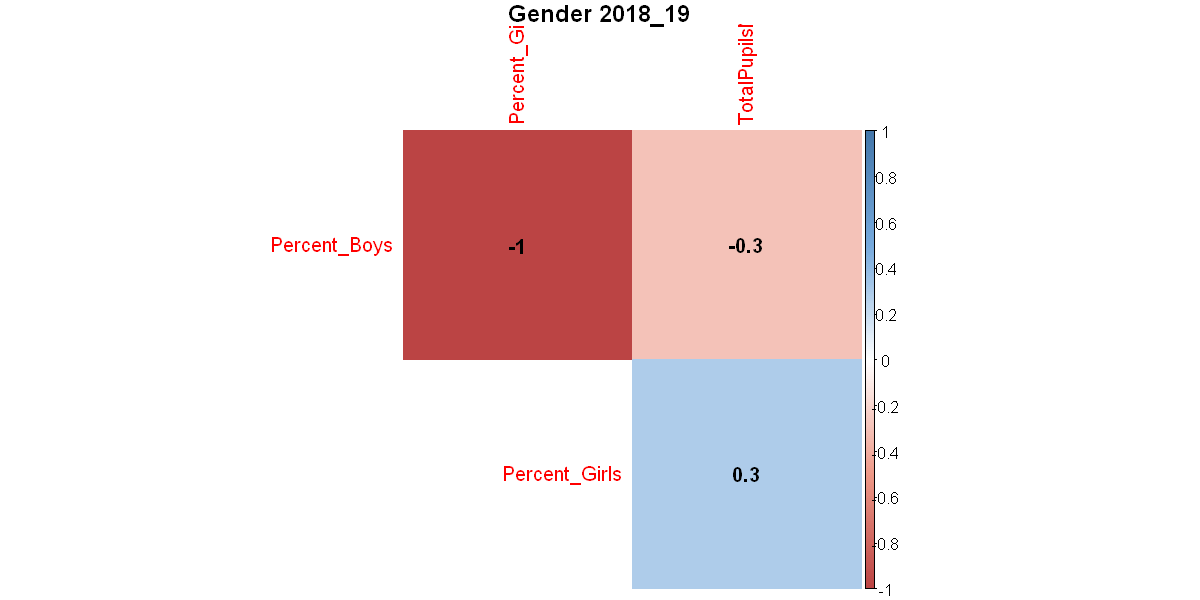

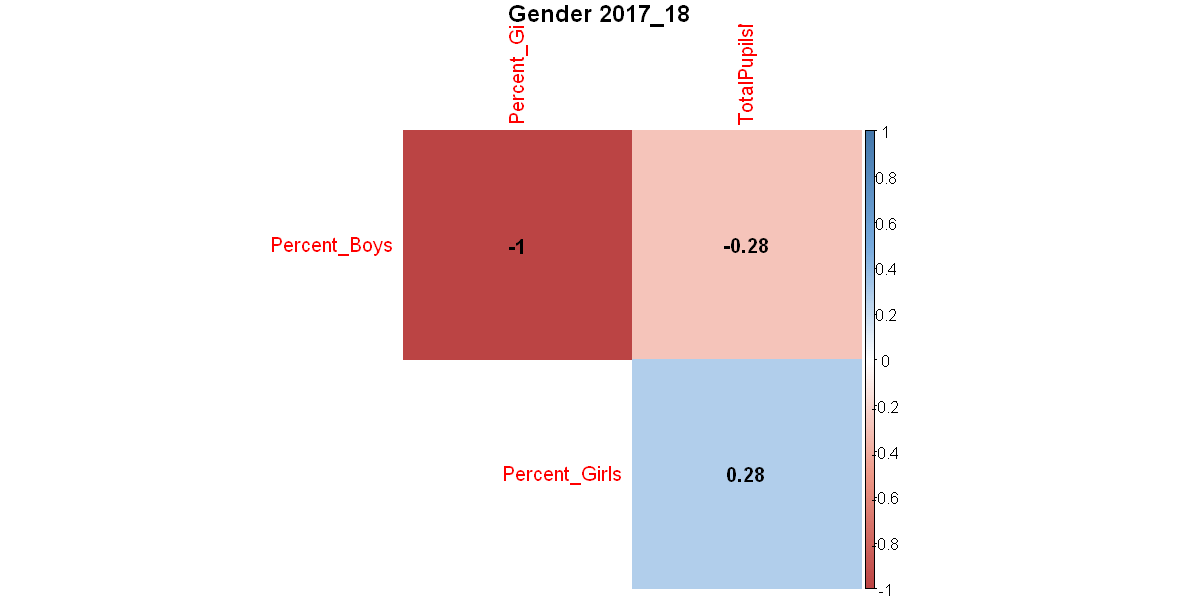

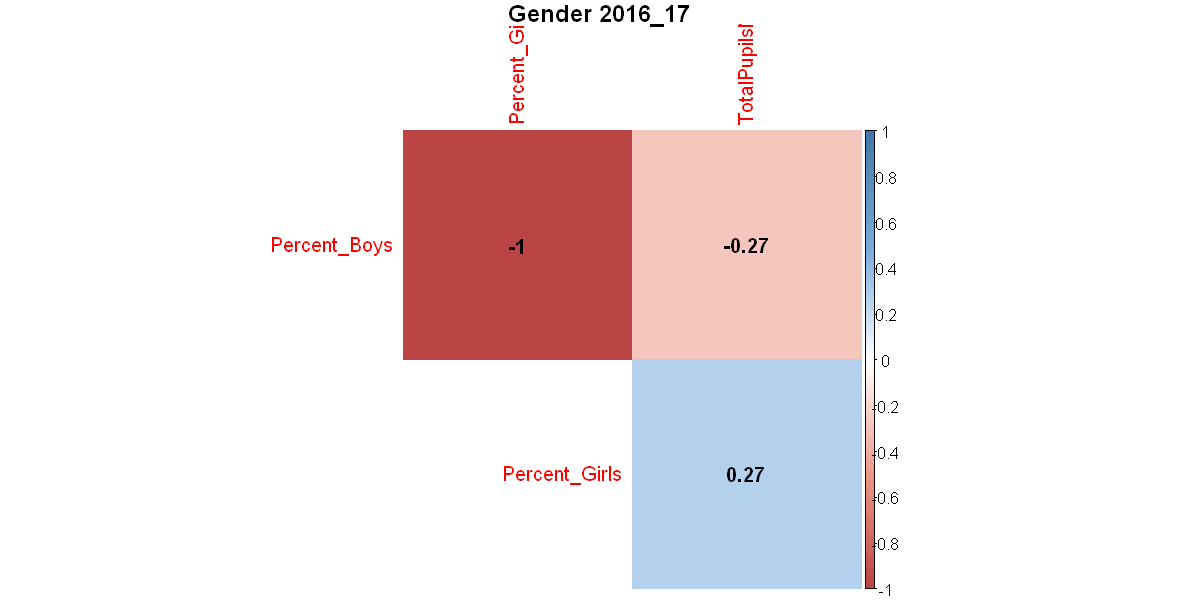

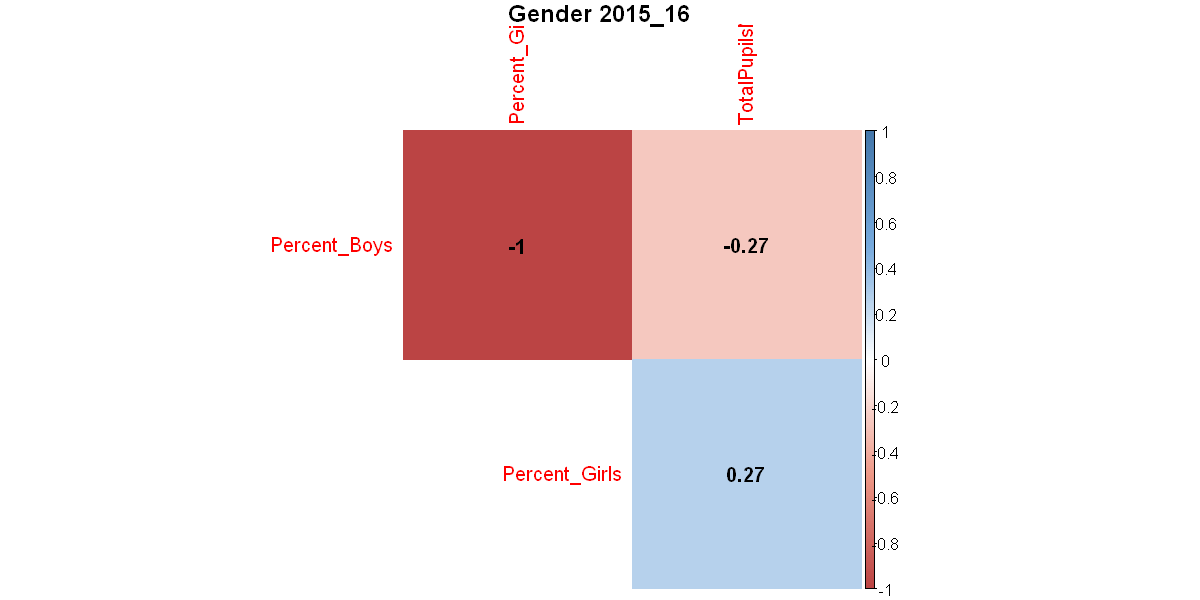

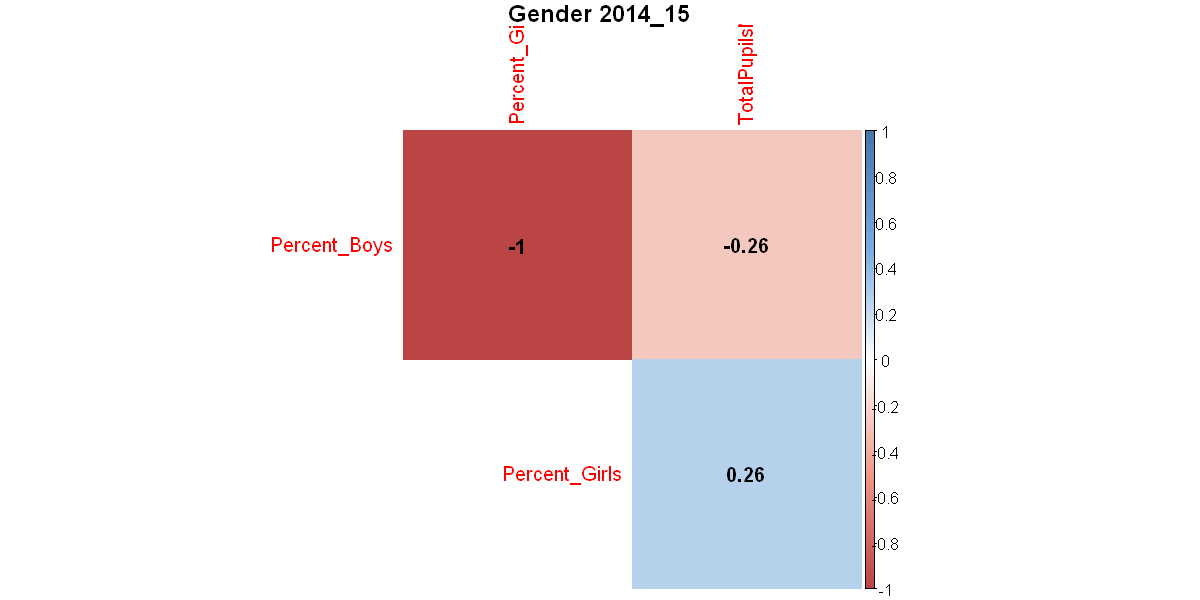

In [185]:
# The columns Percent_Boys and Percent_Girls are added up to 100%, and are perfectly negative correlated.  
colcorr <- c('Percent_Boys', 'Percent_Girls',  'TotalPupilsNo')

CorrMatrix <- cor(merge_2018_19[,colcorr], use='complete.obs')
PlotCorrelation(CorrMatrix, "Gender 2018_19")

CorrMatrix <- cor(merge_2017_18[,colcorr], use='complete.obs')
PlotCorrelation(CorrMatrix, "Gender 2017_18")

CorrMatrix <- cor(merge_2016_17[,colcorr], use='complete.obs')
PlotCorrelation(CorrMatrix, "Gender 2016_17")

CorrMatrix <- cor(merge_2015_16[,colcorr], use='complete.obs')
PlotCorrelation(CorrMatrix, "Gender 2015_16")

CorrMatrix <- cor(merge_2014_15[,colcorr], use='complete.obs')
PlotCorrelation(CorrMatrix, "Gender 2014_15")


In [186]:
# Thus we arbitrarily select to retain the Percent_Girls column only.
drops <- c('Percent_Boys' )
merge_2018_19 <- merge_2018_19[,!(names(merge_2018_19) %in% drops)] 
merge_2017_18 <- merge_2017_18[,!(names(merge_2017_18) %in% drops)] 
merge_2016_17 <- merge_2016_17[,!(names(merge_2016_17) %in% drops)] 
merge_2015_16 <- merge_2015_16[,!(names(merge_2015_16) %in% drops)] 
merge_2014_15 <- merge_2014_15[,!(names(merge_2014_15) %in% drops)] 

### 1.7.5 Update column dictionary

In [187]:
# update column dictionary
colnames <- c( 'TeacherAndSupportPostFillUpRate',
'TeacherAndSupportStaffCount',
'PupilStaffRatio',
'SchoolFin_TeachAndSupportStaffCostPerPupil',
'SchoolFin_NonICTAndEducationServiceCostPerPupil',
'SchoolFin_MiscCostPerPupil')


coldesp <- c('The fill up rate of the teacher and support staff headcount',
            'Total teacer and support staff count',
            'Pupils to teaching staff ratio (excl. teachers)',
            'The staff cost of teacher and support staff per pupil',
            'The sum of cost for non-ICT and bought-in professional service per pupil',
            'The miscellaneous (energy, water, utilities, building maintenance) cost per pupil')

coltypes <- c(TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL, TYPE_ORDINAL) 
              
merge_col_dict <- rbind(merge_col_dict, data.frame(name=colnames, description=coldesp, datatype = coltypes)) 

# only retain which existis in the merged data set.
merge_col_dict <- merge_col_dict[merge_col_dict$name %in% names(merge_2018_19), ]

merge_col_dict

name                                           
1  URN                                            
2  Att8Score                                      
3  Prg8Score                                      
4  Att8Score_Disadvantaged                        
5  Prg8Score_Disadvantaged                        
6  Att8Score_NonDisadvantaged                     
7  Prg8Score_NonDisadvantaged                     
8  TotalPupilsNo                                  
9  Percent_Girls                                  
11 Percent_SEN_EHCPlan                            
12 Percent_SEN_Support                            
13 Percent_NonEngFirstLang                        
14 Percent_EngFirstLang                           
15 Percent_UnclassifiedLang                       
16 Percent_FreeSchoolMealsEver                    
17 Percent_OverallAbsence                         
18 Percent_PersistentAbsence                      
25 PupilTeacherRatio                              
26 MeanSalaryTeachers                             
27 SCHOOLTYPE                                     
28 SchoolReligion                                 
29 AdmissionPolicy                                
31 Ofsted_Rating                                  
34 SchoolFin_TotalIncomewithFunding               
44 SchoolFin_ICTLearningResourcesCostPerPupil     
48 TeacherAndSupportPostFillUpRate                
49 TeacherAndSupportStaffCount                    
50 PupilStaffRatio                                
51 SchoolFin_TeachAndSupportStaffCostPerPupil     
52 SchoolFin_NonICTAndEducationServiceCostPerPupil
53 SchoolFin_MiscCostPerPupil                     
   description                                                                                                                 
1  School unique reference no.                                                                                                 
2  Average Attainment 8 score per pupil                                                                                        
3  Progress 8 measure after adjustment for extreme scores                                                                      
4  Average Attainment 8 score per disadvantaged pupil                                                                          
5  Adjusted Progress 8 measure - disadvantaged pupils                                                                          
6  Average Attainment 8 score per non-disadvantaged pupil                                                                      
7  Adjusted Progress 8 measure - non-disadvantaged pupils                                                                      
8  Total number of pupils on roll                                                                                              
9  Percentage of girls on roll                                                                                                 
11 Percentage of SEN pupils with an EHC plan                                                                                   
12 Percentage of eligible pupils with SEN support                                                                              
13 % pupils where English not first language                                                                                   
14 % pupils with English first language                                                                                        
15 % pupils where first language is unclassified                                                                               
16 Percentage of pupils eligible for FSM at any time during the past 6 years                                                   
17 Percentage of overall absence                                                                                               
18 Percentage of enrolments who are persistent absentees                                                                       
25 Pupil Teacher Ratio                                             

## 1.8 Data Cleansing

### 1.8.1 Remove rows with NA or missing values in Attainment 8 or Progress 8 Scores

In [188]:
# The output variables will be the following variables: 
#'Att8Score''Prg8Score''Att8Score_Disadvantaged'
#'Prg8Score_Disadvantaged''Att8Score_NonDisadvantaged''Prg8Score_NonDisadvantaged'

# Examine the missing or invalid values
# checkcol <- c('Att8Score','Prg8Score','Att8Score_Disadvantaged','Prg8Score_Disadvantaged', 
#              'Att8Score_NonDisadvantaged', 'Prg8Score_NonDisadvantaged')
checkcol <- c('Att8Score_Disadvantaged','Prg8Score_Disadvantaged')

filter <- GetInvalidValuesFilter(merge_2018_19, checkcol) 
merge_2018_19 <- merge_2018_19[filter,]

filter <- GetInvalidValuesFilter(merge_2017_18, checkcol) 
merge_2017_18 <- merge_2017_18[filter,]

filter <- GetInvalidValuesFilter(merge_2016_17, checkcol) 
merge_2016_17 <- merge_2016_17[filter,]

filter <- GetInvalidValuesFilter(merge_2015_16, checkcol) 
merge_2015_16 <- merge_2015_16[filter,]

filter <- GetInvalidValuesFilter(merge_2014_15, checkcol) 
merge_2014_15 <- merge_2014_15[filter,]

### 1.8.2 Check the missing values in predictor variables 

In [189]:
result <- GetInvalidValuesSummary(merge_2018_19, names(merge_2018_19)) 
t(result)

[,1]         [,2]          
Type                                            is_na(%)     is_infinite(%)
URN                                             0 ( 0 %)     0 ( 0 %)      
Att8Score                                       0 ( 0 %)     0 ( 0 %)      
Prg8Score                                       0 ( 0 %)     0 ( 0 %)      
Att8Score_Disadvantaged                         0 ( 0 %)     0 ( 0 %)      
Prg8Score_Disadvantaged                         0 ( 0 %)     0 ( 0 %)      
Att8Score_NonDisadvantaged                      13 ( 0.4 %)  0 ( 0 %)      
Prg8Score_NonDisadvantaged                      19 ( 0.6 %)  0 ( 0 %)      
TotalPupilsNo                                   49 ( 1.5 %)  0 ( 0 %)      
Percent_Girls                                   49 ( 1.5 %)  0 ( 0 %)      
Percent_SEN_EHCPlan                             49 ( 1.5 %)  0 ( 0 %)      
Percent_SEN_Support                             49 ( 1.5 %)  0 ( 0 %)      
Percent_NonEngFirstLang                         49 ( 1.5 %)  0 ( 0 %)      
Percent_EngFirstLang                            49 ( 1.5 %)  0 ( 0 %)      
Percent_UnclassifiedLang                        49 ( 1.5 %)  0 ( 0 %)      
Percent_FreeSchoolMealsEver                     49 ( 1.5 %)  0 ( 0 %)      
Percent_OverallAbsence                          49 ( 1.5 %)  0 ( 0 %)      
Percent_PersistentAbsence                       49 ( 1.5 %)  0 ( 0 %)      
PupilTeacherRatio                               224 ( 6.8 %) 0 ( 0 %)      
MeanSalaryTeachers                              203 ( 6.2 %) 0 ( 0 %)      
SCHOOLTYPE                                      0 ( 0 %)     0 ( 0 %)      
SchoolReligion                                  0 ( 0 %)     0 ( 0 %)      
AdmissionPolicy                                 0 ( 0 %)     0 ( 0 %)      
Ofsted_Rating                                   0 ( 0 %)     0 ( 0 %)      
SchoolFin_TotalIncomewithFunding                2393 ( 73 %) 0 ( 0 %)      
SchoolFin_ICTLearningResourcesCostPerPupil      2393 ( 73 %) 0 ( 0 %)      
TeacherAndSupportPostFillUpRate                 199 ( 6.1 %) 0 ( 0 %)      
TeacherAndSupportStaffCount                     0 ( 0 %)     0 ( 0 %)      
PupilStaffRatio                                 49 ( 1.5 %)  177 ( 5.4 %)  
SchoolFin_TeachAndSupportStaffCostPerPupil      0 ( 0 %)     0 ( 0 %)      
SchoolFin_NonICTAndEducationServiceCostPerPupil 0 ( 0 %)     0 ( 0 %)      
SchoolFin_MiscCostPerPupil                      0 ( 0 %)     0 ( 0 %)

In [190]:
result <- GetInvalidValuesSummary(merge_2017_18, names(merge_2017_18)) 
t(result)

[,1]           [,2]          
Type                                            is_na(%)       is_infinite(%)
URN                                             0 ( 0 %)       0 ( 0 %)      
Att8Score                                       0 ( 0 %)       0 ( 0 %)      
Prg8Score                                       0 ( 0 %)       0 ( 0 %)      
Att8Score_Disadvantaged                         0 ( 0 %)       0 ( 0 %)      
Prg8Score_Disadvantaged                         0 ( 0 %)       0 ( 0 %)      
Att8Score_NonDisadvantaged                      13 ( 0.4 %)    0 ( 0 %)      
Prg8Score_NonDisadvantaged                      28 ( 0.9 %)    0 ( 0 %)      
TotalPupilsNo                                   46 ( 1.4 %)    0 ( 0 %)      
Percent_Girls                                   46 ( 1.4 %)    0 ( 0 %)      
Percent_SEN_EHCPlan                             46 ( 1.4 %)    0 ( 0 %)      
Percent_SEN_Support                             46 ( 1.4 %)    0 ( 0 %)      
Percent_NonEngFirstLang                         46 ( 1.4 %)    0 ( 0 %)      
Percent_EngFirstLang                            46 ( 1.4 %)    0 ( 0 %)      
Percent_UnclassifiedLang                        46 ( 1.4 %)    0 ( 0 %)      
Percent_FreeSchoolMealsEver                     53 ( 1.6 %)    0 ( 0 %)      
Percent_OverallAbsence                          47 ( 1.4 %)    0 ( 0 %)      
Percent_PersistentAbsence                       47 ( 1.4 %)    0 ( 0 %)      
PupilTeacherRatio                               235 ( 7.2 %)   0 ( 0 %)      
MeanSalaryTeachers                              238 ( 7.3 %)   0 ( 0 %)      
SCHOOLTYPE                                      148 ( 4.6 %)   0 ( 0 %)      
SchoolReligion                                  148 ( 4.6 %)   0 ( 0 %)      
AdmissionPolicy                                 148 ( 4.6 %)   0 ( 0 %)      
Ofsted_Rating                                   148 ( 4.6 %)   0 ( 0 %)      
SchoolFin_TotalIncomewithFunding                2262 ( 69.7 %) 0 ( 0 %)      
SchoolFin_ICTLearningResourcesCostPerPupil      2262 ( 69.7 %) 0 ( 0 %)      
TeacherAndSupportPostFillUpRate                 210 ( 6.5 %)   0 ( 0 %)      
TeacherAndSupportStaffCount                     0 ( 0 %)       0 ( 0 %)      
PupilStaffRatio                                 46 ( 1.4 %)    192 ( 5.9 %)  
SchoolFin_TeachAndSupportStaffCostPerPupil      0 ( 0 %)       0 ( 0 %)      
SchoolFin_NonICTAndEducationServiceCostPerPupil 0 ( 0 %)       0 ( 0 %)      
SchoolFin_MiscCostPerPupil                      0 ( 0 %)       0 ( 0 %)

In [191]:
result <- GetInvalidValuesSummary(merge_2016_17, names(merge_2016_17)) 
t(result)

[,1]           [,2]          
Type                                            is_na(%)       is_infinite(%)
URN                                             0 ( 0 %)       0 ( 0 %)      
Att8Score                                       0 ( 0 %)       0 ( 0 %)      
Prg8Score                                       0 ( 0 %)       0 ( 0 %)      
Att8Score_Disadvantaged                         0 ( 0 %)       0 ( 0 %)      
Prg8Score_Disadvantaged                         0 ( 0 %)       0 ( 0 %)      
Att8Score_NonDisadvantaged                      18 ( 0.6 %)    0 ( 0 %)      
Prg8Score_NonDisadvantaged                      36 ( 1.1 %)    0 ( 0 %)      
TotalPupilsNo                                   58 ( 1.8 %)    0 ( 0 %)      
Percent_Girls                                   58 ( 1.8 %)    0 ( 0 %)      
Percent_SEN_EHCPlan                             58 ( 1.8 %)    0 ( 0 %)      
Percent_SEN_Support                             58 ( 1.8 %)    0 ( 0 %)      
Percent_NonEngFirstLang                         58 ( 1.8 %)    0 ( 0 %)      
Percent_EngFirstLang                            58 ( 1.8 %)    0 ( 0 %)      
Percent_UnclassifiedLang                        58 ( 1.8 %)    0 ( 0 %)      
Percent_FreeSchoolMealsEver                     68 ( 2.1 %)    0 ( 0 %)      
Percent_OverallAbsence                          22 ( 0.7 %)    0 ( 0 %)      
Percent_PersistentAbsence                       22 ( 0.7 %)    0 ( 0 %)      
PupilTeacherRatio                               261 ( 8.1 %)   1 ( 0 %)      
MeanSalaryTeachers                              299 ( 9.3 %)   0 ( 0 %)      
SCHOOLTYPE                                      325 ( 10.1 %)  0 ( 0 %)      
SchoolReligion                                  325 ( 10.1 %)  0 ( 0 %)      
AdmissionPolicy                                 325 ( 10.1 %)  0 ( 0 %)      
Ofsted_Rating                                   325 ( 10.1 %)  0 ( 0 %)      
SchoolFin_TotalIncomewithFunding                2119 ( 65.8 %) 0 ( 0 %)      
SchoolFin_ICTLearningResourcesCostPerPupil      2119 ( 65.8 %) 0 ( 0 %)      
TeacherAndSupportPostFillUpRate                 242 ( 7.5 %)   0 ( 0 %)      
TeacherAndSupportStaffCount                     0 ( 0 %)       0 ( 0 %)      
PupilStaffRatio                                 58 ( 1.8 %)    208 ( 6.5 %)  
SchoolFin_TeachAndSupportStaffCostPerPupil      0 ( 0 %)       0 ( 0 %)      
SchoolFin_NonICTAndEducationServiceCostPerPupil 0 ( 0 %)       0 ( 0 %)      
SchoolFin_MiscCostPerPupil                      0 ( 0 %)       0 ( 0 %)

### 1.8.3 Remove those rows without School and Finance Expenditure

In [192]:
# From the missing values summary, there are a signification portion (>65% or around 2200) schools with the 
# SchoolFin_TotalIncomewithFunding,SchoolFin_TotalExpenditure and SchoolFin_ICTLearningResourcesCostPerPupil having NA values.
# This is due to the fact the the annual dataset on school finance and expenditures (cfr csv files) only covers state-funded 
# maintained schools but not academies or other independent schools.  

# As we expect the school finance and expenditure will have impact on GCSE performance, we will exclude those without such data

checkcol <- c('SchoolFin_TotalIncomewithFunding','SchoolFin_ICTLearningResourcesCostPerPupil')

filter <- GetInvalidValuesFilter(merge_2018_19, checkcol) 
merge_2018_19 <- merge_2018_19[filter,]

filter <- GetInvalidValuesFilter(merge_2017_18, checkcol) 
merge_2017_18 <- merge_2017_18[filter,]

filter <- GetInvalidValuesFilter(merge_2016_17, checkcol) 
merge_2016_17 <- merge_2016_17[filter,]

filter <- GetInvalidValuesFilter(merge_2015_16, checkcol) 
merge_2015_16 <- merge_2015_16[filter,]

filter <- GetInvalidValuesFilter(merge_2014_15, checkcol) 
merge_2014_15 <- merge_2014_15[filter,]


### 1.8.4 Separate Input and Output Variable Sets

In [193]:
outputcol <- c('Att8Score_Disadvantaged','Prg8Score_Disadvantaged')

inputcol <- c('TotalPupilsNo',
'Percent_Girls',
'Percent_SEN_EHCPlan',
'Percent_SEN_Support',
'Percent_NonEngFirstLang',
'Percent_EngFirstLang',
'Percent_UnclassifiedLang',
'Percent_FreeSchoolMealsEver',
'Percent_OverallAbsence',
'Percent_PersistentAbsence',
'PupilTeacherRatio',
'MeanSalaryTeachers',
'SCHOOLTYPE',
'SchoolReligion',
'AdmissionPolicy',
'Ofsted_Rating',
'SchoolFin_TotalIncomewithFunding',
'SchoolFin_ICTLearningResourcesCostPerPupil',
'TeacherAndSupportPostFillUpRate',
'TeacherAndSupportStaffCount',
'PupilStaffRatio',
'SchoolFin_TeachAndSupportStaffCostPerPupil',
'SchoolFin_NonICTAndEducationServiceCostPerPupil',
'SchoolFin_MiscCostPerPupil')

XY_2018_19 <- merge_2018_19[, append(outputcol, inputcol)]
XY_2017_18 <- merge_2017_18[, append(outputcol, inputcol)]
XY_2016_17 <- merge_2016_17[, append(outputcol, inputcol)]
XY_2015_16 <- merge_2015_16[, append(outputcol, inputcol)]
XY_2014_15 <- merge_2014_15[, append(outputcol, inputcol)]

XY_col_dict <- merge_col_dict[merge_col_dict$name %in% names(XY_2018_19), ]

XY_col_dict

name                                           
4  Att8Score_Disadvantaged                        
5  Prg8Score_Disadvantaged                        
8  TotalPupilsNo                                  
9  Percent_Girls                                  
11 Percent_SEN_EHCPlan                            
12 Percent_SEN_Support                            
13 Percent_NonEngFirstLang                        
14 Percent_EngFirstLang                           
15 Percent_UnclassifiedLang                       
16 Percent_FreeSchoolMealsEver                    
17 Percent_OverallAbsence                         
18 Percent_PersistentAbsence                      
25 PupilTeacherRatio                              
26 MeanSalaryTeachers                             
27 SCHOOLTYPE                                     
28 SchoolReligion                                 
29 AdmissionPolicy                                
31 Ofsted_Rating                                  
34 SchoolFin_TotalIncomewithFunding               
44 SchoolFin_ICTLearningResourcesCostPerPupil     
48 TeacherAndSupportPostFillUpRate                
49 TeacherAndSupportStaffCount                    
50 PupilStaffRatio                                
51 SchoolFin_TeachAndSupportStaffCostPerPupil     
52 SchoolFin_NonICTAndEducationServiceCostPerPupil
53 SchoolFin_MiscCostPerPupil                     
   description                                                                                                                 
4  Average Attainment 8 score per disadvantaged pupil                                                                          
5  Adjusted Progress 8 measure - disadvantaged pupils                                                                          
8  Total number of pupils on roll                                                                                              
9  Percentage of girls on roll                                                                                                 
11 Percentage of SEN pupils with an EHC plan                                                                                   
12 Percentage of eligible pupils with SEN support                                                                              
13 % pupils where English not first language                                                                                   
14 % pupils with English first language                                                                                        
15 % pupils where first language is unclassified                                                                               
16 Percentage of pupils eligible for FSM at any time during the past 6 years                                                   
17 Percentage of overall absence                                                                                               
18 Percentage of enrolments who are persistent absentees                                                                       
25 Pupil Teacher Ratio                                                                                                         
26 Mean Gross FTE Salary of All Teachers                                                                                       
27 School type                                                                                                                 
28 School religious character                                                                                                  
29 School admission policy                                                                                                     
31 OFSTED rating                                                                                                               
34 Total income per pupil. Sum of grant funding and self generated income                                                      
44 ICT learning resources per pupil. Includes education software, 

### 1.8.5 Checking of Outliers 

[1] "REPLACED WITH MEAN: Outlier field= Att8Score_Disadvantaged #Records= 12"


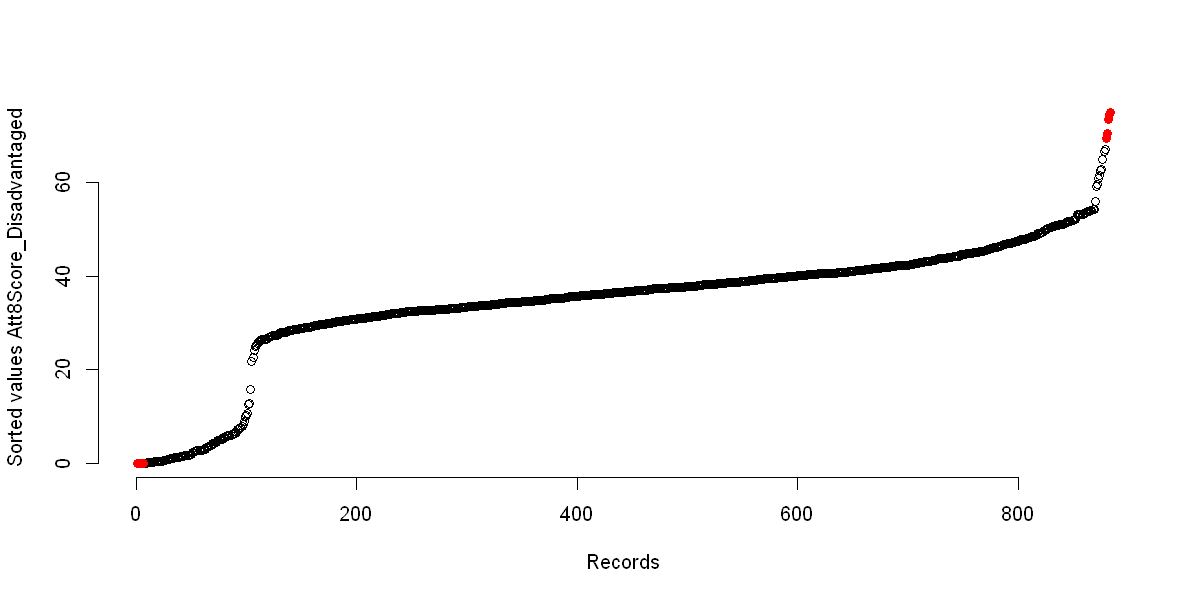

[1] "REPLACED WITH MEAN: Outlier field= Prg8Score_Disadvantaged #Records= 15"


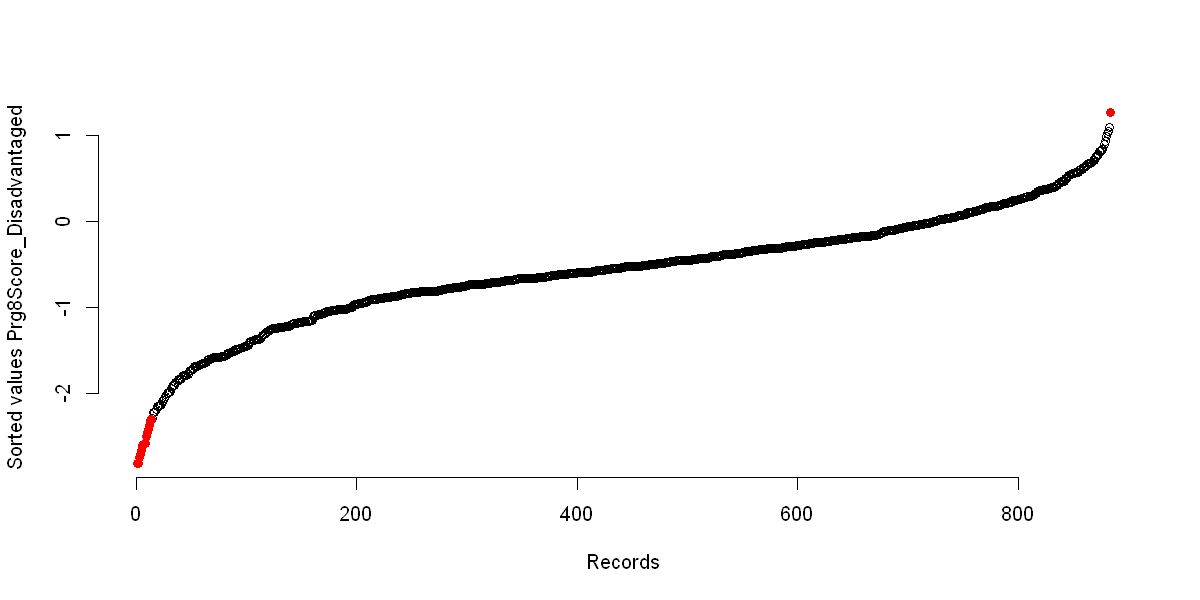

[1] "REPLACED WITH MEAN: Outlier field= TotalPupilsNo #Records= 5"


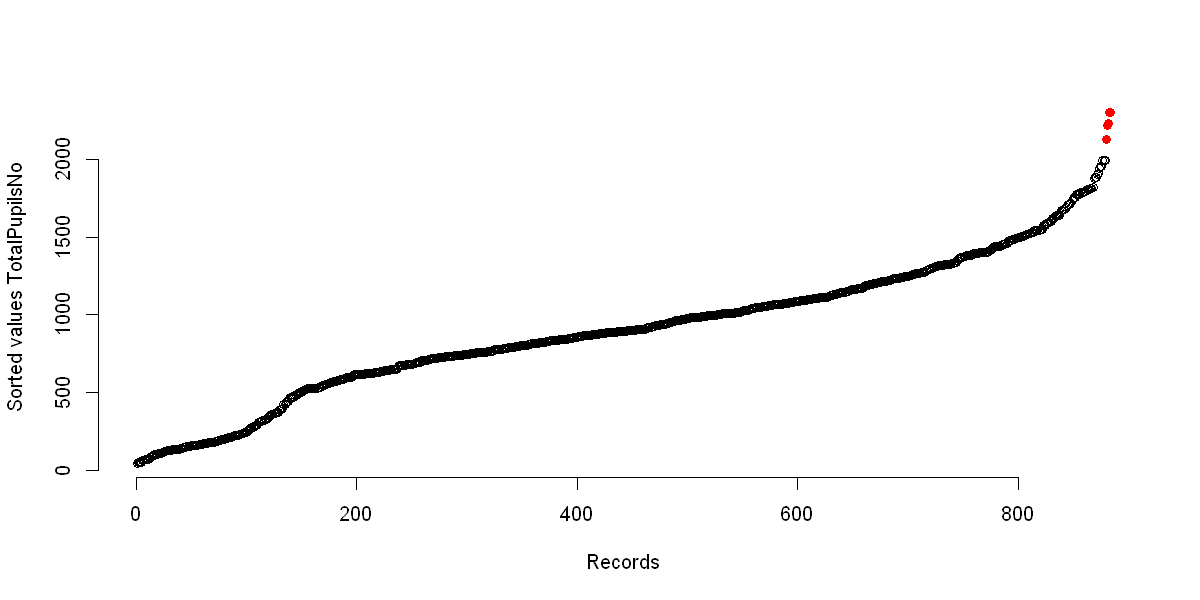

[1] "REPLACED WITH MEAN: Outlier field= Percent_Girls #Records= 69"


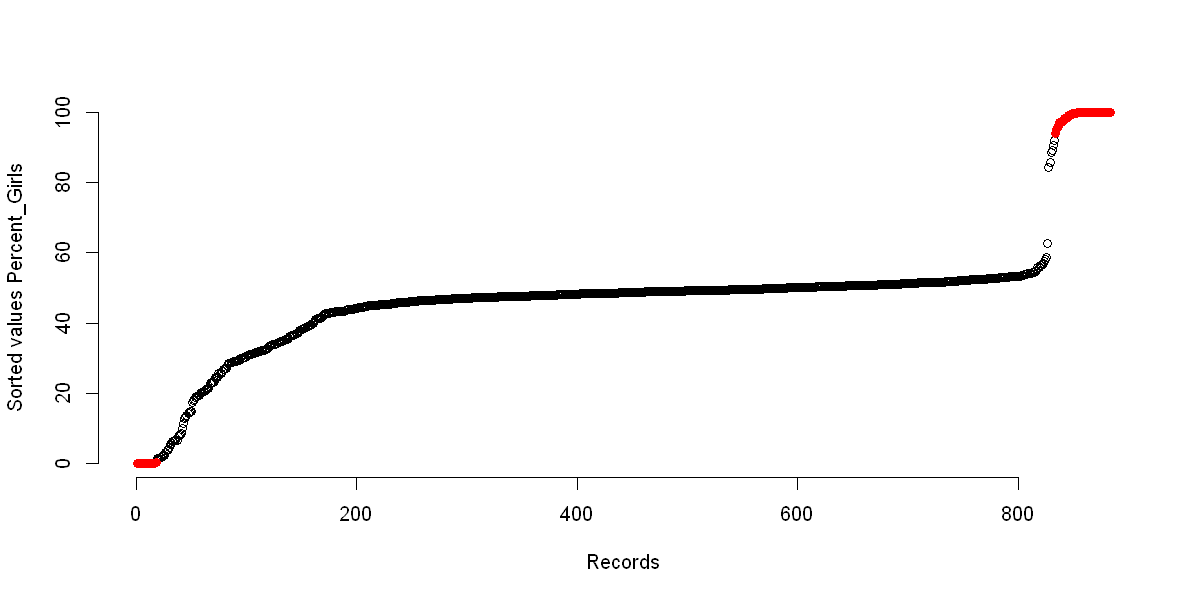

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_EHCPlan #Records= 98"


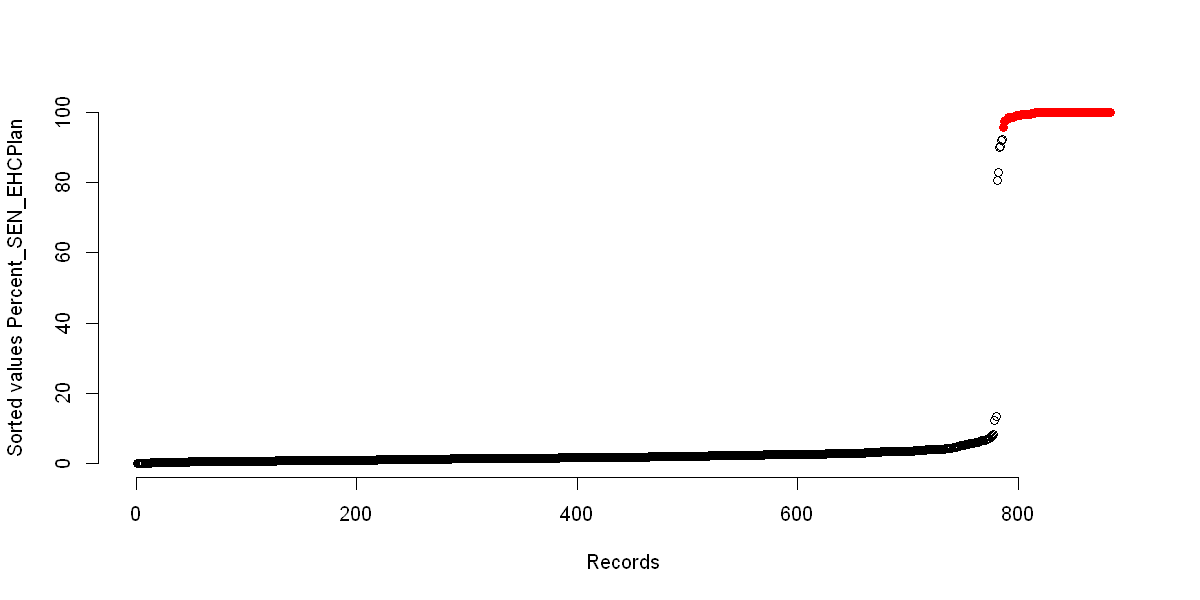

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_Support #Records= 11"


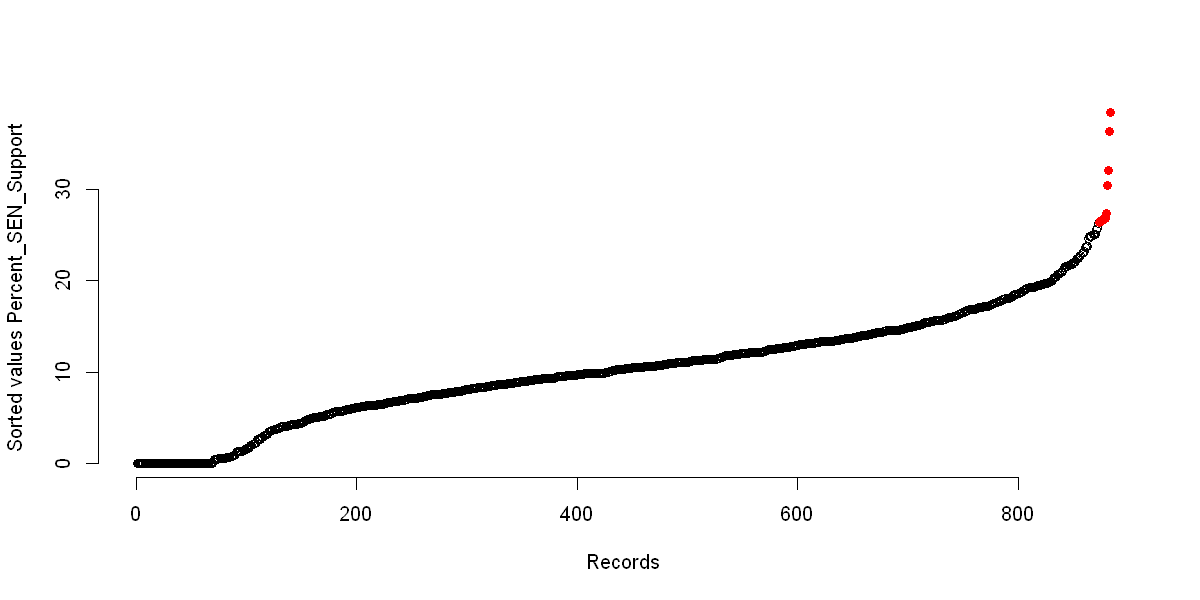

[1] "REPLACED WITH MEAN: Outlier field= Percent_NonEngFirstLang #Records= 31"


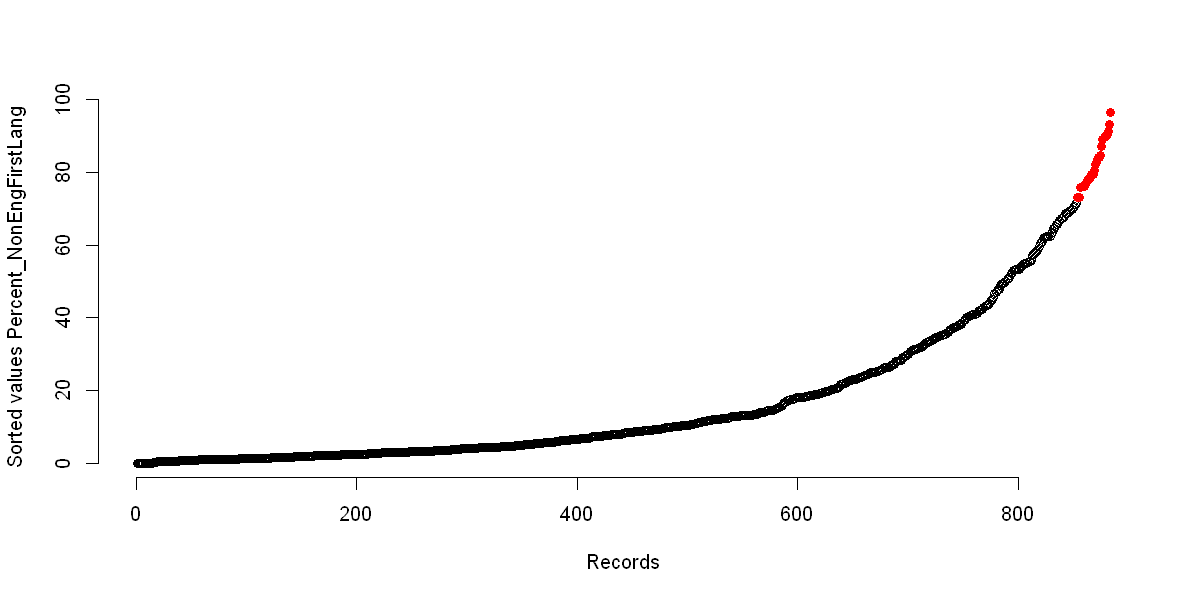

[1] "REPLACED WITH MEAN: Outlier field= Percent_EngFirstLang #Records= 31"


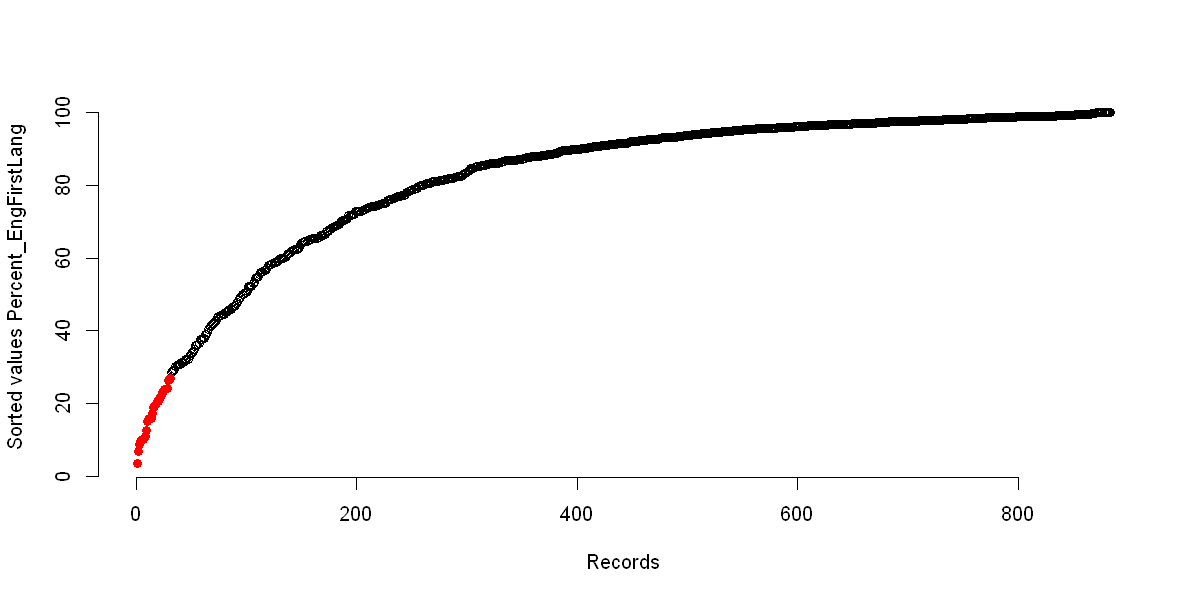

[1] "REPLACED WITH MEAN: Outlier field= Percent_UnclassifiedLang #Records= 15"


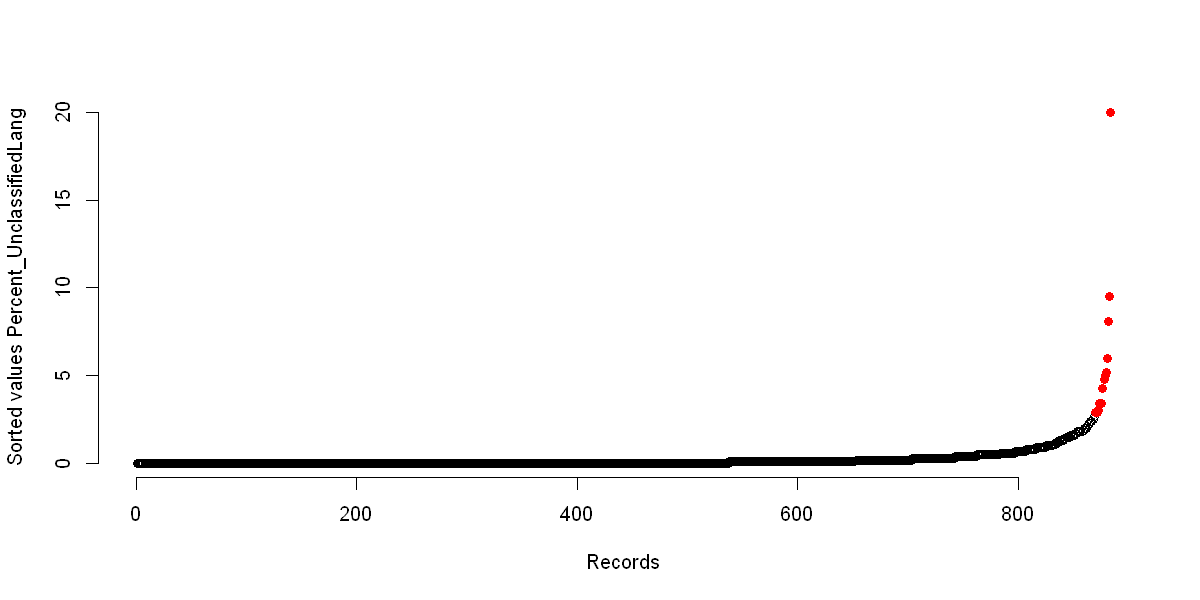

[1] "REPLACED WITH MEAN: Outlier field= Percent_FreeSchoolMealsEver #Records= 14"


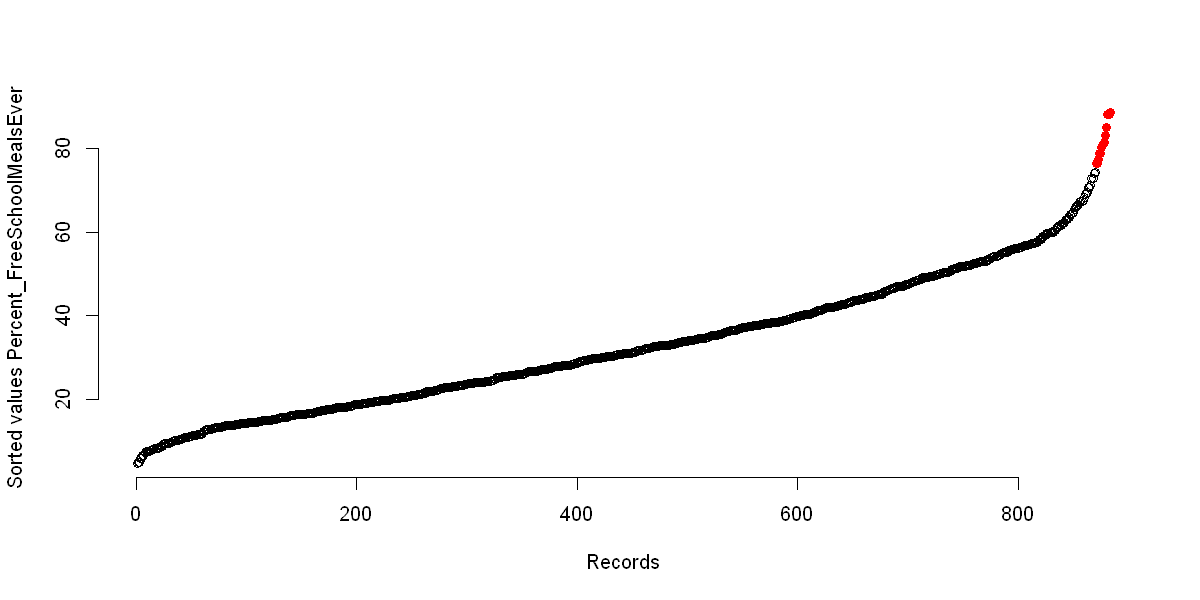

[1] "REPLACED WITH MEAN: Outlier field= Percent_OverallAbsence #Records= 16"


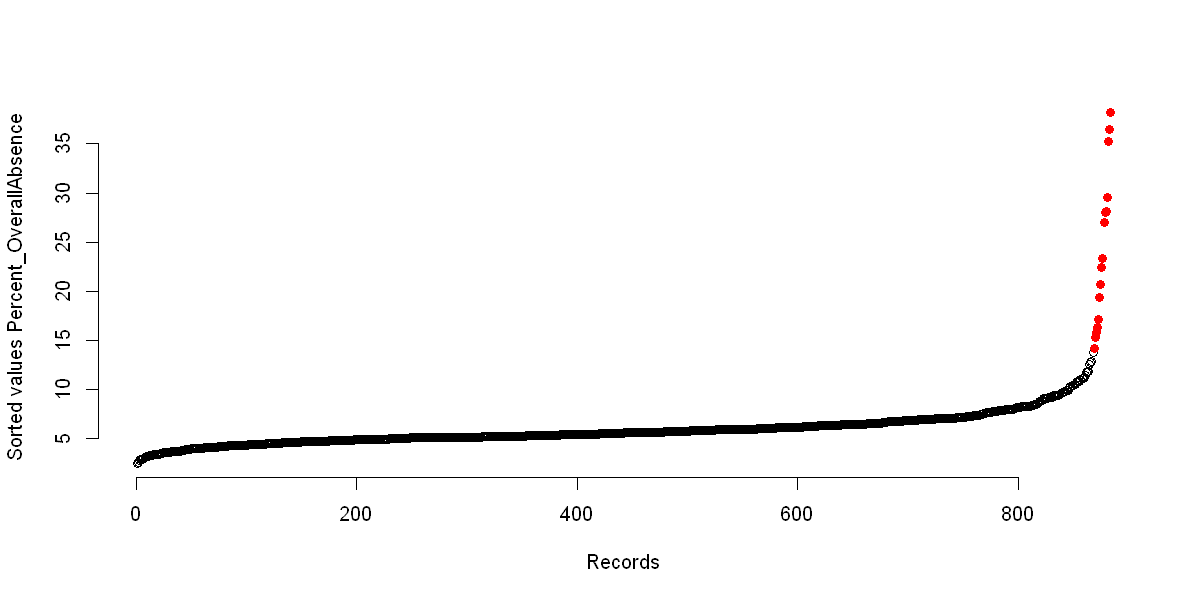

[1] "REPLACED WITH MEAN: Outlier field= Percent_PersistentAbsence #Records= 17"


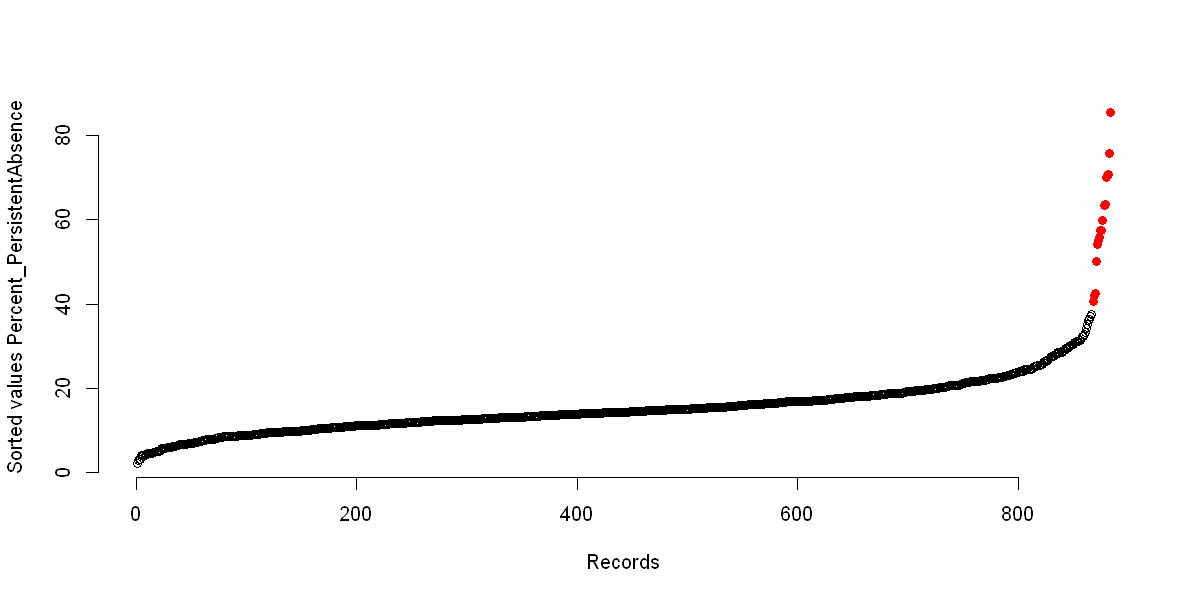

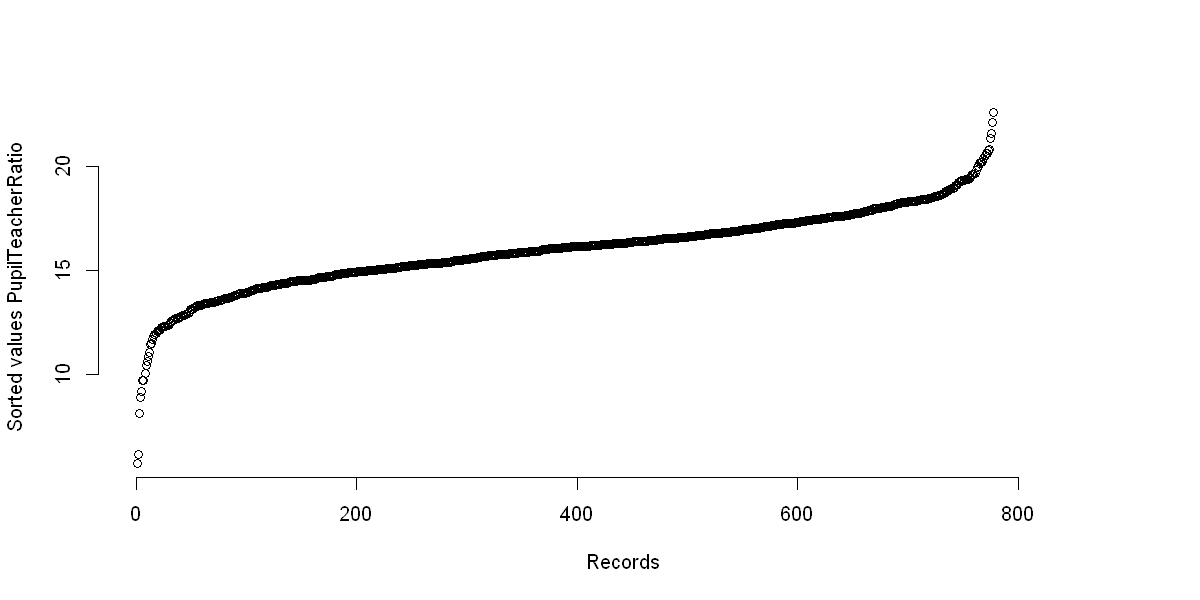

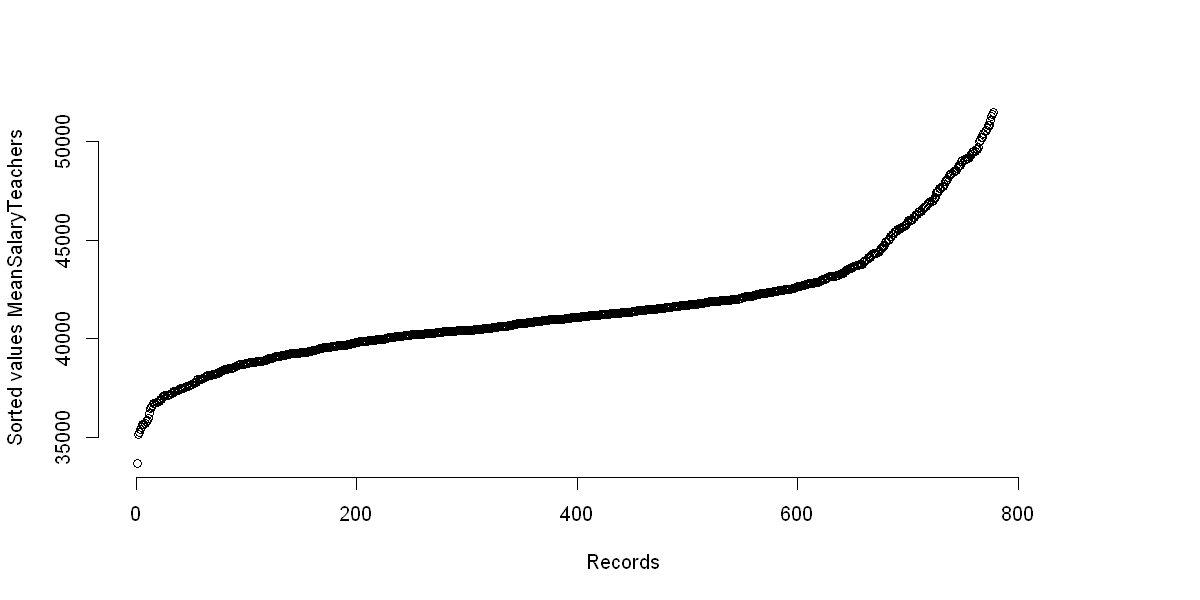

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TotalIncomewithFunding #Records= 32"


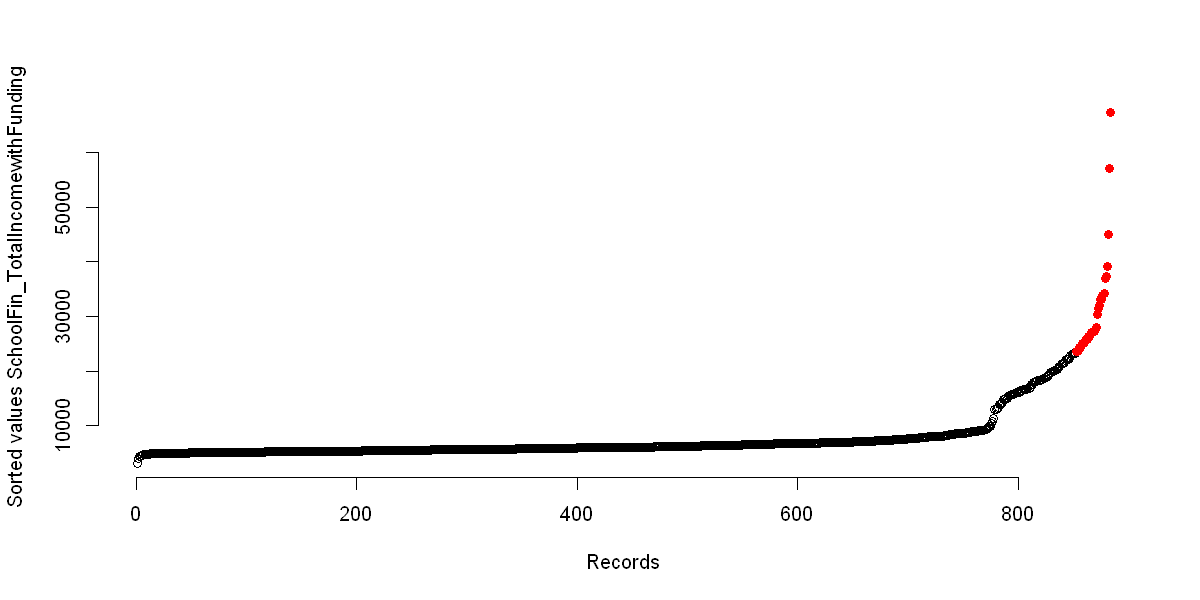

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_ICTLearningResourcesCostPerPupil #Records= 27"


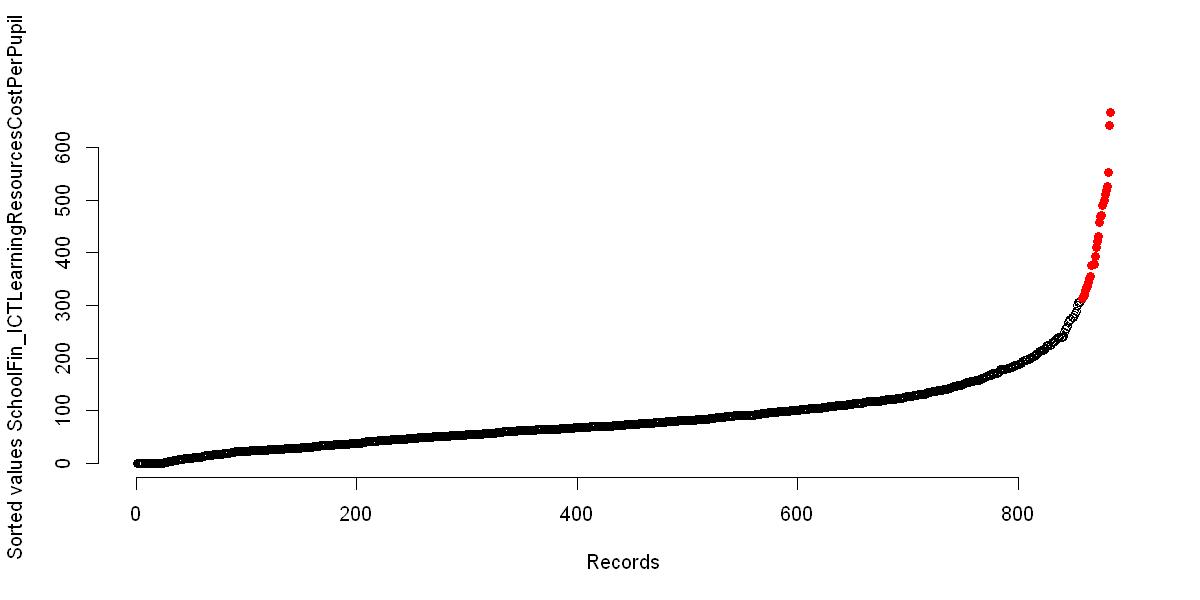

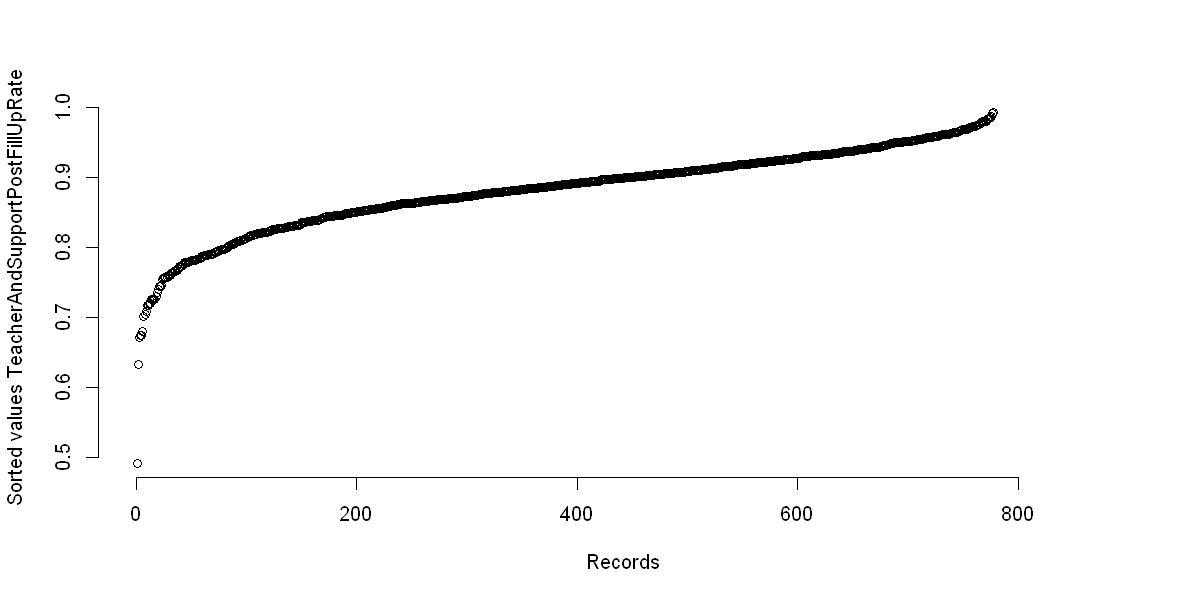

[1] "REPLACED WITH MEAN: Outlier field= TeacherAndSupportStaffCount #Records= 5"


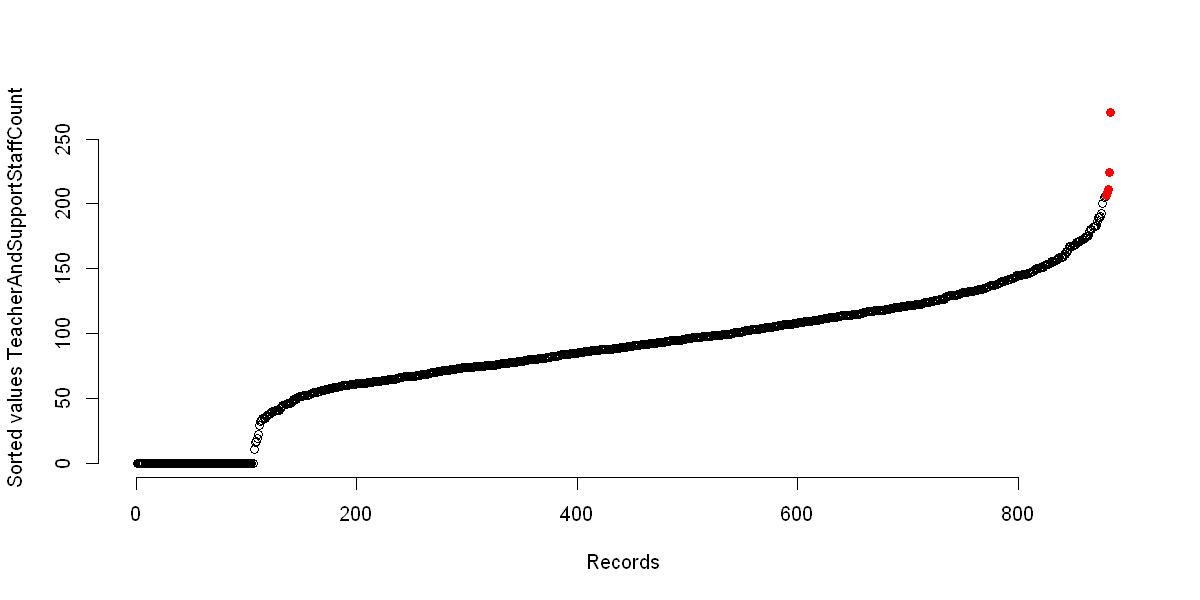

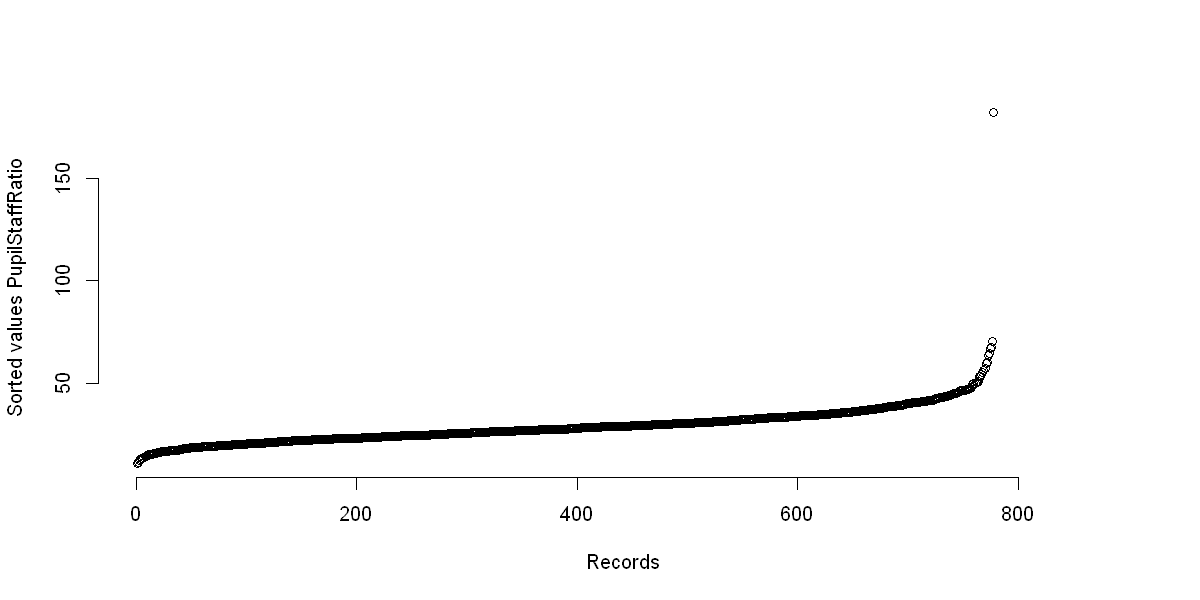

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TeachAndSupportStaffCostPerPupil #Records= 37"


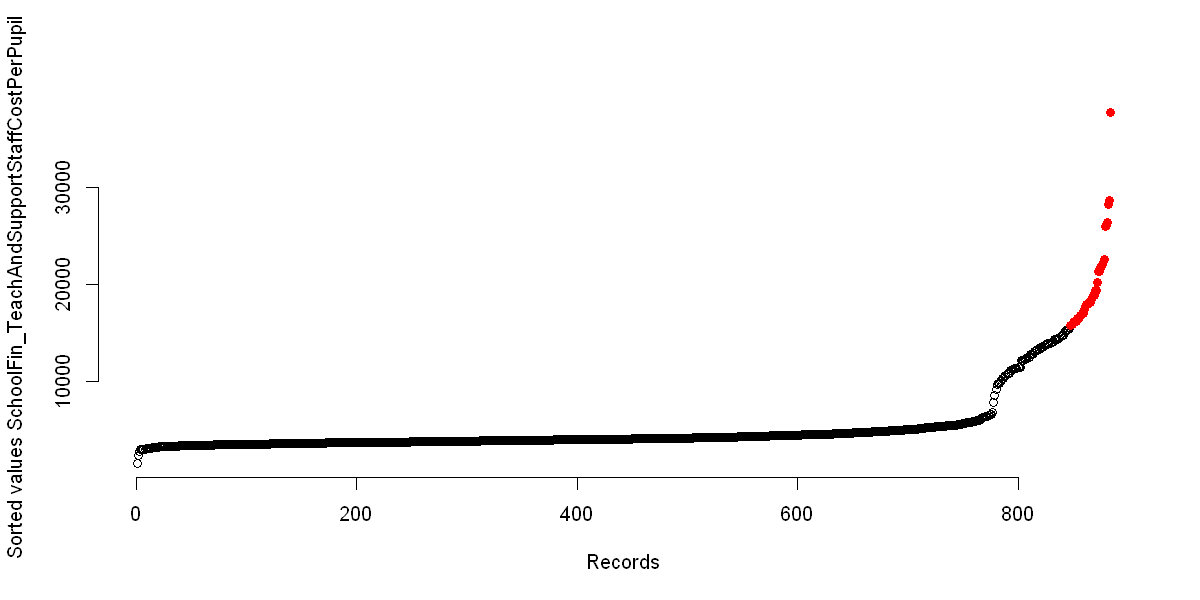

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_NonICTAndEducationServiceCostPerPupil #Records= 17"


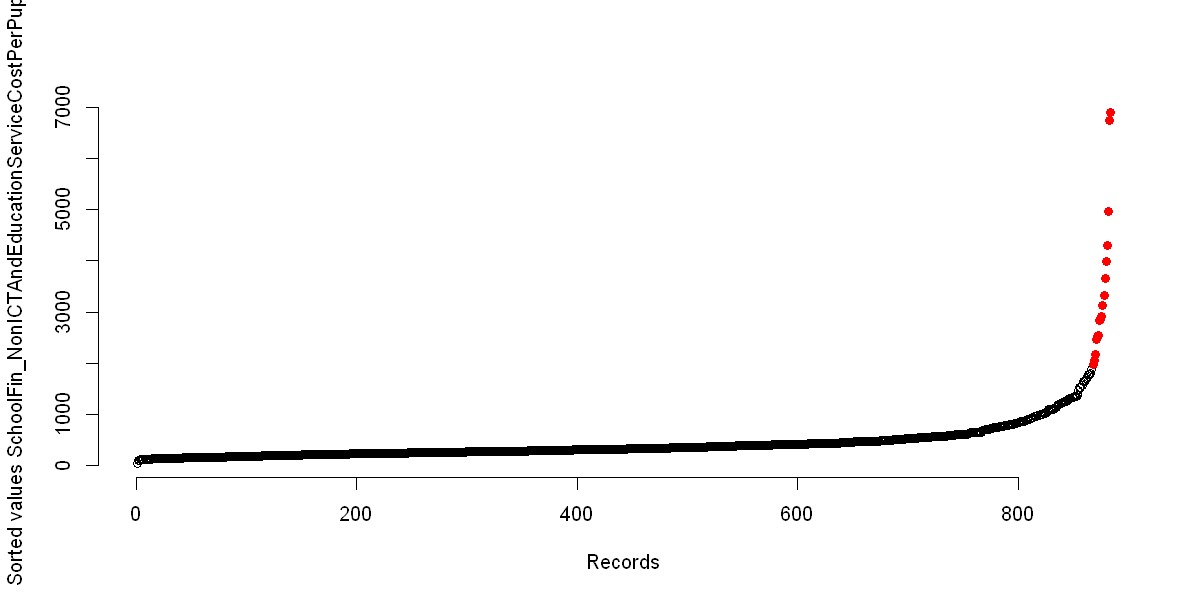

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_MiscCostPerPupil #Records= 10"


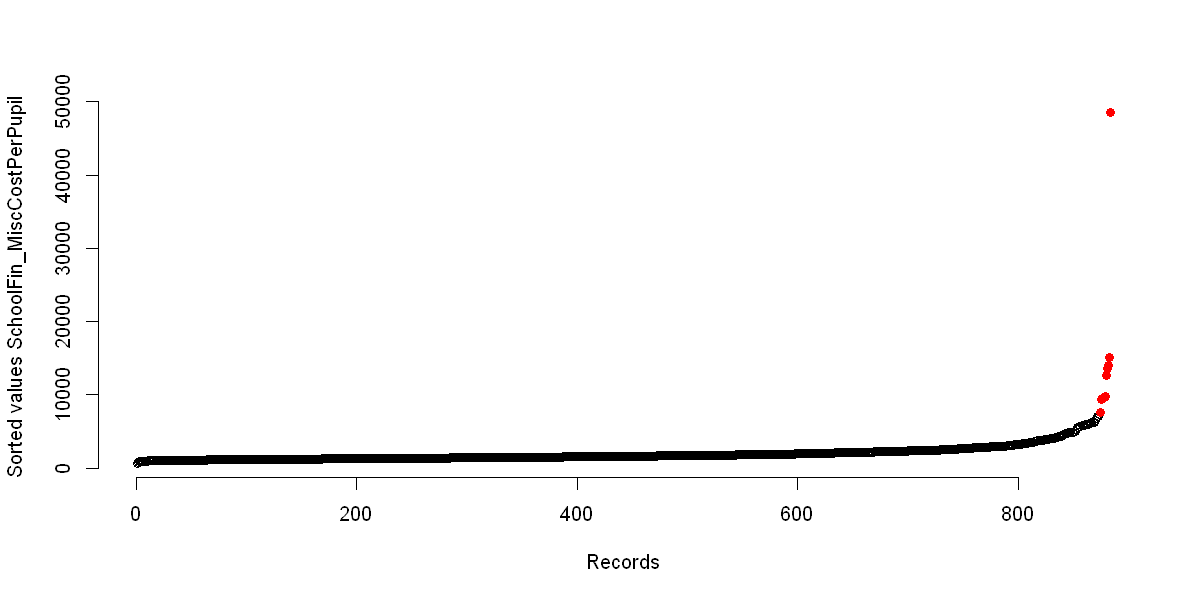

In [194]:
# We apply the outlier analysis function to detect the outliers of the output variables with confidence = 0.999.
# Outliers are replaced with the mean

XY_2018_19 <- NPREPROCESSING_outlier(XY_2018_19,
                             XY_col_dict$datatype, 
                             confidence=0.99, 
                             operation="mean")


In [195]:
# From the plot, it is found that there is a number of schools with TeacherAndSupportStaffCount = 0, which is not a natural figures
# Thus, these schools are also imputed with a mean value

meanval <- mean(XY_2018_19[XY_2018_19$TeacherAndSupportStaffCount>0, c('TeacherAndSupportStaffCount')])
XY_2018_19[XY_2018_19$TeacherAndSupportStaffCount==0, c('TeacherAndSupportStaffCount')] <- meanval

[1] "REPLACED WITH MEAN: Outlier field= Att8Score_Disadvantaged #Records= 37"


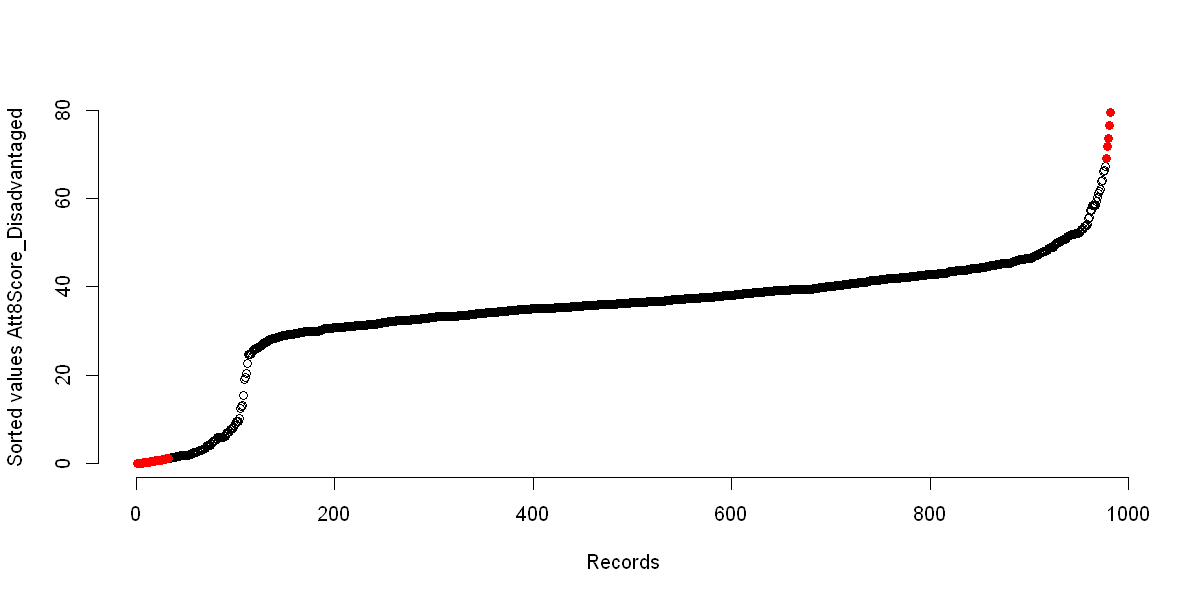

[1] "REPLACED WITH MEAN: Outlier field= Prg8Score_Disadvantaged #Records= 22"


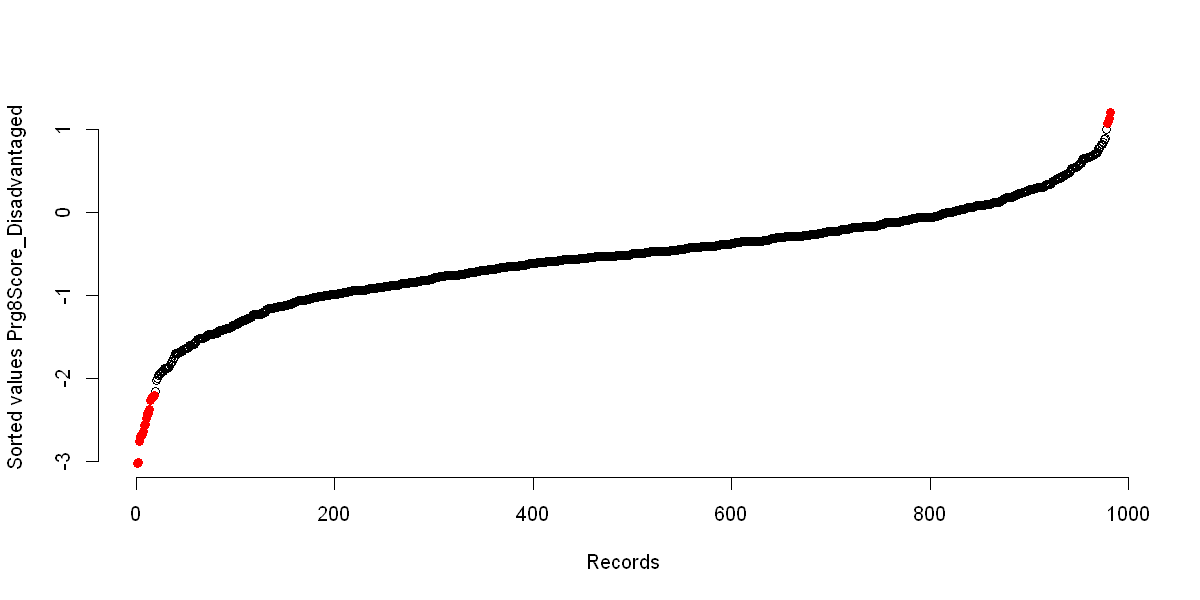

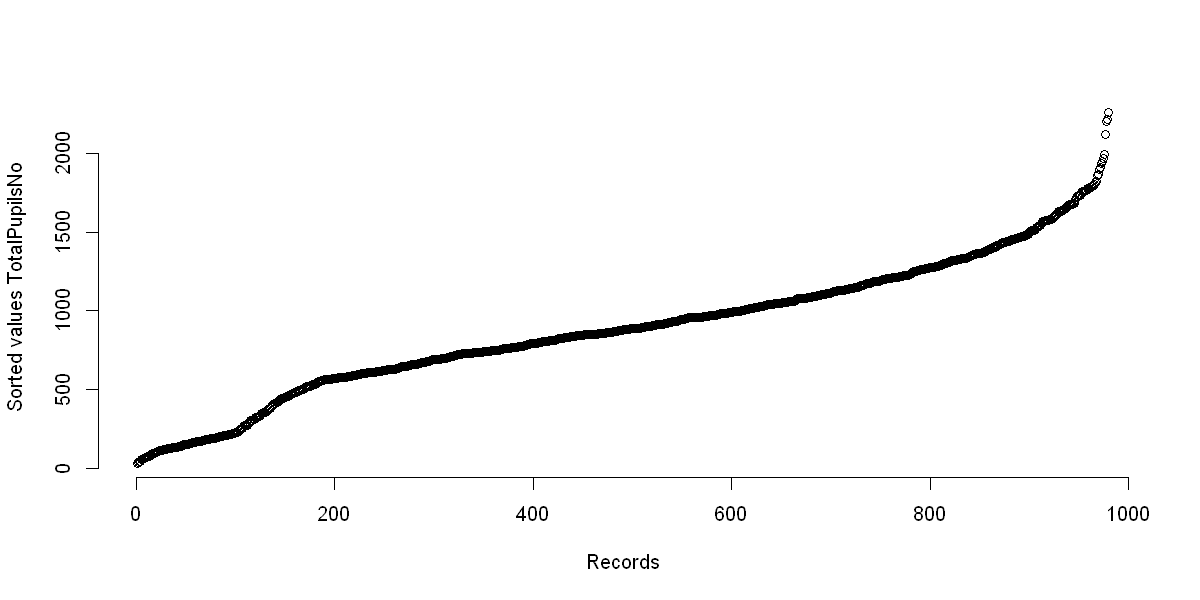

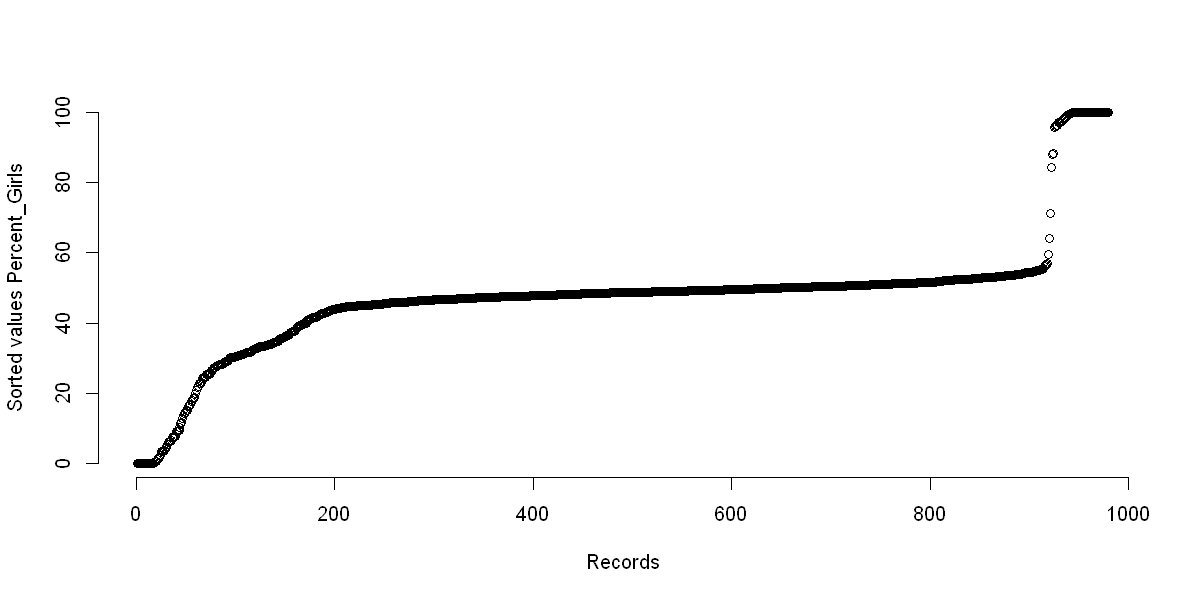

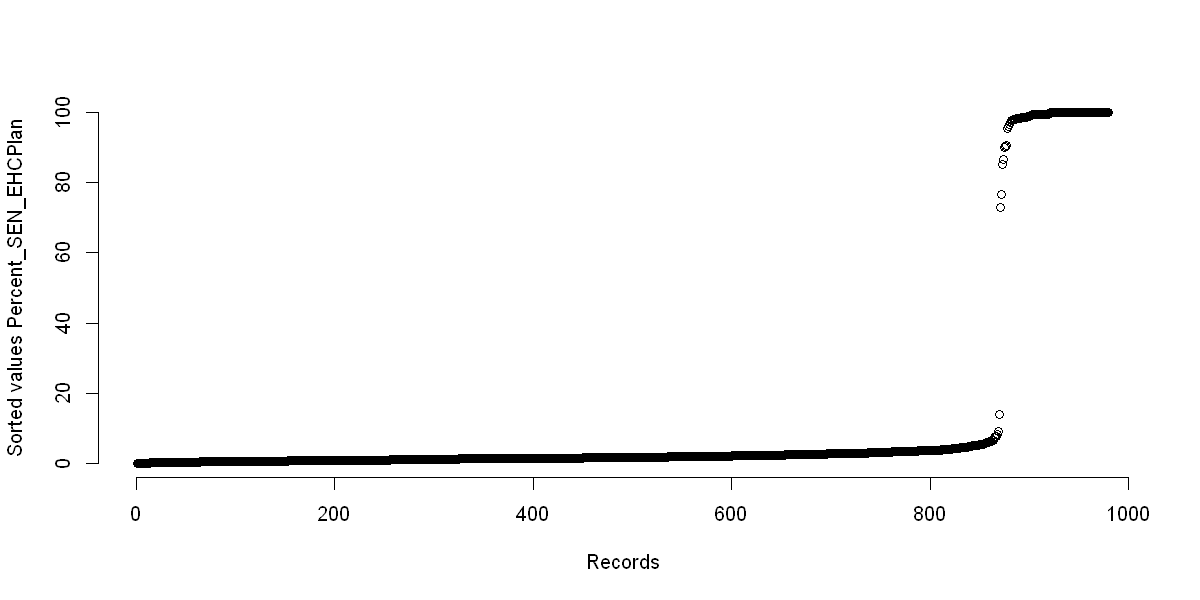

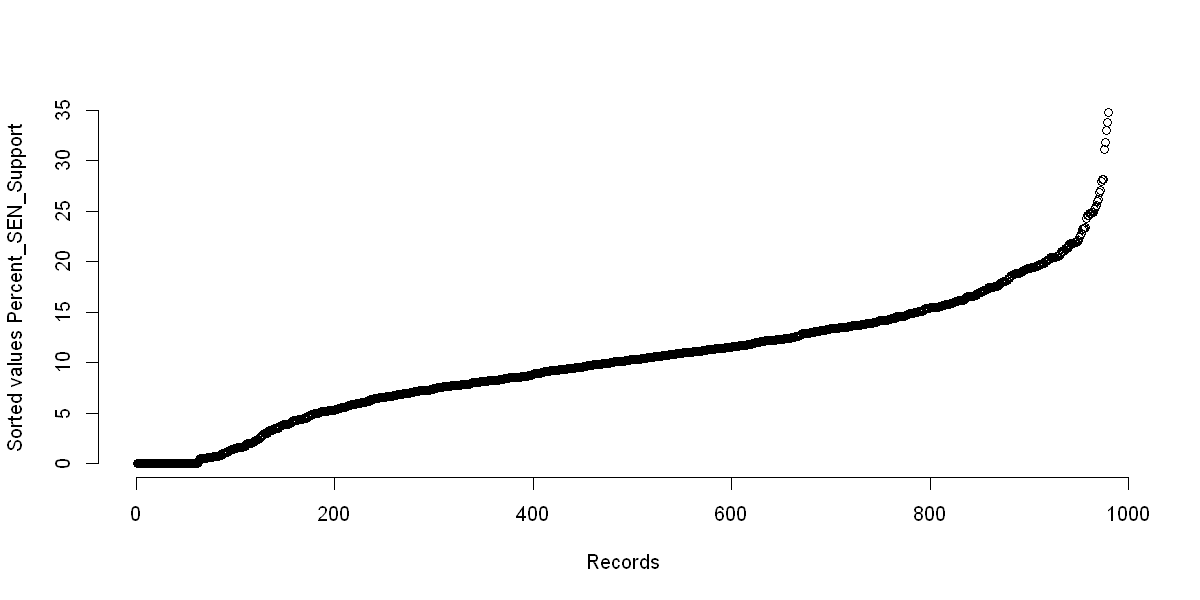

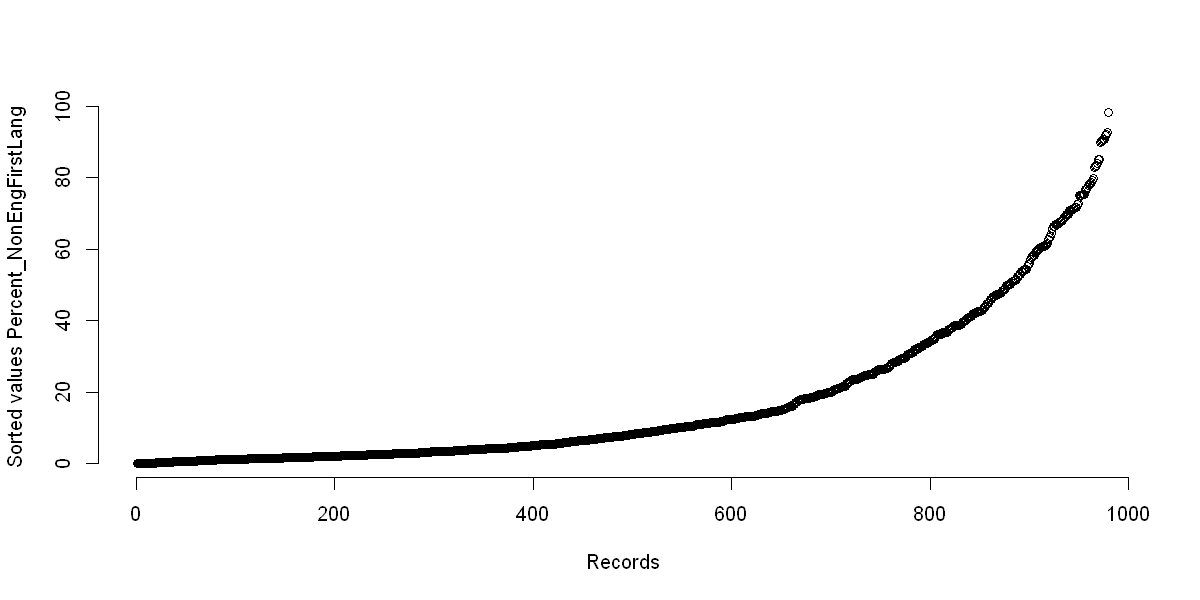

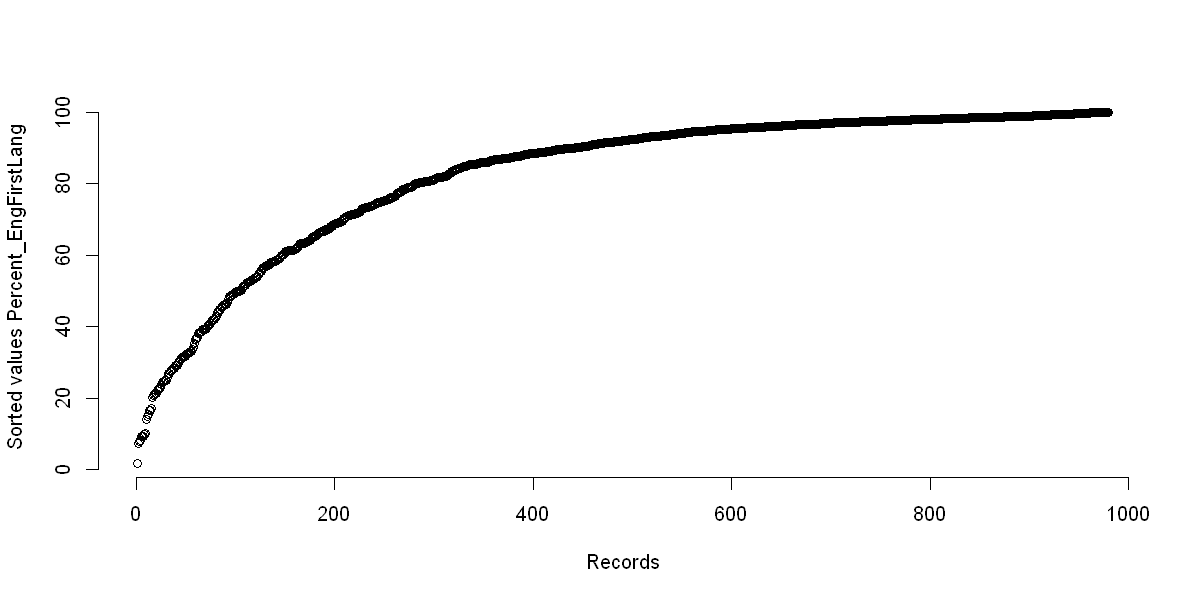

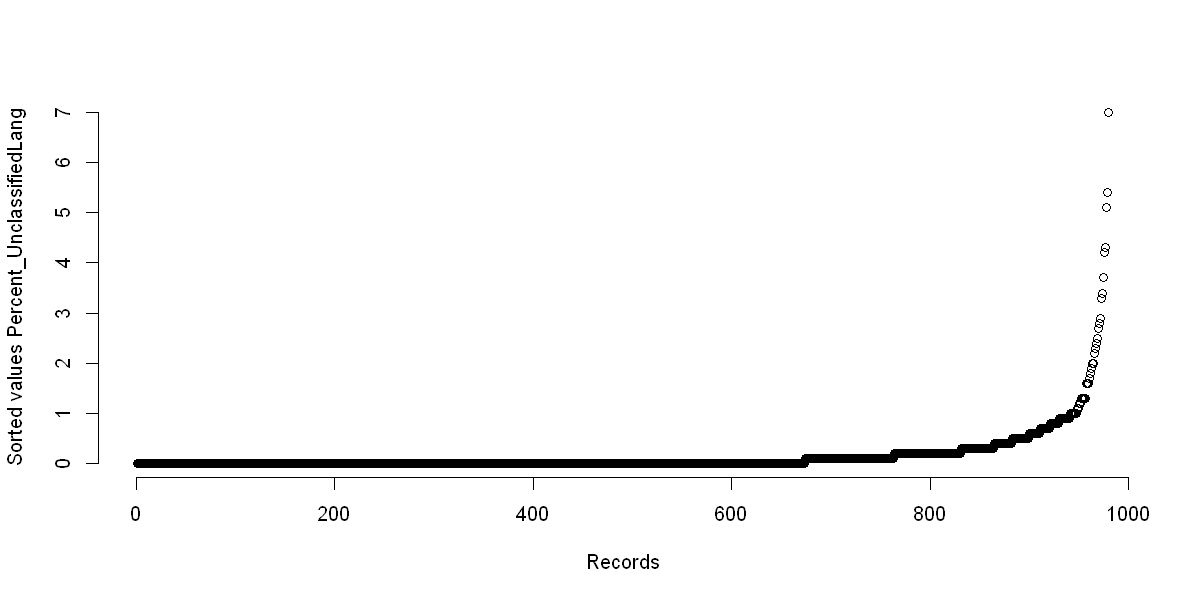

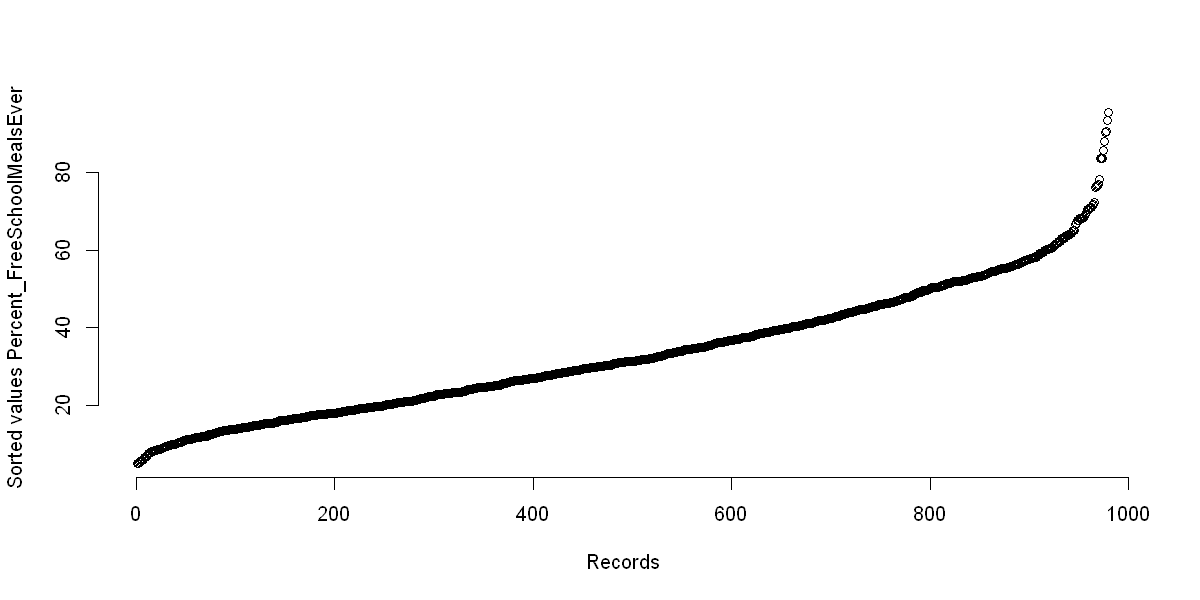

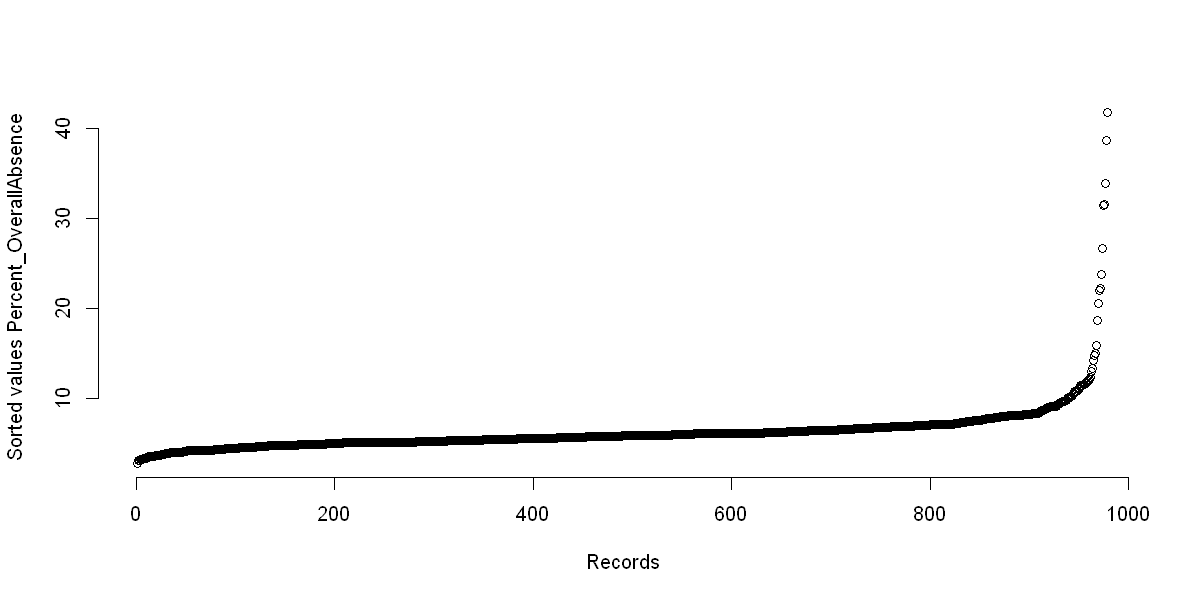

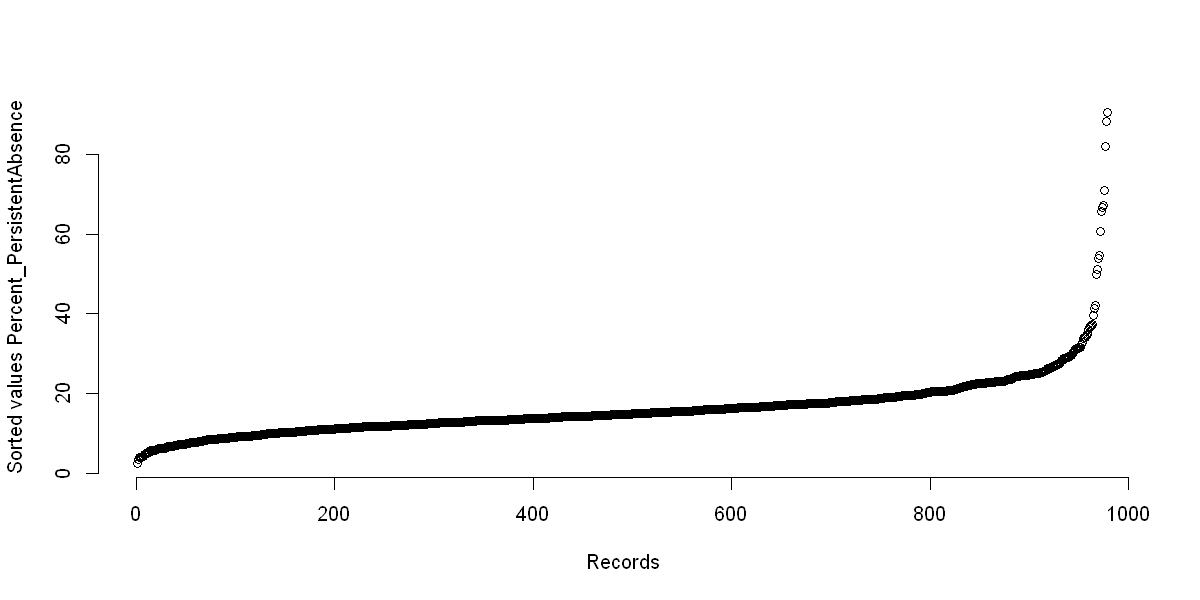

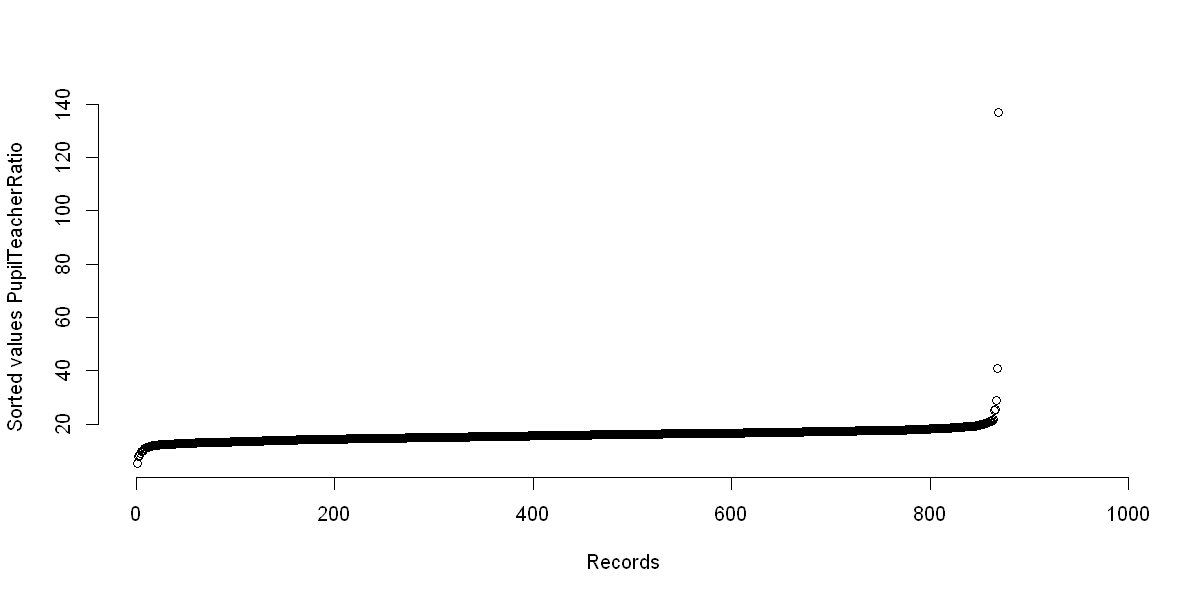

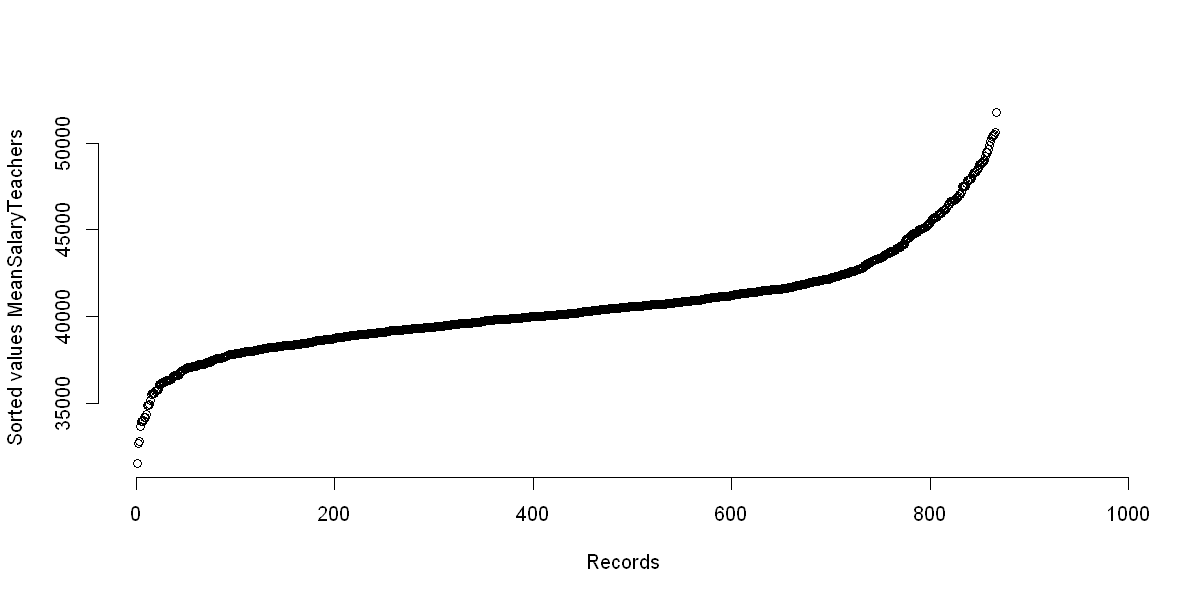

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TotalIncomewithFunding #Records= 35"


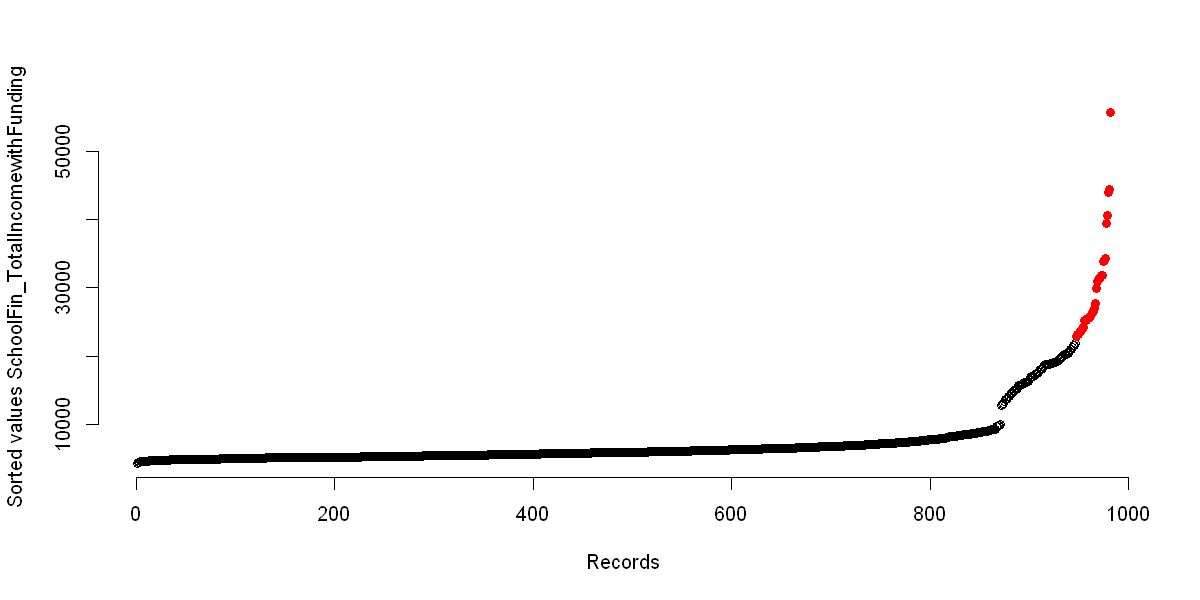

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_ICTLearningResourcesCostPerPupil #Records= 23"


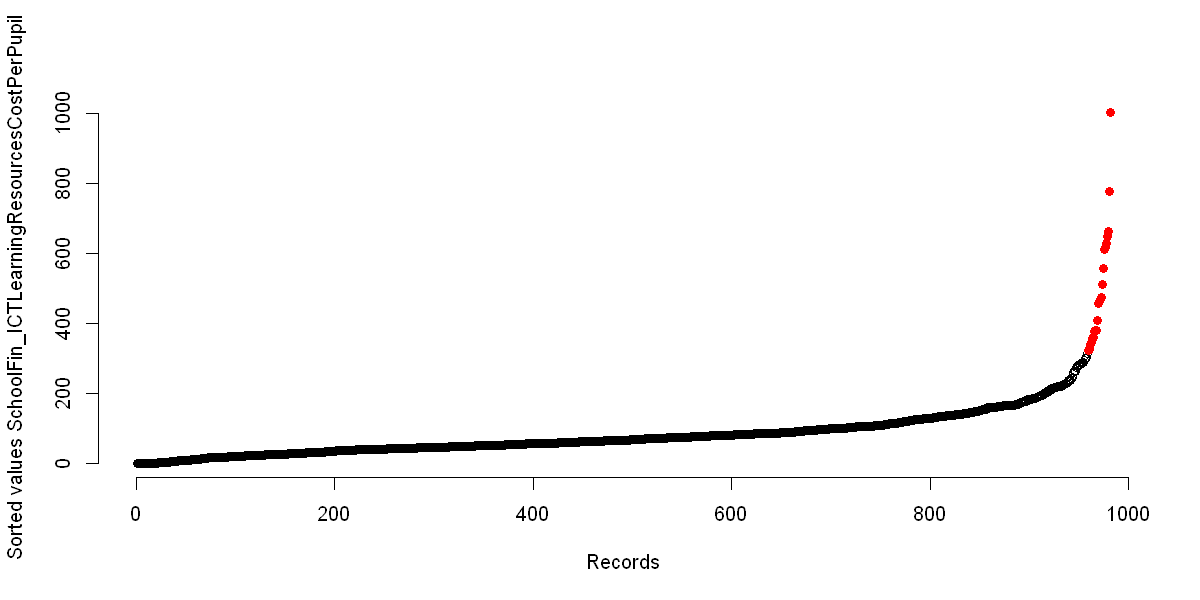

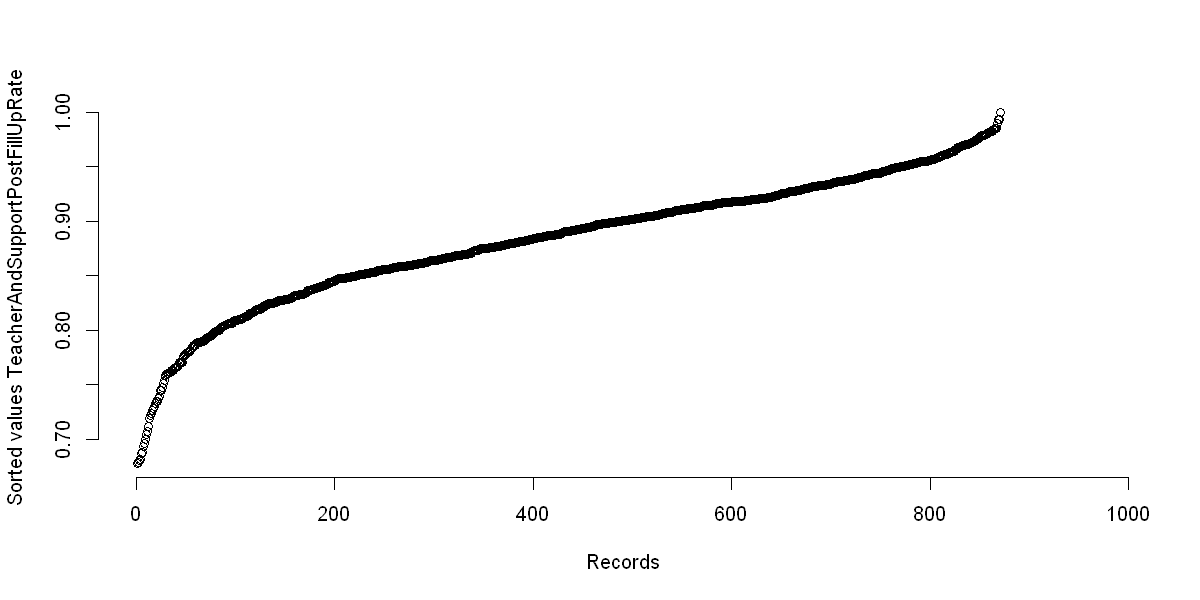

[1] "REPLACED WITH MEAN: Outlier field= TeacherAndSupportStaffCount #Records= 2"


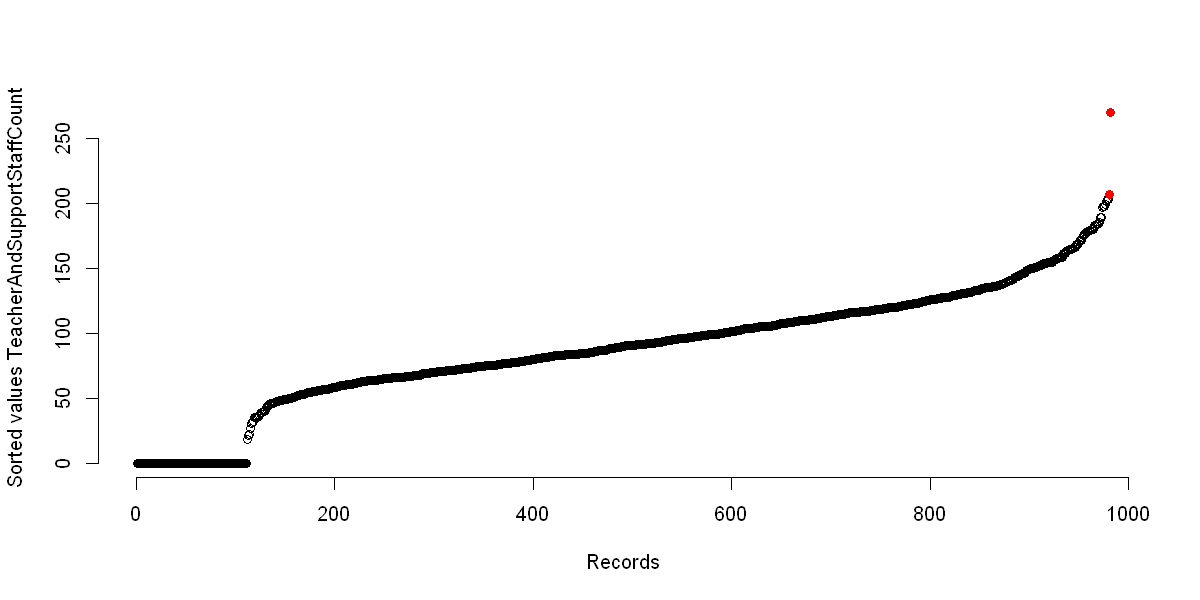

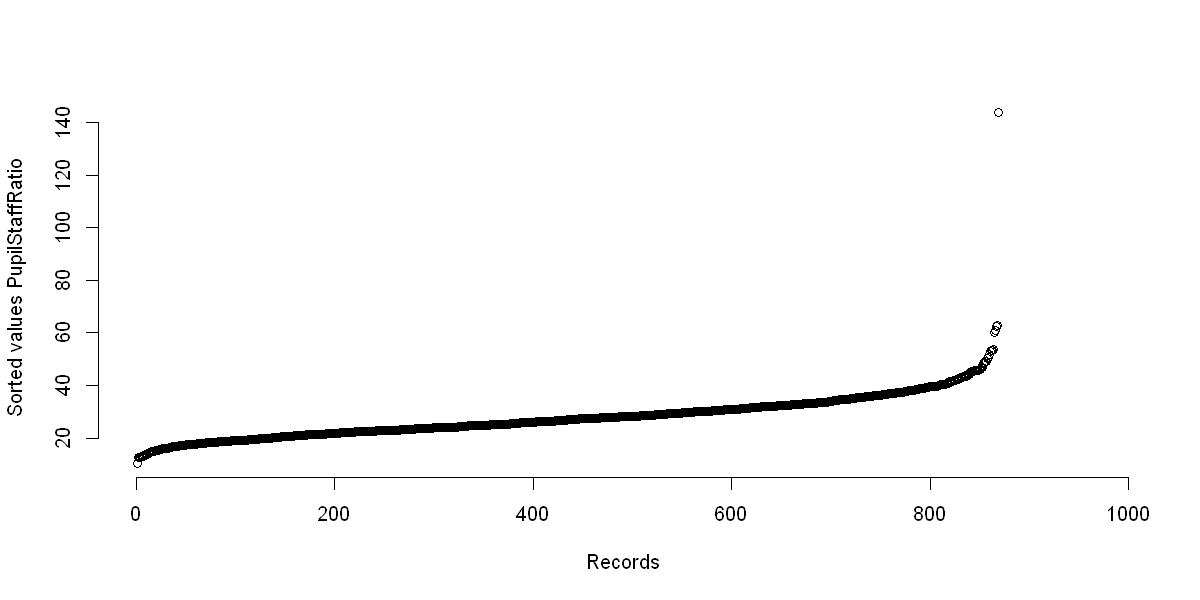

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TeachAndSupportStaffCostPerPupil #Records= 40"


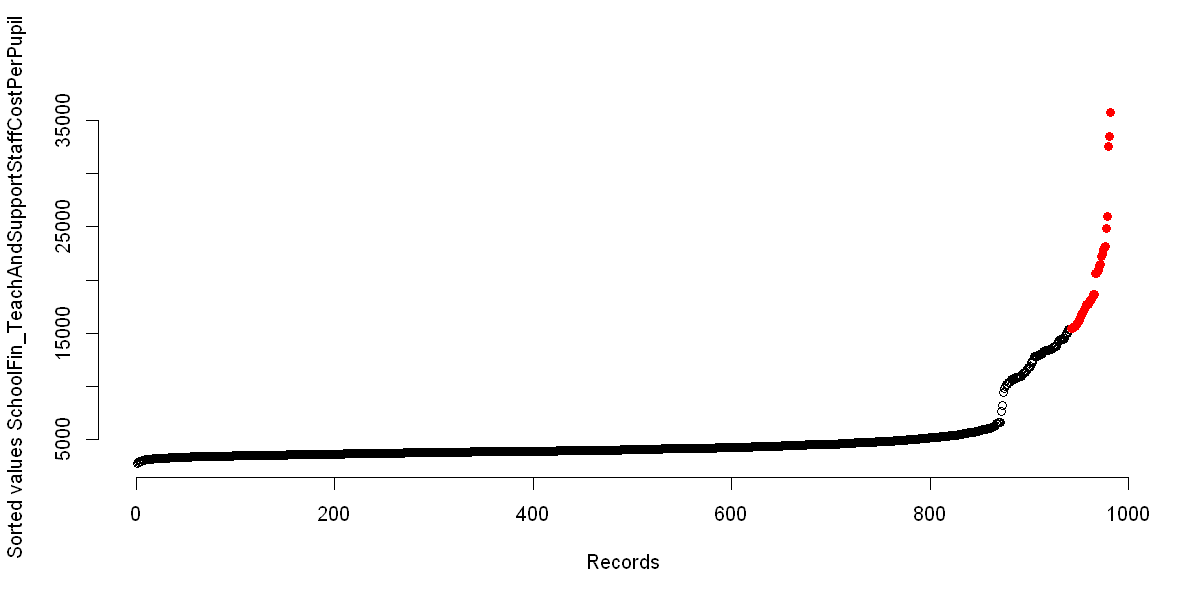

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_NonICTAndEducationServiceCostPerPupil #Records= 23"


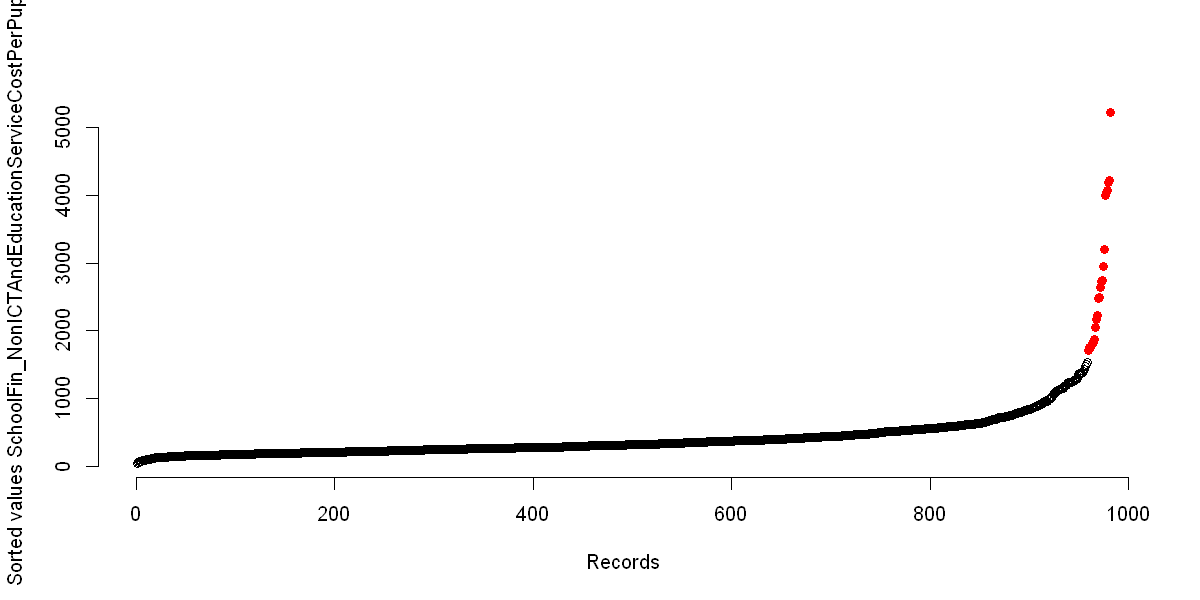

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_MiscCostPerPupil #Records= 23"


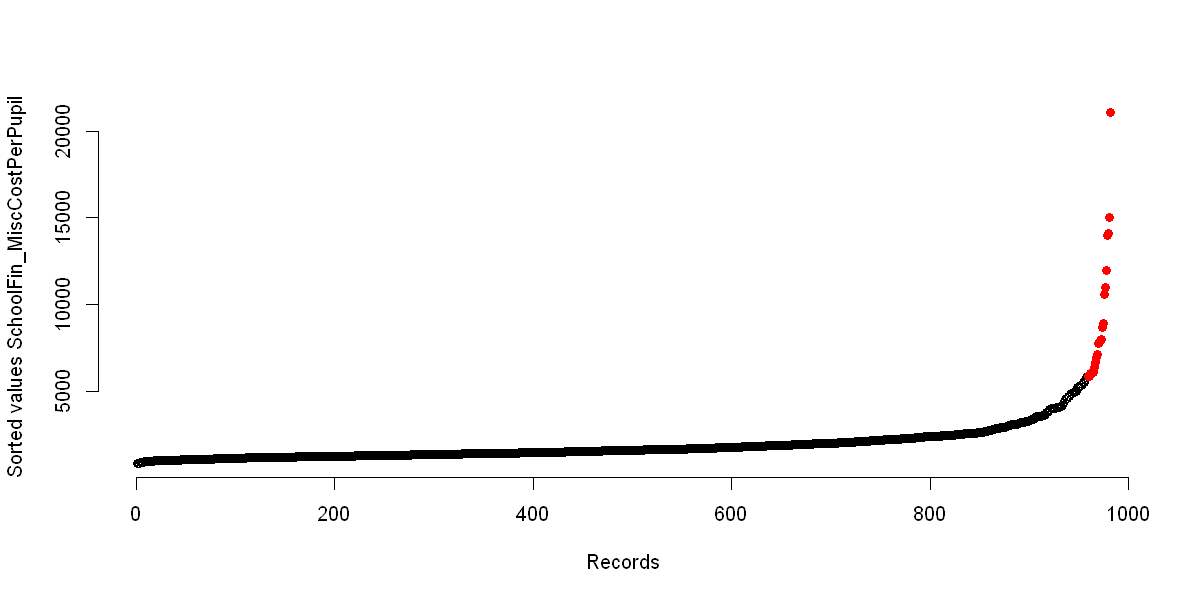

In [196]:
XY_2017_18 <- NPREPROCESSING_outlier(XY_2017_18,
                             XY_col_dict$datatype, 
                             confidence=0.99, 
                             operation="mean")

In [197]:
# From the plot, it is found that there is a number of schools with TeacherAndSupportStaffCount = 0, which is not a natural figures
# Thus, these schools are also imputed with a mean value

meanval <- mean(XY_2017_18[XY_2017_18$TeacherAndSupportStaffCount>0, c('TeacherAndSupportStaffCount')])
XY_2017_18[XY_2017_18$TeacherAndSupportStaffCount==0, c('TeacherAndSupportStaffCount')] <- meanval



[1] "REPLACED WITH MEAN: Outlier field= Att8Score_Disadvantaged #Records= 40"


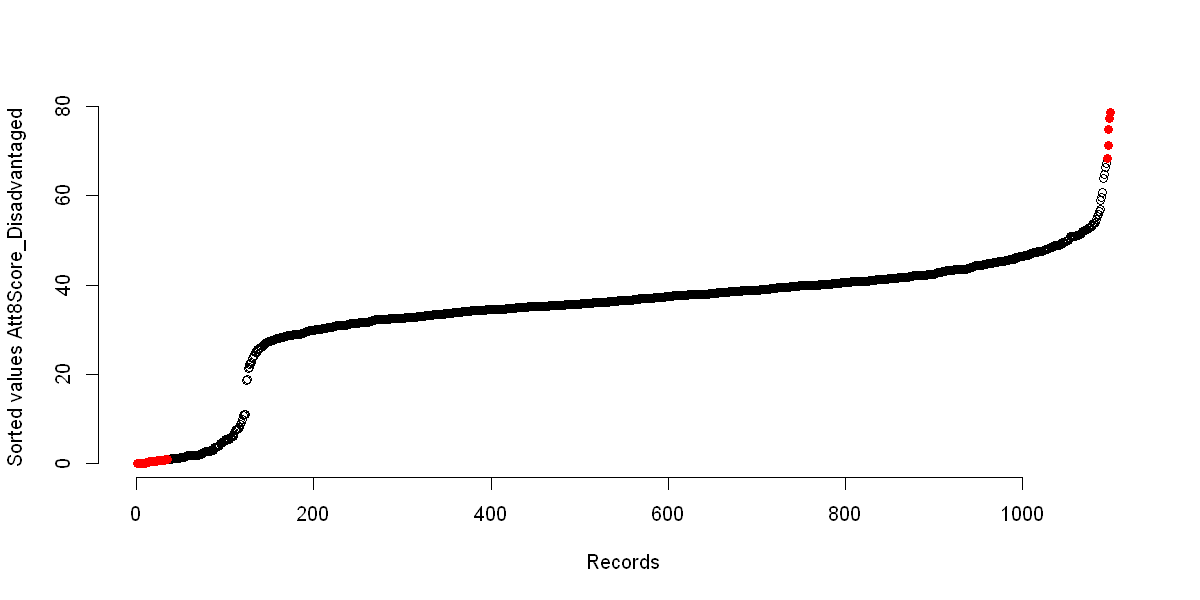

[1] "REPLACED WITH MEAN: Outlier field= Prg8Score_Disadvantaged #Records= 19"


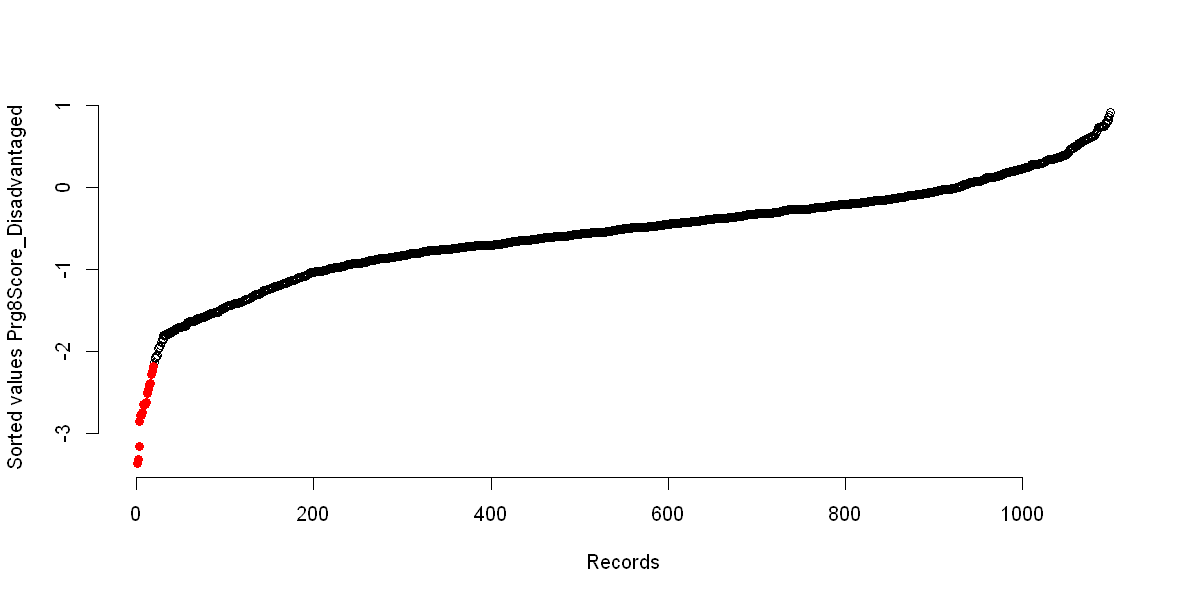

[1] "REPLACED WITH MEAN: Outlier field= TotalPupilsNo #Records= 3"


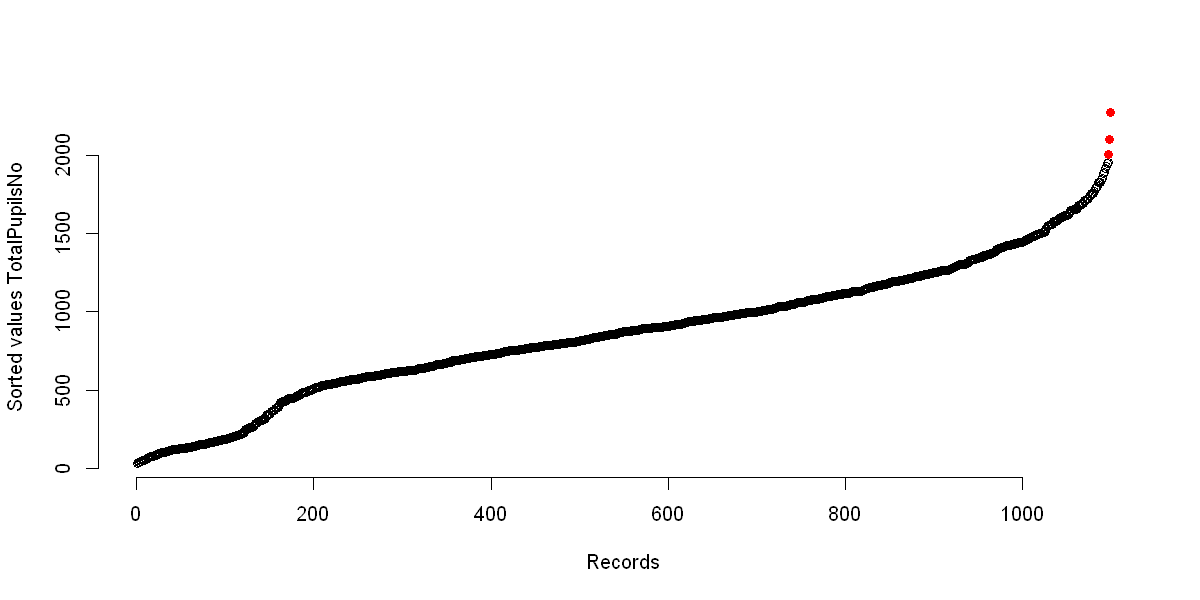

[1] "REPLACED WITH MEAN: Outlier field= Percent_Girls #Records= 97"


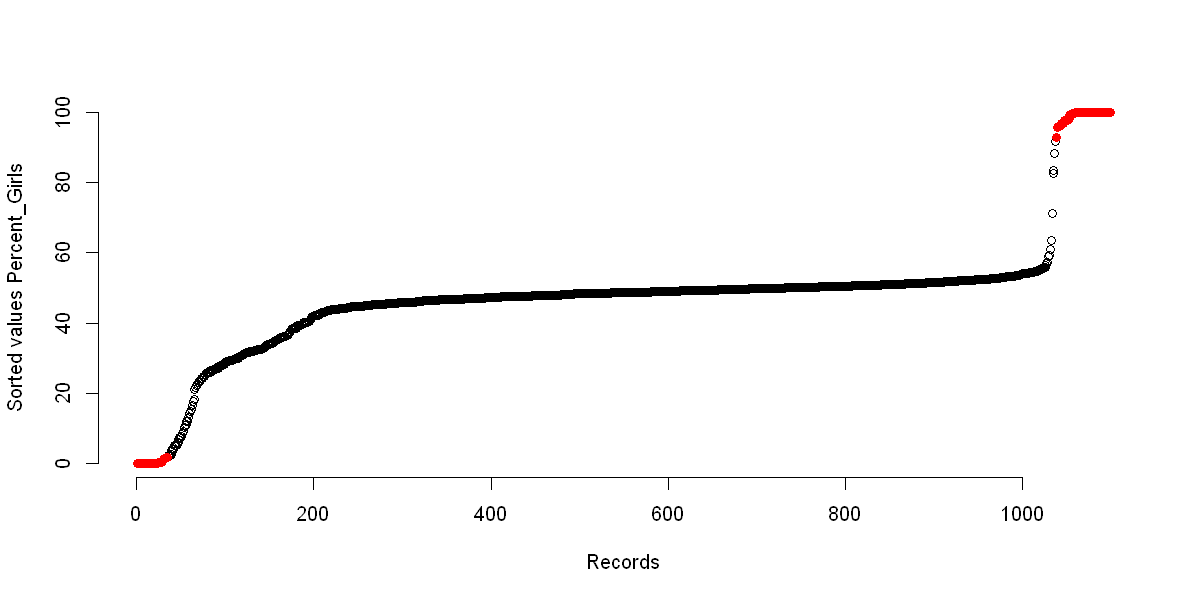

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_EHCPlan #Records= 123"


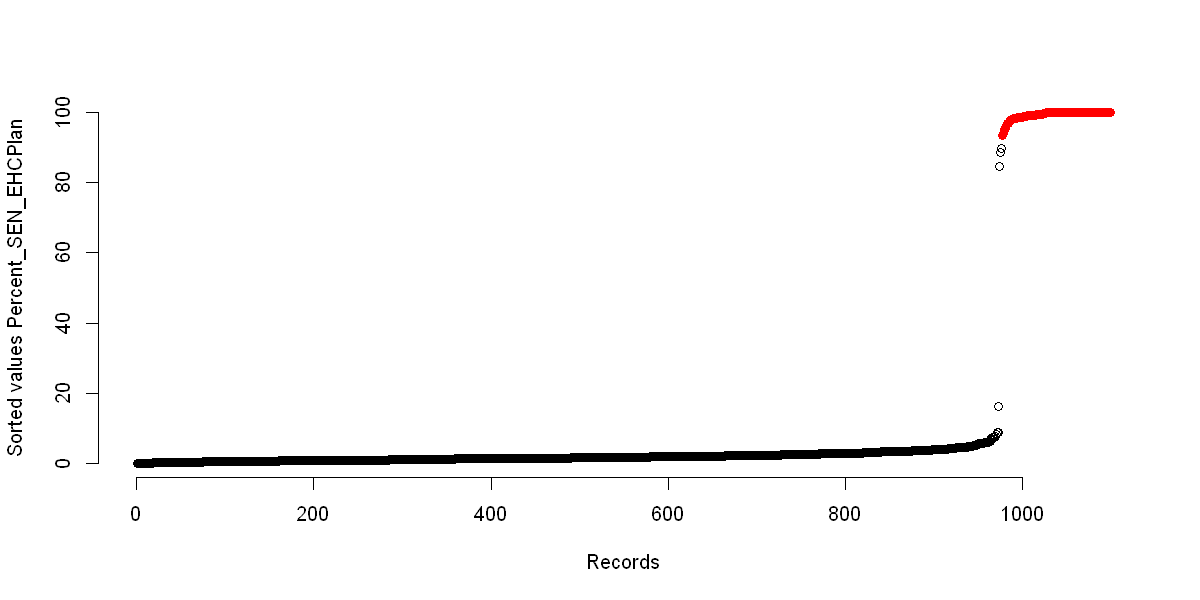

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_Support #Records= 15"


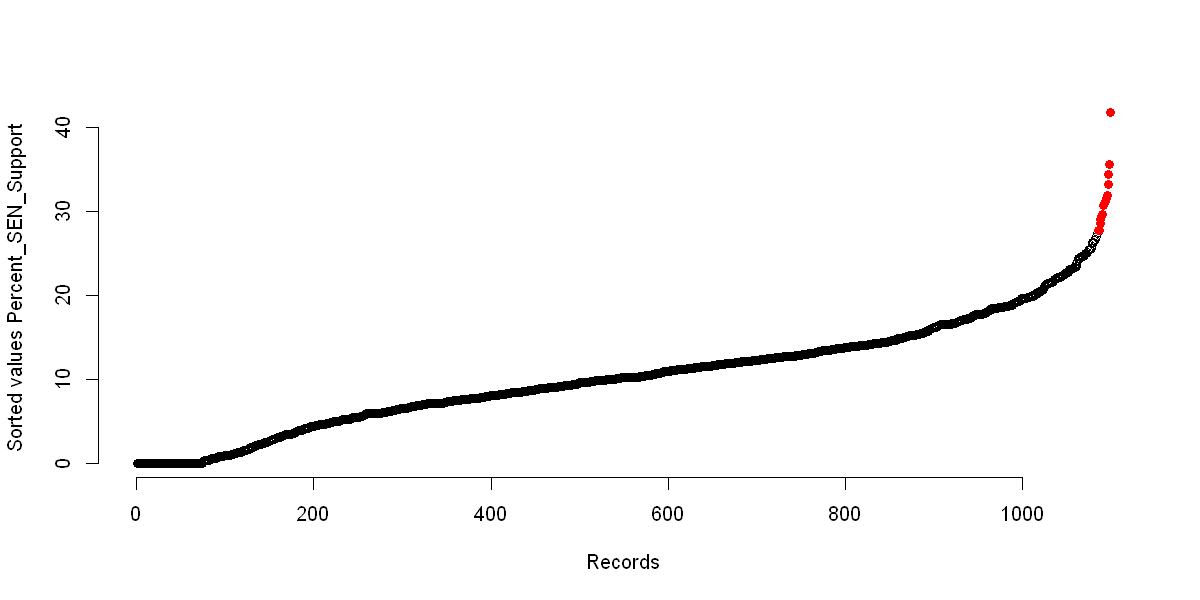

[1] "REPLACED WITH MEAN: Outlier field= Percent_NonEngFirstLang #Records= 42"


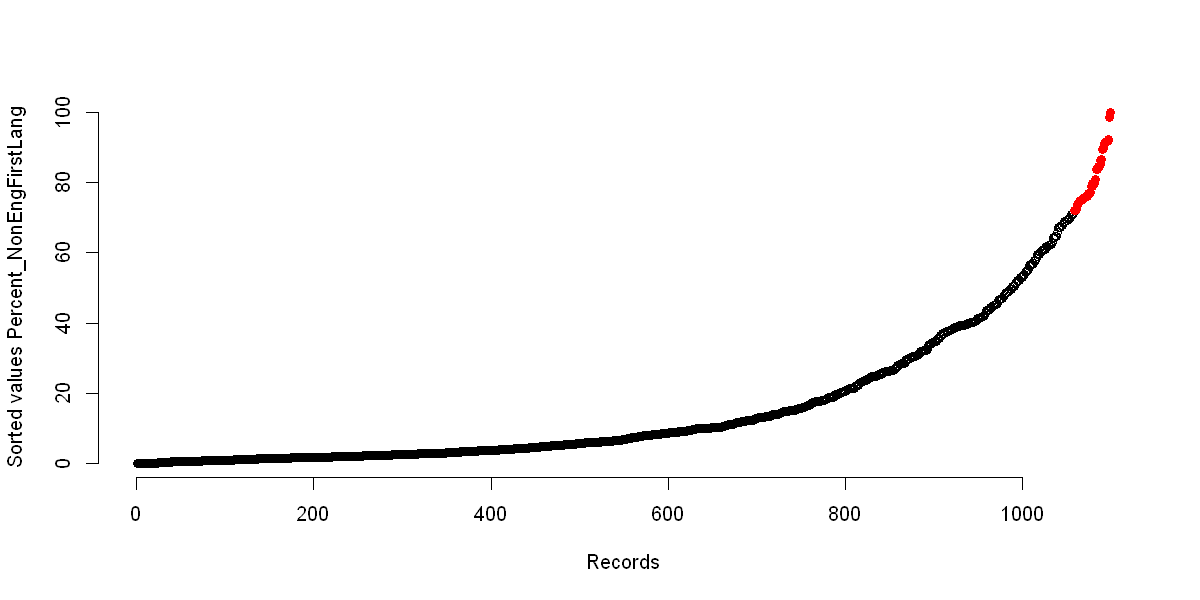

[1] "REPLACED WITH MEAN: Outlier field= Percent_EngFirstLang #Records= 40"


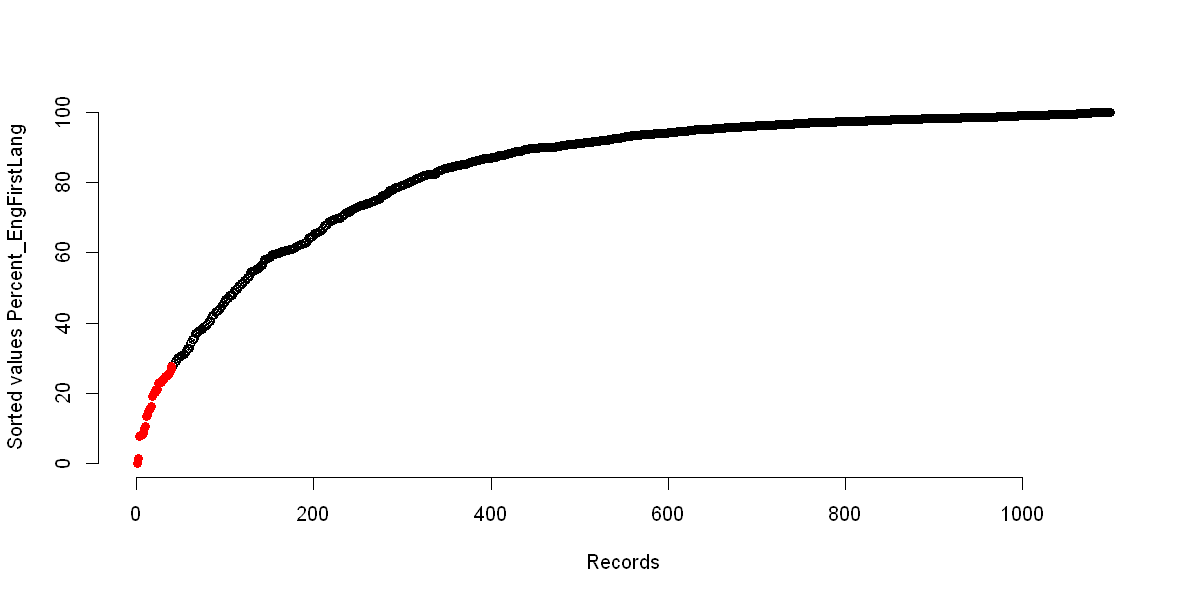

[1] "REPLACED WITH MEAN: Outlier field= Percent_UnclassifiedLang #Records= 24"


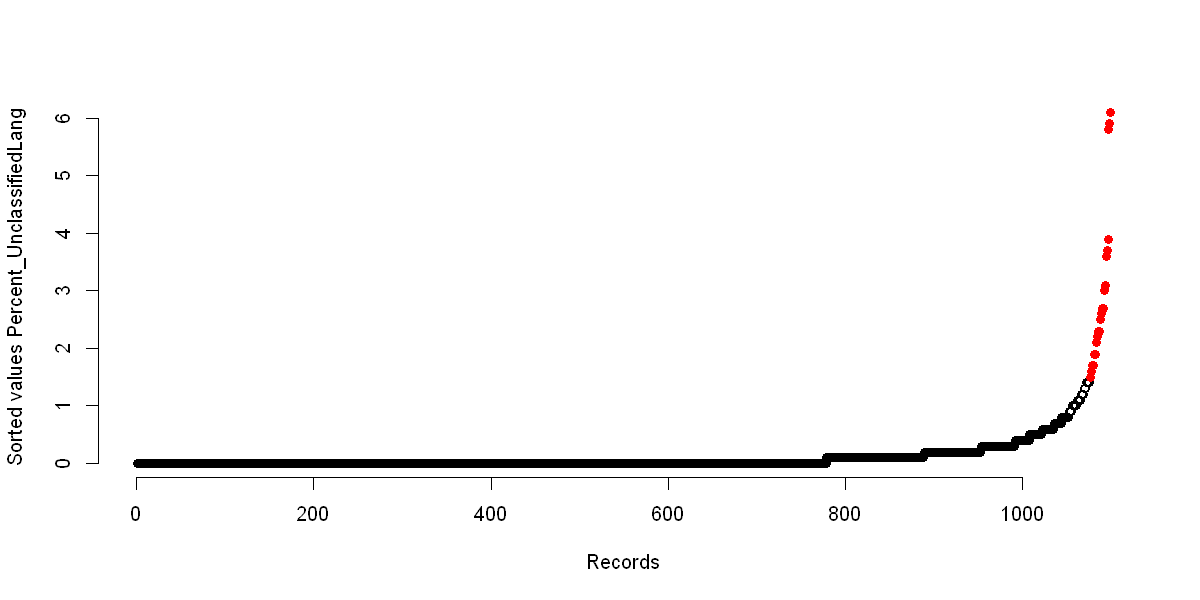

[1] "REPLACED WITH MEAN: Outlier field= Percent_FreeSchoolMealsEver #Records= 15"


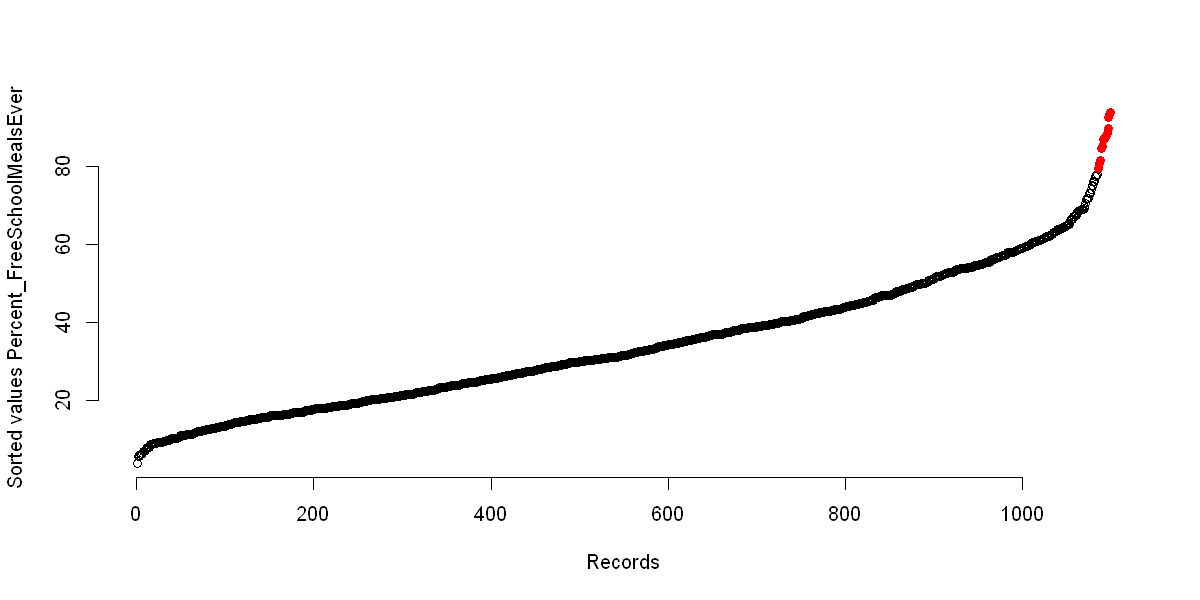

[1] "REPLACED WITH MEAN: Outlier field= Percent_OverallAbsence #Records= 18"


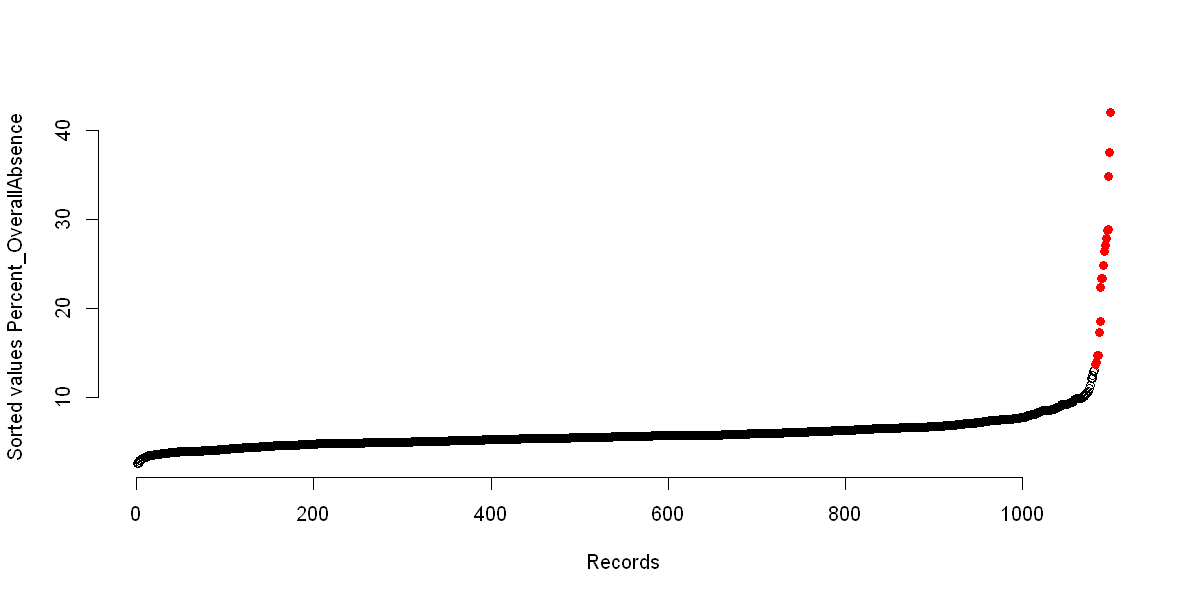

[1] "REPLACED WITH MEAN: Outlier field= Percent_PersistentAbsence #Records= 18"


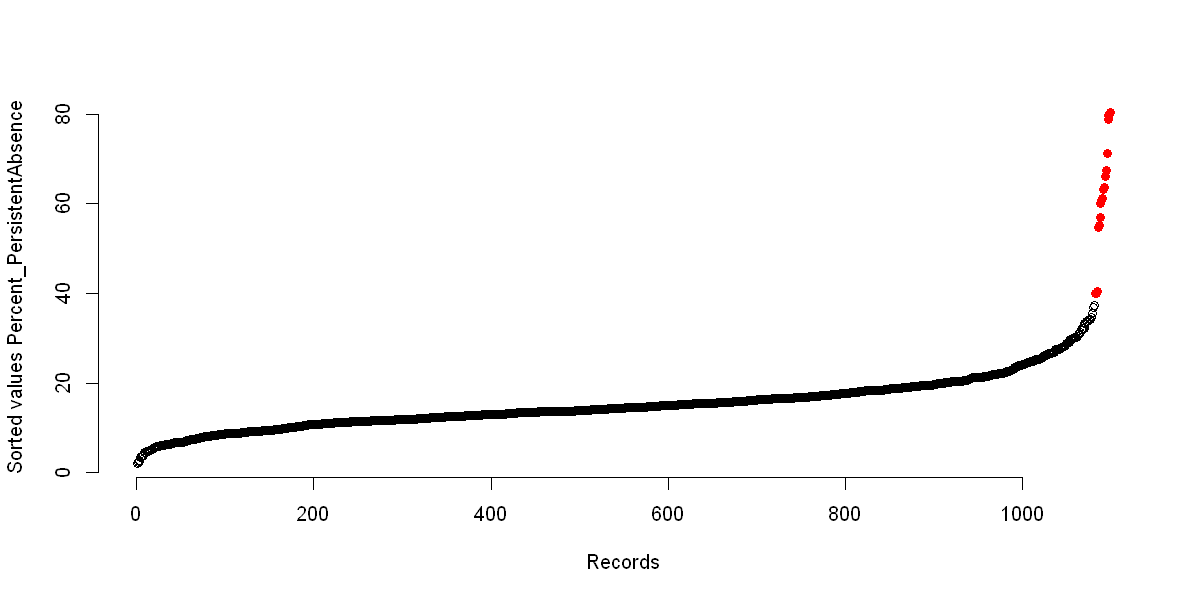

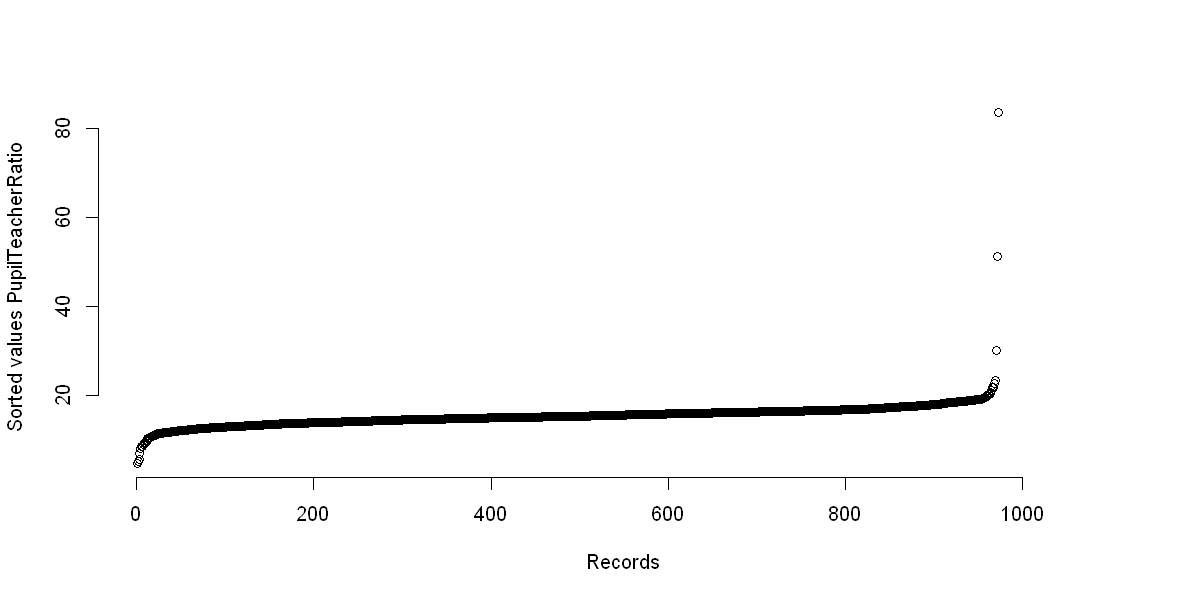

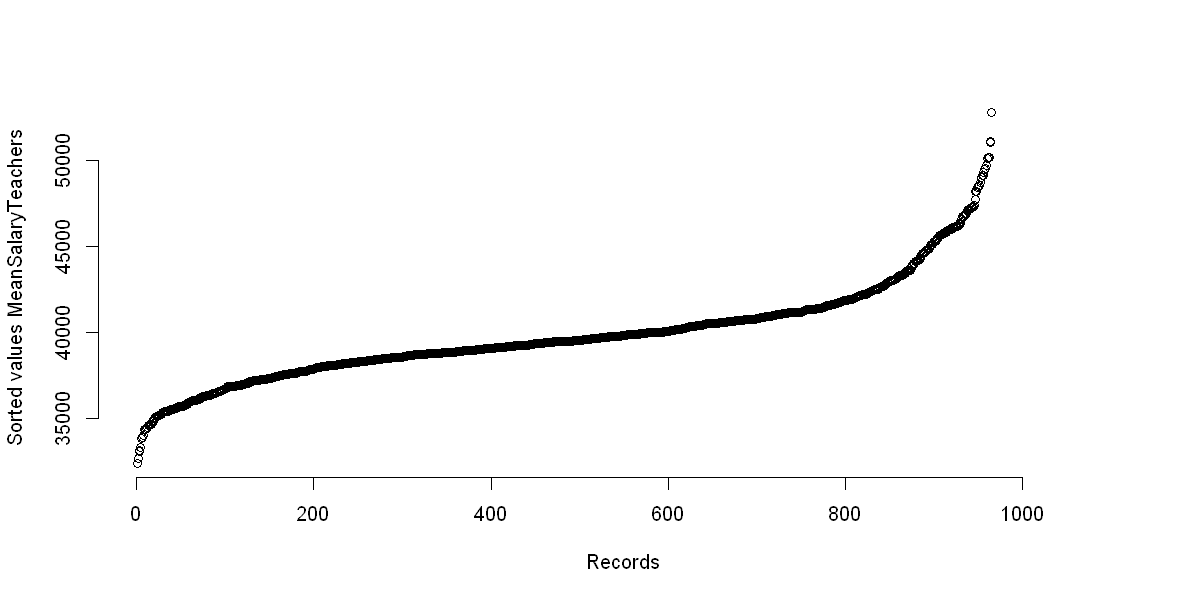

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TotalIncomewithFunding #Records= 39"


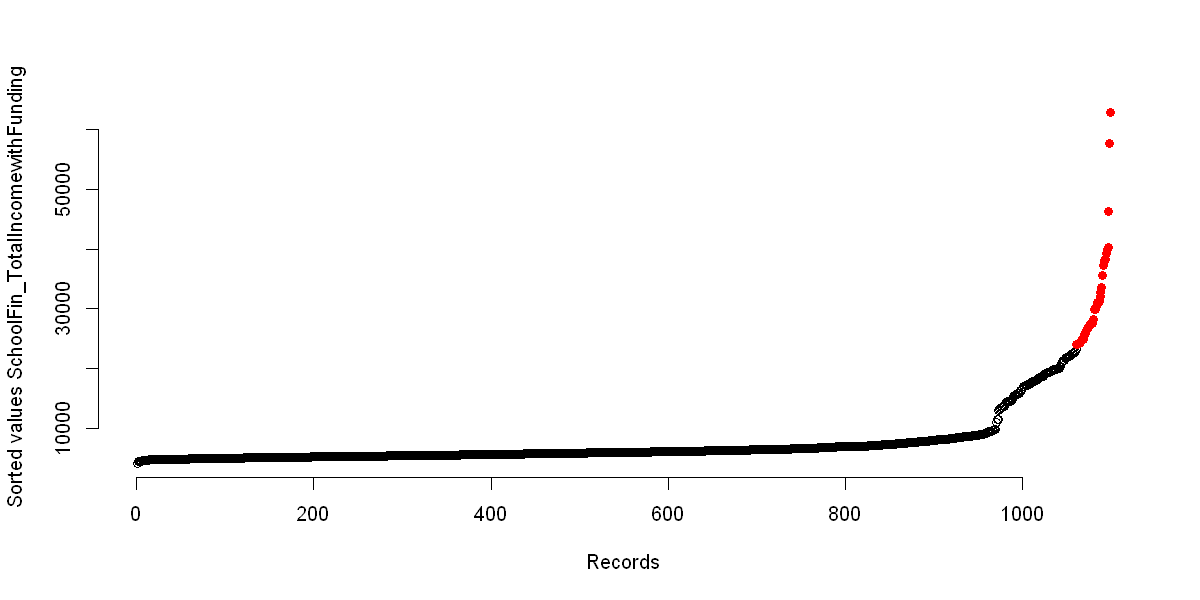

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_ICTLearningResourcesCostPerPupil #Records= 17"


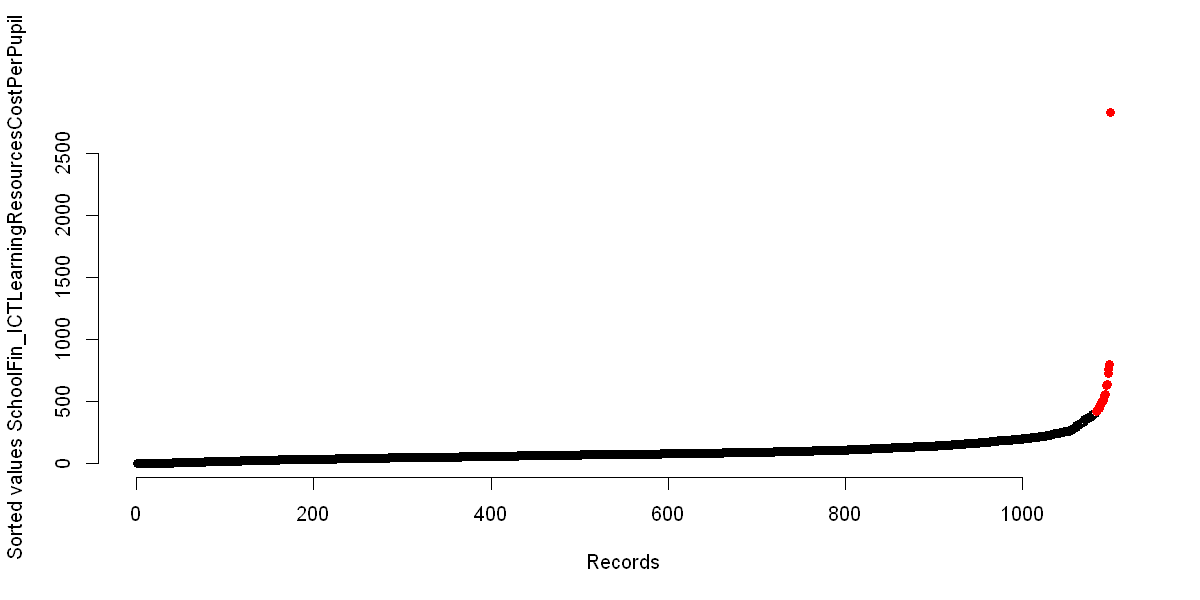

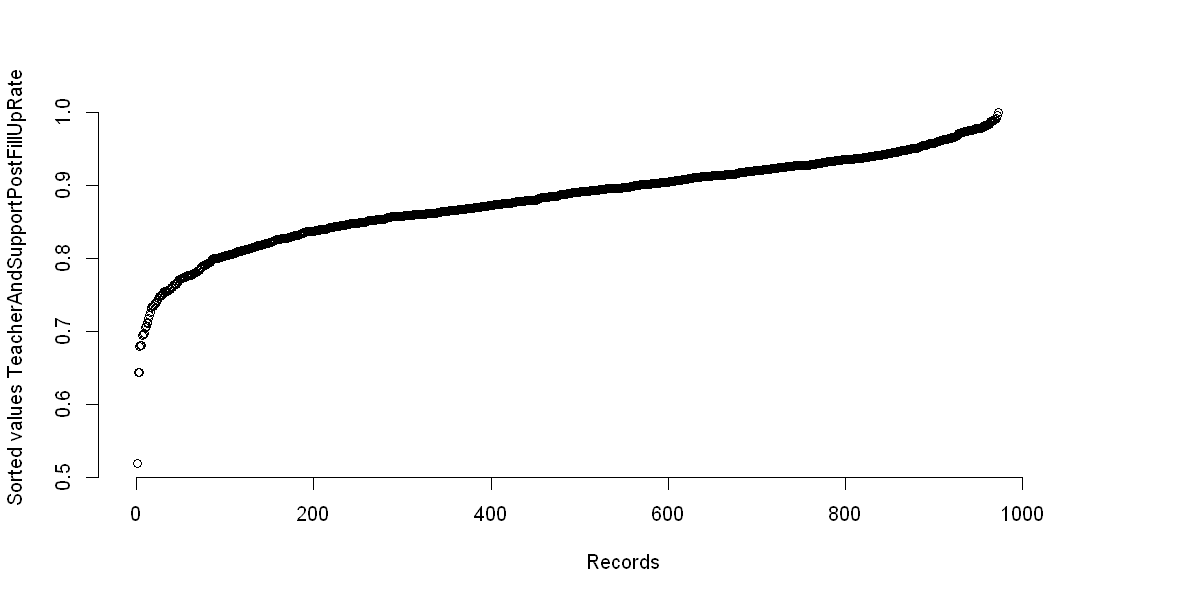

[1] "REPLACED WITH MEAN: Outlier field= TeacherAndSupportStaffCount #Records= 6"


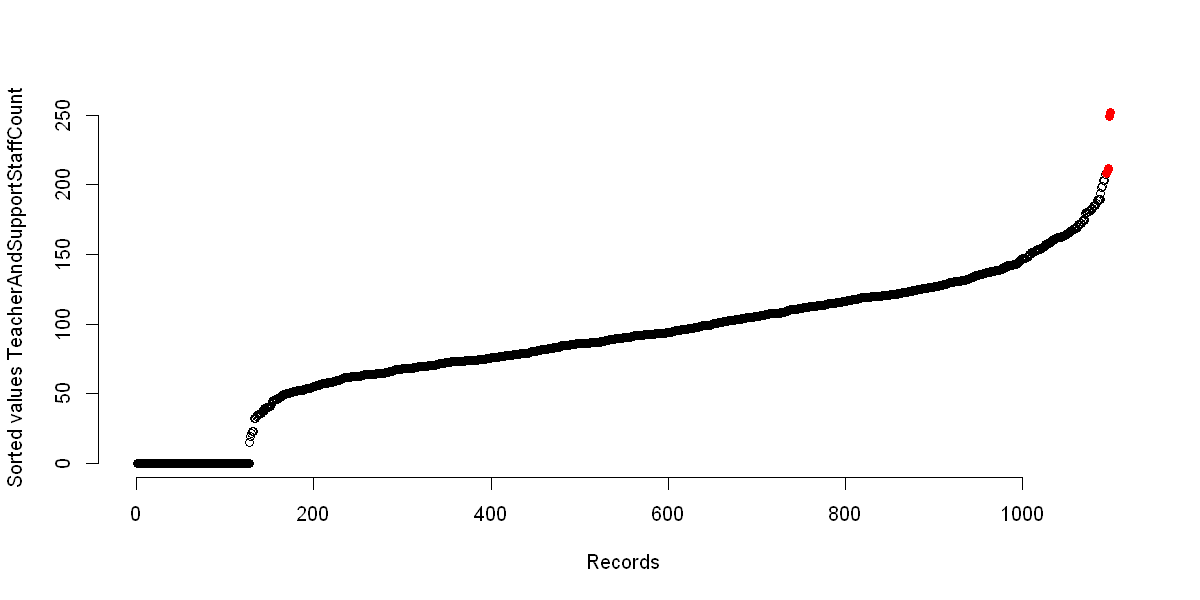

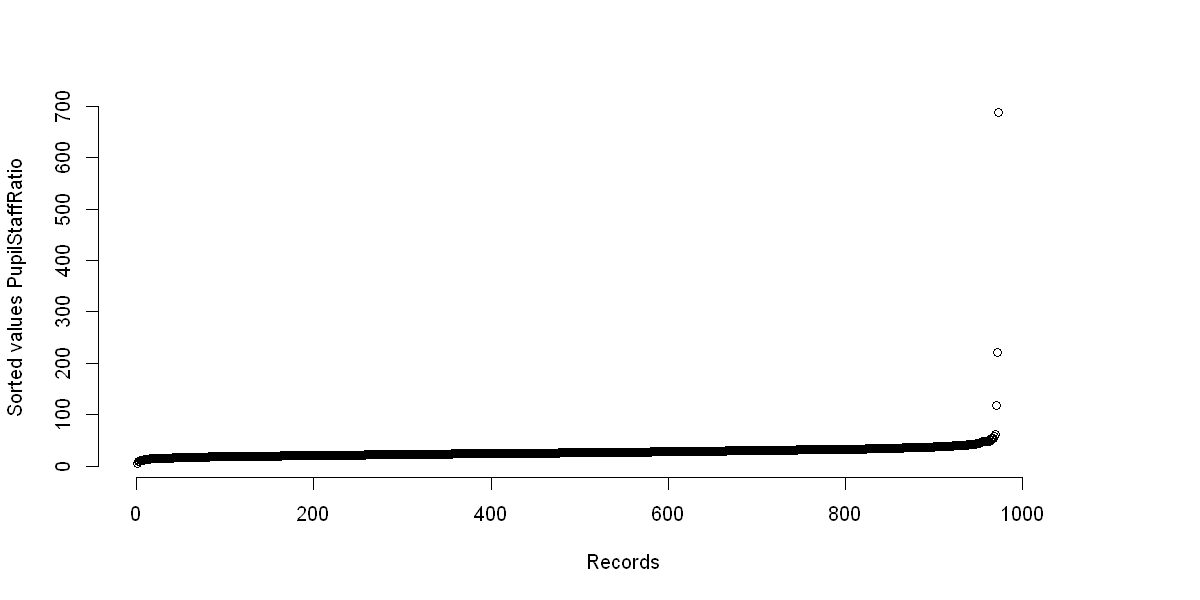

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TeachAndSupportStaffCostPerPupil #Records= 41"


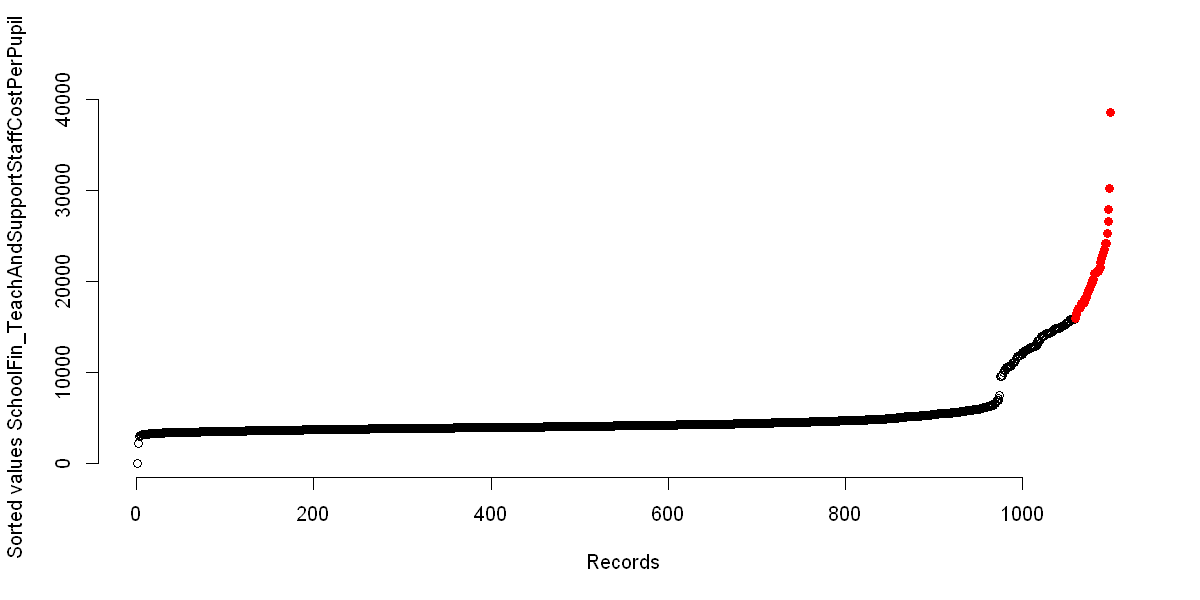

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_NonICTAndEducationServiceCostPerPupil #Records= 21"


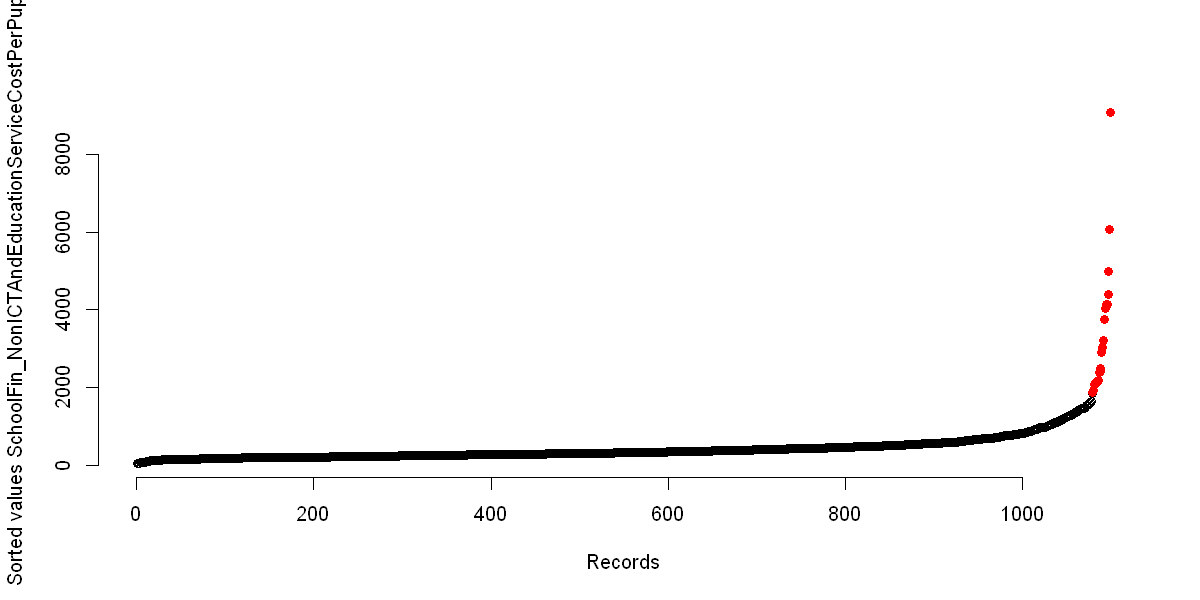

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_MiscCostPerPupil #Records= 26"


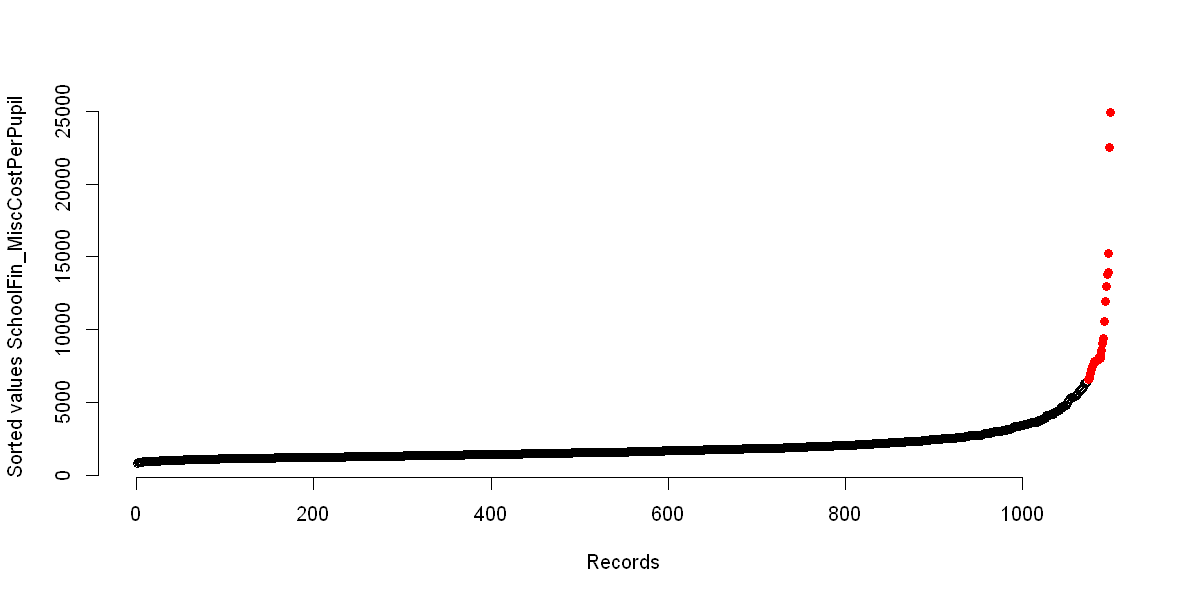

In [198]:
XY_2016_17 <- NPREPROCESSING_outlier(XY_2016_17,
                             XY_col_dict$datatype, 
                             confidence=0.99, 
                             operation="mean")

In [199]:
# From the plot, it is found that there is a number of schools with TeacherAndSupportStaffCount = 0, which is not a natural figures
# Thus, these schools are also imputed with a mean value

meanval <- mean(XY_2016_17[XY_2016_17$TeacherAndSupportStaffCount>0, c('TeacherAndSupportStaffCount')])
XY_2016_17[XY_2016_17$TeacherAndSupportStaffCount==0, c('TeacherAndSupportStaffCount')] <- meanval

[1] "REPLACED WITH MEAN: Outlier field= Att8Score_Disadvantaged #Records= 67"


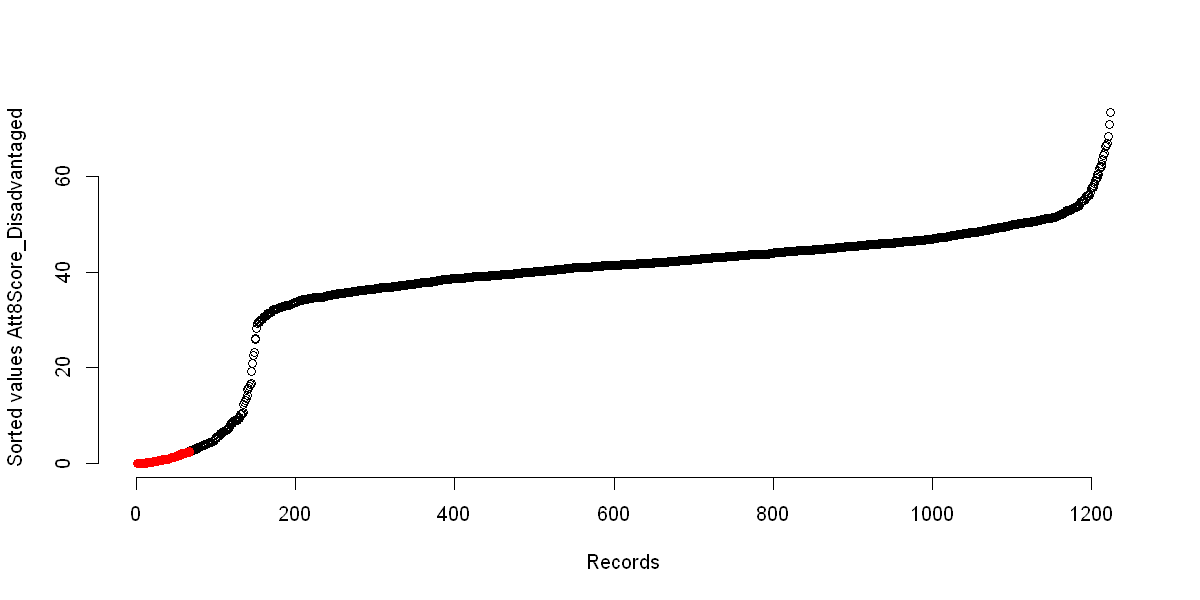

[1] "REPLACED WITH MEAN: Outlier field= Prg8Score_Disadvantaged #Records= 20"


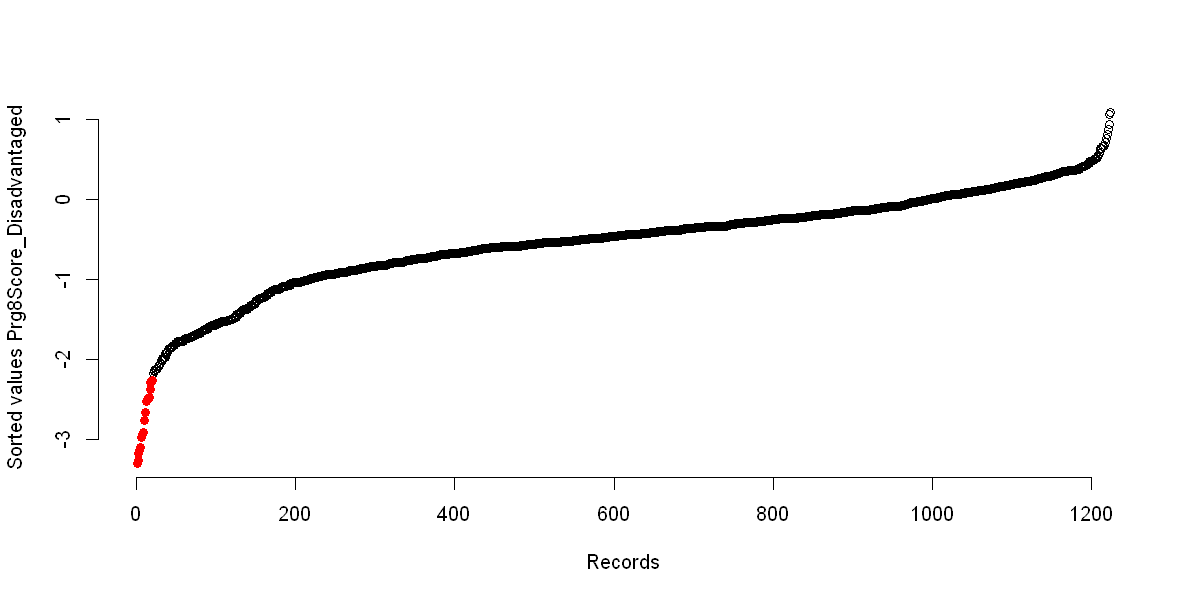

[1] "REPLACED WITH MEAN: Outlier field= TotalPupilsNo #Records= 7"


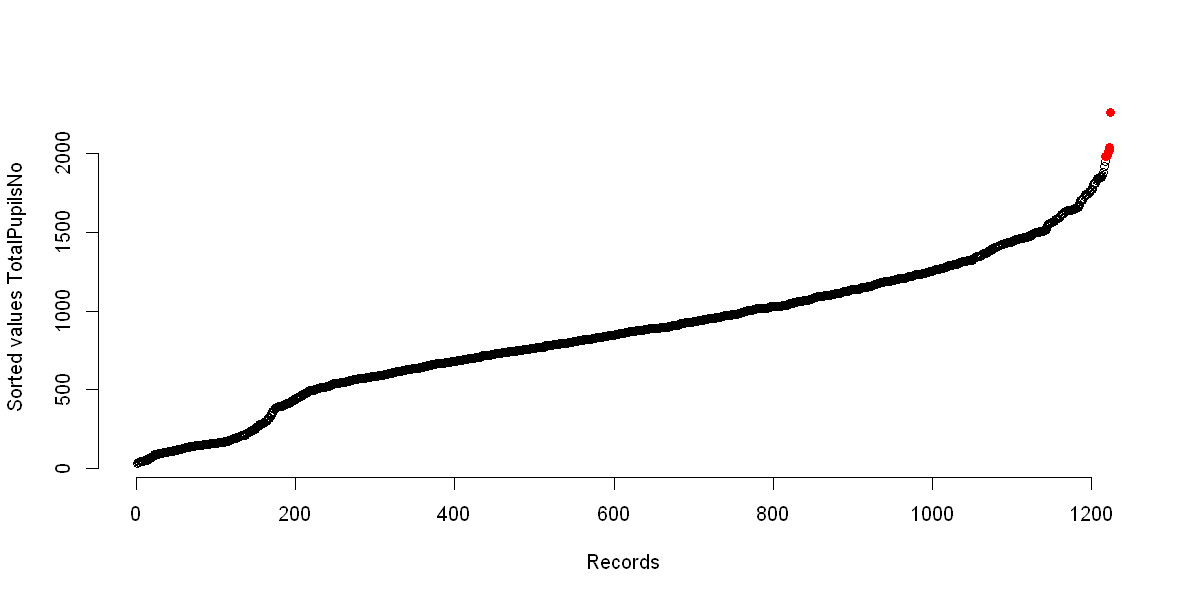

[1] "REPLACED WITH MEAN: Outlier field= Percent_Girls #Records= 104"


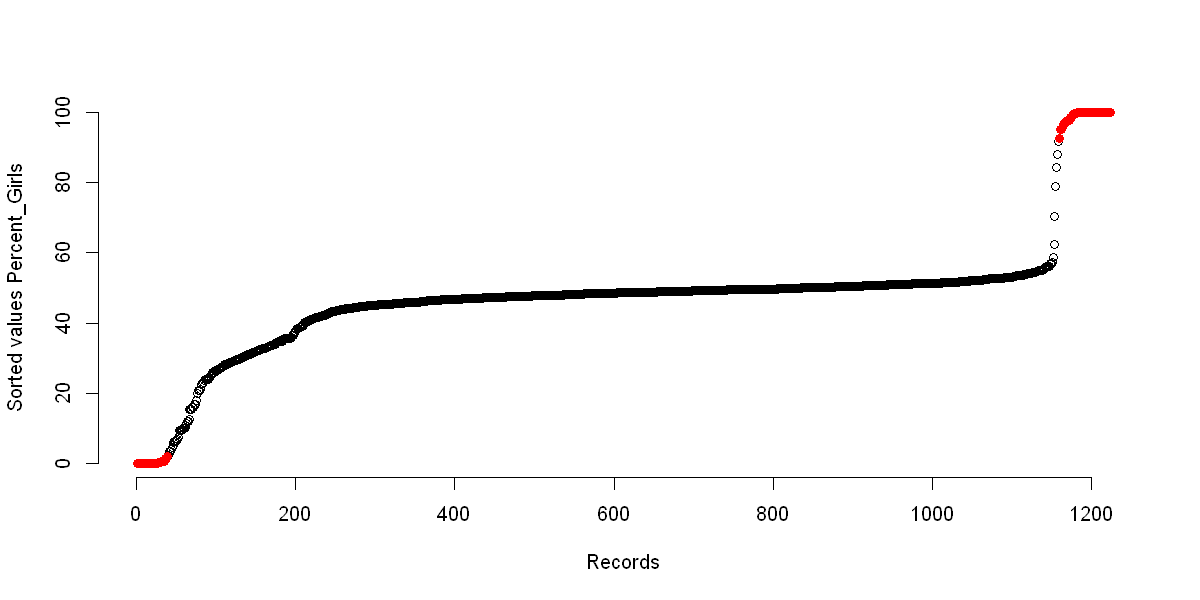

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_EHCPlan #Records= 136"


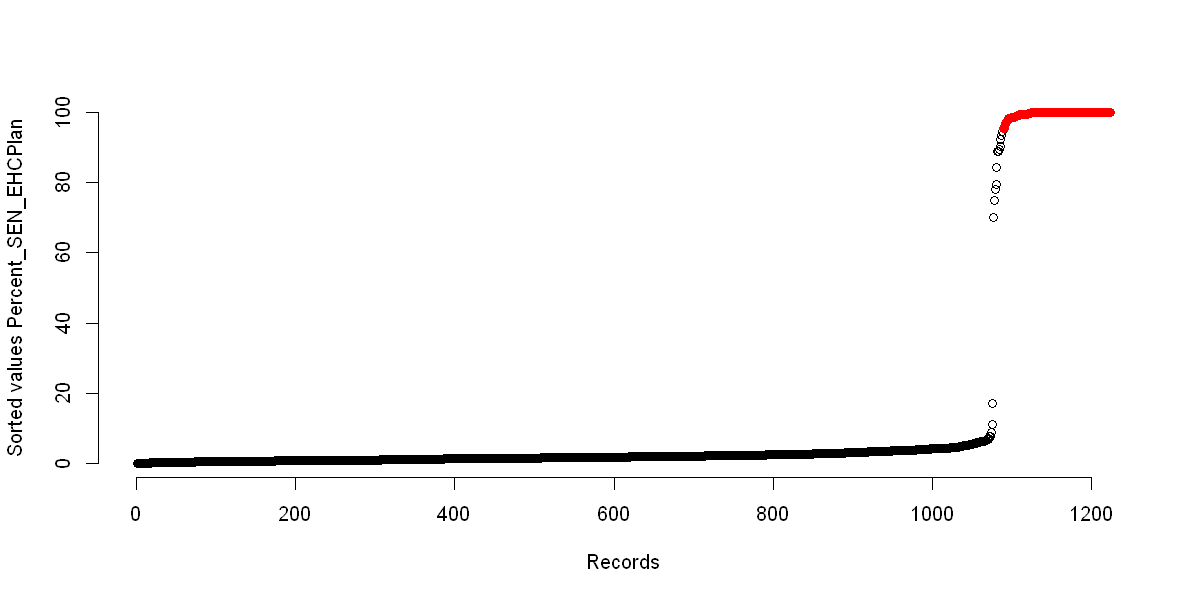

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_Support #Records= 16"


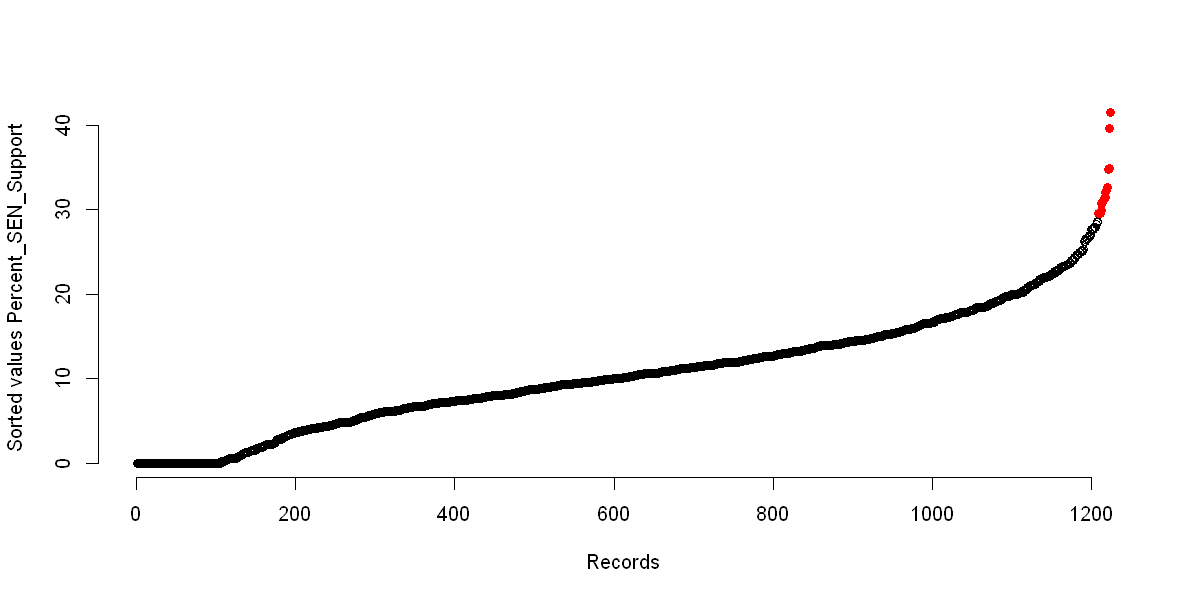

[1] "REPLACED WITH MEAN: Outlier field= Percent_NonEngFirstLang #Records= 45"


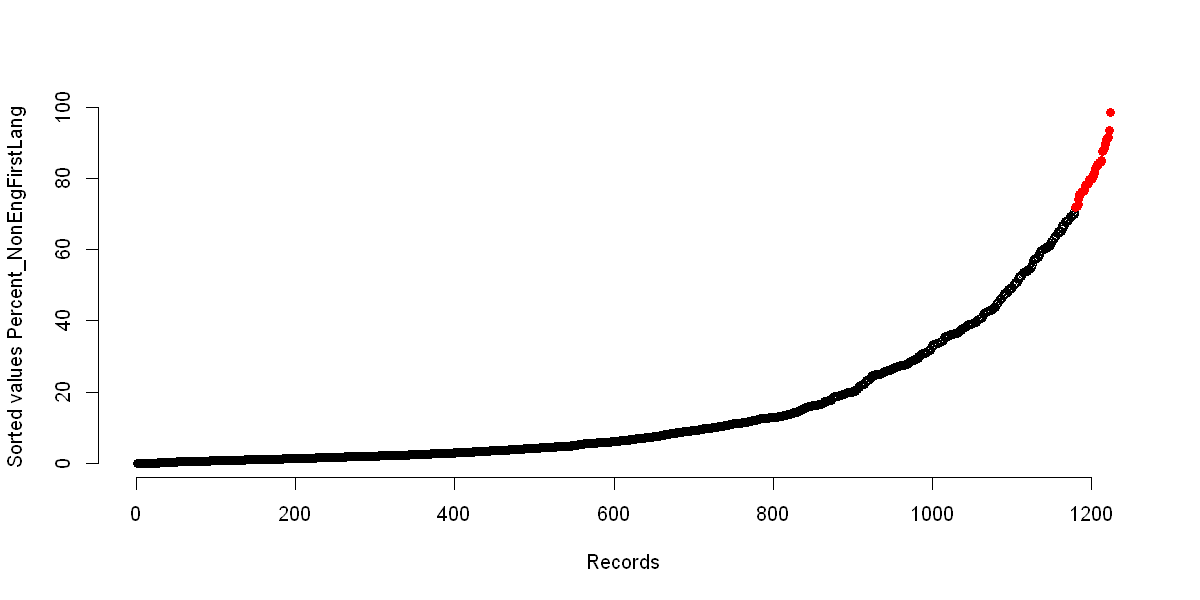

[1] "REPLACED WITH MEAN: Outlier field= Percent_EngFirstLang #Records= 46"


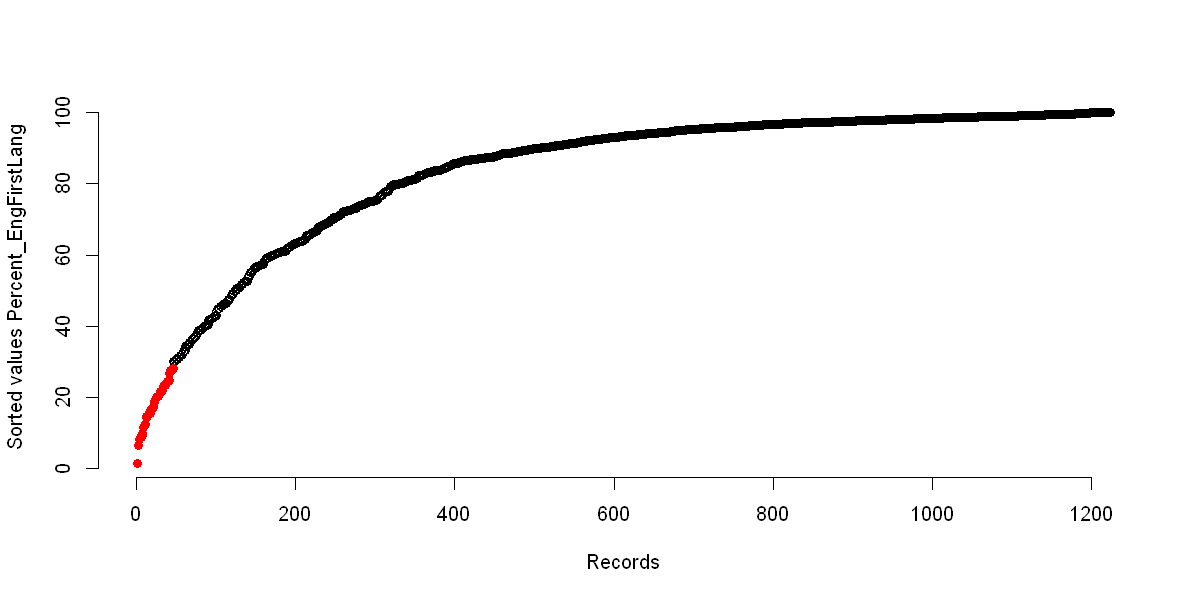

[1] "REPLACED WITH MEAN: Outlier field= Percent_UnclassifiedLang #Records= 25"


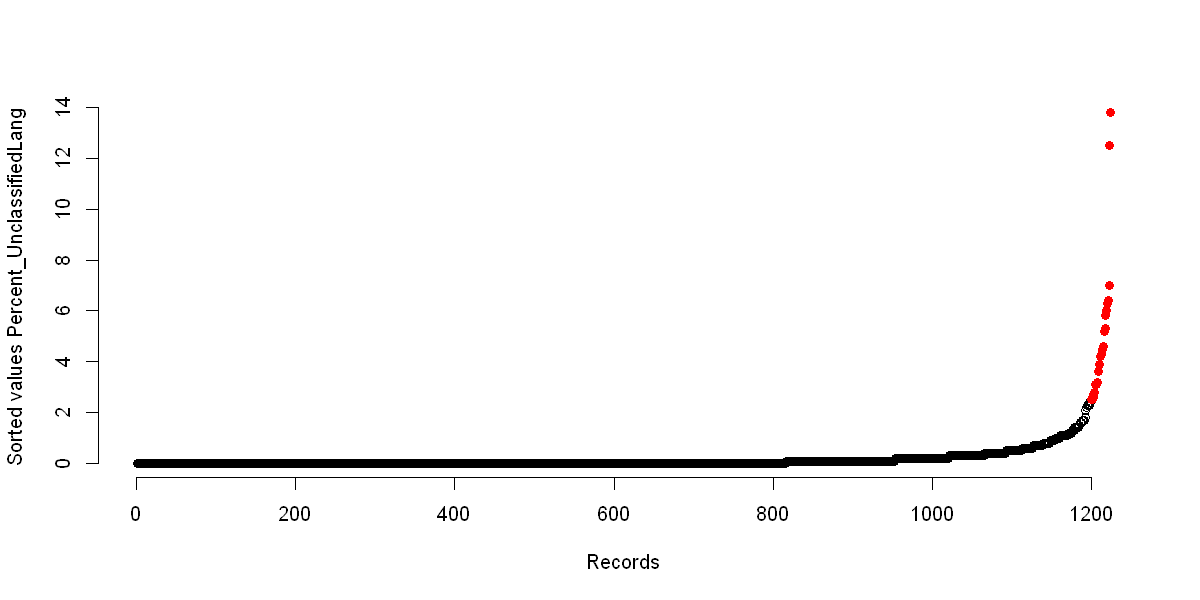

[1] "REPLACED WITH MEAN: Outlier field= Percent_FreeSchoolMealsEver #Records= 19"


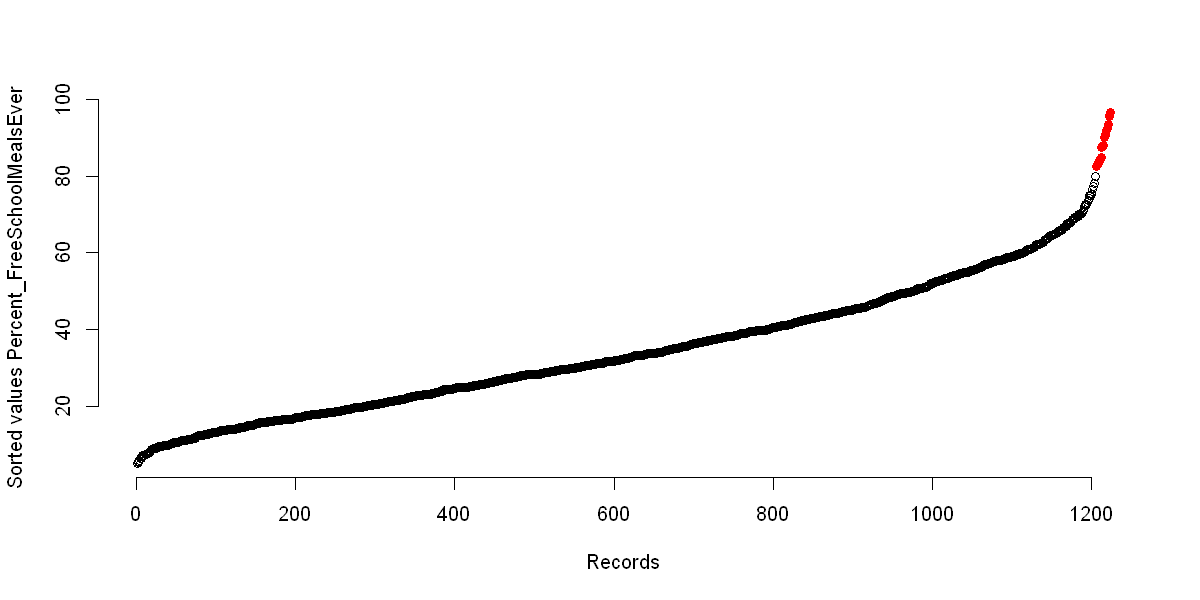

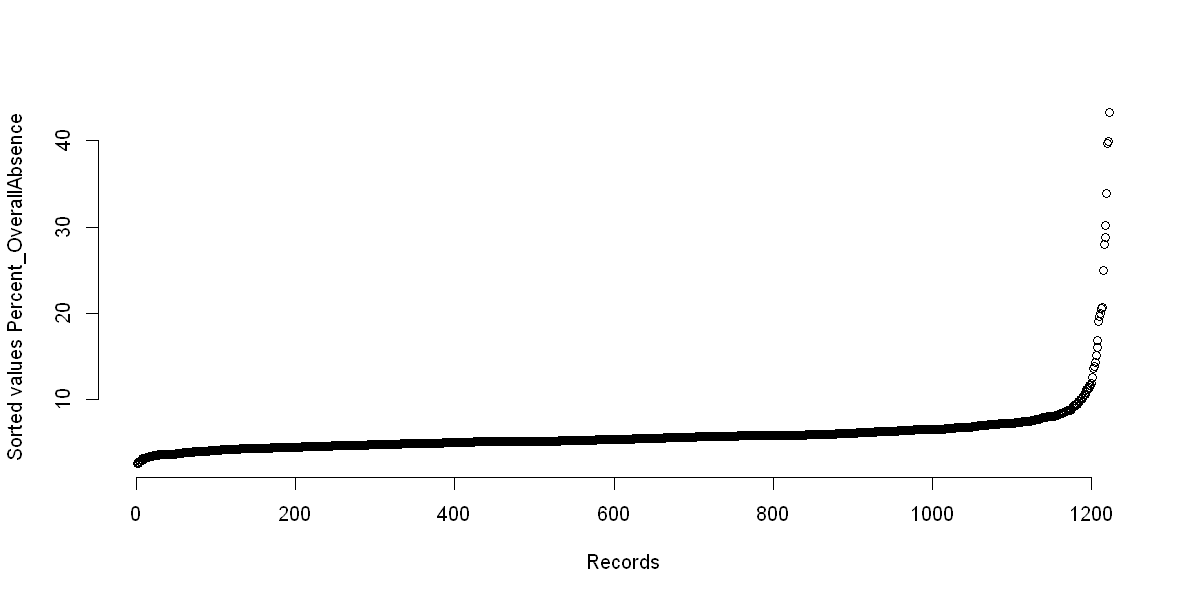

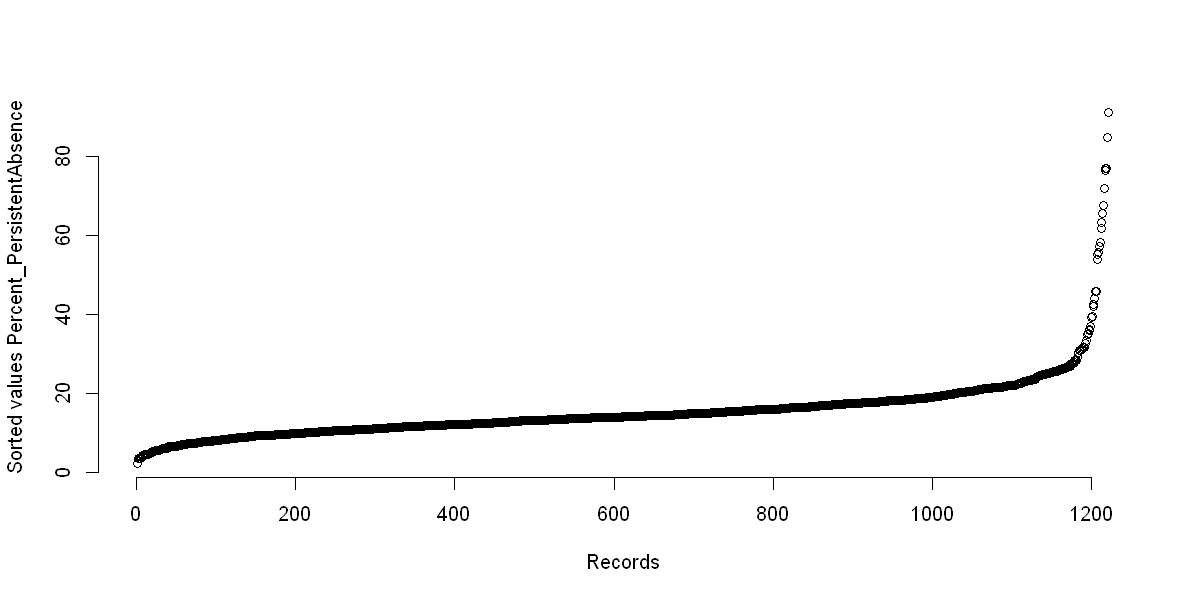

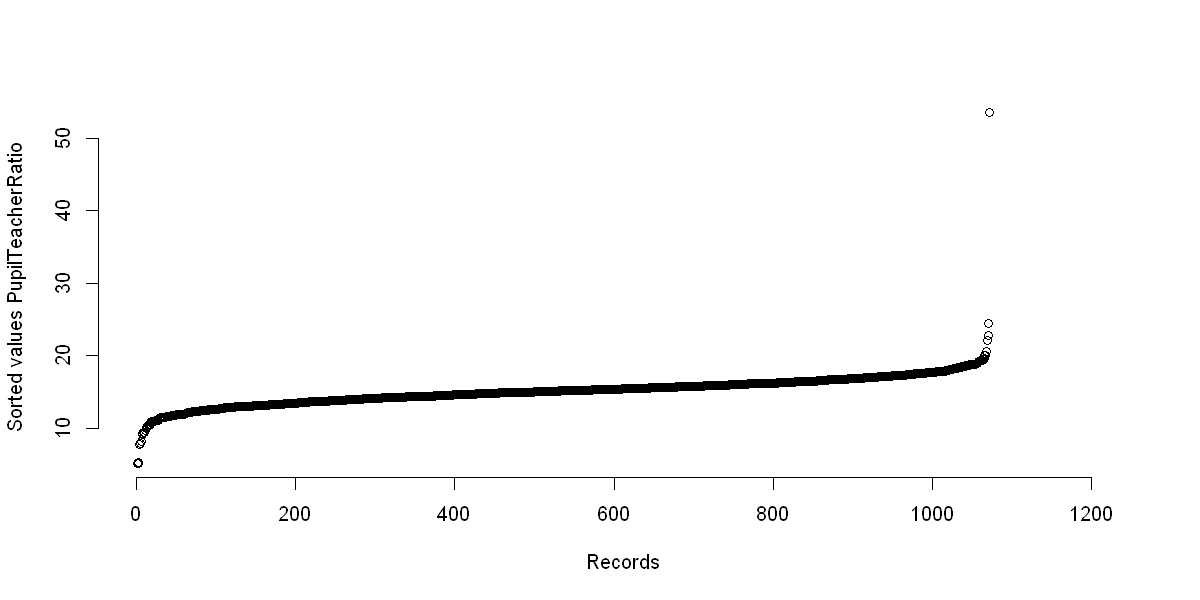

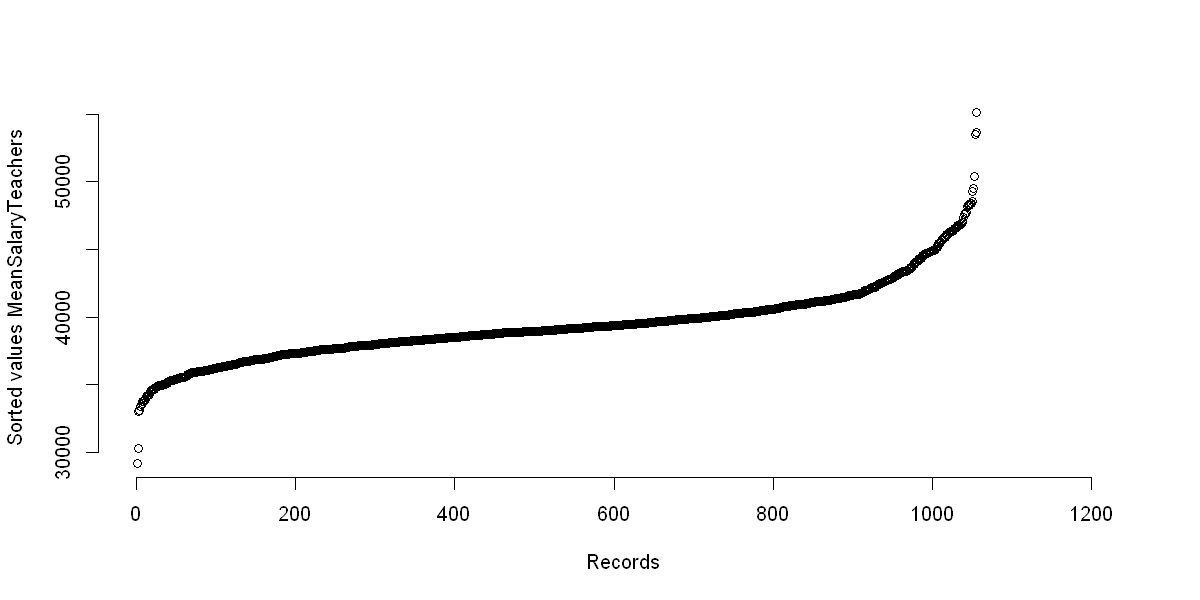

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TotalIncomewithFunding #Records= 32"


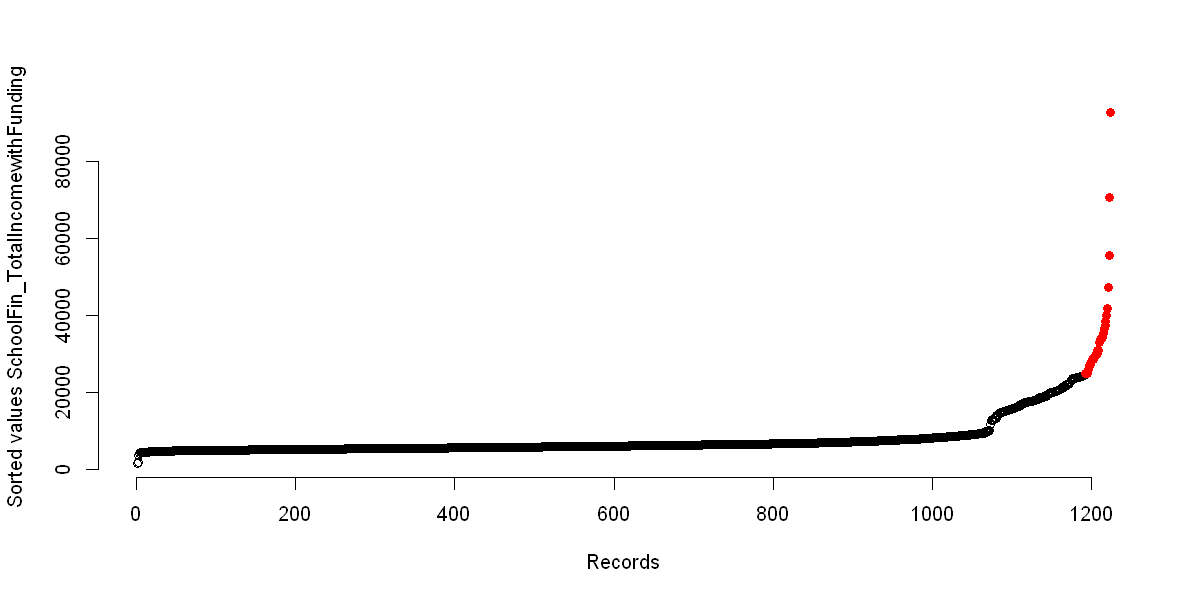

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_ICTLearningResourcesCostPerPupil #Records= 37"


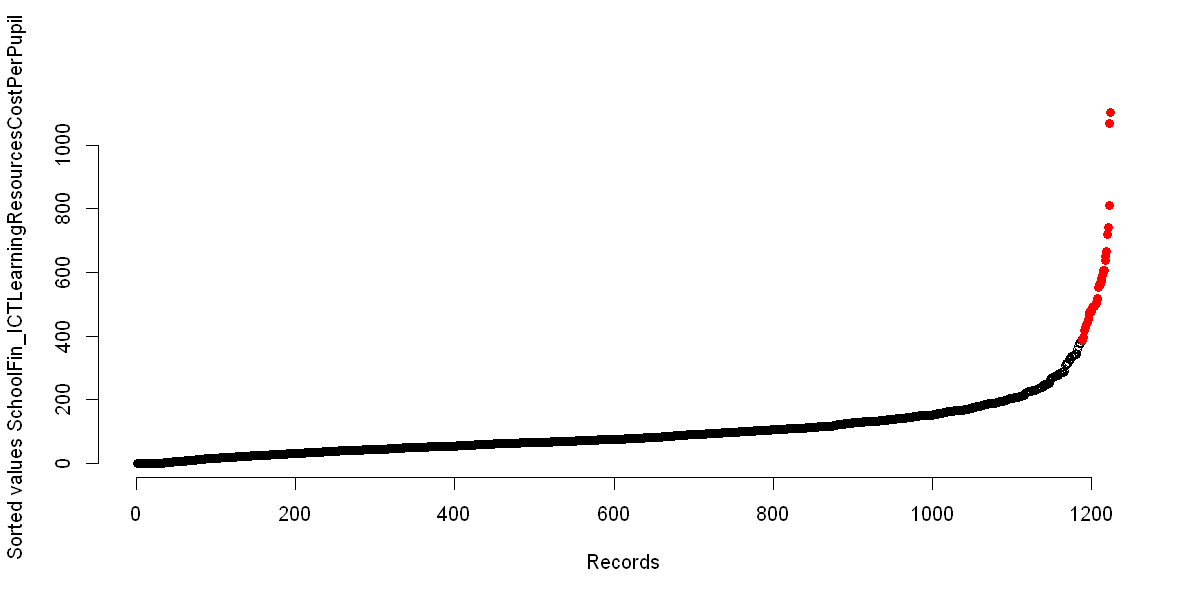

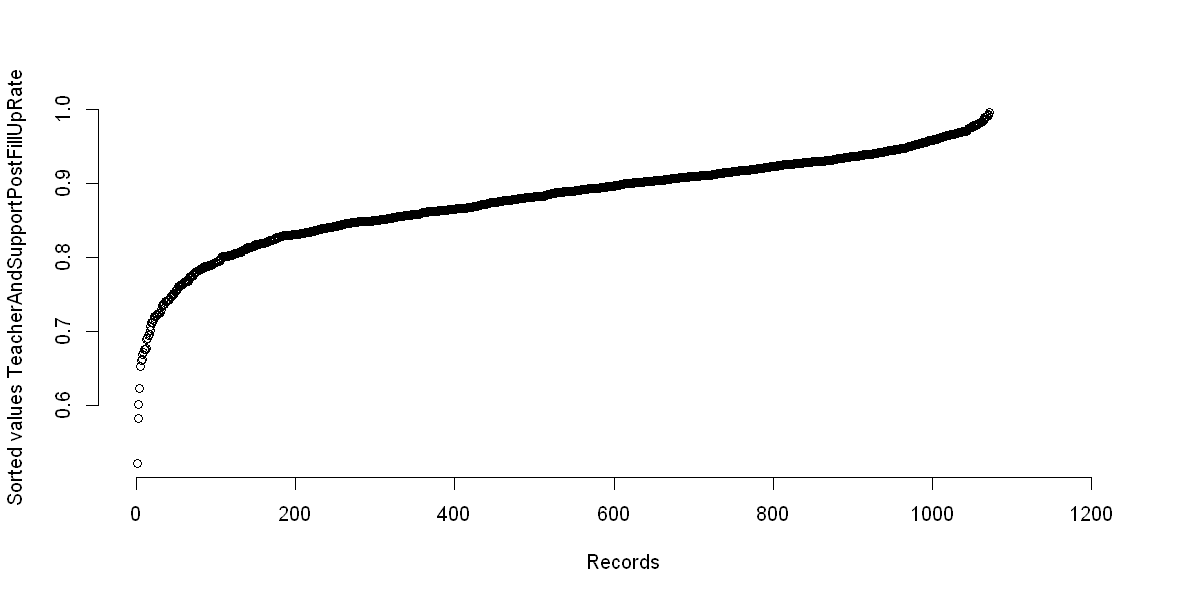

[1] "REPLACED WITH MEAN: Outlier field= TeacherAndSupportStaffCount #Records= 5"


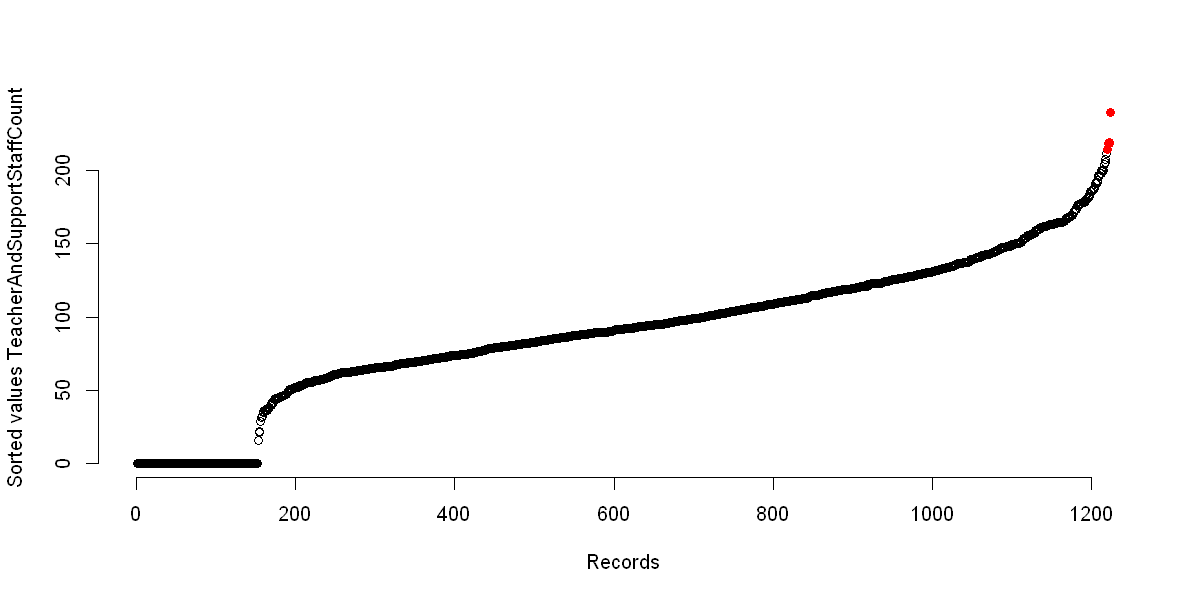

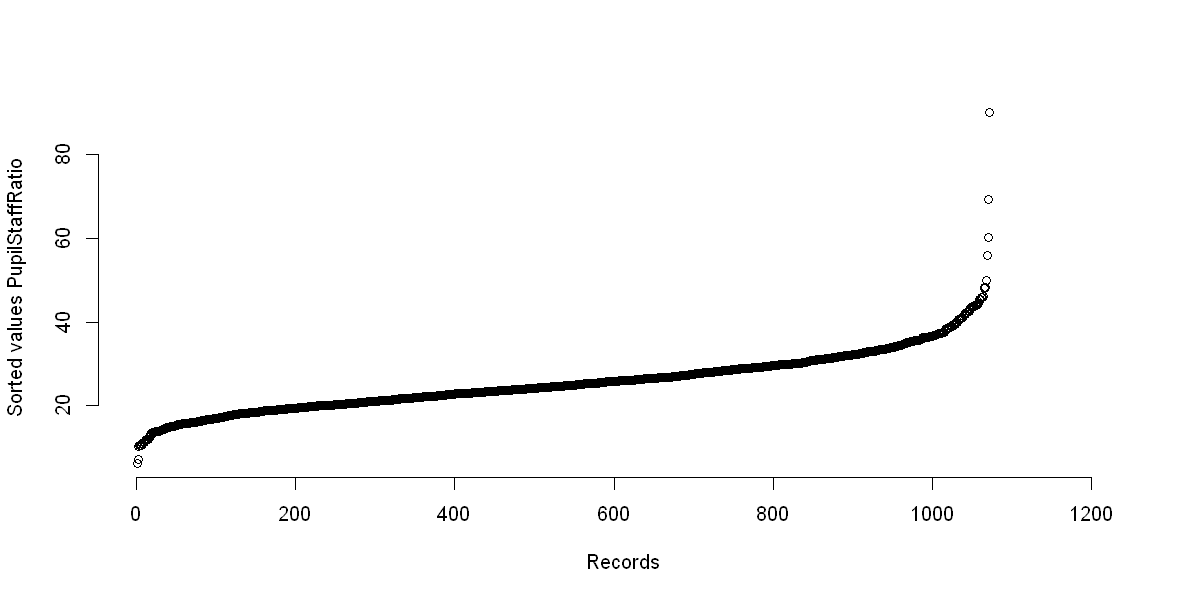

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TeachAndSupportStaffCostPerPupil #Records= 37"


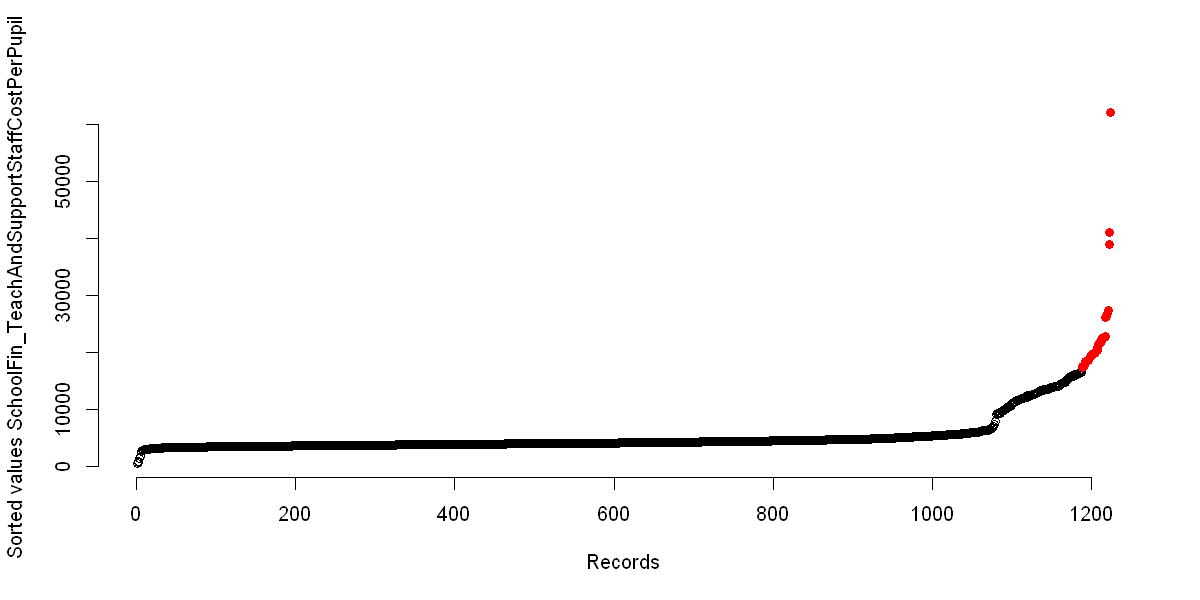

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_NonICTAndEducationServiceCostPerPupil #Records= 31"


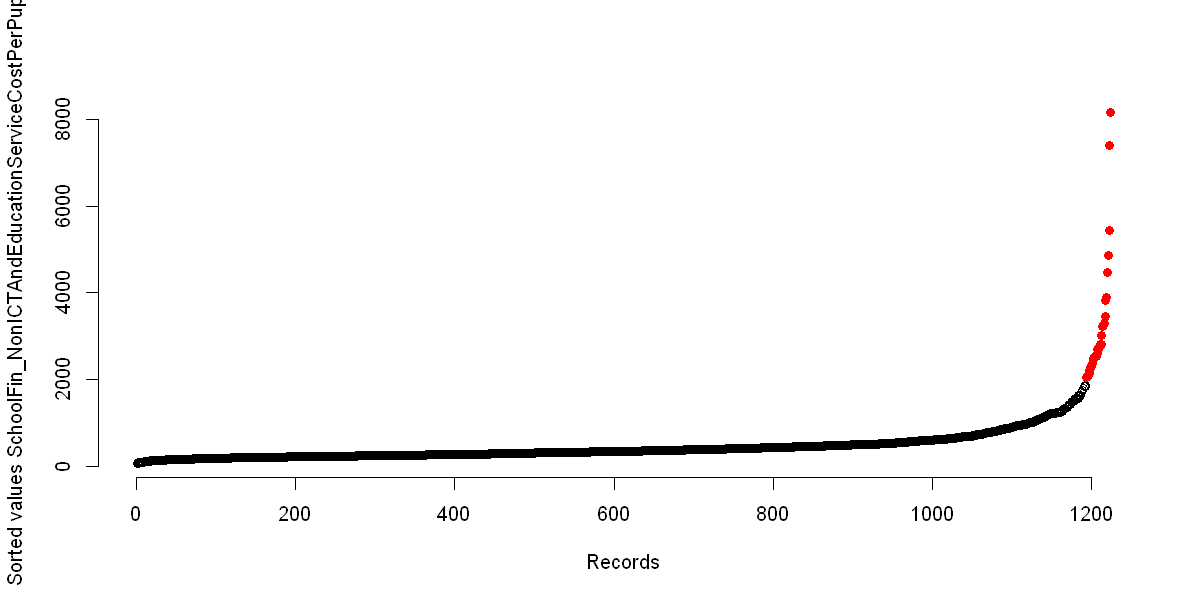

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_MiscCostPerPupil #Records= 30"


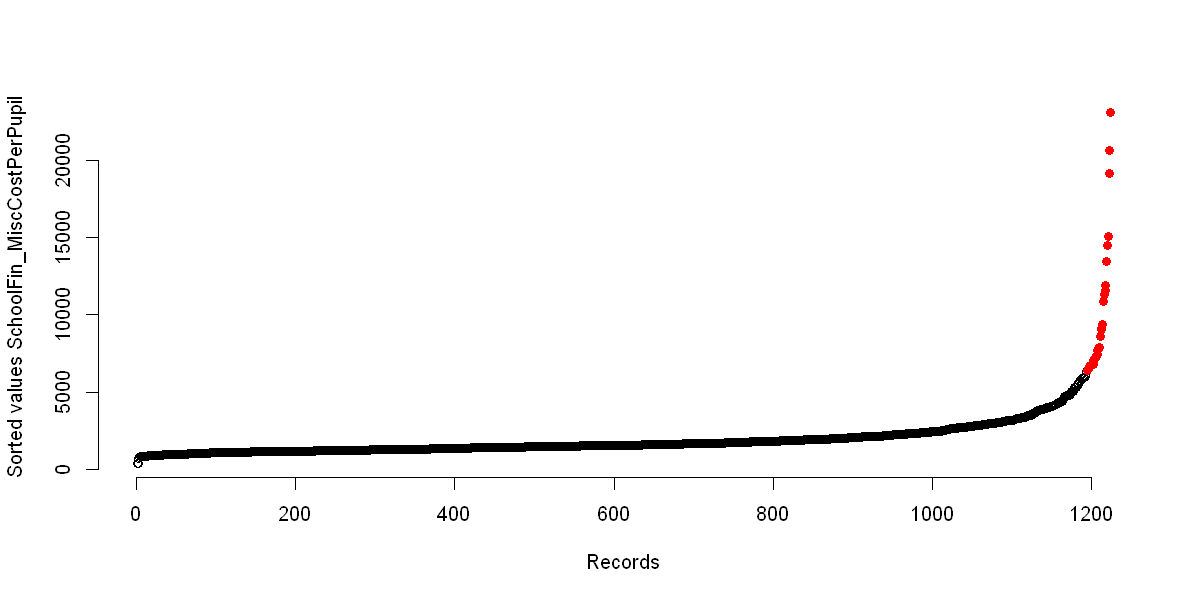

In [200]:
XY_2015_16 <- NPREPROCESSING_outlier(XY_2015_16,
                             XY_col_dict$datatype, 
                             confidence=0.99, 
                             operation="mean")

In [201]:
meanval <- mean(XY_2015_16[XY_2015_16$TeacherAndSupportStaffCount>0, c('TeacherAndSupportStaffCount')])
XY_2015_16[XY_2015_16$TeacherAndSupportStaffCount==0, c('TeacherAndSupportStaffCount')] <- meanval

[1] "REPLACED WITH MEAN: Outlier field= Att8Score_Disadvantaged #Records= 3"


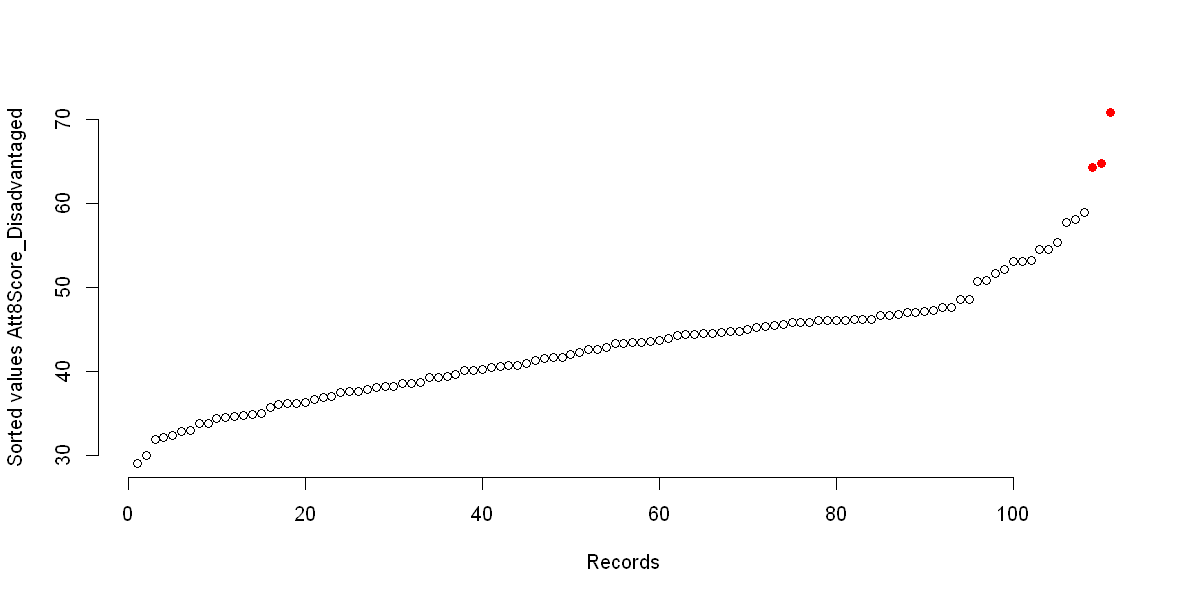

[1] "REPLACED WITH MEAN: Outlier field= Prg8Score_Disadvantaged #Records= 1"


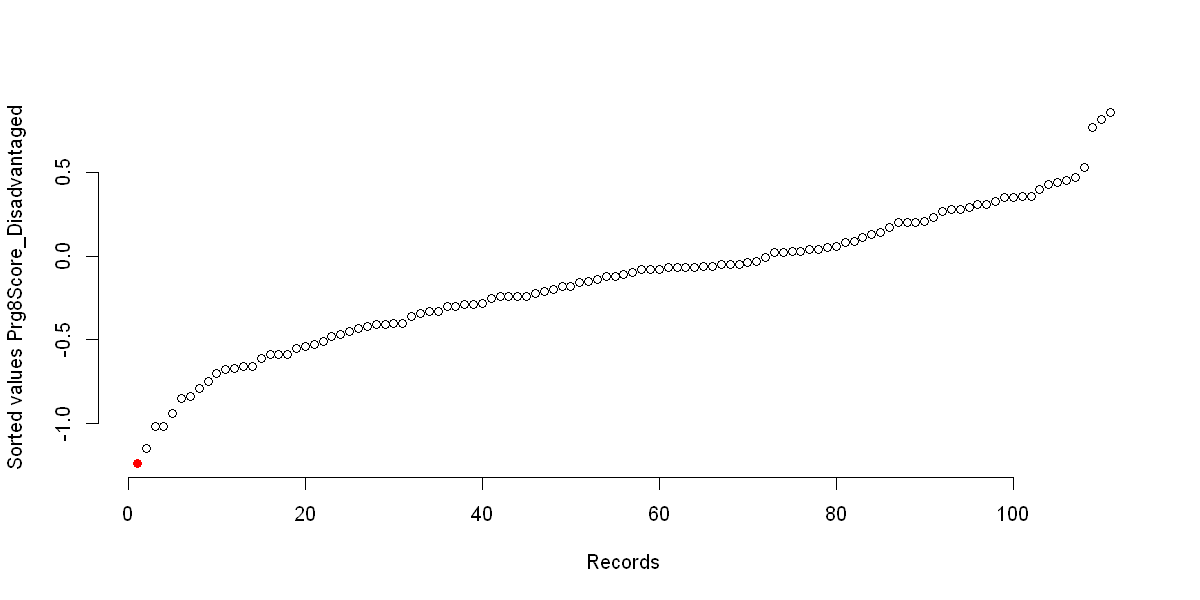

[1] "REPLACED WITH MEAN: Outlier field= TotalPupilsNo #Records= 1"


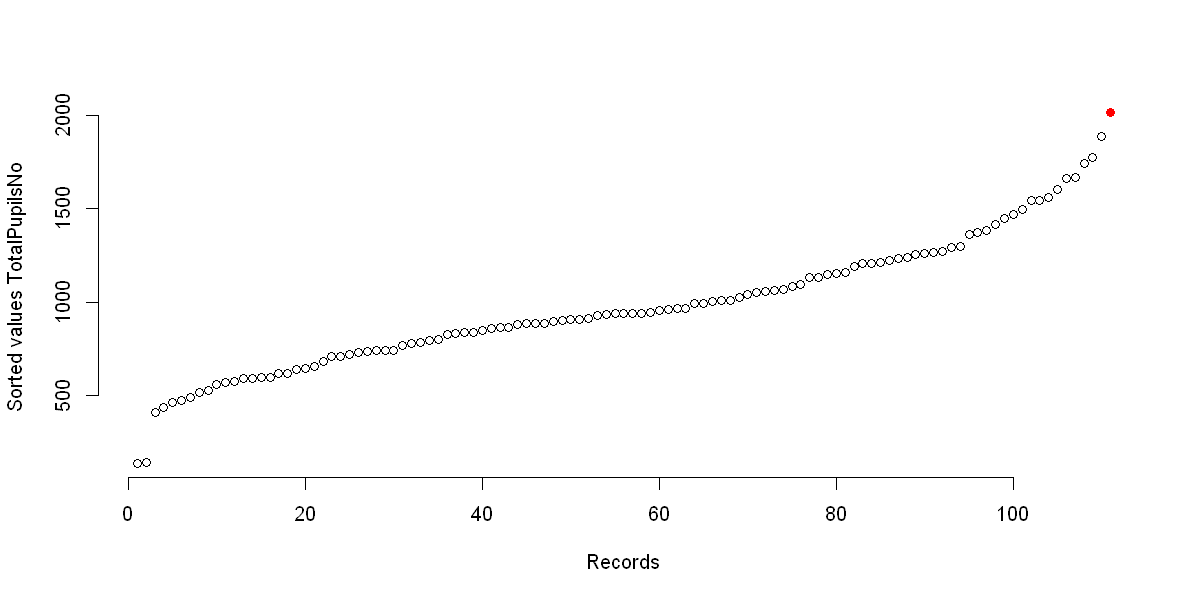

[1] "REPLACED WITH MEAN: Outlier field= Percent_Girls #Records= 9"


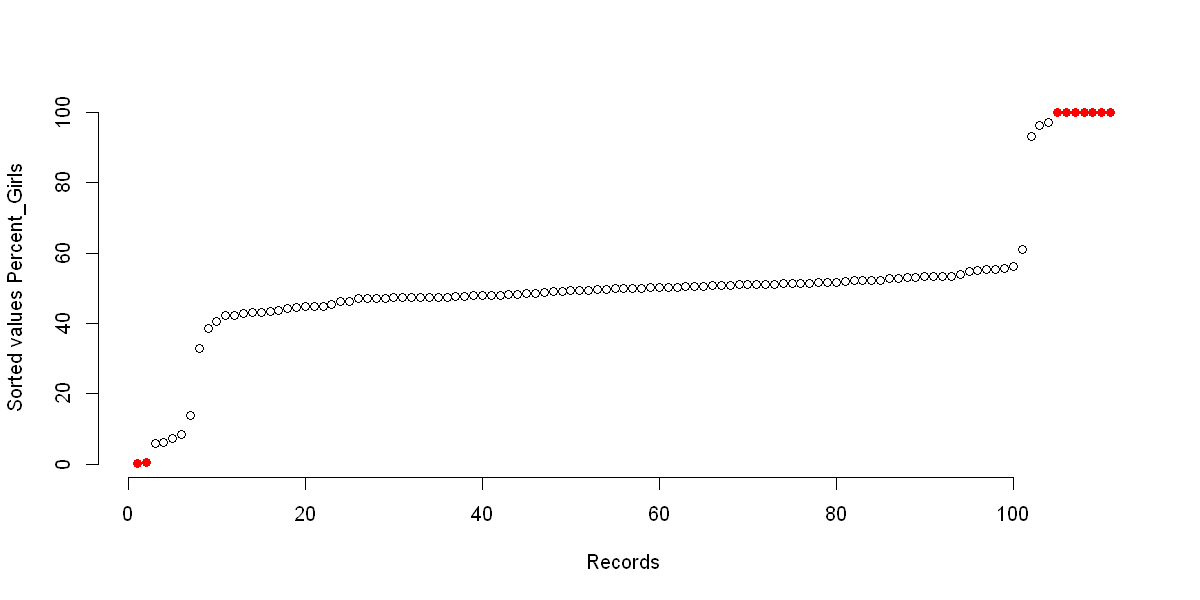

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_EHCPlan #Records= 1"


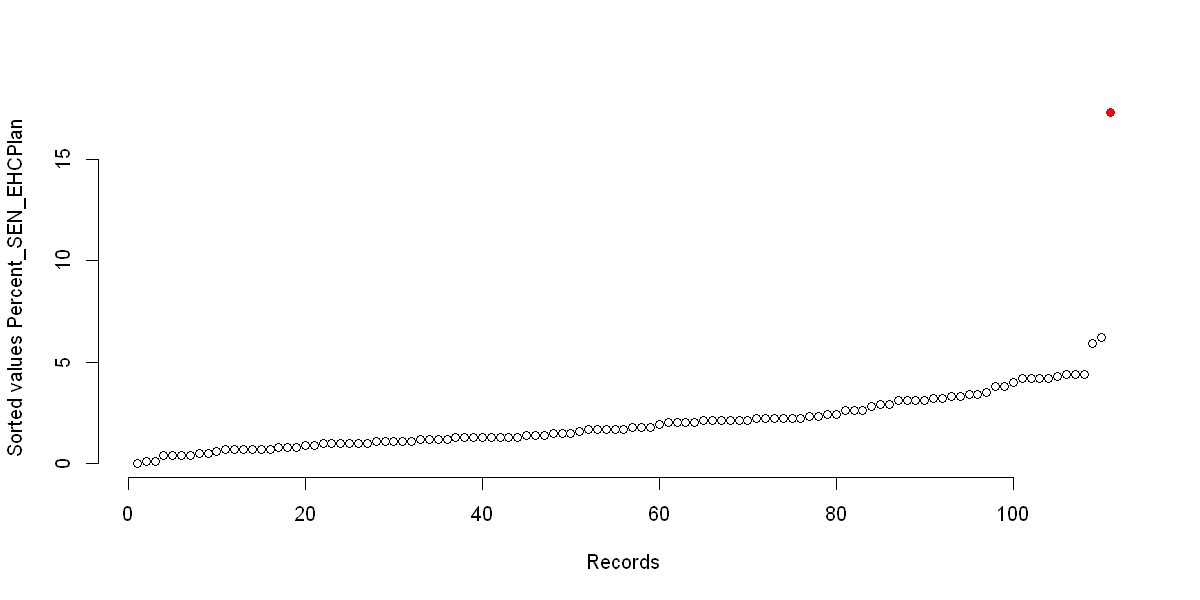

[1] "REPLACED WITH MEAN: Outlier field= Percent_SEN_Support #Records= 2"


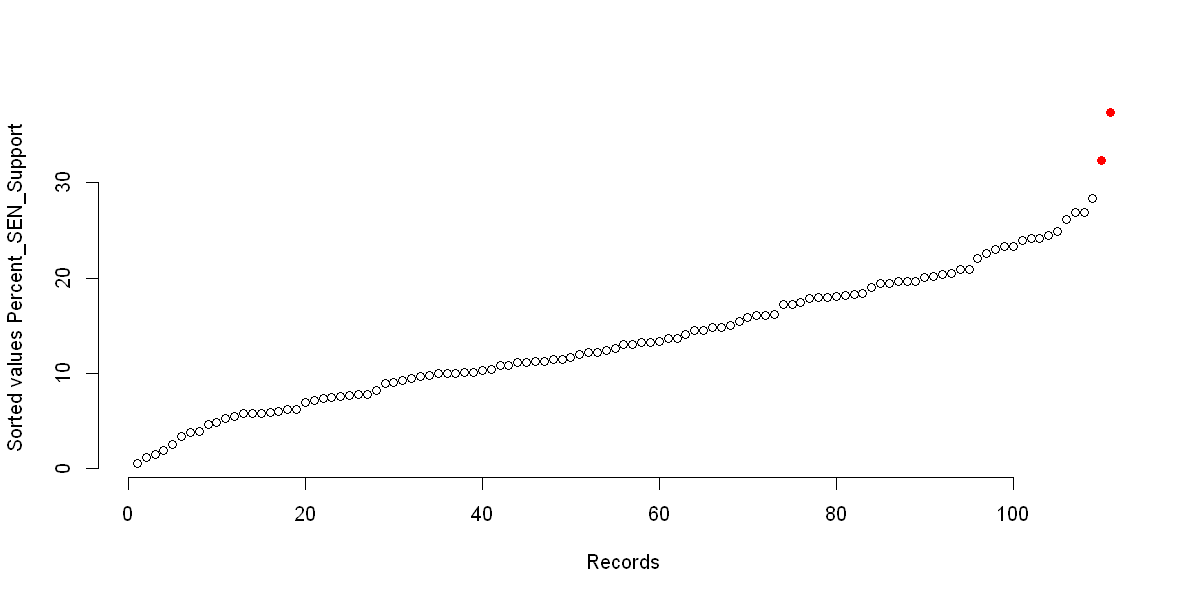

[1] "REPLACED WITH MEAN: Outlier field= Percent_NonEngFirstLang #Records= 3"


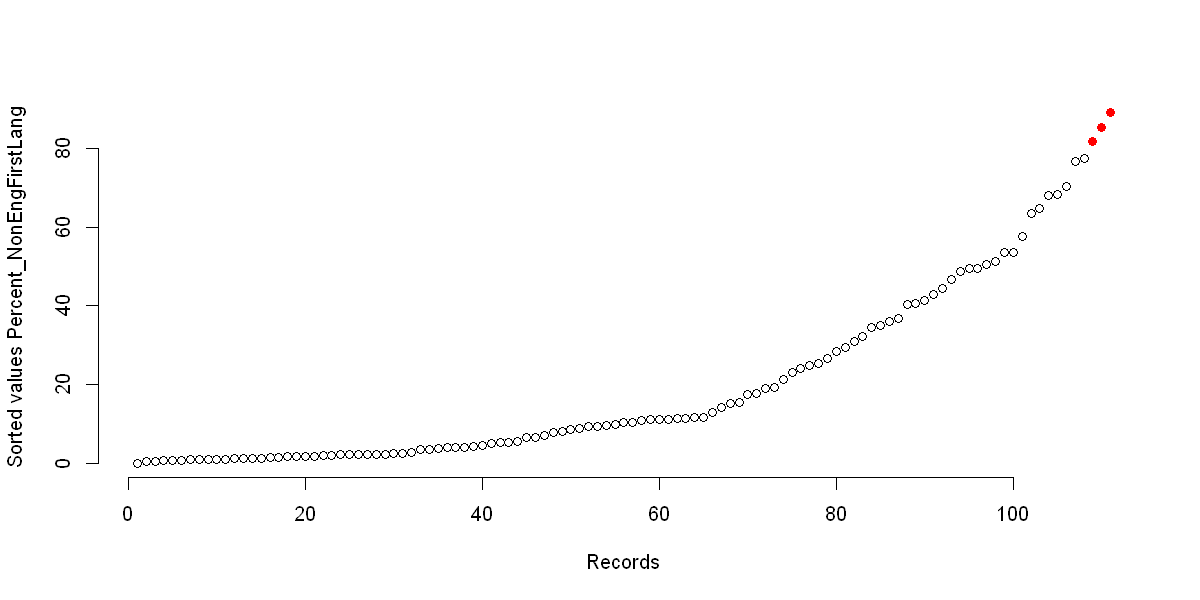

[1] "REPLACED WITH MEAN: Outlier field= Percent_EngFirstLang #Records= 3"


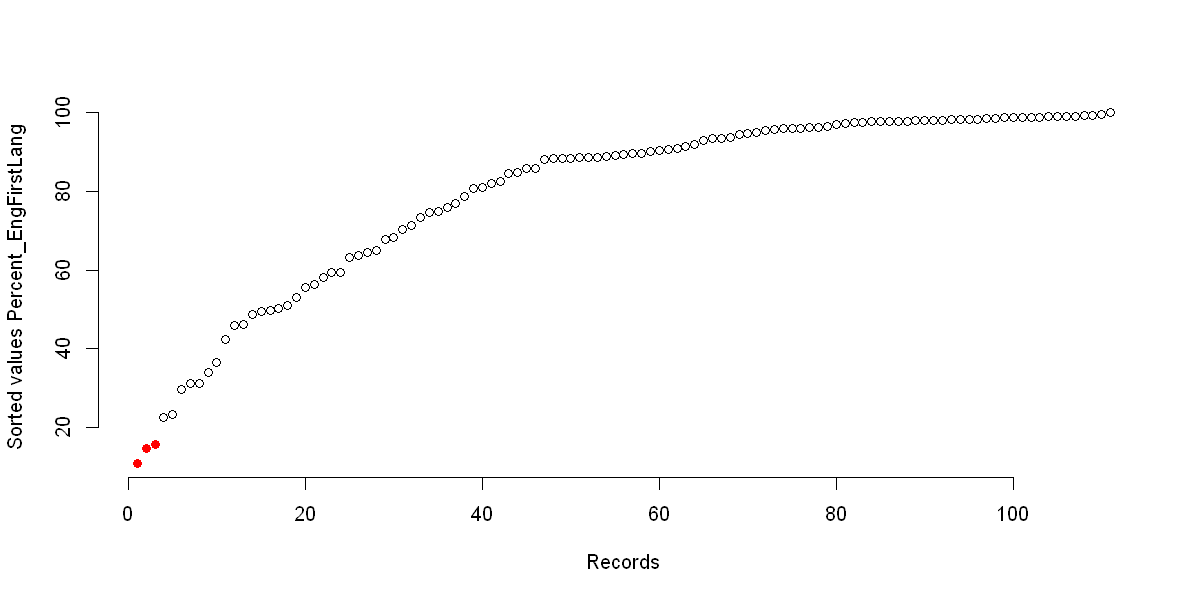

[1] "REPLACED WITH MEAN: Outlier field= Percent_UnclassifiedLang #Records= 2"


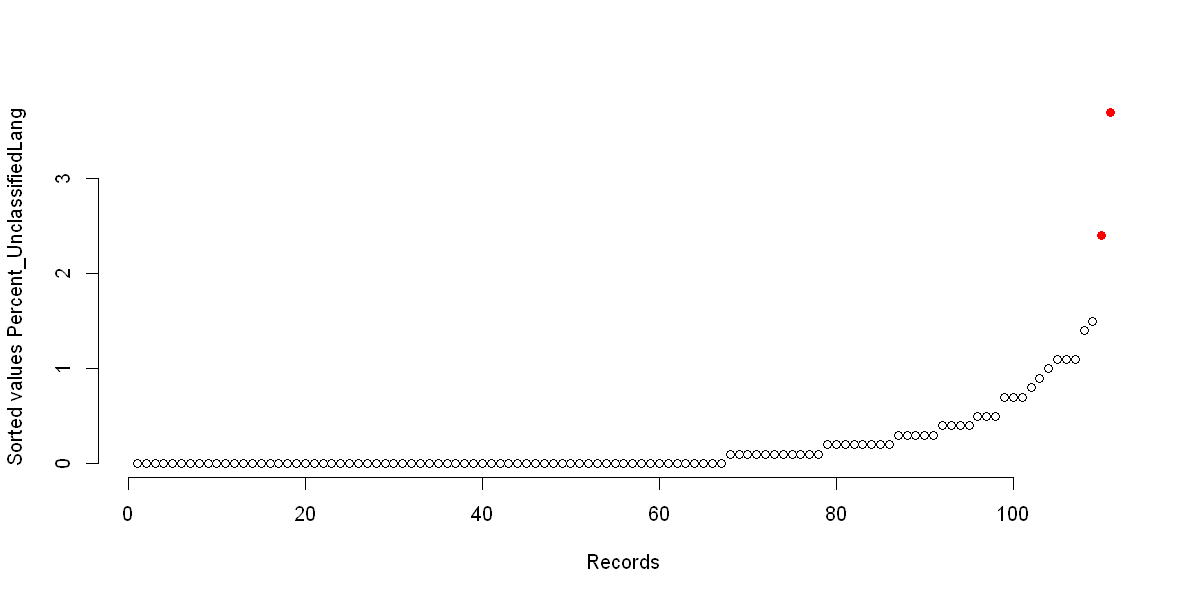

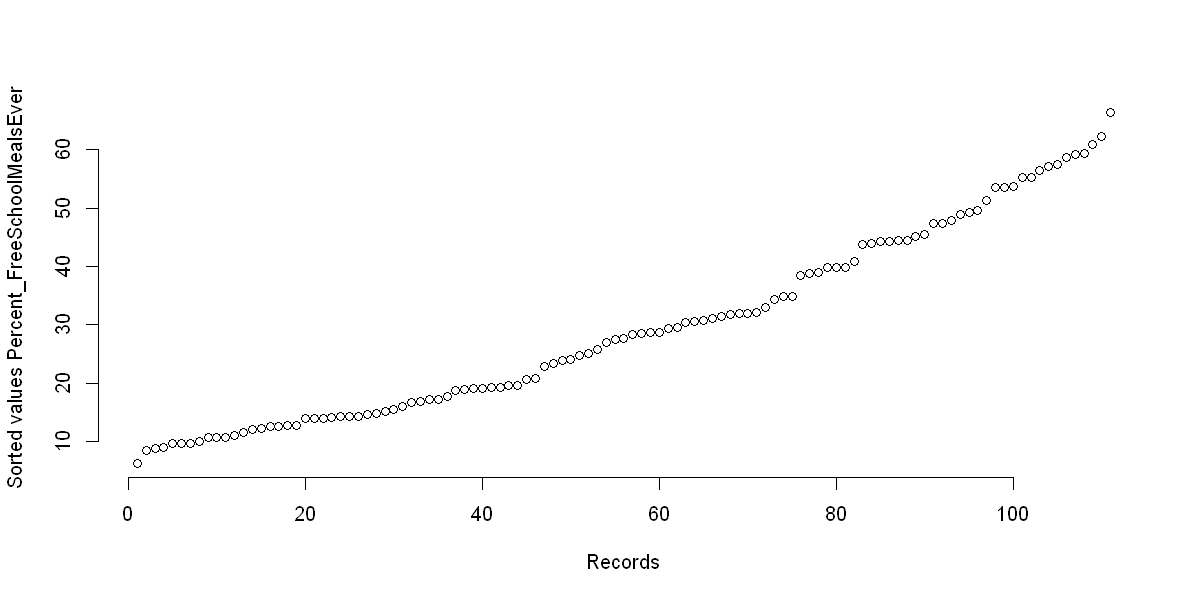

[1] "REPLACED WITH MEAN: Outlier field= Percent_OverallAbsence #Records= 3"


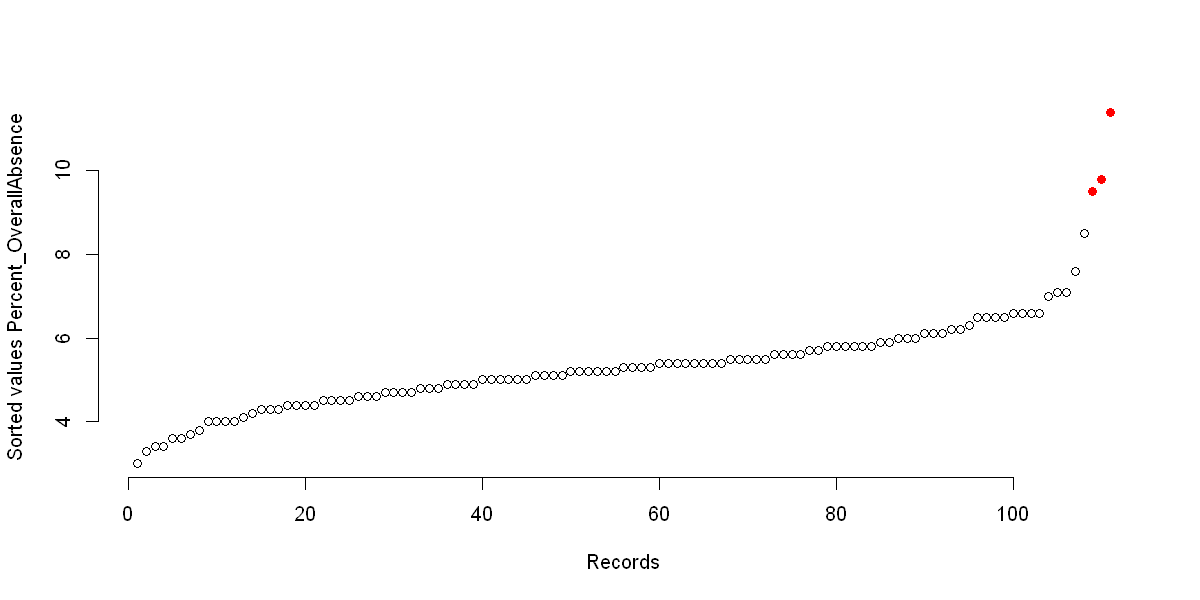

[1] "REPLACED WITH MEAN: Outlier field= Percent_PersistentAbsence #Records= 4"


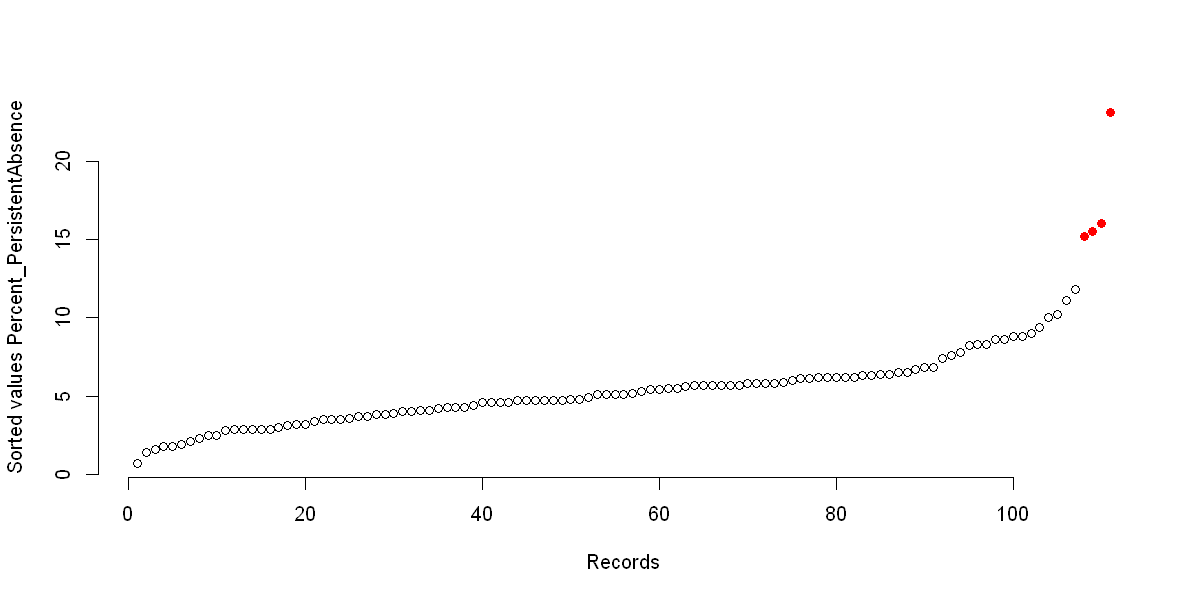

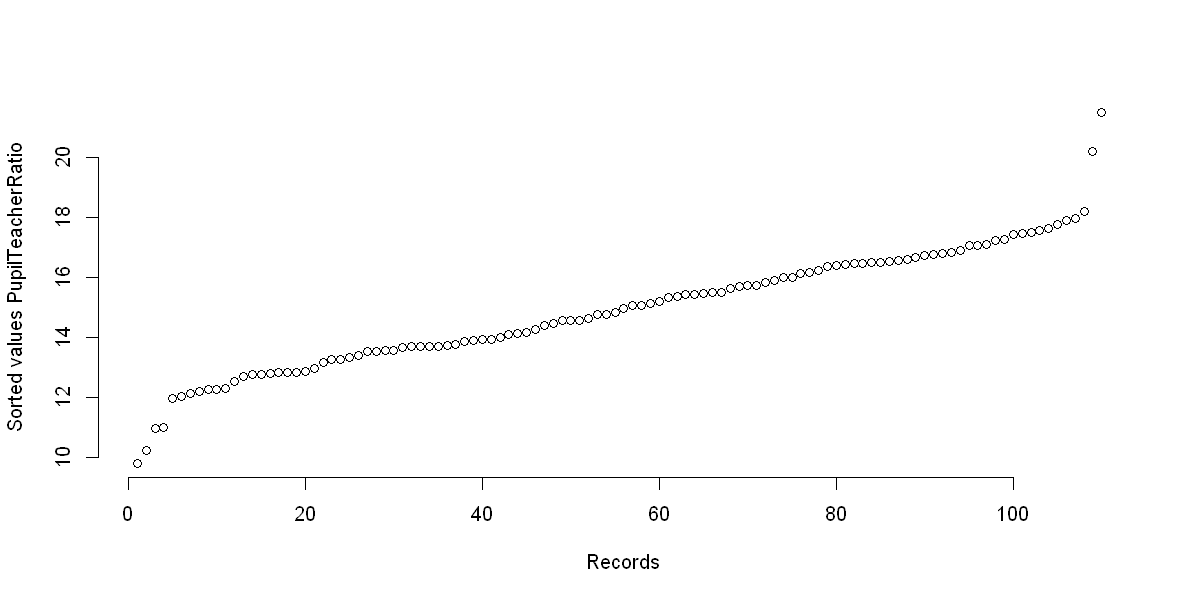

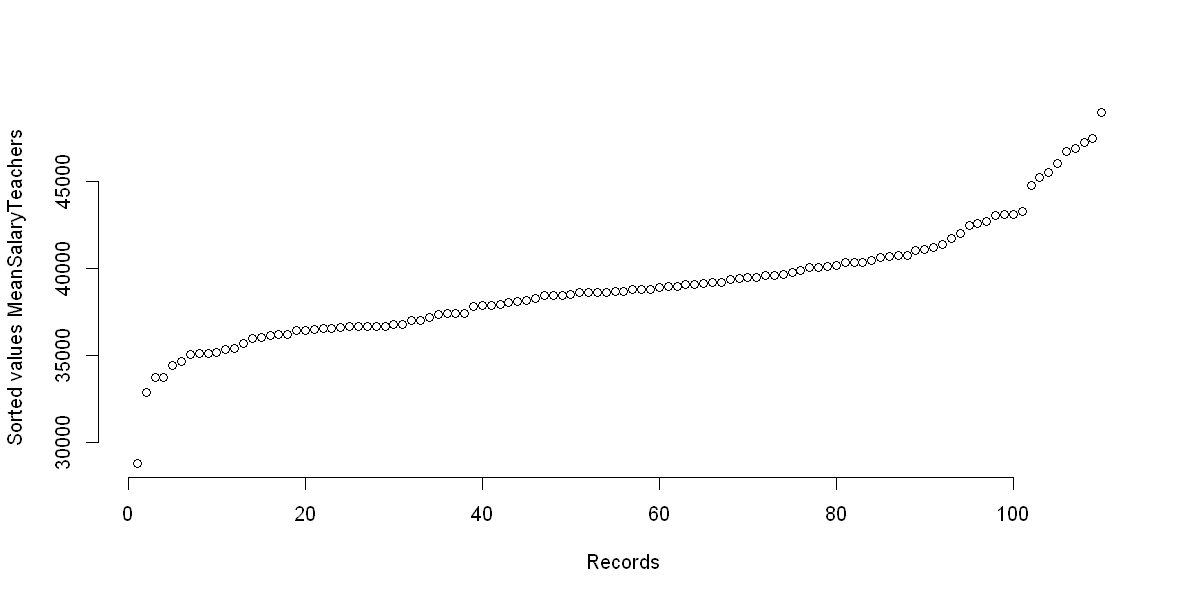

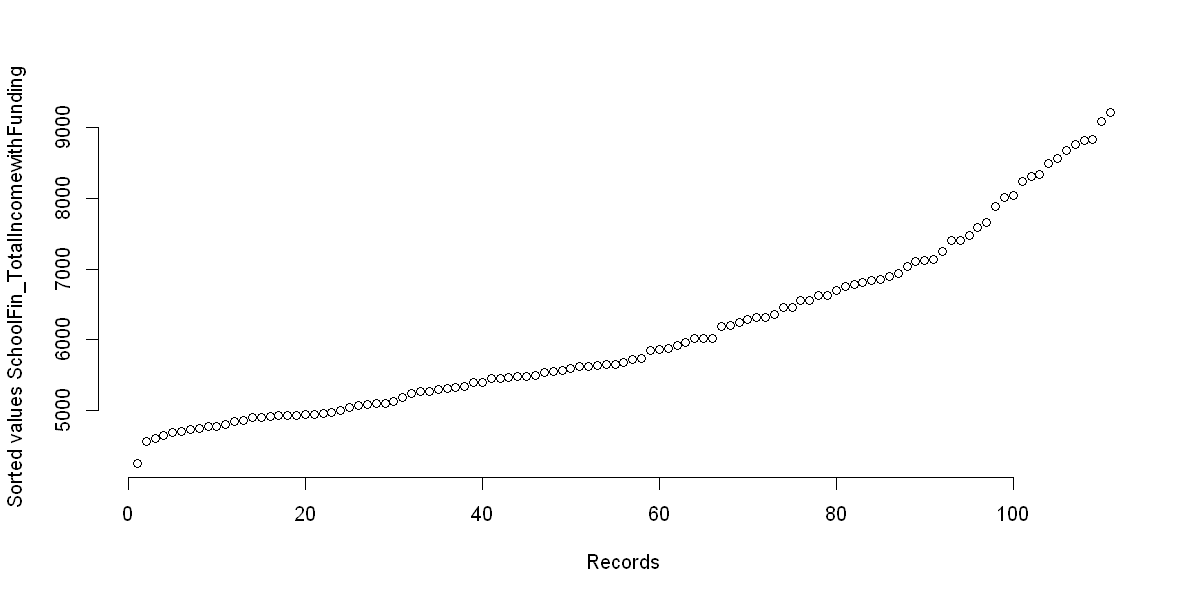

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_ICTLearningResourcesCostPerPupil #Records= 2"


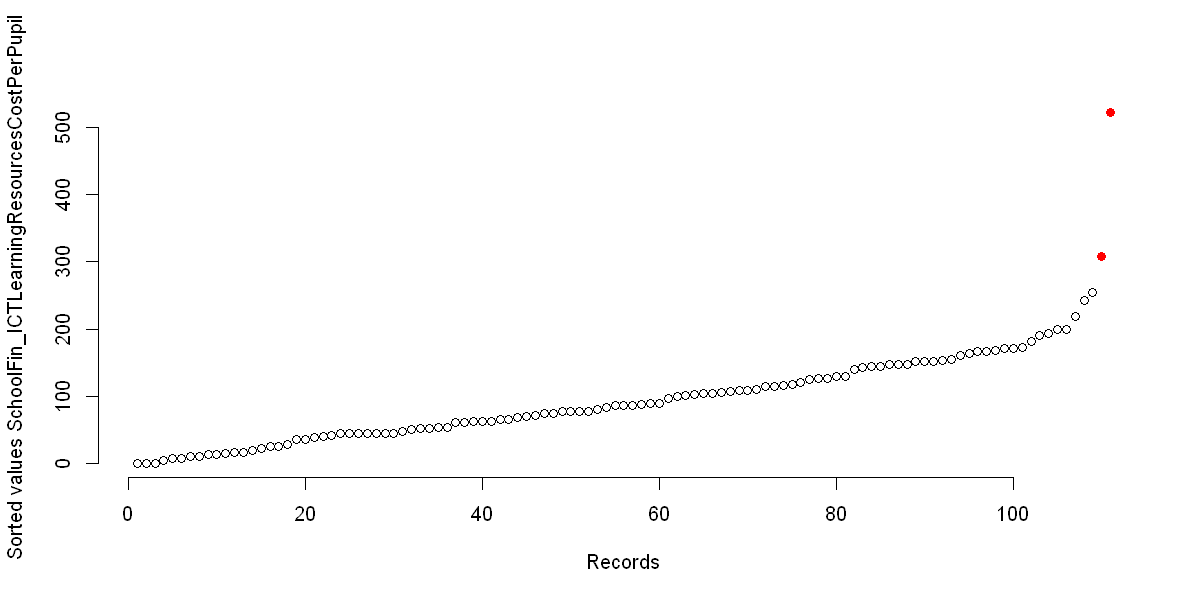

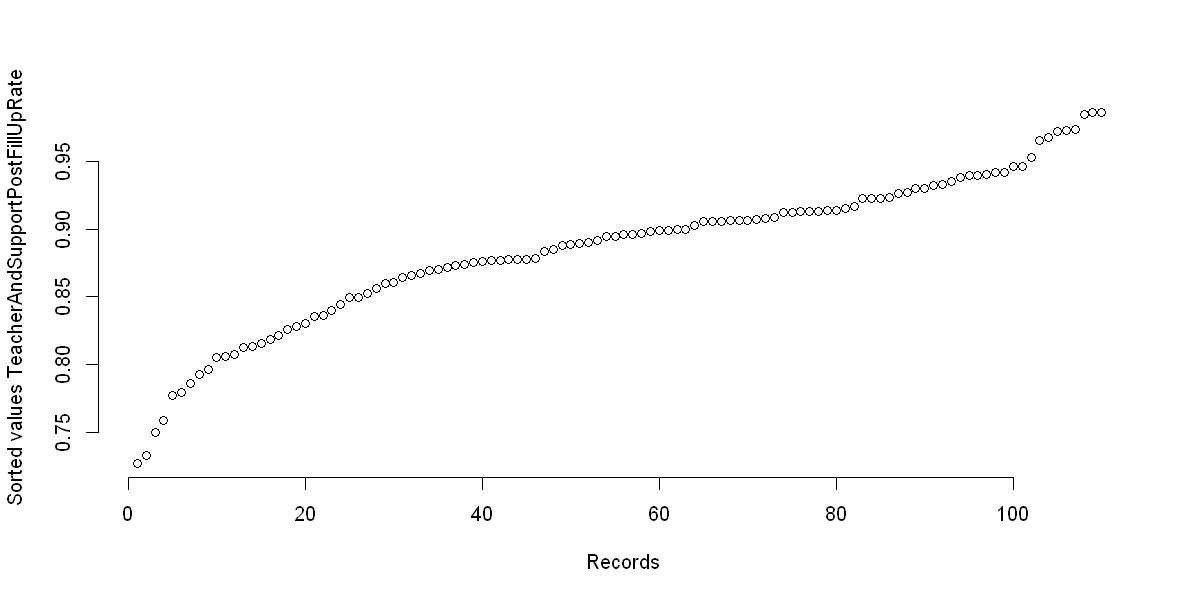

[1] "REPLACED WITH MEAN: Outlier field= TeacherAndSupportStaffCount #Records= 2"


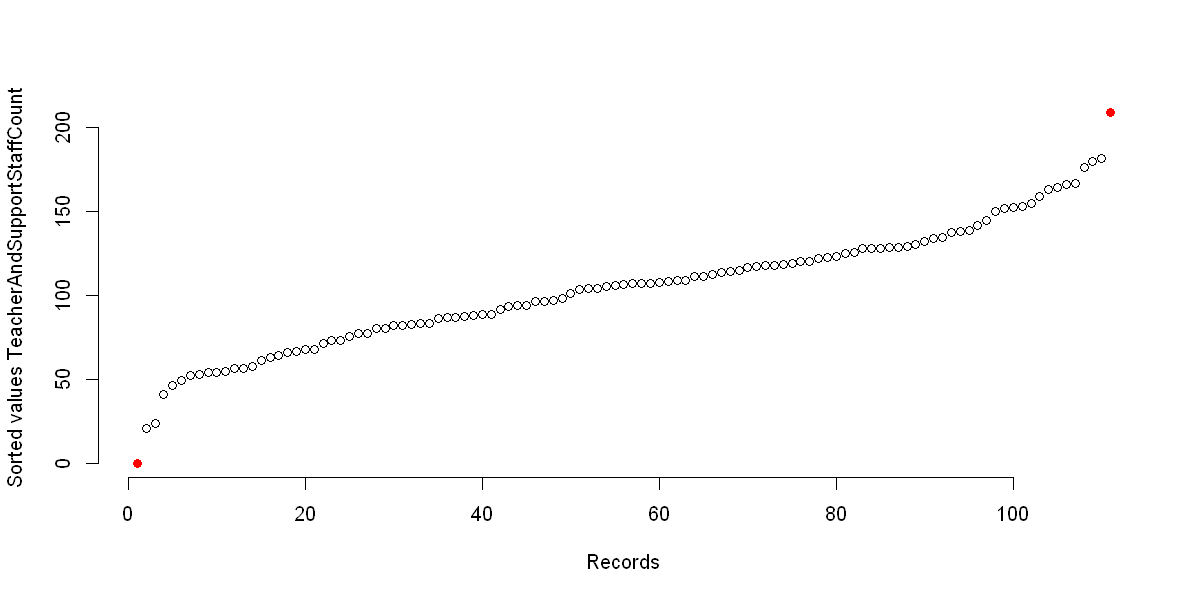

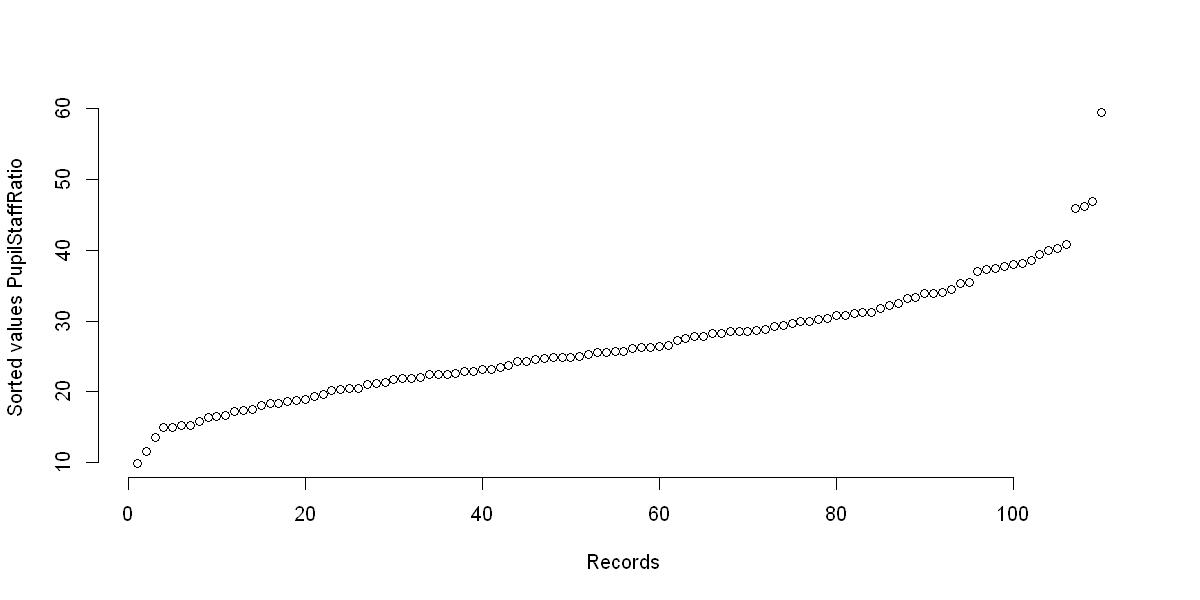

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_TeachAndSupportStaffCostPerPupil #Records= 1"


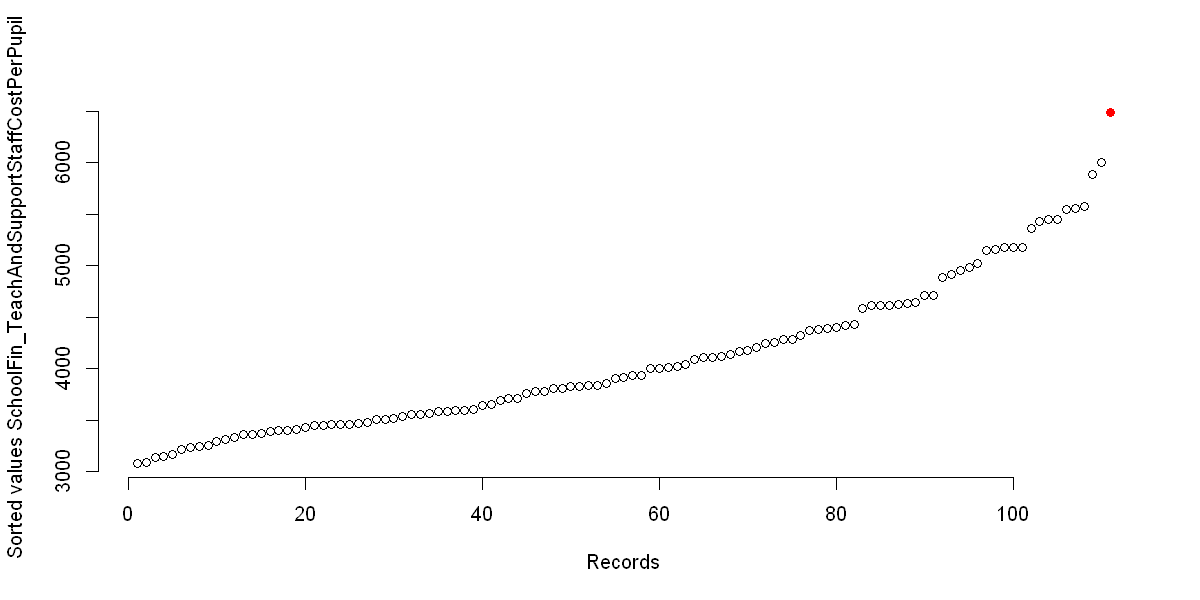

[1] "REPLACED WITH MEAN: Outlier field= SchoolFin_NonICTAndEducationServiceCostPerPupil #Records= 2"


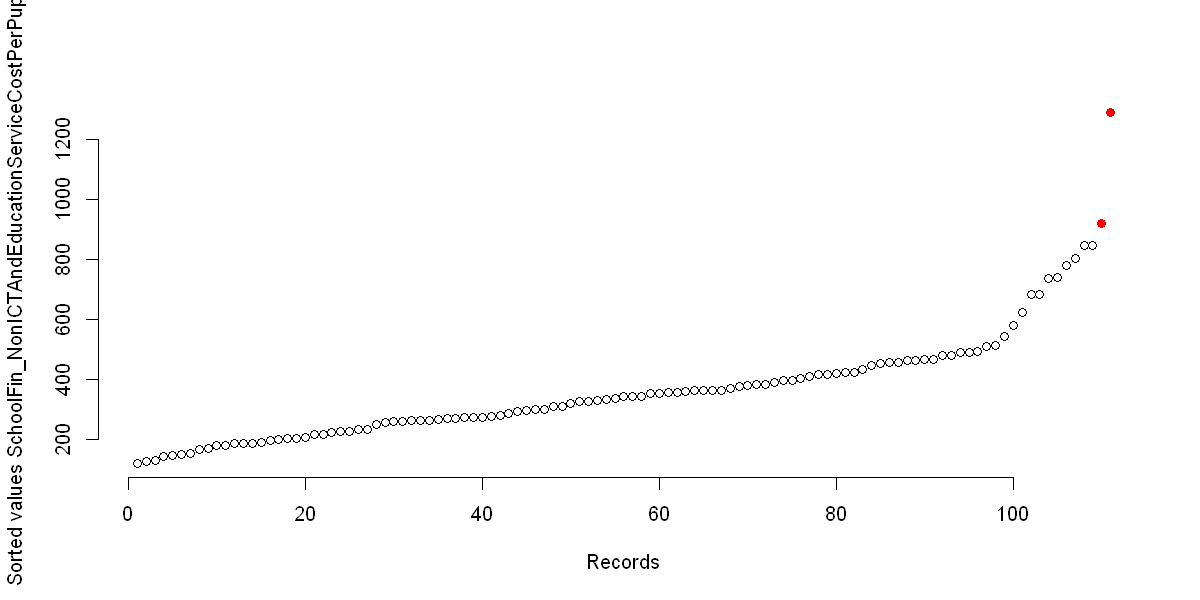

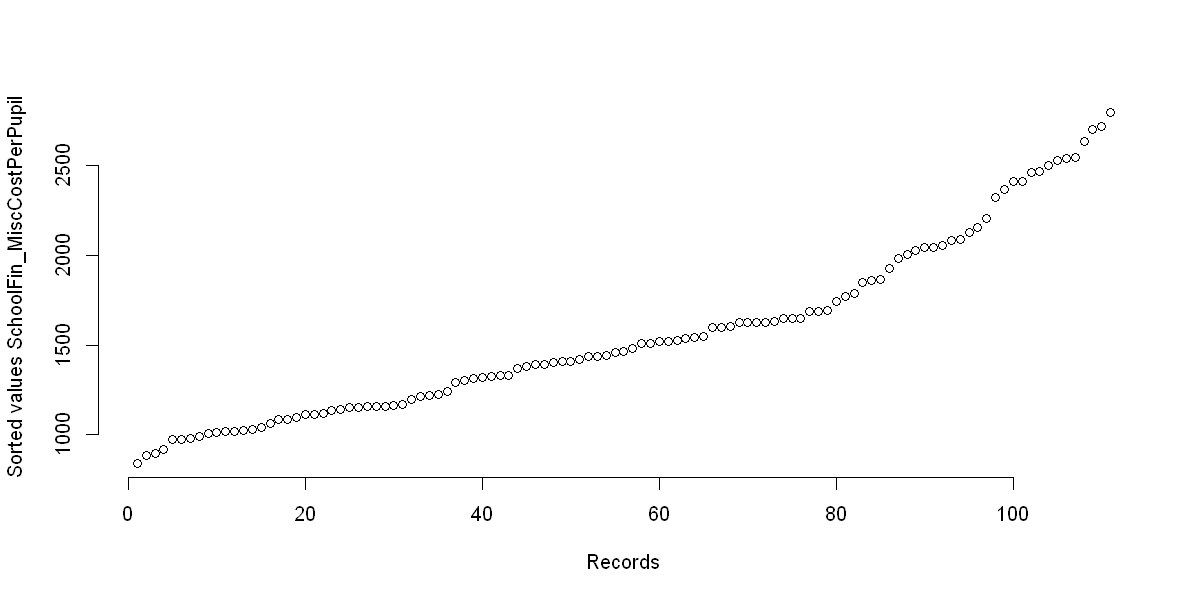

In [202]:
XY_2014_15 <- NPREPROCESSING_outlier(XY_2014_15,
                             XY_col_dict$datatype, 
                             confidence=0.99, 
                             operation="mean")

In [203]:
meanval <- mean(XY_2014_15[XY_2014_15$TeacherAndSupportStaffCount>0, c('TeacherAndSupportStaffCount')])
XY_2014_15[XY_2014_15$TeacherAndSupportStaffCount==0, c('TeacherAndSupportStaffCount')] <- meanval

### 1.8.6 Imputing Missing/NA Values with Mean for Ordinal Columns 

In [204]:
# Impute missing/NA/Infinite values by the means of each fields 
XY_2018_19 <- ImputeMean(XY_2018_19)
XY_2017_18 <- ImputeMean(XY_2017_18)
XY_2016_17 <- ImputeMean(XY_2016_17)
XY_2015_16 <- ImputeMean(XY_2015_16)
XY_2014_15 <- ImputeMean(XY_2014_15)




### 1.8.7 Cleaning Columns with Categorical Variables

In [205]:
# The categorical variables are:
# SCHOOLTYPE
# SchoolReligion
# AdmissionPolicy
# Ofsted_Rating

catvar <- c('SCHOOLTYPE','SchoolReligion','AdmissionPolicy','Ofsted_Rating')

result <- GetInvalidValuesSummary(XY_2018_19[,catvar], names(XY_2018_19[,catvar])) 
t(result)

result <- GetInvalidValuesSummary(XY_2017_18[,catvar], names(XY_2017_18[,catvar])) 
t(result)

result <- GetInvalidValuesSummary(XY_2016_17[,catvar], names(XY_2016_17[,catvar])) 
t(result)

result <- GetInvalidValuesSummary(XY_2015_16[,catvar], names(XY_2015_16[,catvar])) 
t(result)

result <- GetInvalidValuesSummary(XY_2014_15[,catvar], names(XY_2014_15[,catvar])) 
t(result)

[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

[,1]        [,2]          
Type            is_na(%)    is_infinite(%)
SCHOOLTYPE      56 ( 5.7 %) 0 ( 0 %)      
SchoolReligion  56 ( 5.7 %) 0 ( 0 %)      
AdmissionPolicy 56 ( 5.7 %) 0 ( 0 %)      
Ofsted_Rating   56 ( 5.7 %) 0 ( 0 %)

[,1]          [,2]          
Type            is_na(%)      is_infinite(%)
SCHOOLTYPE      170 ( 15.5 %) 0 ( 0 %)      
SchoolReligion  170 ( 15.5 %) 0 ( 0 %)      
AdmissionPolicy 170 ( 15.5 %) 0 ( 0 %)      
Ofsted_Rating   170 ( 15.5 %) 0 ( 0 %)

[,1]        [,2]          
Type            is_na(%)    is_infinite(%)
SCHOOLTYPE      281 ( 23 %) 0 ( 0 %)      
SchoolReligion  281 ( 23 %) 0 ( 0 %)      
AdmissionPolicy 281 ( 23 %) 0 ( 0 %)      
Ofsted_Rating   281 ( 23 %) 0 ( 0 %)

[,1]         [,2]          
Type            is_na(%)     is_infinite(%)
SCHOOLTYPE      25 ( 22.5 %) 0 ( 0 %)      
SchoolReligion  25 ( 22.5 %) 0 ( 0 %)      
AdmissionPolicy 25 ( 22.5 %) 0 ( 0 %)      
Ofsted_Rating   25 ( 22.5 %) 0 ( 0 %)

In [206]:
# We consistently found a number of missing values (NA) in the categorical variables in 2017_18 back to 2014_15.  These are those 
# failed to be identified in the 2018-19_england_school_information.csv file, which is only available since 2018_19.
# Thus, to ensure we are analysing the same set of schools across multiple years, we exclude such schools from the analysis.

XY_2017_18 <- XY_2017_18[!is.na(XY_2017_18$AdmissionPolicy), ]
XY_2016_17 <- XY_2016_17[!is.na(XY_2016_17$AdmissionPolicy), ]
XY_2015_16 <- XY_2015_16[!is.na(XY_2015_16$AdmissionPolicy), ]
XY_2014_15 <- XY_2014_15[!is.na(XY_2014_15$AdmissionPolicy), ]




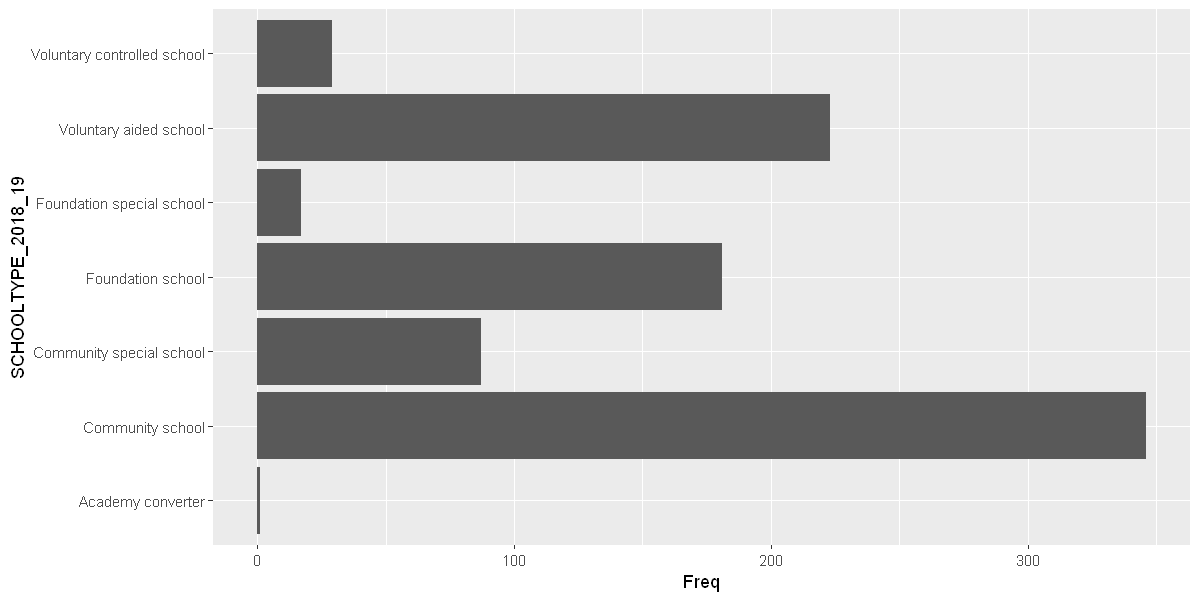

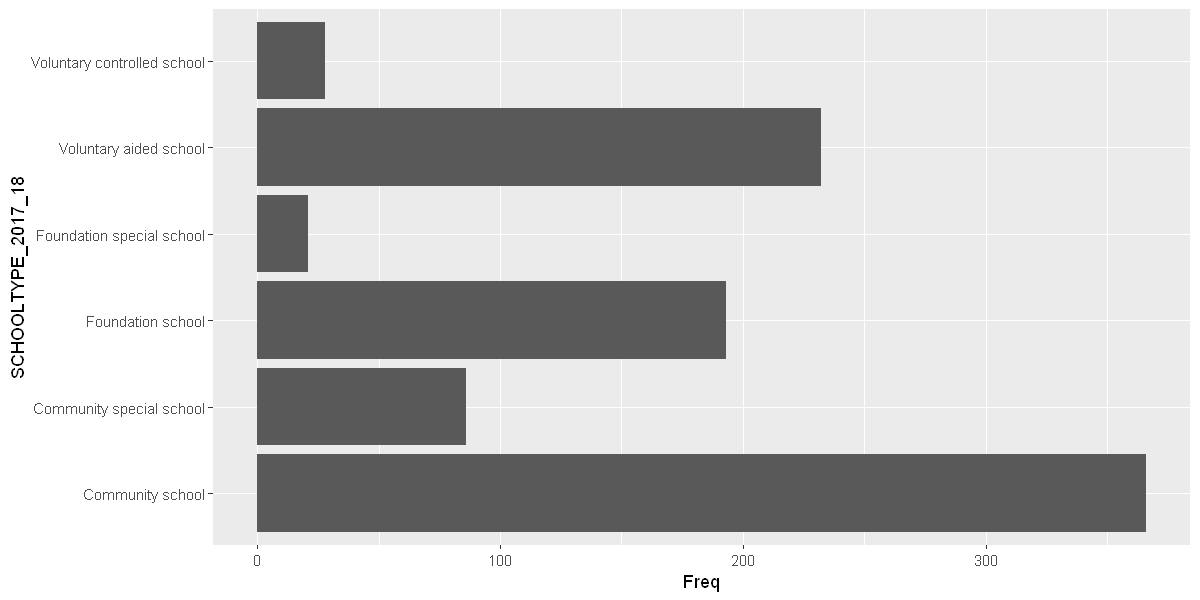

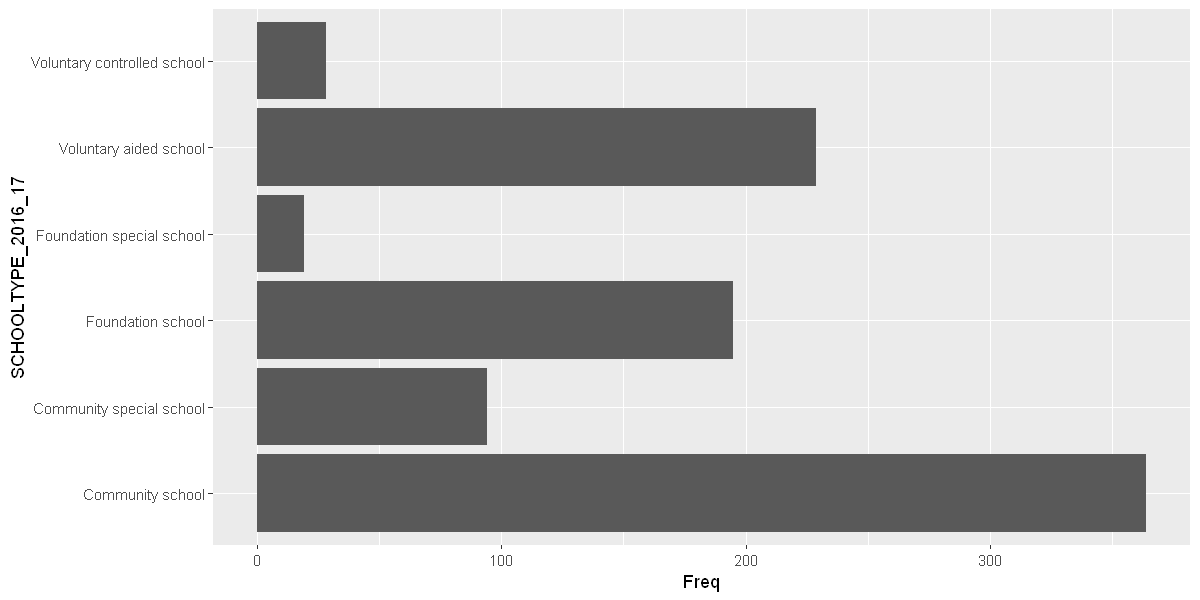

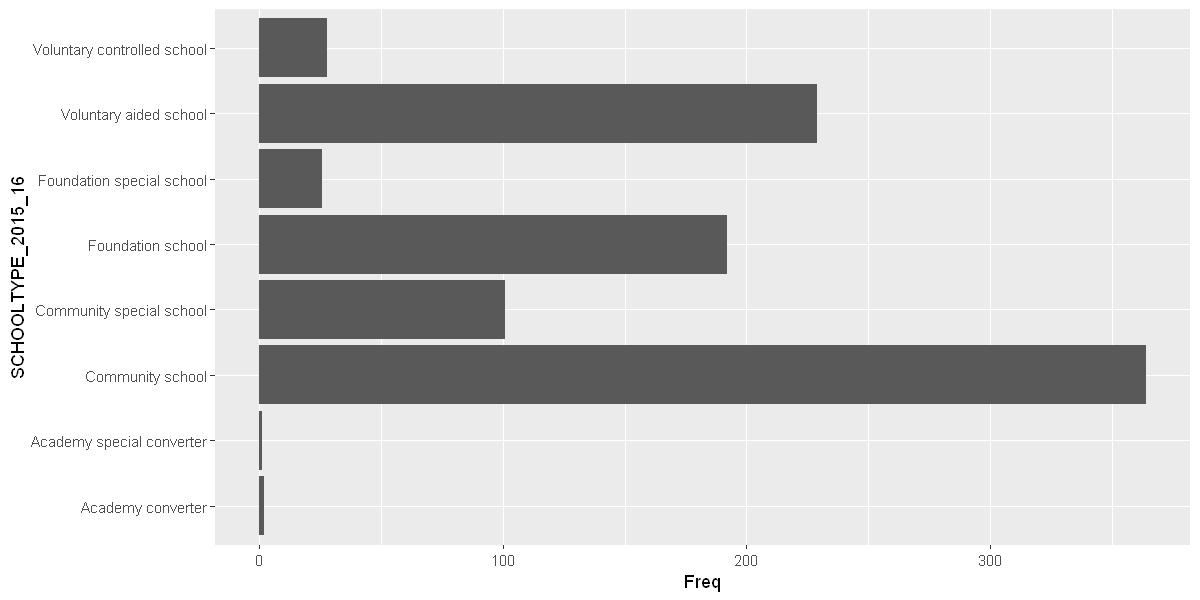

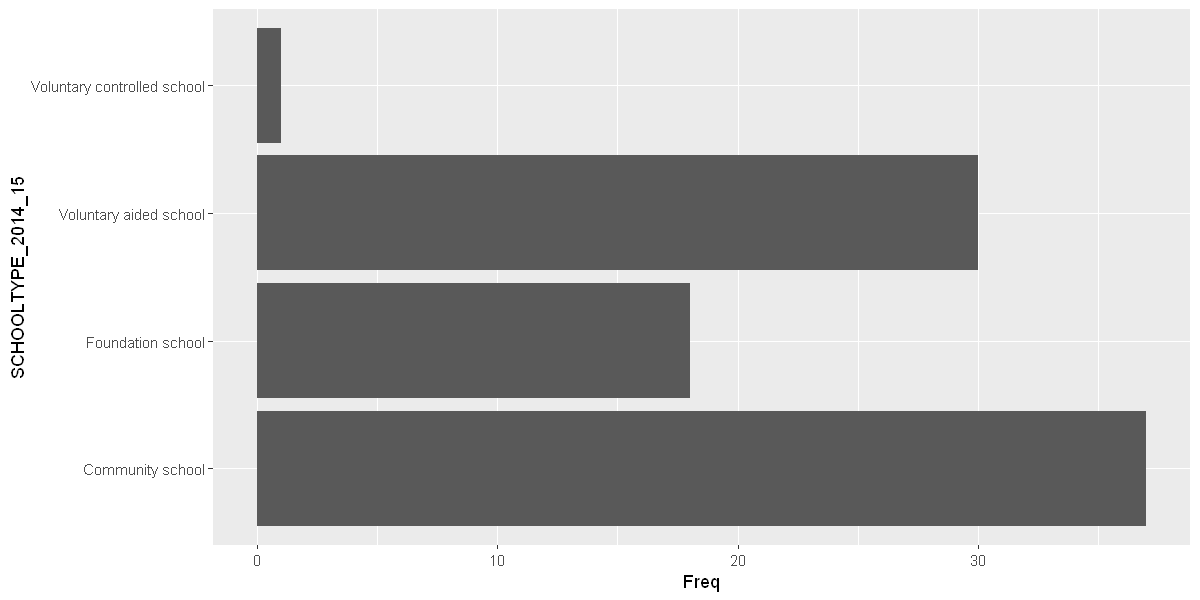

In [207]:
# Now Consider the SCHOOLTYPE

PlotHBarChart(XY_2018_19$SCHOOLTYPE, 'SCHOOLTYPE_2018_19', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2017_18$SCHOOLTYPE, 'SCHOOLTYPE_2017_18', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2016_17$SCHOOLTYPE, 'SCHOOLTYPE_2016_17', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2015_16$SCHOOLTYPE, 'SCHOOLTYPE_2015_16', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2014_15$SCHOOLTYPE, 'SCHOOLTYPE_2014_15', 'Freq', plotwidth=10, plotheight=5)


#### From the plot above, it is noted that the schootype categories had been restructured after 2014_15.  
#### Therefore, the data of 2014_15 will be excluded from further analysis.  
#### Moreover, only the six major school types below will be taken for analysis, as the 'Academy' school type is heavily unbalanced
#### {Community special school, Community school,  Community special school, Foundation school, Foundation special school,  Voluntary aided school, Voluntary controlled school} 


In [208]:
# Only subset the selected school types
schooltypes <- c('Community special school', 'Community school', 'Foundation school', 
                 'Foundation special school', 'Voluntary aided school', 'Voluntary controlled school')

filter <- XY_2018_19$SCHOOLTYPE %in% schooltypes
XY_2018_19 <- XY_2018_19[filter,]

filter <- XY_2017_18$SCHOOLTYPE %in% schooltypes
XY_2017_18 <- XY_2017_18[filter,]


filter <- XY_2016_17$SCHOOLTYPE %in% schooltypes
XY_2016_17 <- XY_2016_17[filter,]


filter <- XY_2015_16$SCHOOLTYPE %in% schooltypes
XY_2015_16 <- XY_2015_16[filter,]

# Please note the 2014_15 data is excluded from analysis
# filter <- XY_2014_15$SCHOOLTYPE %in% schooltypes
# XY_2014_15 <- XY_2014_15[filter,]



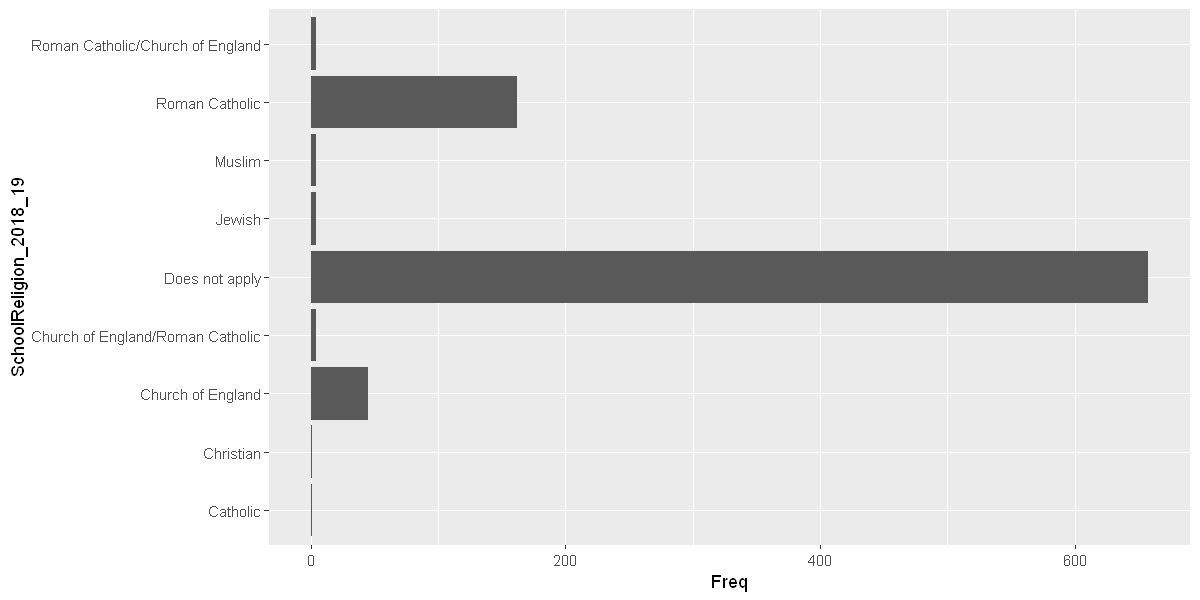

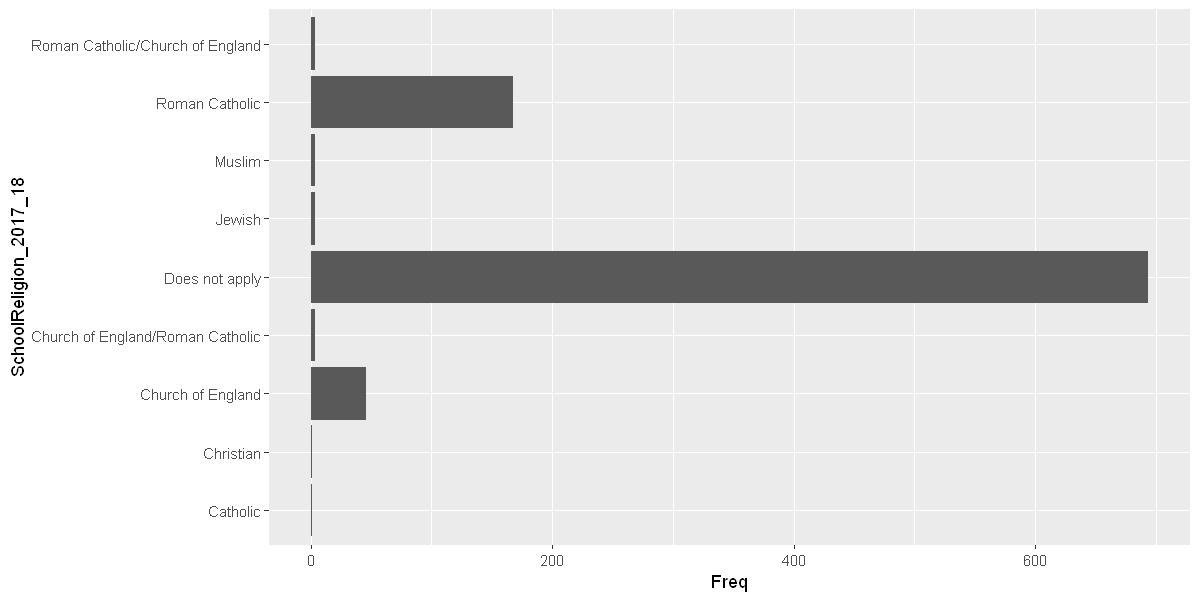

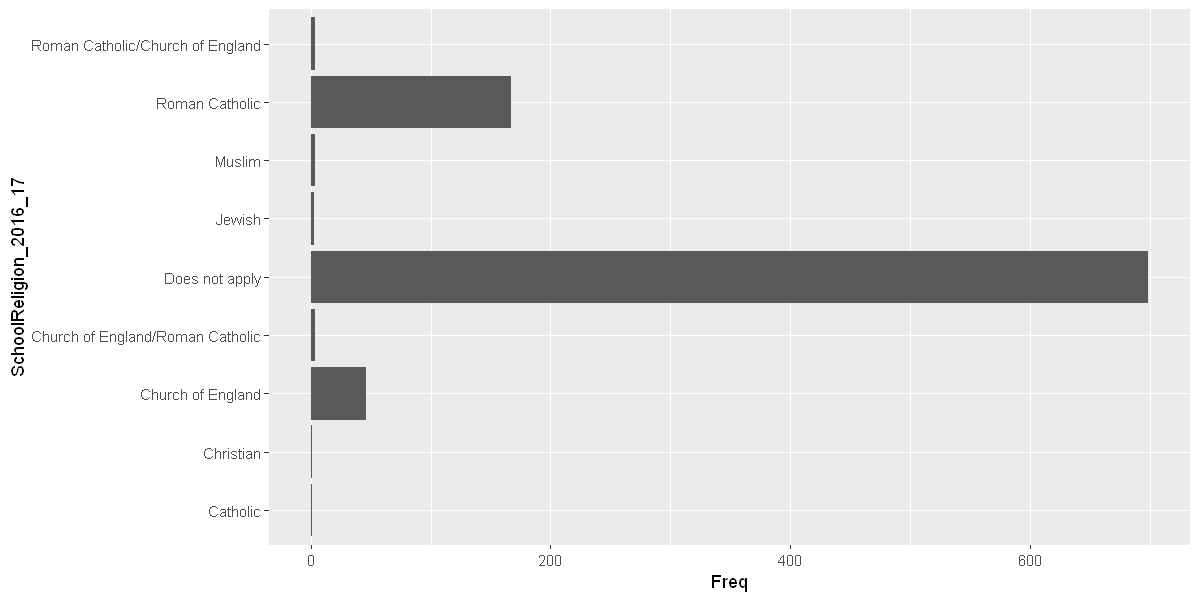

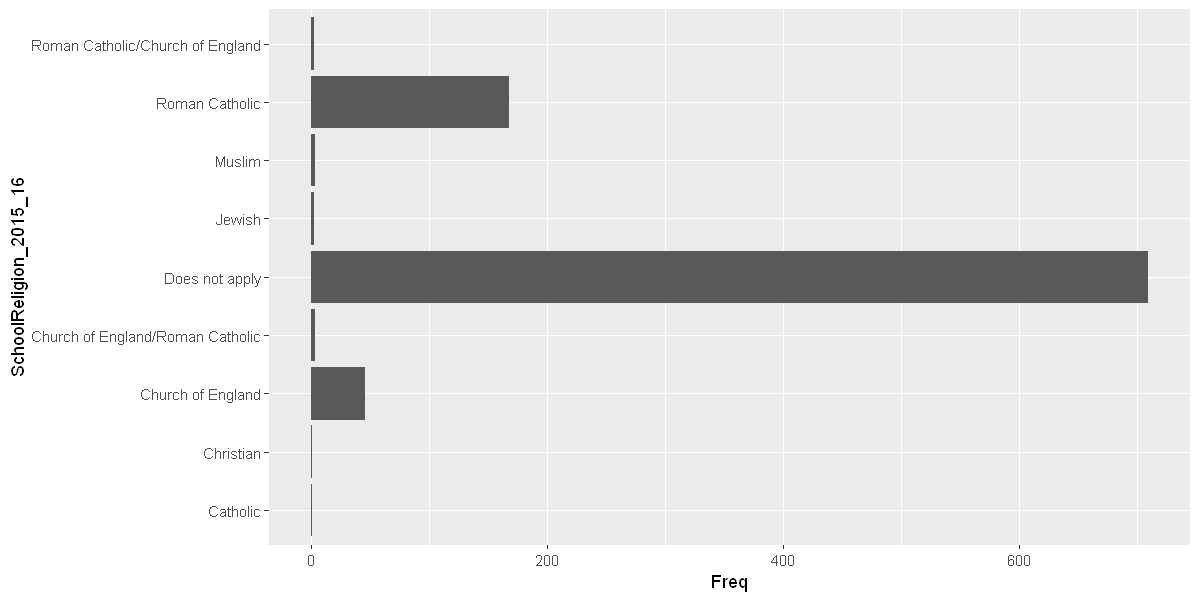

In [209]:
# Let's consider the school religion

PlotHBarChart(XY_2018_19$SchoolReligion, 'SchoolReligion_2018_19', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2017_18$SchoolReligion, 'SchoolReligion_2017_18', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2016_17$SchoolReligion, 'SchoolReligion_2016_17', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2015_16$SchoolReligion, 'SchoolReligion_2015_16', 'Freq', plotwidth=10, plotheight=5)


#### As observed from school religion categories, there are some confusion from the original datasets.  
#### We will then regroup the school religions as follows: 
####   {ChurchofEngland_RomanCatholic_Christian, Does_not_apply,  Jewish, Muslim} 
#### Again, the 2014_15 data set is excluded. 


In [210]:
# Regroup the the school religion column values
groupreligions <- c('Catholic', 'Christian', 'Church of England', 
               'Church of England/Roman Catholic', 'Roman Catholic', 'Roman Catholic/Church of England')
            
filter <- XY_2018_19$SchoolReligion %in% groupreligions
XY_2018_19[filter,c('SchoolReligion')] <- 'ChurchofEngland_RomanCatholic_Christian'

filter <- XY_2017_18$SchoolReligion %in% groupreligions
XY_2017_18[filter,c('SchoolReligion')] <- 'ChurchofEngland_RomanCatholic_Christian'

filter <- XY_2016_17$SchoolReligion %in% groupreligions
XY_2016_17[filter,c('SchoolReligion')] <- 'ChurchofEngland_RomanCatholic_Christian'

filter <- XY_2015_16$SchoolReligion %in% groupreligions
XY_2015_16[filter,c('SchoolReligion')] <- 'ChurchofEngland_RomanCatholic_Christian'


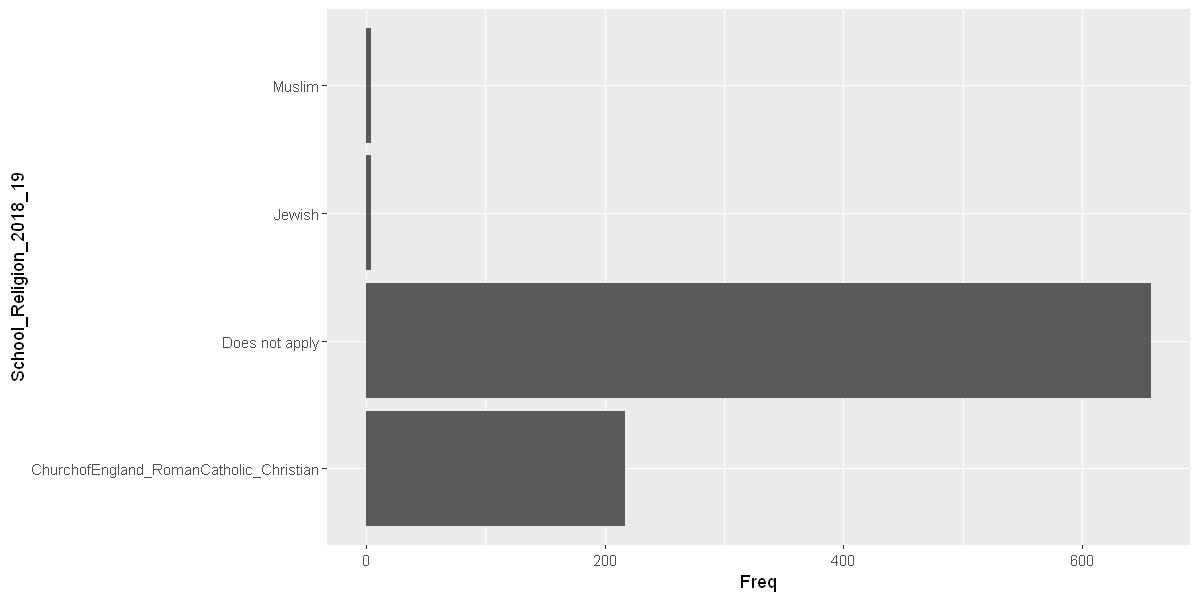

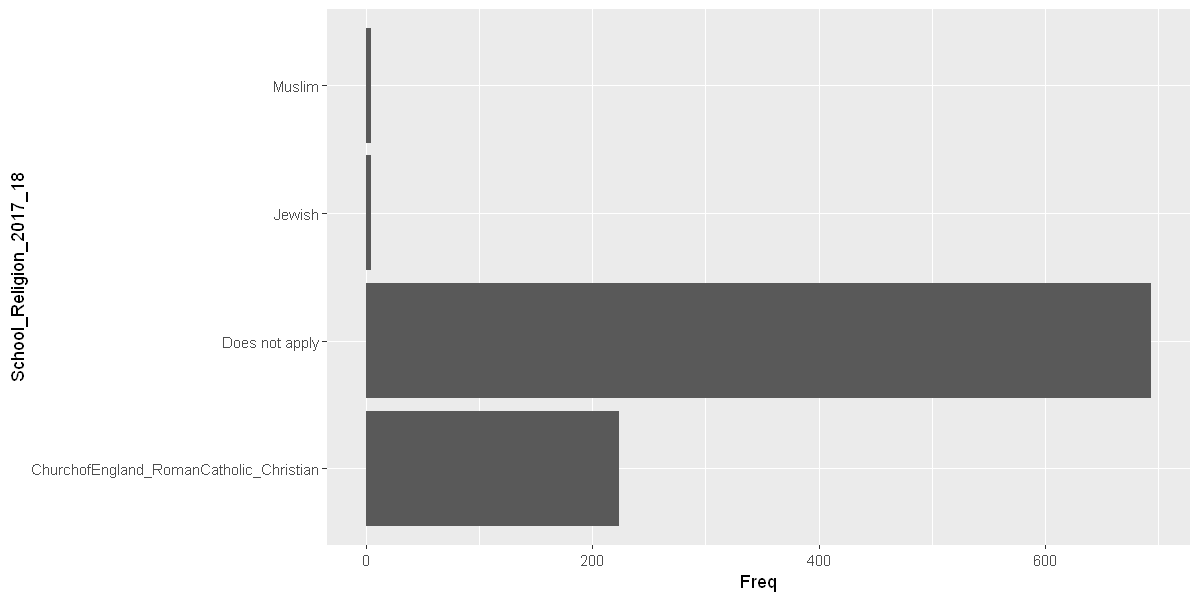

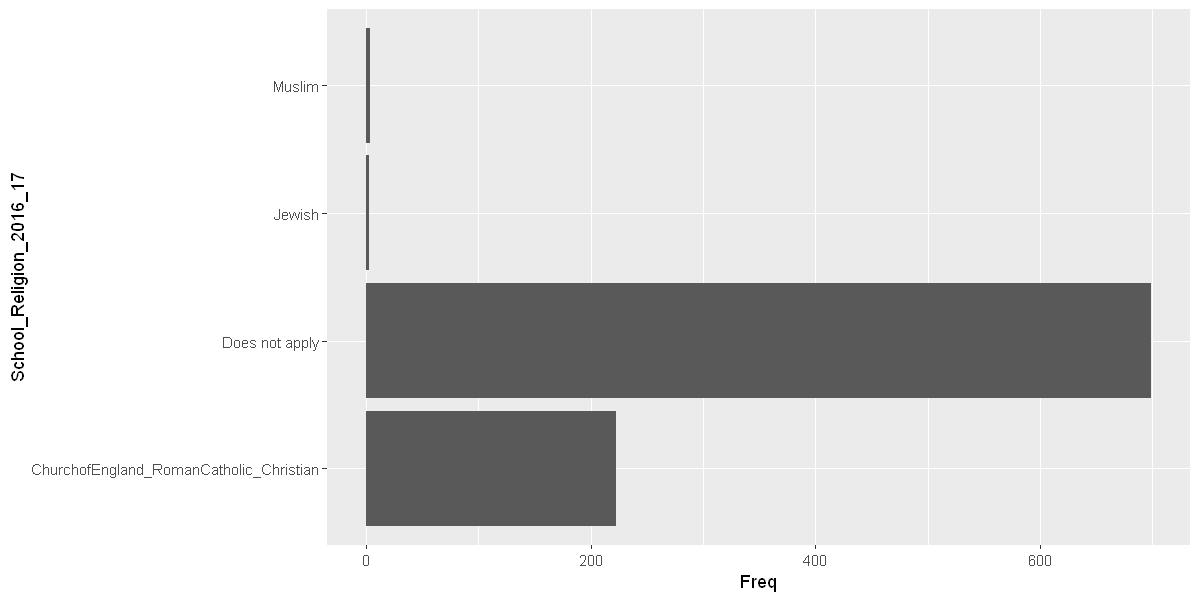

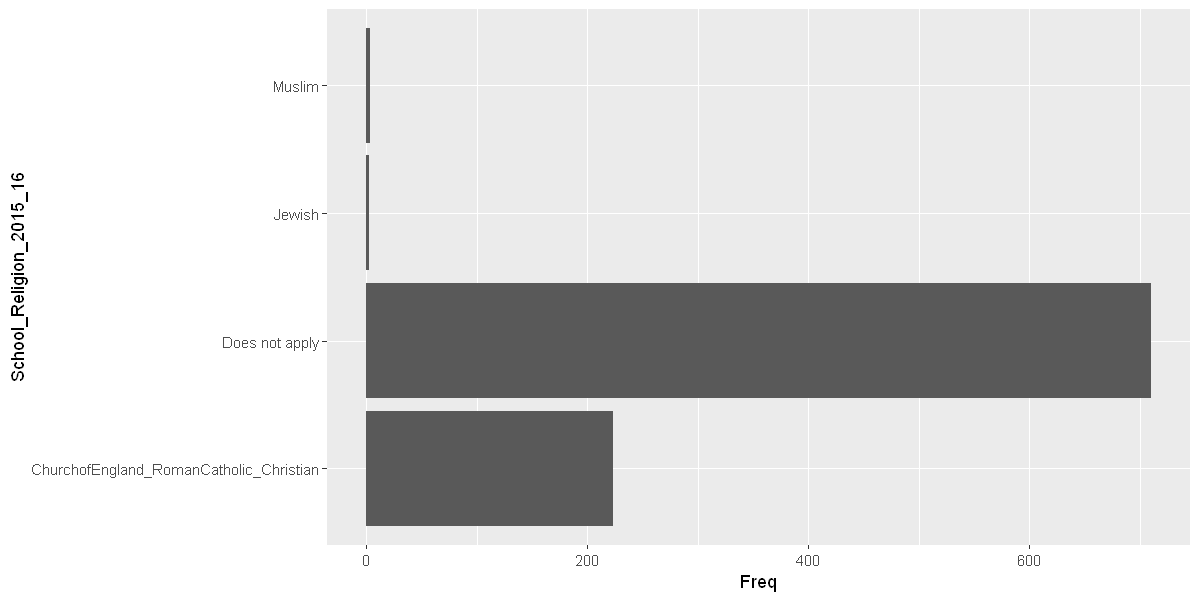

In [211]:
PlotHBarChart(XY_2018_19$SchoolReligion, 'School_Religion_2018_19', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2017_18$SchoolReligion, 'School_Religion_2017_18', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2016_17$SchoolReligion, 'School_Religion_2016_17', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2015_16$SchoolReligion, 'School_Religion_2015_16', 'Freq', plotwidth=10, plotheight=5)

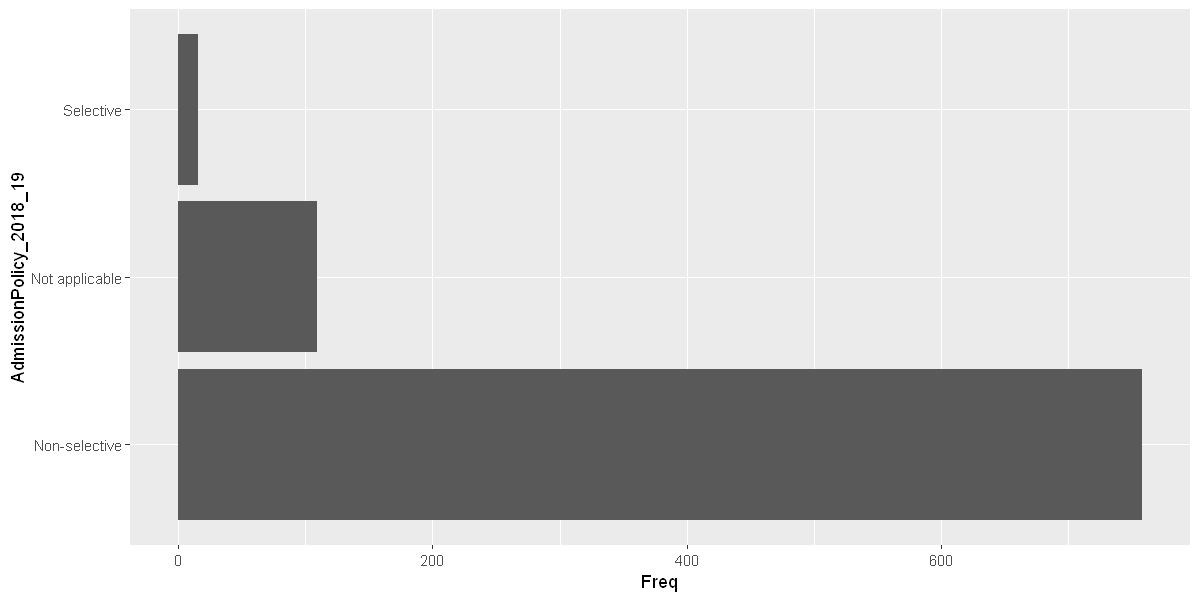

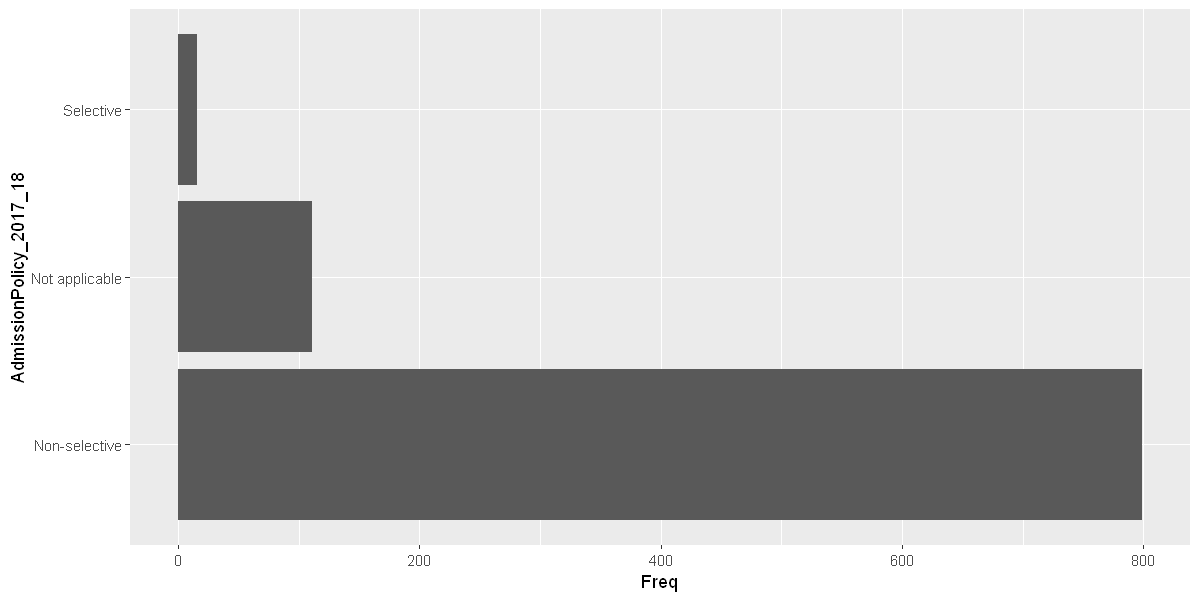

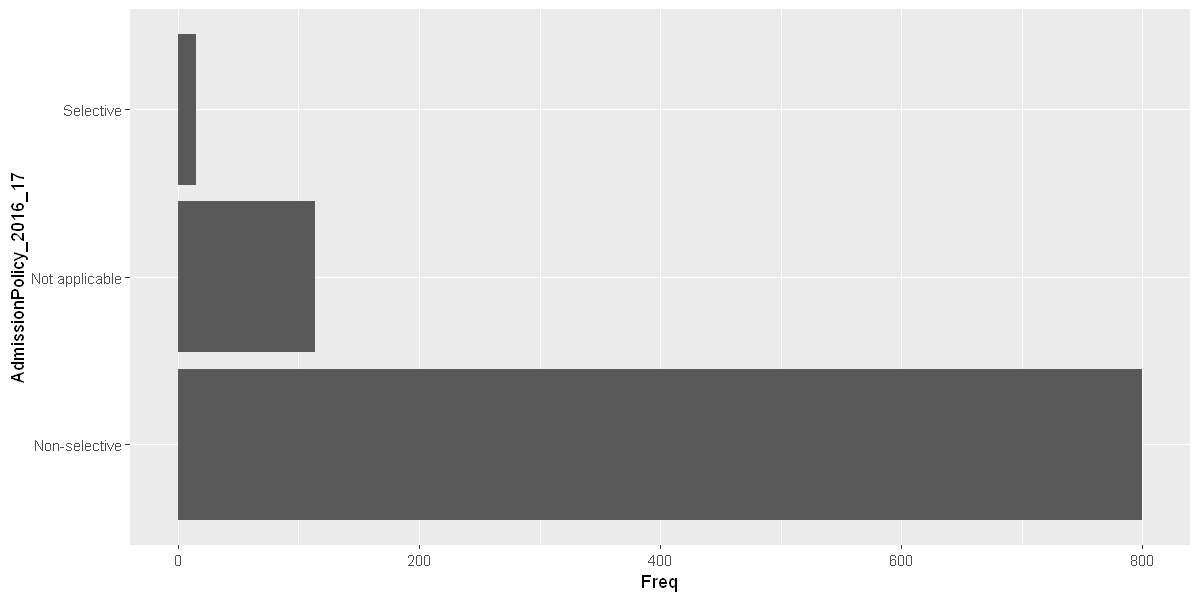

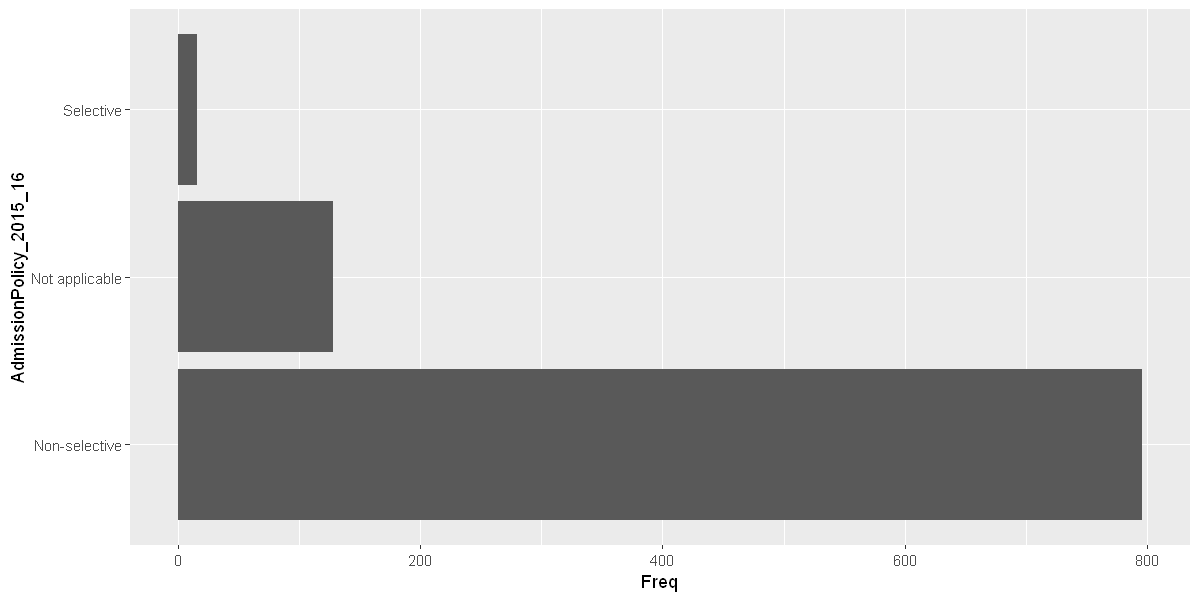

In [212]:
# Let's consider the school admission policy

PlotHBarChart(XY_2018_19$AdmissionPolicy, 'AdmissionPolicy_2018_19', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2017_18$AdmissionPolicy, 'AdmissionPolicy_2017_18', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2016_17$AdmissionPolicy, 'AdmissionPolicy_2016_17', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2015_16$AdmissionPolicy, 'AdmissionPolicy_2015_16', 'Freq', plotwidth=10, plotheight=5)

# There are no further data regrouping required for the admission policy column


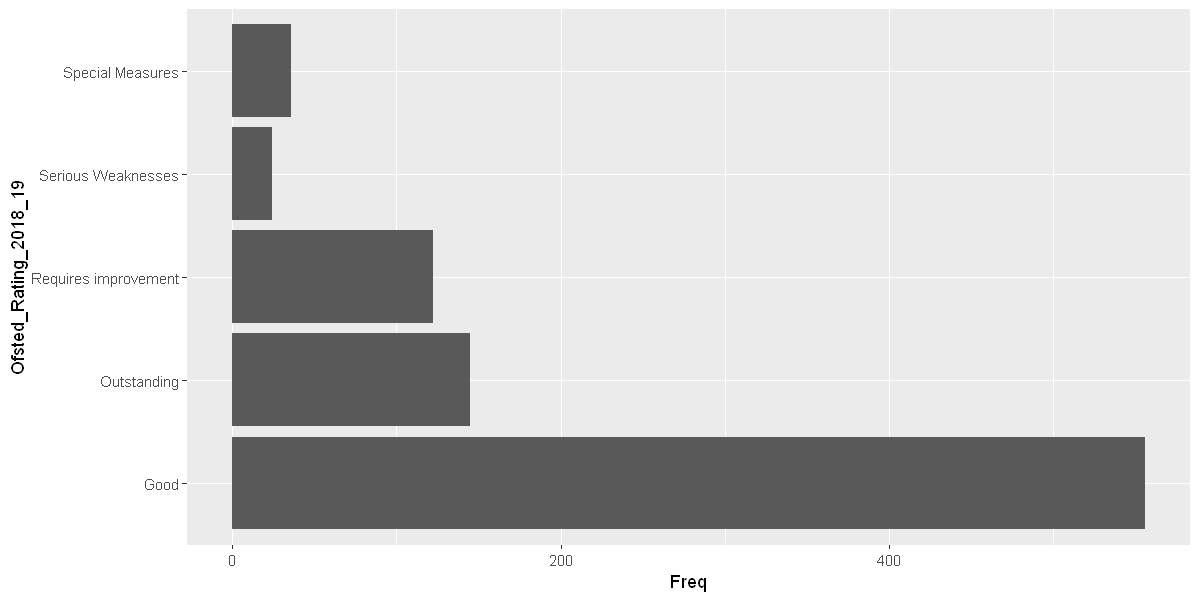

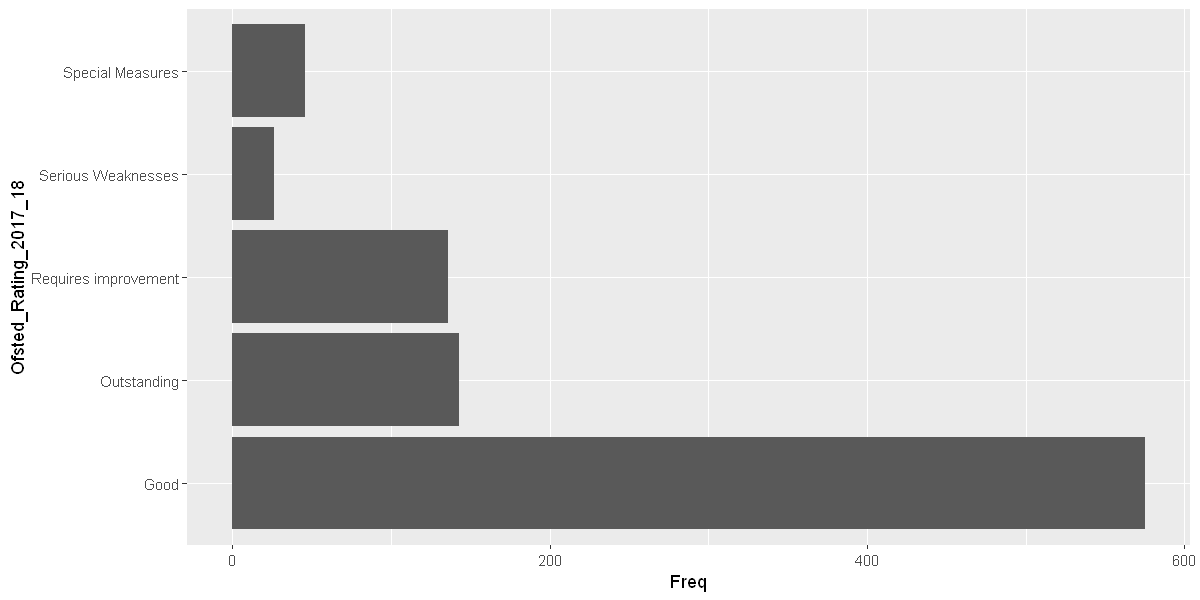

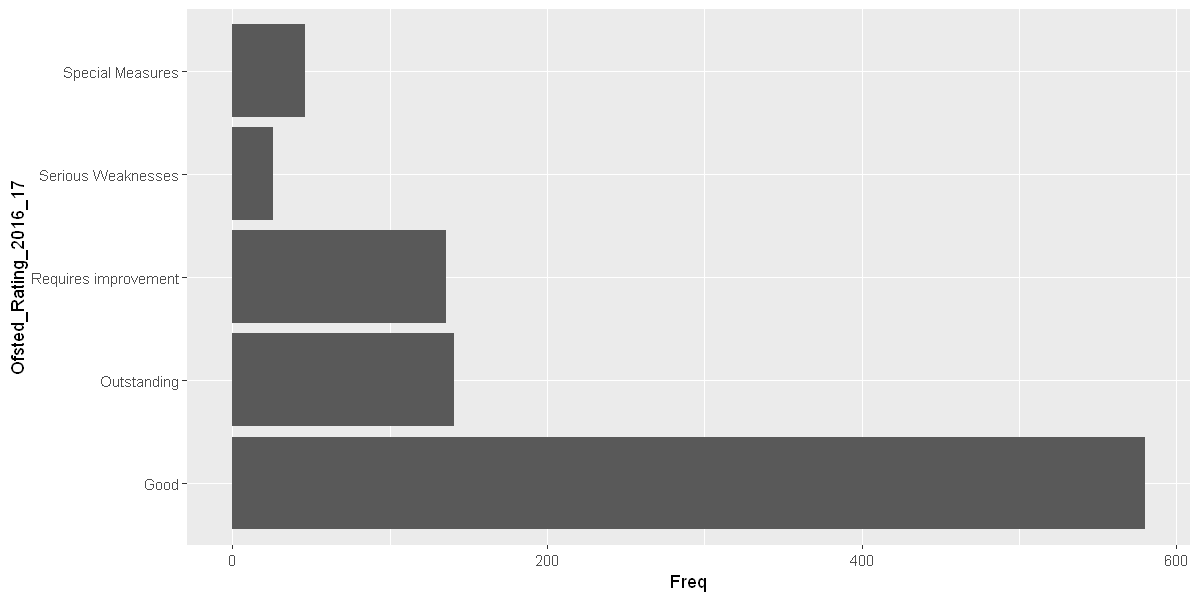

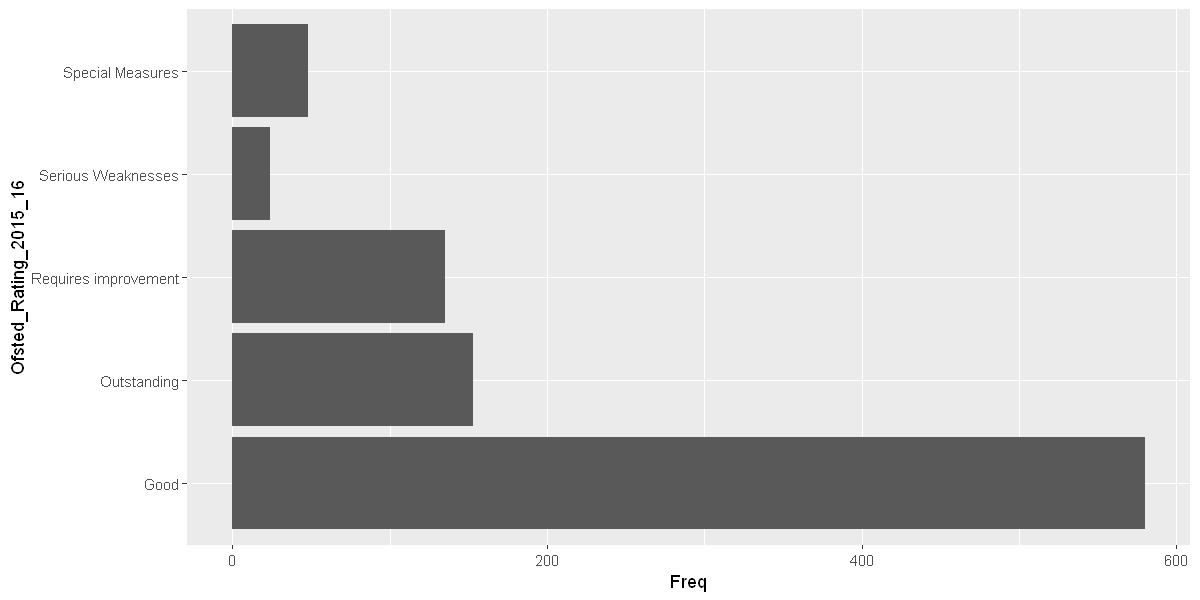

In [213]:
# Let's consider the school Ofsted_Rating

PlotHBarChart(XY_2018_19$Ofsted_Rating, 'Ofsted_Rating_2018_19', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2017_18$Ofsted_Rating, 'Ofsted_Rating_2017_18', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2016_17$Ofsted_Rating, 'Ofsted_Rating_2016_17', 'Freq', plotwidth=10, plotheight=5)
PlotHBarChart(XY_2015_16$Ofsted_Rating, 'Ofsted_Rating_2015_16', 'Freq', plotwidth=10, plotheight=5)



In [214]:
# Finally, check the categorical variables to ensure no missing values were not handled, 
catvar <- c('SCHOOLTYPE','SchoolReligion','AdmissionPolicy','Ofsted_Rating')
result <- GetInvalidValuesSummary(XY_2018_19[,catvar], names(XY_2018_19[,catvar])) 
t(result)
result <- GetInvalidValuesSummary(XY_2017_18[,catvar], names(XY_2017_18[,catvar])) 
t(result)
result <- GetInvalidValuesSummary(XY_2016_17[,catvar], names(XY_2016_17[,catvar])) 
t(result)
result <- GetInvalidValuesSummary(XY_2015_16[,catvar], names(XY_2015_16[,catvar])) 
t(result)
result <- GetInvalidValuesSummary(XY_2014_15[,catvar], names(XY_2014_15[,catvar])) 
t(result)



[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

[,1]     [,2]          
Type            is_na(%) is_infinite(%)
SCHOOLTYPE      0 ( 0 %) 0 ( 0 %)      
SchoolReligion  0 ( 0 %) 0 ( 0 %)      
AdmissionPolicy 0 ( 0 %) 0 ( 0 %)      
Ofsted_Rating   0 ( 0 %) 0 ( 0 %)

### 1.8.8 Encode Categorical Variables Using One-Hot Encoding

In [215]:
# c('SCHOOLTYPE', 'SchoolReligion','AdmissionPolicy', 'Ofsted_Rating')
# Encode categorical columns using one-hot encoding. 

col_categorical <- XY_col_dict[XY_col_dict$datatype==TYPE_SYMBOLIC, c('name')]
col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]

XY_2018_19_encoded <- EncodeDataSet(XY_2018_19, col_categorical, col_ordinal)
XY_2017_18_encoded <- EncodeDataSet(XY_2017_18, col_categorical, col_ordinal)
XY_2016_17_encoded <- EncodeDataSet(XY_2016_17, col_categorical, col_ordinal)
XY_2015_16_encoded <- EncodeDataSet(XY_2015_16, col_categorical, col_ordinal)

head(XY_2018_19_encoded)


Att8Score_Disadvantaged Prg8Score_Disadvantaged TotalPupilsNo Percent_Girls
3 38.2                    -0.28                    950          41.40000     
4 51.7                     0.47                   1170          47.32172     
5 40.6                    -0.19                   1003          45.00000     
6 44.1                    -0.09                   1308          47.50000     
7 40.4                    -0.36                   1008          33.70000     
8 54.0                     0.36                   1025          85.80000     
  Percent_SEN_EHCPlan Percent_SEN_Support Percent_NonEngFirstLang
3 3.2                 11.8                17.50532               
4 1.3                 10.2                38.10000               
5 3.6                 11.1                17.50532               
6 2.4                  6.9                55.80000               
7 6.2                 13.4                28.20000               
8 1.5                 17.1                36.90000               
  Percent_EngFirstLang Percent_UnclassifiedLang Percent_FreeSchoolMealsEver ⋯
3 82.22613             0.1                      64.5                        ⋯
4 60.90000             0.9                      49.6                        ⋯
5 82.22613             0.0                      69.0                        ⋯
6 44.20000             0.0                      54.2                        ⋯
7 70.30000             1.5                      47.1                        ⋯
8 62.30000             0.8                      36.6                        ⋯
  SchoolReligionJewish SchoolReligionMuslim AdmissionPolicyNon.selective
3 0                    0                    1                           
4 0                    0                    1                           
5 0                    0                    1                           
6 0                    0                    1                           
7 0                    0                    1                           
8 0                    0                    1                           
  AdmissionPolicyNot.applicable AdmissionPolicySelective Ofsted_RatingGood
3 0                             0                        1                
4 0                             0                        1                
5 0                             0                        1                
6 0                             0                        1                
7 0                             0                        1                
8 0                             0                        0                
  Ofsted_RatingOutstanding Ofsted_RatingRequires.improvement
3 0                        0                                
4 0                        0                                
5 0                        0                                
6 0                        0                                
7 0                        0                                
8 1                        0                                
  Ofsted_RatingSerious.Weaknesses Ofsted_RatingSpecial.Measures
3 0                               0                            
4 0                               0                            
5 0                               0                            
6 0                               0                            
7 0                               0                            
8 0                               0

In [216]:
# Rescaling will be taken as when necessary depending on the model to be trained.
XY_col_dict

name                                           
4  Att8Score_Disadvantaged                        
5  Prg8Score_Disadvantaged                        
8  TotalPupilsNo                                  
9  Percent_Girls                                  
11 Percent_SEN_EHCPlan                            
12 Percent_SEN_Support                            
13 Percent_NonEngFirstLang                        
14 Percent_EngFirstLang                           
15 Percent_UnclassifiedLang                       
16 Percent_FreeSchoolMealsEver                    
17 Percent_OverallAbsence                         
18 Percent_PersistentAbsence                      
25 PupilTeacherRatio                              
26 MeanSalaryTeachers                             
27 SCHOOLTYPE                                     
28 SchoolReligion                                 
29 AdmissionPolicy                                
31 Ofsted_Rating                                  
34 SchoolFin_TotalIncomewithFunding               
44 SchoolFin_ICTLearningResourcesCostPerPupil     
48 TeacherAndSupportPostFillUpRate                
49 TeacherAndSupportStaffCount                    
50 PupilStaffRatio                                
51 SchoolFin_TeachAndSupportStaffCostPerPupil     
52 SchoolFin_NonICTAndEducationServiceCostPerPupil
53 SchoolFin_MiscCostPerPupil                     
   description                                                                                                                 
4  Average Attainment 8 score per disadvantaged pupil                                                                          
5  Adjusted Progress 8 measure - disadvantaged pupils                                                                          
8  Total number of pupils on roll                                                                                              
9  Percentage of girls on roll                                                                                                 
11 Percentage of SEN pupils with an EHC plan                                                                                   
12 Percentage of eligible pupils with SEN support                                                                              
13 % pupils where English not first language                                                                                   
14 % pupils with English first language                                                                                        
15 % pupils where first language is unclassified                                                                               
16 Percentage of pupils eligible for FSM at any time during the past 6 years                                                   
17 Percentage of overall absence                                                                                               
18 Percentage of enrolments who are persistent absentees                                                                       
25 Pupil Teacher Ratio                                                                                                         
26 Mean Gross FTE Salary of All Teachers                                                                                       
27 School type                                                                                                                 
28 School religious character                                                                                                  
29 School admission policy                                                                                                     
31 OFSTED rating                                                                                                               
34 Total income per pupil. Sum of grant funding and self generated income                                                      
44 ICT learning resources per pupil. Includes education software, 

### 1.8.9 Exploratory Data Analysis 

**Total number of schools for analysis:**

In [217]:
paste('Total schools in 2018-19 for analysis:', nrow(XY_2018_19_encoded) ) 
paste('Total schools in 2017-18 for analysis:', nrow(XY_2017_18_encoded) ) 
paste('Total schools in 2016-17 for analysis:', nrow(XY_2016_17_encoded) ) 
paste('Total schools in 2015-16 for analysis:', nrow(XY_2015_16_encoded) ) 


[1] "Total schools in 2018-19 for analysis: 883"

[1] "Total schools in 2017-18 for analysis: 926"

[1] "Total schools in 2016-17 for analysis: 929"

[1] "Total schools in 2015-16 for analysis: 940"

**Examine the distribution of numeric variables using histograms**

Warning message:
"package 'cowplot' is in use and will not be installed"


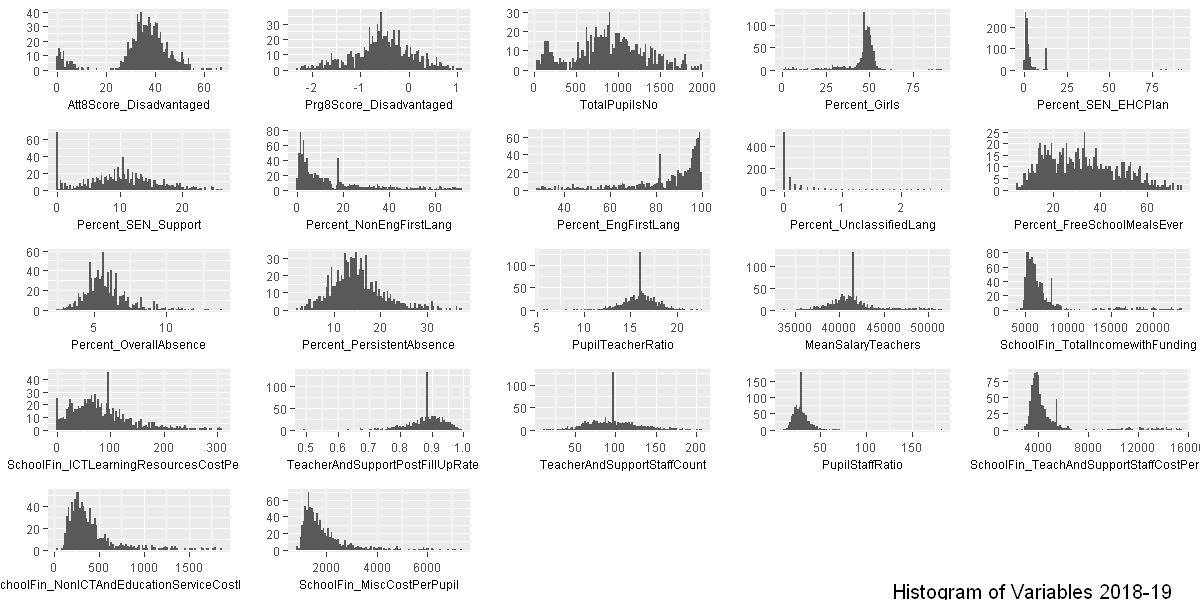

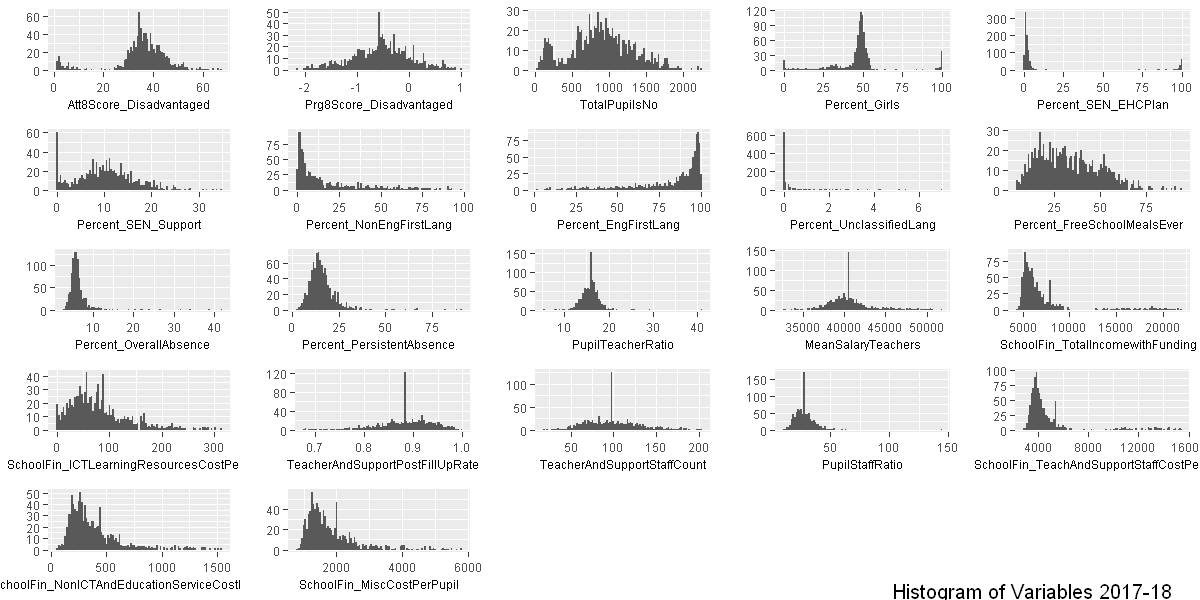

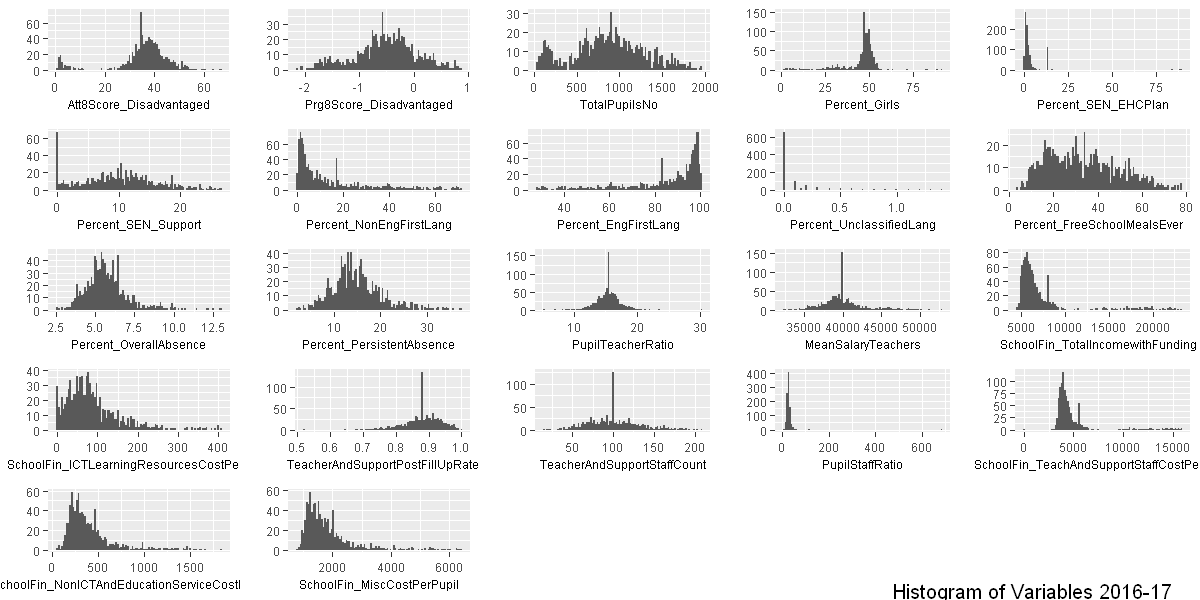

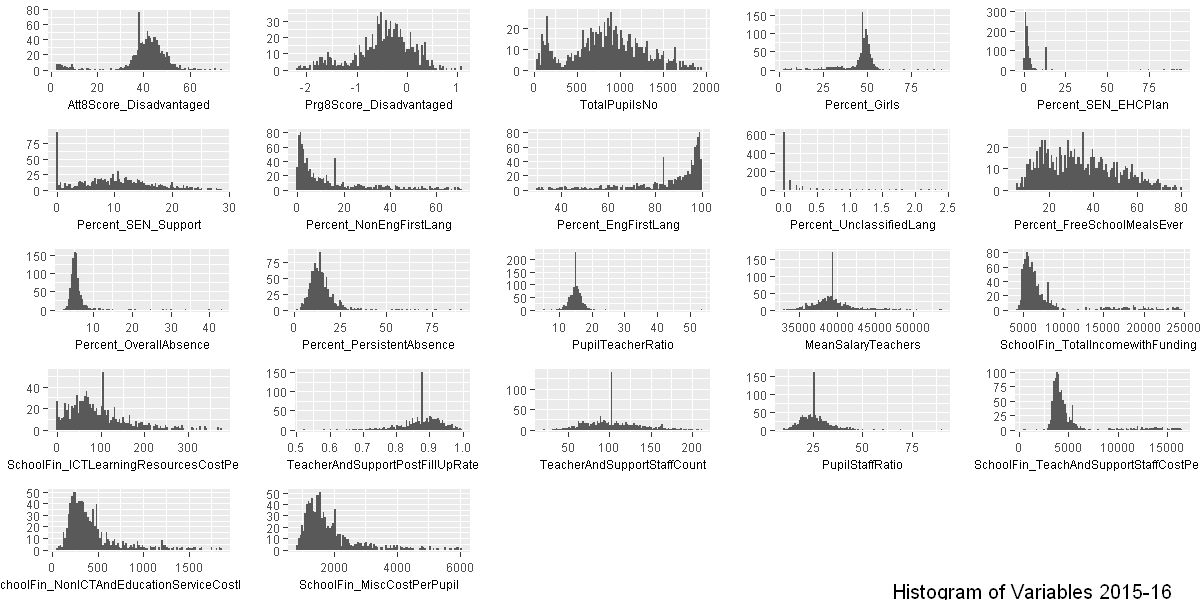

In [218]:
install.packages("cowplot")
col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
library(cowplot)

# Plot grids of histograms to visualize the distribution of ordinal variables
df <- XY_2018_19_encoded[, col_ordinal]
alist <-lapply(1:ncol(df),
              function(col) { 
                  g <- qplot(df[,col],
                               geom = "histogram",
                               binwidth = (max(df[,col]) - min(df[,col]))/100, 
                               xlab=colnames(df)[col])
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Histogram of Variables 2018-19", position = "bottom.right", size = 12)

df <- XY_2017_18_encoded[, col_ordinal]
alist <-lapply(1:ncol(df),
              function(col) { 
                  g <- qplot(df[,col],
                               geom = "histogram",
                               binwidth = (max(df[,col]) - min(df[,col]))/100, 
                               xlab=colnames(df)[col])
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Histogram of Variables 2017-18", position = "bottom.right", size = 12)

df <- XY_2016_17_encoded[, col_ordinal]
alist <-lapply(1:ncol(df),
              function(col) { 
                  g <- qplot(df[,col],
                               geom = "histogram",
                               binwidth = (max(df[,col]) - min(df[,col]))/100, 
                               xlab=colnames(df)[col])
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Histogram of Variables 2016-17", position = "bottom.right", size = 12)

df <- XY_2015_16_encoded[, col_ordinal]
alist <-lapply(1:ncol(df),
              function(col) { 
                  g <- qplot(df[,col],
                               geom = "histogram",
                               binwidth = (max(df[,col]) - min(df[,col]))/100, 
                               xlab=colnames(df)[col])
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Histogram of Variables 2015-16", position = "bottom.right", size = 12)


**Examine the distribution of categorical variables using boxplots**

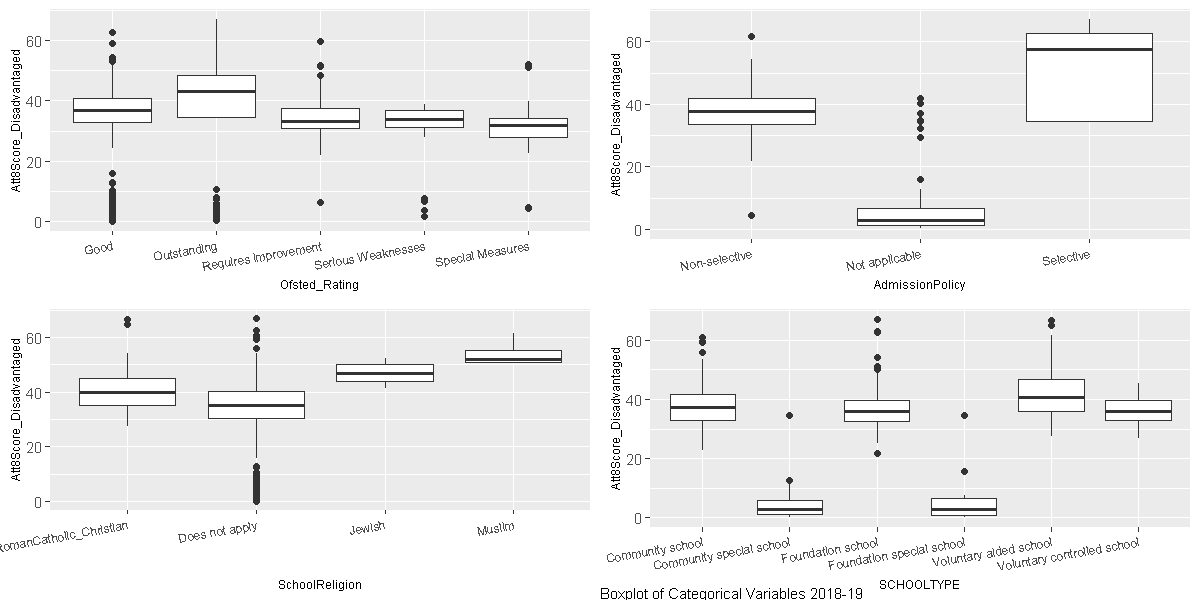

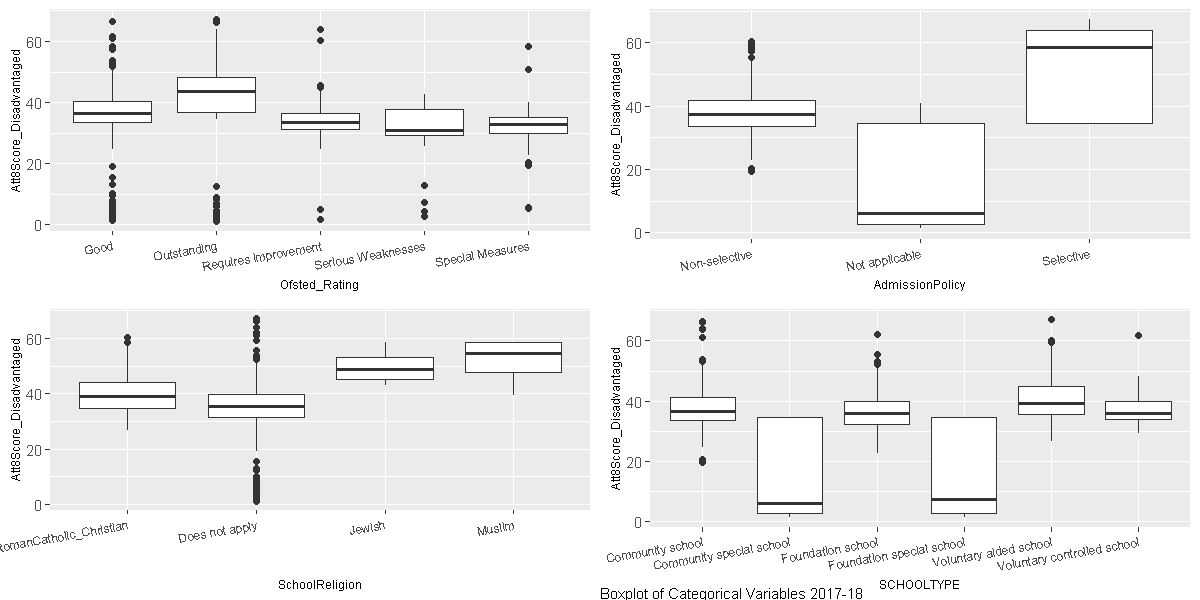

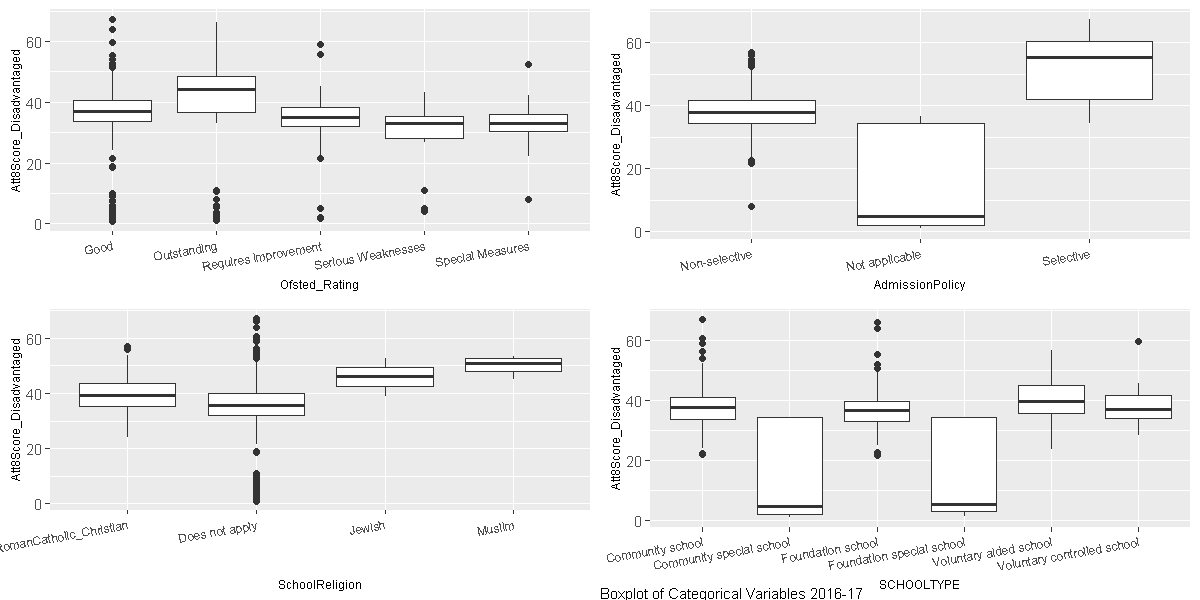

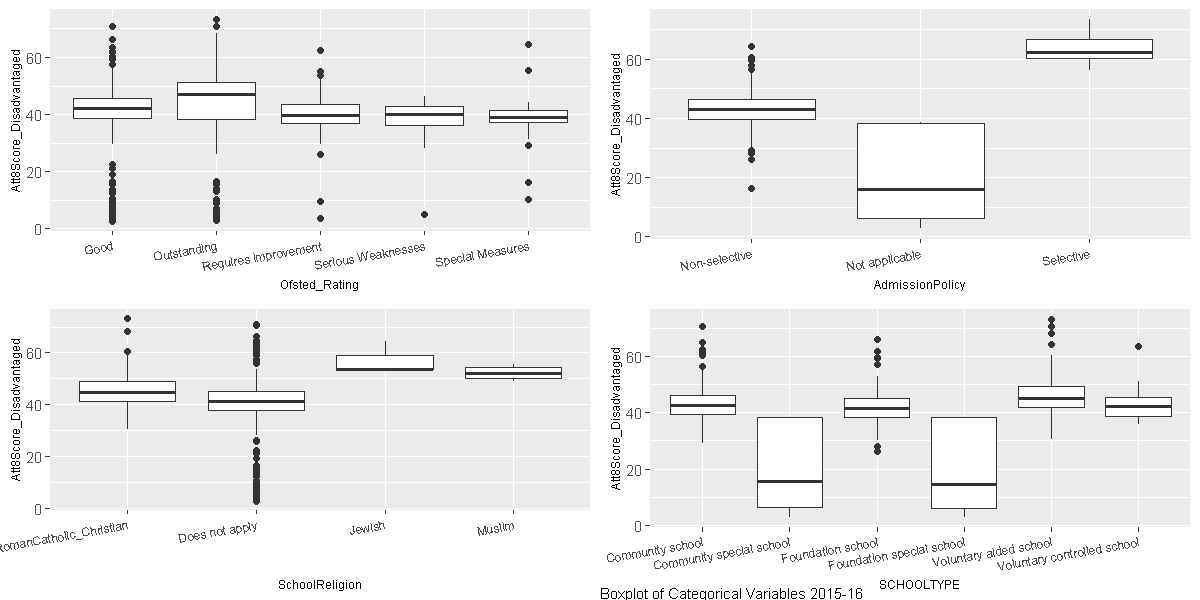

In [219]:
# Plot boxplots of categorical variables 
col_categorical <- XY_col_dict[XY_col_dict$datatype==TYPE_SYMBOLIC, c('name')]
# qplot(data=XY_2018_19, x=XY_2018_19[,col_categorical[1]], y=Att8Score_Disadvantaged, geom='boxplot', xlab=col_categorical[1])


alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2018_19, 
                             x=XY_2018_19[,col_categorical[col]], 
                             y=Att8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2018-19", position='bottom', size = 9)


alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2017_18, 
                             x=XY_2017_18[,col_categorical[col]], 
                             y=Att8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2017-18", position='bottom', size = 9)


alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2016_17, 
                             x=XY_2016_17[,col_categorical[col]], 
                             y=Att8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2016-17", position='bottom', size = 9)

alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2015_16, 
                             x=XY_2015_16[,col_categorical[col]], 
                             y=Att8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2015-16", position='bottom', size = 9)


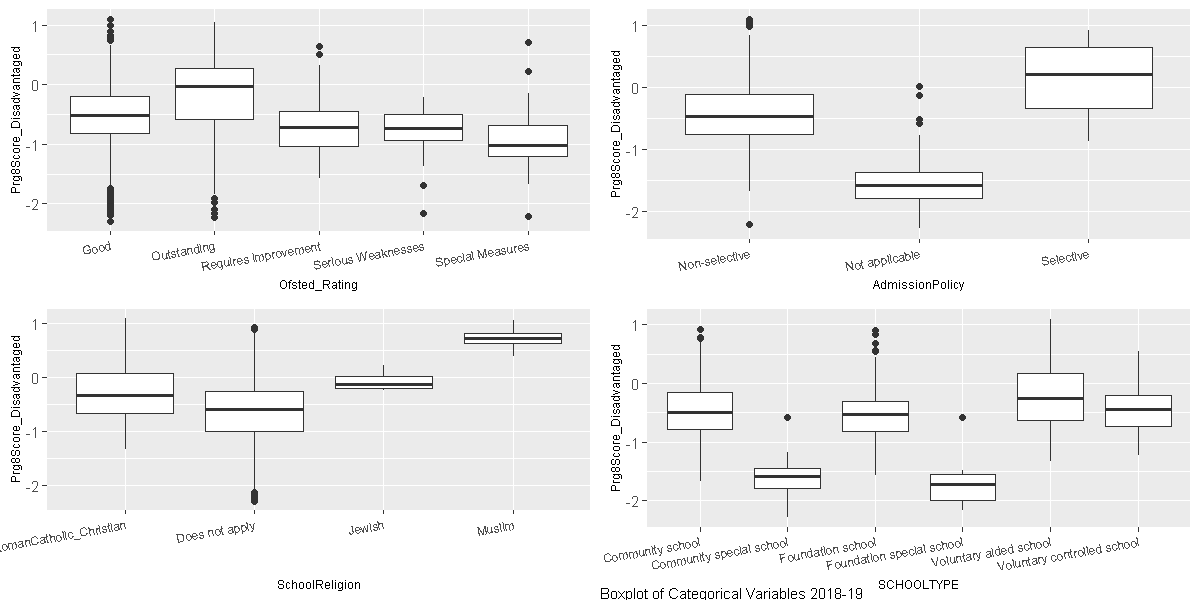

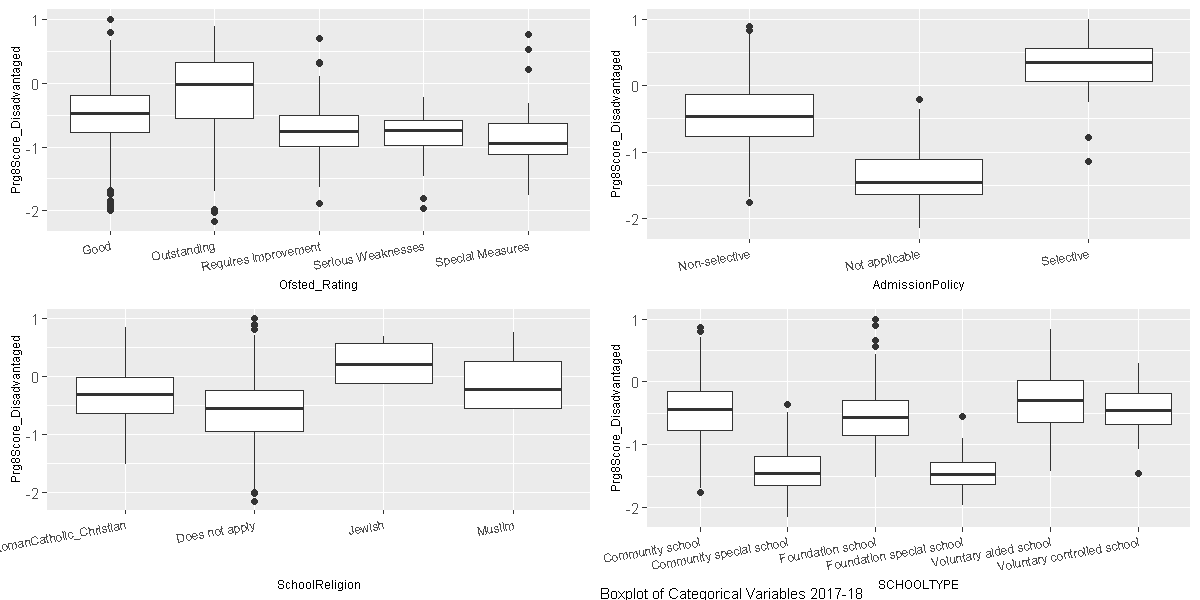

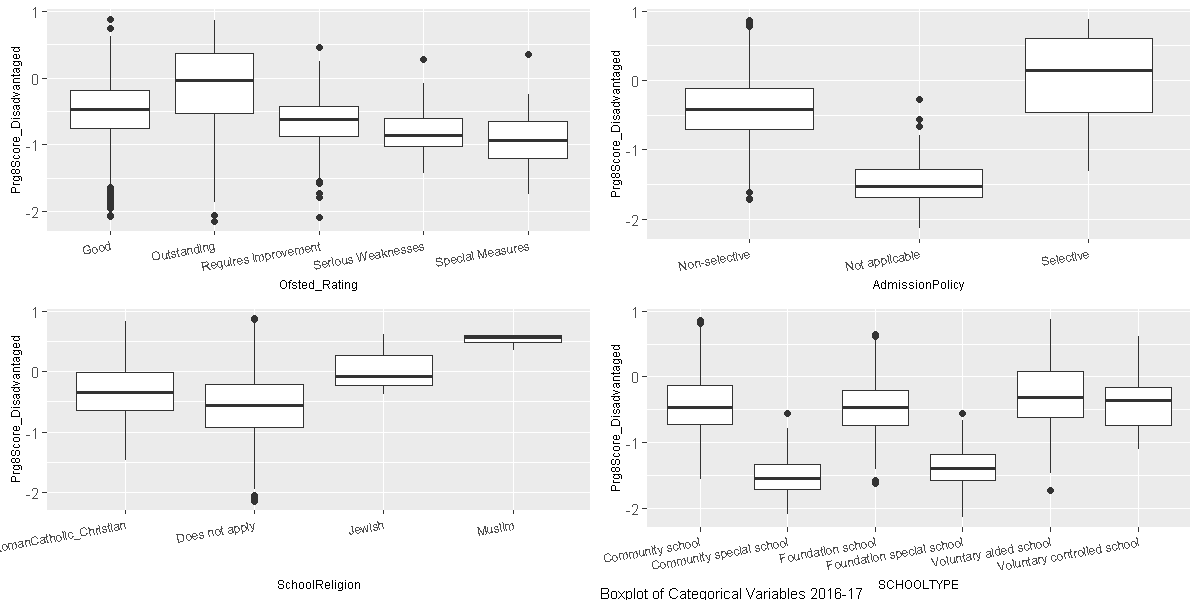

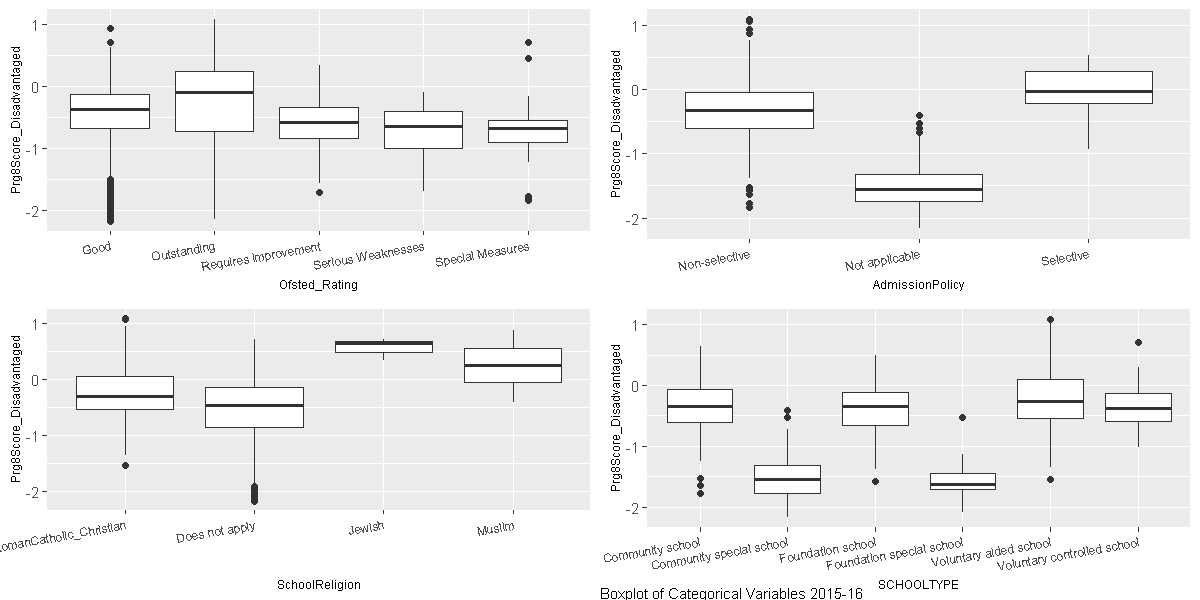

In [220]:
# Plot boxplots of categorical variables 
col_categorical <- XY_col_dict[XY_col_dict$datatype==TYPE_SYMBOLIC, c('name')]

alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2018_19, 
                             x=XY_2018_19[,col_categorical[col]], 
                             y=Prg8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])

                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2018-19", position='bottom', size = 9)


alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2017_18, 
                             x=XY_2017_18[,col_categorical[col]], 
                             y=Prg8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2017-18", position='bottom', size = 9)


alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2016_17, 
                             x=XY_2016_17[,col_categorical[col]], 
                             y=Prg8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2016-17", position='bottom', size = 9)

alist <-lapply(length(col_categorical):1,
              function(col) { 
                  g <- qplot(data=XY_2015_16, 
                             x=XY_2015_16[,col_categorical[col]], 
                             y=Prg8Score_Disadvantaged, 
                             geom='boxplot', xlab=col_categorical[col])


                  g + theme(axis.text.x = element_text(angle=10, vjust=1, hjust=1, size=7),
                          axis.title=element_text(size=7)) 
                  })

p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Boxplot of Categorical Variables 2015-16", position='bottom', size = 9)

**Examine relationship between output variables and input variables using scatterplots**

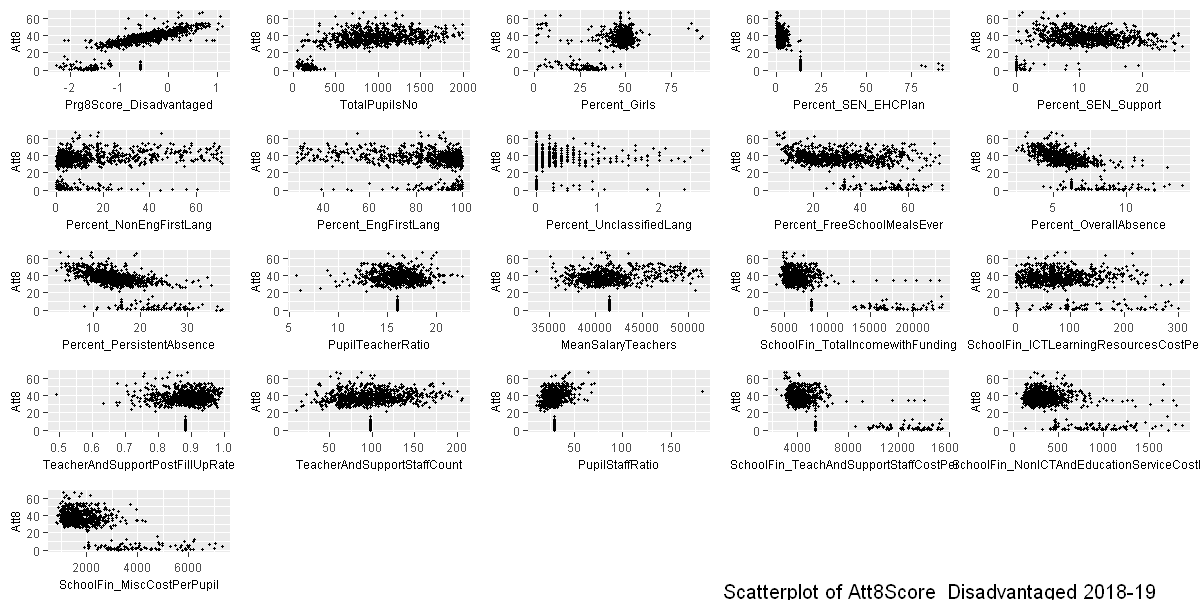

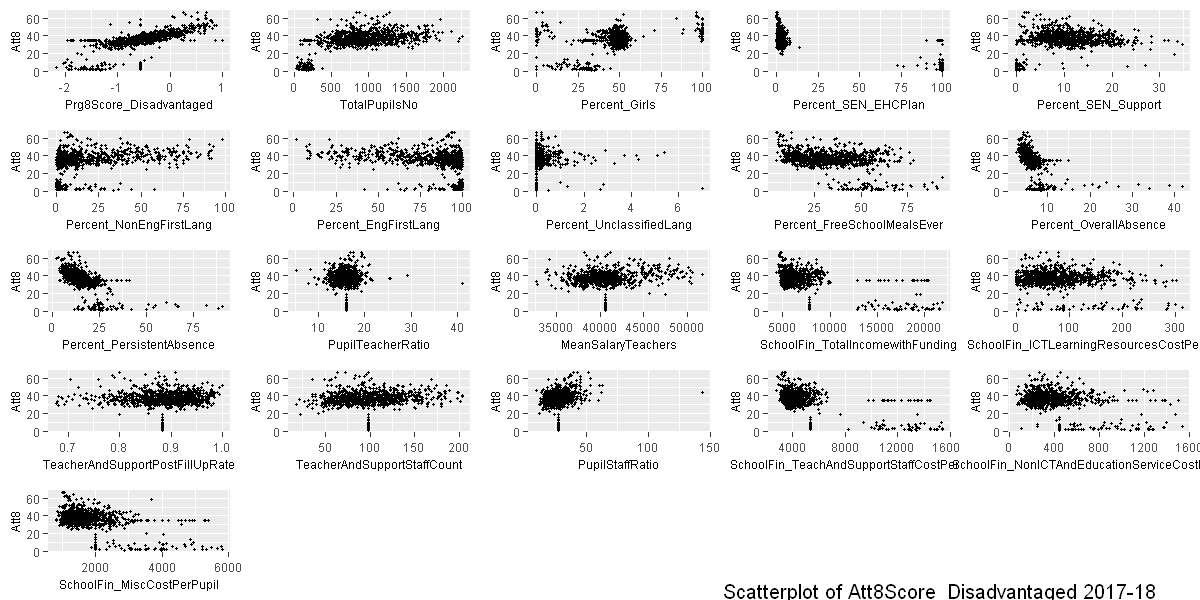

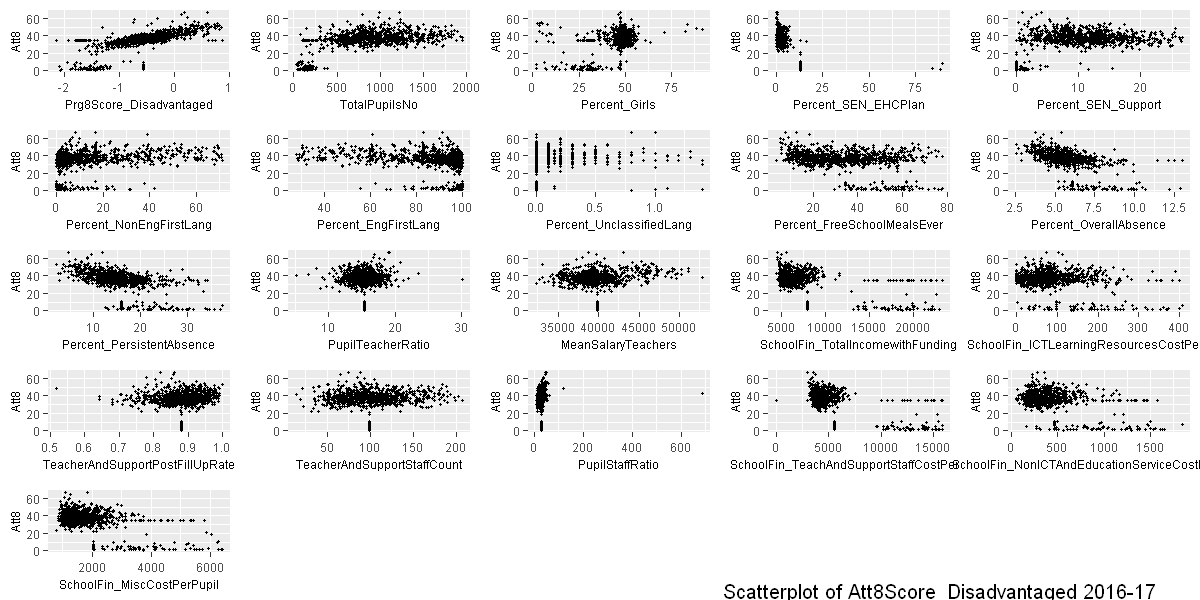

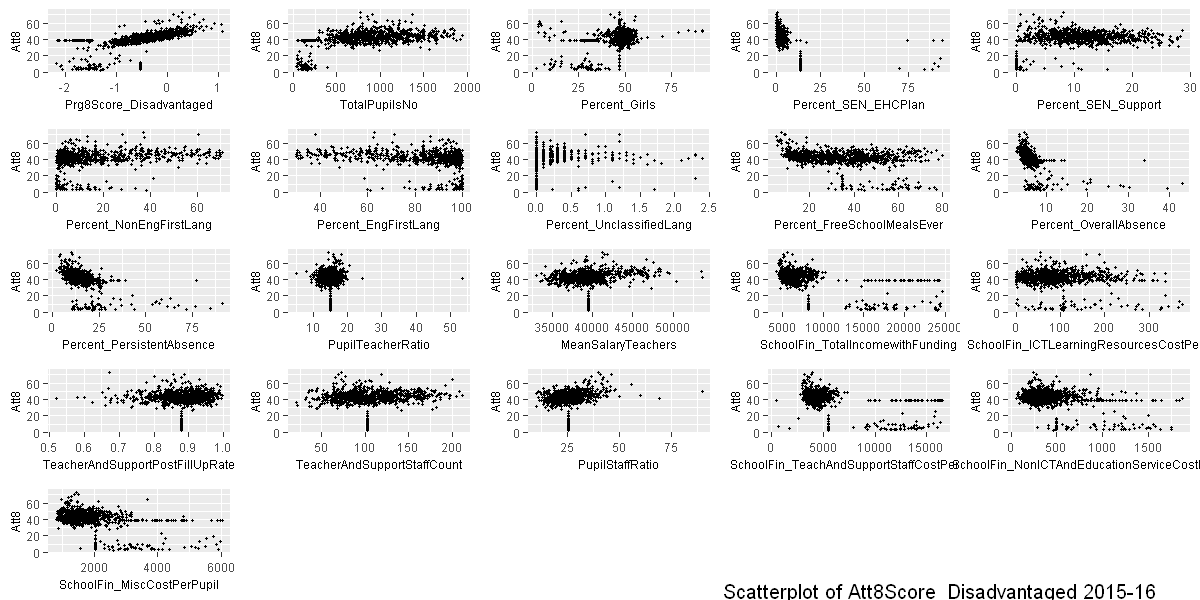

In [221]:
col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2018_19_encoded[, col_ordinal]
alist <-lapply(2:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Att8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Att8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Att8Score_Disadvantaged 2018-19", position = "bottom.right", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2017_18_encoded[, col_ordinal]
alist <-lapply(2:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Att8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Att8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Att8Score_Disadvantaged 2017-18", position = "bottom.right", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2016_17_encoded[, col_ordinal]
alist <-lapply(2:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Att8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Att8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Att8Score_Disadvantaged 2016-17", position = "bottom.right", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2015_16_encoded[, col_ordinal]
alist <-lapply(2:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Att8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Att8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Att8Score_Disadvantaged 2015-16", position = "bottom.right", size = 12)

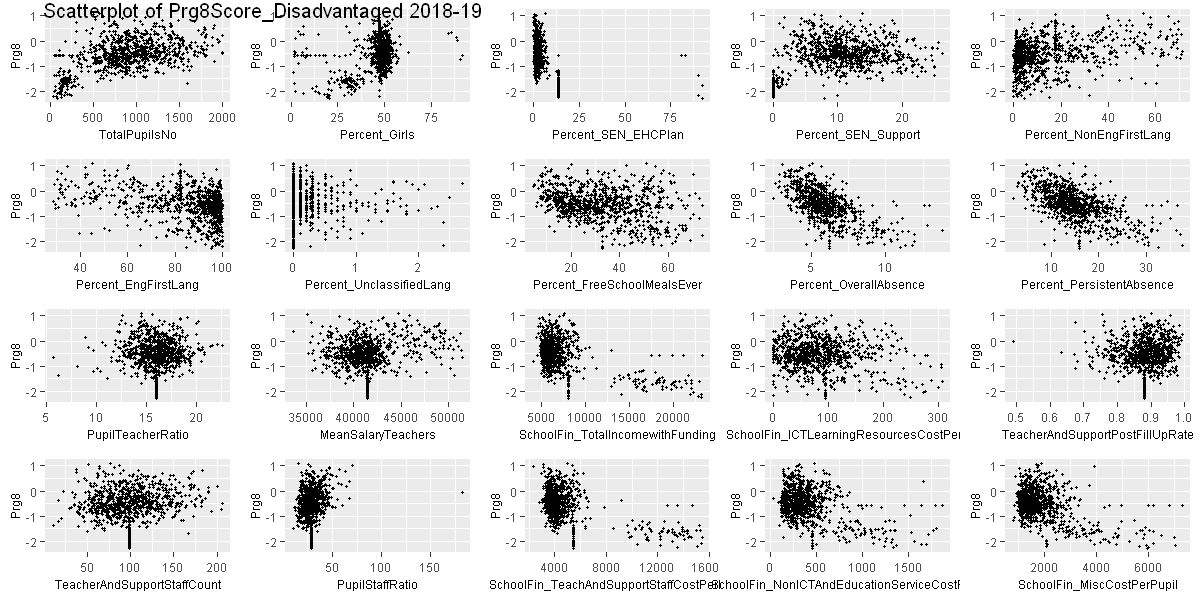

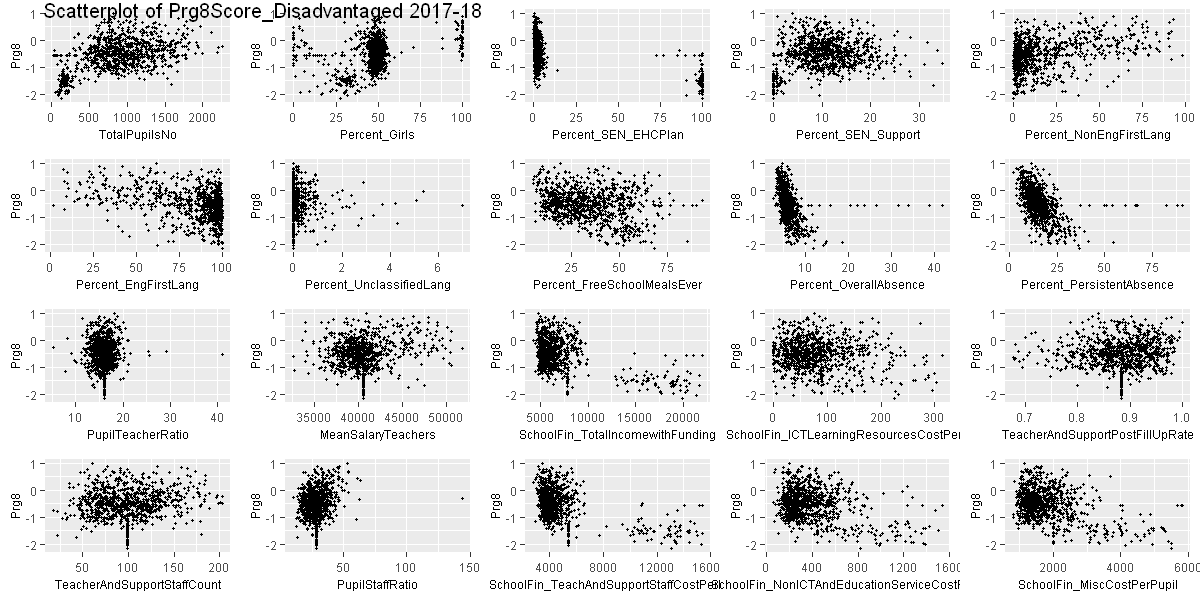

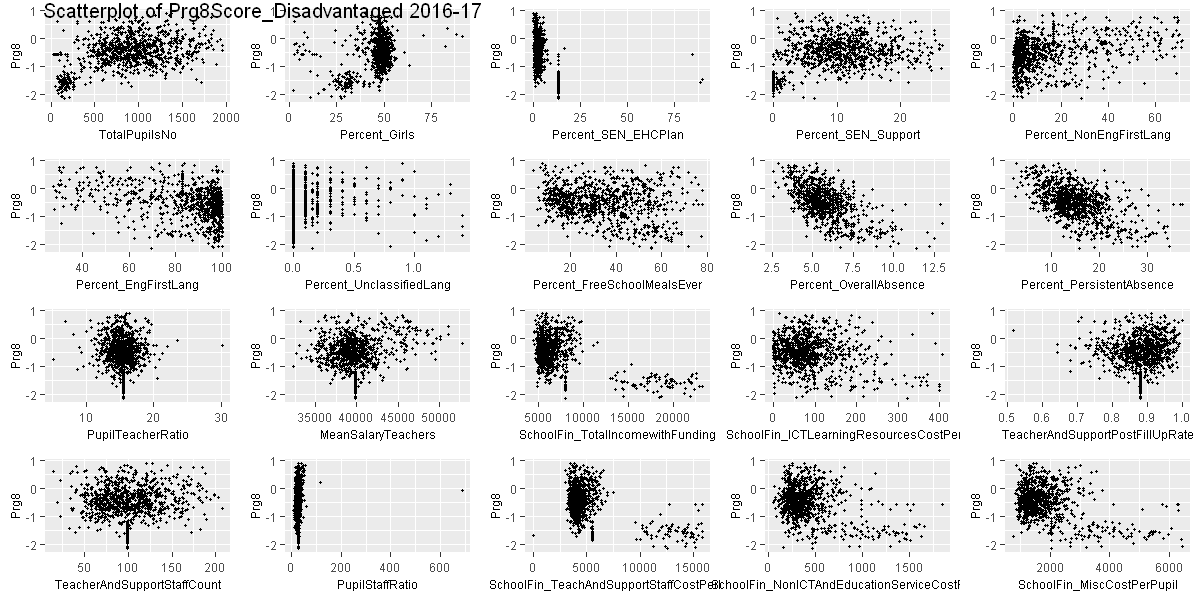

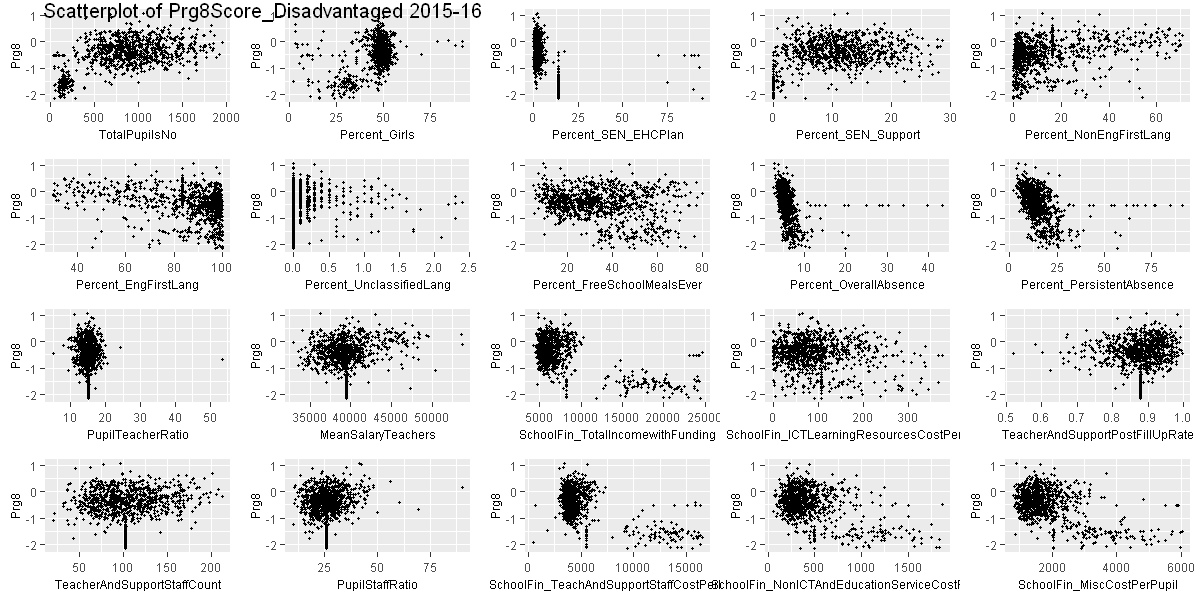

In [222]:
col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2018_19_encoded[, col_ordinal]
alist <-lapply(3:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Prg8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Prg8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist, label_x=200, label_y=60)
p + draw_figure_label(label = "Scatterplot of Prg8Score_Disadvantaged 2018-19", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2017_18_encoded[, col_ordinal]
alist <-lapply(3:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Prg8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Prg8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Prg8Score_Disadvantaged 2017-18", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2016_17_encoded[, col_ordinal]
alist <-lapply(3:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Prg8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Prg8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Prg8Score_Disadvantaged 2016-17", size = 12)


col_ordinal <- XY_col_dict[XY_col_dict$datatype==TYPE_ORDINAL, c('name')]
df <- XY_2015_16_encoded[, col_ordinal]
alist <-lapply(3:ncol(df),
              function(col) { 
                  g <- qplot(data=df,
                               x=df[,col_ordinal[col]], 
                               y=Prg8Score_Disadvantaged, 
                               geom = "point", 
                               xlab=colnames(df)[col],
                               ylab='Prg8',
                                size=I(0.5))
                  g + theme(axis.text=element_text(size=7),
                          axis.title=element_text(size=7)) 
                  })
p <- plot_grid(plotlist = alist)
p + draw_figure_label(label = "Scatterplot of Prg8Score_Disadvantaged 2015-16",  size = 12)

## 1.9 Export Prepared Data to CSV

In [223]:
write.csv(XY_2018_19_encoded,"XY_2018_19_encoded.csv", row.names = TRUE)
write.csv(XY_2017_18_encoded,"XY_2017_18_encoded.csv", row.names = TRUE)
write.csv(XY_2016_17_encoded,"XY_2016_17_encoded.csv", row.names = TRUE)
write.csv(XY_2015_16_encoded,"XY_2015_16_encoded.csv", row.names = TRUE)
write.csv(XY_col_dict,"XY_col_dict.csv", row.names = TRUE)

# 2. Modelling

## 2.1 Multiple Linear Regression

### Step 1. Fit the simple linear regression model and examine the singular columns, if any

In [224]:
# Let's first fit the 2018_19 data, with Att8Score_Disadvantaged as ouput
dataset <- XY_2018_19_encoded

exclucols <- c('Prg8Score_Disadvantaged')
outcolname <- 'Att8Score_Disadvantaged'
model <- FitLinearModel(dataset, outcolname, exclucols) 
nacols <- names(model$coefficients)[is.na(model$coefficients)]  

# Examine the singularities columns
for (col in nacols) {
    print(paste("% of ", col, ' in dataset', 100*sum(dataset[,col])/nrow(dataset)))
}

print('All these columns are heavility unbalanced and exlcuded from the fitting.')

# Check linear dependency on these columns
ld.vars <- attributes(alias(model)$Complete)$dimnames[[1]]
ld.vars 
# alias(model)$Complete

[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.28425821064553"
[1] "% of  SchoolReligionMuslim  in dataset 0.453001132502831"
[1] "% of  AdmissionPolicySelective  in dataset 1.81200453001132"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.07701019252548"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."


[1] "SCHOOLTYPEVoluntary.controlled.school"
[2] "SchoolReligionMuslim"                 
[3] "AdmissionPolicySelective"             
[4] "Ofsted_RatingSpecial.Measures"

**The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it.**

**Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,**
**i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the baseline**

In [225]:
# Let's first fit the 2018_19 data again and remove the linearly dependent columns, with Att8Score_Disadvantaged as ouput
dataset <- XY_2018_19_encoded

# Now fit the model again without the linearly dependent columns
model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols)) 
summary(model)
# confint(model)

rsqr_b4vif <- summary(model)$r.squared


Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0724  -3.1505  -0.3882   2.7467  29.5770 

Coefficients:
                                                        Estimate Std. Error
(Intercept)                                            5.079e+01  2.119e+01
TotalPupilsNo                                          2.493e-03  1.597e-03
Percent_Girls                                         -4.633e-02  2.308e-02
Percent_SEN_EHCPlan                                   -5.747e-03  3.104e-02
Percent_SEN_Support                                   -1.238e-01  4.363e-02
Percent_NonEngFirstLang                                1.267e-01  2.031e-01
Percent_EngFirstLang                                   8.689e-02  2.025e-01
Percent_UnclassifiedLang                              -6.577e-01  5.220e-01
Percent_FreeSchoolMealsEver                            3.175e-03  2.063e-02
Percent_OverallAbsence                                -5.548e-01  3.160e-01
Perc

### Step 2. Examine the collinearity of predicting variables using VIF

In [226]:
# First we examie the correlation coefficients among variables, only select those with cross correlation coef > 0.7
ds <- XY_2018_19_encoded
ds[, c(outcolname, exclucols, nacols)] <- NULL 

# Here we only interest in predicting variables. 
CorrMatrix <- cor(ds, use='complete.obs')
for (i in 1:nrow(CorrMatrix)){
    for (j in i:ncol(CorrMatrix)){
        if (CorrMatrix[i,j] >= 0.7 & i!=j)
            print(paste(CorrMatrix[i,j], rownames(CorrMatrix)[i], colnames(CorrMatrix)[j]))
    }
}

print('We can see that there are a number of columns with strong corr coef.')

[1] "0.917362238826381 Percent_OverallAbsence Percent_PersistentAbsence"
[1] "0.876181778064414 SchoolFin_TotalIncomewithFunding SchoolFin_TeachAndSupportStaffCostPerPupil"
[1] "0.760973772137055 SchoolFin_TotalIncomewithFunding SCHOOLTYPECommunity.special.school"
[1] "0.787789361642019 SchoolFin_TotalIncomewithFunding AdmissionPolicyNot.applicable"
[1] "0.765420387219206 SchoolFin_TeachAndSupportStaffCostPerPupil SCHOOLTYPECommunity.special.school"
[1] "0.779122415166443 SchoolFin_TeachAndSupportStaffCostPerPupil AdmissionPolicyNot.applicable"
[1] "0.723023278695695 SchoolFin_MiscCostPerPupil AdmissionPolicyNot.applicable"
[1] "0.86941628933877 SCHOOLTYPECommunity.special.school AdmissionPolicyNot.applicable"
[1] "0.90329493468761 SCHOOLTYPEVoluntary.aided.school SchoolReligionChurchofEngland_RomanCatholic_Christian"
[1] "We can see that there are a number of columns with strong corr coef."


[1] "Now we use CAR library to compute the VIF. "
[1] "Those columns of VIF greater than certain threshold should be considered as collinear and will affect the performance of the mode."
[1] "We try to vary such threshold over which the column will be excluded from a model,and then study the change of R squared"


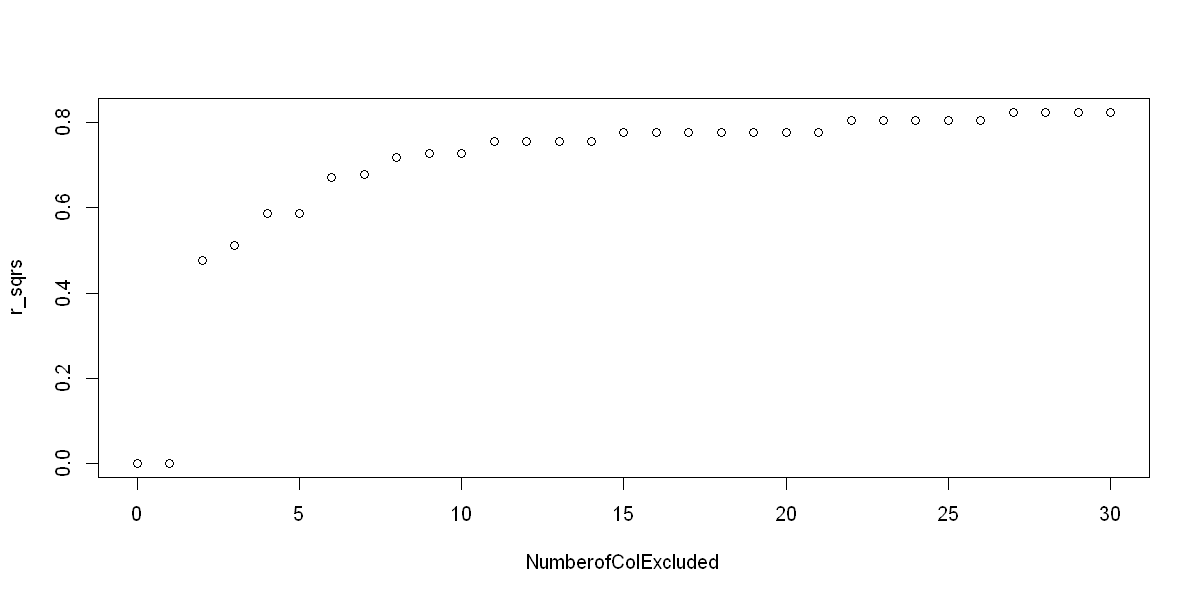

In [227]:
# Examine the VIF
print('Now we use CAR library to compute the VIF. ')
vifvect <- car::vif(model)

print('Those columns of VIF greater than certain threshold should be considered as collinear and will affect the performance of the mode.')
print('We try to vary such threshold over which the column will be excluded from a model,and then study the change of R squared')

# a loop to check the change in R Squared with different VIF threshold
vifcols <- c()
dataset <- XY_2018_19_encoded
model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols))   
r_sqrs <- c()
for (vifth in 30:0){ # threshold from 200 to 5
    vifvect <- car::vif(model)
    vifcols <- names(vifvect)[vifvect > vifth]
    model_shrunk <- FitLinearModel(dataset, outcolname, c(exclucols, nacols, vifcols))     
#     print(paste('Columns eliminated = ', length(vifcols), 'R-Squared =',summary(model_shrunk)$r.squared ))
    r_sqrs <- c(r_sqrs, summary(model_shrunk)$r.squared )
}

NumberofColExcluded <- 30:0
plot(NumberofColExcluded, r_sqrs)

**From the plot above, we can select the VIF threshold as 10, which marks the beginning of significant drop in R-Squared**


In [ ]:
VIF_THRESHOLD <- 10
print('So let us try to remove these columns as well, and fit the model again.')

dataset <- XY_2018_19_encoded
model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols))   
vifvect <- car::vif(model)
vifcols <- names(vifvect)[vifvect > VIF_THRESHOLD]
model <- FitLinearModel(dataset, outcolname, c(exclucols, nacols, vifcols)) 

print('The removed columns are:')
print(vifcols)

# summary(model)

In [230]:
print('Those columns with significance level > 95% are:')
signcol <- summary(model)$coefficients[,4]<0.05

predictors_by_vif <- summary(model)$coefficients[signcol, ]
predictors_by_vif

rsqr_aftervif <- summary(model)$r.squared

[1] "Those columns with significance level > 95% are:"


Estimate      Std. Error   t value  
(Intercept)                                32.4069088430 6.473832e+00  5.005831
Percent_SEN_EHCPlan                        -0.1919154102 3.757037e-02 -5.108158
Percent_OverallAbsence                     -1.8629157242 3.907902e-01 -4.767048
PupilTeacherRatio                          -0.6940634042 1.526451e-01 -4.546909
MeanSalaryTeachers                          0.0004419727 9.117857e-05  4.847331
PupilStaffRatio                             0.0878589759 2.818193e-02  3.117565
SchoolFin_TeachAndSupportStaffCostPerPupil -0.0017153258 2.116035e-04 -8.106320
SchoolFin_MiscCostPerPupil                 -0.0015157777 3.910645e-04 -3.876030
SchoolReligionJewish                       10.3167049424 3.460079e+00  2.981638
AdmissionPolicyNon.selective                6.8033238568 1.290230e+00  5.272954
Ofsted_RatingGood                           3.1395198910 1.201127e+00  2.613812
Ofsted_RatingOutstanding                    7.2602113233 1.370076e+00  5.299130
                                           Pr(>|t|)    
(Intercept)                                6.753624e-07
Percent_SEN_EHCPlan                        4.012082e-07
Percent_OverallAbsence                     2.196209e-06
PupilTeacherRatio                          6.228189e-06
MeanSalaryTeachers                         1.485699e-06
PupilStaffRatio                            1.884458e-03
SchoolFin_TeachAndSupportStaffCostPerPupil 1.797265e-15
SchoolFin_MiscCostPerPupil                 1.142918e-04
SchoolReligionJewish                       2.948350e-03
AdmissionPolicyNon.selective               1.701077e-07
Ofsted_RatingGood                          9.111092e-03
Ofsted_RatingOutstanding                   1.481086e-07

In [231]:
paste('The R squared from before VIF:',rsqr_b4vif )
paste('The R squared from after VIF:',rsqr_aftervif )

[1] "The R squared from before VIF: 0.831129723371242"

[1] "The R squared from after VIF: 0.728057171165552"

### Step 3. Perform Variable Selection

In [232]:
# Use validation set approach for model selection
print('We also use validation set approach to select optimum subset of predicting variables.')
set.seed(1)
train=sample(c(TRUE ,FALSE), nrow(dataset),rep=TRUE)
test=(!train)

dataset <- XY_2018_19_encoded
dataset[, c(exclucols, nacols, vifcols)] <- NULL ## excluding the columns 
for (col in names(dataset))  # rescale the columns
    dataset[,col] <- Nrescale(dataset[,col])

# print('Based on the VIF shrinking of predicting variables, we set 
# the maximum number of predictors to incorporate in the model, nvmax, at 12, 
# which is the number of significant variables returned in VIF shrinking approach.')

print('We set the he maximum number of predictors to incorporate in the model, nvmax, to be the 
total number of predicting variables in the model first.  And then select using test set validation.')

MAX_MODEL_SIZE <- ncol(dataset) - 1

regfit.best <- regsubsets(Att8Score_Disadvantaged~.,
                       data=dataset[train,], nvmax = MAX_MODEL_SIZE)

test.mat <- model.matrix(Att8Score_Disadvantaged~.,data=dataset[test,])

# Compute the MSE in the test set, and select the best models with minimum test MSE
val.errors =rep(NA ,MAX_MODEL_SIZE)
for(i in 1:MAX_MODEL_SIZE){
    coefi <- coef(regfit.best ,id=i)
    pred <- test.mat[,names(coefi)]%*%coefi
    val.errors[i]= mean(( dataset$Att8Score_Disadvantaged[test]-pred)^2)
}


[1] "We also use validation set approach to select optimum subset of predicting variables."
[1] "We set the he maximum number of predictors to incorporate in the model, nvmax, to be the \ntotal number of predicting variables in the model first.  And then select using test set validation."


[1] "We plot the change in the validation error, which the MSE of the testing \nset of the corresponding model size. "
[1] "It can be seen than the minimum MSE error occurs at model size =  13"


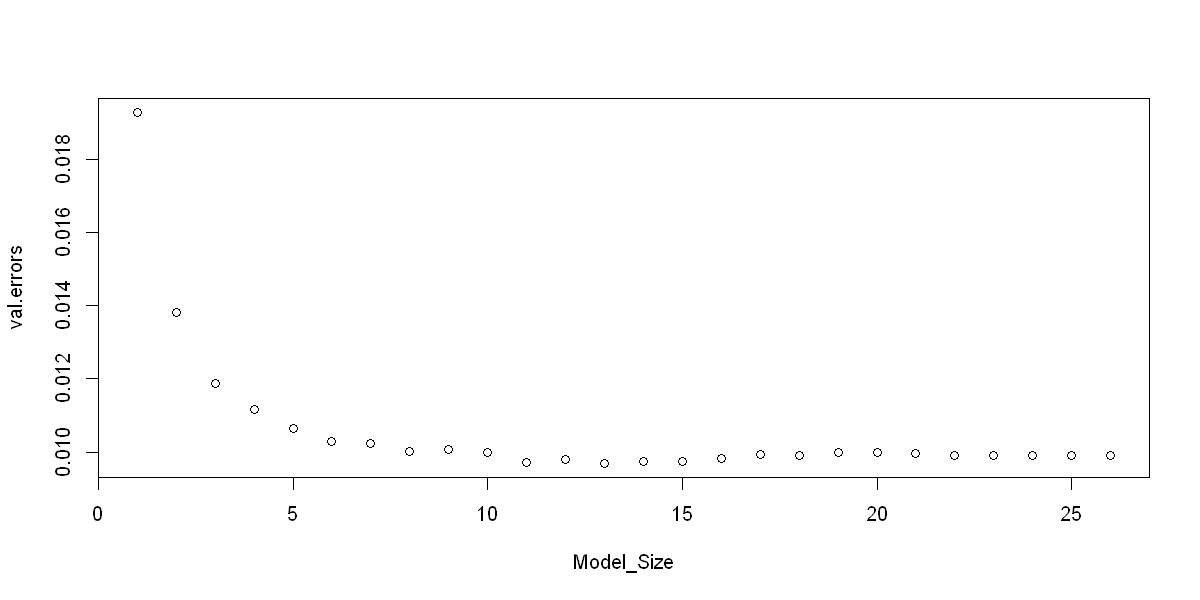

In [233]:
# length(val.errors) 

print('We plot the change in the validation error, which the MSE of the testing 
set of the corresponding model size. ')
Model_Size <- 1:MAX_MODEL_SIZE
plot(Model_Size, val.errors)

print(paste('It can be seen than the minimum MSE error occurs at model size = ',
            which.min(val.errors)))

In [234]:
print('The corresponding coefficients are:')
coef(regfit.best,id=which.min(val.errors))

[1] "The corresponding coefficients are:"


(Intercept) 
                                0.58987038 
                       Percent_SEN_EHCPlan 
                               -0.22150253 
                    Percent_OverallAbsence 
                               -0.38218625 
                         PupilTeacherRatio 
                               -0.13875939 
                        MeanSalaryTeachers 
                                0.11195918 
SchoolFin_ICTLearningResourcesCostPerPupil 
                               -0.05383949 
                           PupilStaffRatio 
                                0.25333032 
SchoolFin_TeachAndSupportStaffCostPerPupil 
                               -0.31958778 
                SchoolFin_MiscCostPerPupil 
                               -0.07638309 
               SCHOOLTYPEFoundation.school 
                                0.01771003 
                      SchoolReligionJewish 
                                0.12210159 
              AdmissionPolicyNon.selective 
                                0.13842547 
                         Ofsted_RatingGood 
                                0.01574389 
                  Ofsted_RatingOutstanding 
                                0.08197776

In [235]:
print('Since the above subset is picked using the training data set, even though
the MSE is computed in testing set. We should perform best subset selection on the full data set, and select
the best 13-variable model. It is important that we make use of the full
data set in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best 13-variable
model, rather than simply using the variables that were obtained
from the training set, because the best ten-variable model on the full data
set may differ from the corresponding model on the training set.')

dataset <- XY_2018_19_encoded
dataset[, c(exclucols, nacols, vifcols)] <- NULL 
## excluding the columns 
# rescale the columns
for (col in names(dataset))  
    dataset[,col] <- Nrescale(dataset[,col])

regfit.best <- regsubsets(Att8Score_Disadvantaged~.,
                       data=dataset, nvmax = MAX_MODEL_SIZE)


predictors_by_crossval <- coef(regfit.best,id=which.min(val.errors))

[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best 13-variable model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best 13-variable\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."


In [236]:
print('We can compare the predictors selected using VIF with those from validation approach')

vec1 <- rownames(predictors_by_vif)
names(vec1) <- 1:length(vec1)

vec2 <- names(predictors_by_crossval)
names(vec2) <- 1:length(vec2)

data_rbind <- t(as.data.frame(bind_rows(vec1, vec2)))  # Bind as rows
colnames(data_rbind) <- c('By VIF Approach', 'By Cross Validation Approach') 
data_rbind

[1] "We can compare the predictors selected using VIF with those from validation approach"


By VIF Approach                           
1  (Intercept)                               
2  Percent_SEN_EHCPlan                       
3  Percent_OverallAbsence                    
4  PupilTeacherRatio                         
5  MeanSalaryTeachers                        
6  PupilStaffRatio                           
7  SchoolFin_TeachAndSupportStaffCostPerPupil
8  SchoolFin_MiscCostPerPupil                
9  SchoolReligionJewish                      
10 AdmissionPolicyNon.selective              
11 Ofsted_RatingGood                         
12 Ofsted_RatingOutstanding                  
13 NA                                        
14 NA                                        
   By Cross Validation Approach              
1  (Intercept)                               
2  Percent_SEN_EHCPlan                       
3  Percent_SEN_Support                       
4  Percent_OverallAbsence                    
5  PupilTeacherRatio                         
6  MeanSalaryTeachers                        
7  SchoolFin_ICTLearningResourcesCostPerPupil
8  PupilStaffRatio                           
9  SchoolFin_TeachAndSupportStaffCostPerPupil
10 SchoolFin_MiscCostPerPupil                
11 SchoolReligionJewish                      
12 AdmissionPolicyNon.selective              
13 Ofsted_RatingGood                         
14 Ofsted_RatingOutstanding

### 2.1.1 Analysis of Attainment 8 Score Across Multiple Years

In [237]:
coeffs_summary <- data.frame()

In [238]:
cols <- c('Model_Year', 'Analysis', 'OutputVar', 'Input_Year','R_squared', 'MAE', 'RMSE')
crossyear_pred_summary <- data.frame()
crossyear_vif_rsqr_summary <- data.frame(VarCount=30:0)
crossyear_crossval_summary <- data.frame(VarCount=1:45)

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.28425821064553"
[1] "% of  SchoolReligionMuslim  in dataset 0.453001132502831"
[1] "% of  AdmissionPolicySelective  in dataset 1.81200453001132"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.07701019252548"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

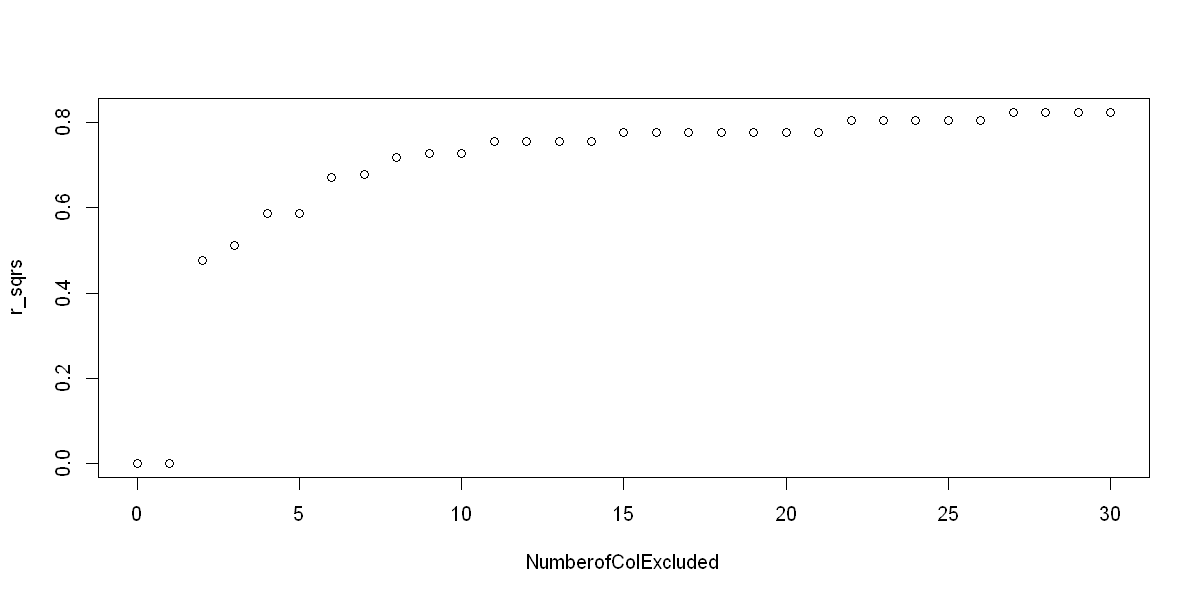

[1] "It can be seen than the minimum MSE error occurs at model size =  13"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2018_19 Att8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.256  -3.690  -0.522   3.185  31.826 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 4.089e+01  4.953e+00   8.255
Percent_SEN_EHCPlan                        -1.936e-01  3.639e-02  -5.320
Percent_OverallAbsence                     -2.091e+00  1.888e-01 -11.077
PupilTeacherRatio                          -6.875e-01  1.394e-01  -4.931
MeanSalaryTeachers                          4.282e-04  8.589e-05   4.986
PupilStaffRatio                             8.647e-02  2.674e-02   3.234
SchoolFin_TeachAndSupportStaffCostPerPupil -1.755e-03  1.516e-04 -11.578
SchoolFin_MiscCostPerPupil                 -1.556e-03  3.478e-04  -4.472
SchoolReligionJewish                        9.589e+00  3.382e+00   2.836
AdmissionPolicyNon.selective                7.919e+00  1.109e+00   7.139
Ofsted_RatingGood                           1.6

[1] "****Fitted model for 2018_19 Att8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.3302  -3.5989  -0.5903   3.2821  31.4122 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 3.973e+01  5.026e+00   7.905
Percent_SEN_EHCPlan                        -2.013e-01  3.673e-02  -5.480
Percent_SEN_Support                         6.226e-02  5.001e-02   1.245
Percent_OverallAbsence                     -2.100e+00  1.888e-01 -11.127
PupilTeacherRatio                          -6.666e-01  1.421e-01  -4.693
MeanSalaryTeachers                          4.515e-04  8.697e-05   5.191
SchoolFin_ICTLearningResourcesCostPerPupil -6.208e-03  4.191e-03  -1.481
PupilStaffRatio                             8.748e-02  2.691e-02   3.251
SchoolFin_TeachAndSupportStaffCostPerPupil -1.723e-03  1.529e-04 -11.269
SchoolFin_MiscCostPerPupil                 -1.489e-03  3.492e-04  -4.265
SchoolReligionJewish                 

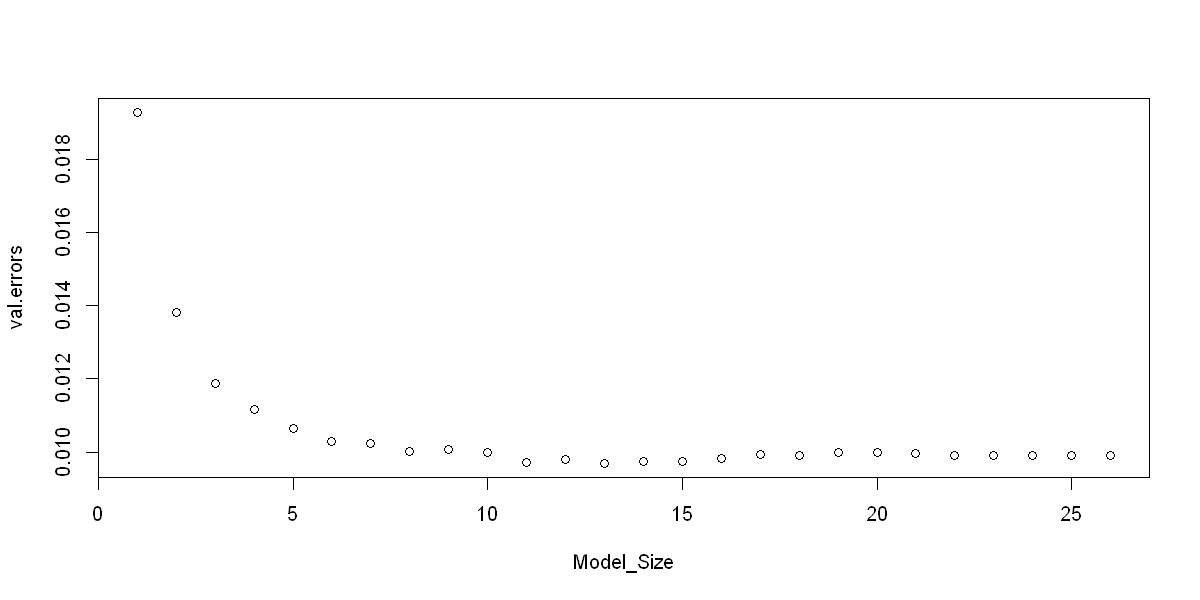

[1] "R-squared:  0.725031220493376"
[1] "MAE:  4.72944212996229"
[1] "RMSE:  6.65091365878147"


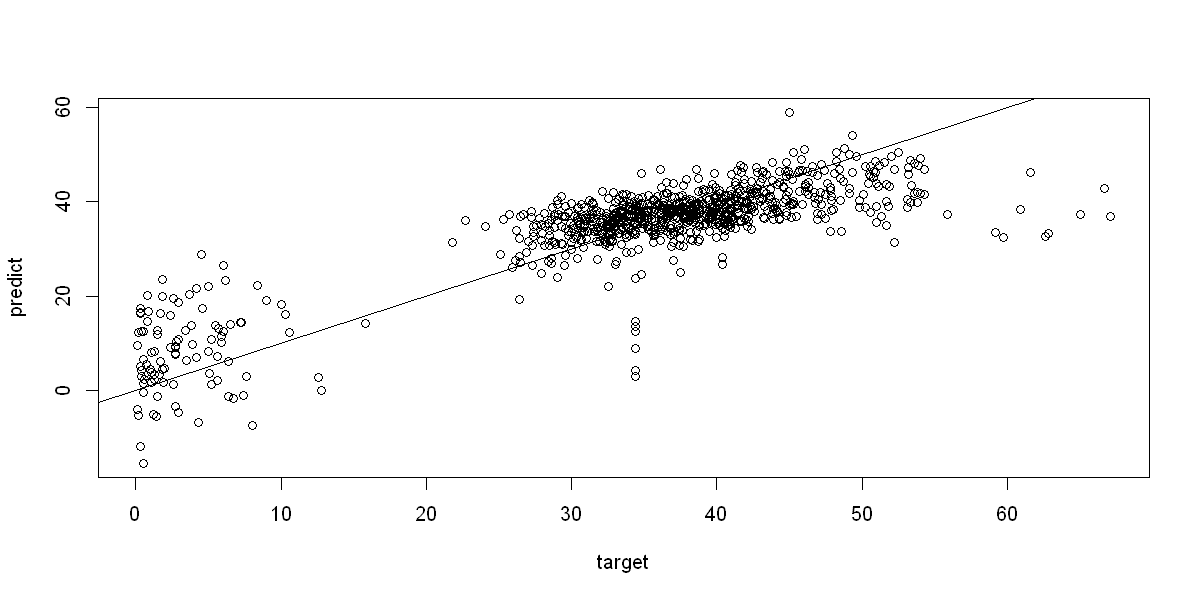

[1] "R-squared:  -0.128283398158468"
[1] "MAE:  6.57787932269299"
[1] "RMSE:  11.8071042581176"


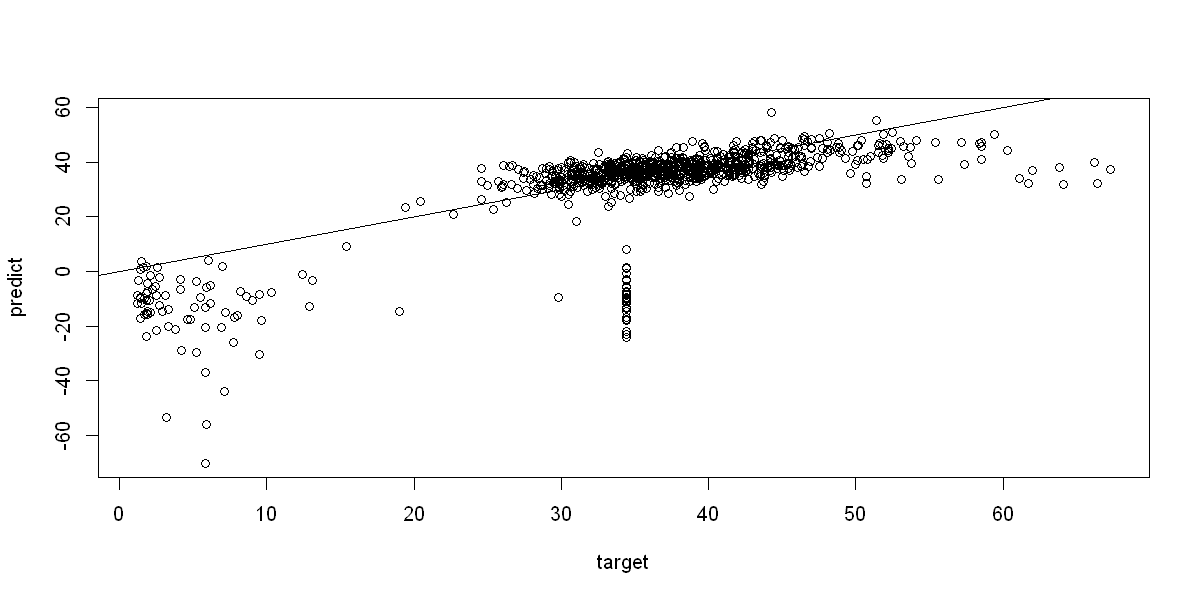

[1] "R-squared:  0.476370113039797"
[1] "MAE:  5.40777913789952"
[1] "RMSE:  8.25732773945186"


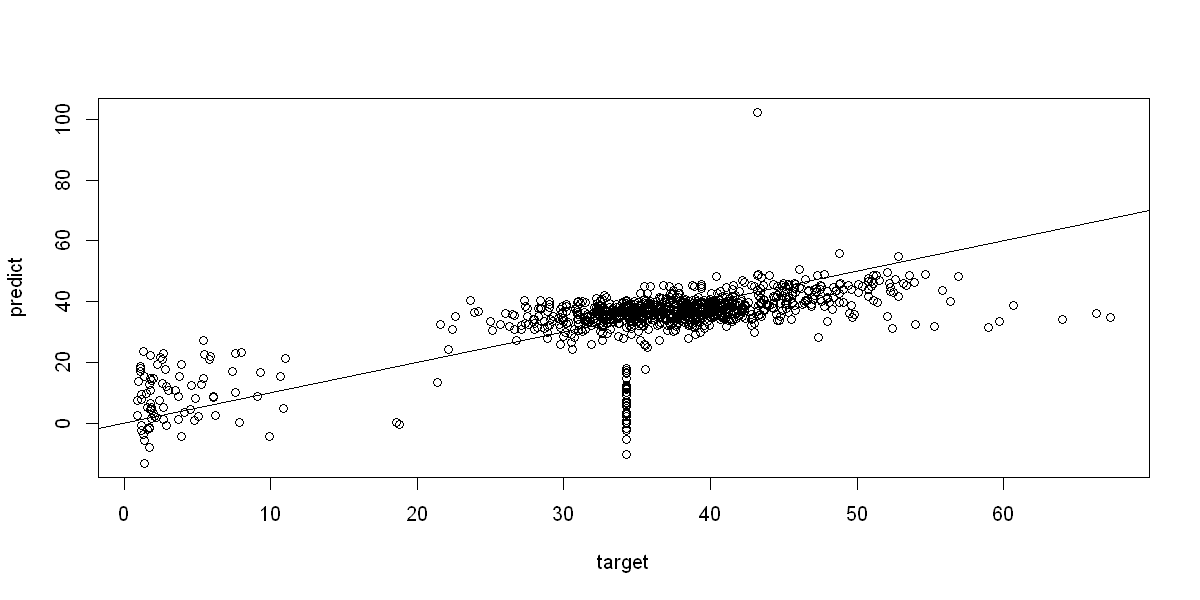

[1] "R-squared:  -0.214405702304687"
[1] "MAE:  8.06378252073445"
[1] "RMSE:  12.1253696398146"


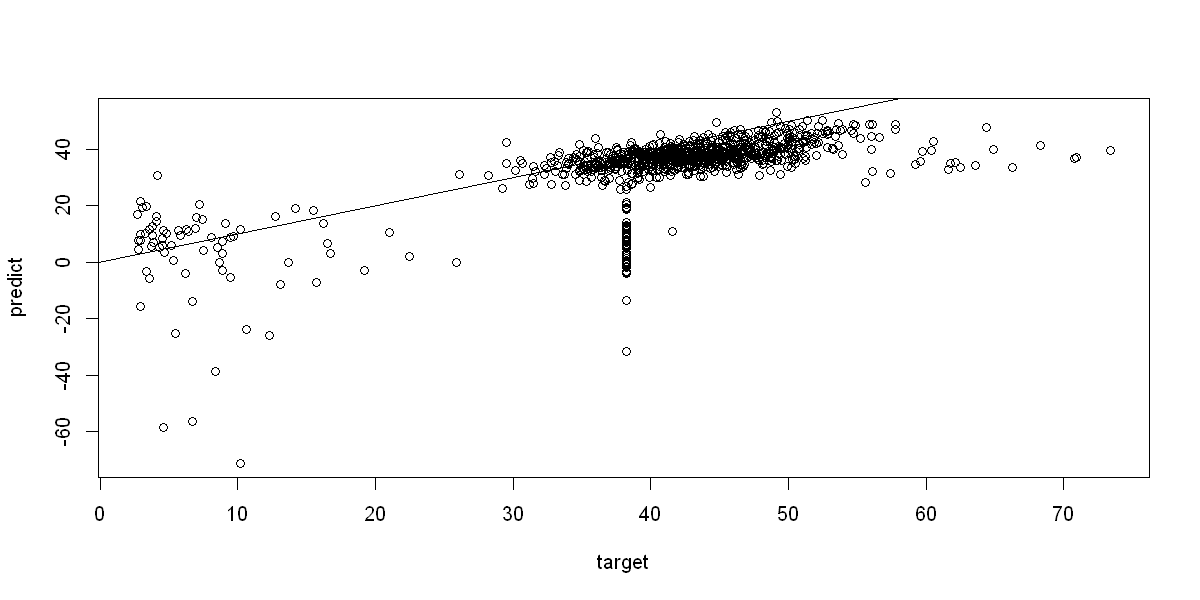

In [239]:
# 2018-19
ls <- LinearRegressionAnalysis(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', FALSE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Att8_2018_19 <- unlist(ls[3])
crossyear_crossval_summary$Att8_2018_19 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))

print('****Fitted model for 2018_19 Att8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2018_19_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2018_19', 'VIF', 'Att8')


print('****Fitted model for 2018_19 Att8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2018_19_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2018_19', 'CrossVal', 'Att8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)


ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Att8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Att8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Att8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Att8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)



[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.02375809935205"
[1] "% of  SchoolReligionMuslim  in dataset 0.431965442764579"
[1] "% of  AdmissionPolicySelective  in dataset 1.72786177105832"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.96760259179266"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

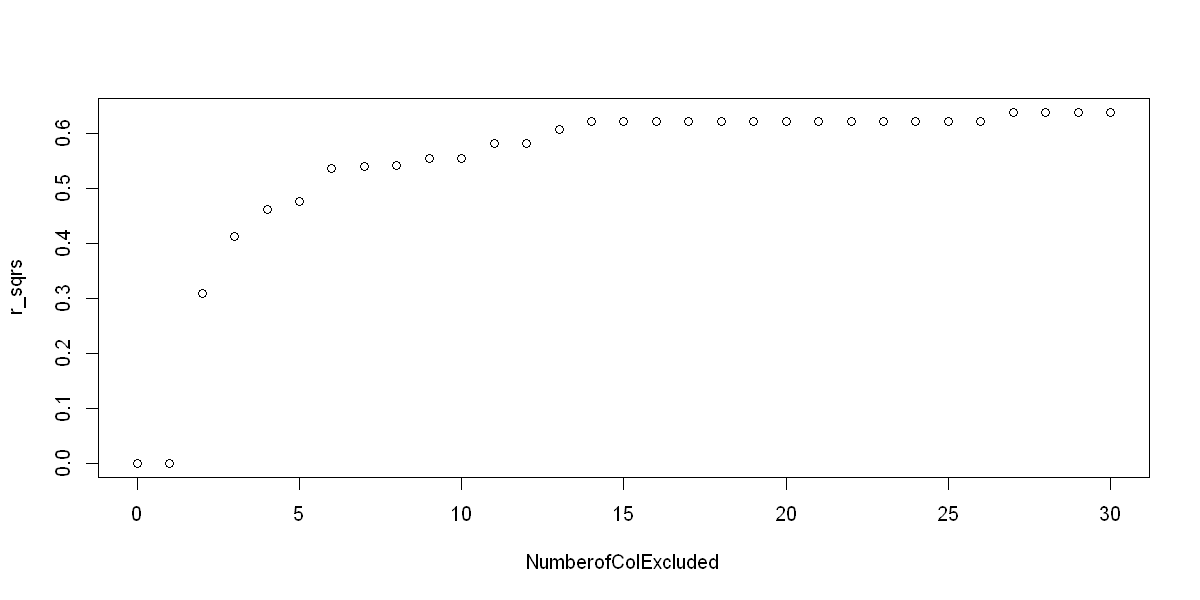

[1] "It can be seen than the minimum MSE error occurs at model size =  18"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2017_18 Att8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.940  -4.163  -0.639   3.691  35.588 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                -1.600e+00  6.125e+00  -0.261
Percent_Girls                               8.813e-02  1.543e-02   5.713
Percent_FreeSchoolMealsEver                -1.286e-01  2.214e-02  -5.809
PupilTeacherRatio                          -4.896e-01  1.379e-01  -3.549
MeanSalaryTeachers                          5.884e-04  9.797e-05   6.005
SchoolFin_TotalIncomewithFunding           -4.111e-04  1.718e-04  -2.393
TeacherAndSupportPostFillUpRate             1.935e+01  5.186e+00   3.731
PupilStaffRatio                             8.329e-02  3.454e-02   2.411
SchoolFin_TeachAndSupportStaffCostPerPupil -1.072e-03  2.387e-04  -4.493
SchoolReligionJewish                        8.379e+00  3.811e+00   2.198
AdmissionPolicyNon.selective                7.8

[1] "****Fitted model for 2017_18 Att8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.602  -4.144  -0.577   3.666  35.011 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -3.117e+00  6.355e+00  -0.491
Percent_Girls                                    8.916e-02  1.553e-02   5.742
Percent_SEN_Support                              4.496e-02  5.021e-02   0.895
Percent_FreeSchoolMealsEver                     -1.240e-01  2.332e-02  -5.318
PupilTeacherRatio                               -4.644e-01  1.396e-01  -3.326
MeanSalaryTeachers                               5.977e-04  9.889e-05   6.044
SchoolFin_TotalIncomewithFunding                -3.855e-04  1.816e-04  -2.123
SchoolFin_ICTLearningResourcesCostPerPupil      -6.381e-03  4.751e-03  -1.343
TeacherAndSupportPostFillUpRate                  2.008e+01  5.195e+00   3.866
PupilStaffRatio                                  7.919e-02  3.498e-02 

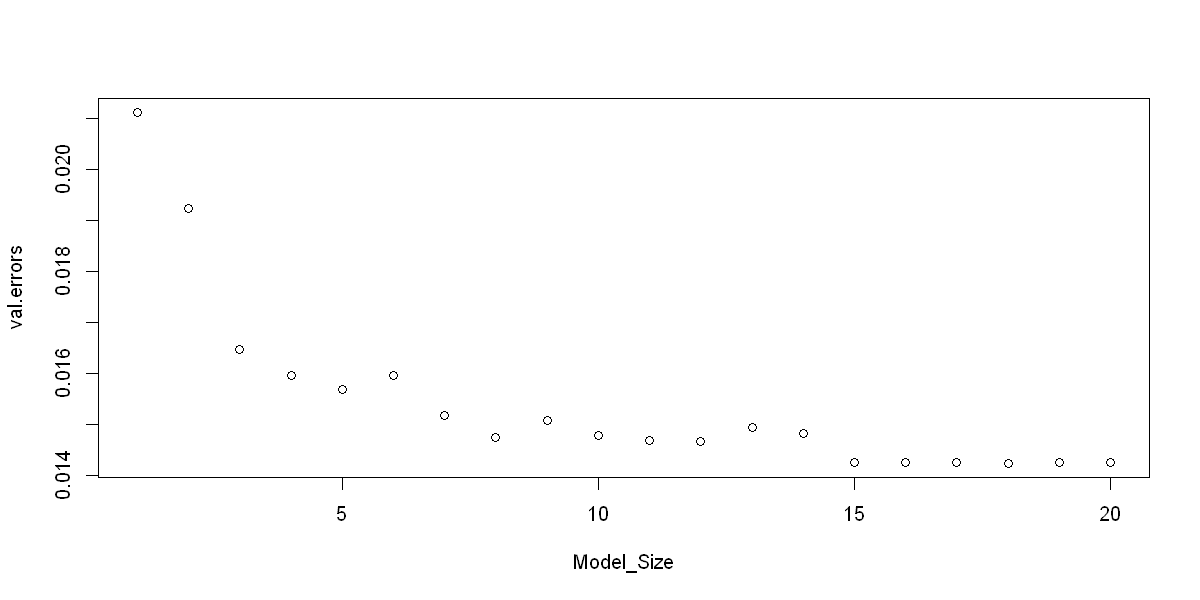

[1] "R-squared:  0.613844640670914"
[1] "MAE:  5.69273278594854"
[1] "RMSE:  7.88171360939876"


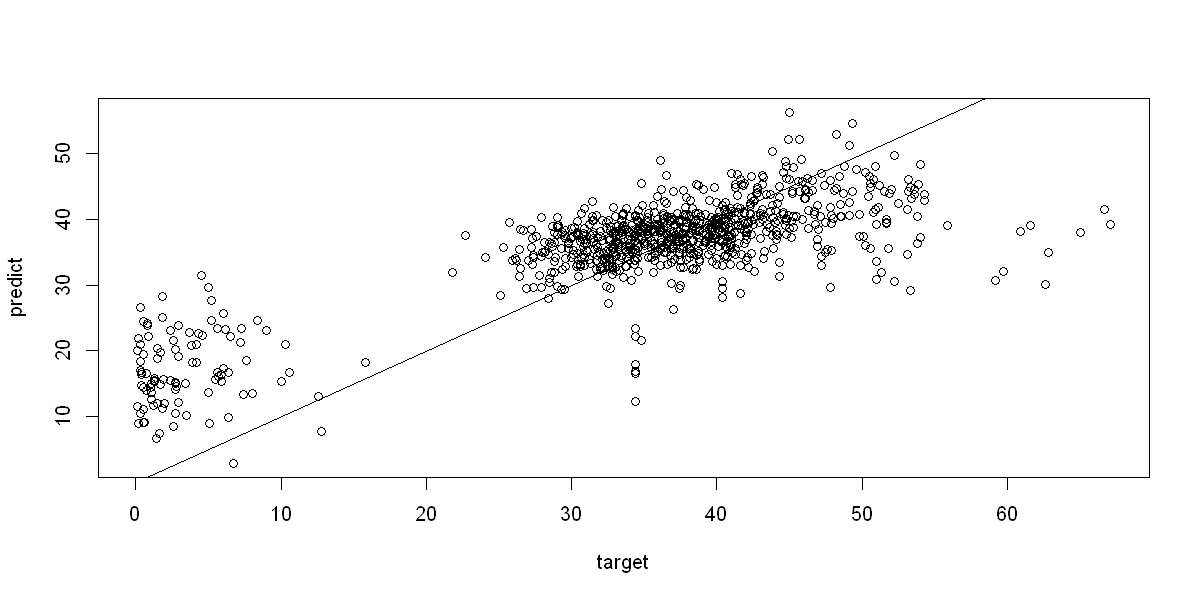

[1] "R-squared:  0.5553937543876"
[1] "MAE:  5.36247878556872"
[1] "RMSE:  7.41177247160043"


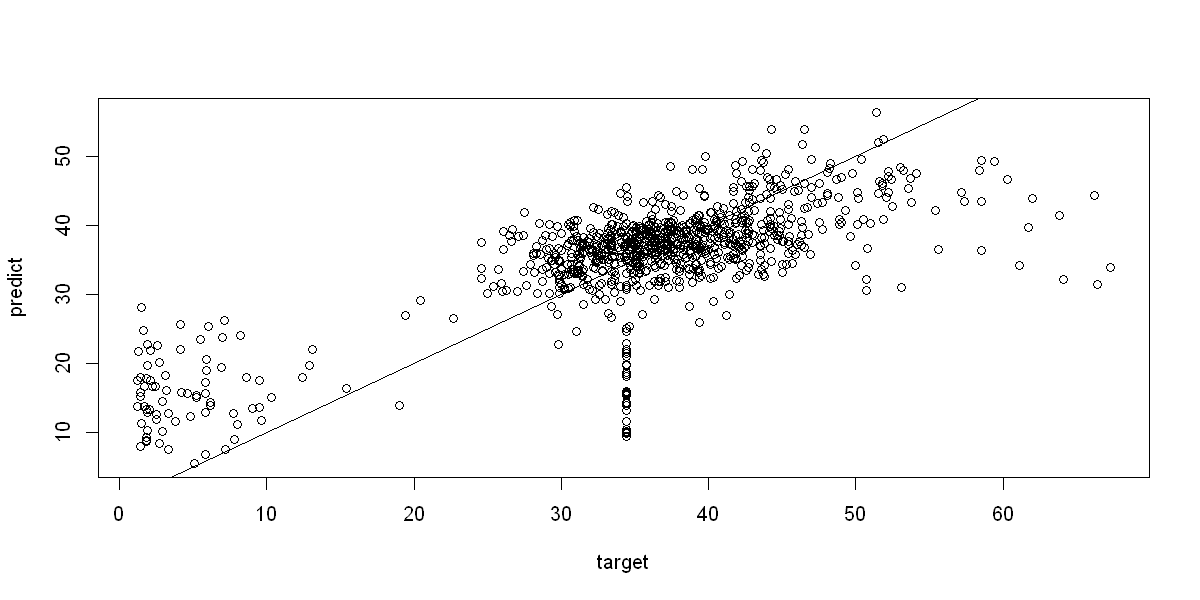

[1] "R-squared:  0.473931957413064"
[1] "MAE:  5.80258157457614"
[1] "RMSE:  8.27652953569426"


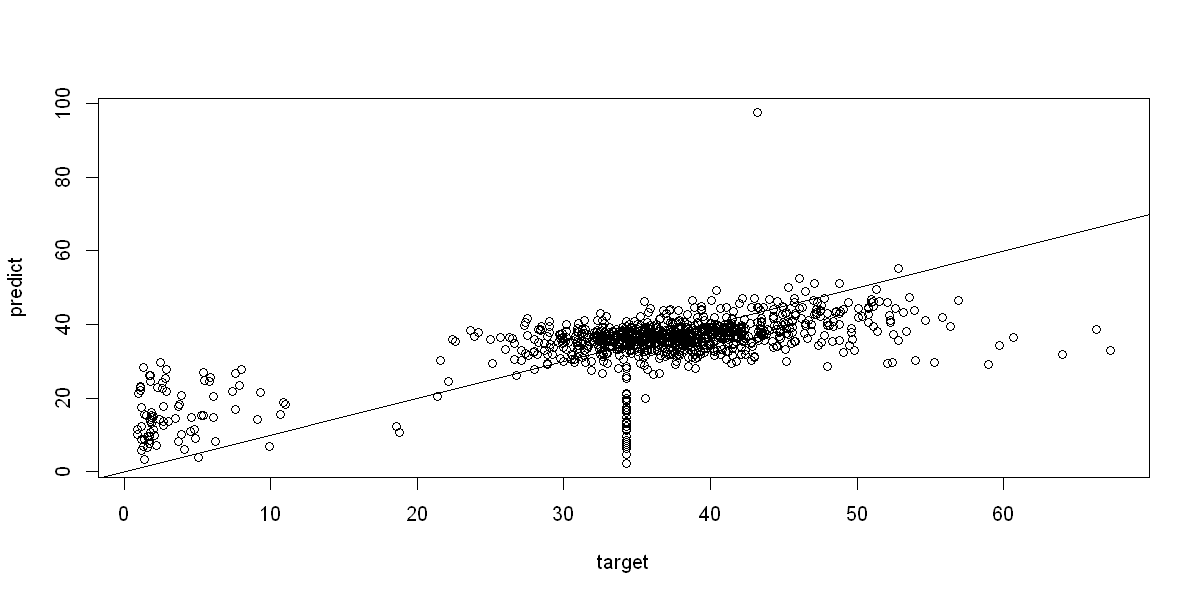

[1] "R-squared:  0.059486861019251"
[1] "MAE:  8.28849946055694"
[1] "RMSE:  10.6707641607666"


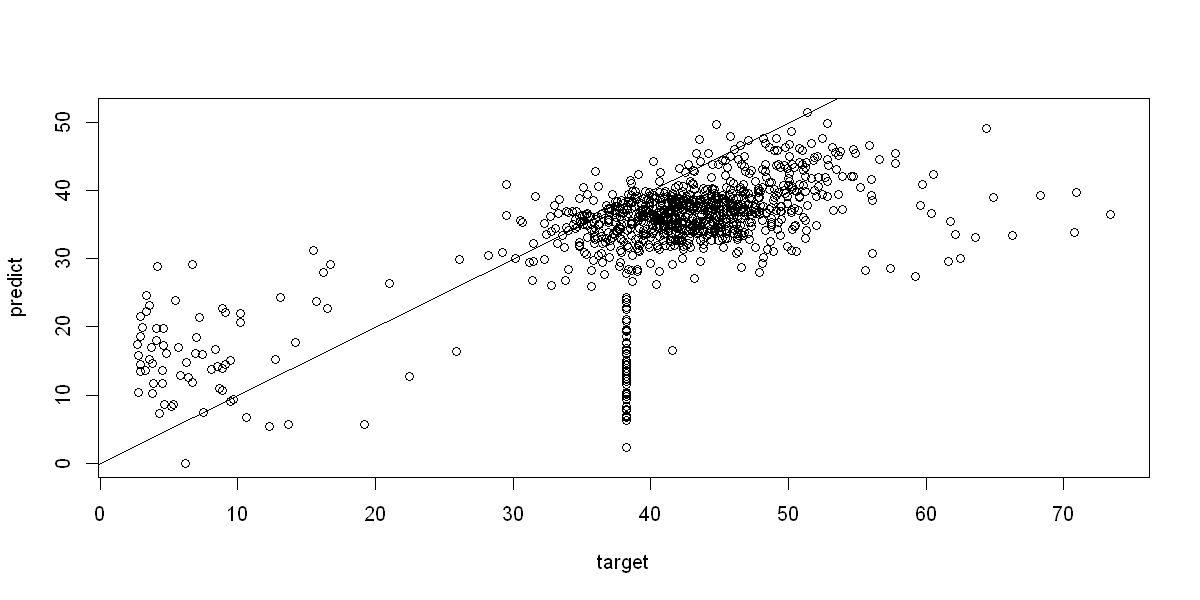

In [240]:
# 2017-18
ls <- LinearRegressionAnalysis(XY_2017_18_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', FALSE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Att8_2017_18 <- unlist(ls[3])
crossyear_crossval_summary$Att8_2017_18 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))


print('****Fitted model for 2017_18 Att8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2017_18_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2017_18', 'VIF', 'Att8')

print('****Fitted model for 2017_18 Att8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2017_18_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2017_18', 'CrossVal', 'Att8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)



ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Att8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


#### use 2017-18 to predict 2018-19###########
predAtt8_1718_1819 <- data.frame(VarCount=1:length(XY_2018_19_encoded$Att8Score_Disadvantaged))
predAtt8_1718_1819$pred <- predict(model, newdata=XY_2018_19_encoded[,pred_crossval])
predAtt8_1718_1819$orig <- XY_2018_19_encoded$Att8Score_Disadvantaged
#############################################


ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Att8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Att8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Att8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)



[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.01399354144241"
[1] "% of  SchoolReligionMuslim  in dataset 0.430570505920344"
[1] "% of  AdmissionPolicySelective  in dataset 1.61463939720129"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.95156081808396"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

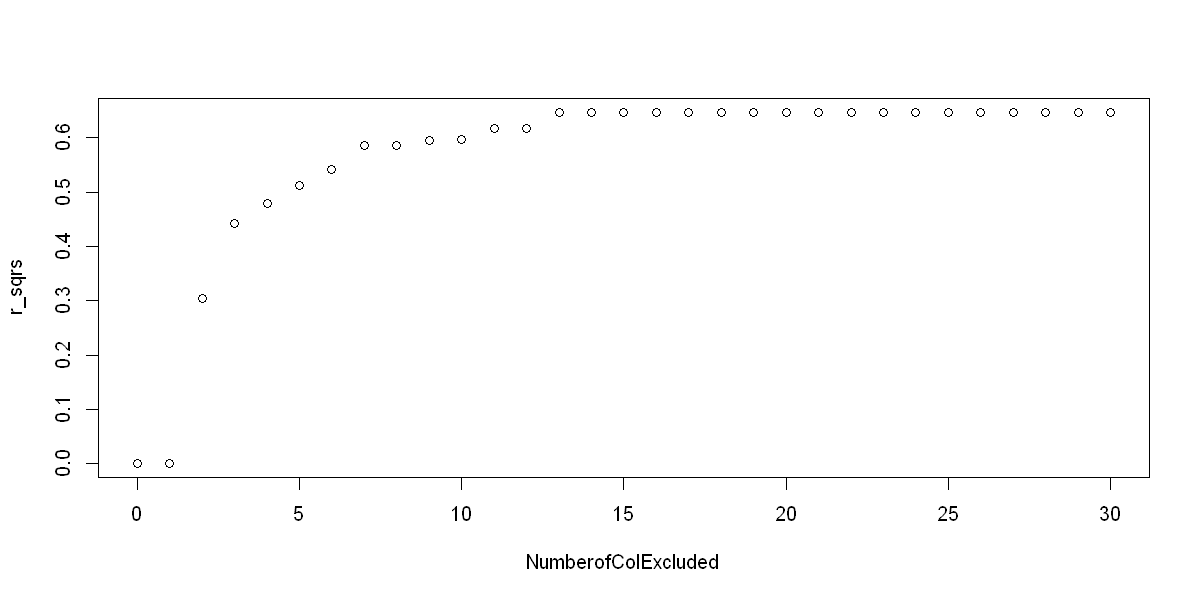

[1] "It can be seen than the minimum MSE error occurs at model size =  11"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2016_17 Att8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.3231  -3.8340  -0.1118   3.7516  30.6686 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 3.052e+01  4.995e+00   6.109
Percent_Girls                               9.092e-02  3.057e-02   2.974
Percent_SEN_EHCPlan                        -5.180e-01  4.949e-02 -10.466
Percent_SEN_Support                         1.525e-01  4.636e-02   3.290
Percent_PersistentAbsence                  -5.904e-01  5.203e-02 -11.348
PupilTeacherRatio                          -3.784e-01  1.413e-01  -2.677
MeanSalaryTeachers                          5.365e-04  9.116e-05   5.886
SchoolFin_ICTLearningResourcesCostPerPupil -1.683e-02  3.844e-03  -4.378
SchoolFin_TeachAndSupportStaffCostPerPupil -1.021e-03  1.347e-04  -7.583
SchoolReligionJewish                        1.260e+01  4.323e+00   2.914
Ofsted_RatingOutstanding             

[1] "****Fitted model for 2016_17 Att8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.6505  -3.9085  -0.0508   3.8730  30.4850 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 2.918e+01  5.018e+00   5.814
Percent_Girls                               9.215e-02  3.050e-02   3.021
Percent_SEN_EHCPlan                        -5.222e-01  4.941e-02 -10.568
Percent_SEN_Support                         1.601e-01  4.637e-02   3.453
Percent_PersistentAbsence                  -5.602e-01  5.357e-02 -10.456
PupilTeacherRatio                          -3.969e-01  1.413e-01  -2.810
MeanSalaryTeachers                          5.403e-04  9.096e-05   5.940
SchoolFin_ICTLearningResourcesCostPerPupil -1.771e-02  3.855e-03  -4.593
SchoolFin_TeachAndSupportStaffCostPerPupil -1.043e-03  1.347e-04  -7.745
SchoolReligionJewish                        1.283e+01  4.314e+00   2.974
Ofsted_RatingGood                    

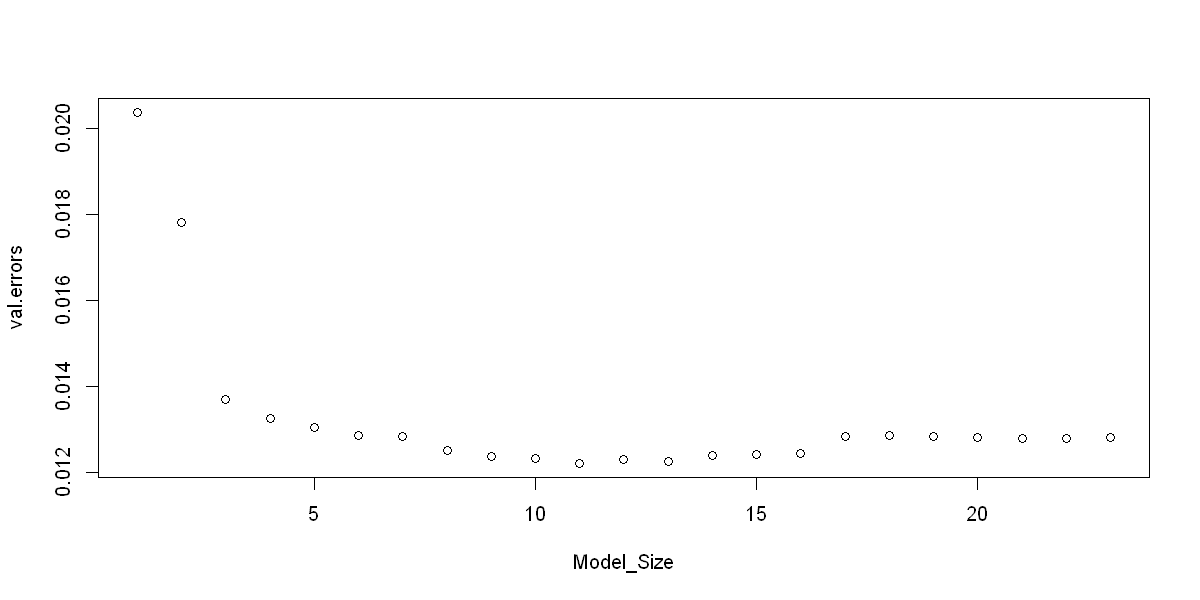

[1] "R-squared:  0.630769216058276"
[1] "MAE:  5.56340857984803"
[1] "RMSE:  7.70705694949389"


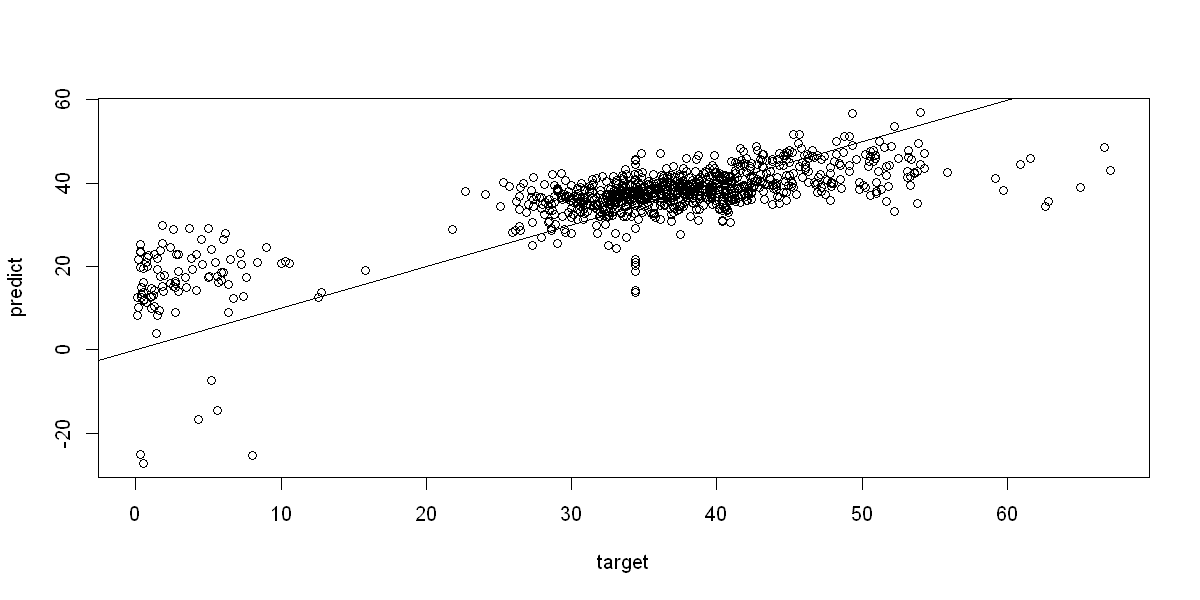

[1] "R-squared:  -1.22480241286509"
[1] "MAE:  8.72453423750942"
[1] "RMSE:  16.5798280679008"


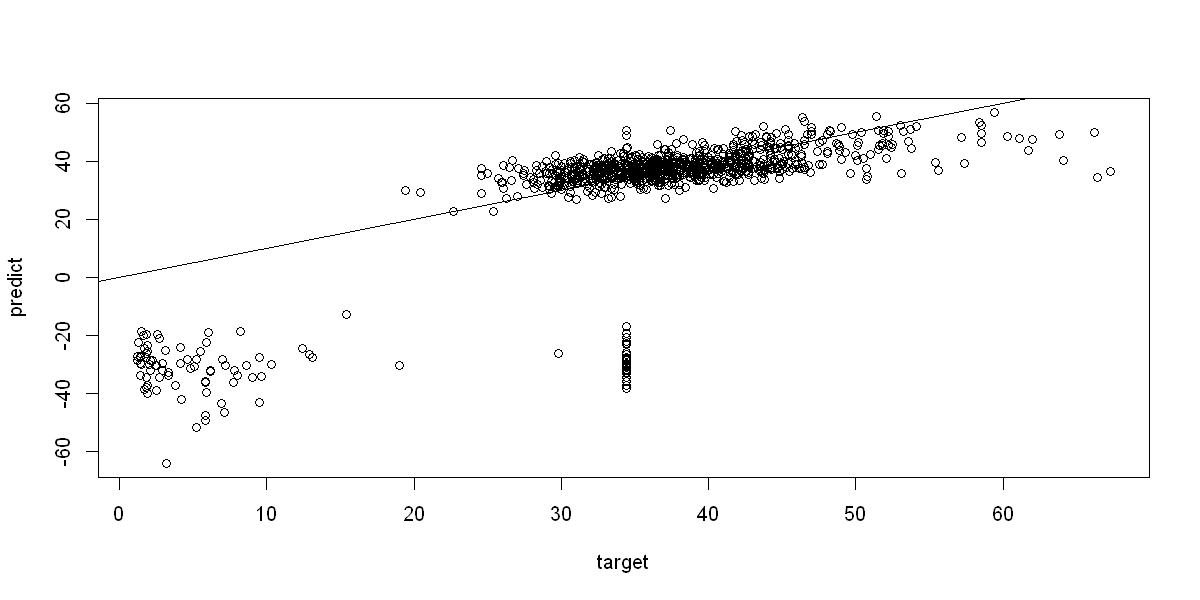

[1] "R-squared:  0.581438975136687"
[1] "MAE:  5.33633774898869"
[1] "RMSE:  7.38255518389098"


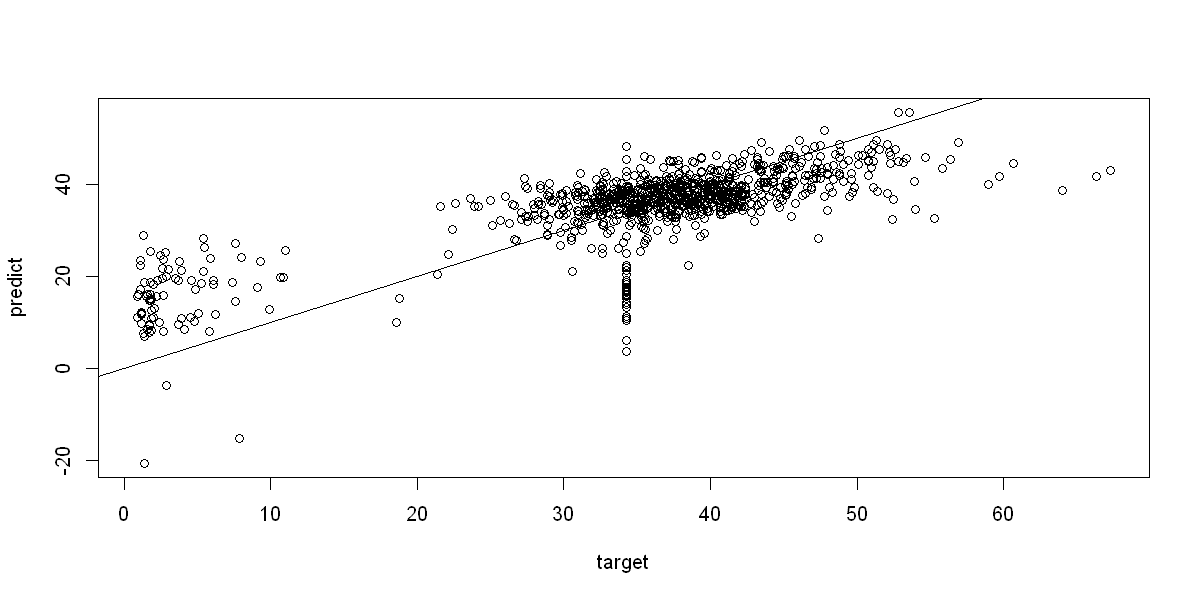

[1] "R-squared:  0.0468481587511597"
[1] "MAE:  7.6597214616645"
[1] "RMSE:  10.7422222530573"


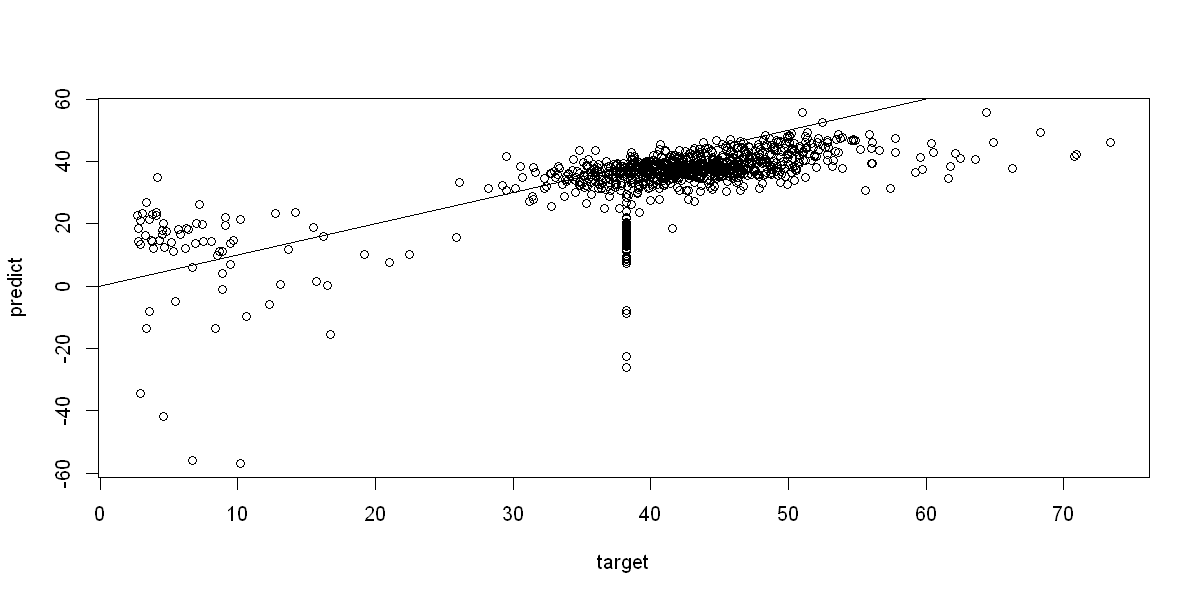

In [241]:
# 2016-17
ls <- LinearRegressionAnalysis(XY_2016_17_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', FALSE, 8) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Att8_2016_17 <- unlist(ls[3])
crossyear_crossval_summary$Att8_2016_17 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))


print('****Fitted model for 2016_17 Att8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2016_17_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2016_17', 'VIF', 'Att8')

print('****Fitted model for 2016_17 Att8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2016_17_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2016_17', 'CrossVal', 'Att8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)



ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Att8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Att8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

#### use 2016-17 to predict 2017-18###########
predAtt8_1617_1718 <- data.frame(VarCount=1:length(XY_2018_19_encoded$Att8Score_Disadvantaged))
predAtt8_1617_1718$pred <- predict(model, newdata=XY_2018_19_encoded[,pred_crossval])
predAtt8_1617_1718$orig <- XY_2018_19_encoded$Att8Score_Disadvantaged
#############################################


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Att8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Att8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 2.97872340425532"
[1] "% of  SchoolReligionMuslim  in dataset 0.425531914893617"
[1] "% of  AdmissionPolicySelective  in dataset 1.70212765957447"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 5.1063829787234"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the 

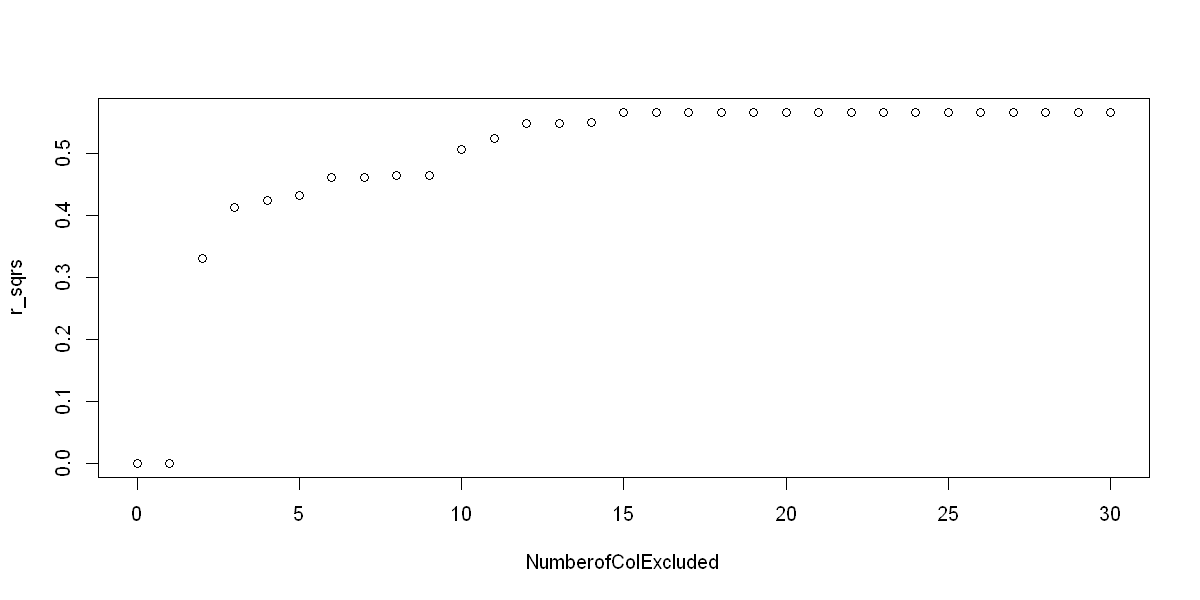

[1] "It can be seen than the minimum MSE error occurs at model size =  15"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2015_16 Att8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.017  -3.788   0.325   4.037  34.516 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 6.2637143  6.8355693   0.916
Percent_Girls                               0.1112747  0.0339295   3.280
Percent_SEN_EHCPlan                        -0.2540071  0.0351848  -7.219
Percent_SEN_Support                         0.1651178  0.0494488   3.339
Percent_FreeSchoolMealsEver                -0.0978408  0.0242999  -4.026
PupilTeacherRatio                          -0.3922749  0.1486597  -2.639
MeanSalaryTeachers                          0.0006935  0.0001084   6.400
SchoolFin_TotalIncomewithFunding           -0.0003935  0.0001469  -2.678
TeacherAndSupportPostFillUpRate            13.3916078  5.1624655   2.594
PupilStaffRatio                             0.1808160  0.0463763   3.899
SchoolFin_TeachAndSupportStaffCostPerPupil -0.0

[1] "****Fitted model for 2015_16 Att8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.378  -3.510   0.153   3.712  35.897 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                      5.5892794  6.8570208   0.815
Percent_Girls                                    0.1048147  0.0341055   3.073
Percent_SEN_EHCPlan                             -0.2492256  0.0349989  -7.121
Percent_SEN_Support                              0.1648436  0.0495038   3.330
Percent_UnclassifiedLang                         1.1384469  0.8380910   1.358
Percent_FreeSchoolMealsEver                     -0.0811713  0.0248916  -3.261
PupilTeacherRatio                               -0.3713560  0.1480934  -2.508
MeanSalaryTeachers                               0.0006756  0.0001077   6.276
SchoolFin_TotalIncomewithFunding                -0.0003685  0.0001510  -2.441
TeacherAndSupportPostFillUpRate                 13.3273161  5.1320730 

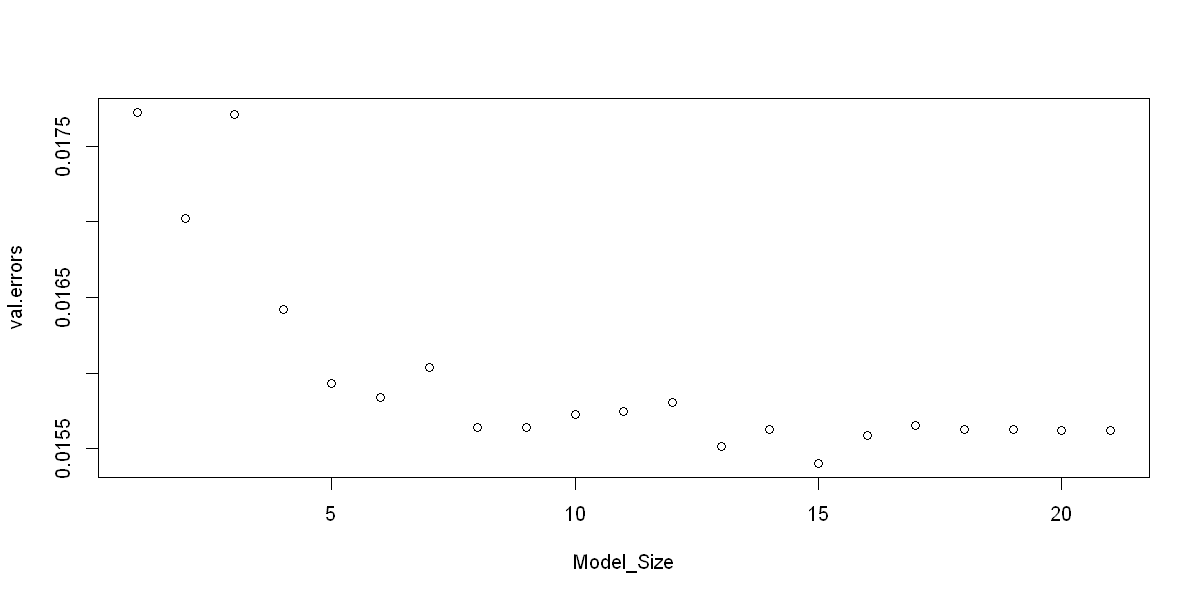

[1] "R-squared:  0.139959243086306"
[1] "MAE:  9.51046213651687"
[1] "RMSE:  11.7624863729365"


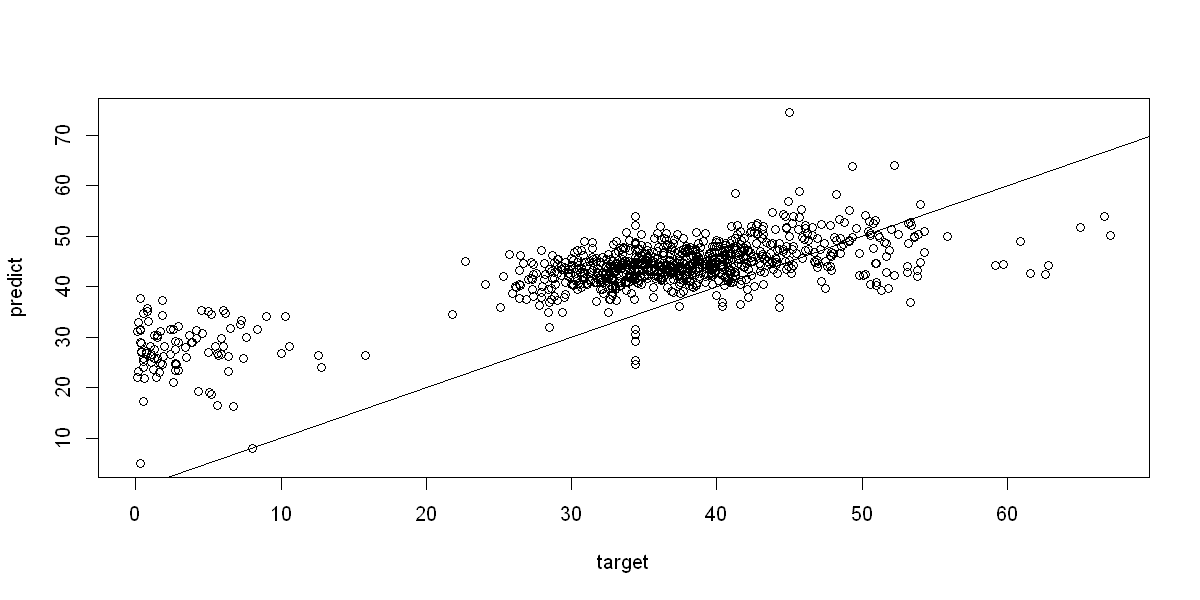

[1] "R-squared:  0.252857040654101"
[1] "MAE:  7.71308552439578"
[1] "RMSE:  9.60806988595483"


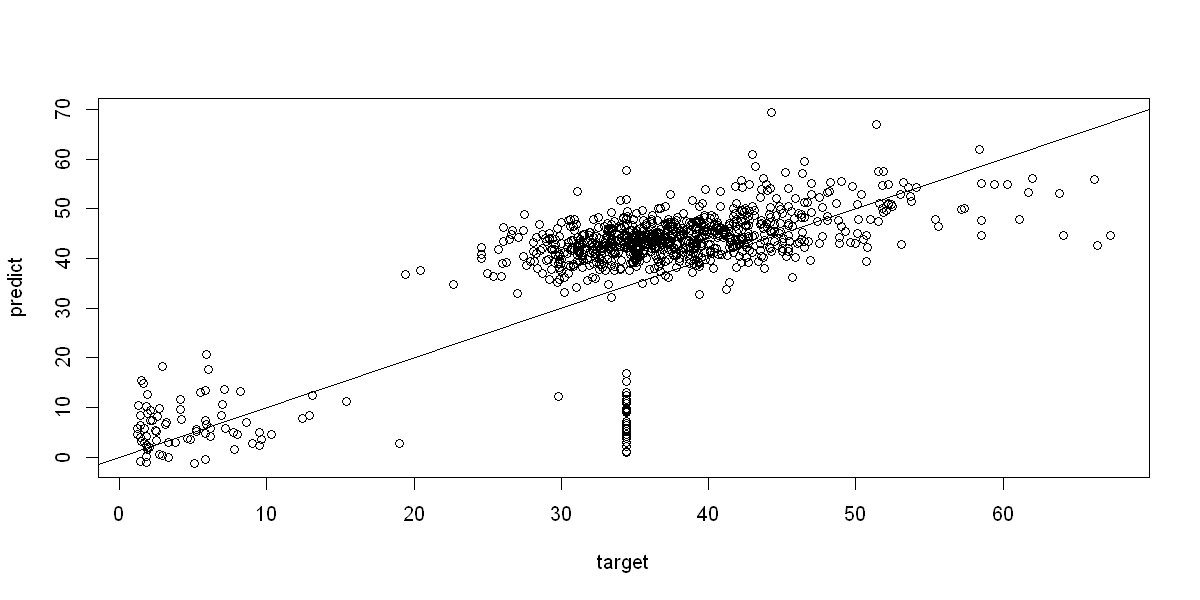

[1] "R-squared:  0.109030729867803"
[1] "MAE:  7.89500406991641"
[1] "RMSE:  10.7710656209742"


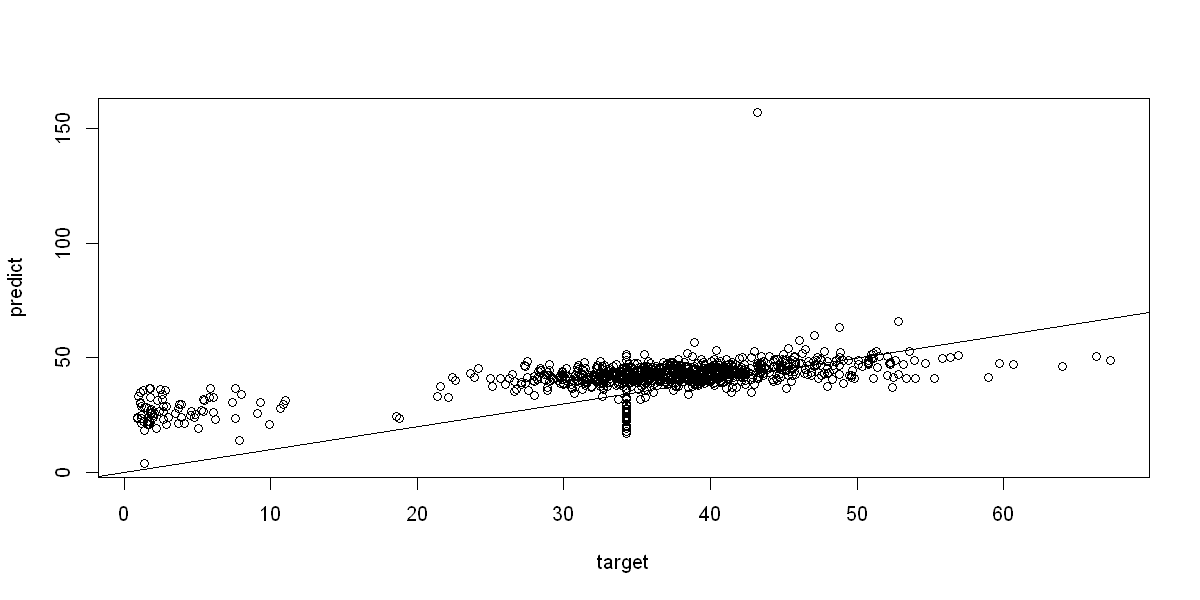

[1] "R-squared:  0.464288598945901"
[1] "MAE:  5.58591976526559"
[1] "RMSE:  8.05338631811161"


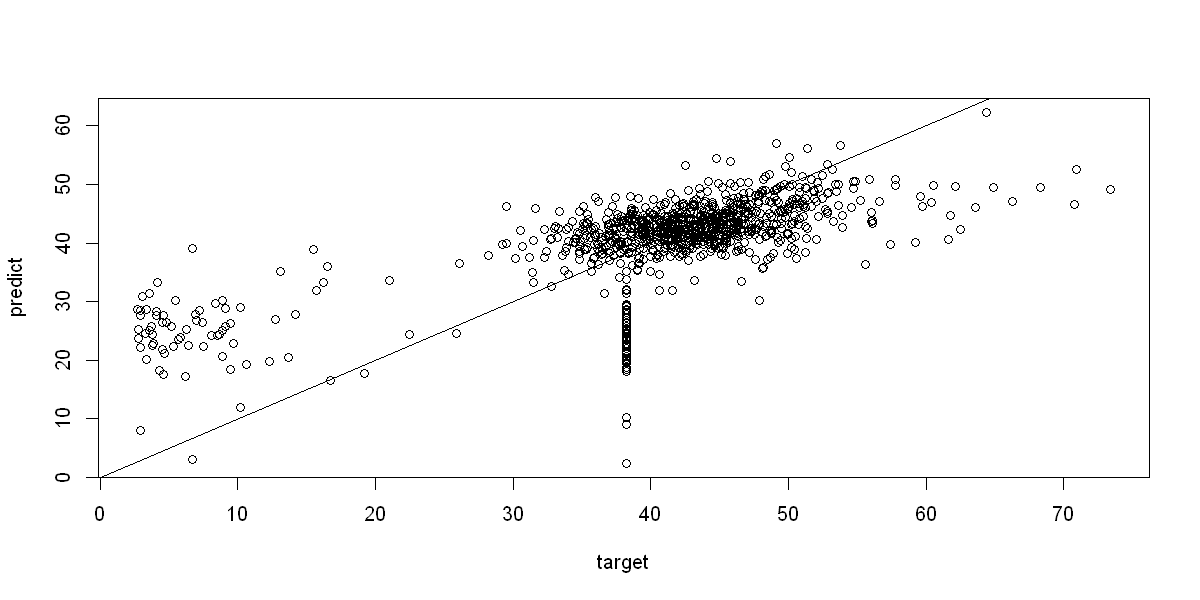

In [242]:
# 2015-16
ls <- LinearRegressionAnalysis(XY_2015_16_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', FALSE, 8) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Att8_2015_16 <- unlist(ls[3])
crossyear_crossval_summary$Att8_2015_16 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))


print('****Fitted model for 2015_16 Att8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2015_16_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2015_16', 'VIF', 'Att8')

print('****Fitted model for 2015_16 Att8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2015_16_encoded, 'Att8Score_Disadvantaged', 'Prg8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2015_16', 'CrossVal', 'Att8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)


ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Att8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Att8', '2017_18',  R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Att8', '2016_17',  R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

#### use 2015-16 to predict 2016-17###########
predAtt8_1516_1617 <- data.frame(VarCount=1:length(XY_2016_17_encoded$Att8Score_Disadvantaged))
predAtt8_1516_1617$pred <- predict(model, newdata=XY_2016_17_encoded[,pred_crossval])
predAtt8_1516_1617$orig <- XY_2016_17_encoded$Att8Score_Disadvantaged

test_model <- model
#############################################

ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Att8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Att8', '2015_16',  R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

### 2.1.2 Analysis of Progress 8 Score Across Multiple Years

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.28425821064553"
[1] "% of  SchoolReligionMuslim  in dataset 0.453001132502831"
[1] "% of  AdmissionPolicySelective  in dataset 1.81200453001132"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.07701019252548"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

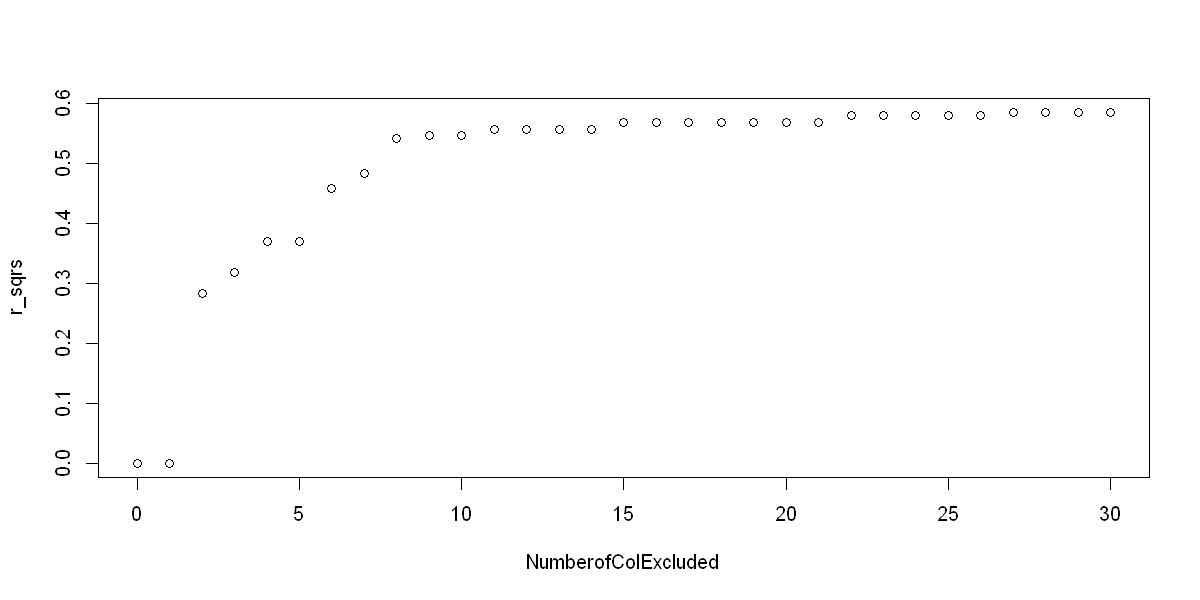

[1] "It can be seen than the minimum MSE error occurs at model size =  26"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2018_19 Prg8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.64751 -0.27148 -0.02796  0.27214  1.47571 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 2.677e-01  2.897e-01   0.924
Percent_SEN_EHCPlan                        -9.145e-03  2.164e-03  -4.225
Percent_FreeSchoolMealsEver                 2.201e-03  1.304e-03   1.688
Percent_OverallAbsence                     -1.442e-01  1.194e-02 -12.074
PupilTeacherRatio                          -4.070e-02  9.226e-03  -4.412
MeanSalaryTeachers                          1.856e-05  5.577e-06   3.328
PupilStaffRatio                             4.403e-03  1.692e-03   2.603
SchoolFin_TeachAndSupportStaffCostPerPupil -9.654e-05  8.207e-06 -11.764
SchoolReligionJewish                        4.337e-01  2.157e-01   2.011
Ofsted_RatingGood                           2.096e-01  4.004e-02   5.235
Ofsted_RatingOutstanding             

[1] "****Fitted model for 2018_19 Prg8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.27645 -0.27305 -0.03605  0.26059  1.47400 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -4.909e-01  4.063e-01  -1.208
Percent_Girls                                    9.815e-04  1.794e-03   0.547
Percent_SEN_EHCPlan                             -6.178e-03  2.358e-03  -2.620
Percent_SEN_Support                              3.029e-03  3.278e-03   0.924
Percent_UnclassifiedLang                         3.892e-03  3.765e-02   0.103
Percent_FreeSchoolMealsEver                      3.510e-03  1.531e-03   2.292
Percent_OverallAbsence                          -1.017e-01  2.453e-02  -4.146
Percent_PersistentAbsence                       -7.772e-03  6.662e-03  -1.167
PupilTeacherRatio                               -3.233e-02  9.580e-03  -3.375
MeanSalaryTeachers                               1.831e-05  

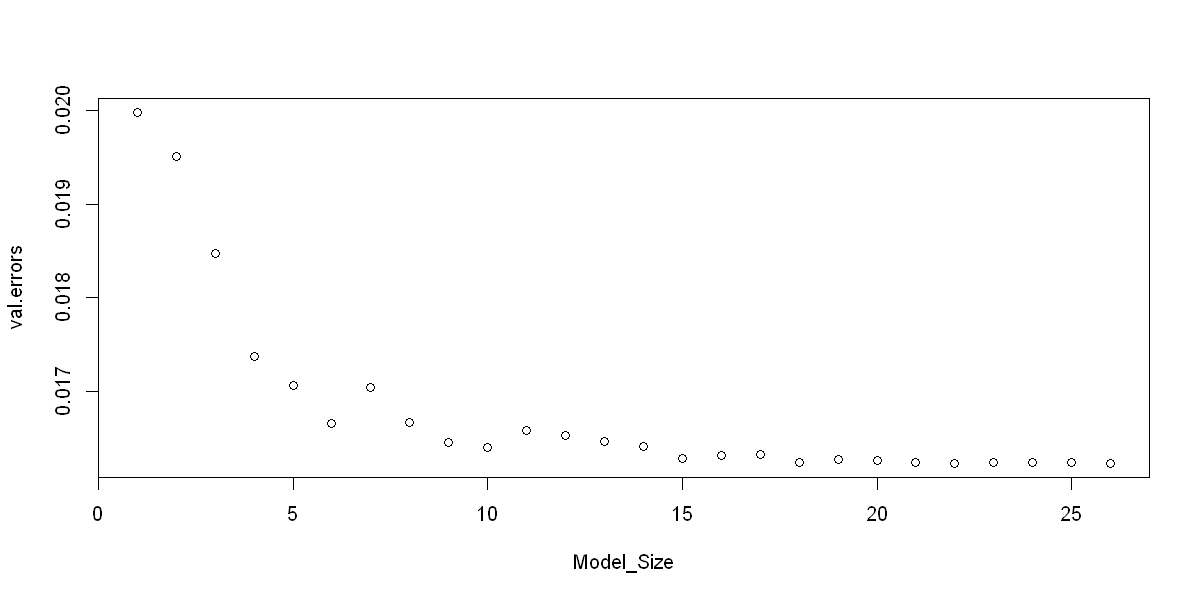

[1] "R-squared:  0.545959764518088"
[1] "MAE:  0.323537977486873"
[1] "RMSE:  0.415097704301725"


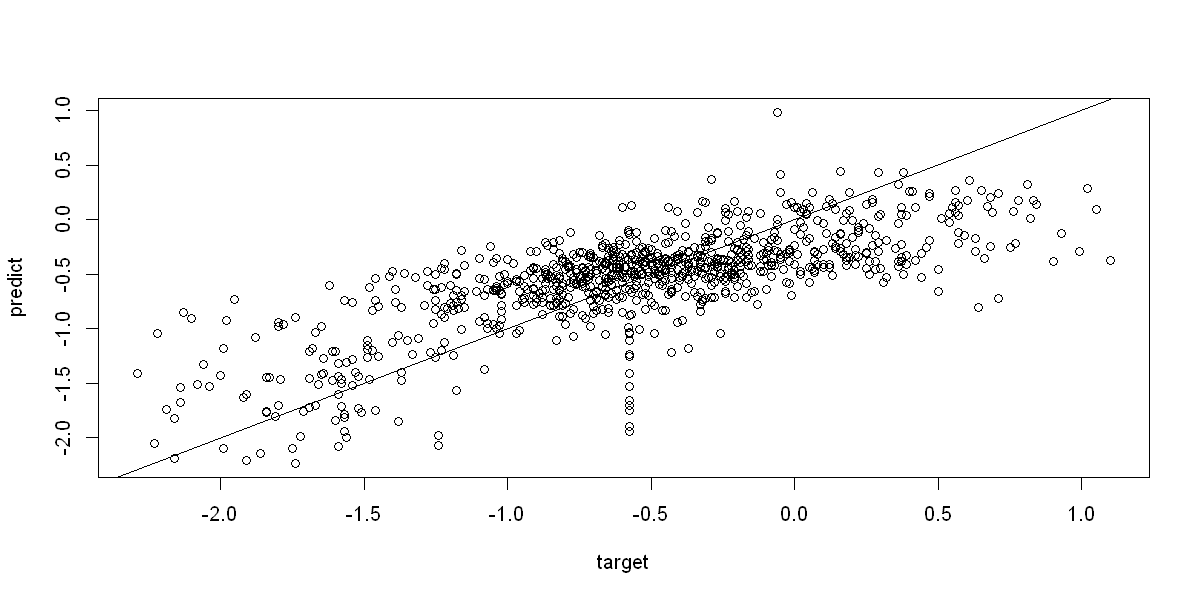

[1] "R-squared:  -0.0482676848626937"
[1] "MAE:  0.367858346343303"
[1] "RMSE:  0.573332612090818"


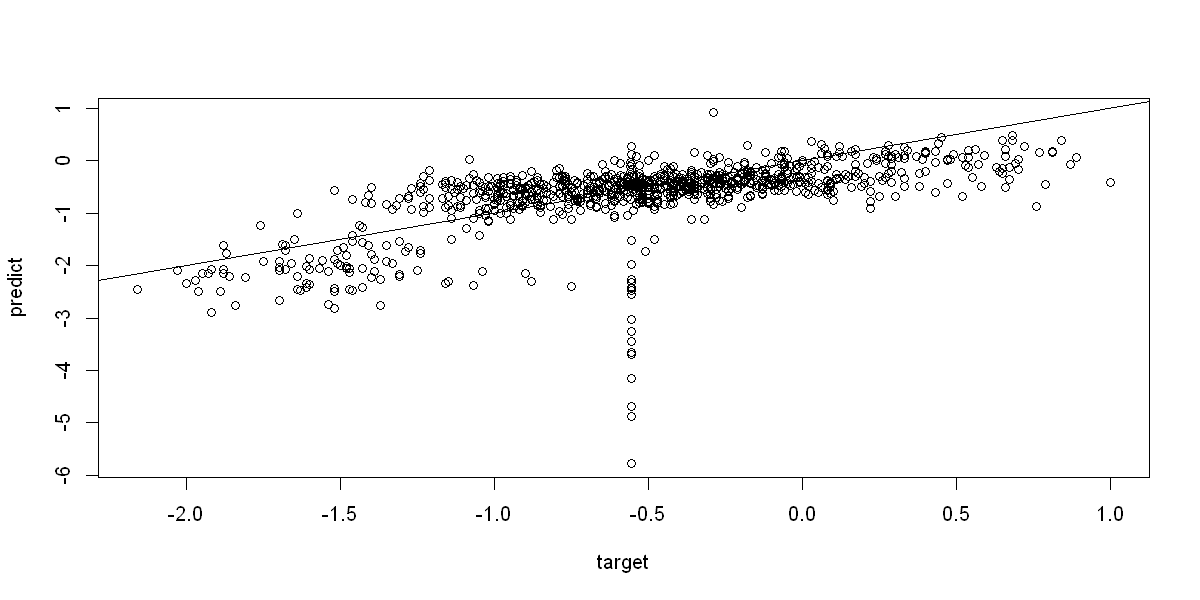

[1] "R-squared:  0.471649152183015"
[1] "MAE:  0.323072733594981"
[1] "RMSE:  0.415404107702796"


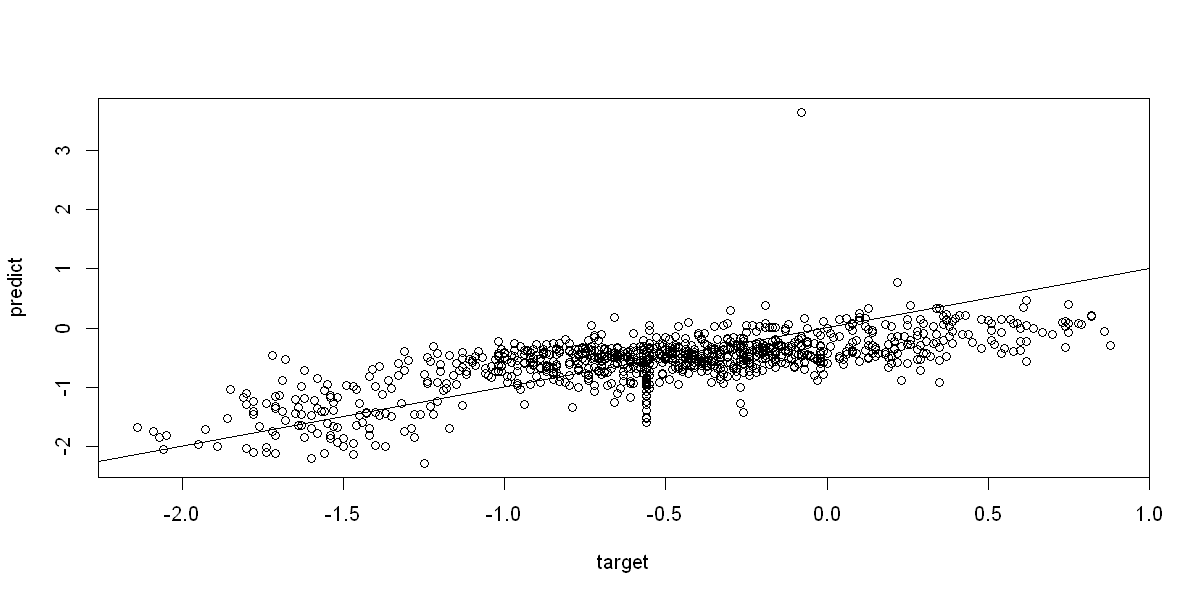

[1] "R-squared:  0.133762694369914"
[1] "MAE:  0.337496013442113"
[1] "RMSE:  0.542480012990217"


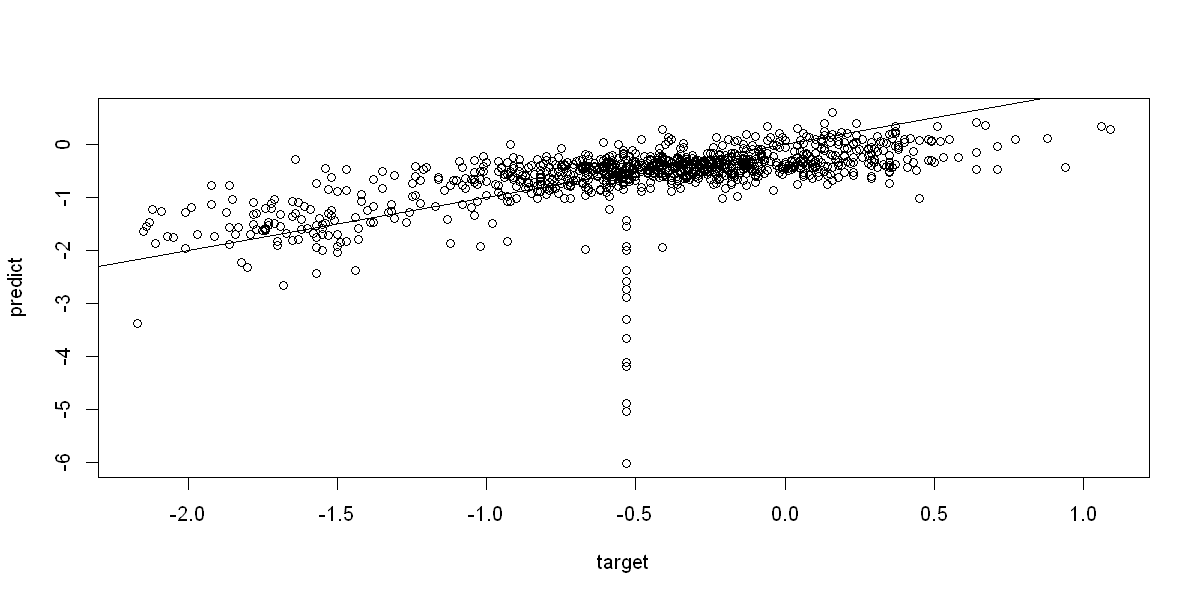

In [243]:
# 2018-19
ls <- LinearRegressionAnalysis(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', TRUE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Prg8_2018_19 <- unlist(ls[3])
crossyear_crossval_summary$Prg8_2018_19 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))


print('****Fitted model for 2018_19 Prg8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2018_19', 'VIF', 'Prg8')

print('****Fitted model for 2018_19 Prg8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2018_19', 'CrossVal', 'Prg8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)


ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Prg8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Prg8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Prg8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2018_19', 'CrossVal', 'Prg8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.02375809935205"
[1] "% of  SchoolReligionMuslim  in dataset 0.431965442764579"
[1] "% of  AdmissionPolicySelective  in dataset 1.72786177105832"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.96760259179266"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

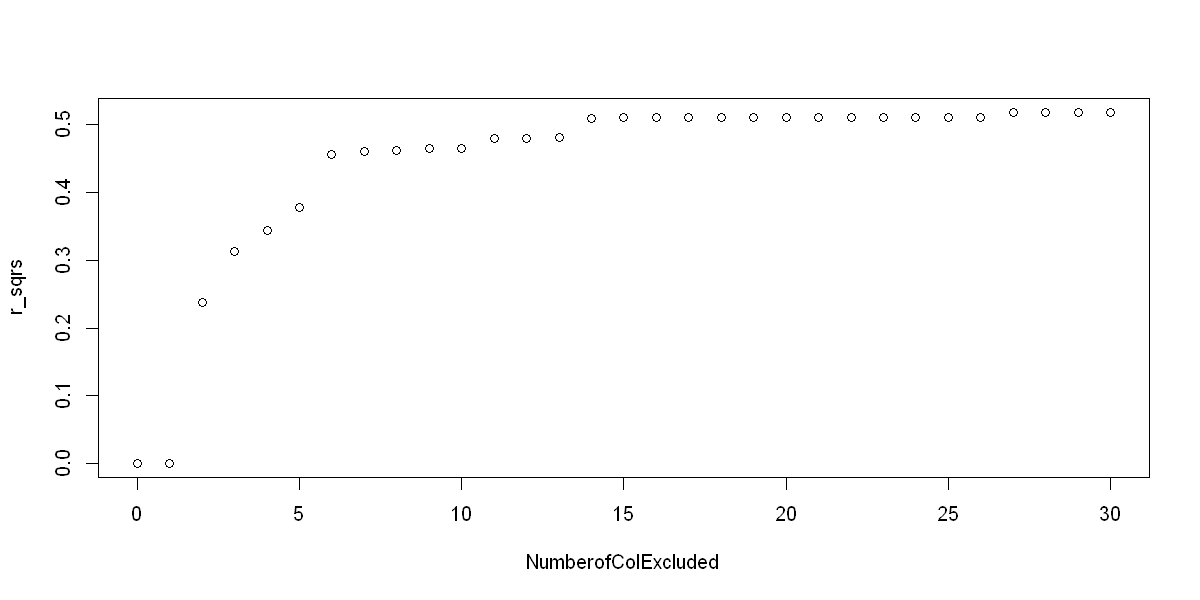

[1] "It can be seen than the minimum MSE error occurs at model size =  16"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2017_18 Prg8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.12659 -0.26728 -0.00499  0.24841  1.48092 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -2.536e+00  2.936e-01  -8.636
Percent_Girls                                    2.961e-03  8.561e-04   3.459
Percent_FreeSchoolMealsEver                      2.912e-03  1.189e-03   2.449
MeanSalaryTeachers                               2.537e-05  5.433e-06   4.670
SchoolFin_TotalIncomewithFunding                -2.890e-05  9.644e-06  -2.996
TeacherAndSupportPostFillUpRate                  6.674e-01  2.858e-01   2.335
PupilStaffRatio                                  6.132e-03  1.907e-03   3.215
SchoolFin_TeachAndSupportStaffCostPerPupil      -5.524e-05  1.315e-05  -4.202
SchoolFin_NonICTAndEducationServiceCostPerPupil -1.854e-04  7.408e-05  -2.503
SchoolReligionJewish                             7.160e-01  

[1] "****Fitted model for 2017_18 Prg8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14076 -0.27772 -0.00671  0.24667  1.53470 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -2.296e+00  3.483e-01  -6.593
Percent_Girls                                    2.981e-03  8.575e-04   3.476
Percent_SEN_Support                              3.006e-03  2.773e-03   1.084
Percent_FreeSchoolMealsEver                      2.596e-03  1.283e-03   2.024
PupilTeacherRatio                               -1.240e-02  7.698e-03  -1.611
MeanSalaryTeachers                               2.537e-05  5.424e-06   4.677
SchoolFin_TotalIncomewithFunding                -2.505e-05  1.001e-05  -2.502
TeacherAndSupportPostFillUpRate                  6.508e-01  2.868e-01   2.269
PupilStaffRatio                                  6.331e-03  1.929e-03   3.282
SchoolFin_TeachAndSupportStaffCostPerPupil      -5.721e-05  

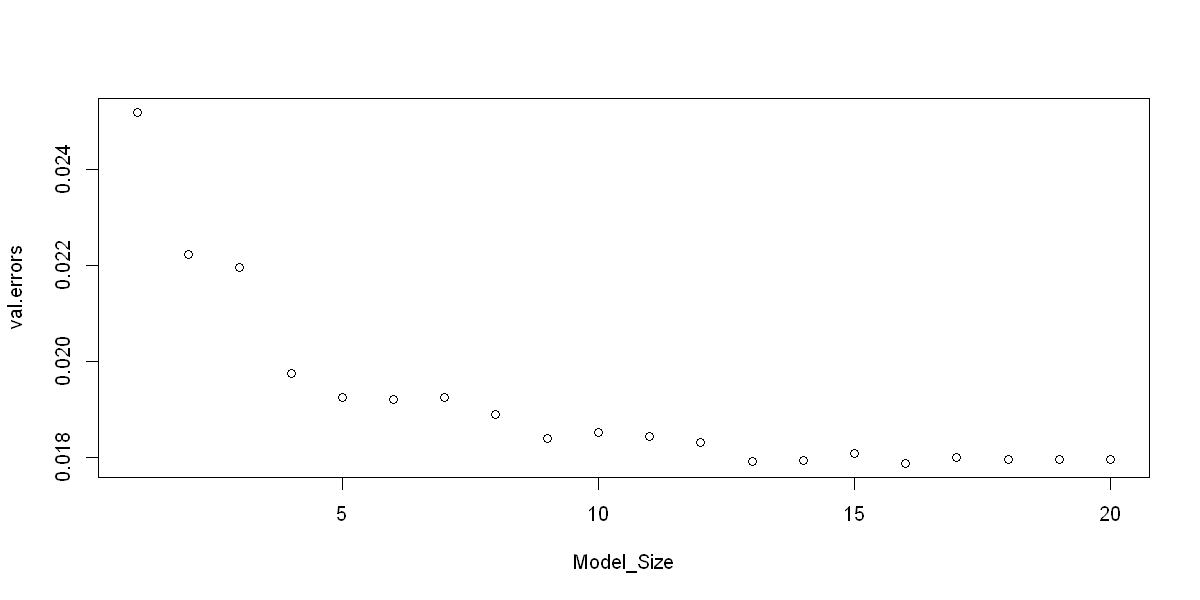

[1] "R-squared:  0.453150235195897"
[1] "MAE:  0.356236743283577"
[1] "RMSE:  0.455551180329724"


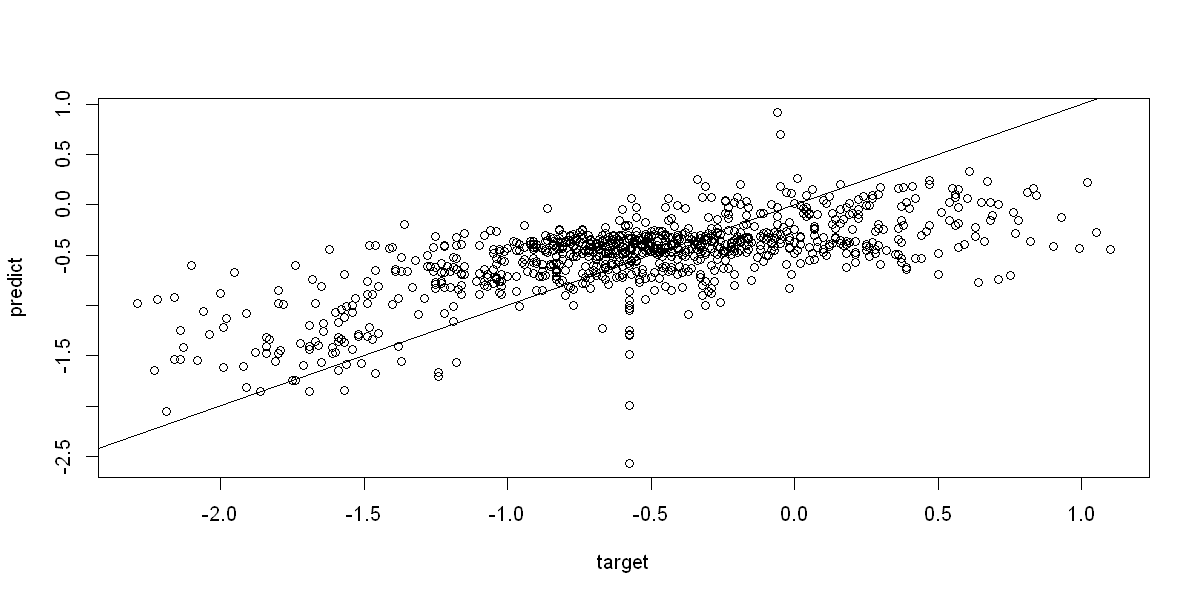

[1] "R-squared:  0.464034336747517"
[1] "MAE:  0.323889351308374"
[1] "RMSE:  0.409957683641919"


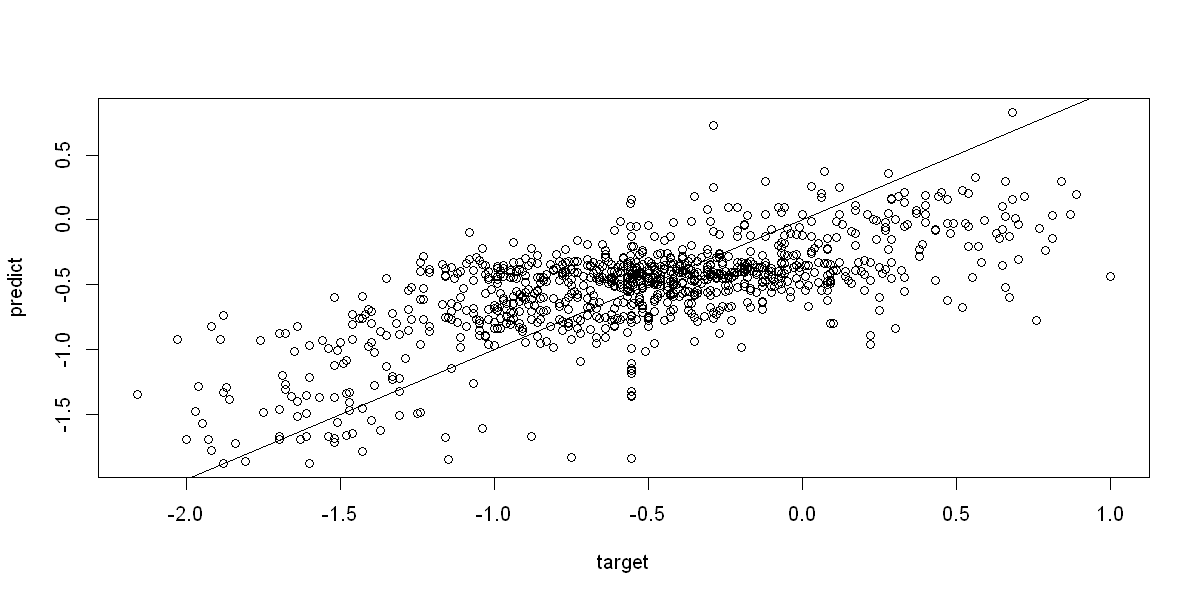

[1] "R-squared:  0.400956755165893"
[1] "MAE:  0.336407342478322"
[1] "RMSE:  0.442322131732038"


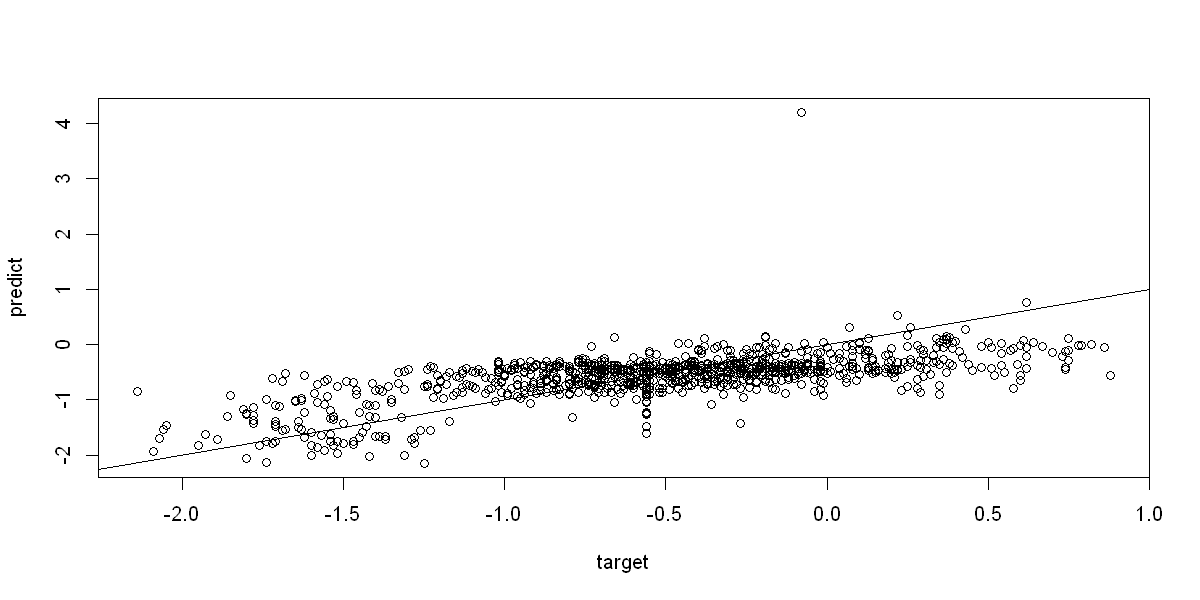

[1] "R-squared:  0.488230722383412"
[1] "MAE:  0.328975550654681"
[1] "RMSE:  0.416967691854877"


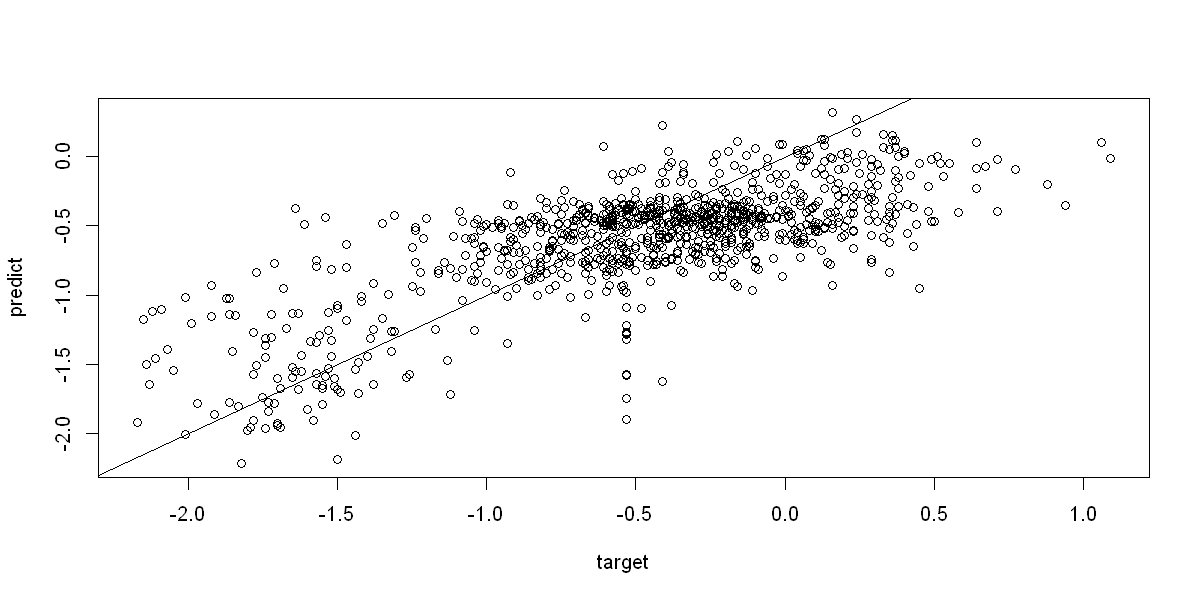

In [244]:
# 2017-18
ls <- LinearRegressionAnalysis(XY_2017_18_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', TRUE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Prg8_2017_18 <- unlist(ls[3])
crossyear_crossval_summary$Prg8_2017_18 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))

print('****Fitted model for 2017_18 Prg8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2017_18_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2017_18', 'VIF', 'Prg8')

print('****Fitted model for 2017_18 Prg8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2017_18_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2017_18', 'CrossVal', 'Prg8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)




# Predict other years
ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Prg8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

#### use 2017-18 to predict 2018-19###########
predPrg8_1718_1819 <- data.frame(VarCount=1:length(XY_2018_19_encoded$Prg8Score_Disadvantaged))
predPrg8_1718_1819$pred <- predict(model, newdata=XY_2018_19_encoded[,pred_crossval])
predPrg8_1718_1819$orig <- XY_2018_19_encoded$Prg8Score_Disadvantaged
#############################################

ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Prg8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Prg8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2017_18', 'CrossVal', 'Prg8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 3.01399354144241"
[1] "% of  SchoolReligionMuslim  in dataset 0.430570505920344"
[1] "% of  AdmissionPolicySelective  in dataset 1.61463939720129"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 4.95156081808396"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the

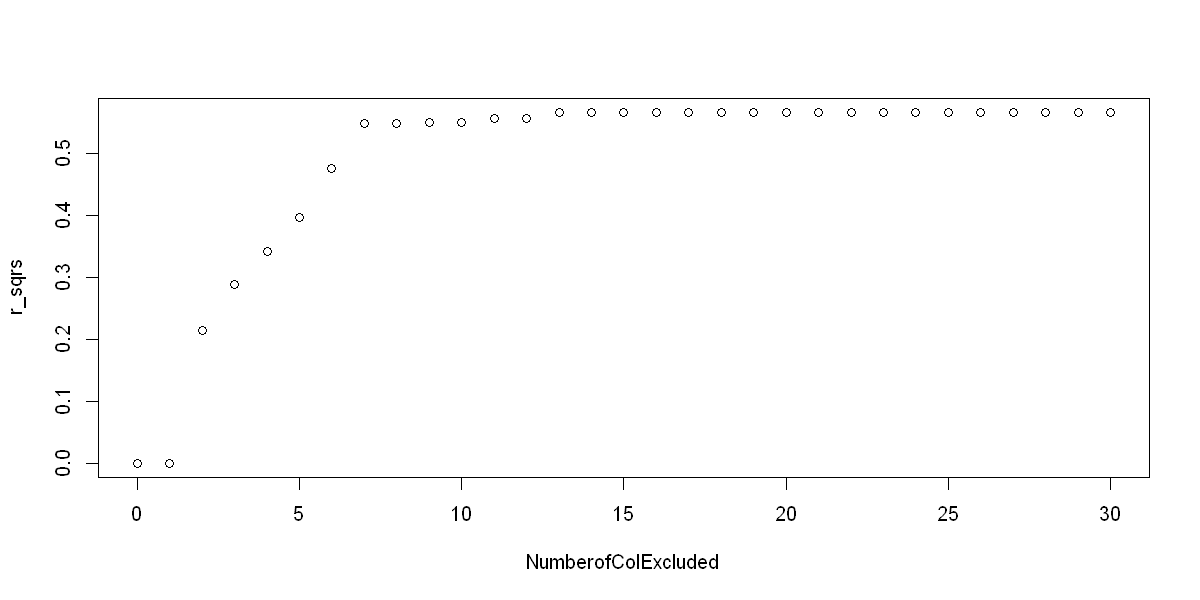

[1] "It can be seen than the minimum MSE error occurs at model size =  9"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2016_17 Prg8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19809 -0.25777  0.00527  0.24277  1.23519 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                -1.025e+00  2.302e-01  -4.454
Percent_SEN_EHCPlan                        -6.032e-03  2.899e-03  -2.081
Percent_FreeSchoolMealsEver                 7.006e-03  1.030e-03   6.803
Percent_OverallAbsence                     -6.295e-02  2.274e-02  -2.769
Percent_PersistentAbsence                  -1.884e-02  5.479e-03  -3.439
MeanSalaryTeachers                          1.959e-05  4.981e-06   3.934
SchoolFin_TotalIncomewithFunding           -3.572e-05  8.389e-06  -4.258
SchoolFin_TeachAndSupportStaffCostPerPupil -2.692e-05  1.089e-05  -2.471
SchoolReligionJewish                        6.245e-01  2.270e-01   2.751
AdmissionPolicyNon.selective                2.886e-01  6.255e-02   4.614
Ofsted_RatingGood                    

[1] "****Fitted model for 2016_17 Prg8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23513 -0.26473 -0.00324  0.24349  1.30600 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -9.665e-01  2.269e-01  -4.259 2.26e-05 ***
Percent_FreeSchoolMealsEver       6.783e-03  1.034e-03   6.560 8.96e-11 ***
Percent_OverallAbsence           -7.920e-02  2.198e-02  -3.603 0.000331 ***
Percent_PersistentAbsence        -1.630e-02  5.400e-03  -3.018 0.002611 ** 
MeanSalaryTeachers                1.919e-05  4.999e-06   3.839 0.000132 ***
SchoolFin_TotalIncomewithFunding -5.223e-05  6.056e-06  -8.624  < 2e-16 ***
SchoolReligionJewish              6.171e-01  2.281e-01   2.706 0.006946 ** 
AdmissionPolicyNon.selective      3.595e-01  5.791e-02   6.207 8.15e-10 ***
Ofsted_RatingGood                 2.406e-01  3.319e-02   7.249 8.92e-13 ***
Ofsted_RatingOutstanding          5.020e-01  4.815e-02  10.425  < 2e-16 ***
---


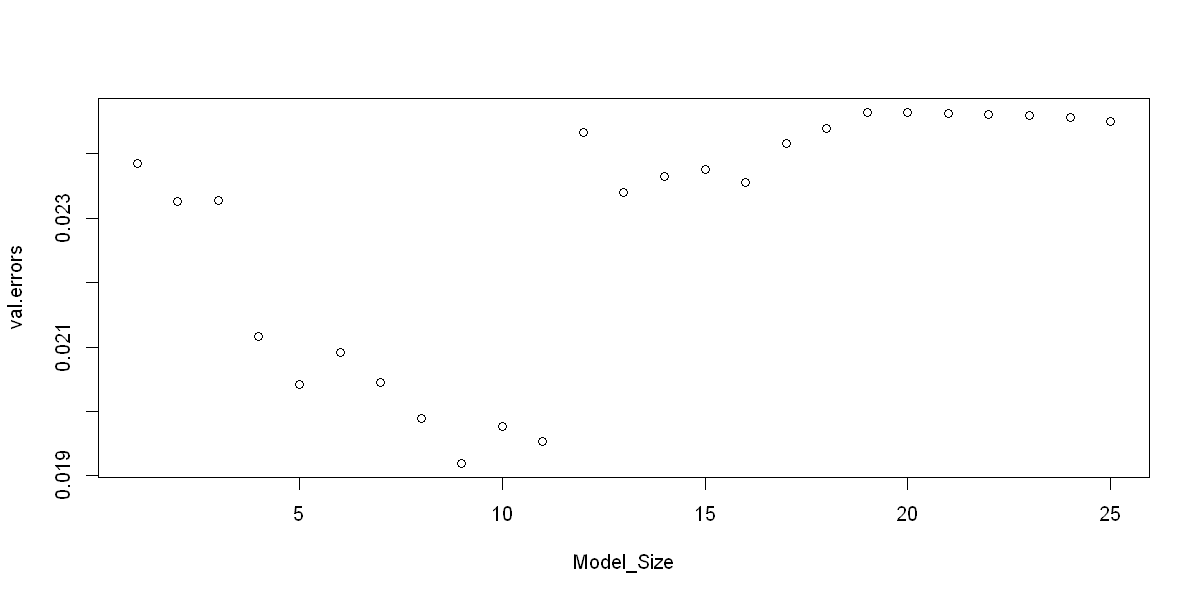

[1] "R-squared:  0.493546932708501"
[1] "MAE:  0.340078351146991"
[1] "RMSE:  0.438402239774705"


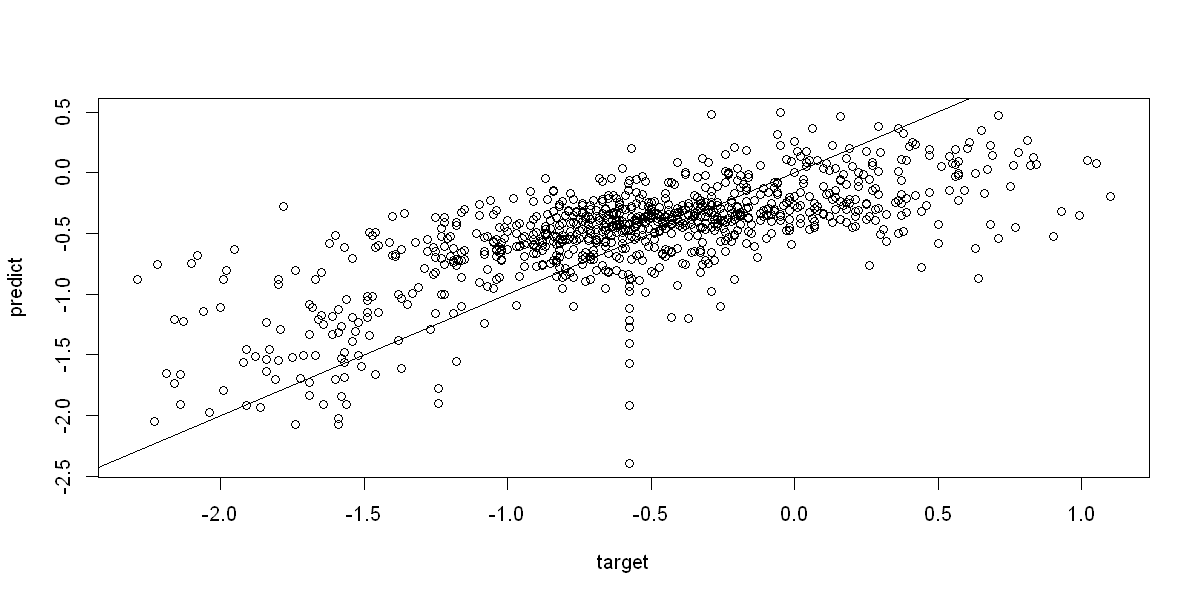

[1] "R-squared:  0.213116956062607"
[1] "MAE:  0.336992396431244"
[1] "RMSE:  0.496736005279582"


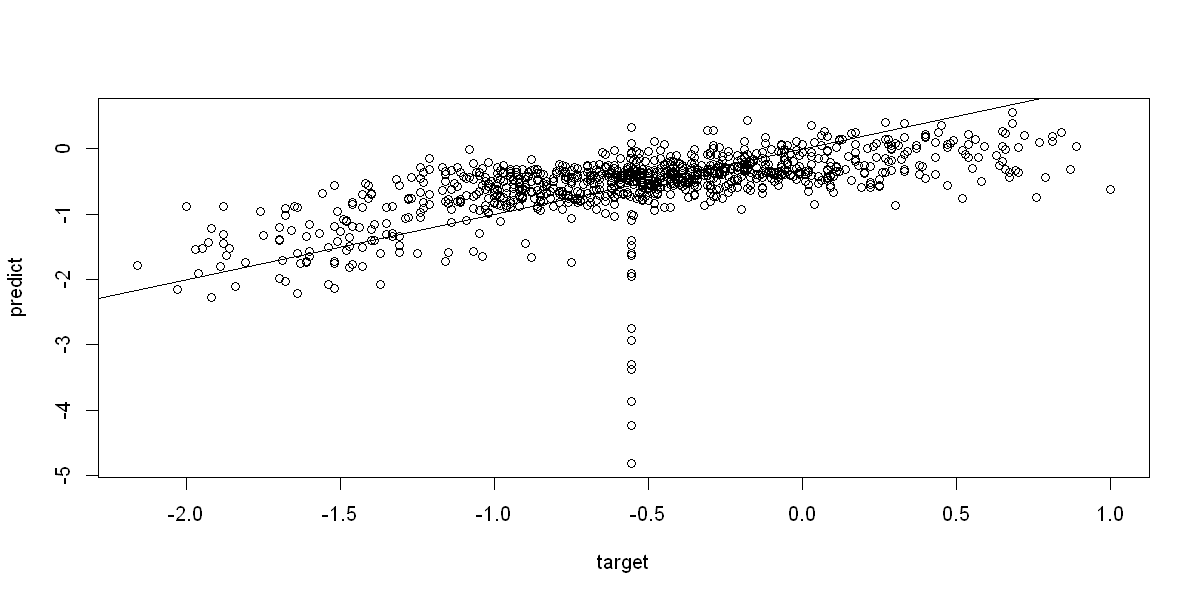

[1] "R-squared:  0.536108565619009"
[1] "MAE:  0.309456017730684"
[1] "RMSE:  0.389240264617207"


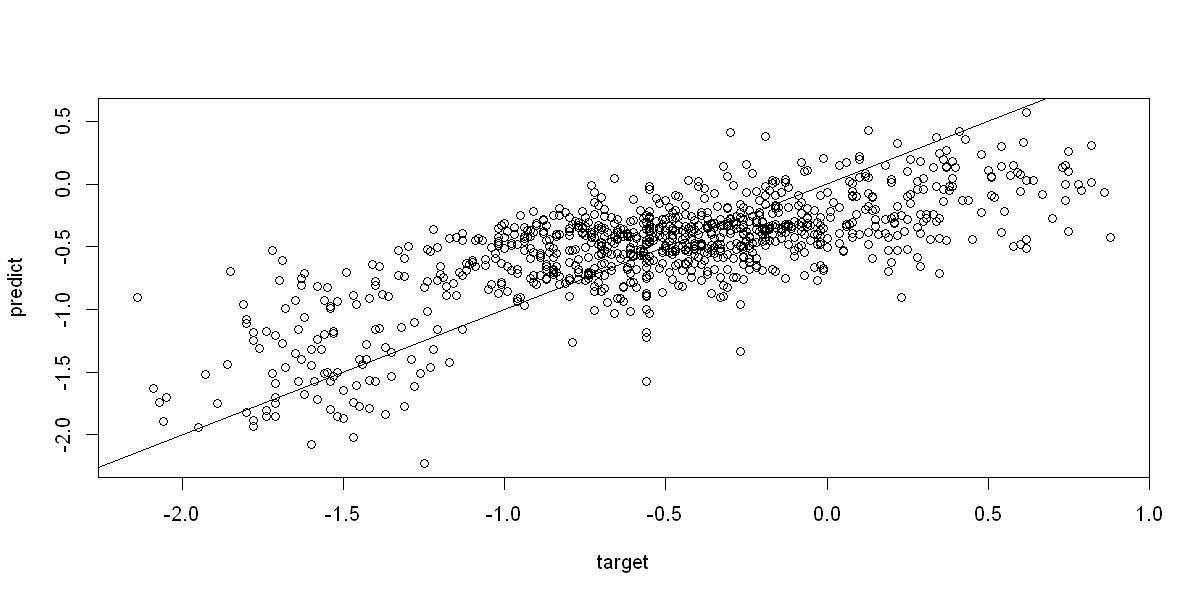

[1] "R-squared:  0.196422126584583"
[1] "MAE:  0.329003820417037"
[1] "RMSE:  0.522491566708849"


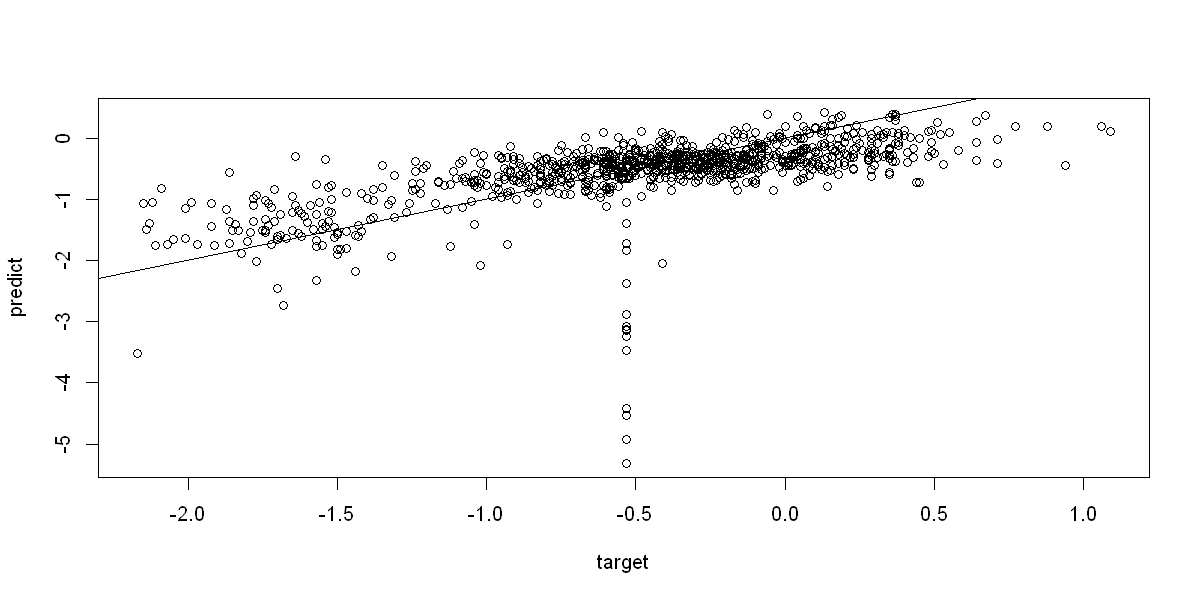

In [245]:
# 2016-17
ls <- LinearRegressionAnalysis(XY_2016_17_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', TRUE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Prg8_2016_17 <- unlist(ls[3])
crossyear_crossval_summary$Prg8_2016_17 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))

print('****Fitted model for 2016_17 Prg8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2016_17_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2016_17', 'VIF', 'Prg8')

print('****Fitted model for 2016_17 Prg8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2016_17_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2016_17', 'CrossVal', 'Prg8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)



ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Prg8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)



ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Prg8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

#### use 2016-17 to predict 2017-18###########
predPrg8_1617_1718 <- data.frame(VarCount=1:length(XY_2017_18_encoded$Prg8Score_Disadvantaged))
predPrg8_1617_1718$pred <- predict(model, newdata=XY_2017_18_encoded[,pred_crossval])
predPrg8_1617_1718$orig <- XY_2017_18_encoded$Prg8Score_Disadvantaged
#############################################


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Prg8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2016_17', 'CrossVal', 'Prg8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

[1] "                         "
[1] "########################"
[1] "###Step 1. Fit the simple linear regression model and examine the singular columns, if any"
[1] "% of  SCHOOLTYPEVoluntary.controlled.school  in dataset 2.97872340425532"
[1] "% of  SchoolReligionMuslim  in dataset 0.425531914893617"
[1] "% of  AdmissionPolicySelective  in dataset 1.70212765957447"
[1] "% of  Ofsted_RatingSpecial.Measures  in dataset 5.1063829787234"
[1] "All these columns are heavility unbalanced and exlcuded from the fitting."
[1] "                         "
[1] "########################"
[1] "### Step 2. The singularities are due to the unbalanced amount of these categories in the dataset such that the linear model failed to fit it."
[1] "Moreover, these columns are linearly dependent with others, it is suggested to remove these columns from fitting the model,\n   i.e. we assume they exist as the model baseline, and see how other predicting variables will change the output variable  relative to the 

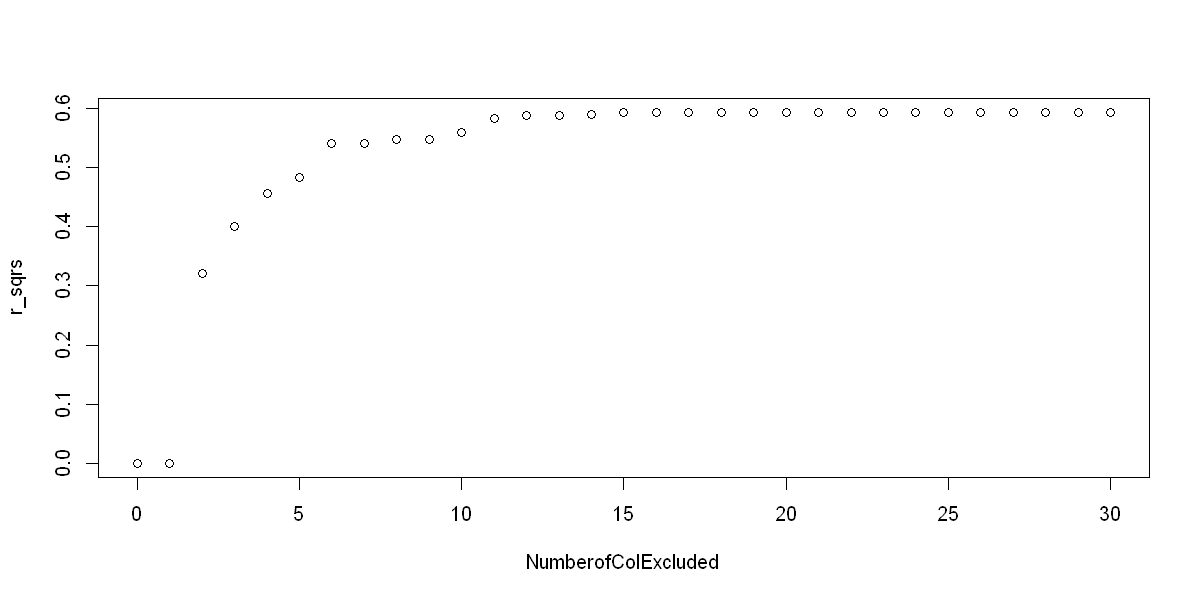

[1] "It can be seen than the minimum MSE error occurs at model size =  11"
[1] "The corresponding coefficients are:"
[1] "Since the above subset is picked using the training data set, even though\nthe MSE is computed in testing set. We should perform best subset selection on the full data set, and select\nthe best subset model. It is important that we make use of the full\ndata set in order to obtain more accurate coefficient estimates. Note that\nwe perform best subset selection on the full data set and select the best subset\nmodel, rather than simply using the variables that were obtained\nfrom the training set, because the best ten-variable model on the full data\nset may differ from the corresponding model on the training set."
[1] "We can compare the predictors selected using VIF with those from validation approach"
[1] "****Fitted model for 2015_16 Att8Score_Disadvantaged using VIF predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.42575 -0.26004  0.00616  0.22699  1.27795 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -2.457e+00  3.097e-01  -7.931
Percent_SEN_Support                              8.900e-03  2.427e-03   3.668
PupilTeacherRatio                               -1.510e-02  6.676e-03  -2.262
MeanSalaryTeachers                               3.373e-05  5.039e-06   6.694
SchoolFin_TotalIncomewithFunding                -1.772e-05  8.129e-06  -2.180
TeacherAndSupportPostFillUpRate                  8.176e-01  2.292e-01   3.567
SchoolFin_TeachAndSupportStaffCostPerPupil      -3.888e-05  1.011e-05  -3.848
SchoolFin_NonICTAndEducationServiceCostPerPupil -2.114e-04  6.018e-05  -3.513
SchoolFin_MiscCostPerPupil                      -6.310e-05  2.305e-05  -2.738
SchoolReligionJewish                             1.094e+00  

[1] "****Fitted model for 2015_16 Att8Score_Disadvantaged using Crossvalidation predictors***********"



Call:
lm(formula = fml, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.42925 -0.26240  0.00558  0.23045  1.30189 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -2.484e+00  3.101e-01  -8.012
Percent_SEN_Support                              9.008e-03  2.431e-03   3.705
PupilTeacherRatio                               -1.507e-02  6.690e-03  -2.252
MeanSalaryTeachers                               3.343e-05  5.047e-06   6.624
TeacherAndSupportPostFillUpRate                  8.169e-01  2.296e-01   3.557
SchoolFin_TeachAndSupportStaffCostPerPupil      -5.351e-05  7.568e-06  -7.071
SchoolFin_NonICTAndEducationServiceCostPerPupil -2.353e-04  5.929e-05  -3.968
SchoolFin_MiscCostPerPupil                      -8.413e-05  2.097e-05  -4.011
SchoolReligionJewish                             1.097e+00  2.295e-01   4.780
AdmissionPolicyNon.selective                     4.227e-01  

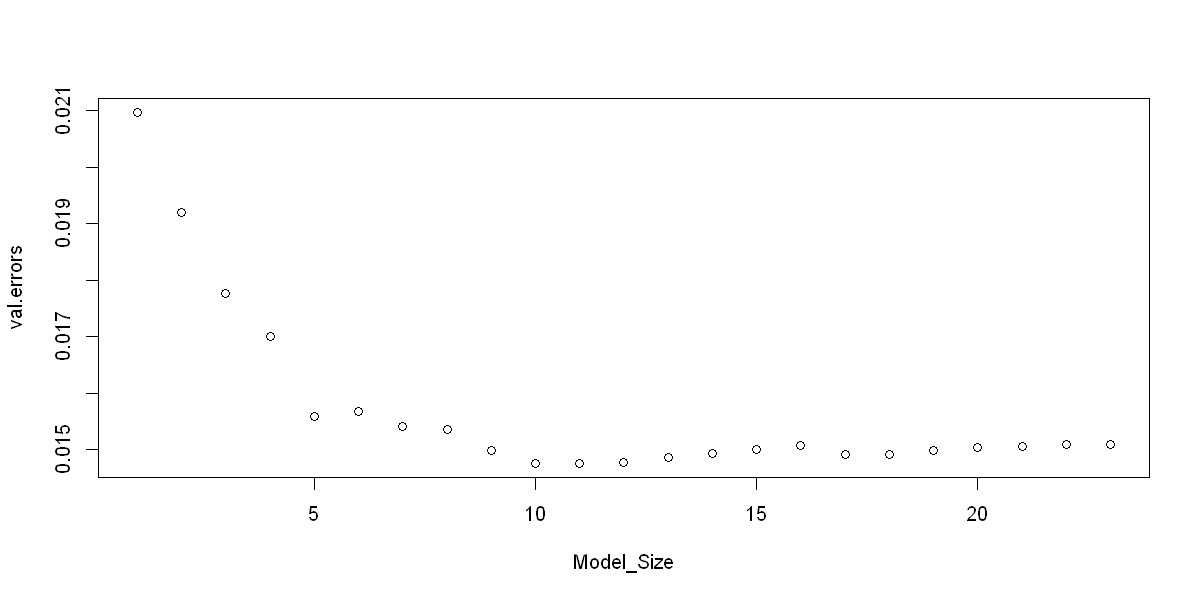

[1] "R-squared:  0.376319858710089"
[1] "MAE:  0.390862488839794"
[1] "RMSE:  0.486501427936024"


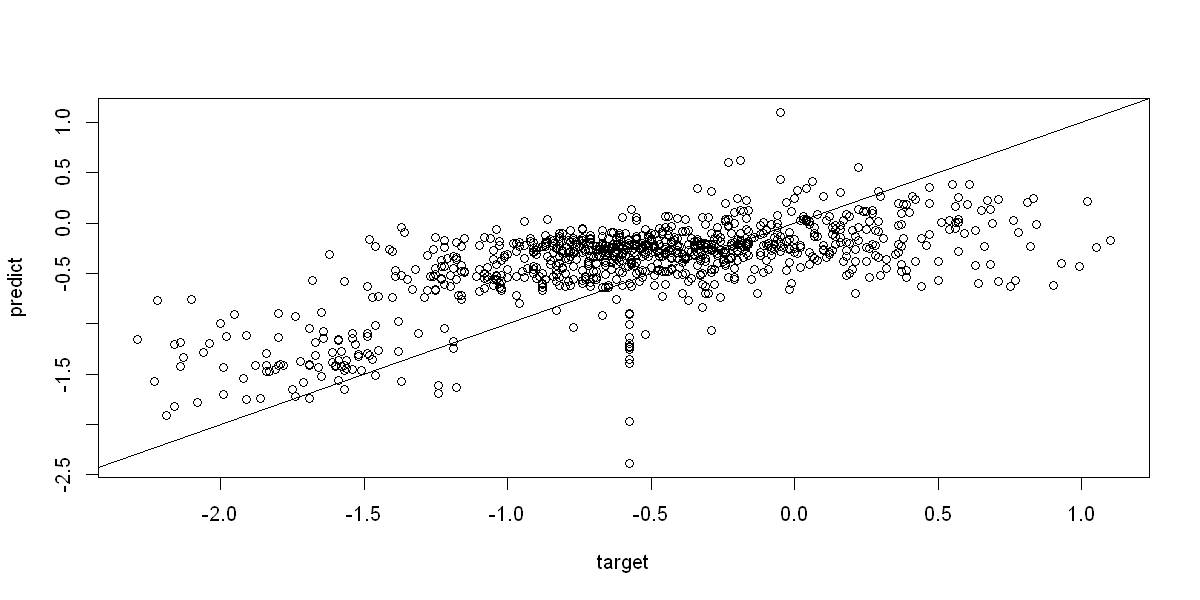

[1] "R-squared:  0.373391480516003"
[1] "MAE:  0.347175949192016"
[1] "RMSE:  0.443270362141924"


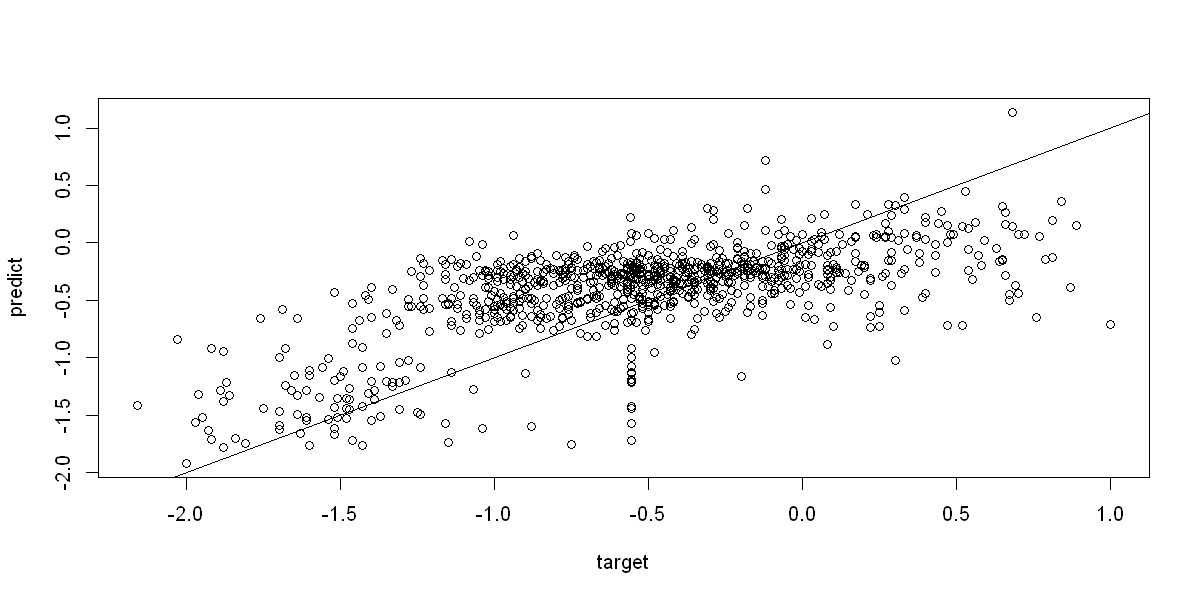

[1] "R-squared:  0.432426368285282"
[1] "MAE:  0.341670196773384"
[1] "RMSE:  0.43054711931059"


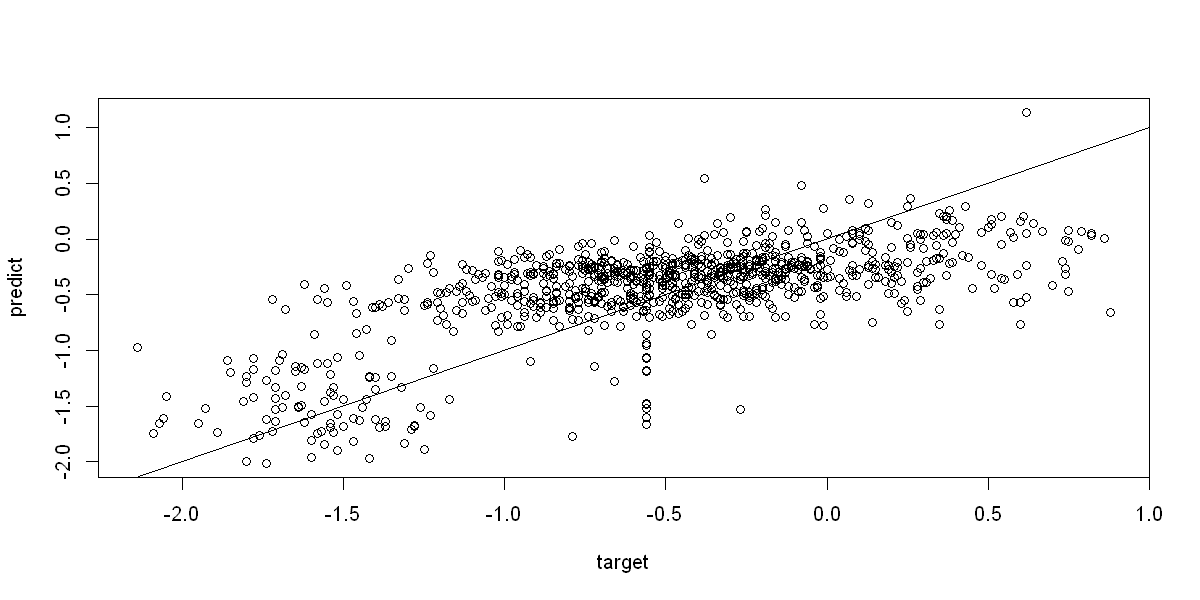

[1] "R-squared:  0.550343867237352"
[1] "MAE:  0.30451792473423"
[1] "RMSE:  0.390845900111715"


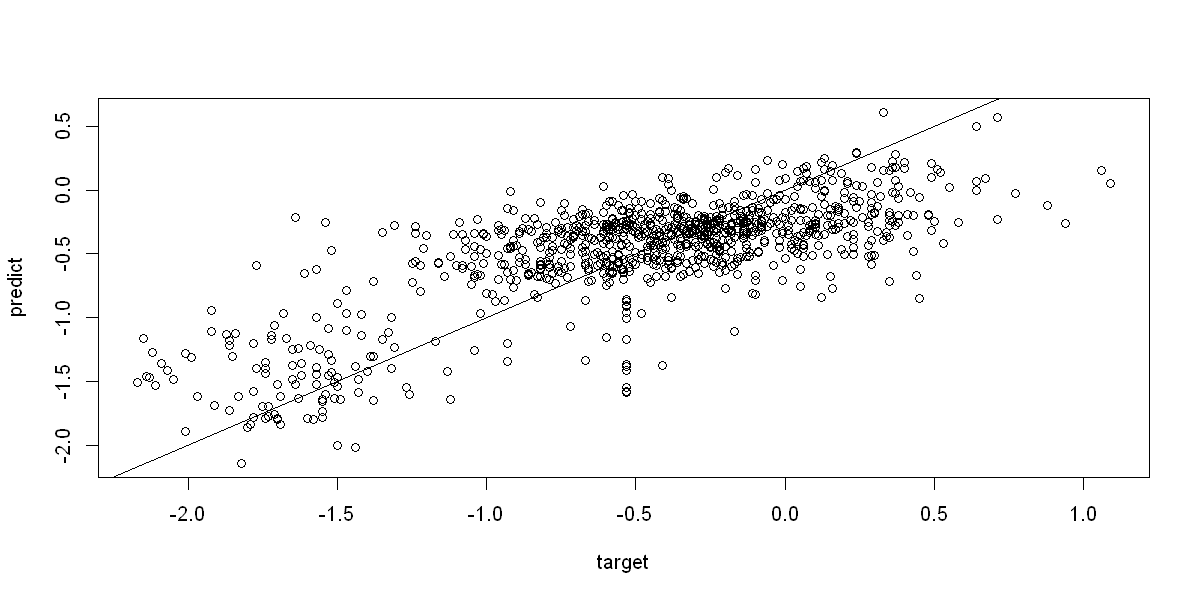

In [246]:
# 2015-16
ls <- LinearRegressionAnalysis(XY_2015_16_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', TRUE, 10) 
    
pred_vif <- unlist(ls[1])
pred_crossval <- unlist(ls[2])

crossyear_vif_rsqr_summary$Prg8_2015_16 <- unlist(ls[3])
crossyear_crossval_summary$Prg8_2015_16 <- c(unlist(ls[4]), rep(0, 45-length(unlist(ls[4]))))

print('****Fitted model for 2015_16 Att8Score_Disadvantaged using VIF predictors***********')
model <- FitLinearModel(XY_2015_16_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_vif) 
summary(model)
xx <- ExtractCoefficientsSummary(model, '2015_16', 'VIF', 'Prg8')

print('****Fitted model for 2015_16 Att8Score_Disadvantaged using Crossvalidation predictors***********')
model <- FitLinearModel(XY_2015_16_encoded, 'Prg8Score_Disadvantaged', 'Att8Score_Disadvantaged', pred_crossval) 
summary(model)
yy <- ExtractCoefficientsSummary(model, '2015_16', 'CrossVal', 'Prg8')

coeffs_summary <- rbind(coeffs_summary, xx, yy)


ls <- EvaluateModel(predict(model, newdata=XY_2018_19_encoded[,pred_crossval]), XY_2018_19_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Prg8', '2018_19', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2017_18_encoded[,pred_crossval]), XY_2017_18_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Prg8', '2017_18', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)


ls <- EvaluateModel(predict(model, newdata=XY_2016_17_encoded[,pred_crossval]), XY_2016_17_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Prg8', '2016_17', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

#### use 2015-16 to predict 2016-17###########
predPrg8_1516_1617 <- data.frame(VarCount=1:length(XY_2016_17_encoded$Prg8Score_Disadvantaged))
predPrg8_1516_1617$pred <- predict(model, newdata=XY_2016_17_encoded[,pred_crossval])
predPrg8_1516_1617$orig <- XY_2016_17_encoded$Prg8Score_Disadvantaged
#############################################

ls <- EvaluateModel(predict(model, newdata=XY_2015_16_encoded[,pred_crossval]), XY_2015_16_encoded$Prg8Score_Disadvantaged)
R_squared <- unlist(ls[1])
MAE <- unlist(ls[2])
RMSE <- unlist(ls[3])
df <- data.frame('2015_16', 'CrossVal', 'Prg8', '2015_16', R_squared, MAE, RMSE)
names(df) <- cols
crossyear_pred_summary <- rbind(crossyear_pred_summary, df, stringsAsFactors=FALSE)

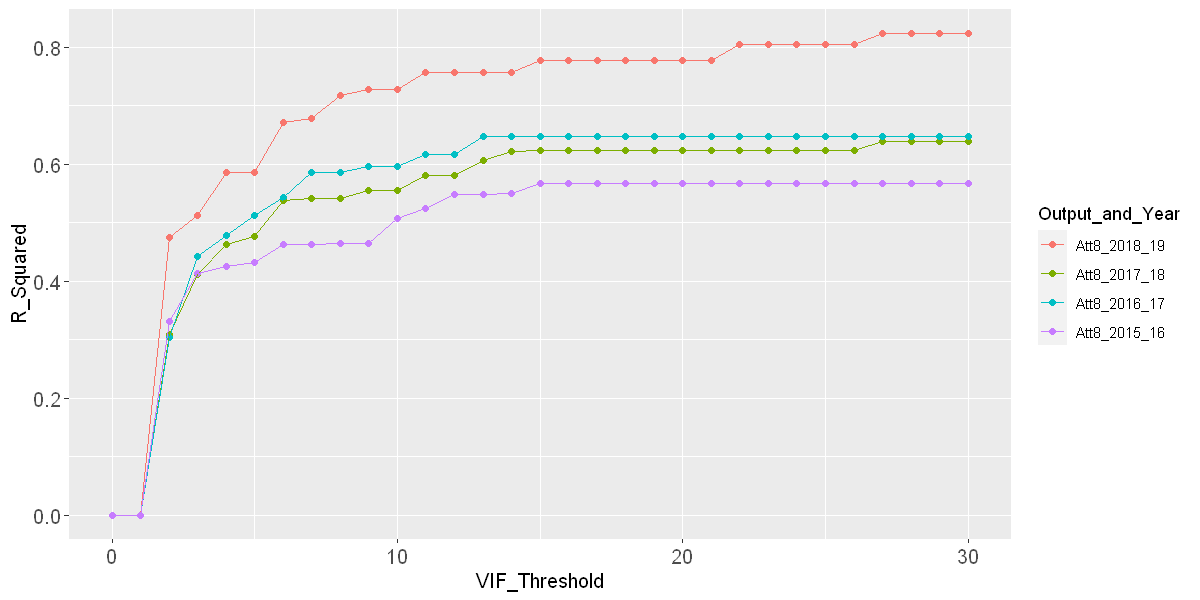

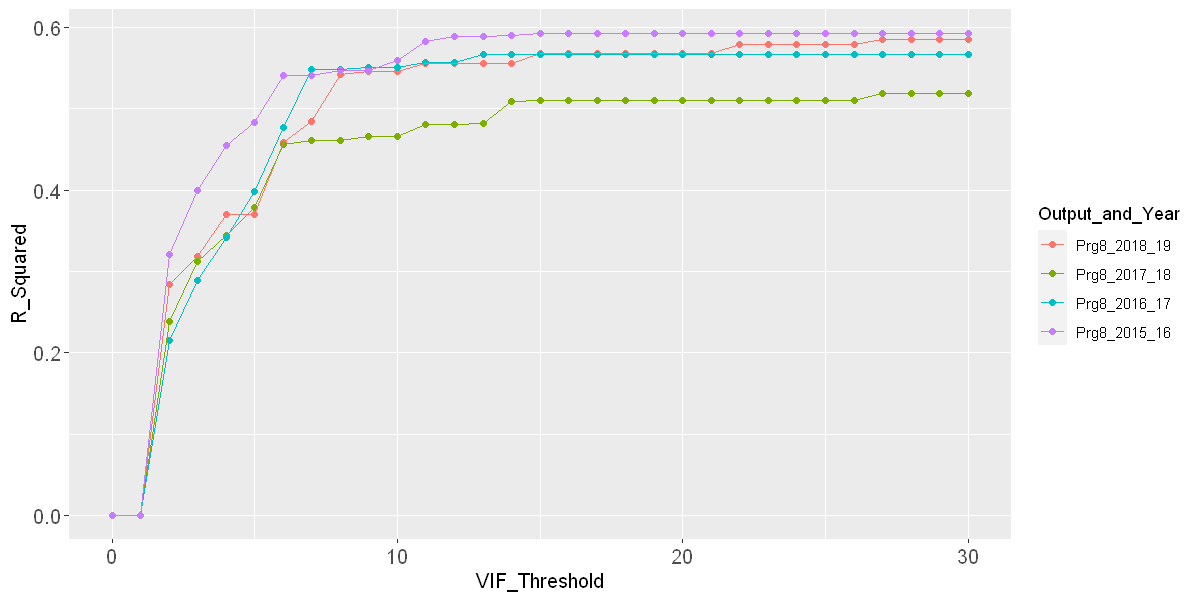

In [247]:
# head(crossyear_vif_rsqr_summary)
df<-melt(crossyear_vif_rsqr_summary, id='VarCount')
df_Att8 <- df[df$variable=='Att8_2018_19' |
         df$variable=='Att8_2017_18' | 
         df$variable=='Att8_2016_17' | 
         df$variable=='Att8_2015_16' , ]


df_Prg8 <- df[df$variable=='Prg8_2018_19' |
         df$variable=='Prg8_2017_18' | 
         df$variable=='Prg8_2016_17' | 
         df$variable=='Prg8_2015_16' , ]

names(df_Att8) <- c('VIF_Threshold', 'Output_and_Year', 'R_Squared')
names(df_Prg8) <- c('VIF_Threshold', 'Output_and_Year', 'R_Squared')

# head(df_Att8)
ggplot(df_Att8, aes(x =VIF_Threshold, 
                    y =R_Squared, 
                    color =Output_and_Year)) + geom_point() + geom_line() +
       theme(axis.text=element_text(size=12), axis.title=element_text(size=12))


ggplot(df_Prg8, aes(x =VIF_Threshold, 
                    y =R_Squared, 
                    color =Output_and_Year)) + geom_point() + geom_line() +
       theme(axis.text=element_text(size=12), axis.title=element_text(size=12))

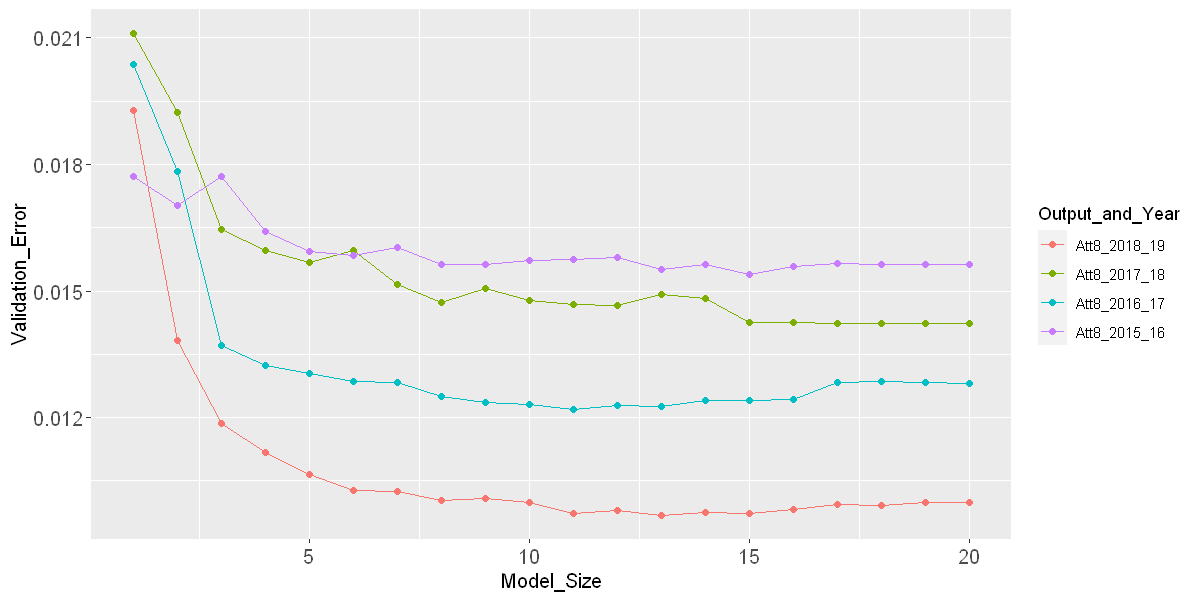

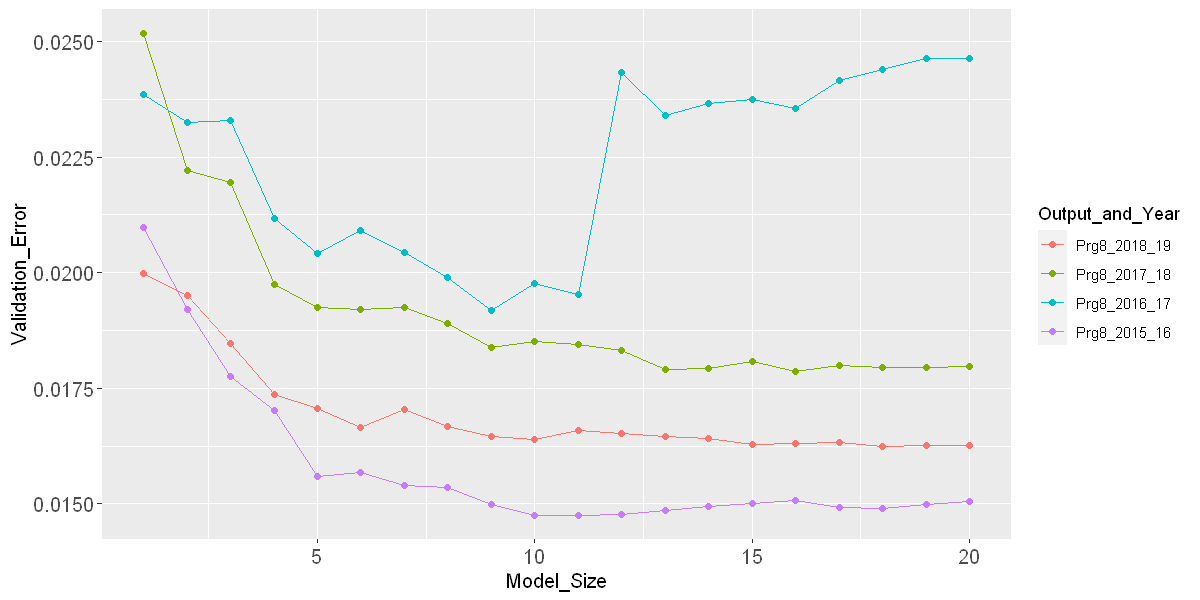

In [248]:
# head(crossyear_crossval_summary)
df<-melt(crossyear_crossval_summary, id='VarCount')
df_Att8 <- df[df$variable=='Att8_2018_19' |
         df$variable=='Att8_2017_18' | 
         df$variable=='Att8_2016_17' | 
         df$variable=='Att8_2015_16' , ]
# head(df_Att8)

df_Prg8 <- df[df$variable=='Prg8_2018_19' |
         df$variable=='Prg8_2017_18' | 
         df$variable=='Prg8_2016_17' | 
         df$variable=='Prg8_2015_16' , ]

names(df_Att8) <- c('Model_Size', 'Output_and_Year', 'Validation_Error')
names(df_Prg8) <- c('Model_Size', 'Output_and_Year', 'Validation_Error')

# head(df_Prg8)
ggplot(df_Att8[df_Att8$Model_Size<=20, ], aes(x =Model_Size, 
                    y =Validation_Error, 
                    color =Output_and_Year)) + geom_point() + geom_line() +
       theme(axis.text=element_text(size=12), axis.title=element_text(size=12))


ggplot(df_Prg8[df_Prg8$Model_Size<=20, ], aes(x =Model_Size, 
                    y =Validation_Error, 
                    color =Output_and_Year)) + geom_point() + geom_line() +
       theme(axis.text=element_text(size=12), axis.title=element_text(size=12))


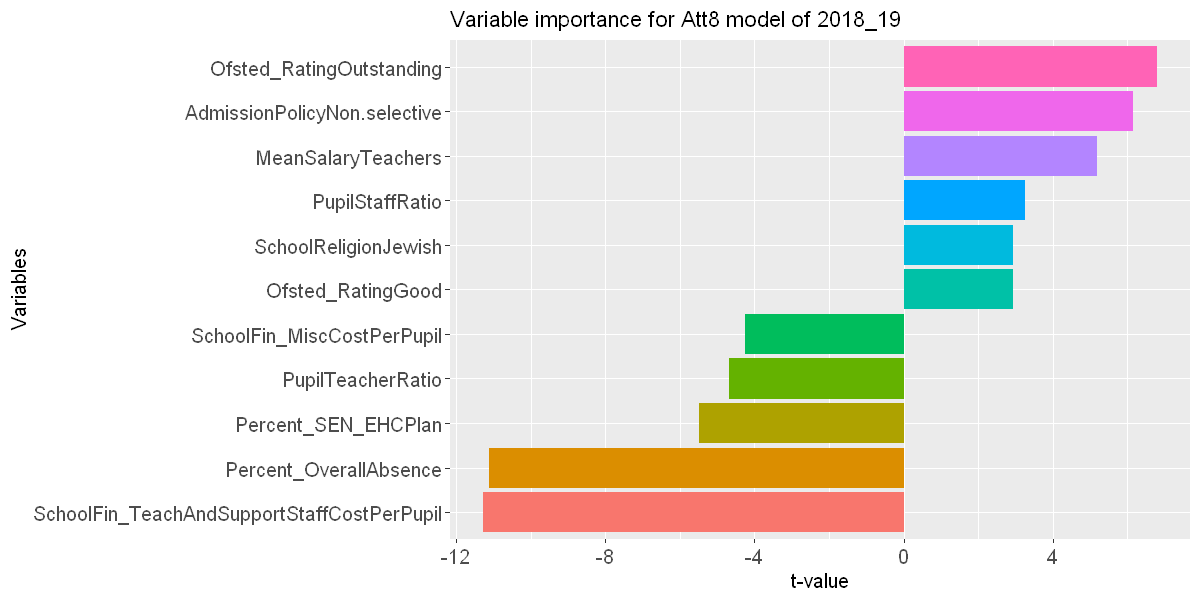

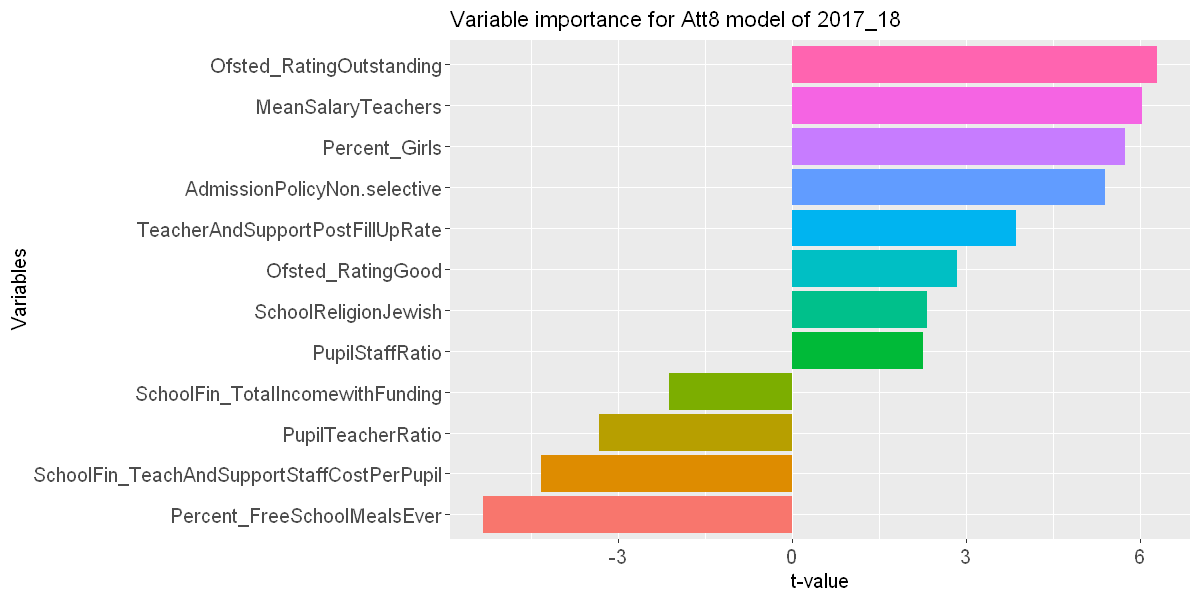

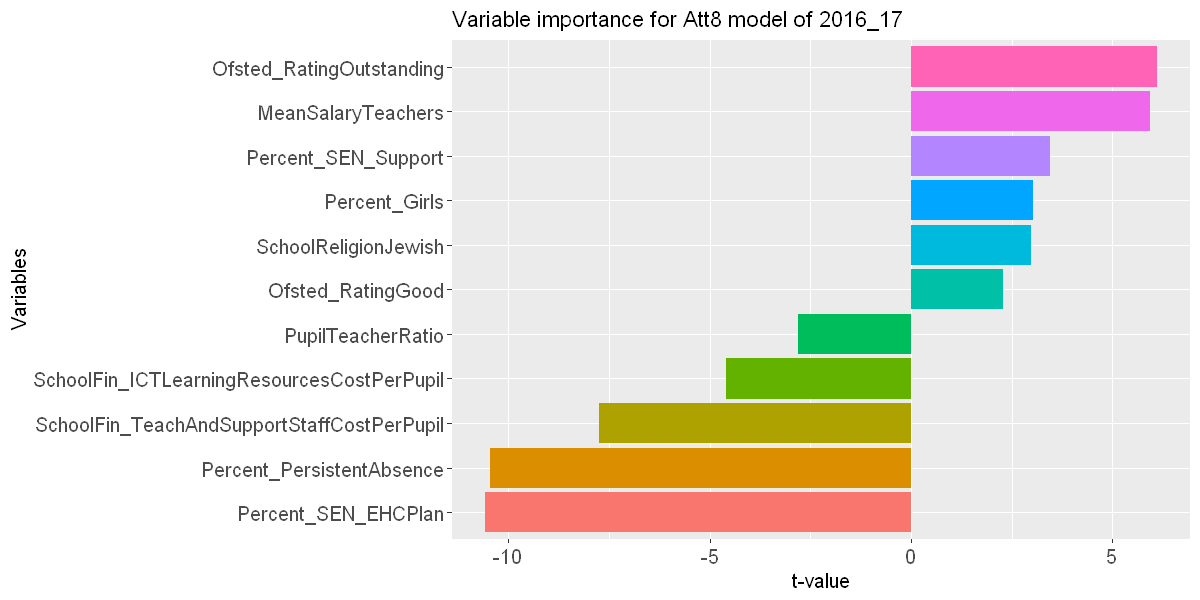

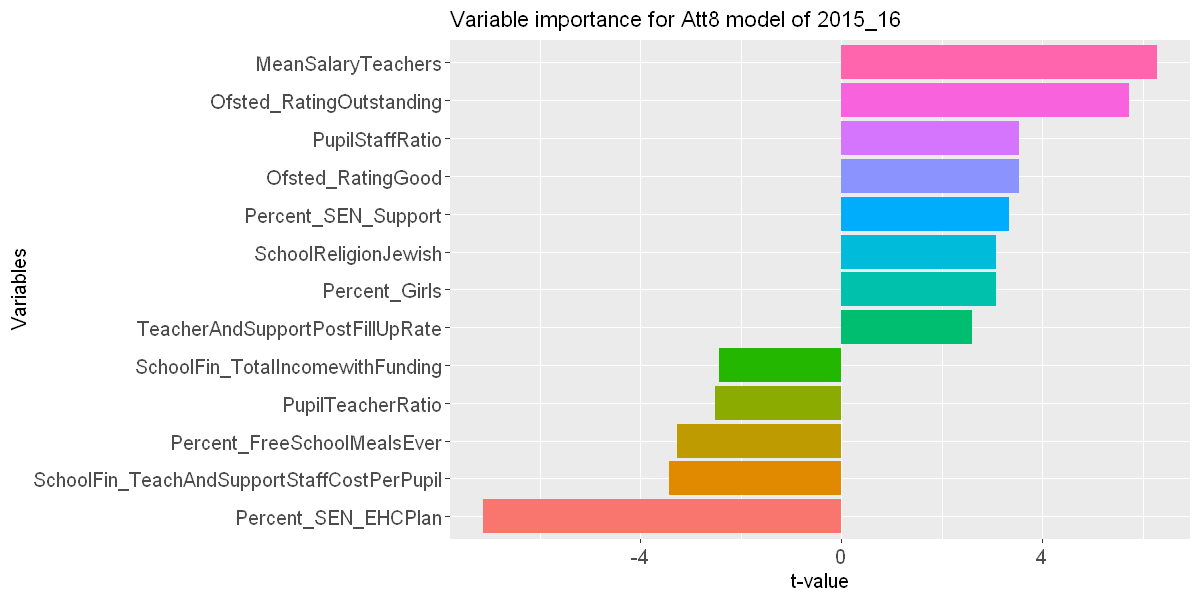

In [249]:
# plot the Att8 variable importance from CrossVal
years <- c('2018_19', '2017_18', '2016_17', '2015_16')

for (yr in years) {
    df <- coeffs_summary[coeffs_summary$Year==yr 
                     & coeffs_summary$Analysis=='CrossVal' 
                     & coeffs_summary$OutputVar=='Att8'
                     & coeffs_summary$Coefficient!='(Intercept)',]
    df <- df[order(-df$t_value),]
    print(ggplot(data=df, aes(x=reorder(Coefficient, t_value), y=t_value, fill=reorder(Coefficient, t_value))) + 
       ggtitle(paste("Variable importance for Att8 model of", yr)) + xlab("Variables") + ylab("t-value") + 
       geom_bar(stat="identity") + scale_colour_gradientn(colours=rainbow(9)) + 
       theme(legend.position="none", axis.text=element_text(size=12), axis.title=element_text(size=12)) + coord_flip())
}




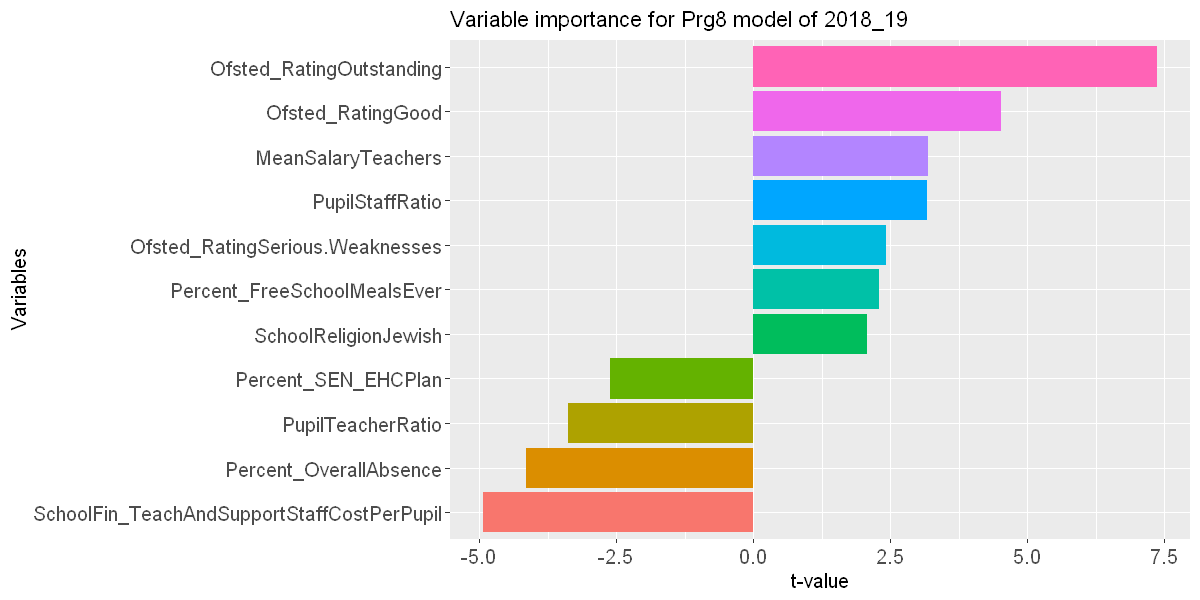

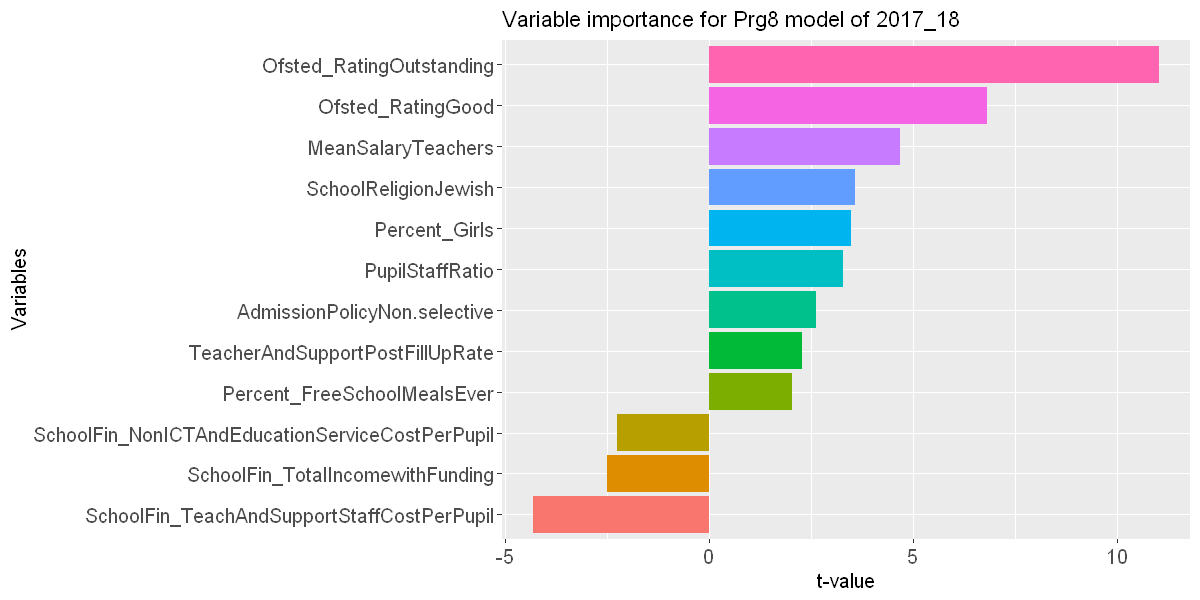

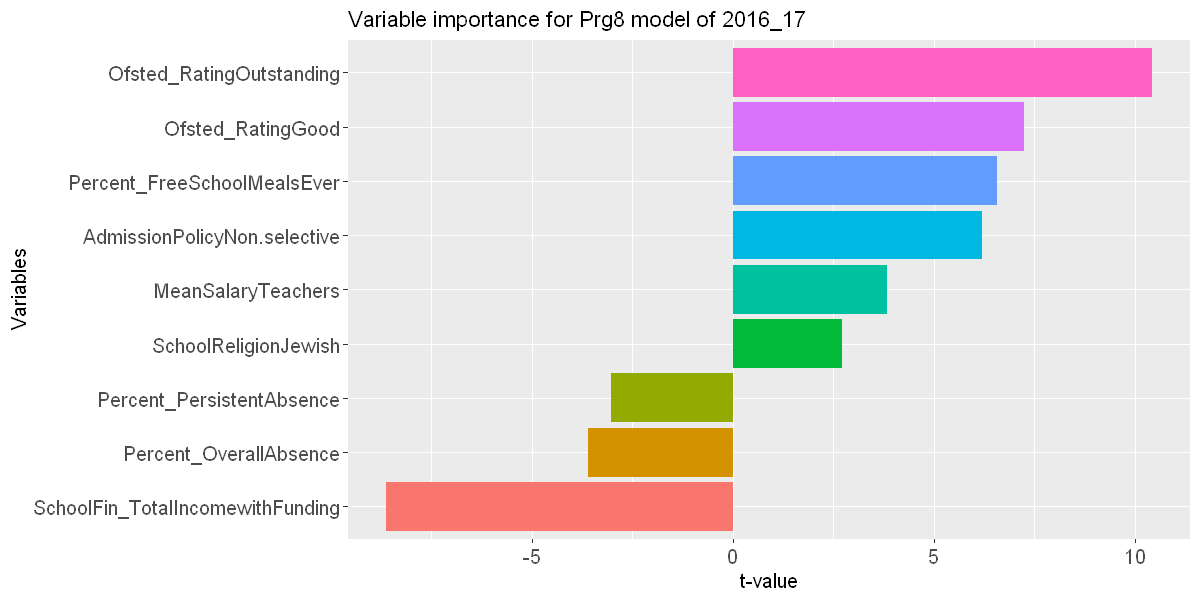

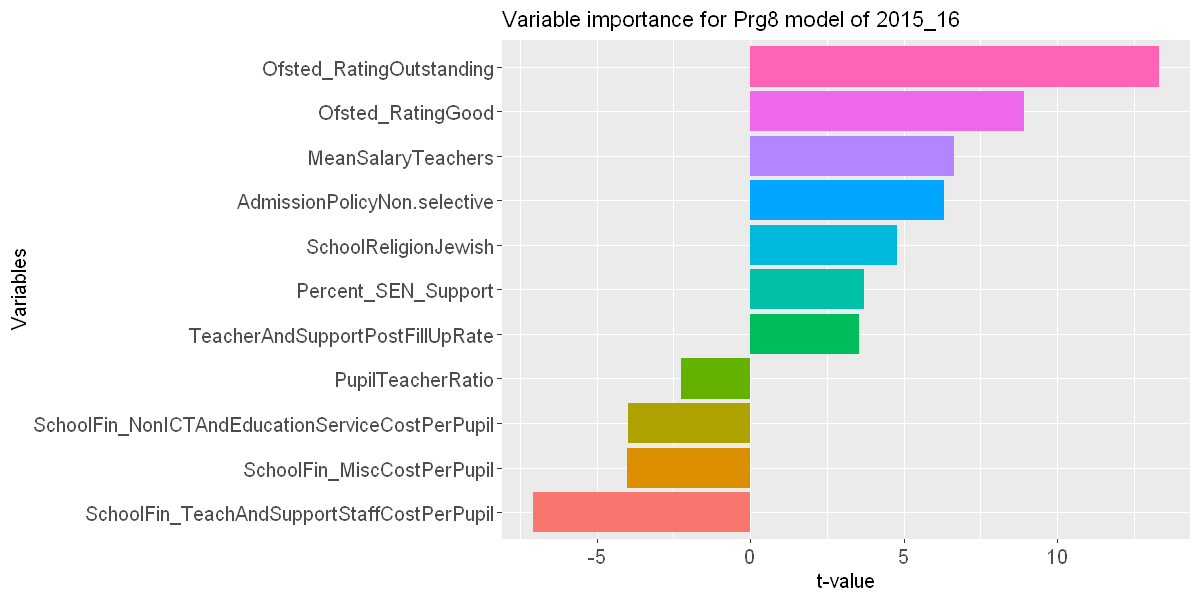

In [250]:
# plot the Prg8 variable importance from CrossVal
for (yr in years) {
    df <- coeffs_summary[coeffs_summary$Year==yr 
                     & coeffs_summary$Analysis=='CrossVal' 
                     & coeffs_summary$OutputVar=='Prg8'
                     & coeffs_summary$Coefficient!='(Intercept)',]
    df <- df[order(-df$t_value),]
    print(ggplot(data=df, aes(x=reorder(Coefficient, t_value), y=t_value, fill=reorder(Coefficient, t_value))) + 
       ggtitle(paste("Variable importance for Prg8 model of", yr)) + xlab("Variables") + ylab("t-value") + 
       geom_bar(stat="identity") + scale_colour_gradientn(colours=rainbow(9)) + 
       theme(legend.position="none", axis.text=element_text(size=12), axis.title=element_text(size=12)) + coord_flip())
}

In [251]:
# Rank the frequency of appearance of a predictor variables across multiple years of Att8 model
coefs <- unique(coeffs_summary$Coefficient)

freq <- c()
for (c in coefs) {

   df <- coeffs_summary[coeffs_summary$Coefficient==c & 
                        coeffs_summary$OutputVar=='Att8' &
                        coeffs_summary$Analysis=='CrossVal', ]
   freq <- c(freq, nrow(df))
}

coeffs_freq_att8 <- data.frame(Variable=coefs, Frequency=freq)
coeffs_freq_att8[order(-coeffs_freq_att8$Frequency),]

Variable                                        Frequency
4  PupilTeacherRatio                               4        
5  MeanSalaryTeachers                              4        
7  SchoolFin_TeachAndSupportStaffCostPerPupil      4        
9  SchoolReligionJewish                            4        
11 Ofsted_RatingGood                               4        
12 Ofsted_RatingOutstanding                        4        
2  Percent_SEN_EHCPlan                             3        
6  PupilStaffRatio                                 3        
13 Percent_Girls                                   3        
1  (Intercept)                                     2        
10 AdmissionPolicyNon.selective                    2        
14 Percent_FreeSchoolMealsEver                     2        
15 SchoolFin_TotalIncomewithFunding                2        
16 TeacherAndSupportPostFillUpRate                 2        
17 Percent_SEN_Support                             2        
3  Percent_OverallAbsence                          1        
8  SchoolFin_MiscCostPerPupil                      1        
18 Percent_PersistentAbsence                       1        
19 SchoolFin_ICTLearningResourcesCostPerPupil      1        
20 Ofsted_RatingSerious.Weaknesses                 0        
21 SchoolFin_NonICTAndEducationServiceCostPerPupil 0

In [252]:
# Rank the frequency of appearance of a predictor variables across multiple years of Prg8 model
coefs <- unique(coeffs_summary$Coefficient)

freq <- c()
for (c in coefs) {

   df <- coeffs_summary[coeffs_summary$Coefficient==c & 
                        coeffs_summary$OutputVar=='Prg8' &
                        coeffs_summary$Analysis=='CrossVal', ]
   freq <- c(freq, nrow(df))
}

coeffs_freq_prg8 <- data.frame(Variable=coefs, Frequency=freq)
coeffs_freq_prg8[order(-coeffs_freq_att8$Frequency),]

Variable                                        Frequency
4  PupilTeacherRatio                               2        
5  MeanSalaryTeachers                              4        
7  SchoolFin_TeachAndSupportStaffCostPerPupil      3        
9  SchoolReligionJewish                            4        
11 Ofsted_RatingGood                               4        
12 Ofsted_RatingOutstanding                        4        
2  Percent_SEN_EHCPlan                             1        
6  PupilStaffRatio                                 2        
13 Percent_Girls                                   1        
1  (Intercept)                                     3        
10 AdmissionPolicyNon.selective                    3        
14 Percent_FreeSchoolMealsEver                     3        
15 SchoolFin_TotalIncomewithFunding                2        
16 TeacherAndSupportPostFillUpRate                 2        
17 Percent_SEN_Support                             1        
3  Percent_OverallAbsence                          2        
8  SchoolFin_MiscCostPerPupil                      1        
18 Percent_PersistentAbsence                       1        
19 SchoolFin_ICTLearningResourcesCostPerPupil      0        
20 Ofsted_RatingSerious.Weaknesses                 1        
21 SchoolFin_NonICTAndEducationServiceCostPerPupil 2

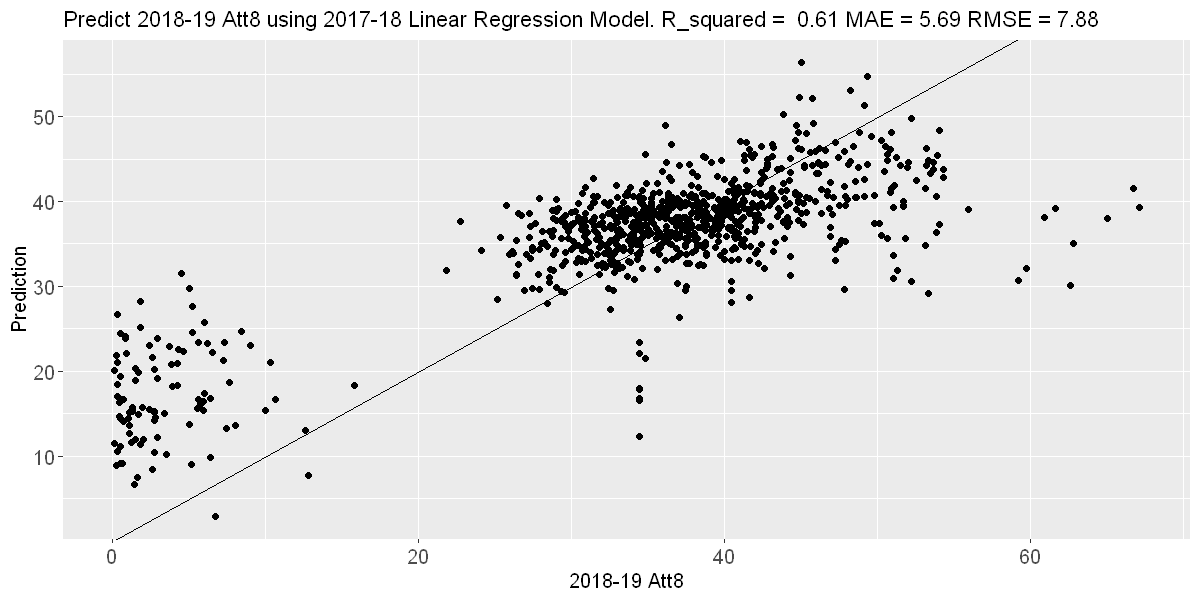

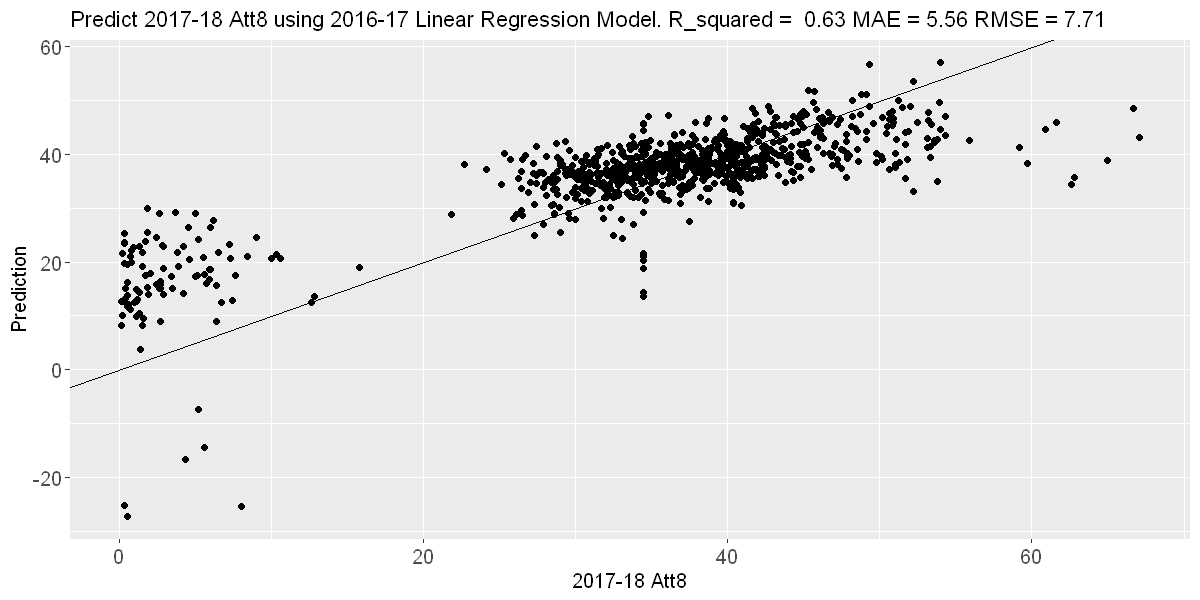

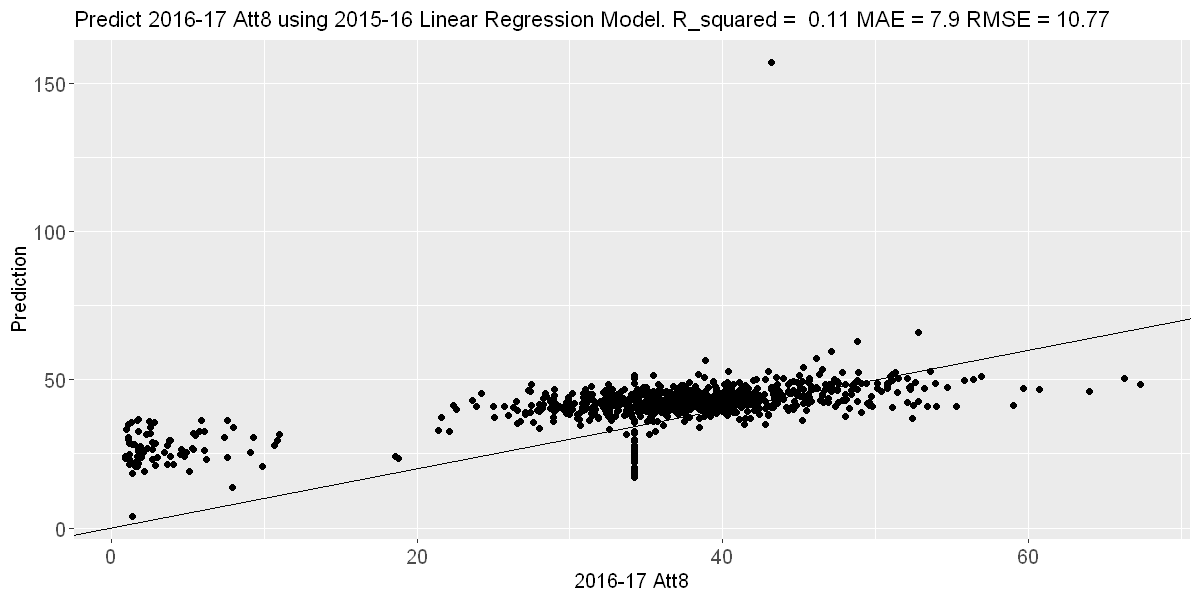

In [253]:
# Plot cross year prediction

R_squared<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('R_squared')]
MAE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('MAE')]
RMSE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('RMSE')]

ggplot(predAtt8_1718_1819, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2018-19 Att8 using 2017-18 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2018-19 Att8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))



R_squared<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('R_squared')]
MAE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('MAE')]
RMSE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('RMSE')]
ggplot(predAtt8_1617_1718, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2017-18 Att8 using 2016-17 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2017-18 Att8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))


R_squared <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('R_squared')]
MAE <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('MAE')]
RMSE <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Att8' , c('RMSE')]

ggplot(predAtt8_1516_1617, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2016-17 Att8 using 2015-16 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2016-17 Att8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))

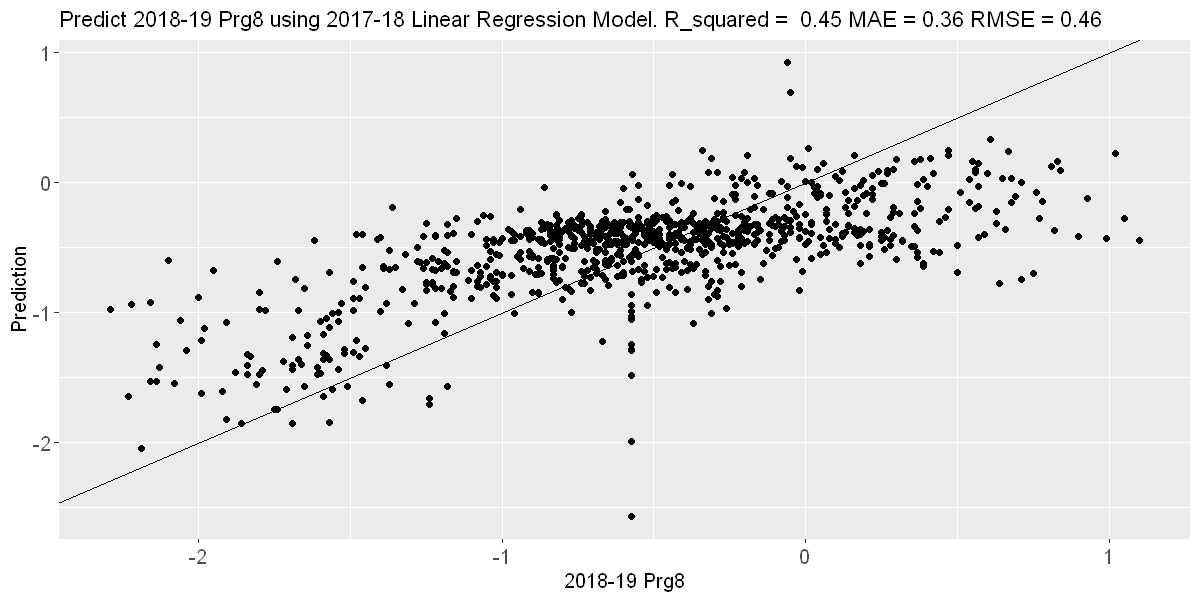

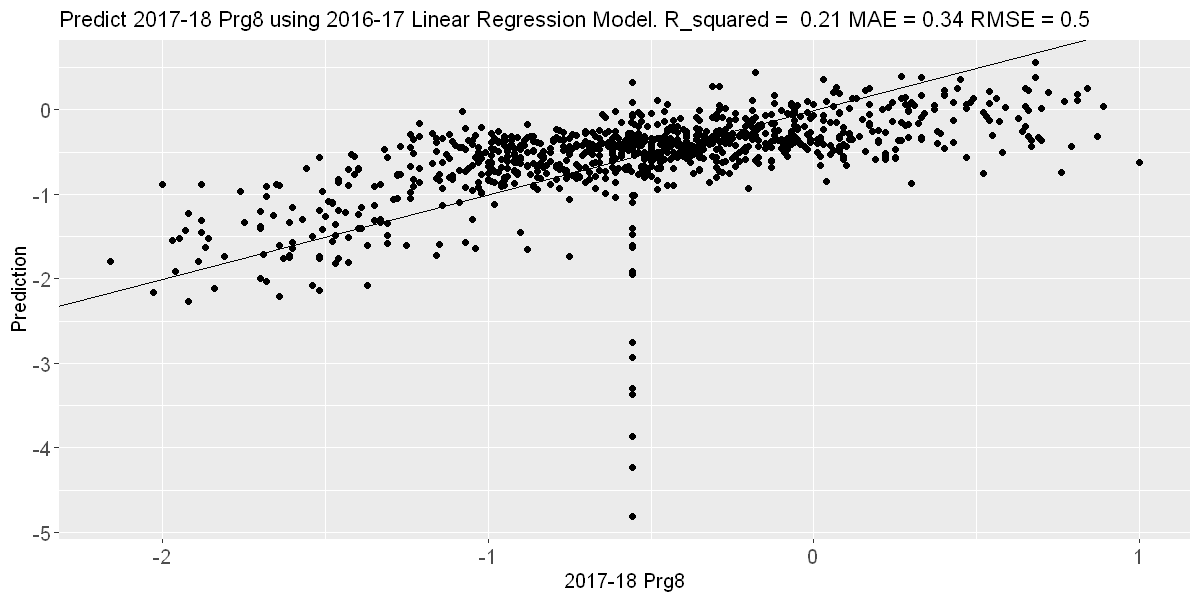

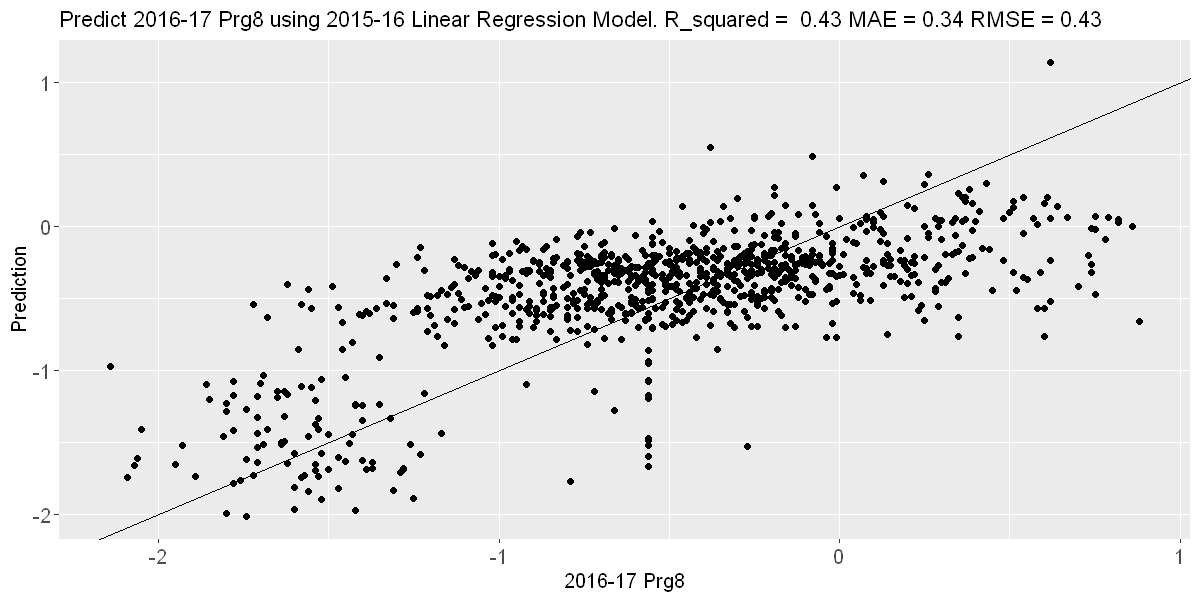

In [254]:
# Plot cross year prediction
R_squared<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('R_squared')]
MAE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('MAE')]
RMSE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2017_18'&
                           crossyear_pred_summary$Input_Year=='2018_19' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('RMSE')]

ggplot(predPrg8_1718_1819, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2018-19 Prg8 using 2017-18 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2018-19 Prg8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))



R_squared<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2017_18' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('R_squared')]
MAE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2017_18' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('MAE')]
RMSE<-crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2016_17'&
                           crossyear_pred_summary$Input_Year=='2017_18' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('RMSE')]
ggplot(predPrg8_1617_1718, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2017-18 Prg8 using 2016-17 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2017-18 Prg8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))


R_squared <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('R_squared')]
MAE <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('MAE')]
RMSE <- crossyear_pred_summary[crossyear_pred_summary$Model_Year=='2015_16'&
                           crossyear_pred_summary$Input_Year=='2016_17' &
                           crossyear_pred_summary$OutputVar=='Prg8' , c('RMSE')]

ggplot(predPrg8_1516_1617, aes(x=orig,y=pred)) + geom_point() + geom_abline(intercept = 0) + 
    ggtitle(paste('Predict 2016-17 Prg8 using 2015-16 Linear Regression Model. R_squared = ', round(R_squared,2),
                 'MAE =', round(MAE,2), 'RMSE =', round(RMSE,2))) + 
   xlab("2016-17 Prg8") + ylab("Prediction")  + theme(axis.text=element_text(size=12), axis.title=element_text(size=12))

## 2.2 Random Forest Regression

### 2.2.1 Prepare data for Random forest analysis of Attainment 8 score and Progress 8 score

In [255]:

# ************************************************
# Create dataset for Attainment 8 score analysis by removing column that have collinearity problem checked by VIF
# Each year will have two datasets, "train" for the modeling part, "test" for the prediction part
Att8dataset_2018_19train <- XY_2018_19_encoded
Att8dataset_2018_19test <- XY_2018_19_encoded
Att8dataset_2018_19train[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable")] <- NULL
Att8dataset_2018_19test[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_SEN_EHCPlan"                                  
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_UnclassifiedLang"                             
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"TeacherAndSupportStaffCount"                          
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable")]  <- NULL
                           
Att8dataset_2017_18train <- XY_2017_18_encoded
Att8dataset_2017_18test <- XY_2017_18_encoded                           
Att8dataset_2017_18train[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_SEN_EHCPlan"                                  
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_UnclassifiedLang"                             
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"TeacherAndSupportStaffCount"                          
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable")]  <- NULL
Att8dataset_2017_18test[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNon.selective"                         
,"AdmissionPolicyNot.applicable" )] <- NULL
                           
Att8dataset_2016_17train <- XY_2016_17_encoded
Att8dataset_2016_17test <- XY_2016_17_encoded
Att8dataset_2016_17train[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNon.selective"                         
,"AdmissionPolicyNot.applicable" )] <- NULL
Att8dataset_2016_17test[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNon.selective"                         
,"AdmissionPolicyNot.applicable")] <- NULL
                           
Att8dataset_2015_16train <- XY_2015_16_encoded
Att8dataset_2015_16test <- XY_2015_16_encoded
Att8dataset_2015_16train[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNon.selective"                         
,"AdmissionPolicyNot.applicable")] <- NULL
Att8dataset_2015_16test[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNon.selective"                         
,"AdmissionPolicyNot.applicable")] <- NULL

In [256]:
# Create dataset for Progress 8 score analysis by removing column that have collinearity problem checked by VIF
# Each year will have two datasets, "train" for the modeling part, "test" for the prediction part
Prg8dataset_2018_19train <- XY_2018_19_encoded
Prg8dataset_2018_19test <- XY_2018_19_encoded
Prg8dataset_2018_19train[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable" )] <- NULL
Prg8dataset_2018_19test[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_SEN_EHCPlan"                                  
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_UnclassifiedLang"                             
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"TeacherAndSupportStaffCount"                          
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable" )] <- NULL

Prg8dataset_2017_18train <- XY_2017_18_encoded
Prg8dataset_2017_18test <- XY_2017_18_encoded
Prg8dataset_2017_18train[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_SEN_EHCPlan"                                  
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_UnclassifiedLang"                             
,"Percent_OverallAbsence"                               
,"Percent_PersistentAbsence"                            
,"TeacherAndSupportStaffCount"                          
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable" )] <- NULL
Prg8dataset_2017_18test[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable"  )] <- NULL

Prg8dataset_2016_17train <- XY_2016_17_encoded
Prg8dataset_2016_17test <- XY_2016_17_encoded
Prg8dataset_2016_17train[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable"  )] <- NULL
Prg8dataset_2016_17test[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable"  )] <- NULL

Prg8dataset_2015_16train <- XY_2015_16_encoded
Prg8dataset_2015_16test <- XY_2015_16_encoded
Prg8dataset_2015_16train[,c("Att8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable"  )] <- NULL
Prg8dataset_2015_16test[,c("Prg8Score_Disadvantaged"
,"TotalPupilsNo"                                        
,"Percent_NonEngFirstLang"                              
,"Percent_EngFirstLang"                                 
,"Percent_PersistentAbsence"                            
,"SCHOOLTYPECommunity.school"                           
,"SCHOOLTYPECommunity.special.school"                   
,"SCHOOLTYPEFoundation.special.school"                  
,"SCHOOLTYPEVoluntary.aided.school"                     
,"SchoolReligionChurchofEngland_RomanCatholic_Christian"
,"SchoolReligionDoes.not.apply"                         
,"AdmissionPolicyNot.applicable"  )] <- NULL

### 2.2.2 Analysis of Attainment 8 Score Across Multiple Years


Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2015_16train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 8

          Mean of squared residuals: 48.37709
                    % Var explained: 60.04
mtry = 8  OOB error = 47.99532 
Searching left ...
mtry = 4 	OOB error = 48.49585 
-0.01042883 0.01 
Searching right ...
mtry = 16 	OOB error = 49.65958 
-0.03467547 0.01 

Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2015_16train,      mtry = best_A15_16mtry, importance = TRUE, ntree = min_2015_16) 
               Type of random forest: regression
                     Number of trees: 338
No. of variables tried at each split: 8

          Mean of squared residuals: 48.63721
                    % Var explained: 59.83


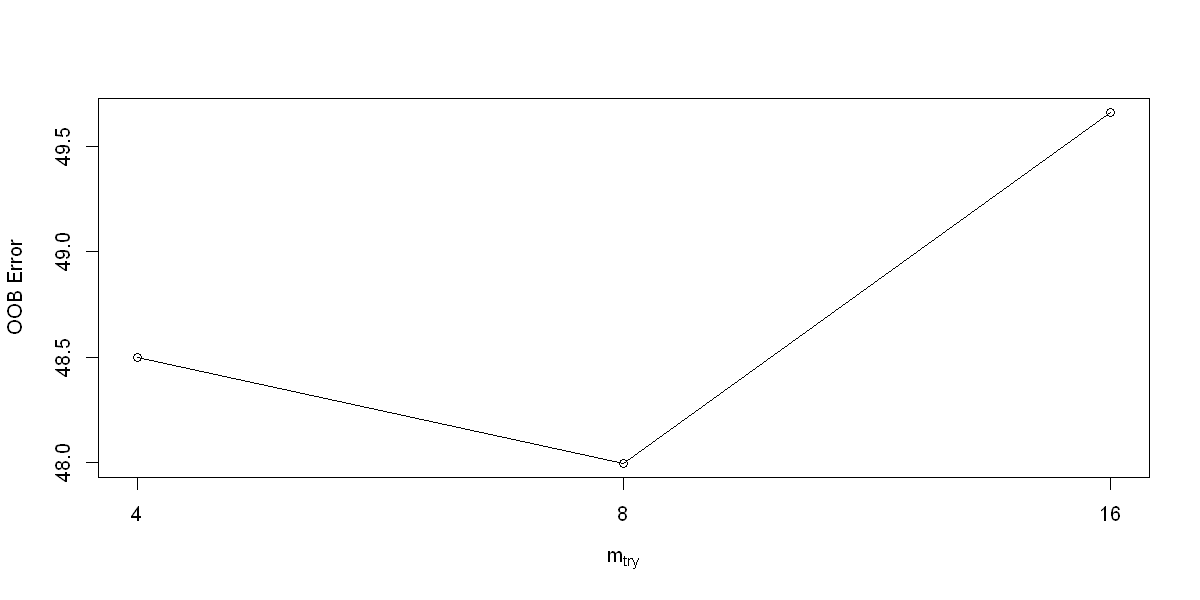

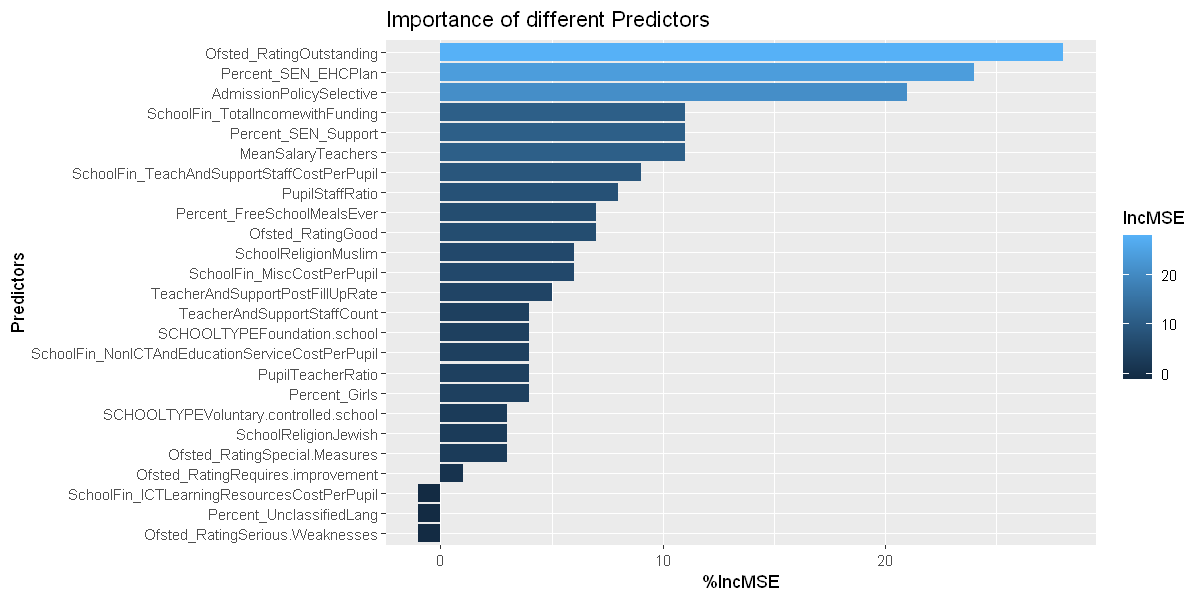

In [257]:
# ************************************************
# Let's first fit the 2015_16 data, with Att8Score_Disadvantaged as ouput
set.seed(123)
rf_2015_16 <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2015_16train,importance = TRUE, ntree=1000) 
print(rf_2015_16)

# determine the number of trees to create by the minimum mean squared error.
min_2015_16 <- which.min(rf_2015_16$mse)
# determine the number of split to create the minimum OOB error.
A15_16mtry <- tuneRF(Att8dataset_2015_16train[-1],Att8dataset_2015_16train$Att8Score_Disadvantaged, ntreeTry=min_2015_16,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_A15_16mtry <- A15_16mtry[A15_16mtry[,2] == min(A15_16mtry[,2]),1]
# plot again with optimal no. of trees
rf_2015_16.opt <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2015_16train,mtry = best_A15_16mtry, importance = TRUE, ntree=min_2015_16) 
print(rf_2015_16.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_A15_16 <- EvaluateImportance(rf_2015_16.opt)


Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2016_17train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 9

          Mean of squared residuals: 47.03227
                    % Var explained: 63.88
mtry = 9  OOB error = 47.22445 
Searching left ...
mtry = 5 	OOB error = 47.19416 
0.0006414443 0.01 
Searching right ...
mtry = 18 	OOB error = 47.7703 
-0.01155872 0.01 

Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2016_17train,      mtry = best_A16_17mtry, importance = TRUE, ntree = min_2016_17) 
               Type of random forest: regression
                     Number of trees: 384
No. of variables tried at each split: 5

          Mean of squared residuals: 47.11373
                    % Var explained: 63.82


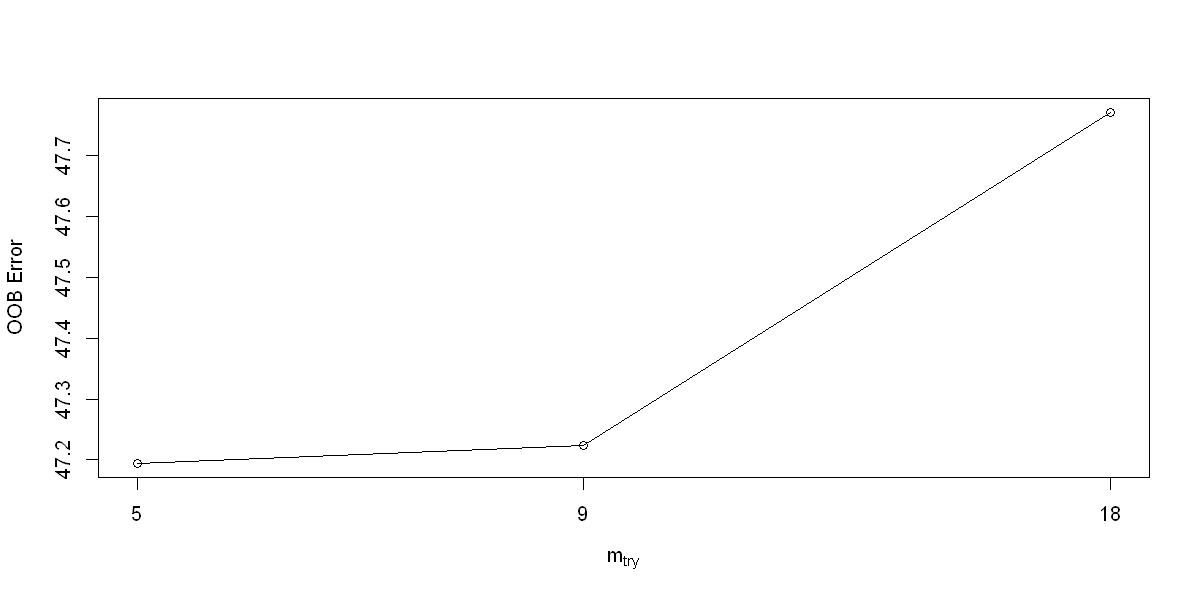

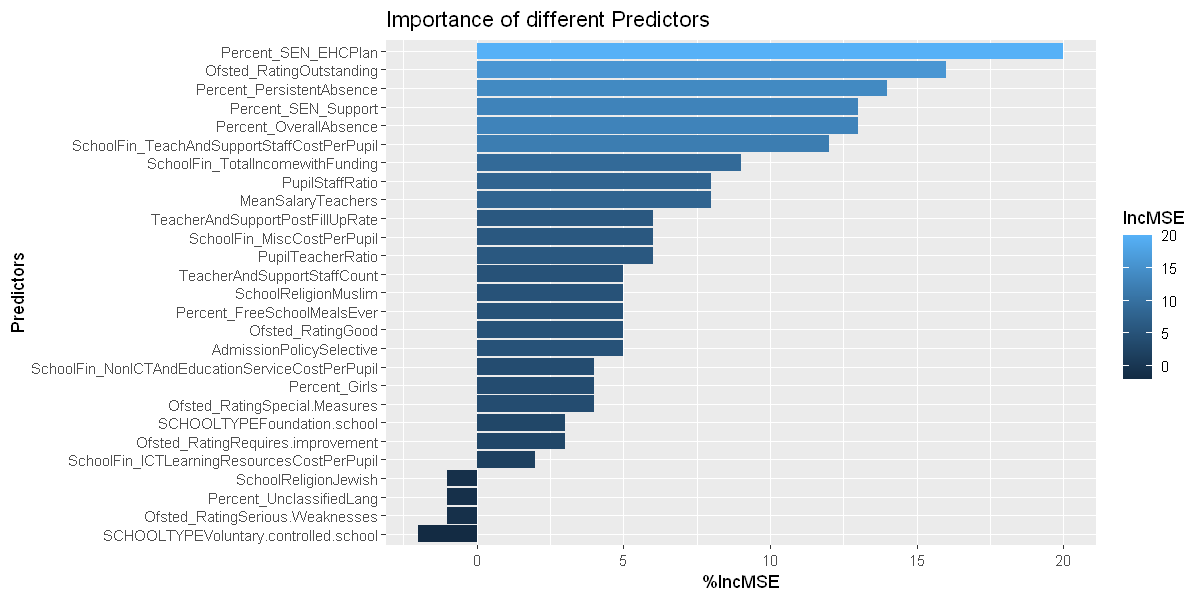

In [258]:
# ************************************************
# fit the 2016_17 data, with Att8Score_Disadvantaged as ouput
set.seed(123)
rf_2016_17 <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2016_17train,importance = TRUE, ntree=1000) 
print(rf_2016_17)

# determine the number of trees to create by the minimum mean squared error.
min_2016_17 <- which.min(rf_2016_17$mse)
# determine the number of split to create the minimum OOB error.
A16_17mtry <- tuneRF(Att8dataset_2016_17train[-1],Att8dataset_2016_17train$Att8Score_Disadvantaged, ntreeTry=min_2016_17,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_A16_17mtry <- A16_17mtry[A16_17mtry[,2] == min(A16_17mtry[,2]),1]

# plot again with optimal no. of trees
rf_2016_17.opt <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2016_17train,mtry = best_A16_17mtry, importance = TRUE, ntree=min_2016_17) 
print(rf_2016_17.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_A16_17 <- EvaluateImportance(rf_2016_17.opt)


Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2017_18train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 8

          Mean of squared residuals: 47.66594
                    % Var explained: 61.42
mtry = 8  OOB error = 48.36962 
Searching left ...
mtry = 4 	OOB error = 47.48603 
0.01826727 0.01 
mtry = 2 	OOB error = 48.82667 
-0.02823215 0.01 
Searching right ...
mtry = 16 	OOB error = 51.04657 
-0.07498064 0.01 

Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2017_18train,      mtry = best_A17_18mtry, importance = TRUE, ntree = min_2017_18) 
               Type of random forest: regression
                     Number of trees: 93
No. of variables tried at each split: 4

          Mean of squared residuals: 46.97423
                    % Var explained: 61.98


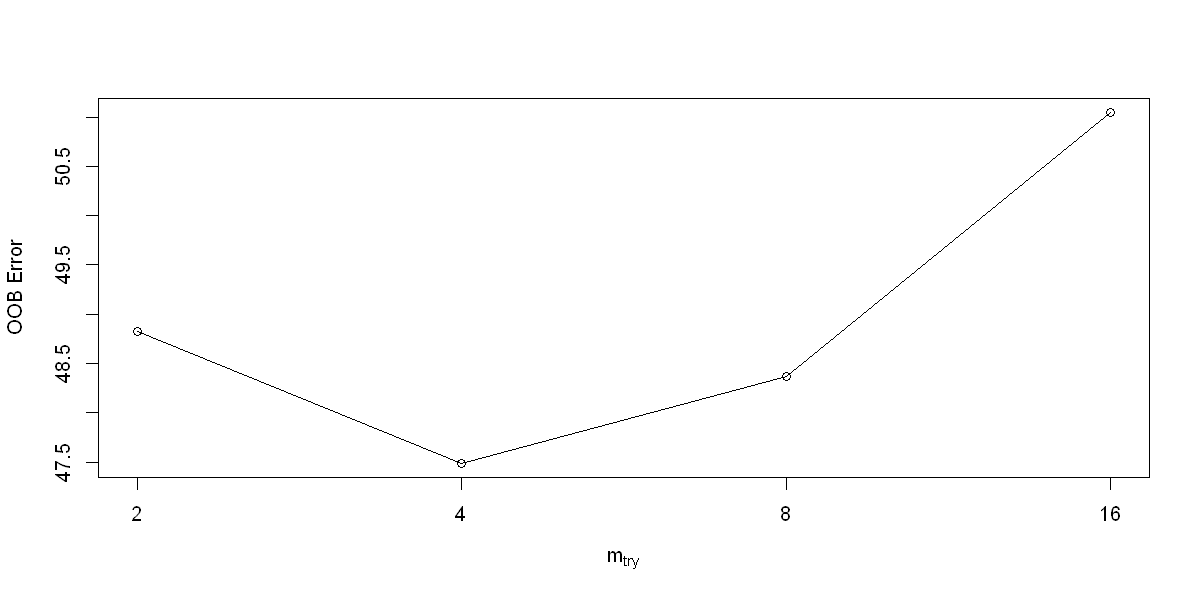

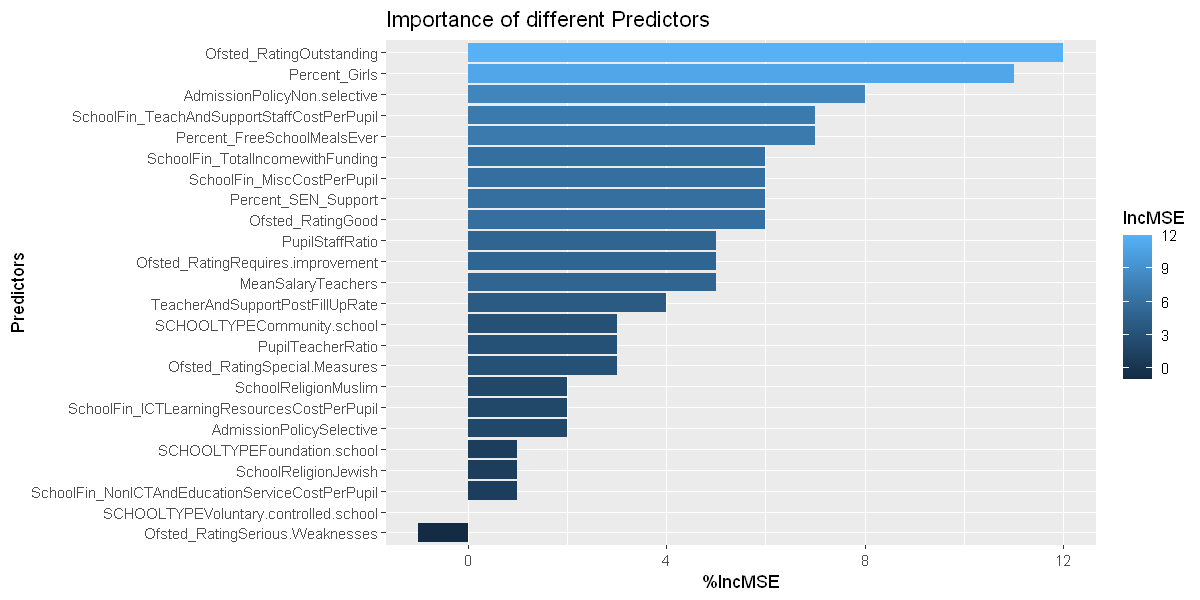

In [259]:
# ************************************************
# fit the 2017_18 data, with Att8Score_Disadvantaged as ouput
set.seed(123)
rf_2017_18 <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2017_18train,importance = TRUE, ntree=1000) 
print(rf_2017_18)

# determine the number of trees to create by the minimum mean squared error.
min_2017_18 <- which.min(rf_2017_18$mse)
# determine the number of split to create the minimum OOB error.
A17_18mtry <- tuneRF(Att8dataset_2017_18train[-1],Att8dataset_2017_18train$Att8Score_Disadvantaged, ntreeTry=min_2017_18,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_A17_18mtry <- A17_18mtry[A17_18mtry[,2] == min(A17_18mtry[,2]),1]
# plot again with optimal no. of trees
rf_2017_18.opt <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2017_18train,mtry = best_A17_18mtry, importance = TRUE, ntree=min_2017_18) 
print(rf_2017_18.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_A17_18 <- EvaluateImportance(rf_2017_18.opt)


Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2018_19train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 10

          Mean of squared residuals: 32.15986
                    % Var explained: 80.01
mtry = 10  OOB error = 32.37414 
Searching left ...
mtry = 5 	OOB error = 31.5594 
0.0251666 0.01 
mtry = 3 	OOB error = 31.61521 
-0.001768569 0.01 
Searching right ...
mtry = 20 	OOB error = 33.49201 
-0.06123715 0.01 

Call:
 randomForest(formula = Att8Score_Disadvantaged ~ ., data = Att8dataset_2018_19train,      mtry = best_A18_19mtry, importance = TRUE, ntree = min_2018_19) 
               Type of random forest: regression
                     Number of trees: 997
No. of variables tried at each split: 5

          Mean of squared residuals: 31.63666
                    % Var explained: 80.33


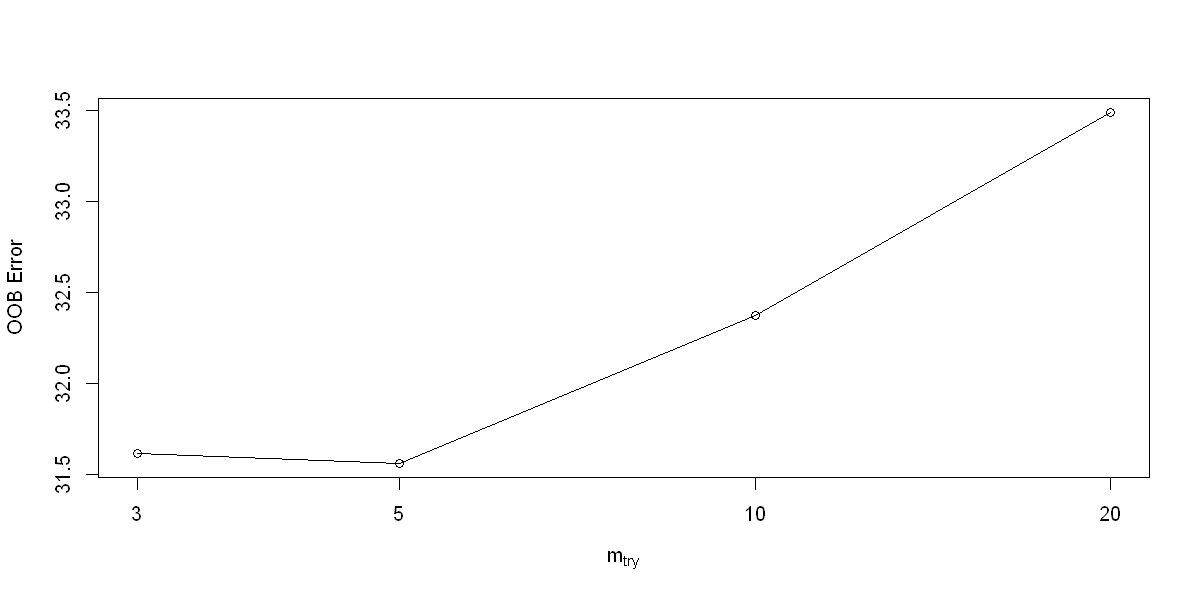

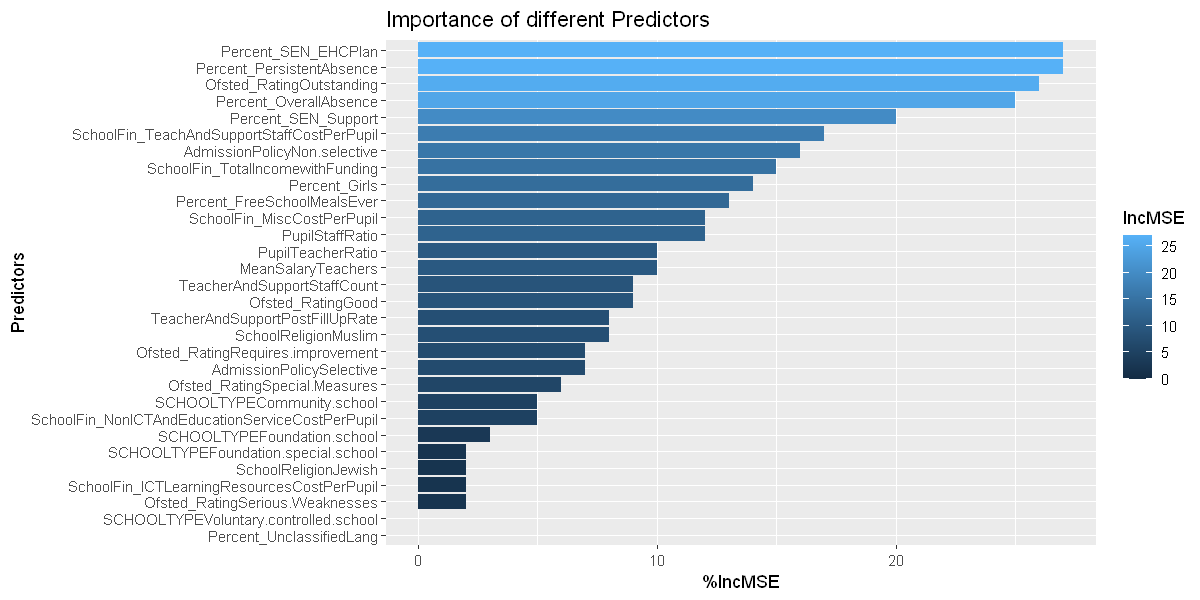

In [260]:
# ************************************************
# fit the 2018_19 data, with Att8Score_Disadvantaged as ouput
set.seed(123)
rf_2018_19 <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2018_19train,importance = TRUE, ntree=1000) 
print(rf_2018_19)

# determine the number of trees to create by the minimum mean squared error.
min_2018_19 <- which.min(rf_2018_19$mse)
# determine the number of split to create the minimum OOB error.
A18_19mtry <- tuneRF(Att8dataset_2018_19train[-1],Att8dataset_2018_19train$Att8Score_Disadvantaged, ntreeTry=min_2018_19,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_A18_19mtry <- A18_19mtry[A18_19mtry[,2] == min(A18_19mtry[,2]),1]
# plot again with optimal no. of trees
rf_2018_19.opt <-randomForest(Att8Score_Disadvantaged~.,data=Att8dataset_2018_19train,mtry = best_A18_19mtry, importance = TRUE, ntree=min_2018_19) 
print(rf_2018_19.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_A18_19 <- EvaluateImportance(rf_2018_19.opt)

### 2.2.3 Analysis of Progress 8 Score Across Multiple Years


Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2015_16train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 9

          Mean of squared residuals: 0.1336238
                    % Var explained: 60.67
mtry = 9  OOB error = 0.1343388 
Searching left ...
mtry = 5 	OOB error = 0.1337234 
0.004580839 0.01 
Searching right ...
mtry = 18 	OOB error = 0.1356544 
-0.009793402 0.01 

Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2015_16train,      mtry = best_P15_16mtry, importance = TRUE, ntree = Pmin_2015_16) 
               Type of random forest: regression
                     Number of trees: 993
No. of variables tried at each split: 5

          Mean of squared residuals: 0.1334937
                    % Var explained: 60.71


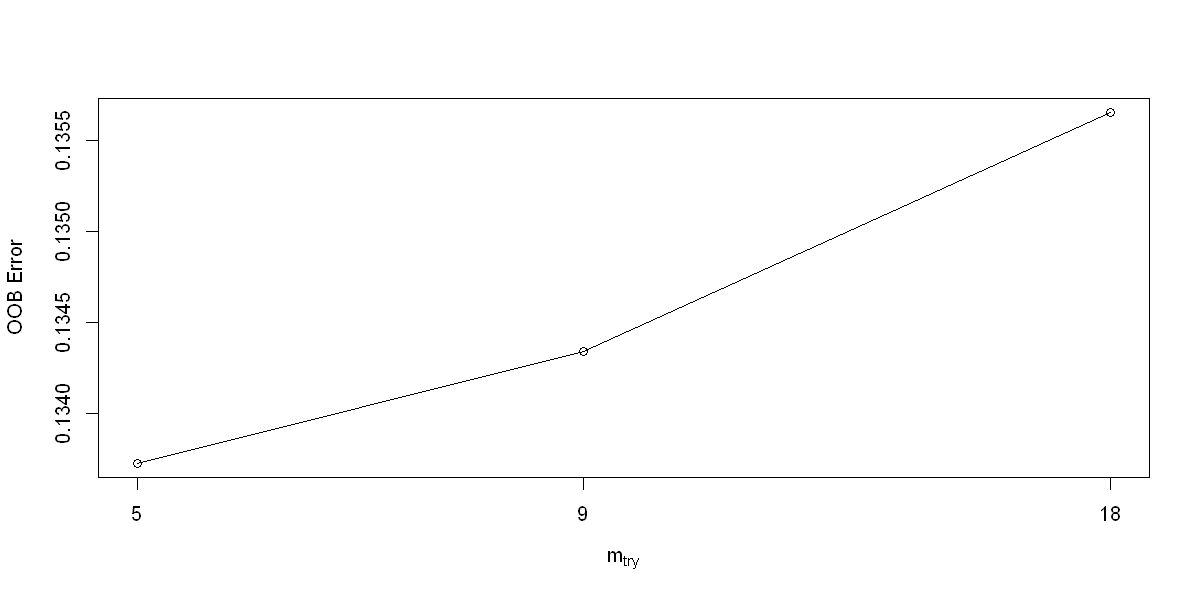

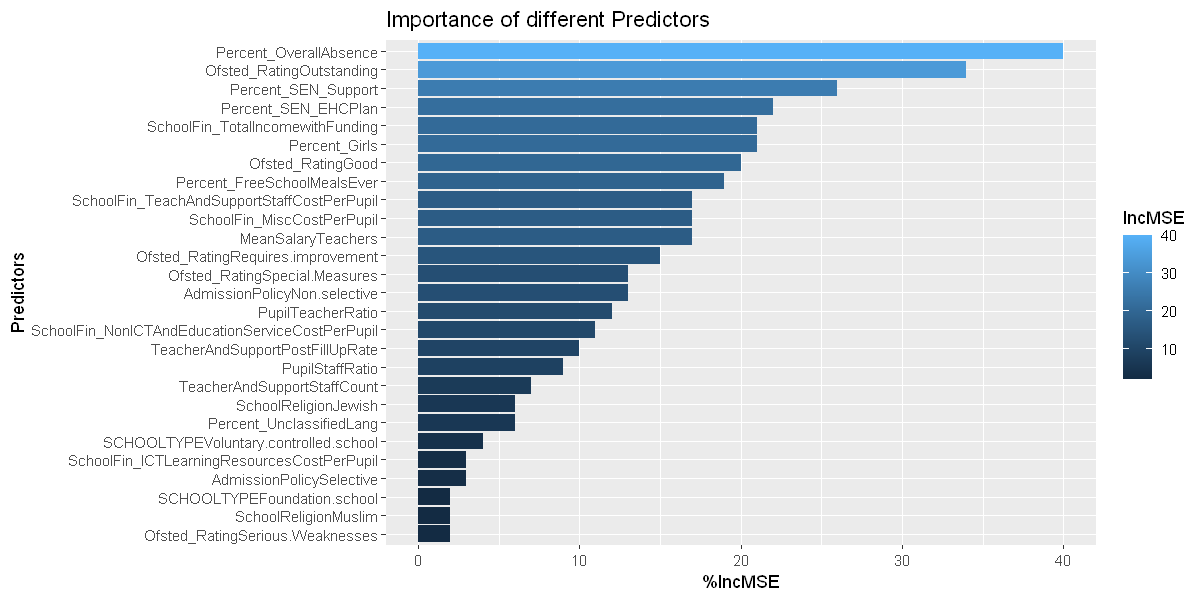

In [261]:
# ************************************************
# Like the previous part, we first analyse the 2015_16 data, with Prg8Score_Disadvantaged as ouput
set.seed(123)
Prf_2015_16 <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2015_16train,importance = TRUE, ntree=1000) 
print(Prf_2015_16)


# determine the number of trees to create by the minimum mean squared error.
Pmin_2015_16 <- which.min(Prf_2015_16$mse)
# determine the number of split to create the minimum OOB error.
P15_16mtry <- tuneRF(Prg8dataset_2015_16train[-1],Prg8dataset_2015_16train$Prg8Score_Disadvantaged, ntreeTry=Pmin_2015_16,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_P15_16mtry <- P15_16mtry[P15_16mtry[,2] == min(P15_16mtry[,2]),1]
# plot again with optimal no. of trees
Prf_2015_16.opt <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2015_16train,mtry = best_P15_16mtry, importance = TRUE, ntree=Pmin_2015_16) 
print(Prf_2015_16.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_P15_16 <- EvaluateImportance(Prf_2015_16.opt)


Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2016_17train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 9

          Mean of squared residuals: 0.134589
                    % Var explained: 58.79
mtry = 9  OOB error = 0.135285 
Searching left ...
mtry = 5 	OOB error = 0.1356013 
-0.002337768 0.01 
Searching right ...
mtry = 18 	OOB error = 0.1371829 
-0.01402864 0.01 

Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2016_17train,      mtry = best_P16_17mtry, importance = TRUE, ntree = Pmin_2016_17) 
               Type of random forest: regression
                     Number of trees: 150
No. of variables tried at each split: 9

          Mean of squared residuals: 0.1374853
                    % Var explained: 57.9


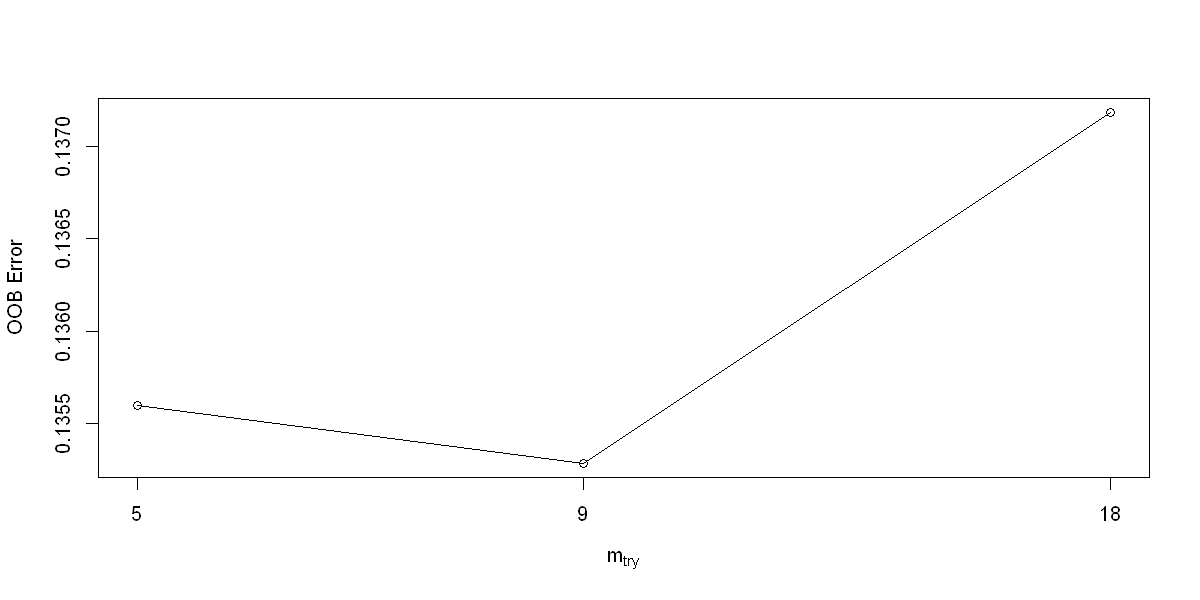

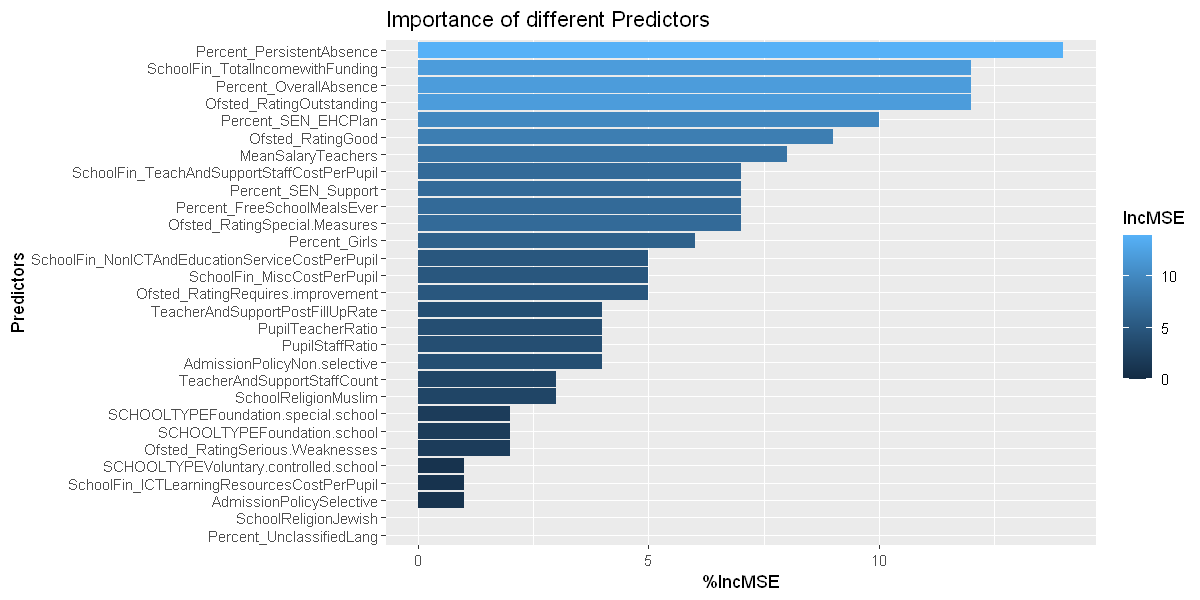

In [262]:
# ************************************************
# fit the 2016_17 data, with Prg8Score_Disadvantaged as ouput
set.seed(123)
Prf_2016_17 <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2016_17train,importance = TRUE, ntree=1000) 
print(Prf_2016_17)

# determine the number of trees to create by the minimum mean squared error.
Pmin_2016_17 <- which.min(Prf_2016_17$mse)
# determine the number of split to create the minimum OOB error.
P16_17mtry <- tuneRF(Prg8dataset_2016_17train[-1],Prg8dataset_2016_17train$Prg8Score_Disadvantaged, ntreeTry=Pmin_2016_17,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_P16_17mtry <- P16_17mtry[P16_17mtry[,2] == min(P16_17mtry[,2]),1]
# plot again with optimal no. of trees
Prf_2016_17.opt <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2016_17train,mtry=best_P16_17mtry, importance = TRUE, ntree=Pmin_2016_17) 
print(Prf_2016_17.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_P16_17 <- EvaluateImportance(Prf_2016_17.opt)


Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2017_18train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 8

          Mean of squared residuals: 0.1542714
                    % Var explained: 50.8
mtry = 8  OOB error = 0.1558944 
Searching left ...
mtry = 4 	OOB error = 0.1526856 
0.0205833 0.01 
mtry = 2 	OOB error = 0.1582012 
-0.03612419 0.01 
Searching right ...
mtry = 16 	OOB error = 0.1586611 
-0.03913619 0.01 

Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2017_18train,      mtry = best_P17_18mtry, importance = TRUE, ntree = Pmin_2017_18) 
               Type of random forest: regression
                     Number of trees: 207
No. of variables tried at each split: 4

          Mean of squared residuals: 0.1537964
                    % Var explained: 50.95


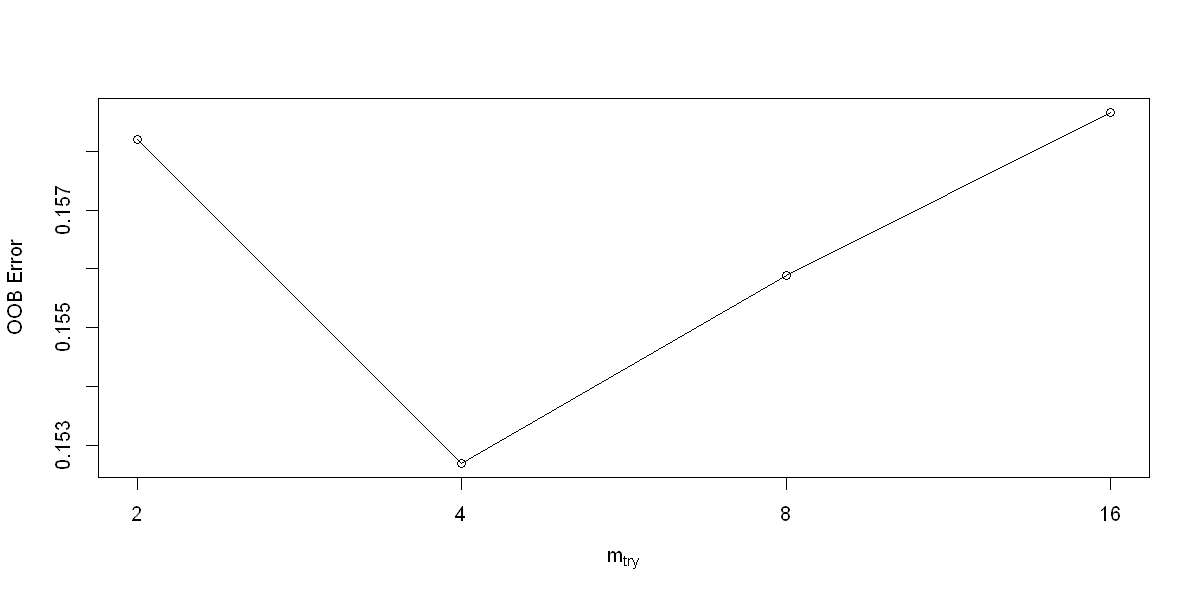

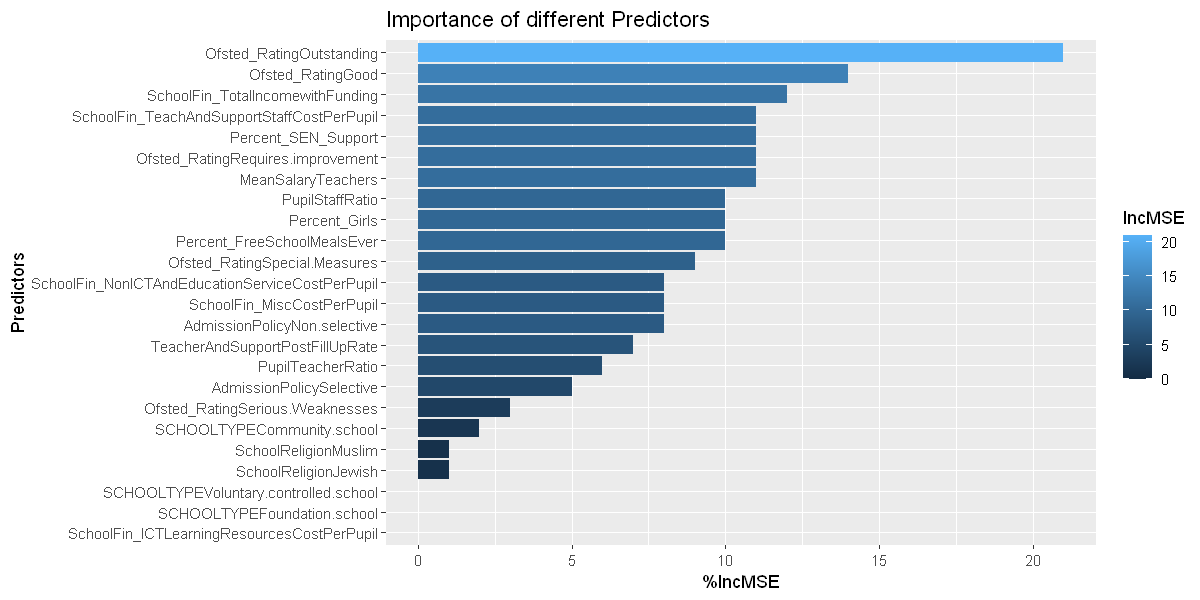

In [263]:
# ************************************************
# fit the 2017_18 data, with Prg8Score_Disadvantaged as ouput
set.seed(123)
Prf_2017_18 <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2017_18train,importance = TRUE, ntree=1000) 
print(Prf_2017_18)

# determine the number of trees to create by the minimum mean squared error.
Pmin_2017_18 <- which.min(Prf_2017_18$mse)
# determine the number of split to create the minimum OOB error.
P17_18mtry <- tuneRF(Prg8dataset_2017_18train[-1],Prg8dataset_2017_18train$Prg8Score_Disadvantaged, ntreeTry=Pmin_2017_18,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_P17_18mtry <- P17_18mtry[P17_18mtry[,2] == min(P17_18mtry[,2]),1]
# plot again with optimal no. of trees
Prf_2017_18.opt <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2017_18train,mtry=best_P17_18mtry, importance = TRUE, ntree=Pmin_2017_18) 
print(Prf_2017_18.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_P17_18 <- EvaluateImportance(Prf_2017_18.opt)


Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2018_19train,      importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 10

          Mean of squared residuals: 0.1586658
                    % Var explained: 58.19
mtry = 10  OOB error = 0.160184 
Searching left ...
mtry = 5 	OOB error = 0.160145 
0.0002434757 0.01 
Searching right ...
mtry = 20 	OOB error = 0.1600959 
0.0005495814 0.01 

Call:
 randomForest(formula = Prg8Score_Disadvantaged ~ ., data = Prg8dataset_2018_19train,      mtry = best_P18_19mtry, importance = TRUE, ntree = Pmin_2018_19) 
               Type of random forest: regression
                     Number of trees: 935
No. of variables tried at each split: 20

          Mean of squared residuals: 0.1599154
                    % Var explained: 57.86


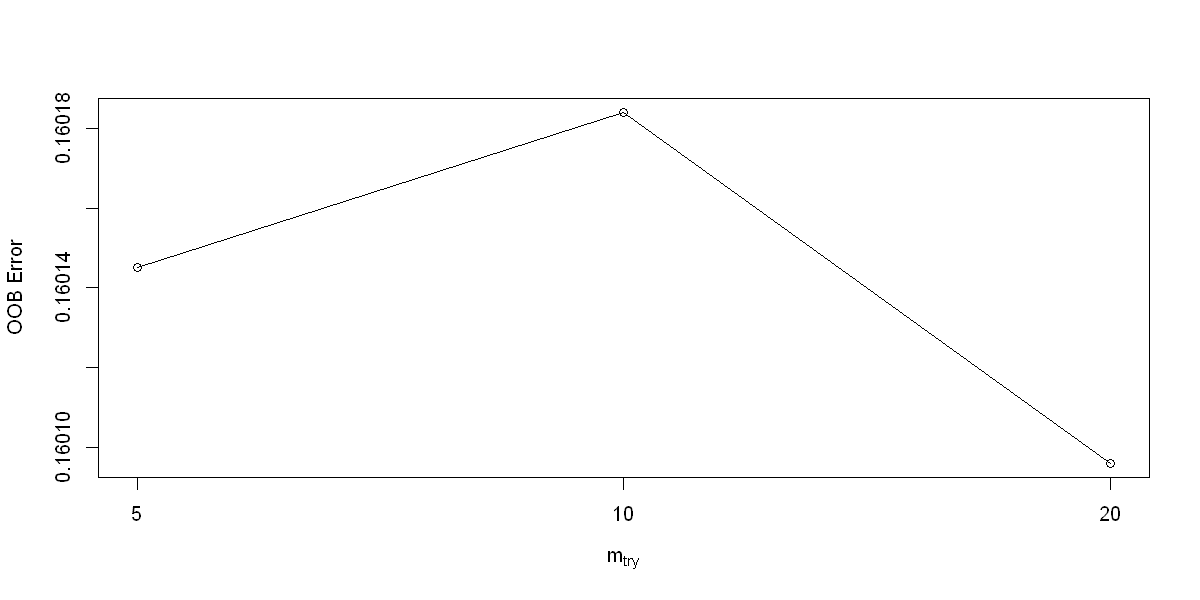

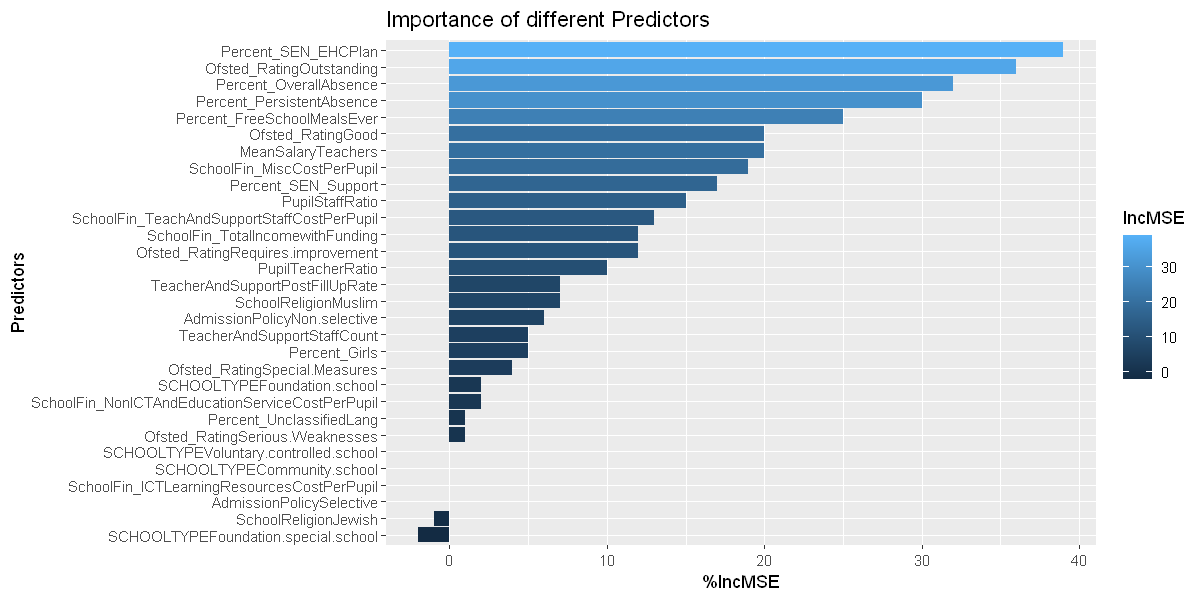

In [264]:
# ************************************************
# fit the 2018_19 data, with Prg8Score_Disadvantaged as ouput
set.seed(123)
Prf_2018_19 <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2018_19train,importance = TRUE, ntree=1000) 
print(Prf_2018_19)

# determine the number of trees to create by the minimum mean squared error.
Pmin_2018_19 <- which.min(Prf_2018_19$mse)
# determine the number of split to create the minimum OOB error.
P18_19mtry <- tuneRF(Prg8dataset_2018_19train[-1],Prg8dataset_2018_19train$Prg8Score_Disadvantaged, ntreeTry=Pmin_2018_19,
                    stepFactor=2,improve=0.01, trace=TRUE, plot=TRUE)
best_P18_19mtry <- P18_19mtry[P18_19mtry[,2] == min(P18_19mtry[,2]),1]
# plot again with optimal no. of trees
Prf_2018_19.opt <-randomForest(Prg8Score_Disadvantaged~.,data=Prg8dataset_2018_19train,mtry=best_P18_19mtry, importance = TRUE, ntree=Pmin_2018_19) 
print(Prf_2018_19.opt)

#Evaluate variable importance, assign to a dataframe for evaluation in next part
df_P18_19 <- EvaluateImportance(Prf_2018_19.opt)

### 2.2.4 Evaluate variable importance on the model

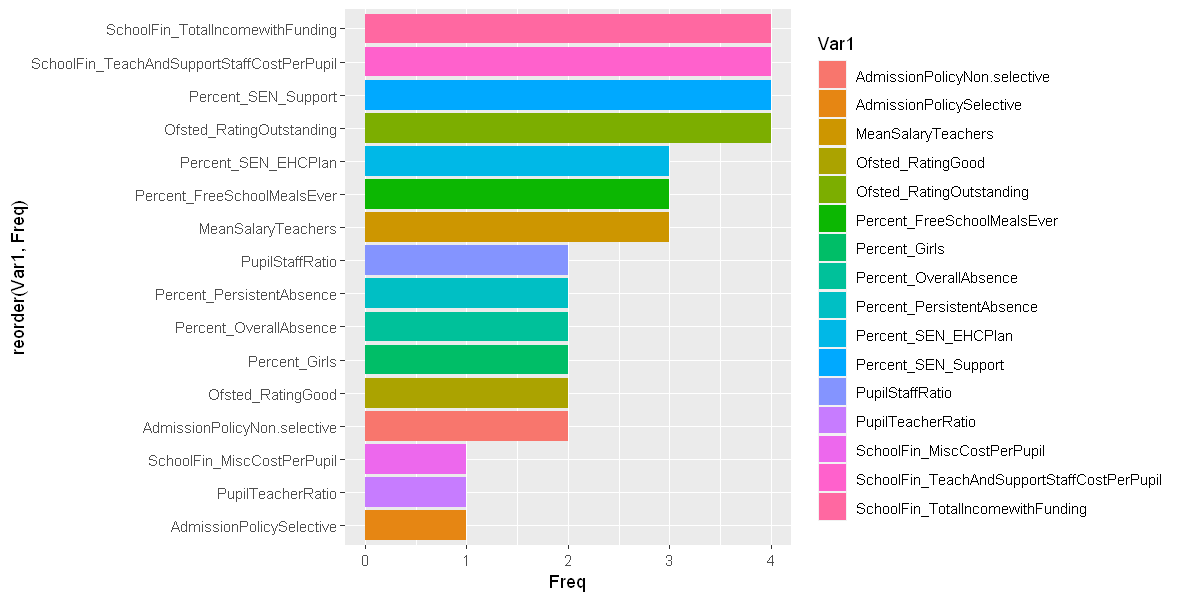

In [265]:
# Merge each year importance affecting Attainment 8 score extracted from previous part into one dataframe
mergeAtt <- rbind(df_A15_16,df_A16_17,df_A17_18,df_A18_19)
Attfreq <- as.data.frame(table(mergeAtt$Variables))
# Plot the total occurrence for the top 10 importance variable in each year
Attfreq_plot<-ggplot(Attfreq, aes(x = Freq, y = reorder(Var1, Freq), fill = Var1)) +
  geom_bar(stat = 'identity')
print(Attfreq_plot)

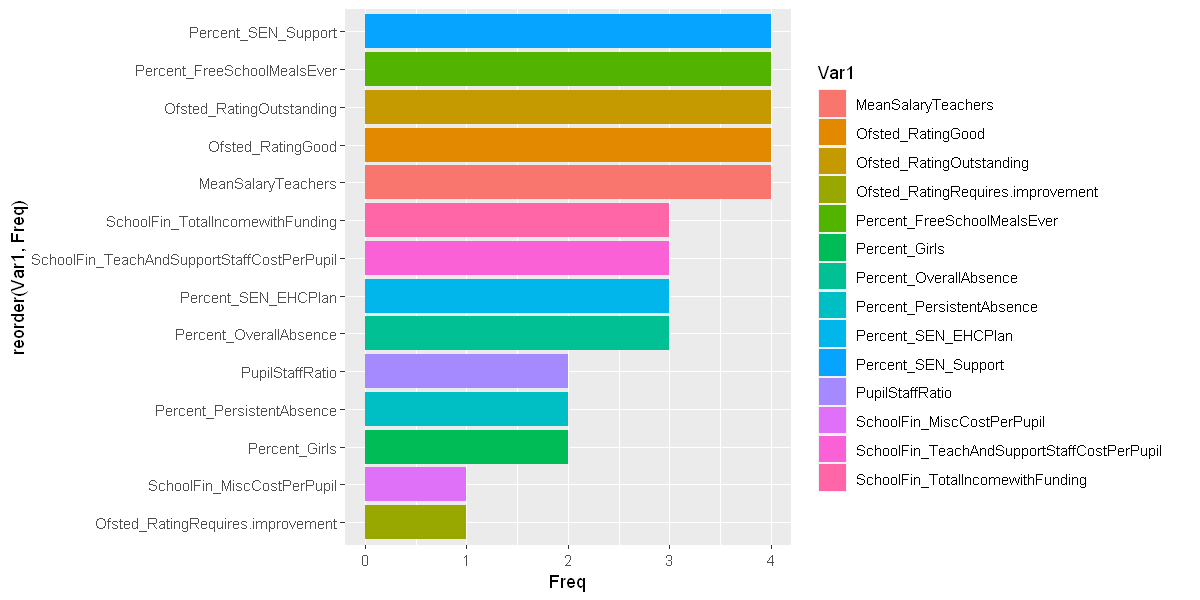

In [266]:
# Merge each year importance affecting Attainment 8 score extracted from previous part into one dataframe
mergePrg <- rbind(df_P15_16,df_P16_17,df_P17_18,df_P18_19)
Prgfreq <- as.data.frame(table(mergePrg$Variables))
# Plot the total occurrence for the top 10 importance variable in each year
Prgfreq_plot<-ggplot(Prgfreq, aes(x = Freq, y = reorder(Var1, Freq), fill = Var1)) +
  geom_bar(stat = 'identity')
print(Prgfreq_plot)

### 2.2.5 Predicting the next year result for multiple years

[1] "2015_16 Random Forest Regression"
[1] "R-squared:  0.364228309081494"
[1] "MAE:  6.98964764107164"
[1] "RMSE:  9.09866975489663"


[[1]]
[1] 0.3642283

[[2]]
[1] 6.989648

[[3]]
[1] 9.09867

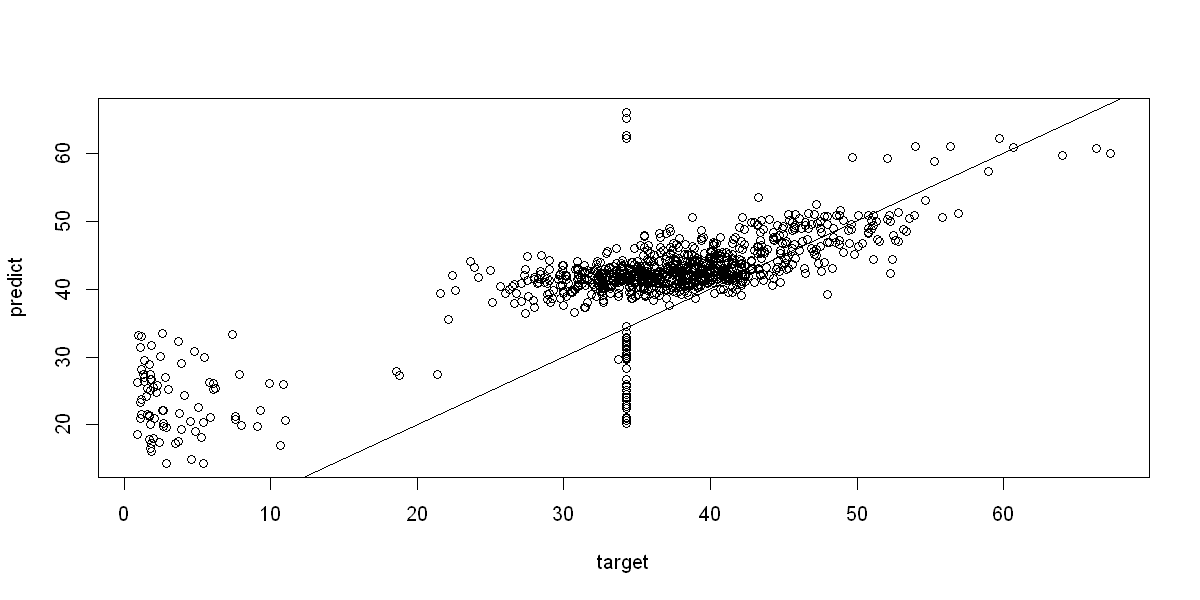

In [267]:
#Prediction of next year Att8score with 2015_16 att8score model
rf_2015_16_predict <- predict(rf_2015_16.opt,newdata = Att8dataset_2016_17test)
print("2015_16 Random Forest Regression")
EvaluateModel(rf_2015_16_predict, Att8dataset_2016_17train$Att8Score_Disadvantaged)

[1] "2016_17 Random Forest Regression"
[1] "R-squared:  0.651305584293044"
[1] "MAE:  4.75442291916931"
[1] "RMSE:  6.56382200199444"


[[1]]
[1] 0.6513056

[[2]]
[1] 4.754423

[[3]]
[1] 6.563822

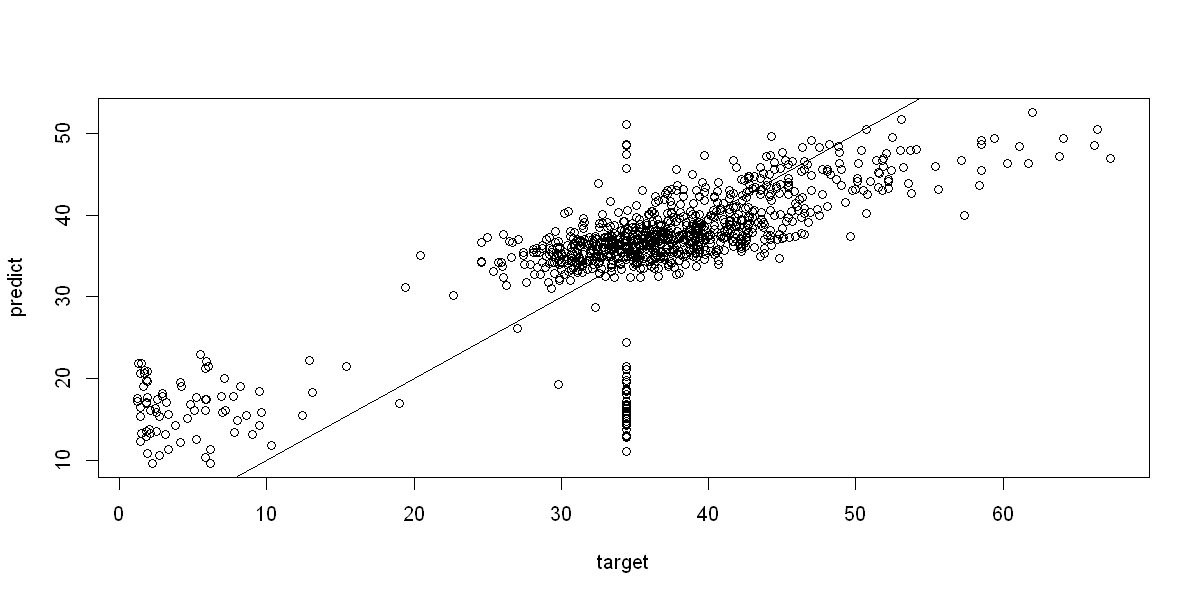

In [268]:
#Prediction of next year Att8score with 2016_17 att8score model
rf_2016_17_predict <- predict(rf_2016_17.opt,newdata = Att8dataset_2017_18test)
print("2016_17 Random Forest Regression")
EvaluateModel(rf_2016_17_predict, Att8dataset_2017_18train$Att8Score_Disadvantaged)

[1] "2017_18 Random Forest Regression"
[1] "R-squared:  0.68215096536936"
[1] "MAE:  5.18494050237128"
[1] "RMSE:  7.1507248168003"


[[1]]
[1] 0.682151

[[2]]
[1] 5.184941

[[3]]
[1] 7.150725

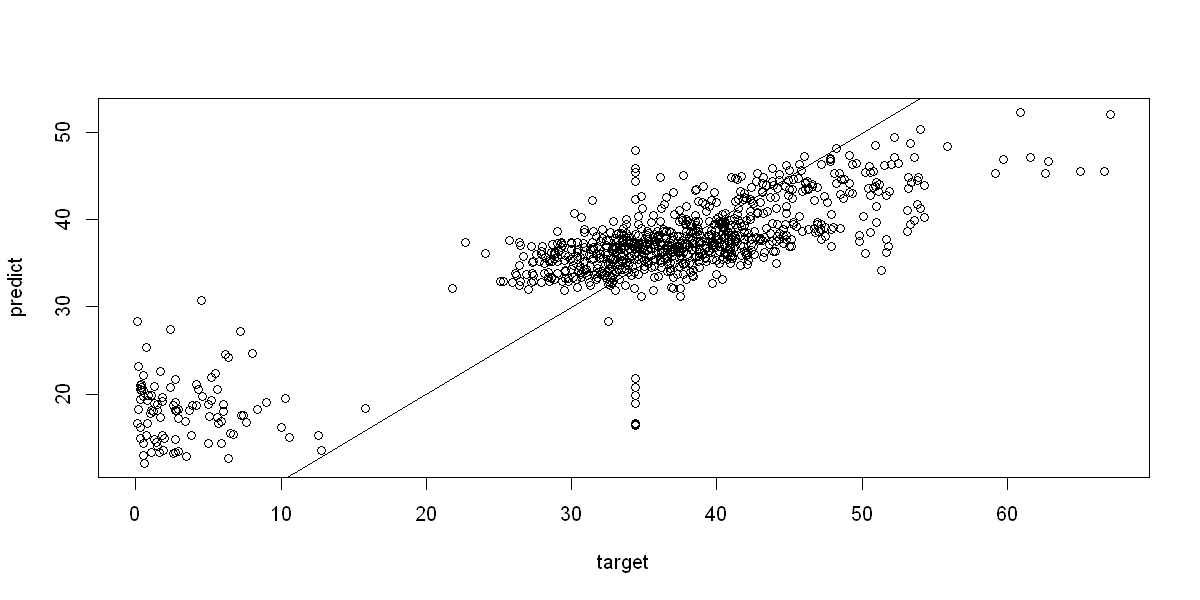

In [269]:
#Prediction of next year Att8score with 2017_18 att8score model
rf_2017_18_predict <- predict(rf_2017_18.opt,newdata = Att8dataset_2018_19test)
print("2017_18 Random Forest Regression")
EvaluateModel(rf_2017_18_predict, Att8dataset_2018_19train$Att8Score_Disadvantaged)

[1] "2015_16 Random Forest Regression"
[1] "R-squared:  0.58656106312293"
[1] "MAE:  0.292361834667566"
[1] "RMSE:  0.367464399203375"


[[1]]
[1] 0.5865611

[[2]]
[1] 0.2923618

[[3]]
[1] 0.3674644

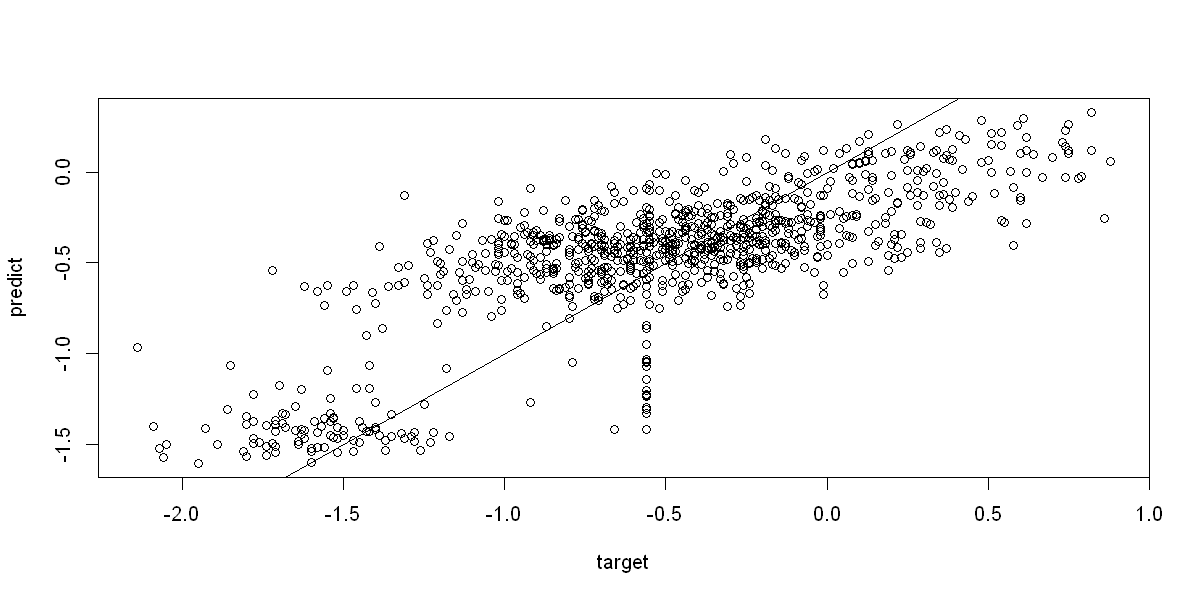

In [270]:
#Prediction of next year Prg8score with 2015_16 Prg8score model
Prf_2015_16_predict <- predict(Prf_2015_16.opt,newdata = Prg8dataset_2016_17test)
print("2015_16 Random Forest Regression")
EvaluateModel(Prf_2015_16_predict, Prg8dataset_2016_17train$Prg8Score_Disadvantaged)

[1] "2016_17 Random Forest Regression"
[1] "R-squared:  0.563058055348711"
[1] "MAE:  0.288769237486254"
[1] "RMSE:  0.370153973264313"


[[1]]
[1] 0.5630581

[[2]]
[1] 0.2887692

[[3]]
[1] 0.370154

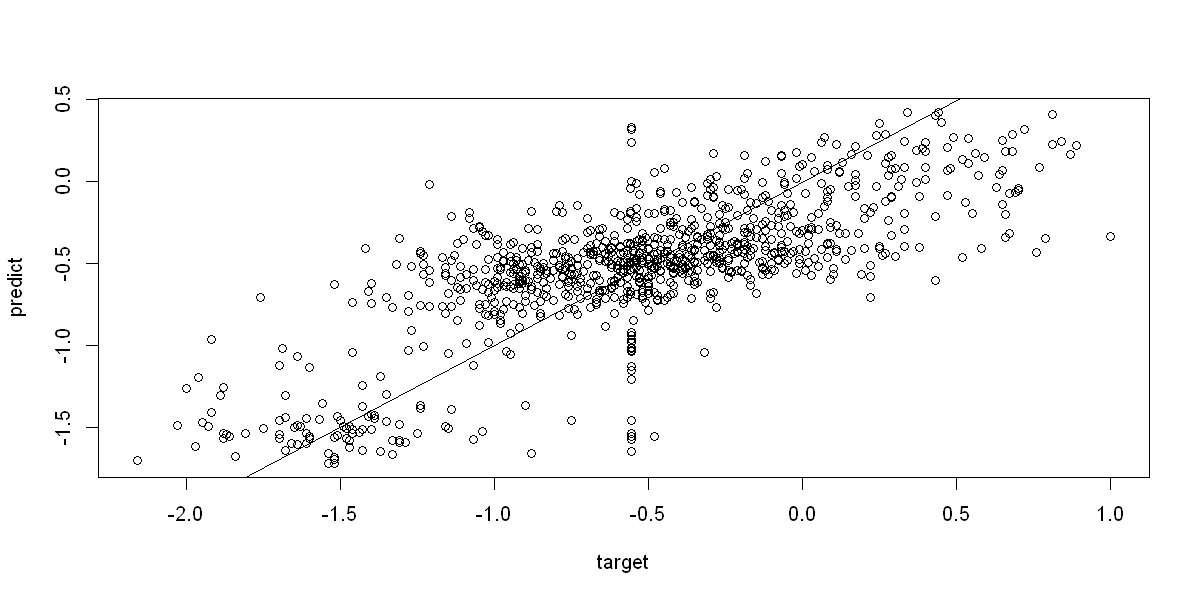

In [271]:
#Prediction of next year Prg8score with 2016_17 Prg8score model
Prf_2016_17_predict <- predict(Prf_2016_17.opt,newdata = Prg8dataset_2017_18test)
print("2016_17 Random Forest Regression")
EvaluateModel(Prf_2016_17_predict, Prg8dataset_2017_18train$Prg8Score_Disadvantaged)

[1] "2017_18 Random Forest Regression"
[1] "R-squared:  0.561954513514475"
[1] "MAE:  0.319272258449673"
[1] "RMSE:  0.407720704832314"


[[1]]
[1] 0.5619545

[[2]]
[1] 0.3192723

[[3]]
[1] 0.4077207

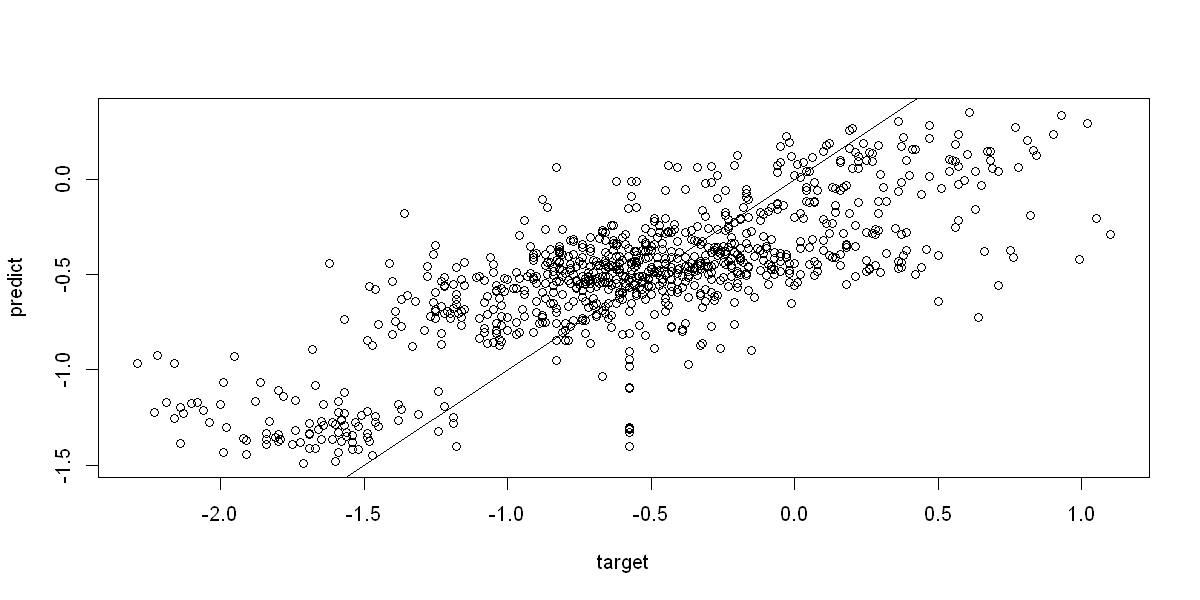

In [272]:
#Prediction of next year Prg8score with 2017_18 Prg8score model
Prf_2017_18_predict <- predict(Prf_2017_18.opt,newdata = Prg8dataset_2018_19test)
print("2017_18 Random Forest Regression")
EvaluateModel(Prf_2017_18_predict, Prg8dataset_2018_19train$Prg8Score_Disadvantaged)

### 2.2.6 Compare the Variable Importance with Linear Regression

In [273]:
# coeffs_freq_att8
# coeffs_freq_prg8


xmergeAtt <- rbind(df_A15_16,df_A16_17,df_A17_18,df_A18_19)
xAttfreq <- as.data.frame(table(xmergeAtt$Variables))


xmergePrg <- rbind(df_P15_16,df_P16_17,df_P17_18,df_P18_19)
xPrgfreq <- as.data.frame(table(xmergePrg$Variables))

names(xAttfreq) <- names(coeffs_freq_att8)
names(xPrgfreq) <- names(coeffs_freq_prg8)

total <- rbind(coeffs_freq_att8 ,xAttfreq)
att8 <- aggregate(total$Frequency, by=list(Variable=total$Variable), FUN=sum)
att8 <- att8[att8$x>0 & att8$Variable!='(Intercept)', ]

total <- rbind(coeffs_freq_prg8 ,xPrgfreq)
prg8 <- aggregate(total$Frequency, by=list(Variable=total$Variable), FUN=sum)
prg8 <- prg8[prg8$x>0 & prg8$Variable!='(Intercept)', ]


In [274]:
wordcloud2(att8,size=0.2,  color=viridis(20), shape='circle', minRotation = 0, maxRotation = 0, rotateRatio = 1)

HTML widgets cannot be represented in plain text (need html)

In [275]:
wordcloud2(prg8,size=0.2,  color=viridis(20), shape='circle', minRotation = 0, maxRotation = 0, rotateRatio = 1)

HTML widgets cannot be represented in plain text (need html)

## 2.3 Neural Network

The last type of model which will be used for this analysis is an Artificial Neural Network. This section will focus on the neural network modelling. This modelling will be carried out using the neuralnet package and some purpose built functions. The neuralnet package can be found here:
https://cran.r-project.org/web/packages/neuralnet/index.html

### 2.3.1 Initial Experimentation to Discover an Effective Neural Network Architecture

The neural network will be tested using different architectures and activation functions. The R^2, MAE and RMSE values will then be used to determine which is most effective. With more time, a function could be produced to systematically determine the best architecture. Alternatively, a review of the literature associated with similar models may provide increased insight regarding this matter. However, given the time constraints, the architecture will be tuned more thoroughly for 2018-19 and more minimally for other years. A semi-systematic, trial and error based approach will be used. The hope is that the more thorough refinement of the models for 2018-19 will provide insight into the potential of the neural network approach. The model will have a Multi-Layer Perceptron (MLP) architecture.

#### One Hidden Layer

[1] "R-squared:  0.0862954902155099"
[1] "MAE:  7.89321596267967"
[1] "RMSE:  12.3028886709392"


[[1]]
[1] 0.08629549

[[2]]
[1] 7.893216

[[3]]
[1] 12.30289

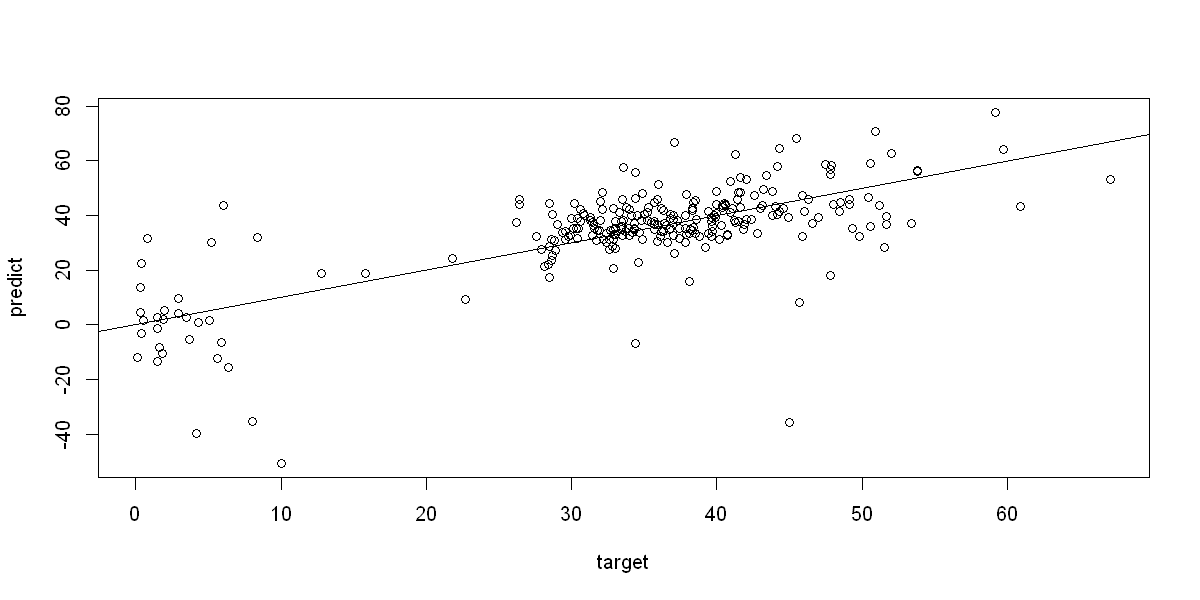

[1] "R-squared:  0.128645901155918"
[1] "MAE:  7.4189890807605"
[1] "RMSE:  12.0143851193048"


[[1]]
[1] 0.1286459

[[2]]
[1] 7.418989

[[3]]
[1] 12.01439

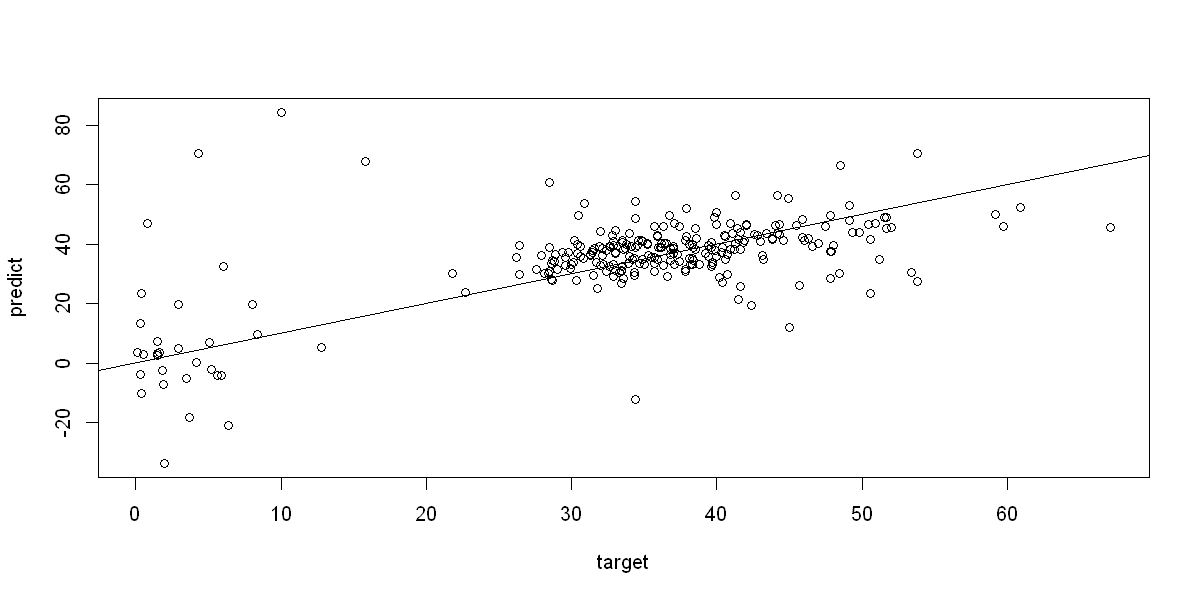

[1] "R-squared:  0.280222011514688"
[1] "MAE:  6.56446008216163"
[1] "RMSE:  10.9195185531208"


[[1]]
[1] 0.280222

[[2]]
[1] 6.56446

[[3]]
[1] 10.91952

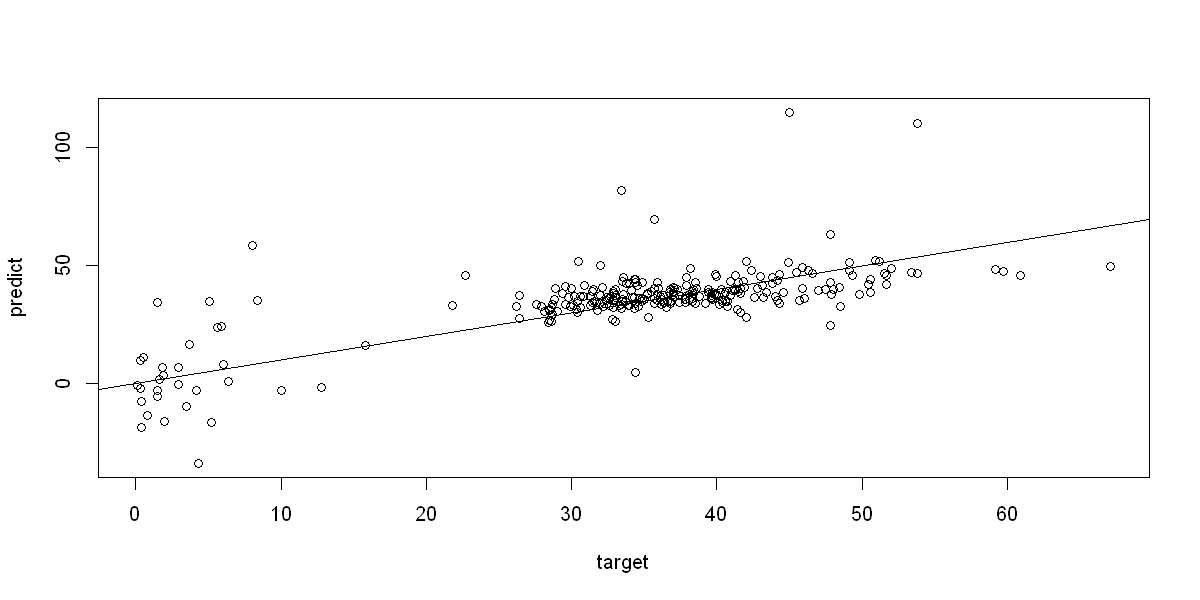

[1] "R-squared:  0.707351873812673"
[1] "MAE:  5.12882346624981"
[1] "RMSE:  6.96269038787364"


[[1]]
[1] 0.7073519

[[2]]
[1] 5.128823

[[3]]
[1] 6.96269

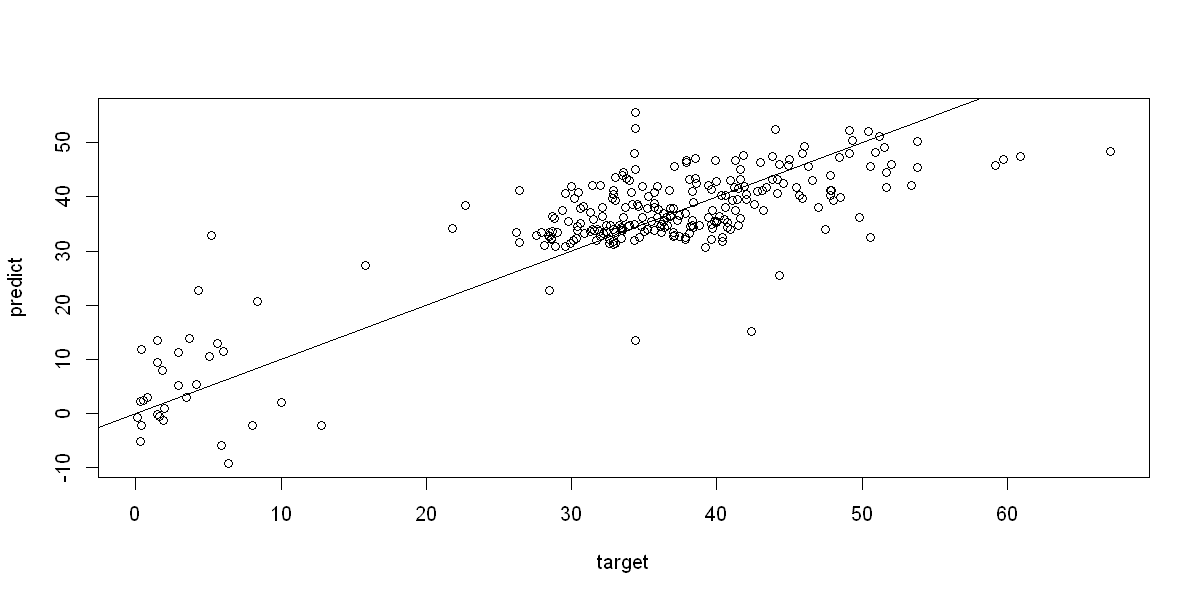

In [276]:
# Initial testing using the logistic function and a single hidden layer on the 2018-19 dataset for Attainment 8.
# The number of nodes has been chosen fairly arbitrarily
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(20), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(10), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(5), 'logistic')

In [278]:
# Using the softplus activation function and a single hidden layer on the 2018-19 dataset for Attainment 8.
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40), softplus)
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(20), softplus)
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(10), softplus)
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(5), softplus)

[1] "R-squared:  -1.71423490899531"
[1] "MAE:  11.6349144244692"
[1] "RMSE:  21.2044946039032"


[[1]]
[1] -1.714235

[[2]]
[1] 11.63491

[[3]]
[1] 21.20449

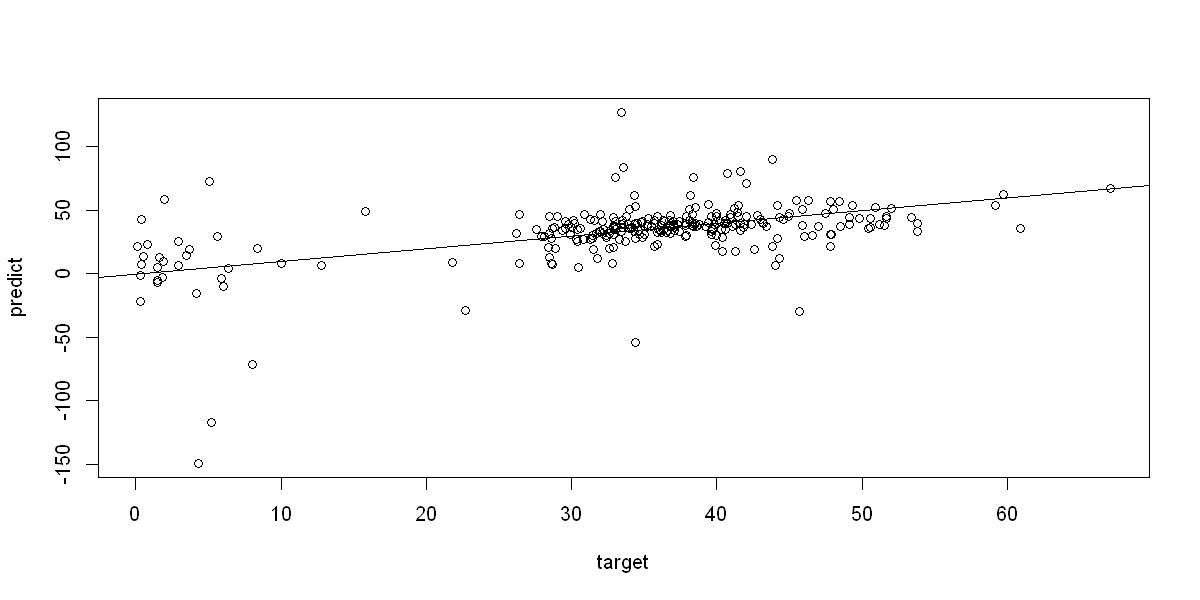

[1] "R-squared:  0.250681792722951"
[1] "MAE:  6.57938620756536"
[1] "RMSE:  11.1413380700845"


[[1]]
[1] 0.2506818

[[2]]
[1] 6.579386

[[3]]
[1] 11.14134

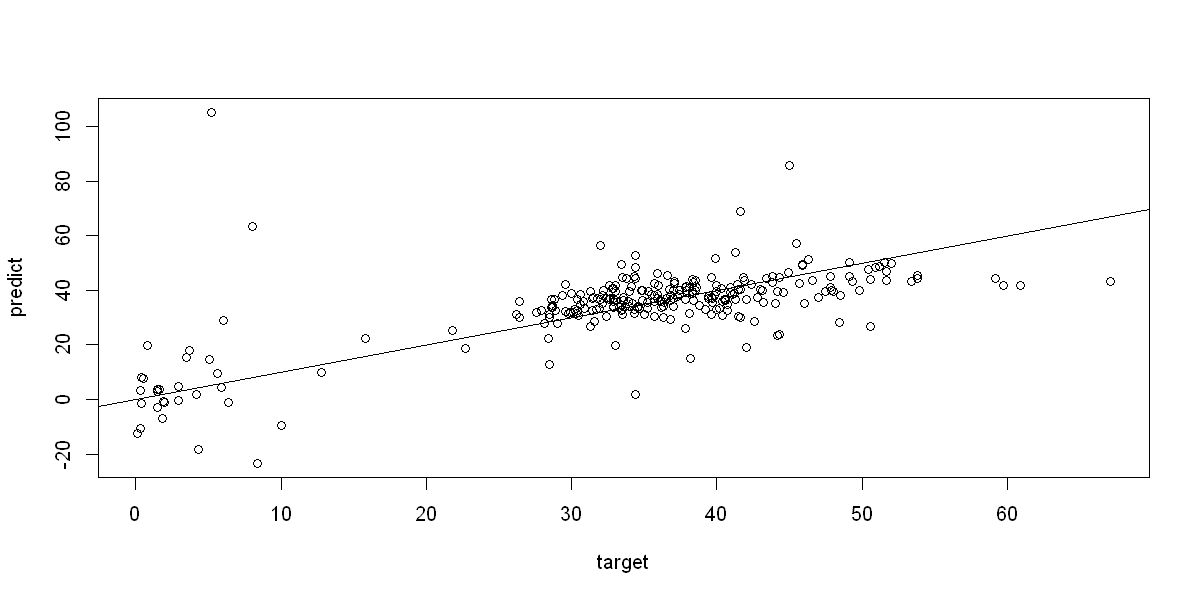

In [280]:
# Using the tanh activation function and a single hidden layer on the 2018-19 dataset for Attainment 8.
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(10), 'tanh')

For a single layer MLP, it looks like the logistic function performs the best based on this limited set of node quantities. Tanh is a close second and softplus doesn't seem to converge at all.

#### Two Hidden Layers

[1] "R-squared:  -0.541476352969639"
[1] "MAE:  8.87375206231542"
[1] "RMSE:  15.9798479728393"


[[1]]
[1] -0.5414764

[[2]]
[1] 8.873752

[[3]]
[1] 15.97985

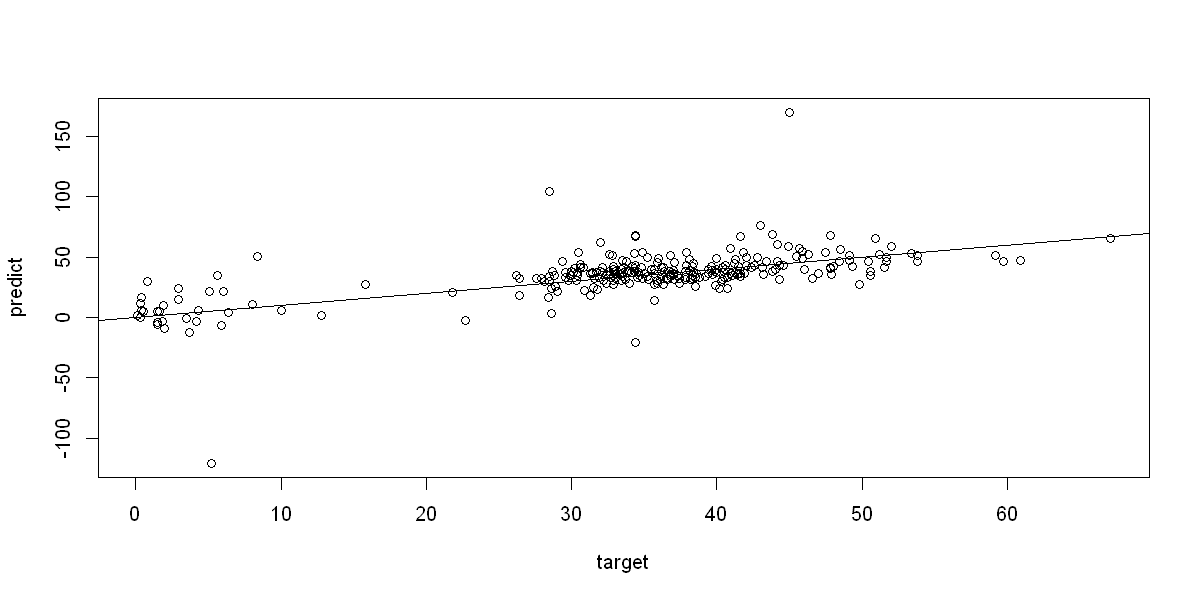

[1] "R-squared:  0.207103488311196"
[1] "MAE:  8.26297290223645"
[1] "RMSE:  11.4607348085732"


[[1]]
[1] 0.2071035

[[2]]
[1] 8.262973

[[3]]
[1] 11.46073

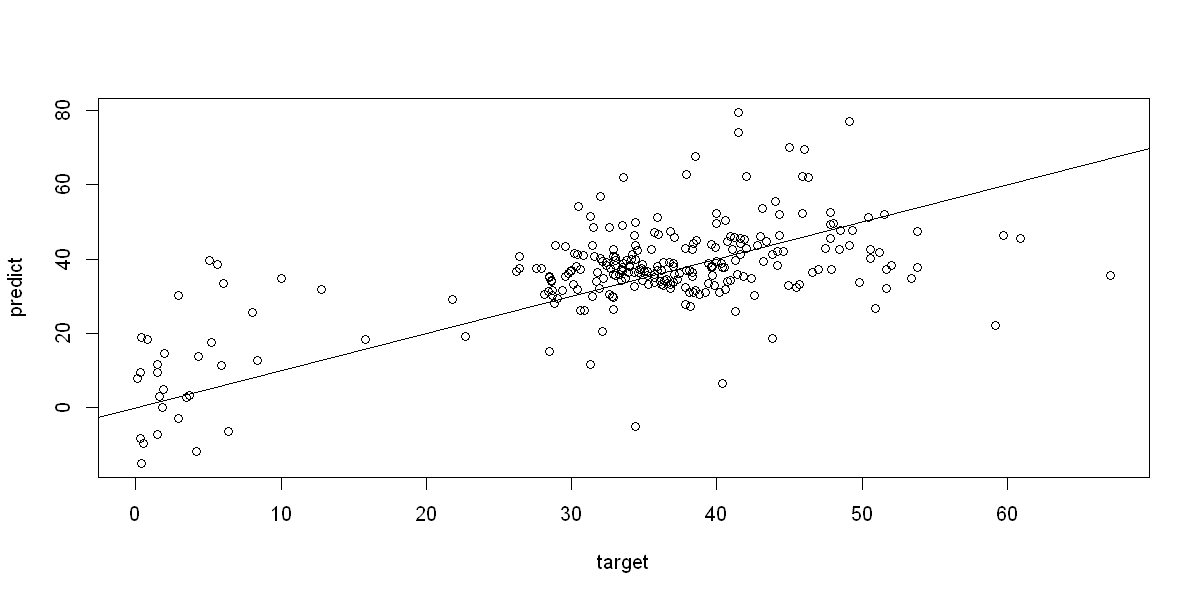

[1] "R-squared:  0.22210711983132"
[1] "MAE:  6.37598391443239"
[1] "RMSE:  11.3517837197584"


[[1]]
[1] 0.2221071

[[2]]
[1] 6.375984

[[3]]
[1] 11.35178

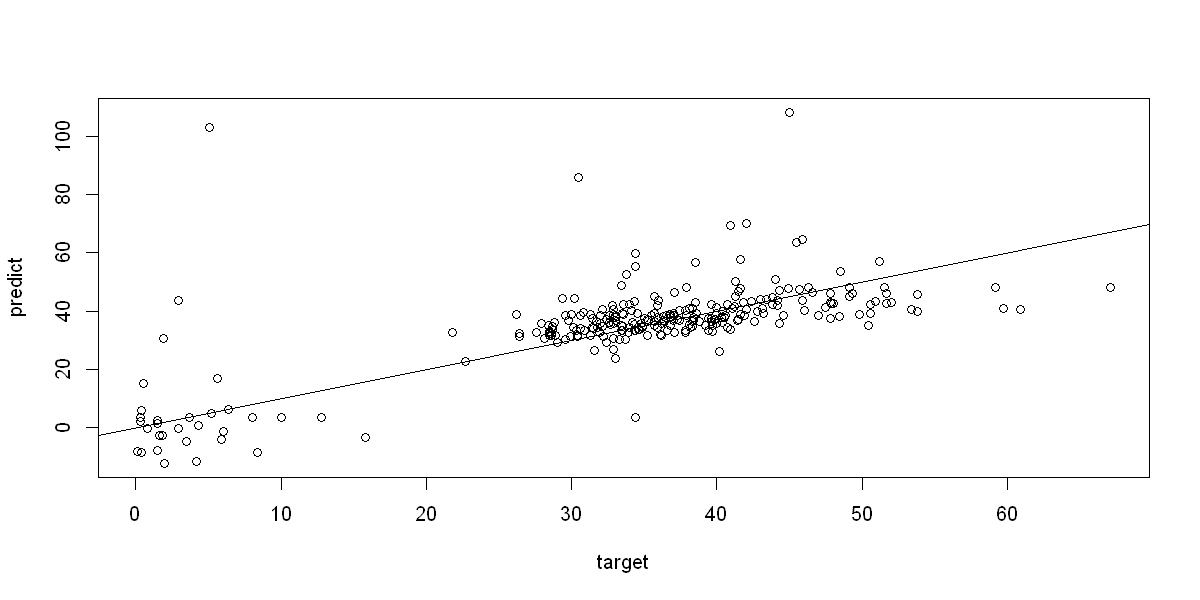

In [281]:
# Initial testing using the logistic function and two hidden layers on the 2018-19 dataset
# The number of nodes in the hidden layers are being varied but the testing is still focused on Attainment 8
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(25,9), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,3), 'logistic')

In [284]:
# Initial testing using the softplus function and two hidden layers on the 2018-19 dataset
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20), softplus)
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(25,9), softplus)
# ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,3), softplus)

[1] "R-squared:  -9.44455084617464"
[1] "MAE:  12.8686793713718"
[1] "RMSE:  41.5957629063584"


[[1]]
[1] -9.444551

[[2]]
[1] 12.86868

[[3]]
[1] 41.59576

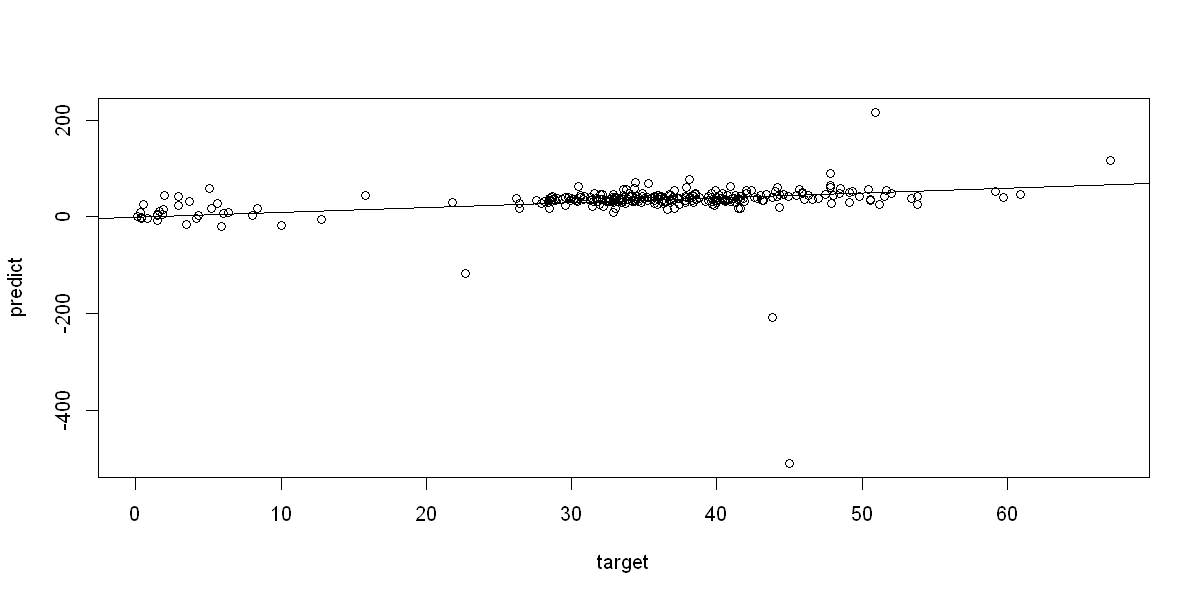

[1] "R-squared:  -1.71767577700226"
[1] "MAE:  10.8350770710616"
[1] "RMSE:  21.2179309424148"


[[1]]
[1] -1.717676

[[2]]
[1] 10.83508

[[3]]
[1] 21.21793

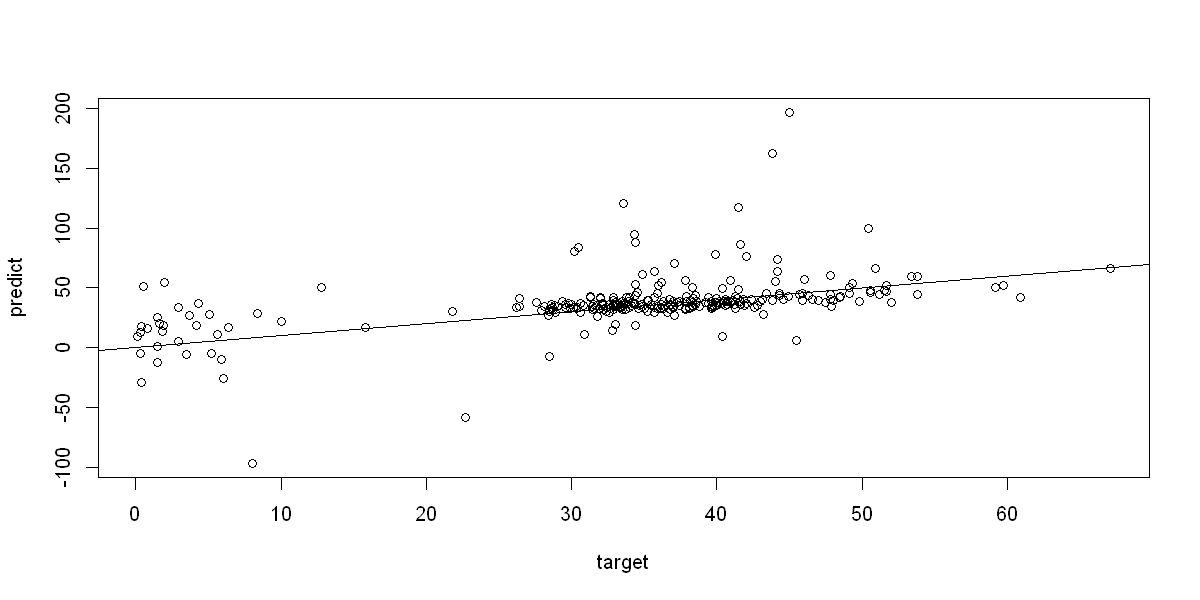

[1] "R-squared:  0.539337423672945"
[1] "MAE:  5.60641344540966"
[1] "RMSE:  8.73565906202676"


[[1]]
[1] 0.5393374

[[2]]
[1] 5.606413

[[3]]
[1] 8.735659

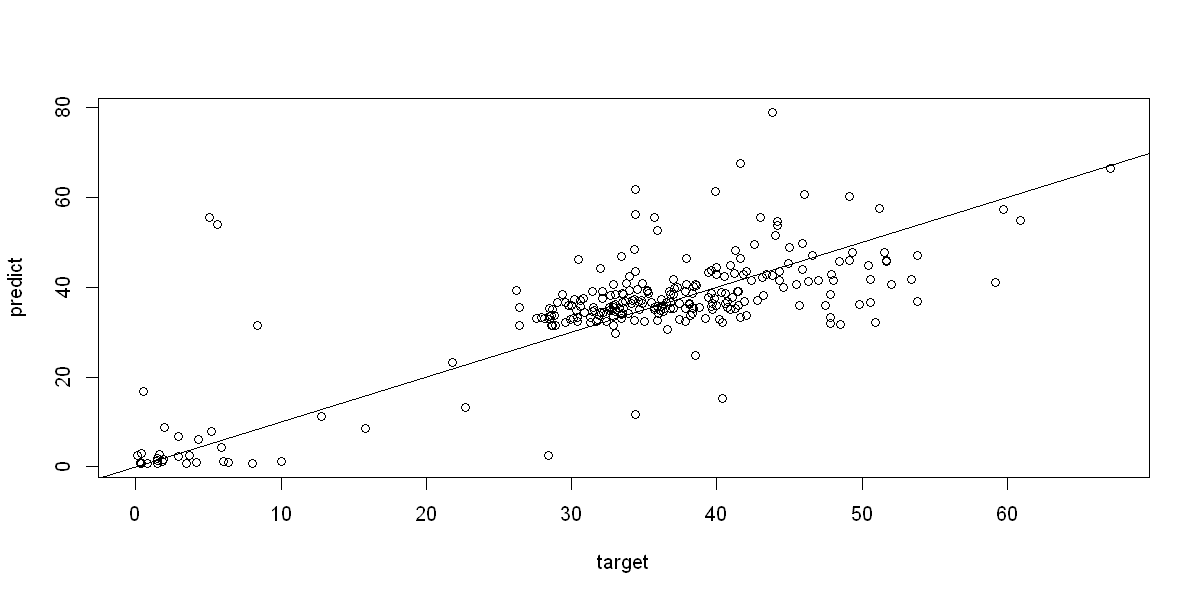

In [285]:
# Initial testing using the tanh function and two hidden layers on the 2018-19 dataset
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(25,9), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,3), 'tanh')

Overall performance seems to be worse with two layers for the logistic function based on the limited set of architectures tested. Softplus still doesn't seem to converge and tanh with a (25,9) architecture seems to be performing best.

#### Three Hidden Layers

[1] "R-squared:  0.146557484476854"
[1] "MAE:  8.31478307549183"
[1] "RMSE:  11.8902598799841"


[[1]]
[1] 0.1465575

[[2]]
[1] 8.314783

[[3]]
[1] 11.89026

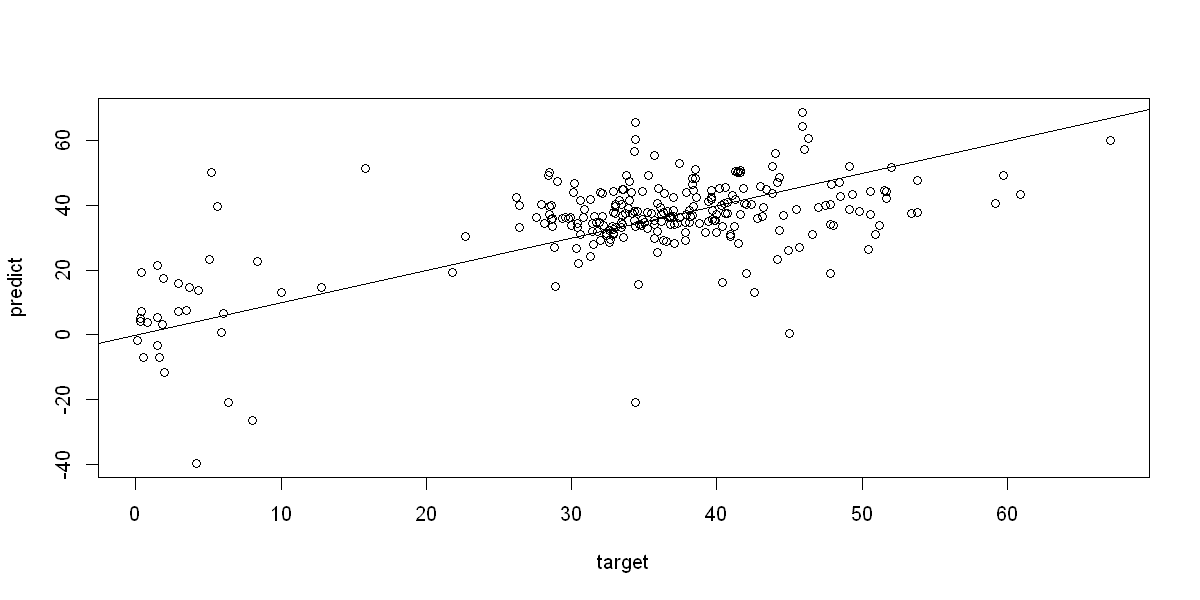

[1] "R-squared:  0.120788088756783"
[1] "MAE:  7.96660955214345"
[1] "RMSE:  12.0684359927035"


[[1]]
[1] 0.1207881

[[2]]
[1] 7.96661

[[3]]
[1] 12.06844

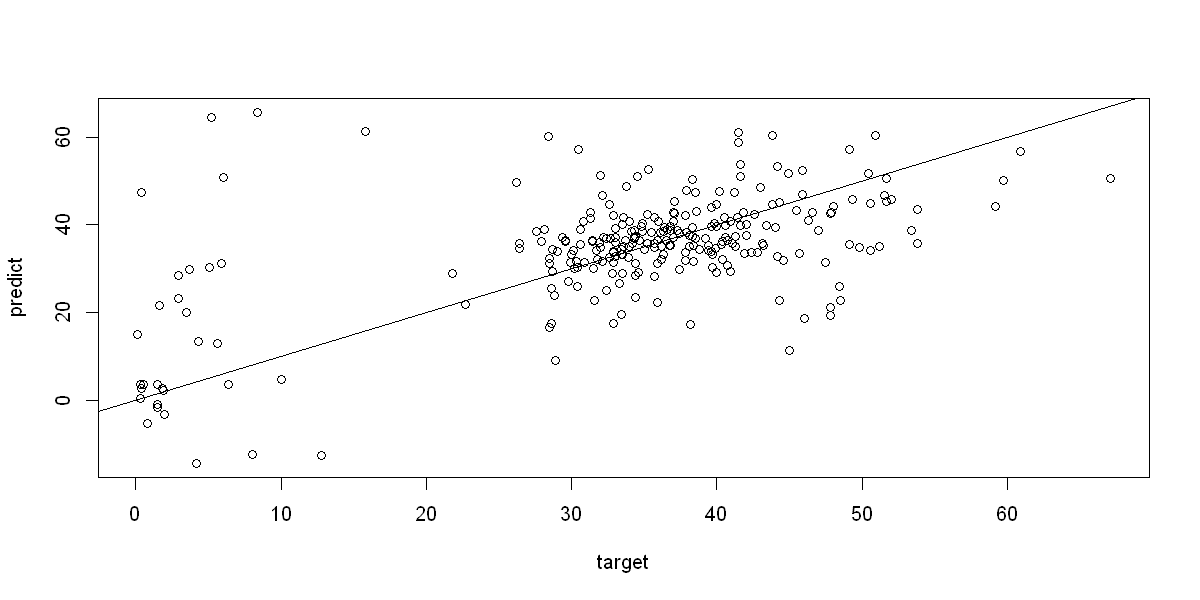

[1] "R-squared:  0.531192623603919"
[1] "MAE:  6.25651999968303"
[1] "RMSE:  8.81254663131892"


[[1]]
[1] 0.5311926

[[2]]
[1] 6.25652

[[3]]
[1] 8.812547

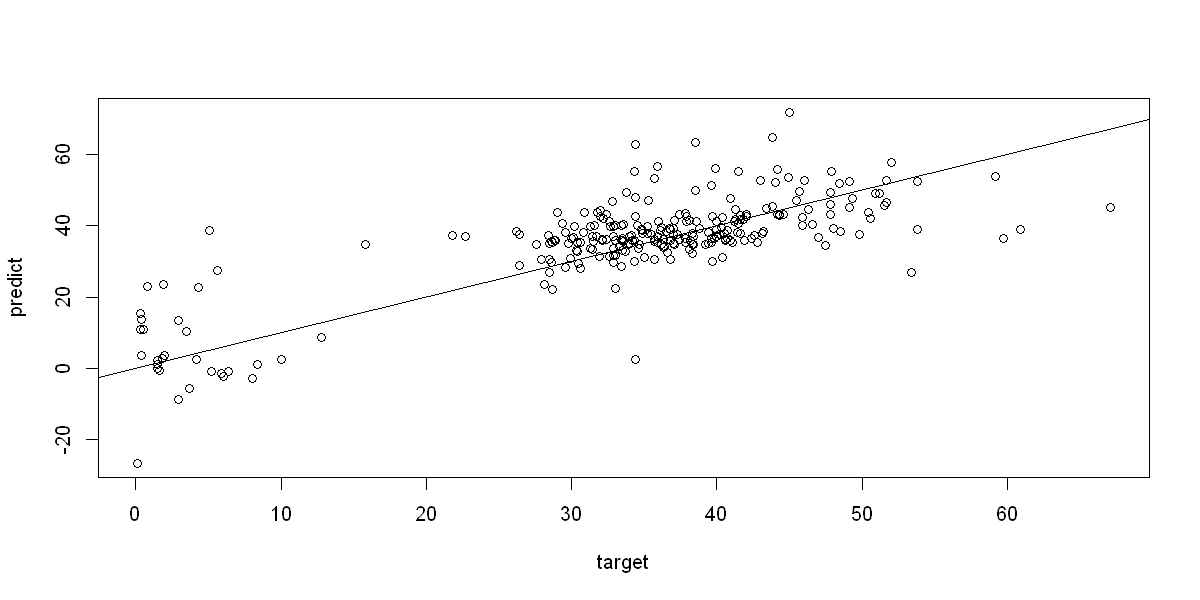

In [286]:
# Testing with three layers using the logistic function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(25,9,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,8,3), 'logistic')

[1] "R-squared:  -2.35981629682183"
[1] "MAE:  11.7248645030242"
[1] "RMSE:  23.5918487916014"


[[1]]
[1] -2.359816

[[2]]
[1] 11.72486

[[3]]
[1] 23.59185

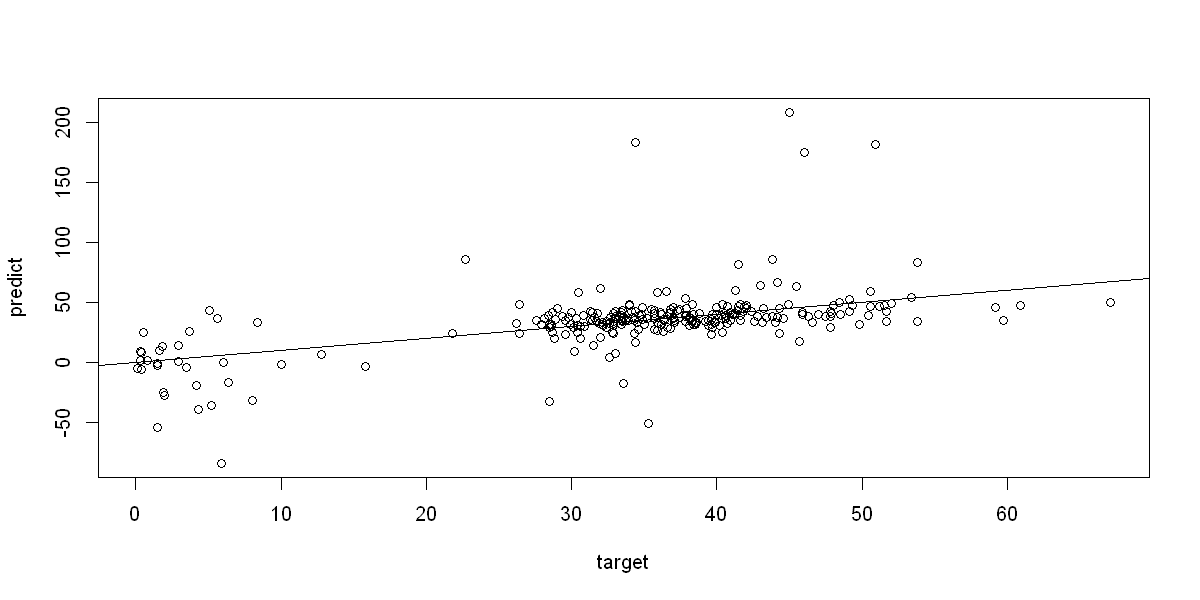

[1] "R-squared:  0.234543275813613"
[1] "MAE:  7.01840765327742"
[1] "RMSE:  11.2606777699652"


[[1]]
[1] 0.2345433

[[2]]
[1] 7.018408

[[3]]
[1] 11.26068

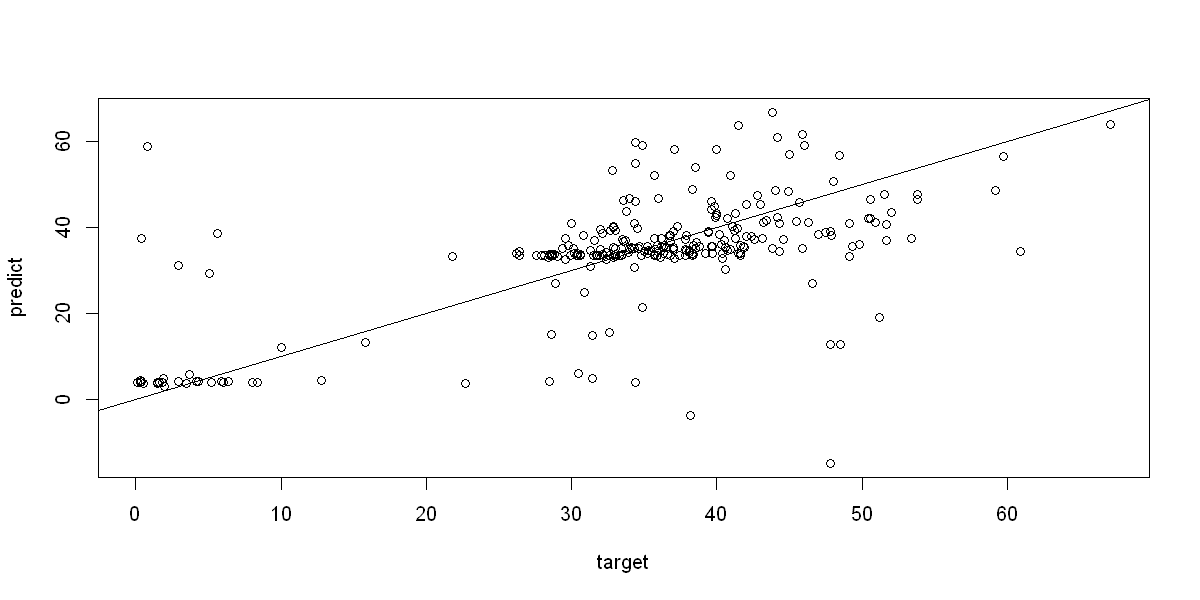

[1] "R-squared:  0.168224731597495"
[1] "MAE:  7.55718998864225"
[1] "RMSE:  11.7383542372934"


[[1]]
[1] 0.1682247

[[2]]
[1] 7.55719

[[3]]
[1] 11.73835

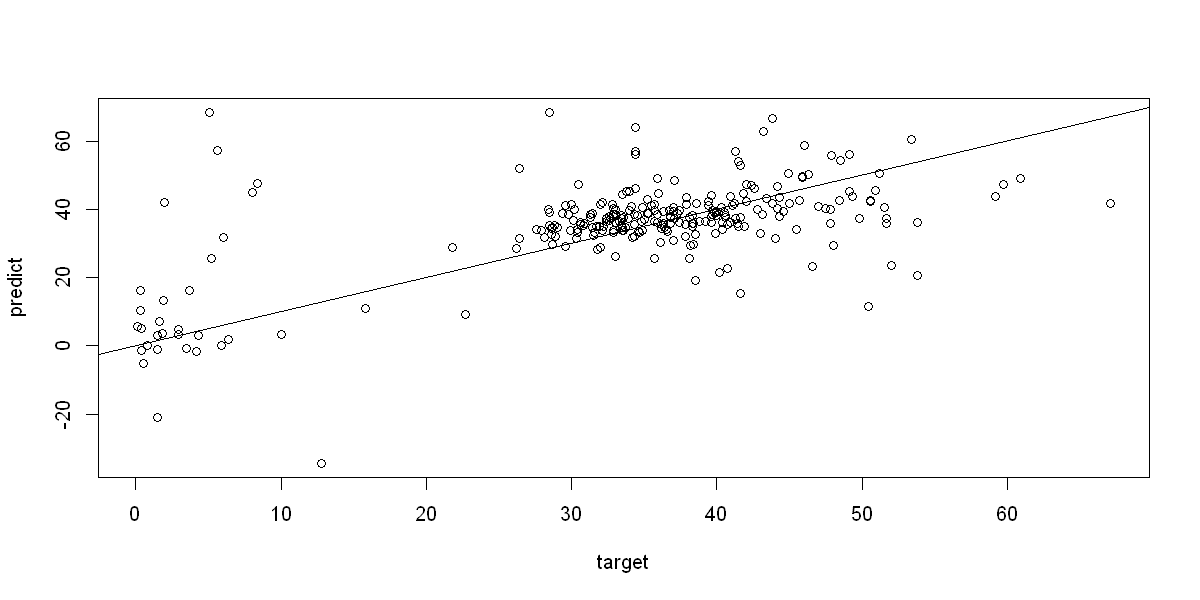

In [287]:
# Testing with three layers using the tanh function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(25,9,3), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,8,3), 'tanh')

It looks like with three layers, the logistic function gives the best overall performance.

#### Four Hidden Layers

[1] "R-squared:  0.386951848377533"
[1] "MAE:  7.277775708628"
[1] "RMSE:  10.0774697578432"


[[1]]
[1] 0.3869518

[[2]]
[1] 7.277776

[[3]]
[1] 10.07747

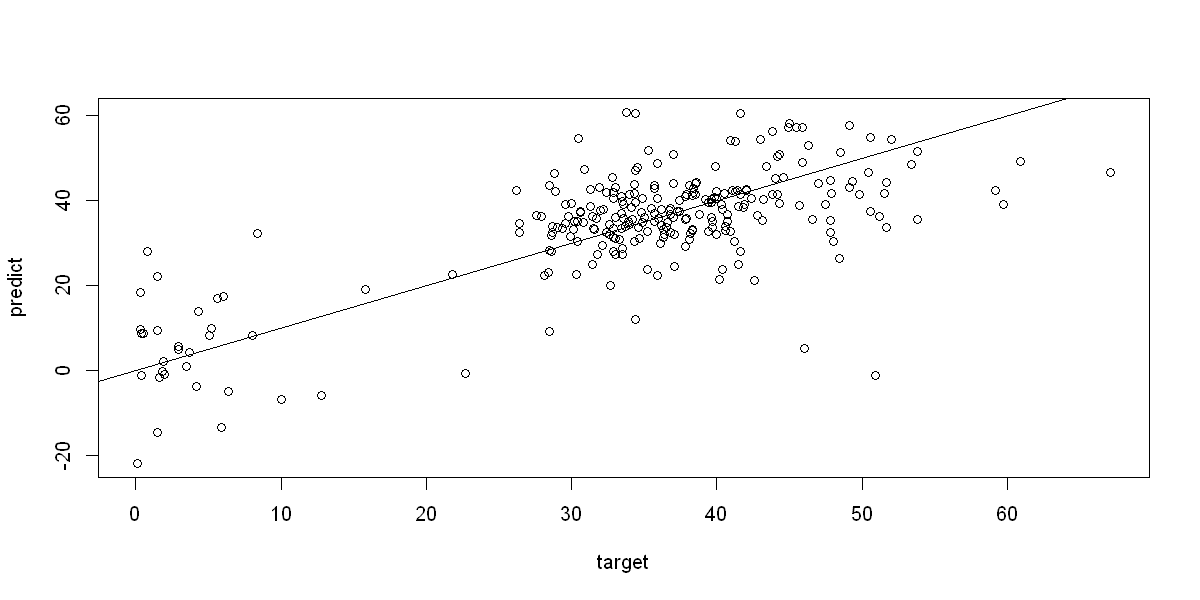

[1] "R-squared:  0.348528833585925"
[1] "MAE:  7.43489739798578"
[1] "RMSE:  10.3884752474548"


[[1]]
[1] 0.3485288

[[2]]
[1] 7.434897

[[3]]
[1] 10.38848

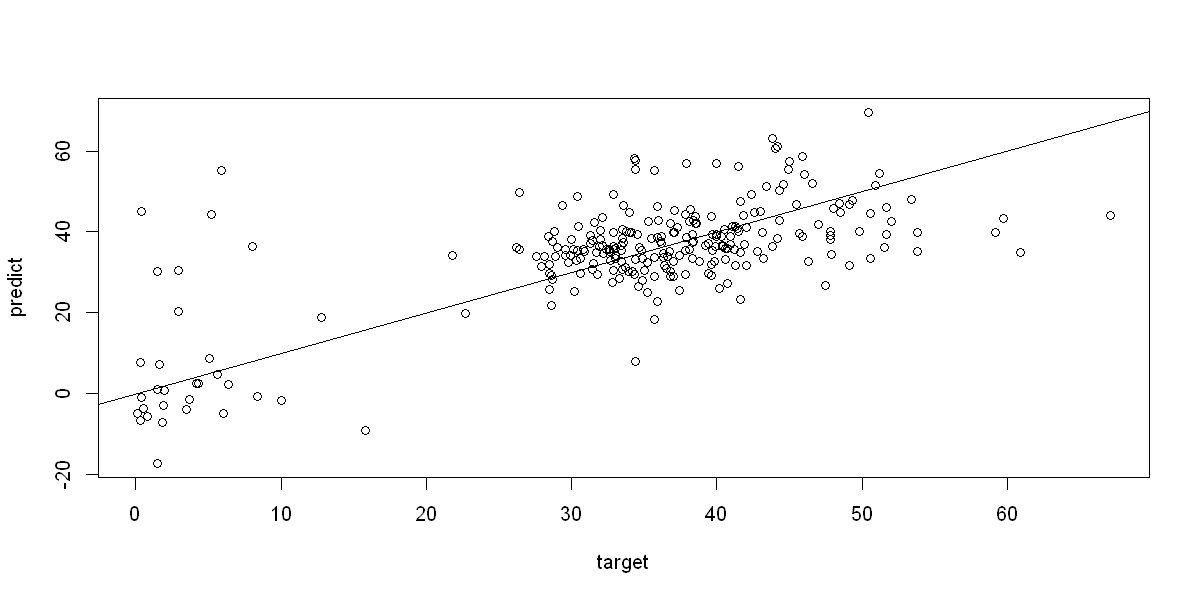

[1] "R-squared:  0.426967833807453"
[1] "MAE:  6.42136701886598"
[1] "RMSE:  9.74302260956029"


[[1]]
[1] 0.4269678

[[2]]
[1] 6.421367

[[3]]
[1] 9.743023

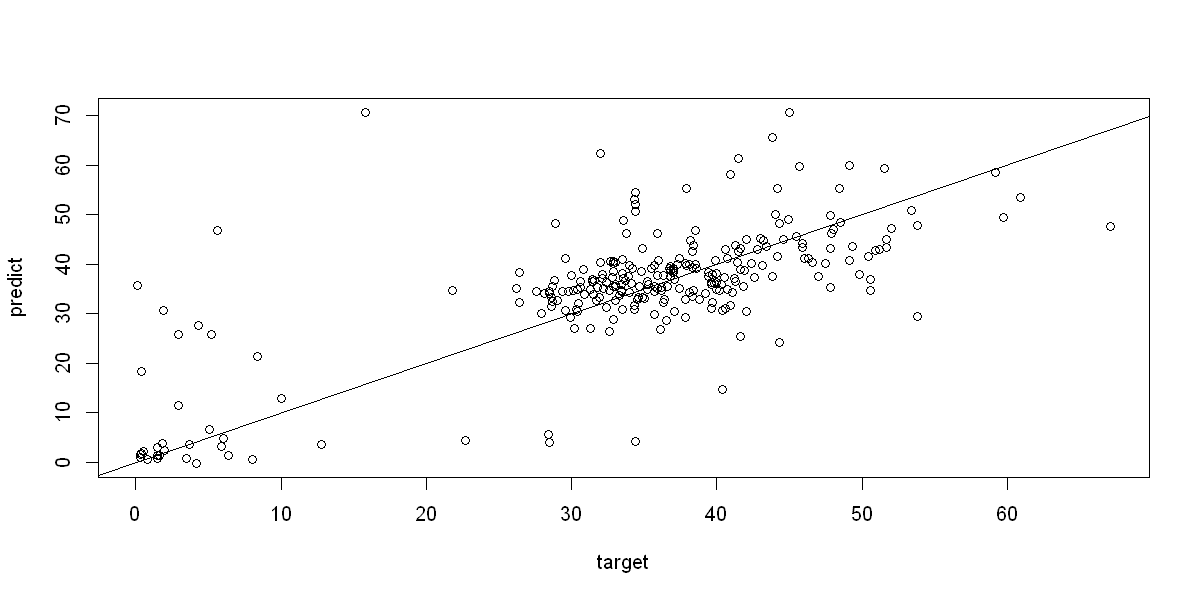

In [288]:
# Testing with four hidden layers using the logistic function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10,5), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,18,9,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,8,5,3), 'logistic')

[1] "R-squared:  0.0555522037218431"
[1] "MAE:  8.43161216023721"
[1] "RMSE:  12.5081531077124"


[[1]]
[1] 0.0555522

[[2]]
[1] 8.431612

[[3]]
[1] 12.50815

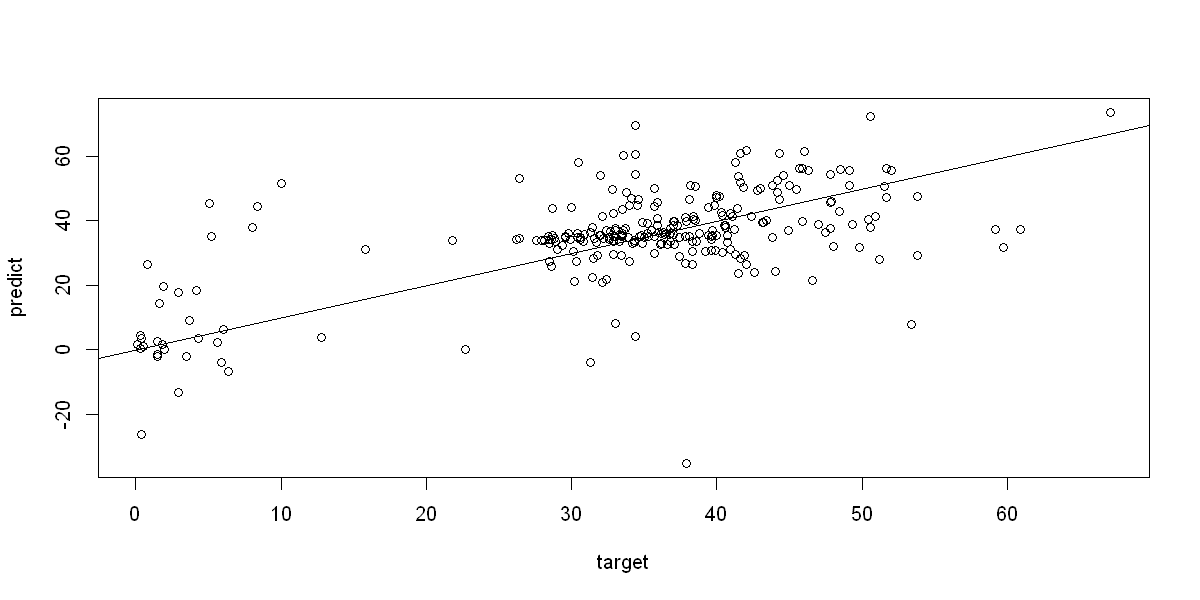

[1] "R-squared:  0.440287303270633"
[1] "MAE:  6.95763513600865"
[1] "RMSE:  9.6291242172035"


[[1]]
[1] 0.4402873

[[2]]
[1] 6.957635

[[3]]
[1] 9.629124

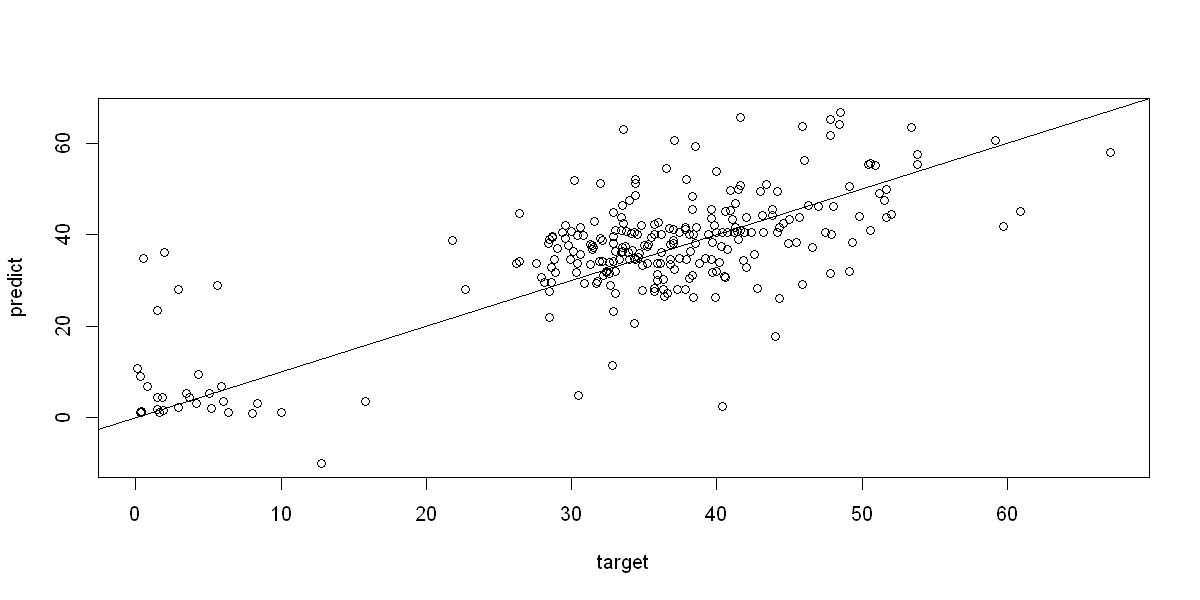

[1] "R-squared:  0.190161960597337"
[1] "MAE:  6.89393663167598"
[1] "RMSE:  11.5825263280504"


[[1]]
[1] 0.190162

[[2]]
[1] 6.893937

[[3]]
[1] 11.58253

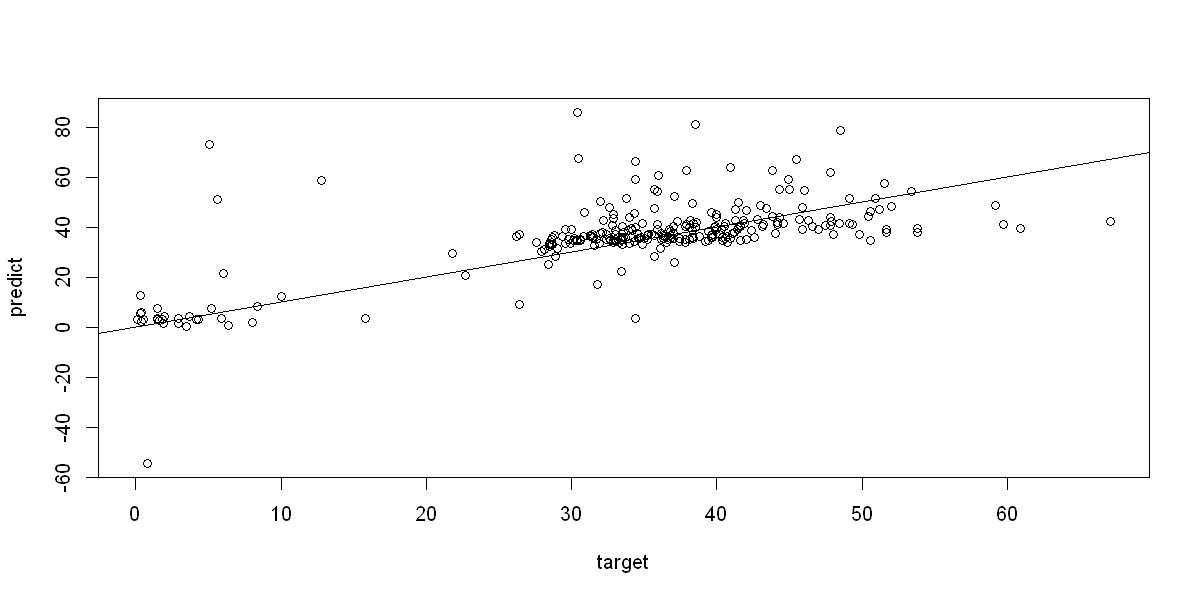

In [289]:
# Testing with four hidden layers using the tanh function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10,5), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,18,9,3), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,8,5,3), 'tanh')

#### Five Hidden Layers

[1] "R-squared:  0.413020168631262"
[1] "MAE:  7.15256020976644"
[1] "RMSE:  9.86088285291122"


[[1]]
[1] 0.4130202

[[2]]
[1] 7.15256

[[3]]
[1] 9.860883

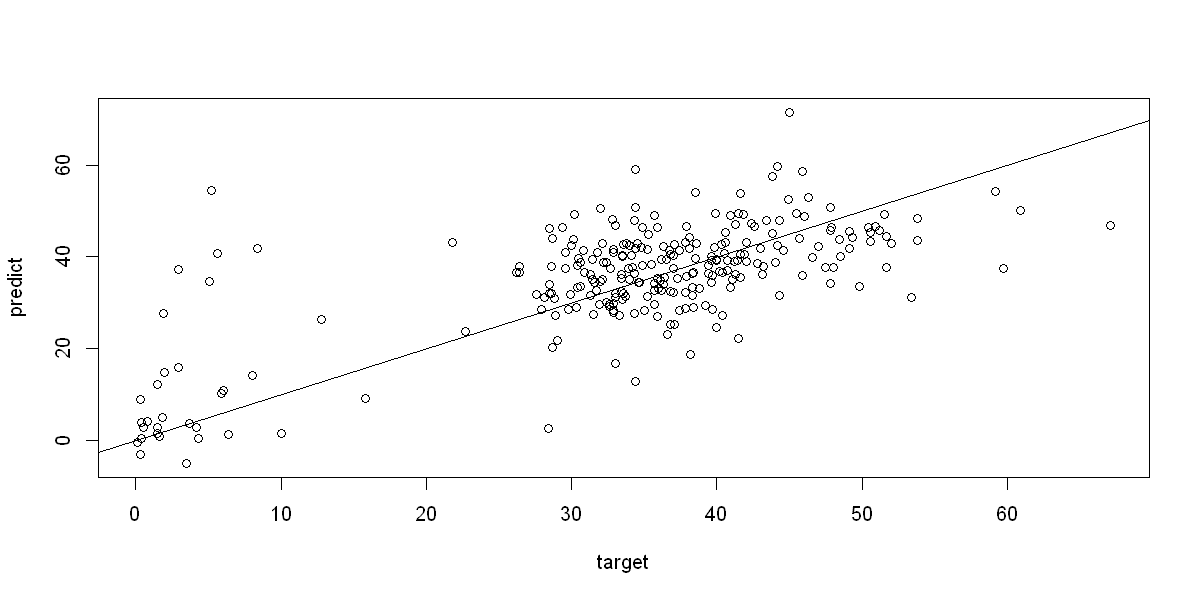

[1] "R-squared:  0.447095551225718"
[1] "MAE:  7.0685853408047"
[1] "RMSE:  9.57038154009459"


[[1]]
[1] 0.4470956

[[2]]
[1] 7.068585

[[3]]
[1] 9.570382

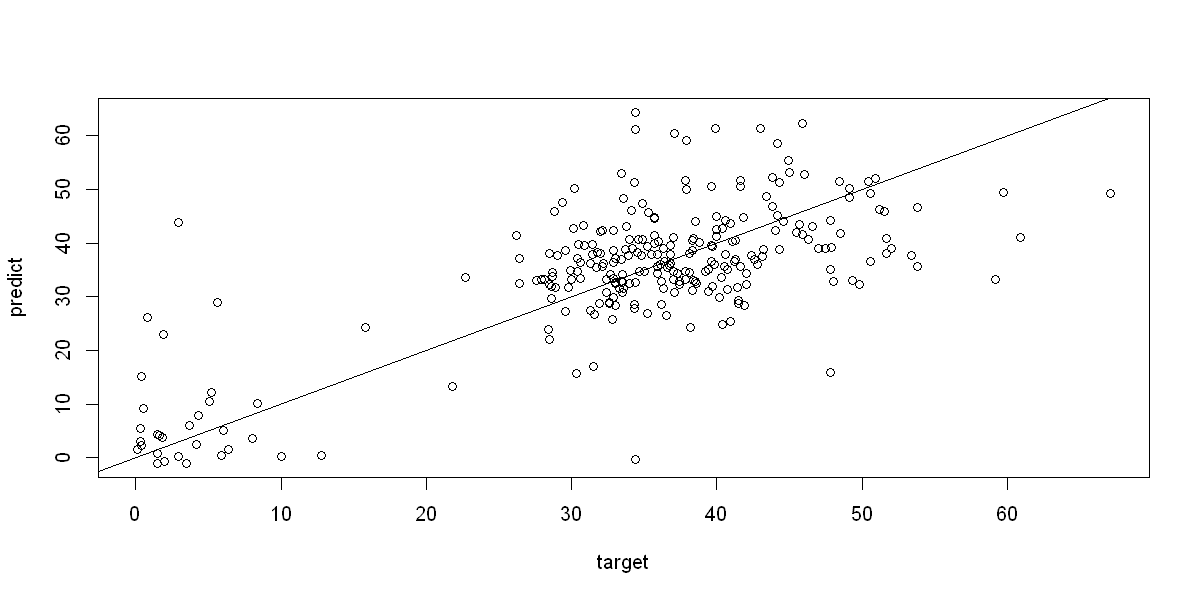

[1] "R-squared:  0.547355206403067"
[1] "MAE:  6.37771569250117"
[1] "RMSE:  8.65930376020998"


[[1]]
[1] 0.5473552

[[2]]
[1] 6.377716

[[3]]
[1] 8.659304

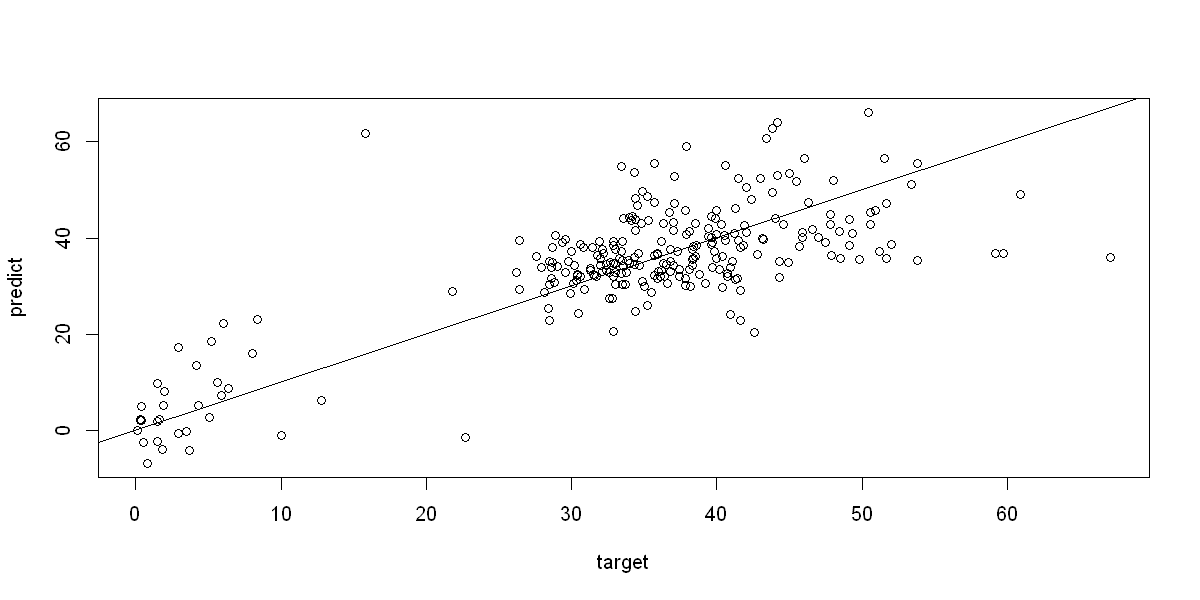

In [290]:
# Testing with five hidden layers using the logistic function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10,5,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,25,18,9,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,12,9,5,3), 'logistic')

[1] "R-squared:  -0.178059812253538"
[1] "MAE:  7.70878785093057"
[1] "RMSE:  13.969725752484"


[[1]]
[1] -0.1780598

[[2]]
[1] 7.708788

[[3]]
[1] 13.96973

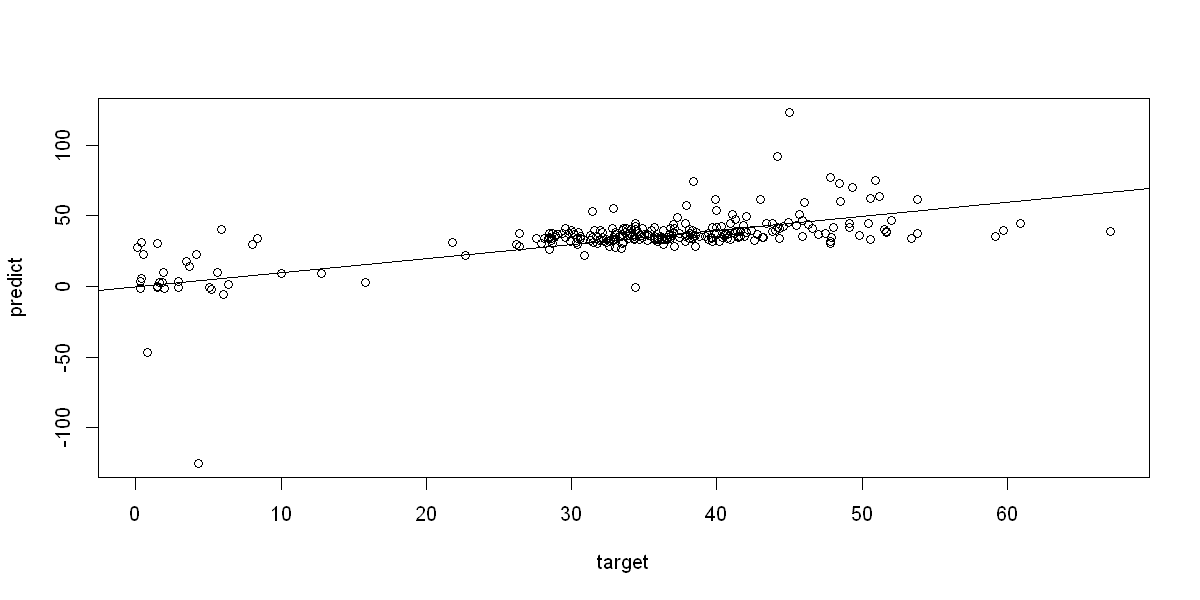

[1] "R-squared:  0.119737361345652"
[1] "MAE:  7.99118496091122"
[1] "RMSE:  12.0756452047361"


[[1]]
[1] 0.1197374

[[2]]
[1] 7.991185

[[3]]
[1] 12.07565

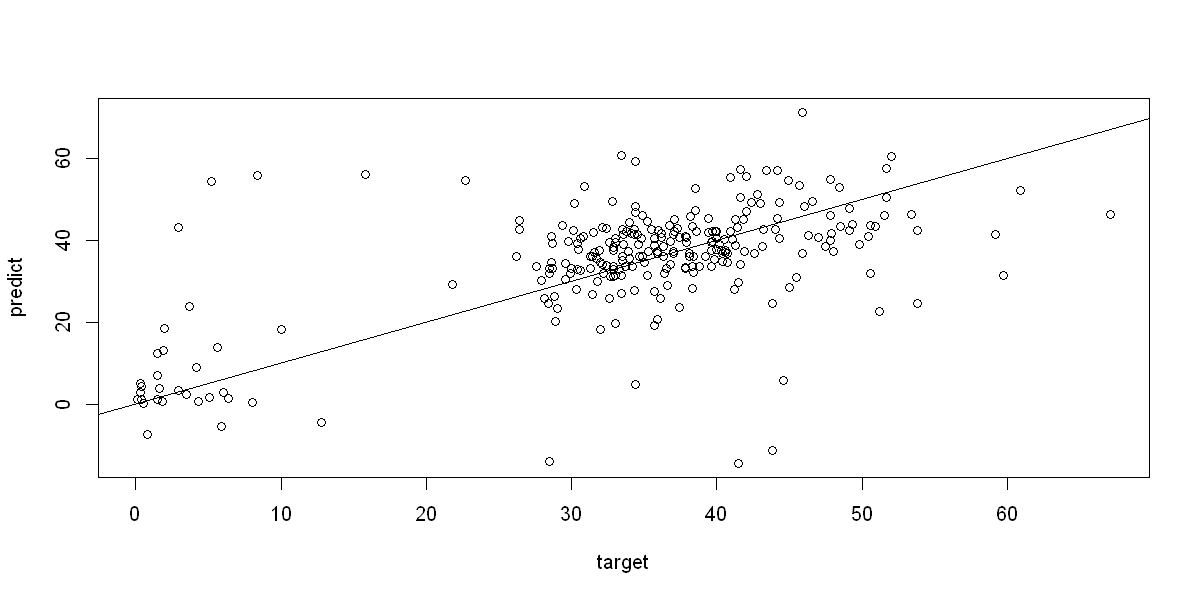

[1] "R-squared:  0.209358755516062"
[1] "MAE:  7.37523555810113"
[1] "RMSE:  11.4444240892116"


[[1]]
[1] 0.2093588

[[2]]
[1] 7.375236

[[3]]
[1] 11.44442

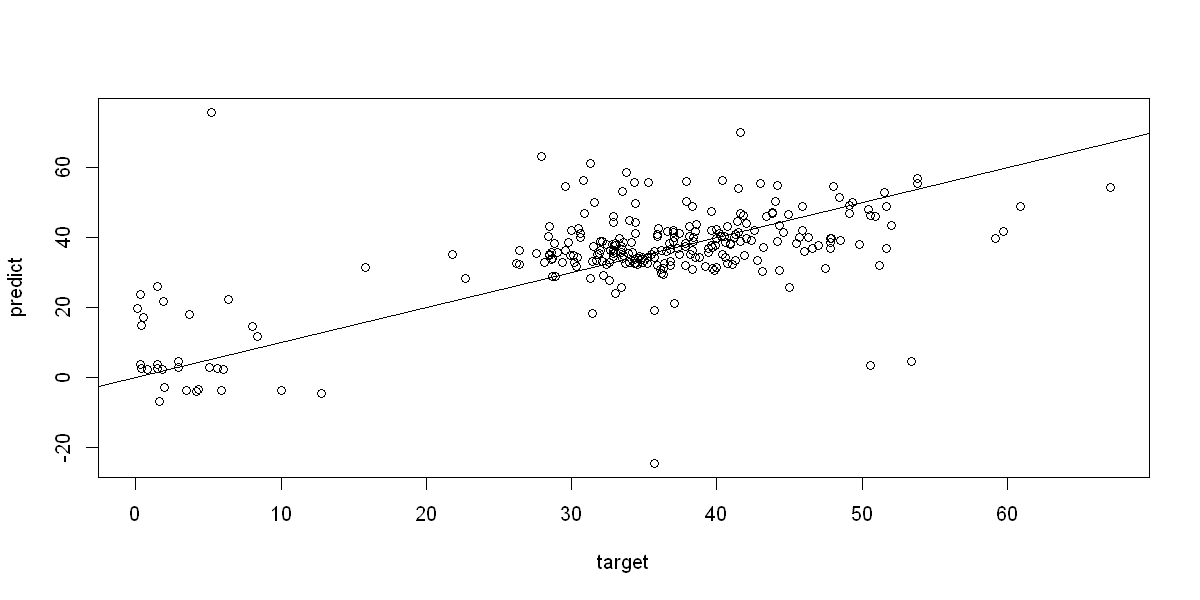

In [291]:
# Testing with five hidden layers using the tanh function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(40,20,10,5,3), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,25,18,9,3), 'tanh')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(15,12,9,5,3), 'tanh')

An intuitive review of the different architectures suggests that more hidden layers are better for this particular case. The logistic function seems to perform the most consistently and has produced the best result from the limited testing set. It also looks like having the node numbers for the hidden layers in between the number of inputs and the number of outputs is effective.

### 2.3.2 Fine Tuning for Att8Score_Disadvantaged

Following initial experimentation, the structure will now be fine tuned for 2018-19 with the Att8Score_Disadvantaged output variable, to achieve the best results.

[1] "R-squared:  0.408756681880219"
[1] "MAE:  5.67102509808333"
[1] "RMSE:  9.89662997346089"


[[1]]
[1] 0.4087567

[[2]]
[1] 5.671025

[[3]]
[1] 9.89663

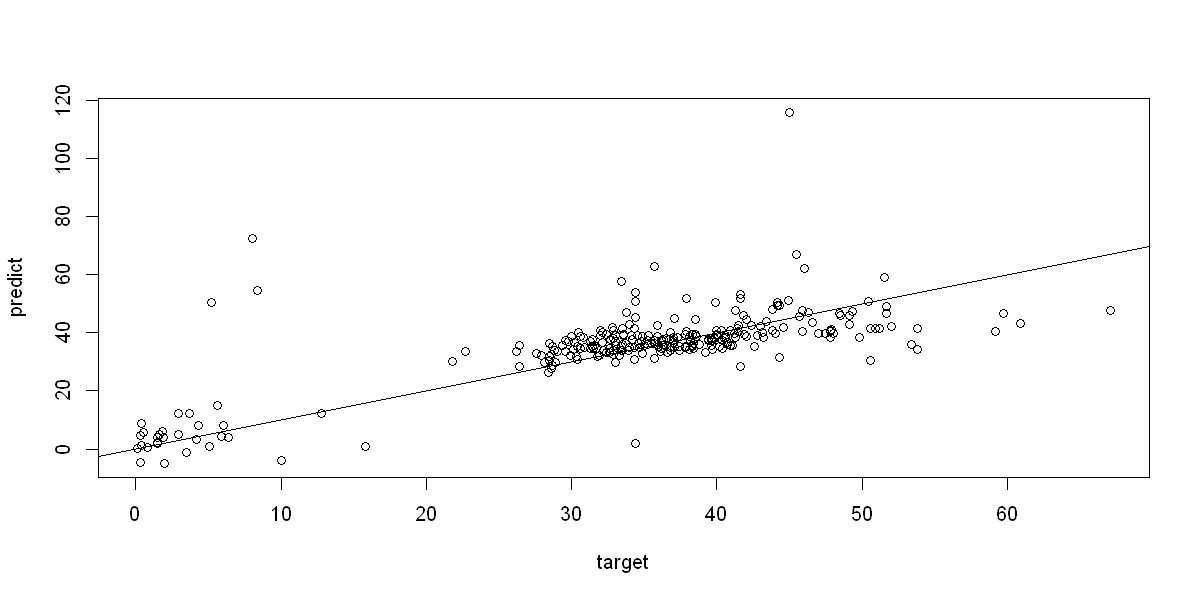

[1] "R-squared:  0.705895543606531"
[1] "MAE:  4.75501423812621"
[1] "RMSE:  6.97999340744333"


[[1]]
[1] 0.7058955

[[2]]
[1] 4.755014

[[3]]
[1] 6.979993

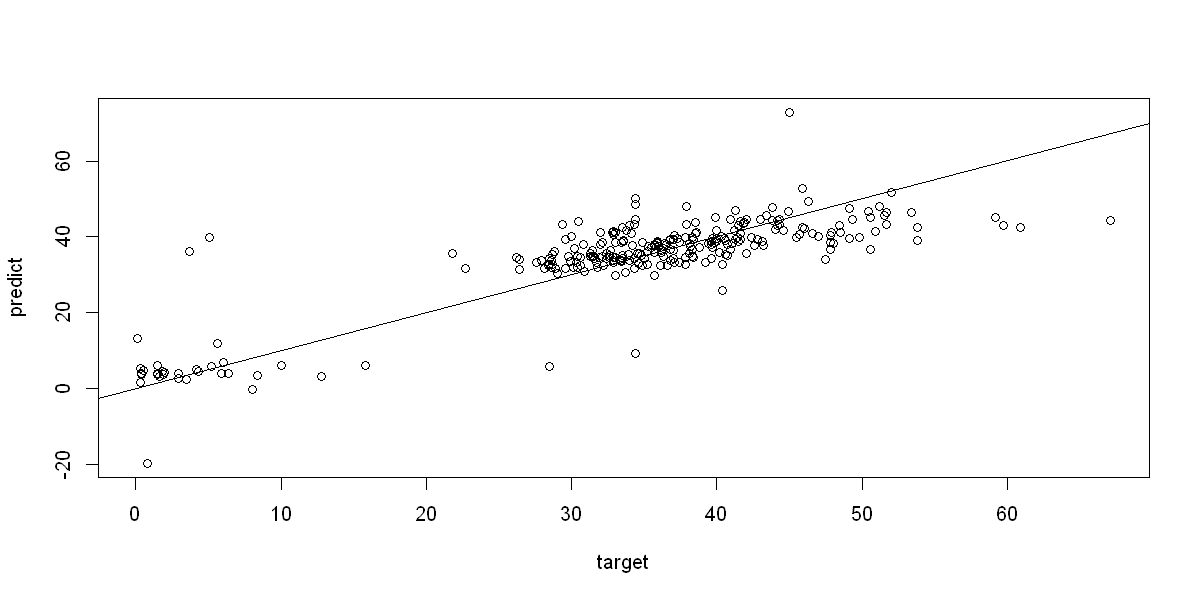

[1] "R-squared:  0.504051396669538"
[1] "MAE:  6.33474679866942"
[1] "RMSE:  9.06405528176555"


[[1]]
[1] 0.5040514

[[2]]
[1] 6.334747

[[3]]
[1] 9.064055

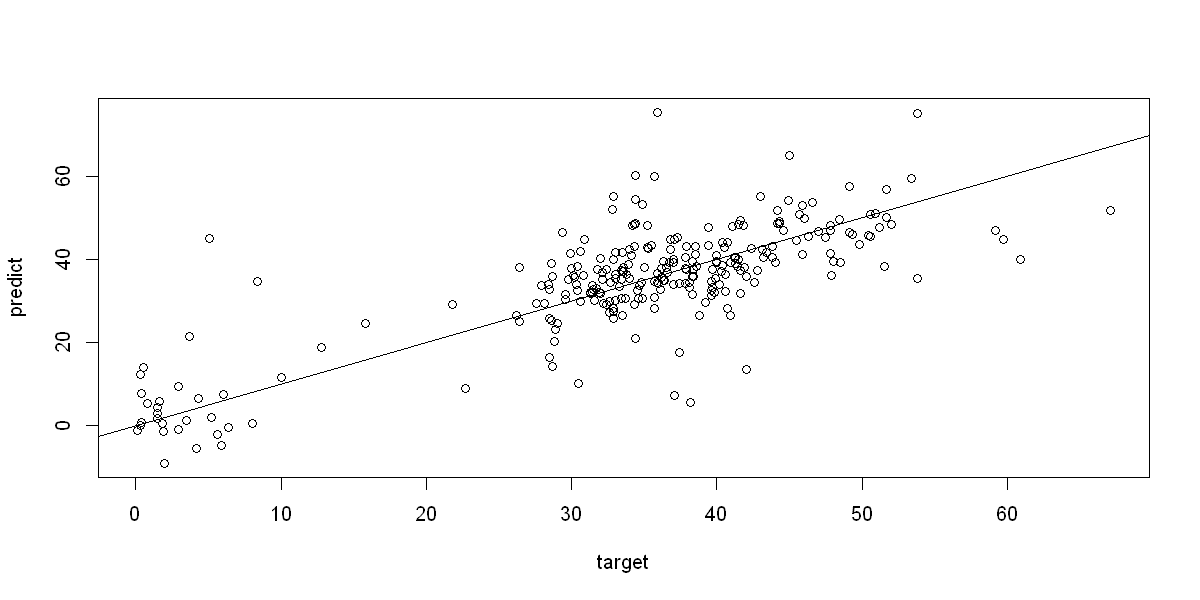

In [292]:
# Testing different layer structures using the logistic function
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(10,10,10), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(5,10,15), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(10,20,30), 'logistic')

[1] "R-squared:  0.781814131372343"
[1] "MAE:  4.42656406210585"
[1] "RMSE:  6.01197989169172"


[[1]]
[1] 0.7818141

[[2]]
[1] 4.426564

[[3]]
[1] 6.01198

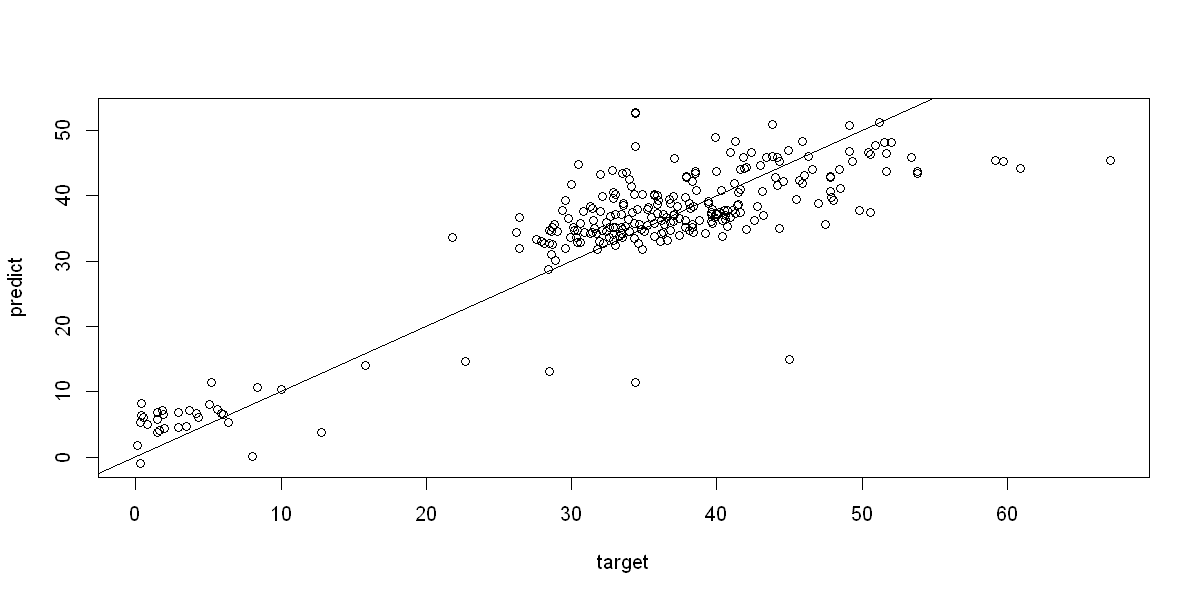

In [293]:
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,5,9), 'logistic')

[1] "R-squared:  0.728922569996691"
[1] "MAE:  4.64331663783758"
[1] "RMSE:  6.70117392043923"


[[1]]
[1] 0.7289226

[[2]]
[1] 4.643317

[[3]]
[1] 6.701174

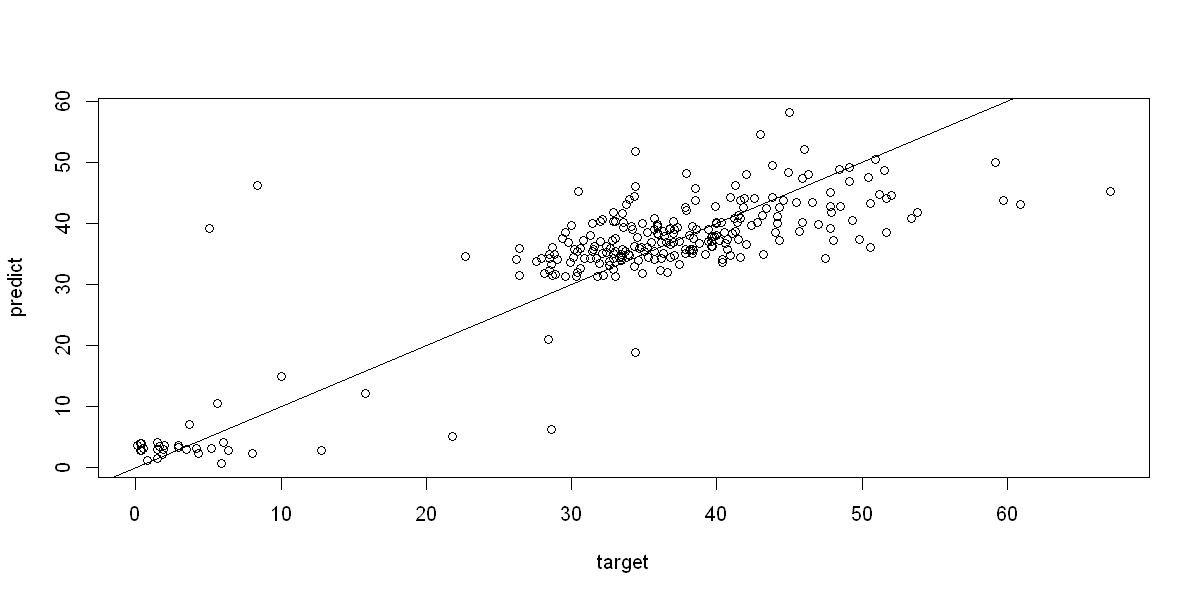

[1] "R-squared:  0.680956806817737"
[1] "MAE:  4.82434102003241"
[1] "RMSE:  7.26990861240004"


[[1]]
[1] 0.6809568

[[2]]
[1] 4.824341

[[3]]
[1] 7.269909

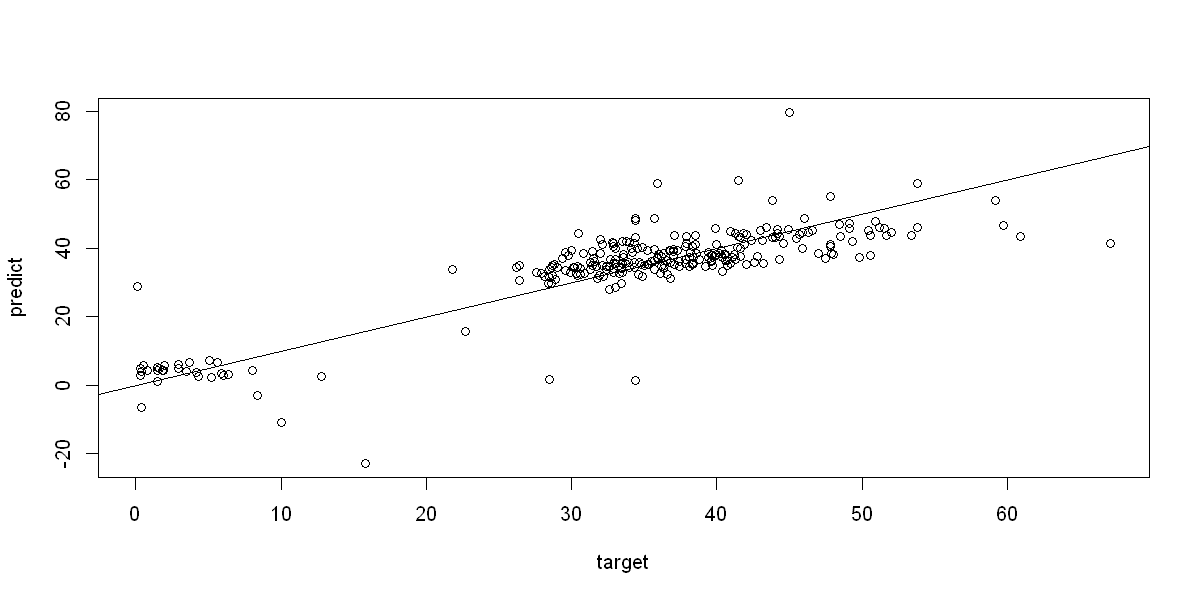

In [294]:
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,5,9,12), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,5,9,12,15), 'logistic')

[1] "R-squared:  0.6796367922299"
[1] "MAE:  4.92737313917969"
[1] "RMSE:  7.28493240862212"


[[1]]
[1] 0.6796368

[[2]]
[1] 4.927373

[[3]]
[1] 7.284932

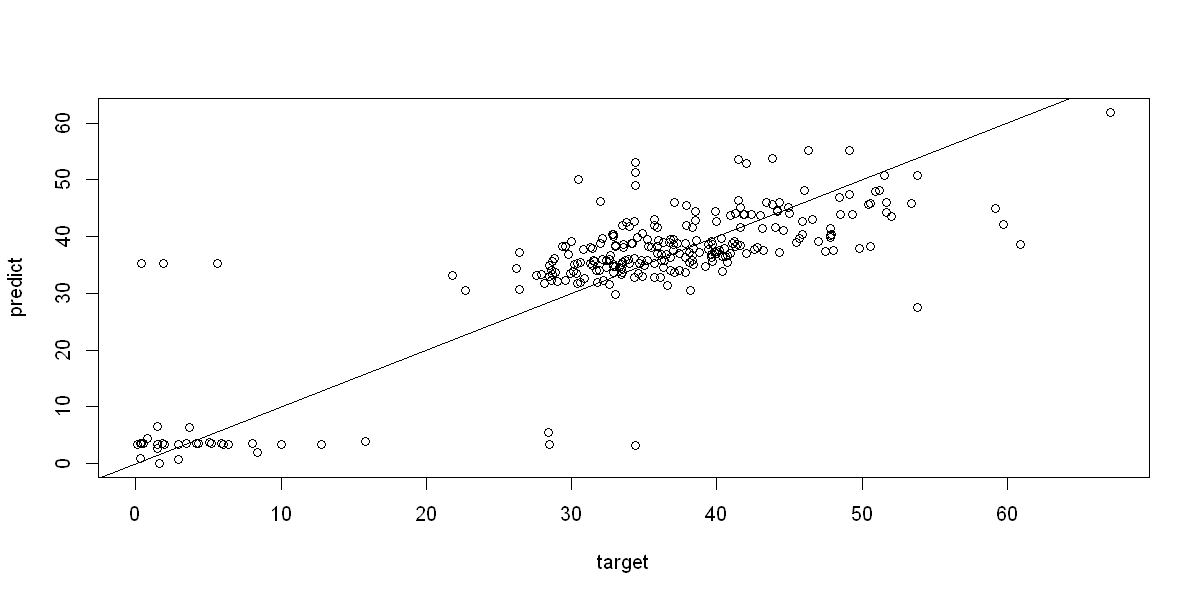

[1] "R-squared:  0.750485270971108"
[1] "MAE:  4.52975227157373"
[1] "RMSE:  6.42913142226952"


[[1]]
[1] 0.7504853

[[2]]
[1] 4.529752

[[3]]
[1] 6.429131

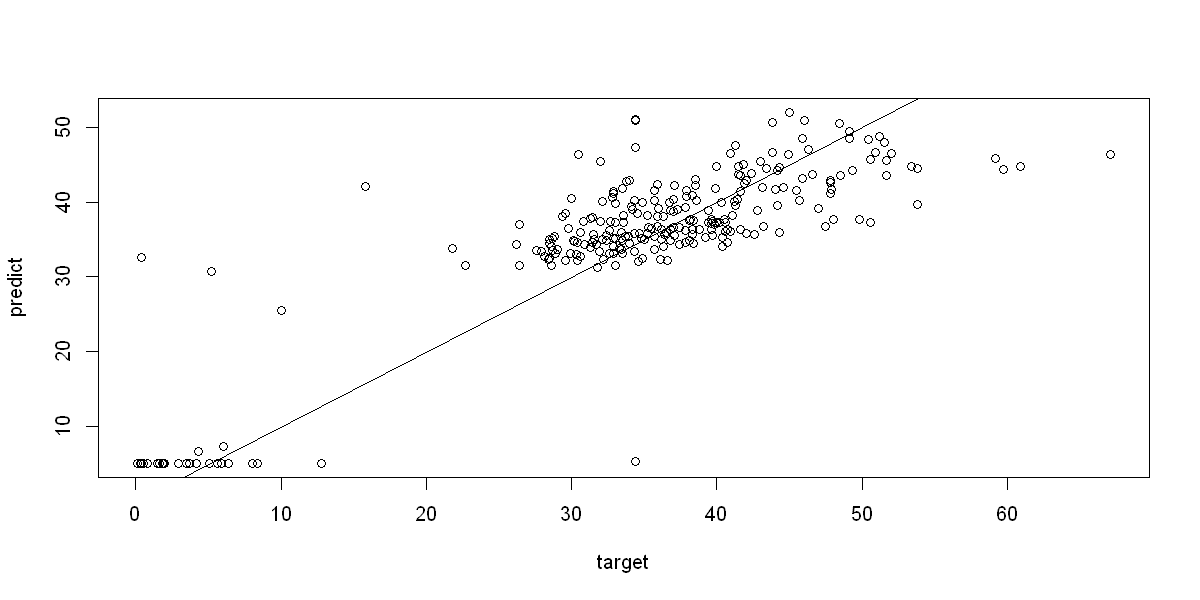

[1] "R-squared:  0.474896008953811"
[1] "MAE:  5.40061717979069"
[1] "RMSE:  9.32667555728019"


[[1]]
[1] 0.474896

[[2]]
[1] 5.400617

[[3]]
[1] 9.326676

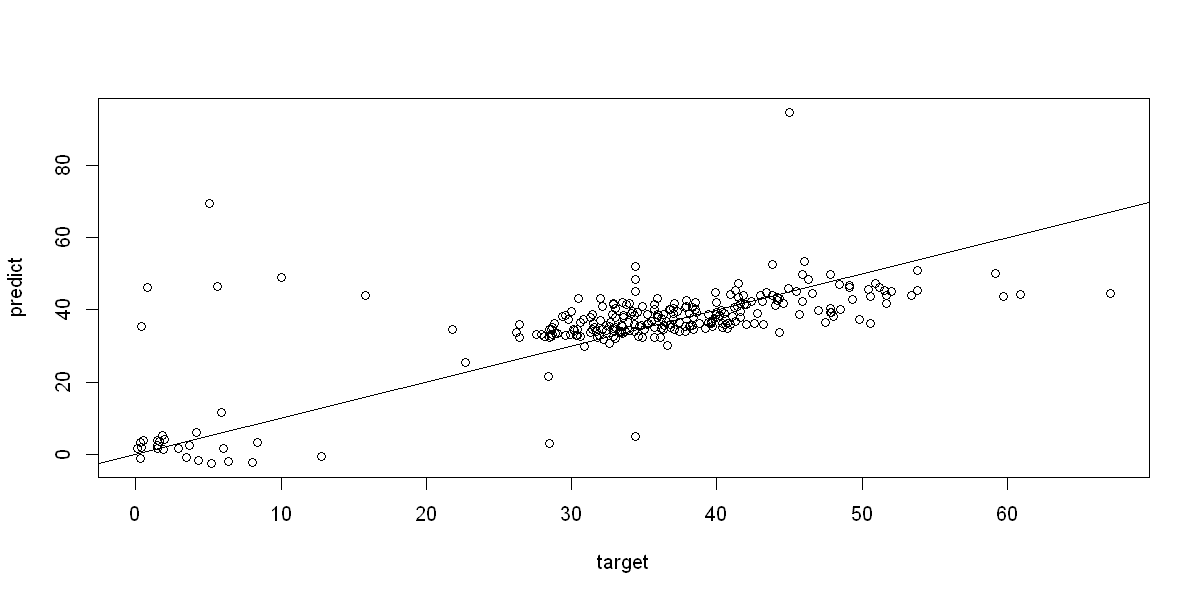

In [295]:
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,7,15,7,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(2,6,12,6,2), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,8,15,8,3), 'logistic')

The (2,6,12,6,2) setup may be the best that can reasonably be achieved with limited testing. Let us try with large numbers of nodes to see if that yields extra performance.

[1] "R-squared:  -1.73110006840034"
[1] "MAE:  11.0574230108134"
[1] "RMSE:  21.2702706679897"


[[1]]
[1] -1.7311

[[2]]
[1] 11.05742

[[3]]
[1] 21.27027

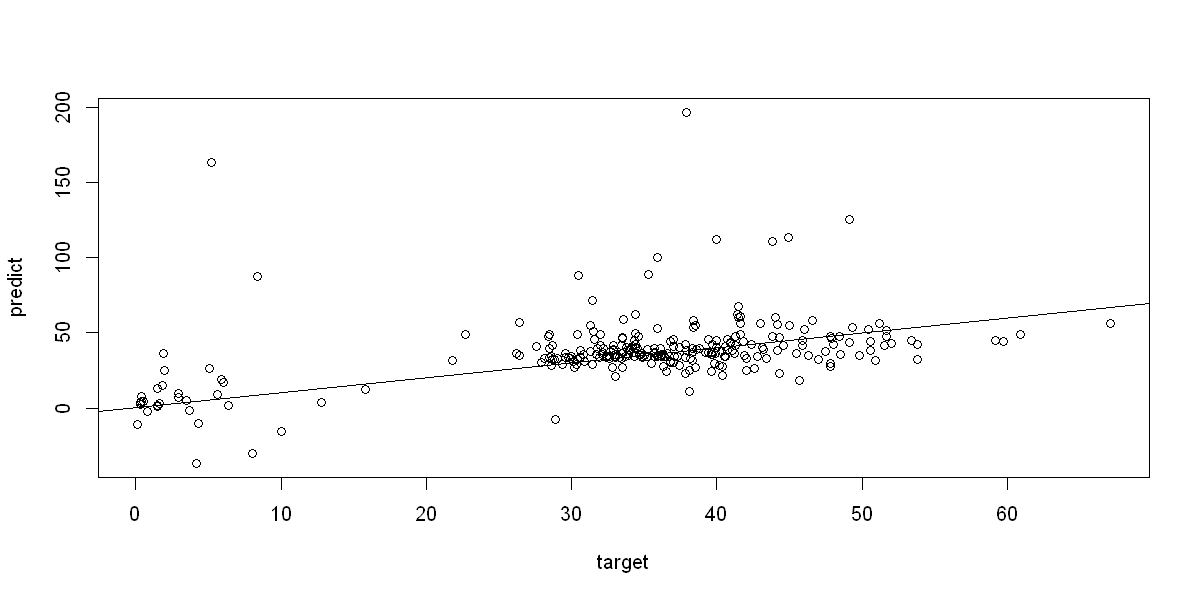

[1] "R-squared:  0.093006015007019"
[1] "MAE:  8.55076262730028"
[1] "RMSE:  12.2576273298352"


[[1]]
[1] 0.09300602

[[2]]
[1] 8.550763

[[3]]
[1] 12.25763

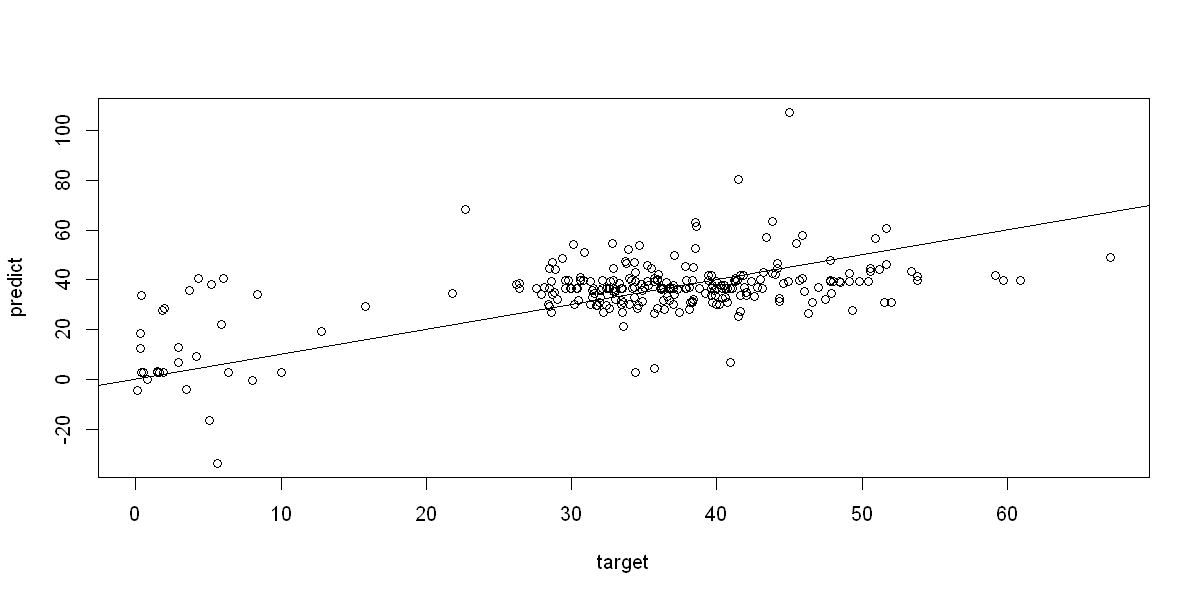

In [296]:
# Testing with large numbers of nodes in each hidden layer to see if this gives better results
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,100,500,100,30), 'logistic')
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(30,100,500,100,30), 'tanh')

### 2.3.3 Fine Tuning for Prg8Score_Disadvantaged
With Prg8Score_Disadvantaged as the output variable, a similar analysis is performed. Different architectures will be tested, starting with a single hidden layer.

#### One Hidden Layer

[1] "R-squared:  0.194372344689677"
[1] "MAE:  0.423967344631032"
[1] "RMSE:  0.546782120219013"


[[1]]
[1] 0.1943723

[[2]]
[1] 0.4239673

[[3]]
[1] 0.5467821

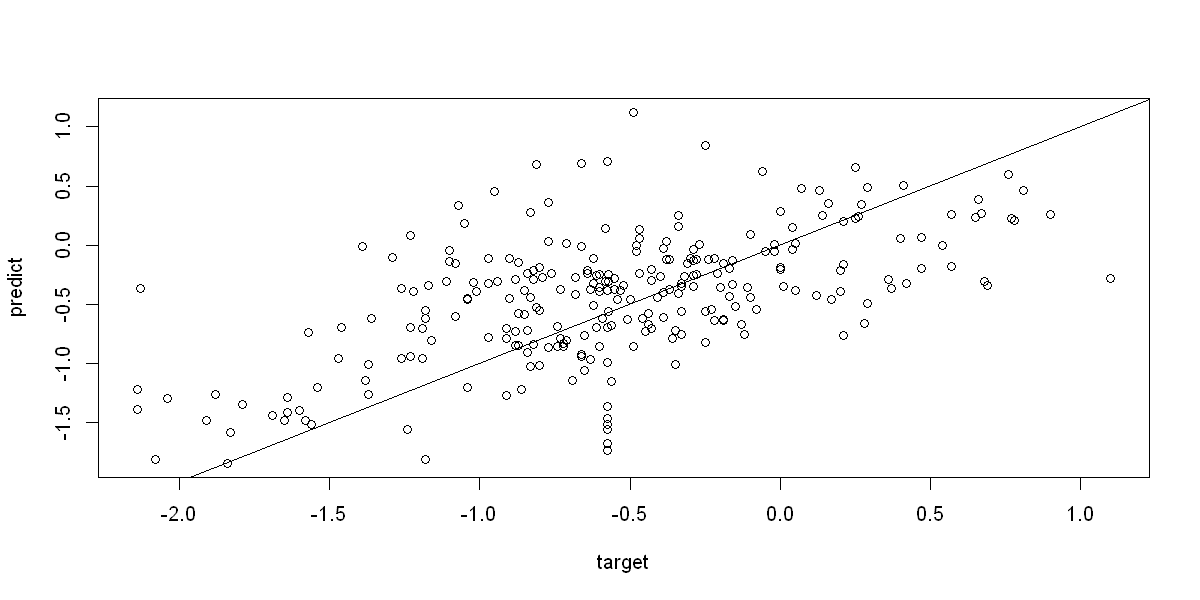

[1] "R-squared:  0.259842698394922"
[1] "MAE:  0.387658068642223"
[1] "RMSE:  0.524093936938573"


[[1]]
[1] 0.2598427

[[2]]
[1] 0.3876581

[[3]]
[1] 0.5240939

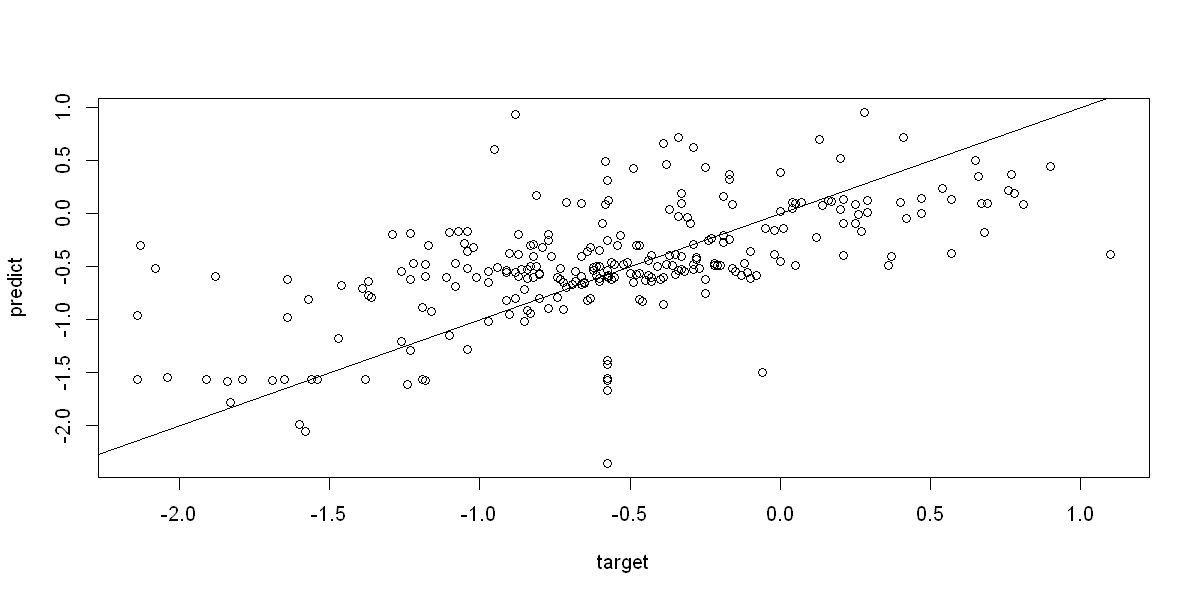

[1] "R-squared:  -0.0785746078687024"
[1] "MAE:  0.403561822854067"
[1] "RMSE:  0.632662681185971"


[[1]]
[1] -0.07857461

[[2]]
[1] 0.4035618

[[3]]
[1] 0.6326627

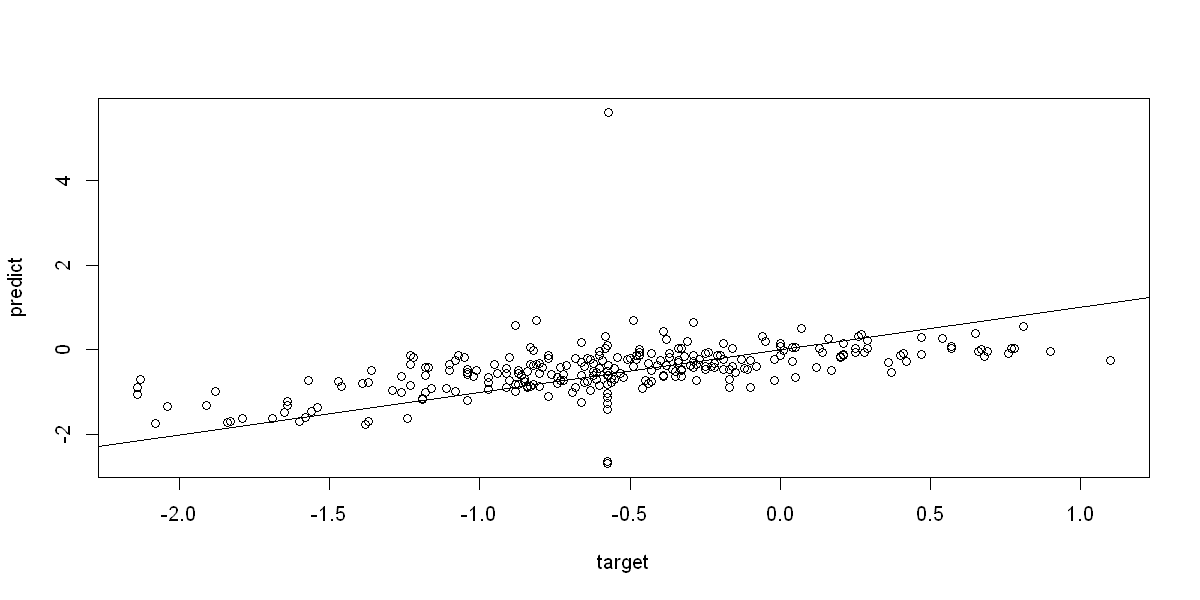

[1] "R-squared:  0.259981463952603"
[1] "MAE:  0.381204019818623"
[1] "RMSE:  0.524044805763148"


[[1]]
[1] 0.2599815

[[2]]
[1] 0.381204

[[3]]
[1] 0.5240448

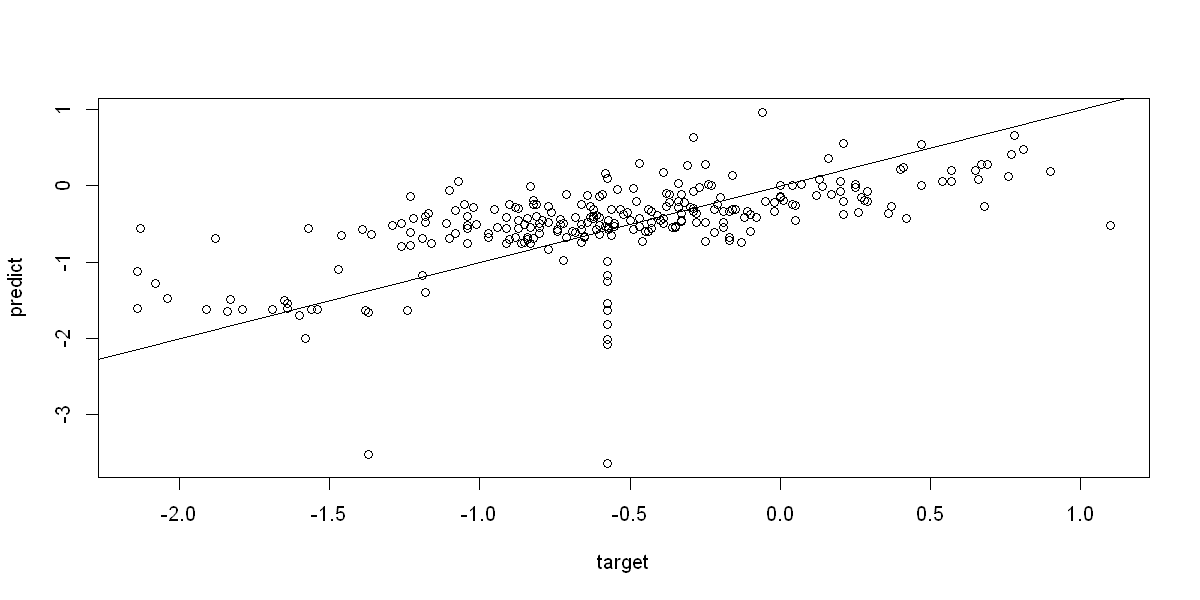

In [297]:
# Calling the ModelNN function to train and evaluate a model for Prg8Score_Disadvantaged
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(10), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(7), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(5), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(3), 'logistic')

For One Hidden layer, the results aren't promising. Two hidden layers will be tried next.

#### Two Hidden Layers

[1] "R-squared:  0.258340499265979"
[1] "MAE:  0.402403832765989"
[1] "RMSE:  0.524625509343805"


[[1]]
[1] 0.2583405

[[2]]
[1] 0.4024038

[[3]]
[1] 0.5246255

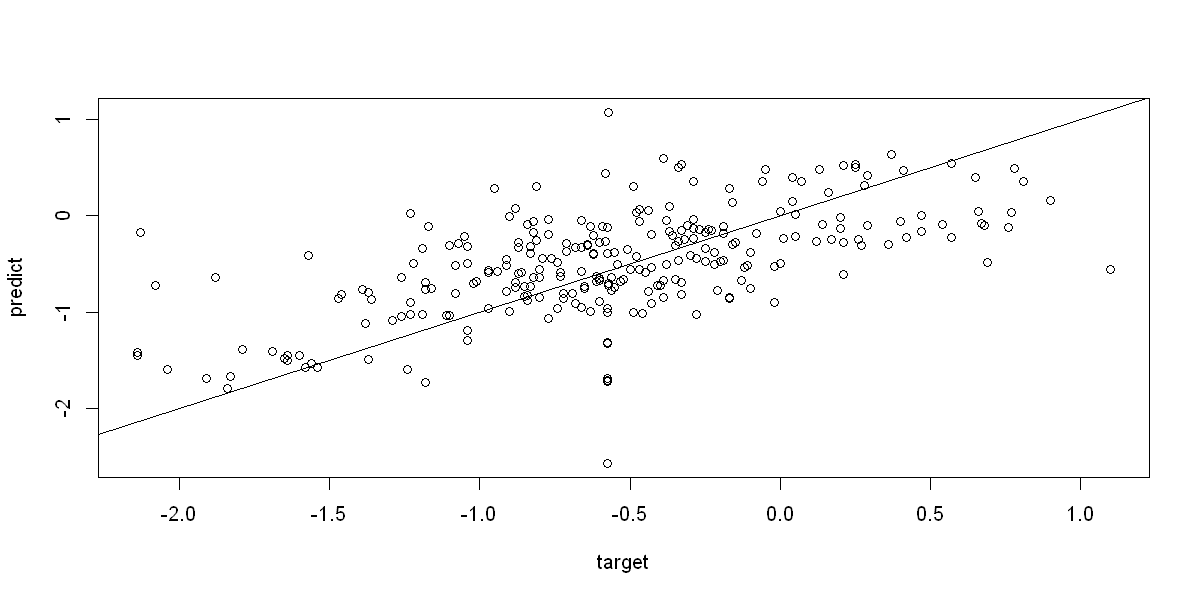

[1] "R-squared:  0.36330955817325"
[1] "MAE:  0.37974572940859"
[1] "RMSE:  0.486083956012415"


[[1]]
[1] 0.3633096

[[2]]
[1] 0.3797457

[[3]]
[1] 0.486084

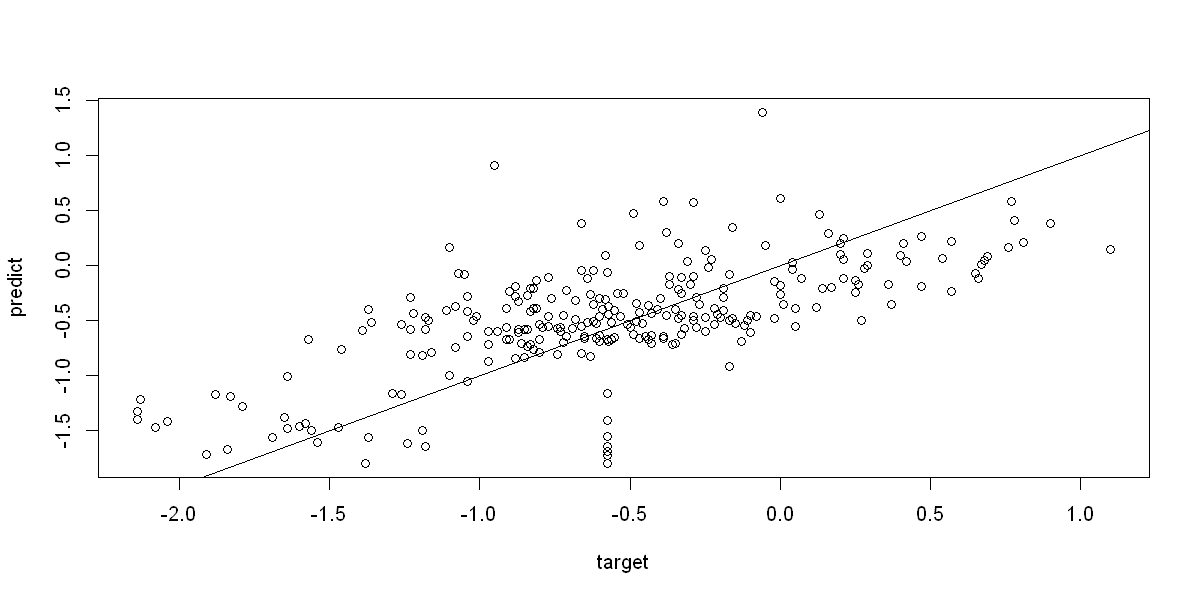

[1] "R-squared:  0.480134763669082"
[1] "MAE:  0.348656844316206"
[1] "RMSE:  0.439230520583476"


[[1]]
[1] 0.4801348

[[2]]
[1] 0.3486568

[[3]]
[1] 0.4392305

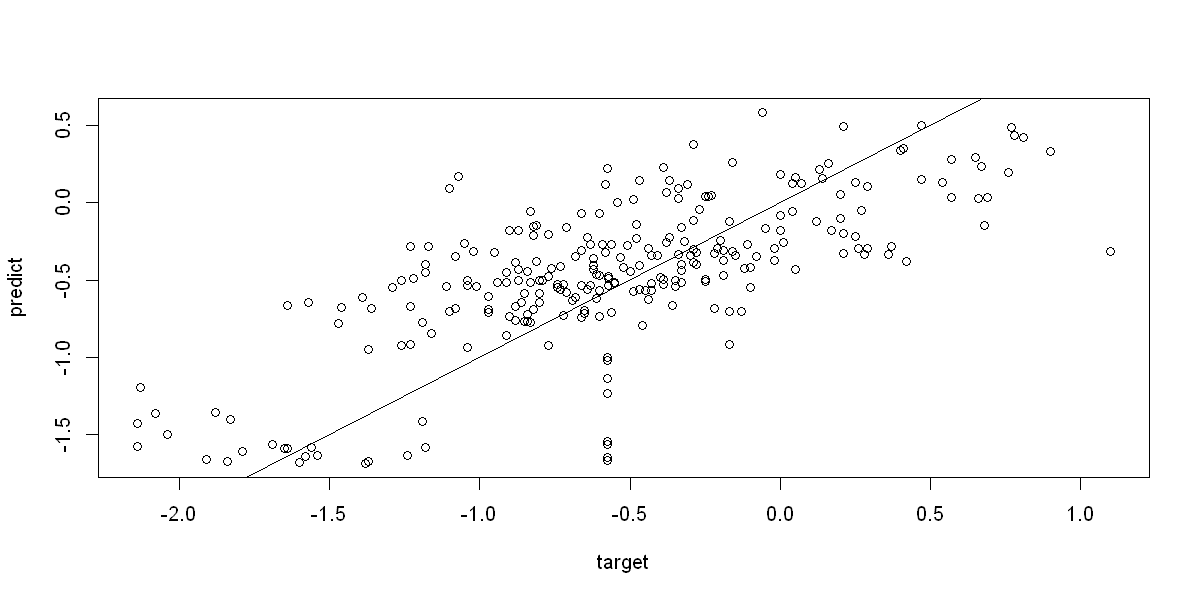

In [298]:
# Calling the ModelNN function to train and evaluate a model for Prg8Score_Disadvantaged
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(9,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(5,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(3,3), 'logistic')

For 2 hidden layers, the best result of R-Squared = 0.25 was produced using the (3,3) structure. This value is still low in comparison to the results for Att8Score_Disadvantaged, indicating worse performance.
#### Three Hidden Layer

[1] "R-squared:  0.0547704672415037"
[1] "MAE:  0.44991619208598"
[1] "RMSE:  0.592264582804054"


[[1]]
[1] 0.05477047

[[2]]
[1] 0.4499162

[[3]]
[1] 0.5922646

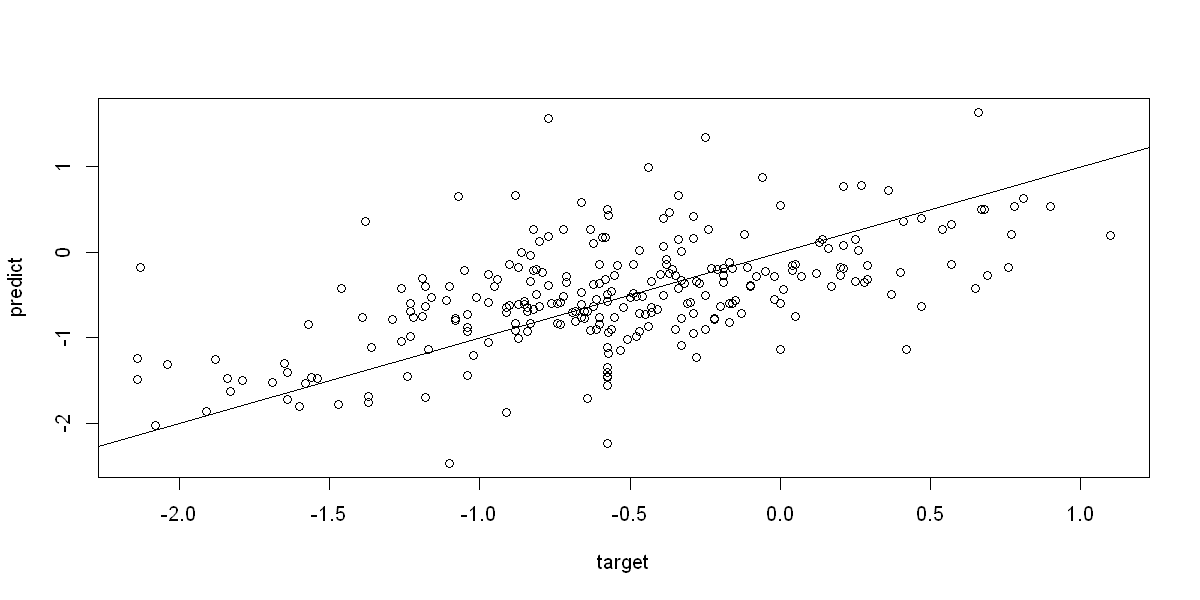

[1] "R-squared:  -0.28755922437469"
[1] "MAE:  0.478762845500691"
[1] "RMSE:  0.691242972241503"


[[1]]
[1] -0.2875592

[[2]]
[1] 0.4787628

[[3]]
[1] 0.691243

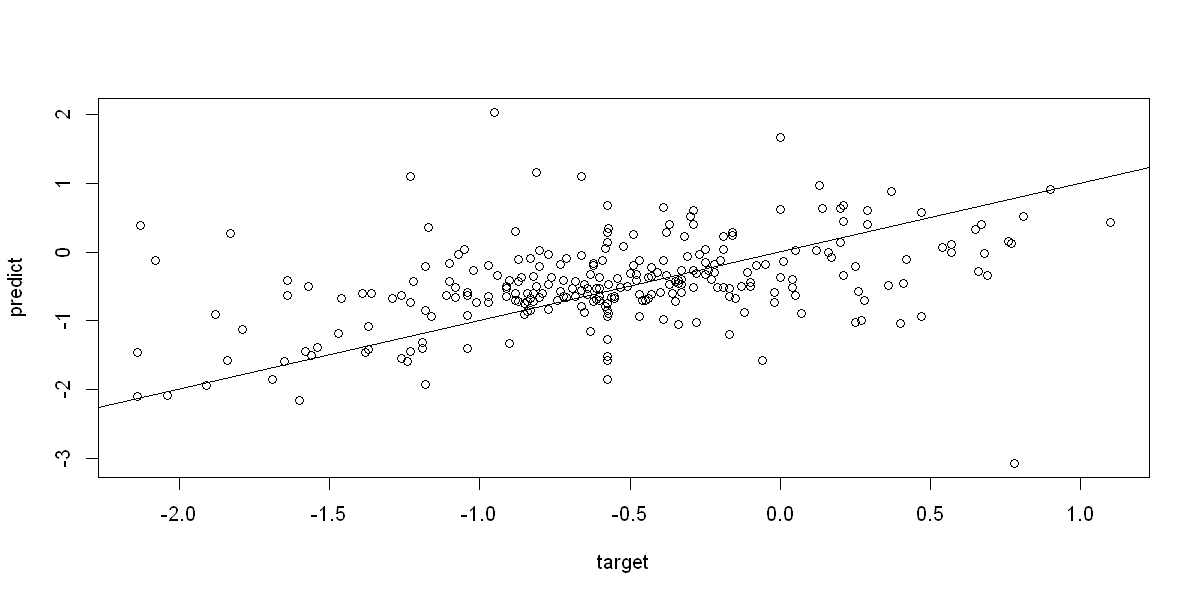

[1] "R-squared:  0.449848527708594"
[1] "MAE:  0.35404174945881"
[1] "RMSE:  0.451843731274721"


[[1]]
[1] 0.4498485

[[2]]
[1] 0.3540417

[[3]]
[1] 0.4518437

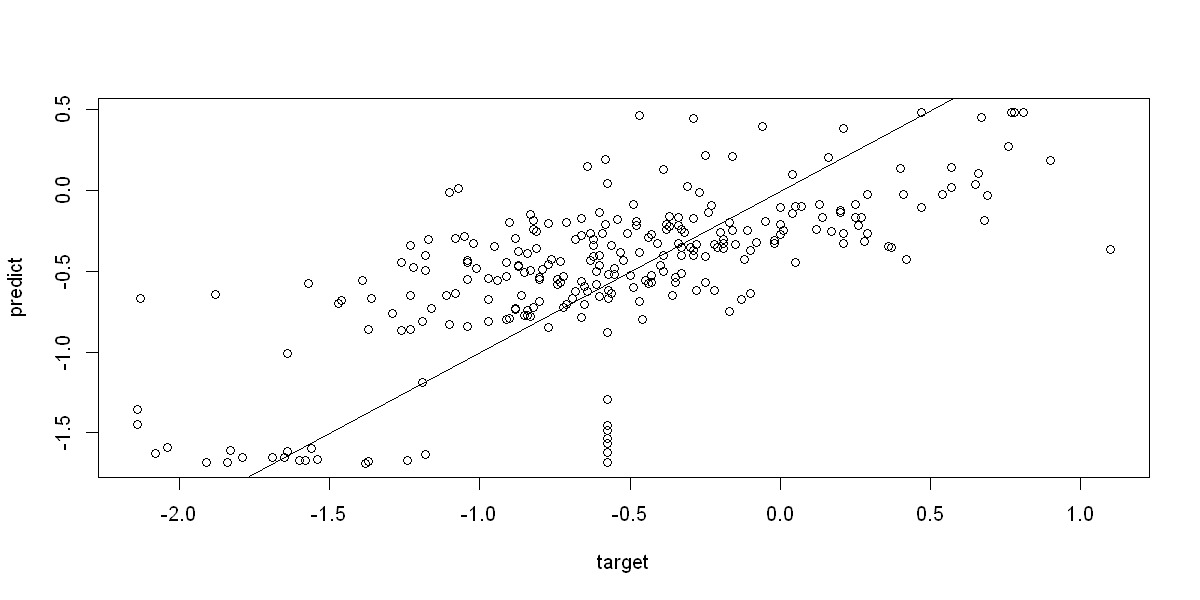

[1] "R-squared:  0.478727886506378"
[1] "MAE:  0.344486046122667"
[1] "RMSE:  0.439824449389691"


[[1]]
[1] 0.4787279

[[2]]
[1] 0.344486

[[3]]
[1] 0.4398244

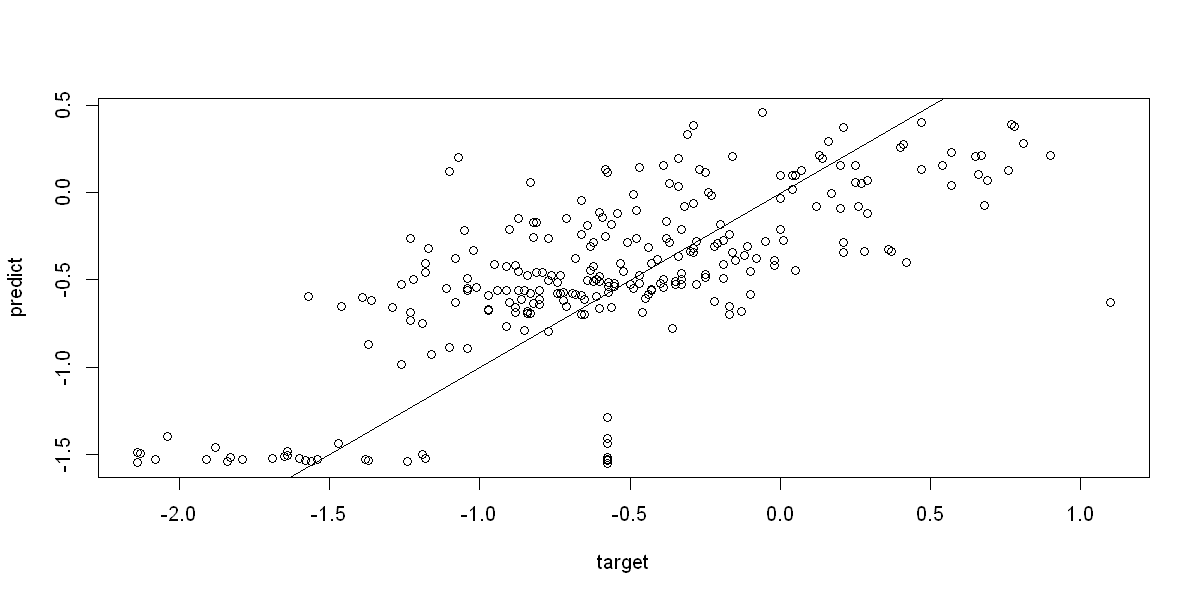

In [299]:
# Calling the ModelNN function to train and evaluate a model for Prg8Score_Disadvantaged
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(5,17,11), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(7,7,7), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(3,3,3), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(2,2,3), 'logistic')

With 3 hidden layers, the (2,2,3) structure showed the best results with R-Squared = 0.34. This R-Squared value is larger than for the previous best (3,3) architecture.

#### Four Hidden Layer

[1] "R-squared:  -0.356688401186626"
[1] "MAE:  0.516362100516011"
[1] "RMSE:  0.709556818349457"


[[1]]
[1] -0.3566884

[[2]]
[1] 0.5163621

[[3]]
[1] 0.7095568

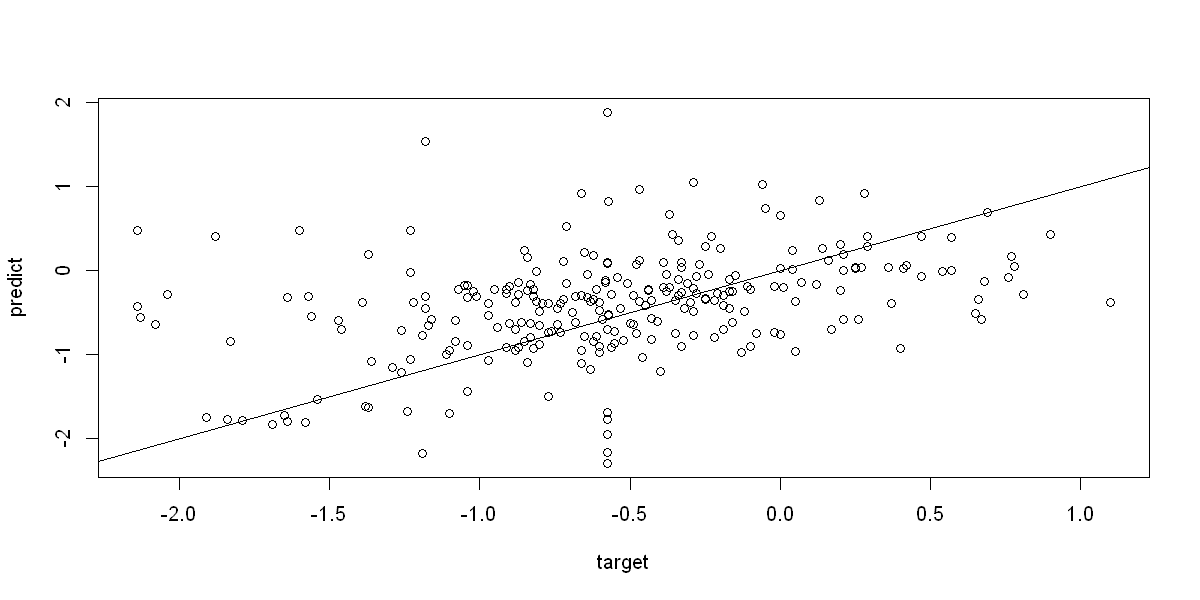

[1] "R-squared:  0.214167954437914"
[1] "MAE:  0.404684812820334"
[1] "RMSE:  0.540022666728716"


[[1]]
[1] 0.214168

[[2]]
[1] 0.4046848

[[3]]
[1] 0.5400227

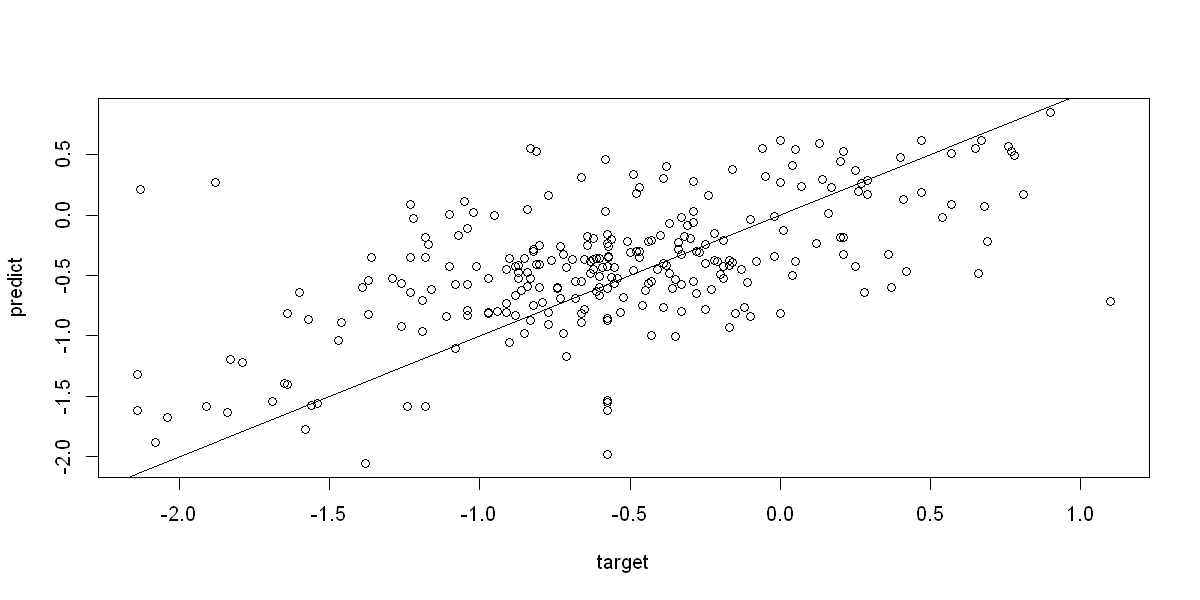

[1] "R-squared:  0.387548364671549"
[1] "MAE:  0.366645749060999"
[1] "RMSE:  0.476741568442836"


[[1]]
[1] 0.3875484

[[2]]
[1] 0.3666457

[[3]]
[1] 0.4767416

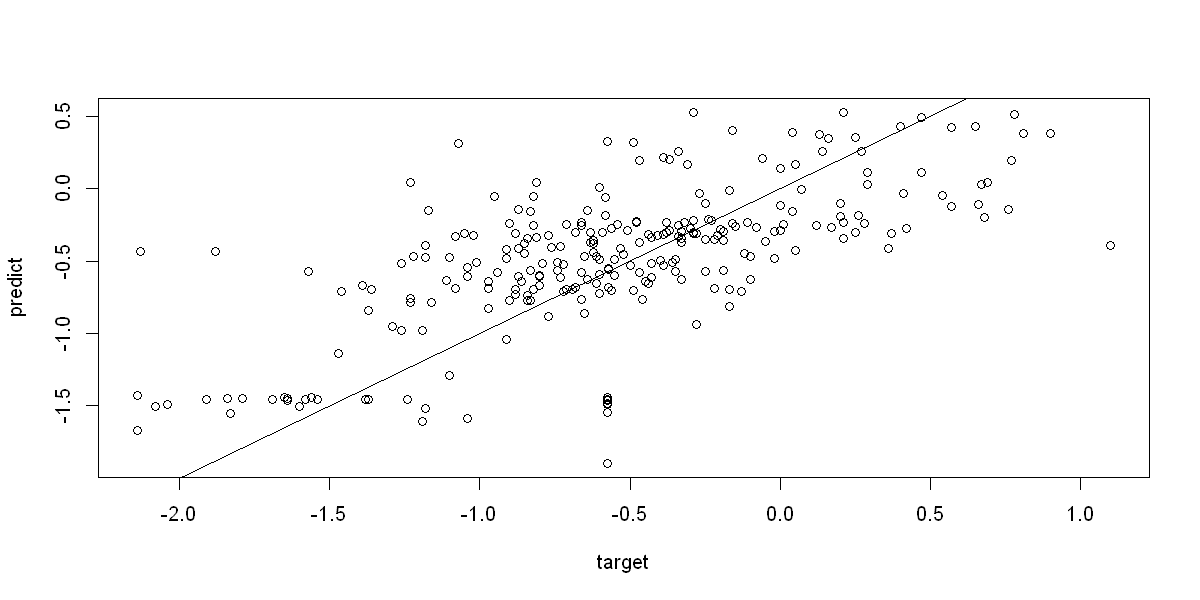

In [300]:
# Calling the ModelNN function to train and evaluate a model for Prg8Score_Disadvantaged
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(5,10,15,5), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(9,6,3,2), 'logistic')
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(3,3,4,2), 'logistic')

Four hidden layers have produced worse results than three based on the limited testing set. It looks like none of the architectures are performing as well on Prg8Score_Disadvantaged. The highest R-Squared value so far has come from the (2,2,3) architecture.

### 2.3.4 Testing for Other Years

Some less structured testing was carried out for the remaining years. This is because the architectures used for 2018-19 performed poorly on these years. This testing has not been recorded, but it followed the trial and error based approach used in the tuning sections.

### 2.3.5 Results for All Years

#### Predicting for 2018-19
The highest performing architectures for 2018-19 were (2,6,12,6,2) and (2,2,3) for Att8 and Prg8 respectively. These will be used.

[1] "R-squared:  0.750485270971108"
[1] "MAE:  4.52975227157373"
[1] "RMSE:  6.42913142226952"


[[1]]
[1] 0.7504853

[[2]]
[1] 4.529752

[[3]]
[1] 6.429131

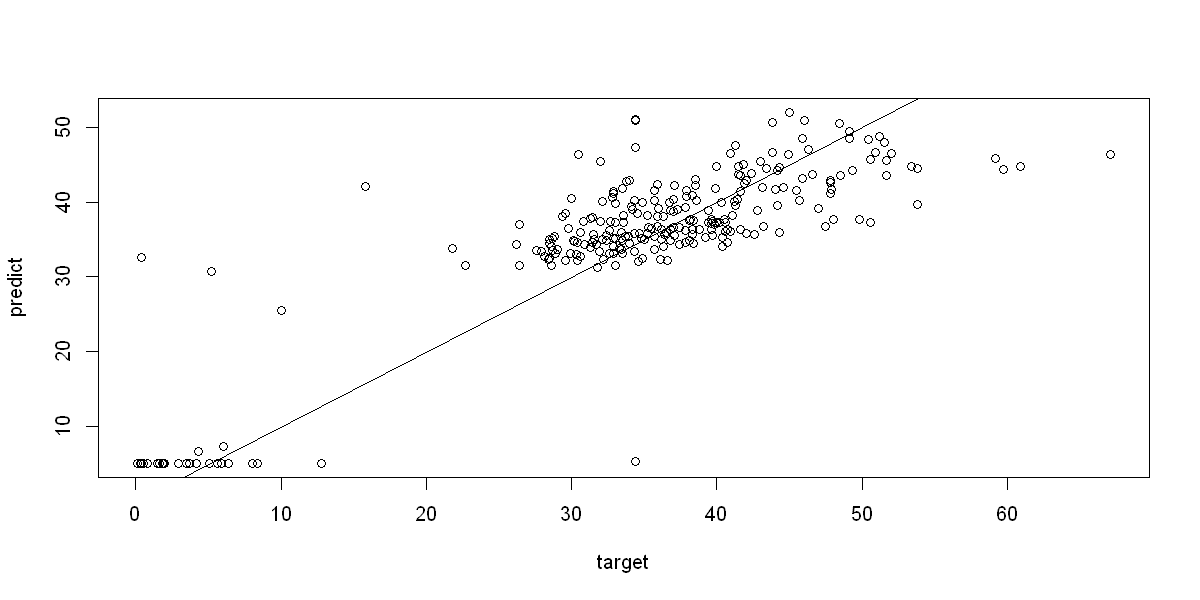

[1] "R-squared:  0.478727886506378"
[1] "MAE:  0.344486046122667"
[1] "RMSE:  0.439824449389691"


[[1]]
[1] 0.4787279

[[2]]
[1] 0.344486

[[3]]
[1] 0.4398244

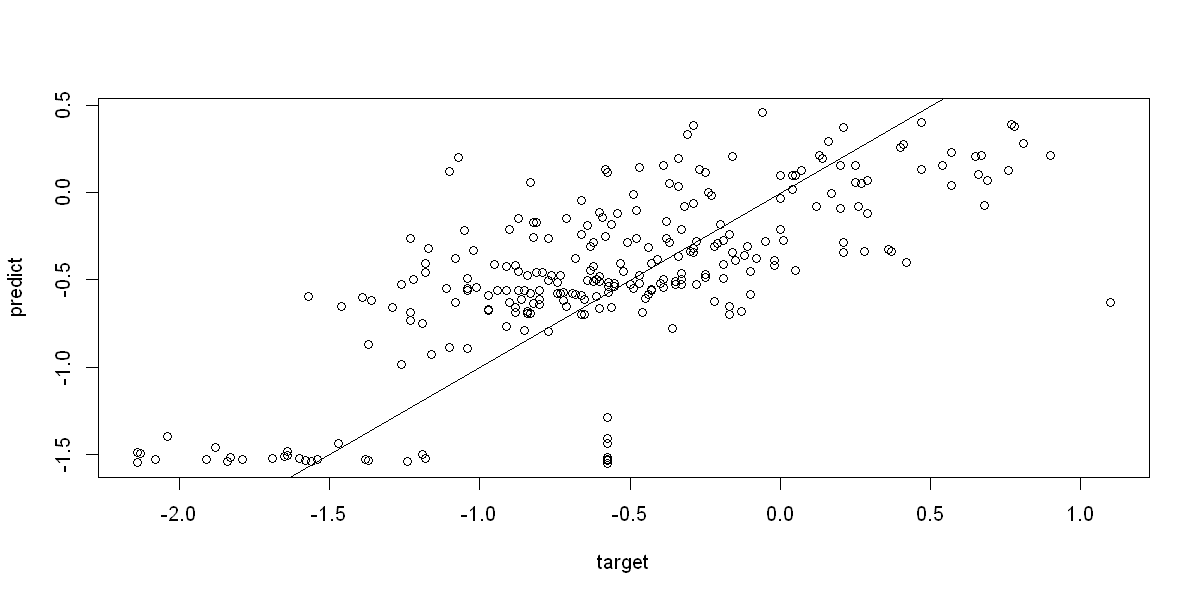

In [301]:
# Calling ModelNN to train and evaluate a neural network predicting AttScore8_Disadvantaged for 2018-19
ModelNN(XY_2018_19_encoded, 'Att8Score_Disadvantaged', inputcol, c(2,6,12,6,2), 'logistic')
# Calling ModelNN to train and evaluate a neural network predicting PrgScore8_Disadvantaged for 2018-19
ModelNN(XY_2018_19_encoded, 'Prg8Score_Disadvantaged', inputcol, c(2,2,3), 'logistic')

#### Predicting for 2017-18
The neural network architectures from before didn't show good performance for 2017-18. Following testing, the (2,4,2) and (2,2,2,6,4) structures showed the best results for 2017-18 for Att8 and Prg8 respectively.

[1] "R-squared:  0.488705652686452"
[1] "MAE:  5.1765338479922"
[1] "RMSE:  7.83666192069264"


[[1]]
[1] 0.4887057

[[2]]
[1] 5.176534

[[3]]
[1] 7.836662

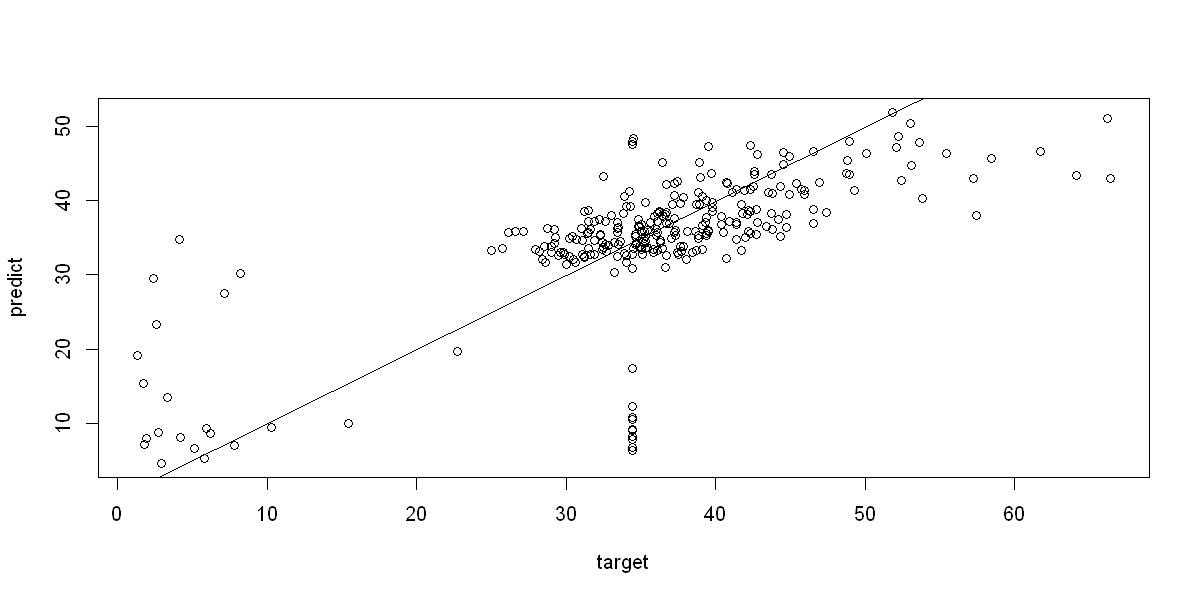

[1] "R-squared:  0.473509822303236"
[1] "MAE:  0.333223996310787"
[1] "RMSE:  0.411829679522851"


[[1]]
[1] 0.4735098

[[2]]
[1] 0.333224

[[3]]
[1] 0.4118297

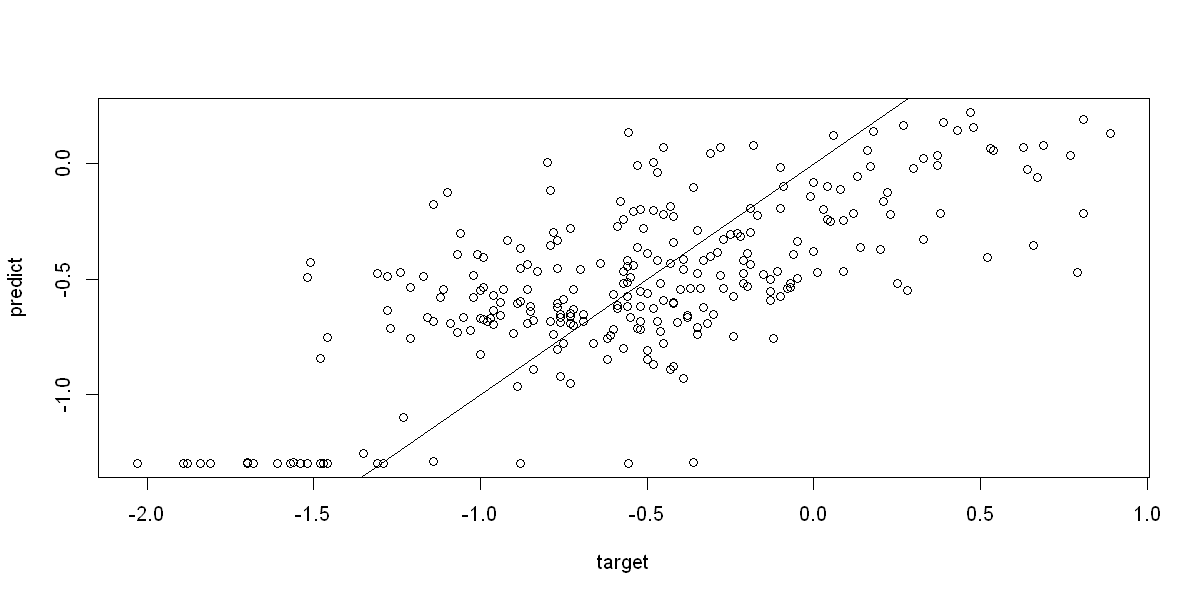

In [302]:
# Calling ModelNN to train and evaluate a neural network predicting AttScore8_Disadvantaged for 2017-18
ModelNN(XY_2017_18_encoded, 'Att8Score_Disadvantaged', inputcol, c(2,4,2), 'logistic')
# Calling ModelNN to train and evaluate a neural network predicting PrgScore8_Disadvantaged for 2017-18
ModelNN(XY_2017_18_encoded, 'Prg8Score_Disadvantaged', inputcol, c(2,2,2,6,4), 'logistic')

#### Predicting for 2016-17
Following experimentation, (3,2,1,4,3) and (2,2,2,6,4) showed the best results for 2016-17 for Att8 and Prg8 respectively.

[1] "R-squared:  0.444716920458983"
[1] "MAE:  6.8600713338308"
[1] "RMSE:  8.69639373595067"


[[1]]
[1] 0.4447169

[[2]]
[1] 6.860071

[[3]]
[1] 8.696394

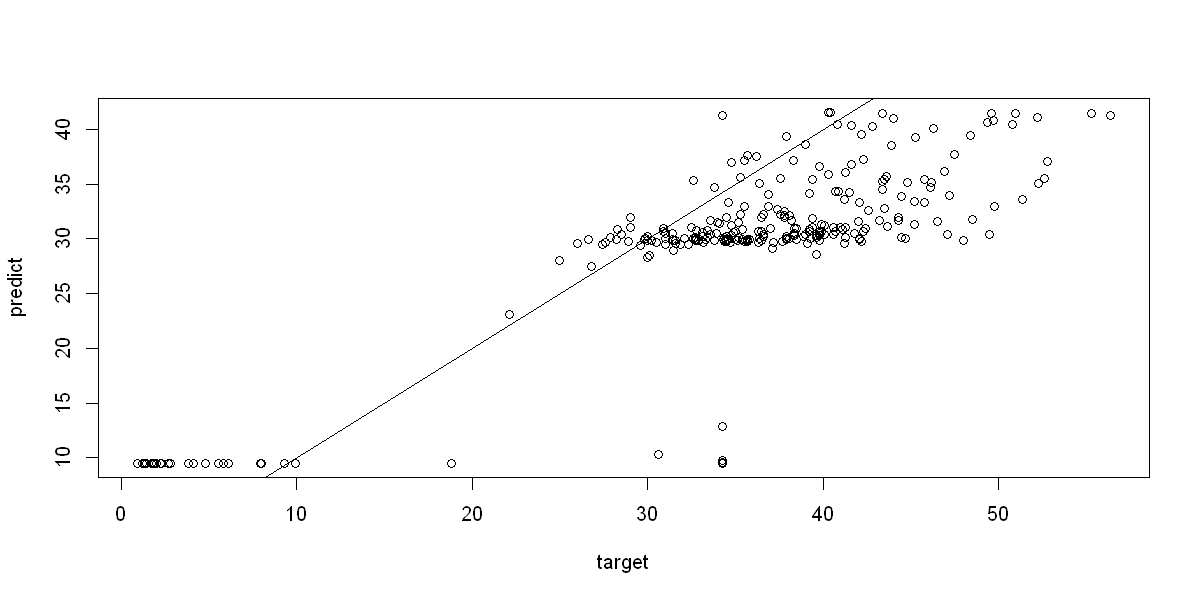

[1] "R-squared:  0.497232678733604"
[1] "MAE:  0.312790875005787"
[1] "RMSE:  0.399863028373578"


[[1]]
[1] 0.4972327

[[2]]
[1] 0.3127909

[[3]]
[1] 0.399863

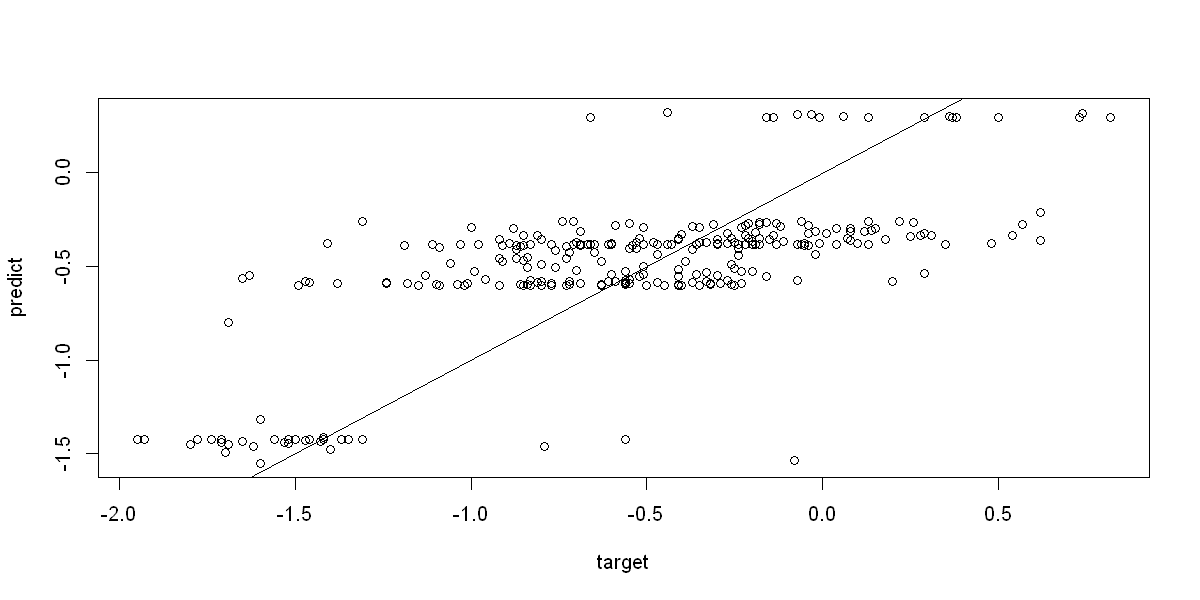

In [303]:
# Calling ModelNN to train and evaluate a neural network predicting AttScore8_Disadvantaged for 2016-17
ModelNN(XY_2016_17_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,2,1,4,3), 'logistic')
# Calling ModelNN to train and evaluate a neural network predicting PrgScore8_Disadvantaged for 2016-17
ModelNN(XY_2016_17_encoded, 'Prg8Score_Disadvantaged', inputcol, c(2,2,2,6,4), 'logistic')

#### Predicting for 2015-16
Following experimentation, the (3,1,4,4,2) and (2,8,6,2,4) structures showed the best results for 2015-16 for Att8 and Prg8 respectively.

[1] "R-squared:  0.409078307074778"
[1] "MAE:  5.73114648717508"
[1] "RMSE:  8.43760593175228"


[[1]]
[1] 0.4090783

[[2]]
[1] 5.731146

[[3]]
[1] 8.437606

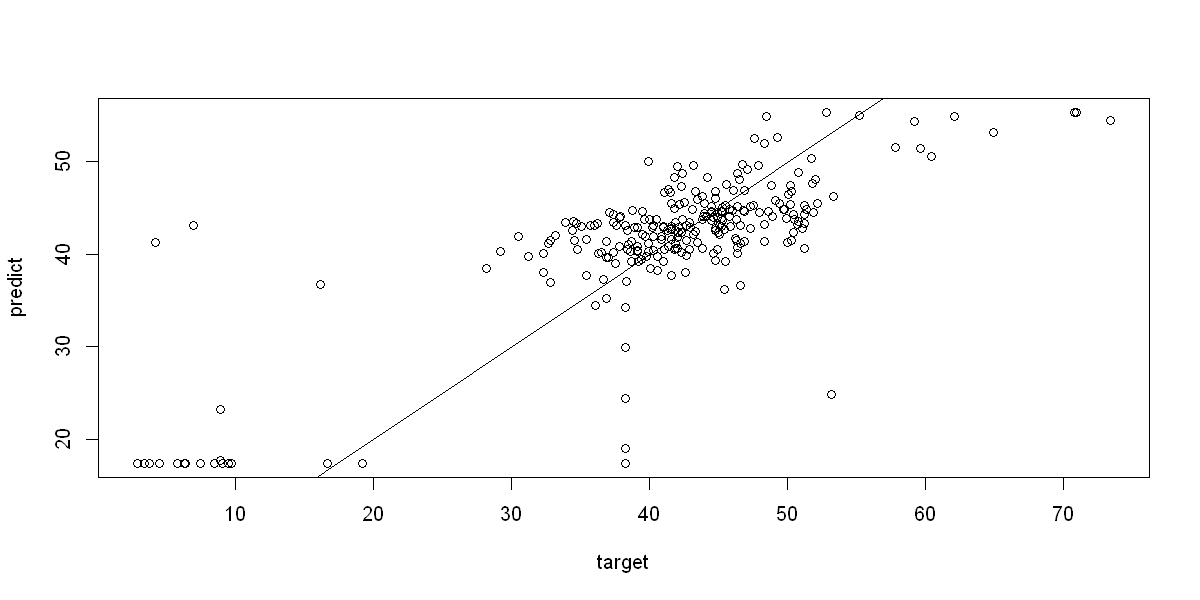

[1] "R-squared:  0.403145297622346"
[1] "MAE:  0.331233893976441"
[1] "RMSE:  0.455237433458024"


[[1]]
[1] 0.4031453

[[2]]
[1] 0.3312339

[[3]]
[1] 0.4552374

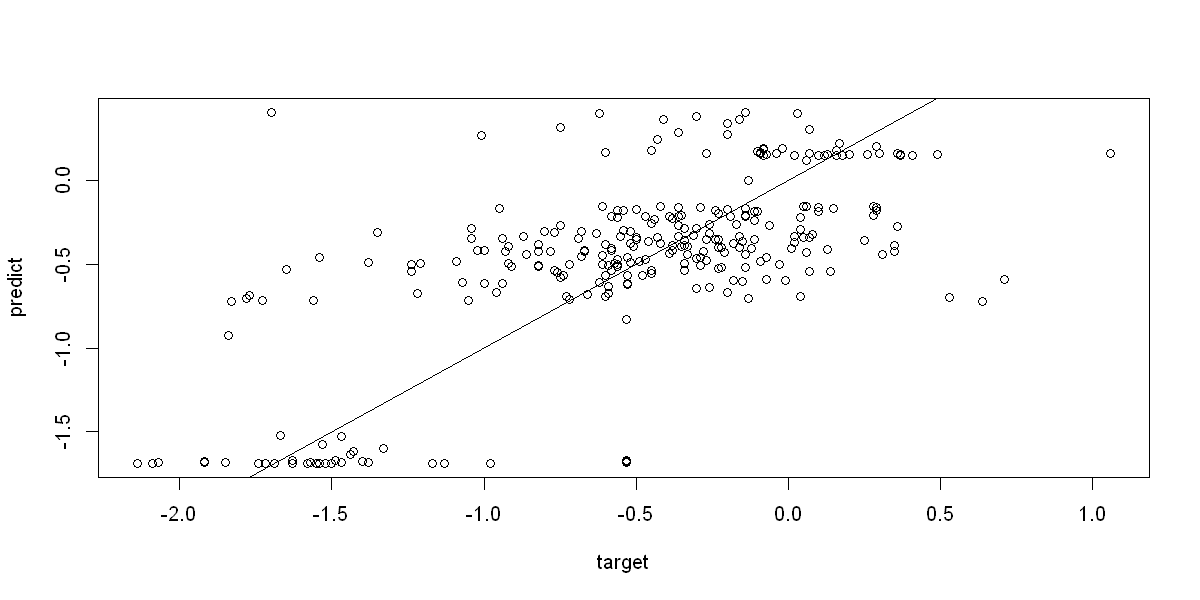

In [304]:
# Calling ModelNN to train and evaluate a neural network predicting AttScore8_Disadvantaged for 2015-16
ModelNN(XY_2015_16_encoded, 'Att8Score_Disadvantaged', inputcol, c(3,1,4,4,2), 'logistic')
# Calling ModelNN to train and evaluate a neural network predicting PrgScore8_Disadvantaged for 2015-16
ModelNN(XY_2015_16_encoded, 'Prg8Score_Disadvantaged', inputcol, c(2,8,6,2,4), 'logistic')

### 2.3.6 Predicting the following year using the previous year

In this section, the PredictAnotherYear function is used to train a model on a given year's data and test it on data pertaining to the subsequent year. The performance of the model is then determined using R-squared, MAE and RMSE as before.

#### Predicting 2018-19 with 2017-18

[1] "R-squared:  0.0877142309829692"
[1] "MAE:  9.17025457252343"
[1] "RMSE:  12.1144880828755"


[[1]]
[1] 0.08771423

[[2]]
[1] 9.170255

[[3]]
[1] 12.11449

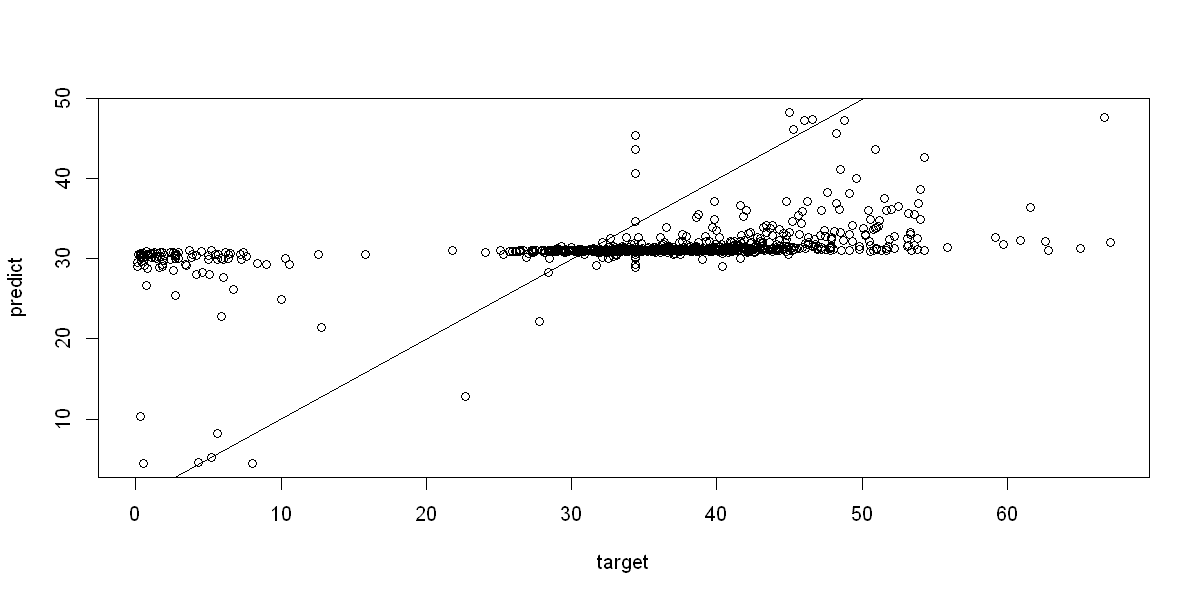

In [305]:
# Calling PredictAnotherYear to predict Att8Score_Disadvantaged in 18-19 using the model trained on the 17-18 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2018_19_encoded, XY_2017_18_encoded, 'Att8Score_Disadvantaged', 
                    inputcol, c(2,6,12,6,2), 'logistic')

The prediction for year 2018-19 Att8 is showing a negative R-Squared with respect to the actual data for 2018-19. This indicates that the model is performing worse than a straight line at the mean value.

[1] "R-squared:  -0.0597431864575892"
[1] "MAE:  0.517438742392629"
[1] "RMSE:  0.634166764744564"


[[1]]
[1] -0.05974319

[[2]]
[1] 0.5174387

[[3]]
[1] 0.6341668

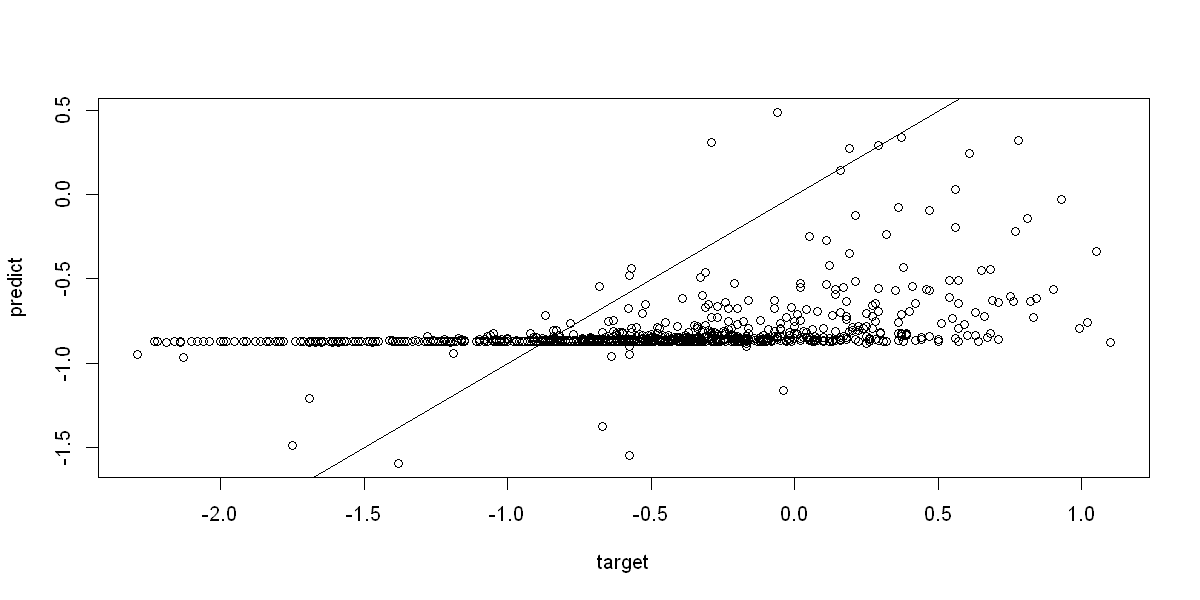

In [306]:
# Calling PredictAnotherYear to predict Prg8Score_Disadvantaged in 18-19 using the model trained on the 17-18 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2018_19_encoded, XY_2017_18_encoded, 'Prg8Score_Disadvantaged', 
                    inputcol, c(2,2,3), 'logistic')

The prediction for year 2018-19 Prg8 is showing a negative R-Squared with respect to the actual data for 2018-19. This indicates that the neural network is performing worse than a straight line at the mean value. We can see from the plot that the predicted values are very far from the actual.

#### Predicting 2017-18 with 2016-17

[1] "R-squared:  -0.743908369819856"
[1] "MAE:  11.8131962019935"
[1] "RMSE:  14.6789884994158"


[[1]]
[1] -0.7439084

[[2]]
[1] 11.8132

[[3]]
[1] 14.67899

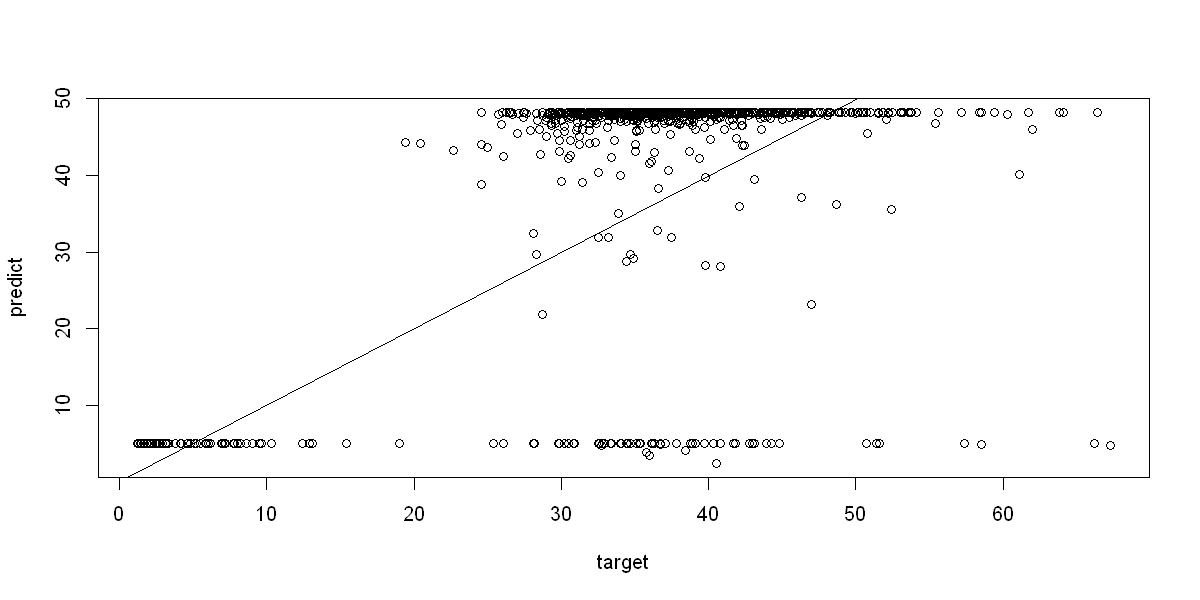

In [307]:
# Calling PredictAnotherYear to predict Att8Score_Disadvantaged in 17-18 using the model trained on the 16-17 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2017_18_encoded, XY_2016_17_encoded, 'Att8Score_Disadvantaged', 
                    inputcol, c(3,2,1,4,3), 'logistic')

The prediction for year 2017-18 Att8 is showing an R-Squared = 0.25~25% with respect to the actual data for 2018-19. This indicates the model is performing worse than a straight line at the mean value.

[1] "R-squared:  -1.80872525640402"
[1] "MAE:  0.825204564381505"
[1] "RMSE:  0.938480334642672"


[[1]]
[1] -1.808725

[[2]]
[1] 0.8252046

[[3]]
[1] 0.9384803

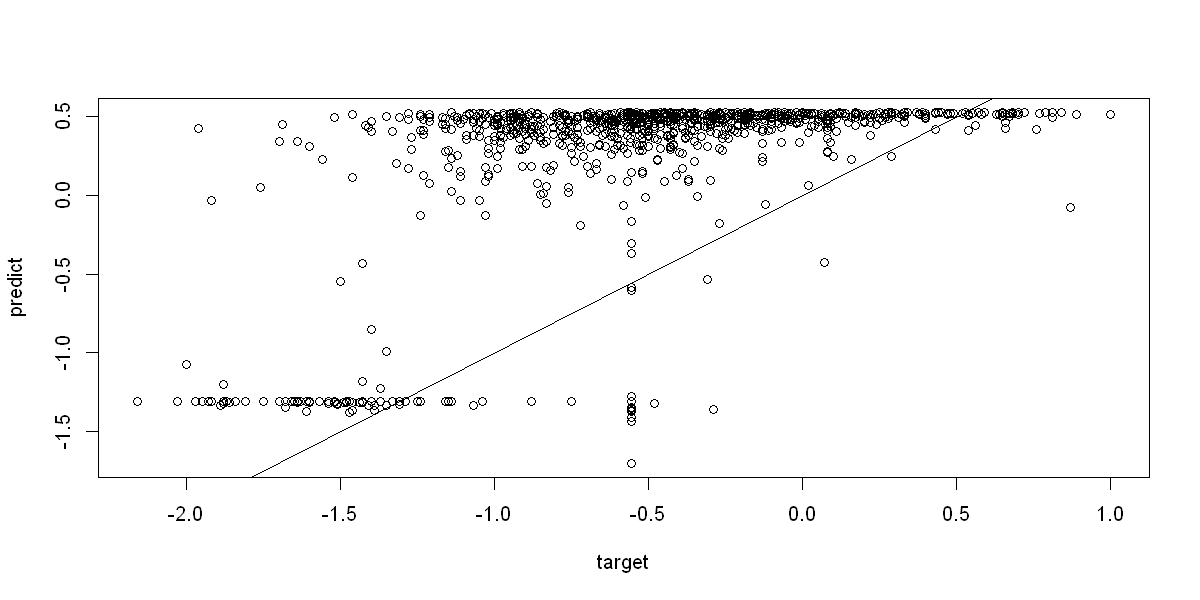

In [308]:
# Calling PredictAnotherYear to predict Prg8Score_Disadvantaged in 17-18 using the model trained on the 16-17 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2017_18_encoded, XY_2016_17_encoded, 'Prg8Score_Disadvantaged', 
                    inputcol, c(2,2,2,6,4), 'logistic')

The prediction for year 2017-18 Prg8 is showing a negative R-Squared with respect to the actual data for 2017-18. This indicates that the model is performing worse than a straight line at the mean value.

#### Predicting 2016-17 with 2015-16

[1] "R-squared:  -0.13165932793971"
[1] "MAE:  7.87463891816898"
[1] "RMSE:  12.1390629308789"


[[1]]
[1] -0.1316593

[[2]]
[1] 7.874639

[[3]]
[1] 12.13906

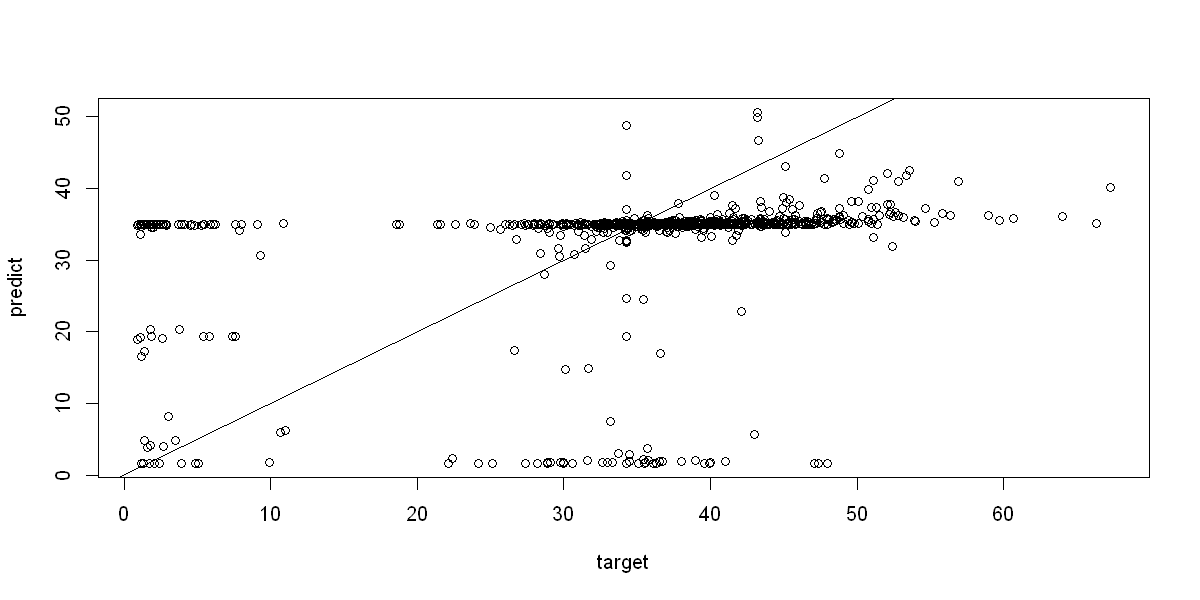

In [309]:
# Calling PredictAnotherYear to predict Att8Score_Disadvantaged in 16-17 using the model trained on the 15-16 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2016_17_encoded, XY_2015_16_encoded, 'Att8Score_Disadvantaged', 
                    inputcol, c(3,2,1,4,3), 'logistic')

The prediction for year 2016-17 Att8 is showing a negative R-Squared with respect to the actual data for 2016-17. This indicates that the model is performing worse than a straight line at the mean value.

[1] "R-squared:  -1.09452495785069"
[1] "MAE:  0.692609977132704"
[1] "RMSE:  0.827089204416134"


[[1]]
[1] -1.094525

[[2]]
[1] 0.69261

[[3]]
[1] 0.8270892

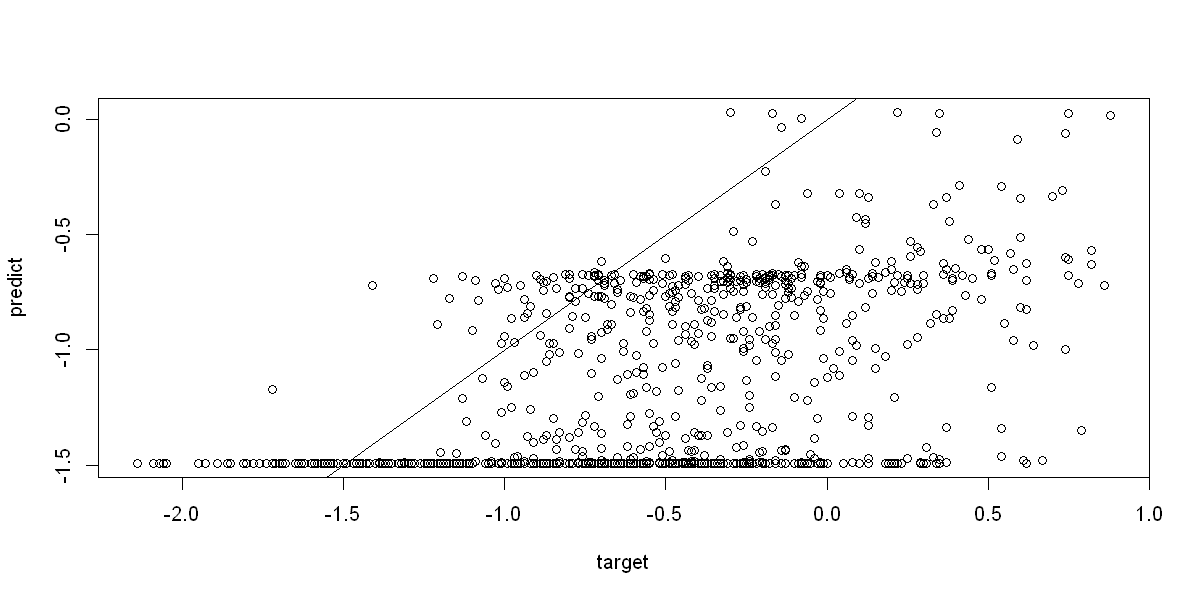

In [310]:
# Calling PredictAnotherYear to predict Prg8Score_Disadvantaged in 16-17 using the model trained on the 15-16 data
# This result will give the R^2, RMSE and MAE values detailing the error in the prediction
PredictAnotherYear(XY_2016_17_encoded, XY_2015_16_encoded, 'Prg8Score_Disadvantaged', 
                    inputcol, c(2,2,2,6,4), 'logistic')

The prediction for year 2016-17 Prg8 is showing a negative R-Squared with respect to the actual data for 2016-17. This indicates that the model is performing worse than a straight line at the mean value.